# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50   0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75   0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00   0.288190        0.174077  0.089557  0.183997  0.136357   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.200059  0.009901  0.039914  0.049716  0.000379  
         0.50  0.200543  0.009250  0.039268  0.049773  0.000986  
         0.75  0.201742  0.008158  0.038120  0.050221  0.001694  
         1.00  0.203716  0.007056  0.036890  0.050678  0.002468

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


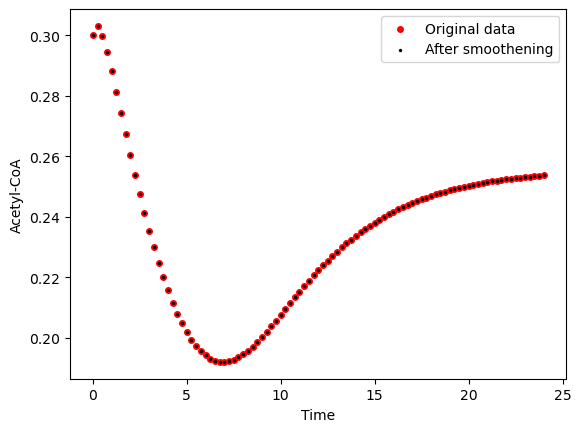

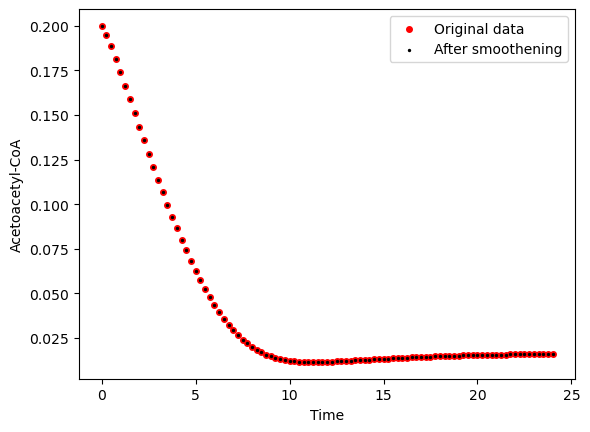

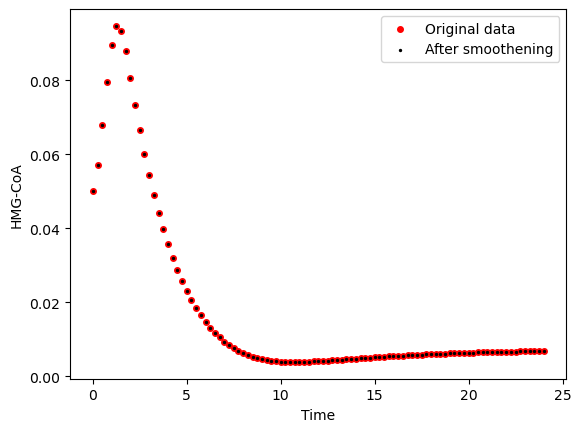

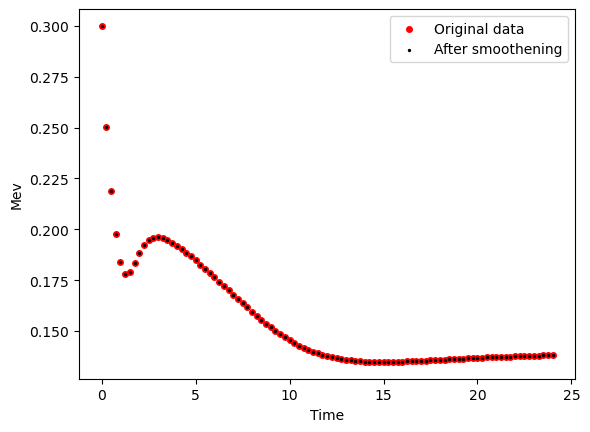

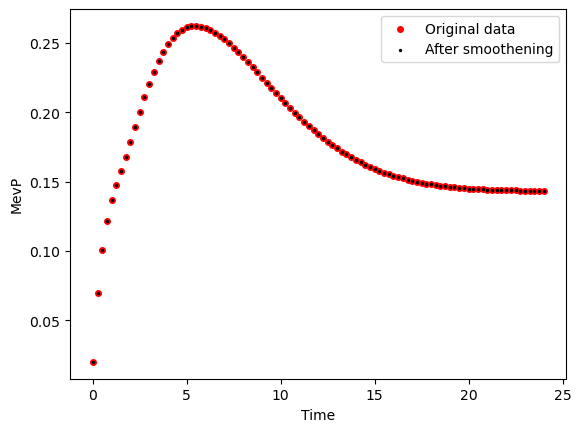

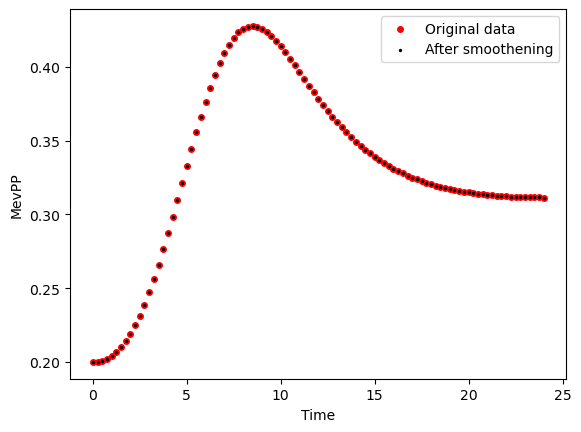

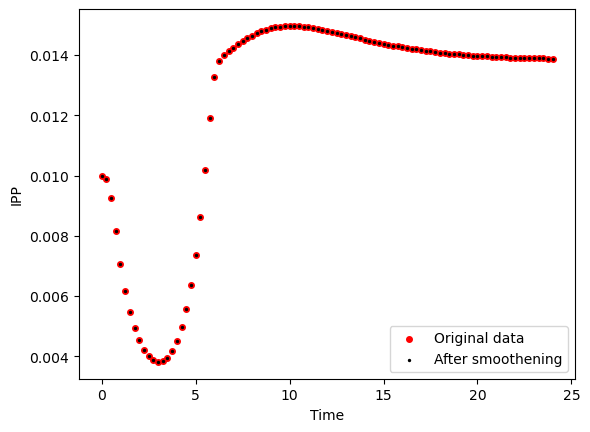

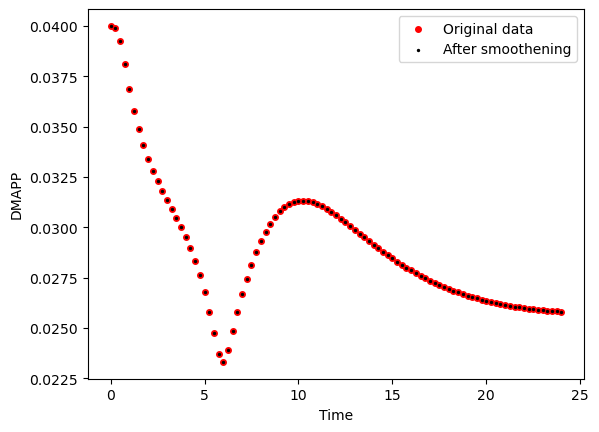

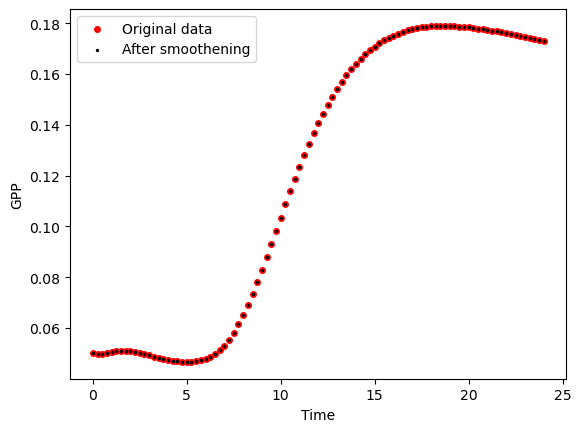

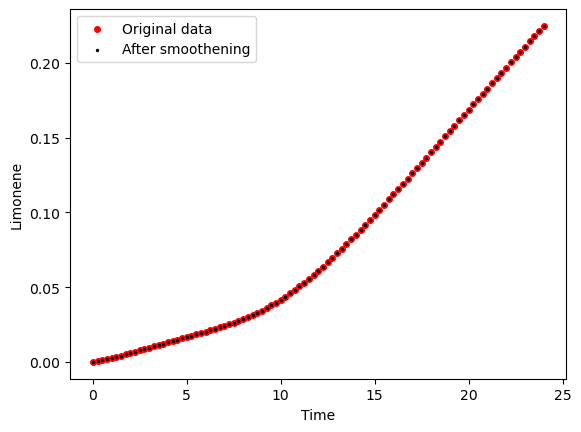

Strain Strain 2


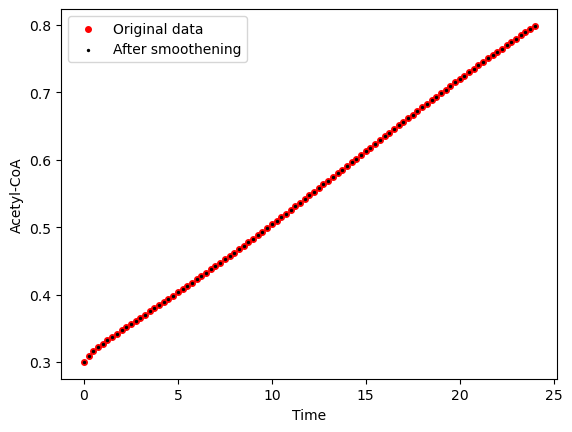

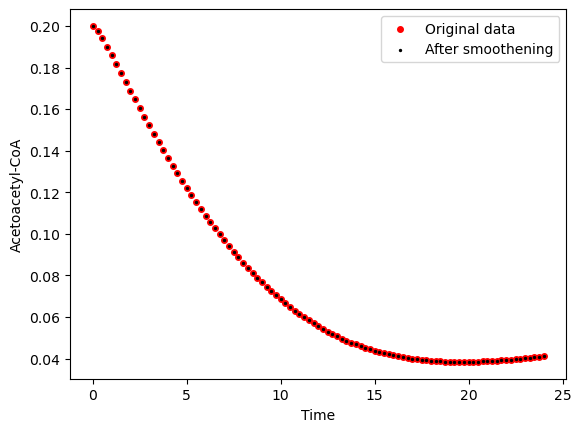

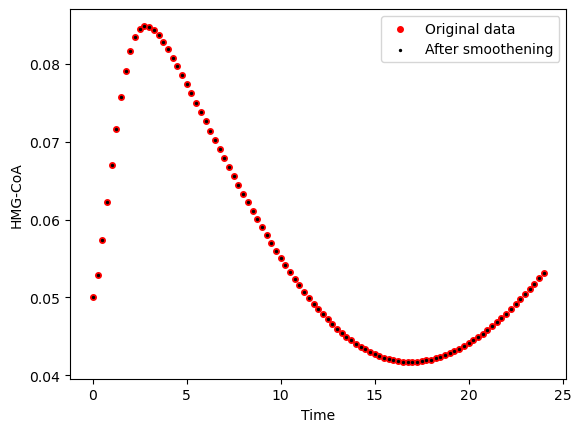

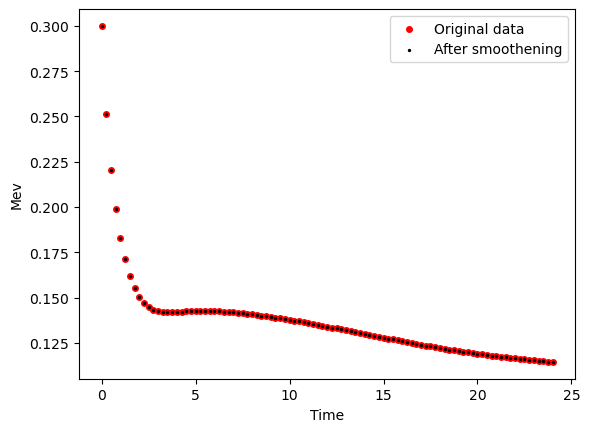

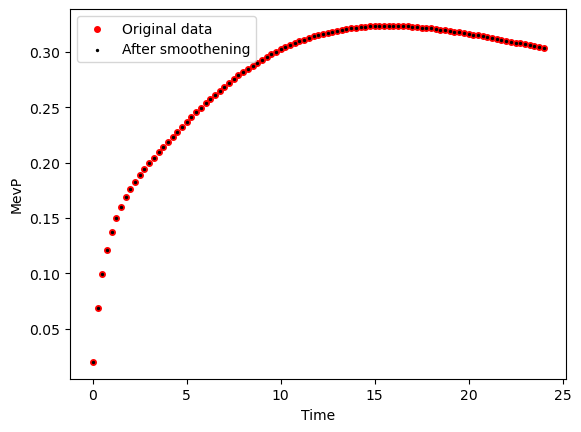

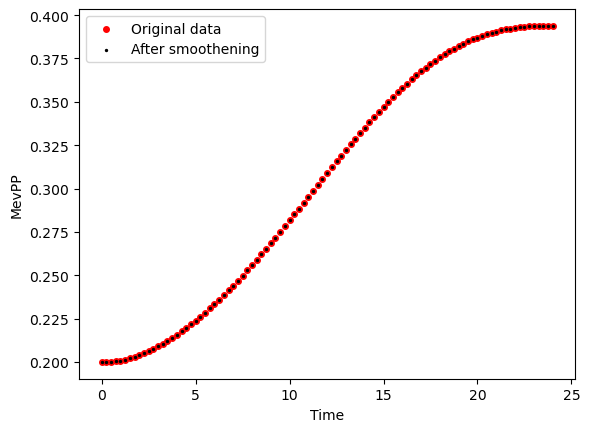

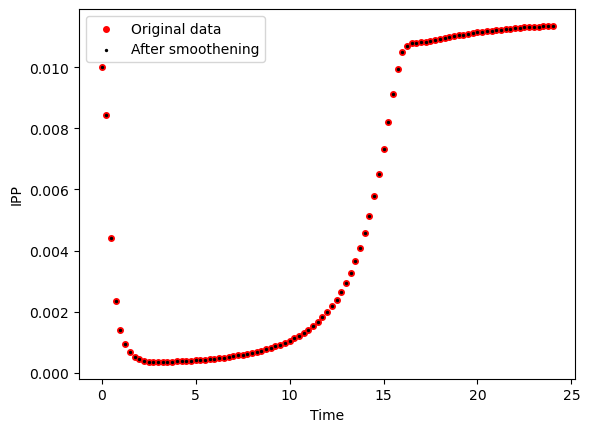

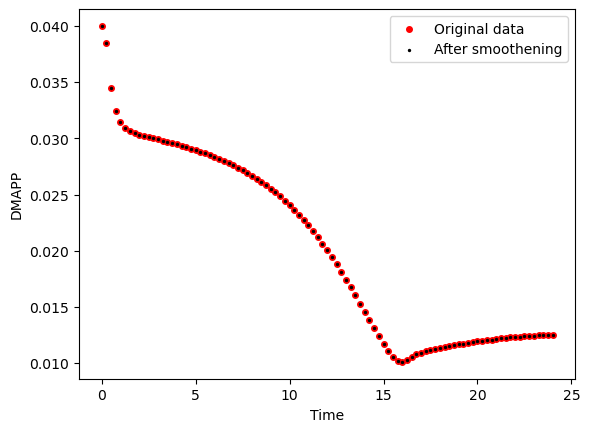

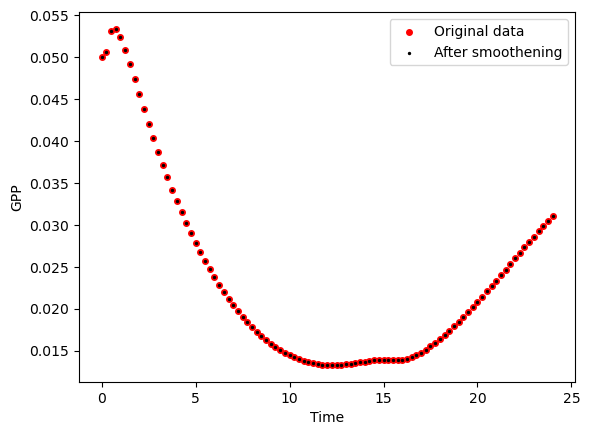

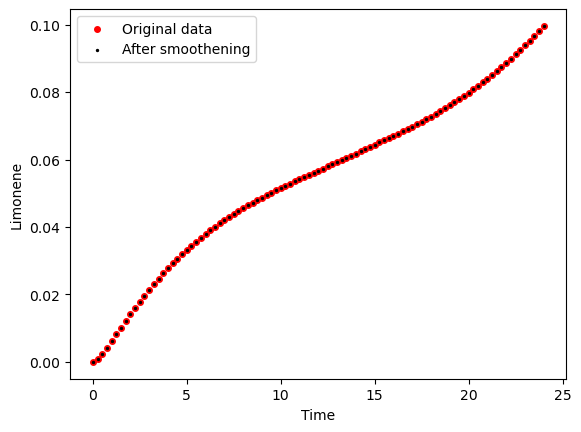

Strain Strain 3


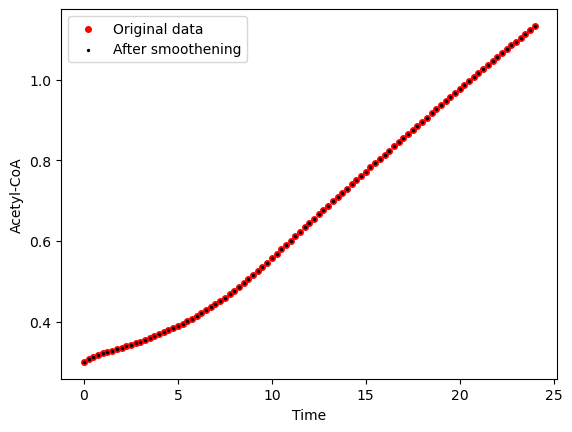

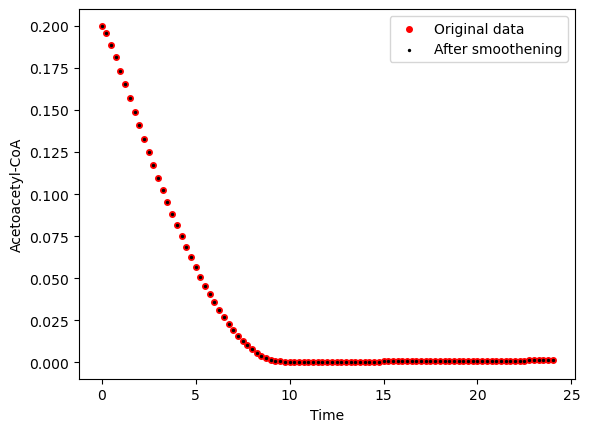

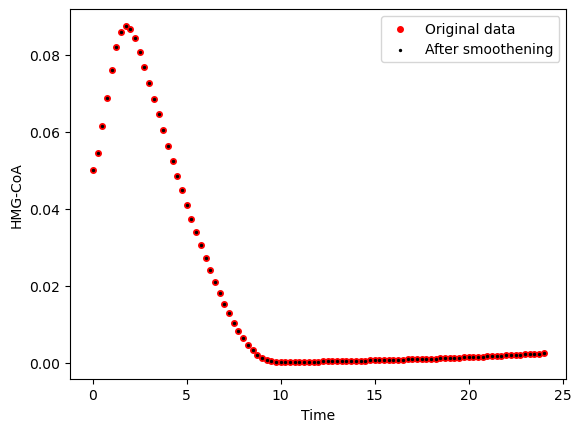

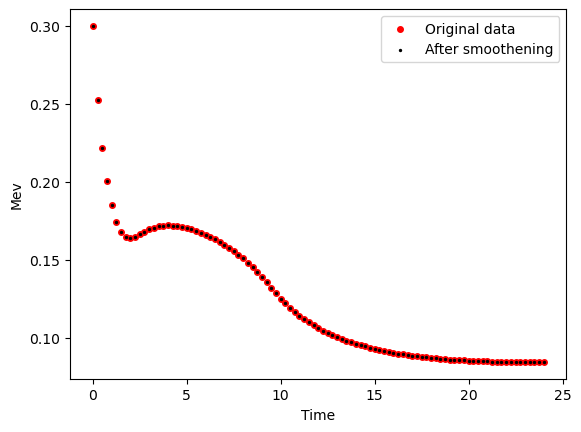

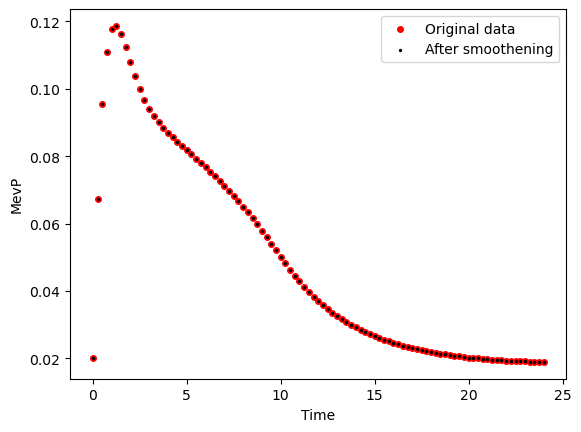

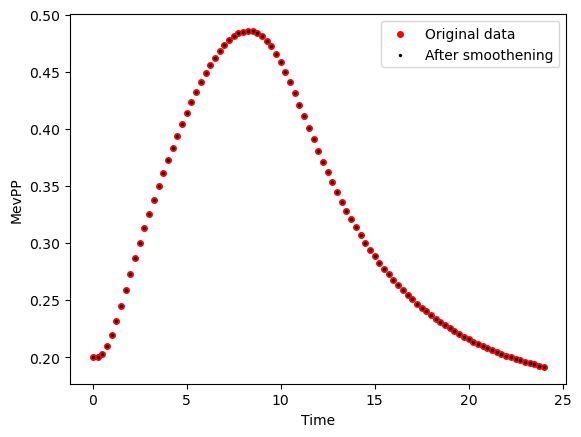

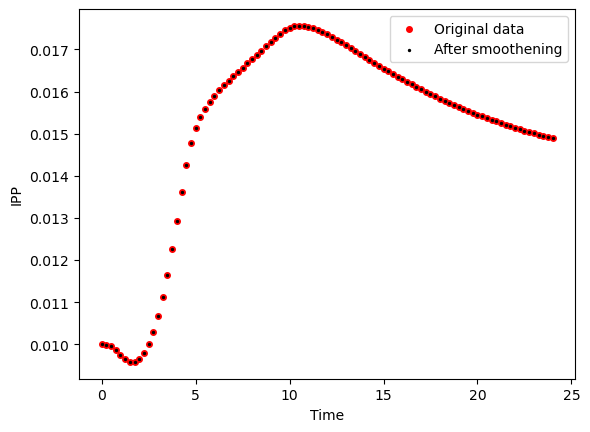

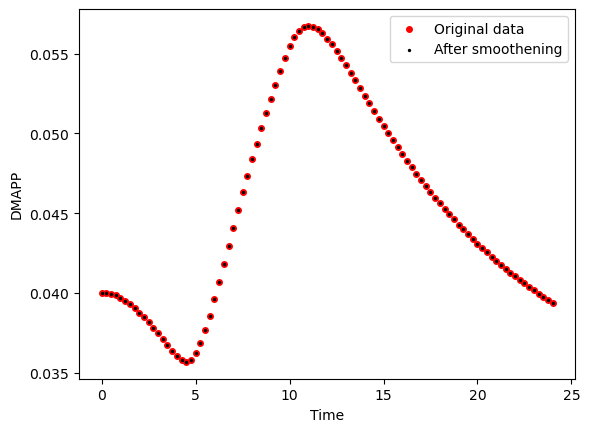

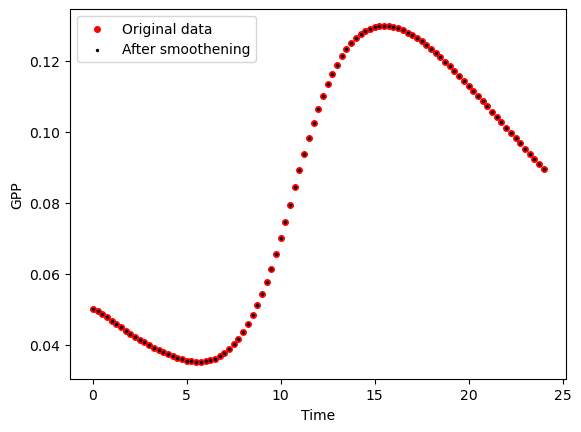

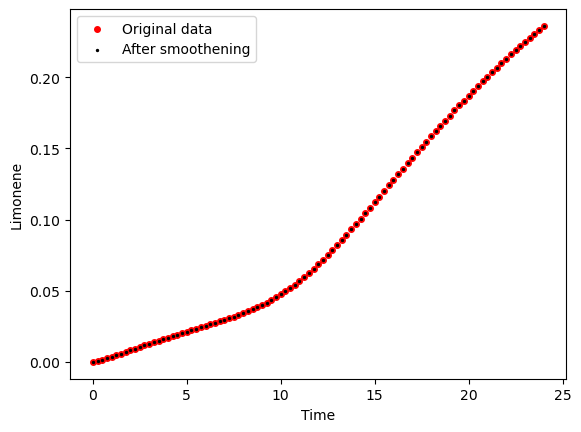

Strain WT


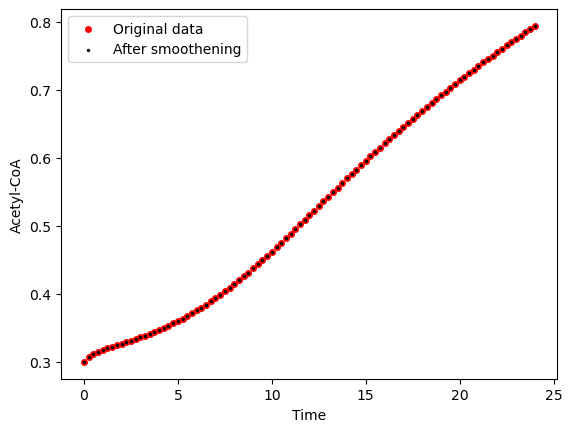

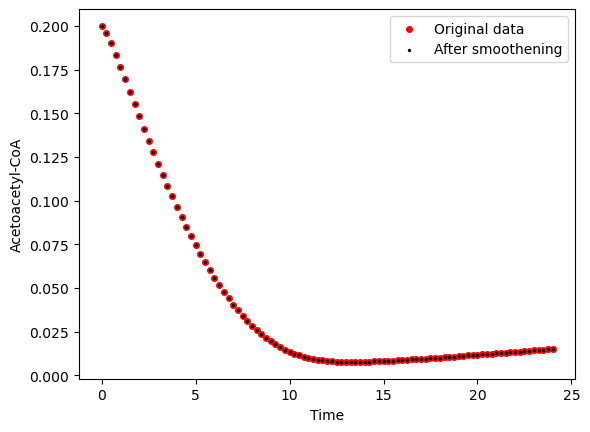

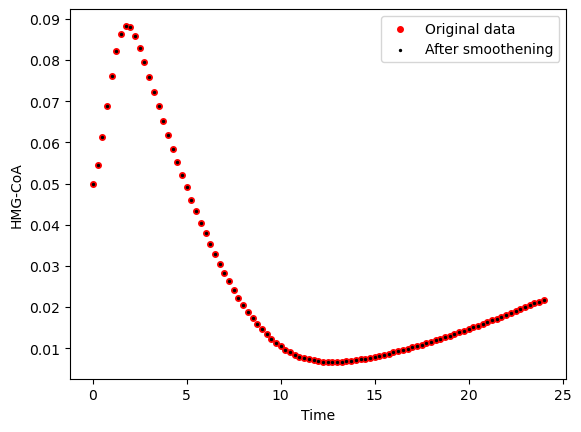

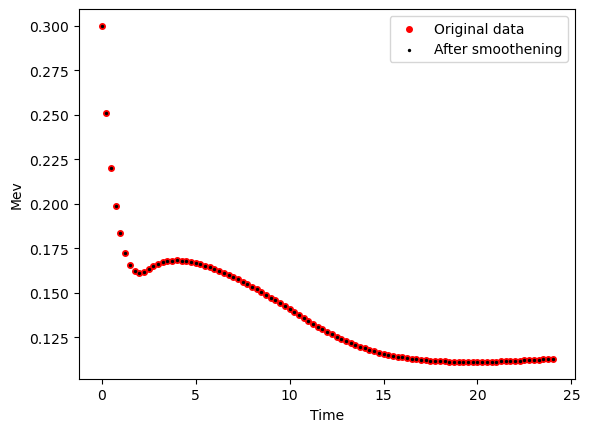

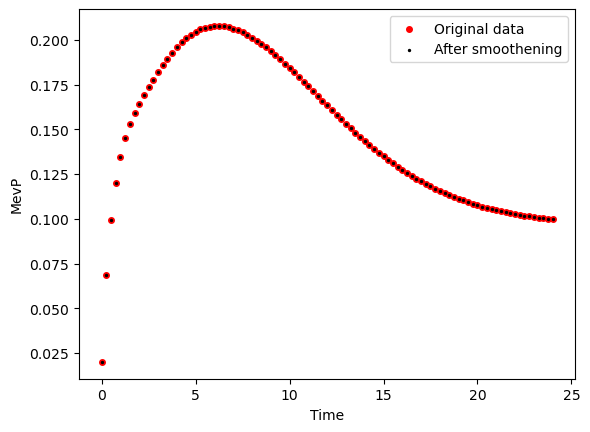

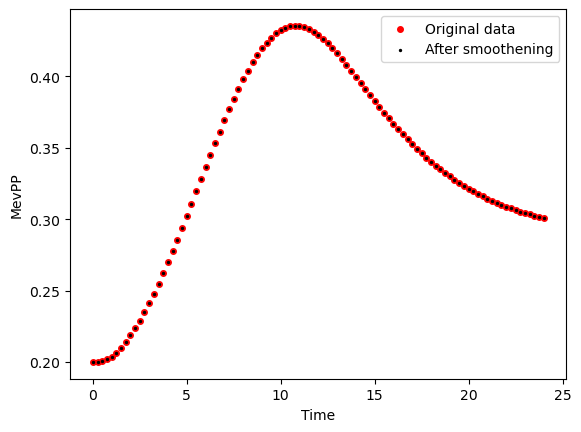

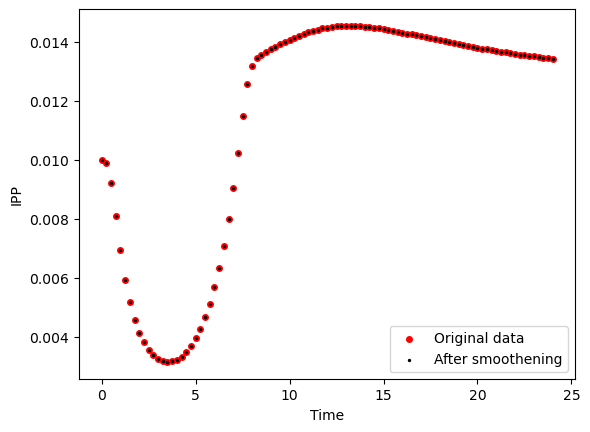

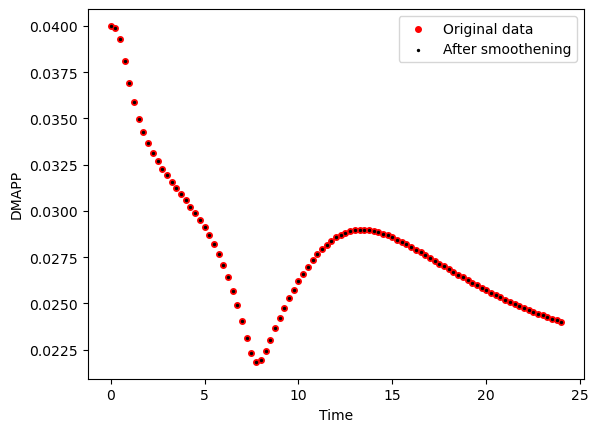

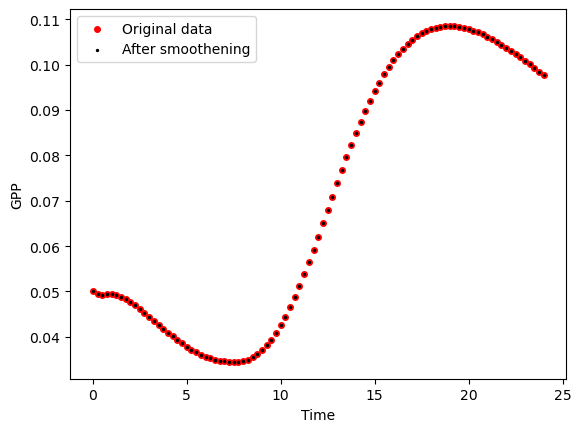

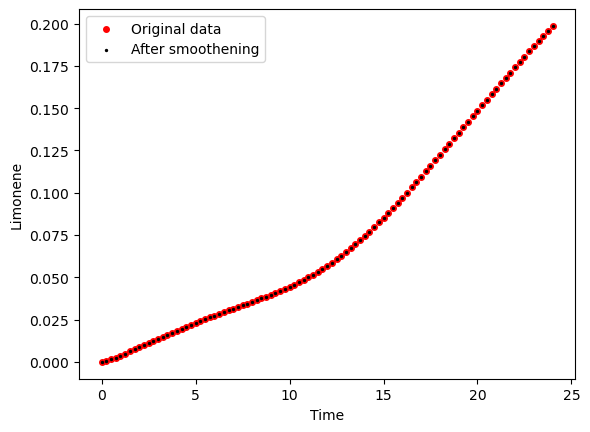

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


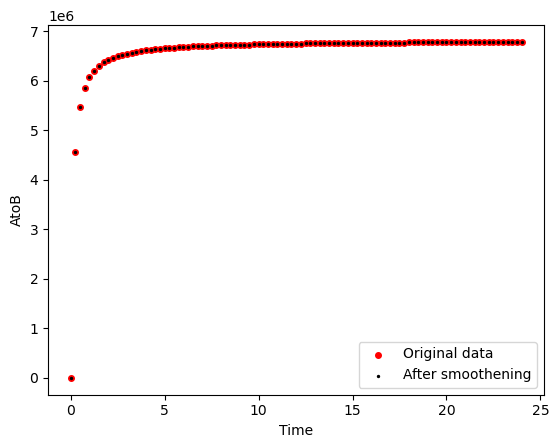

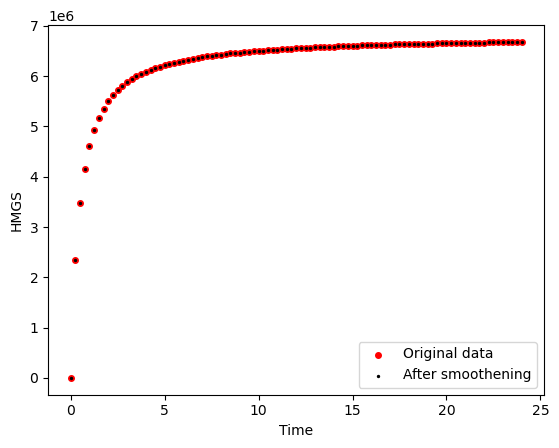

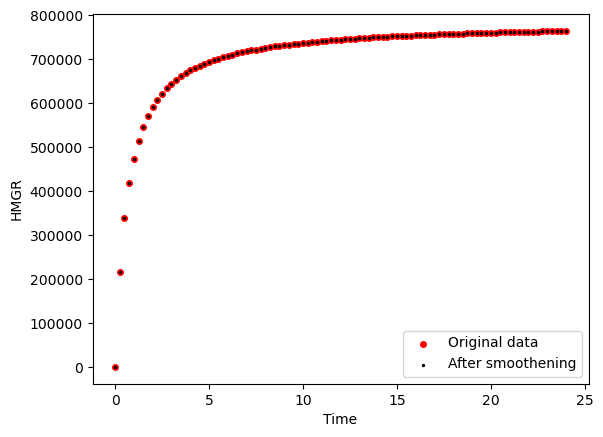

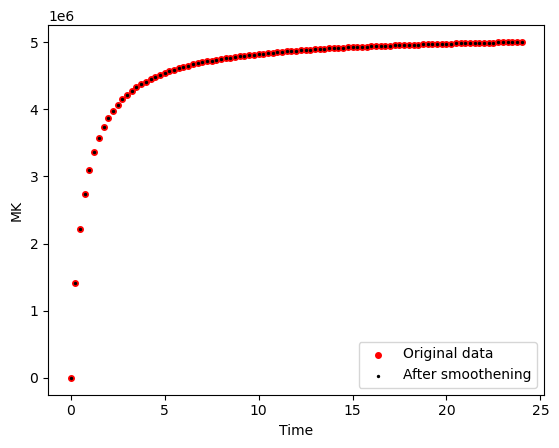

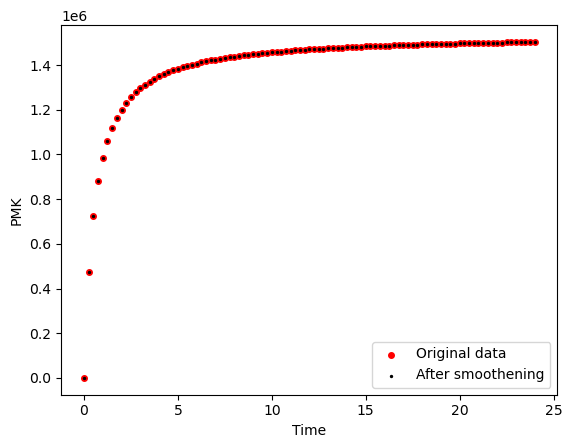

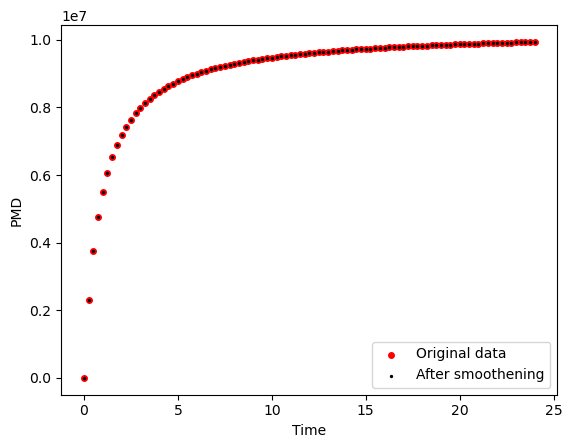

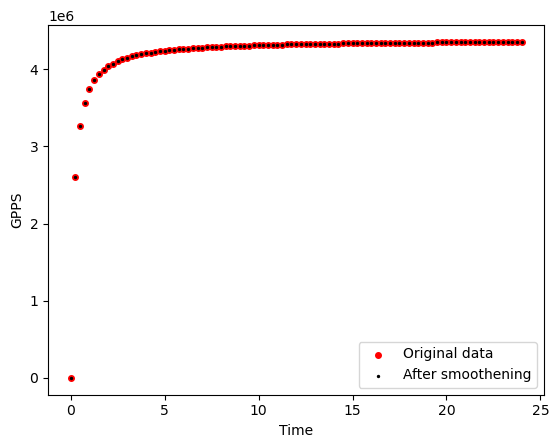

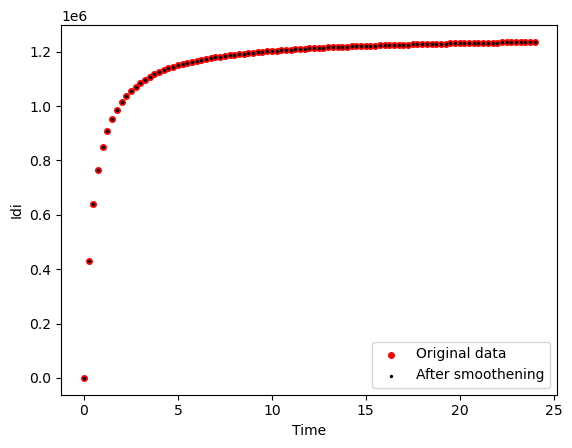

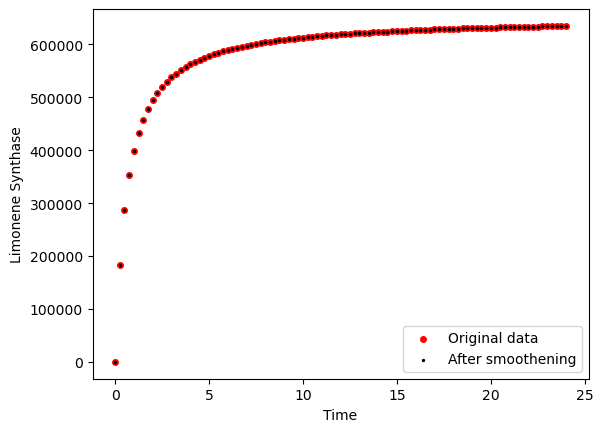

Strain Strain 2


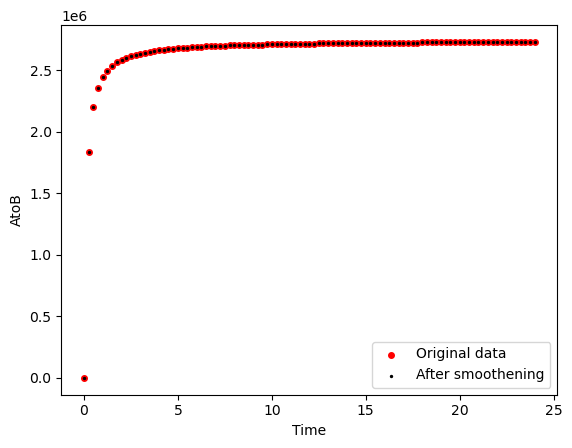

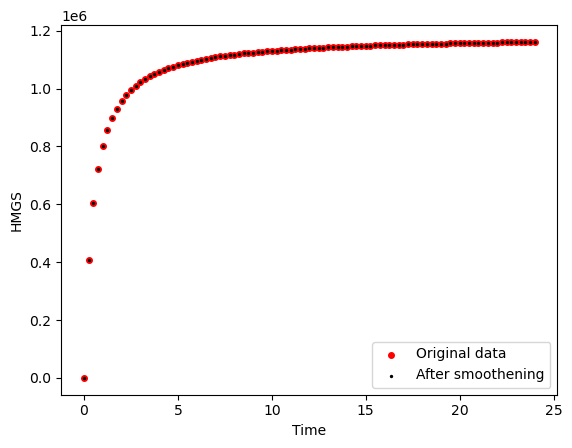

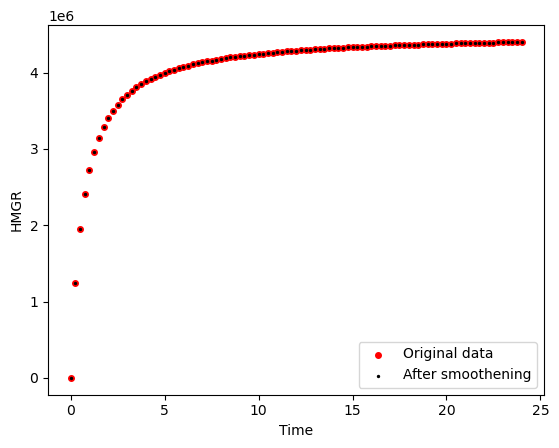

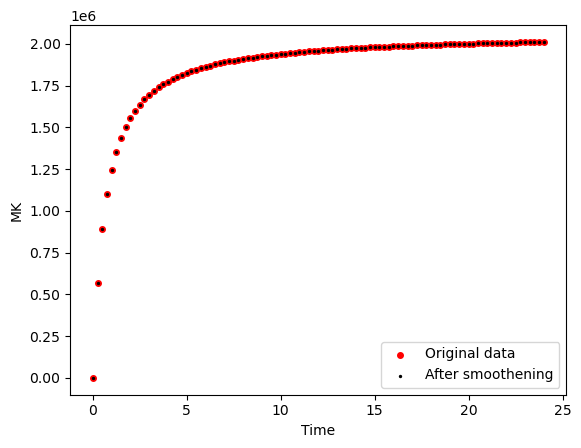

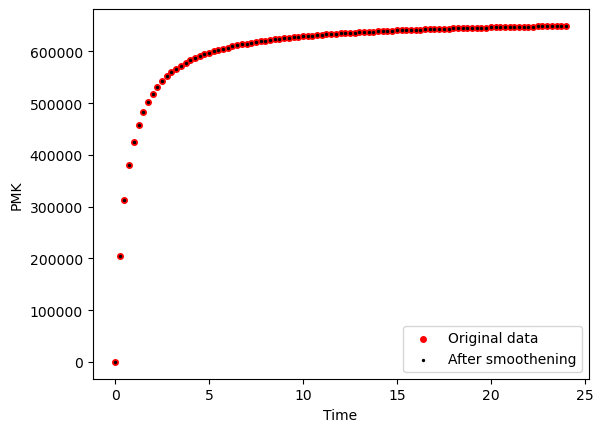

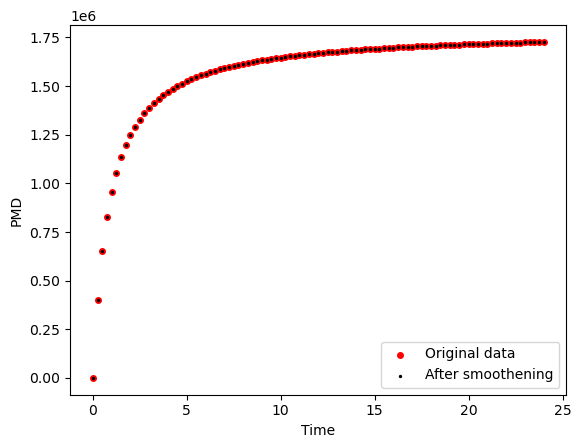

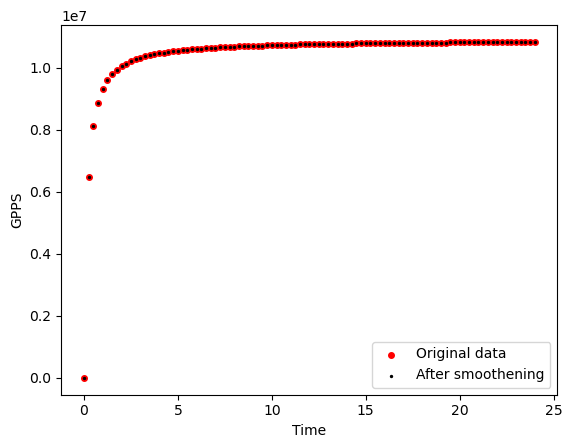

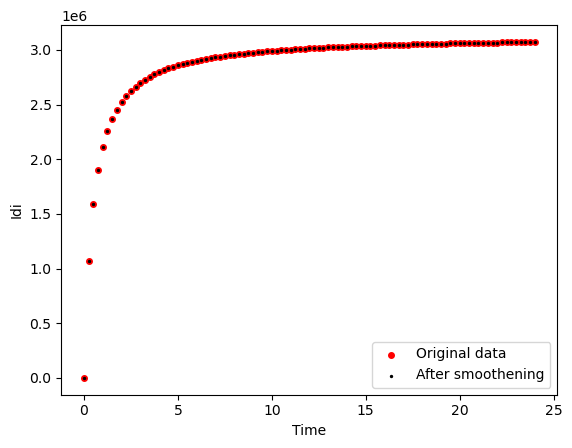

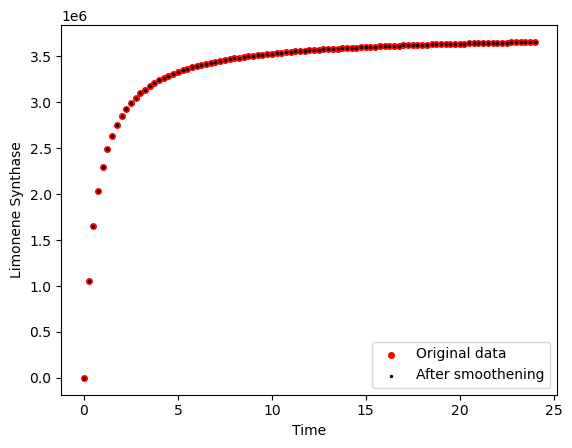

Strain Strain 3


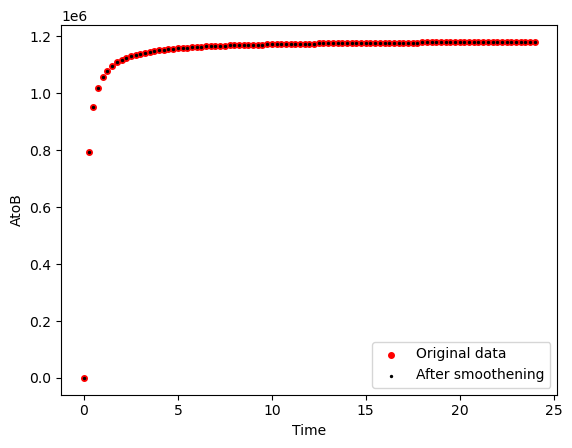

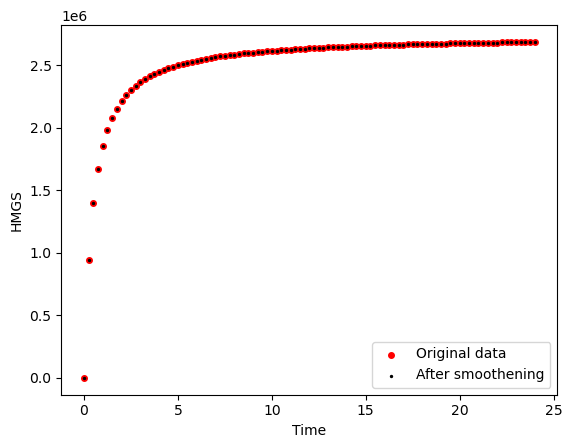

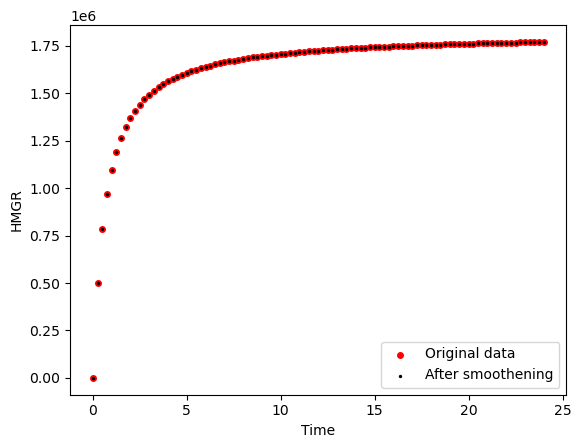

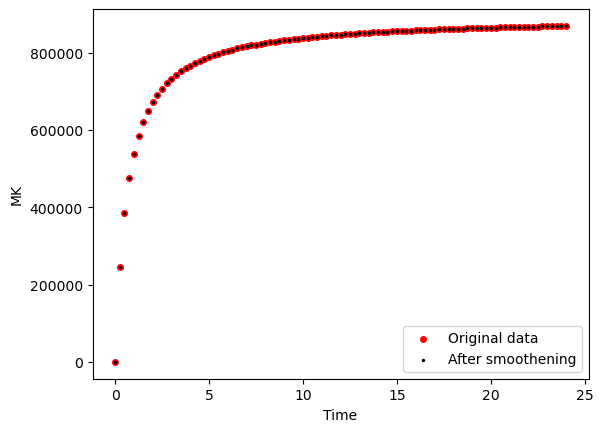

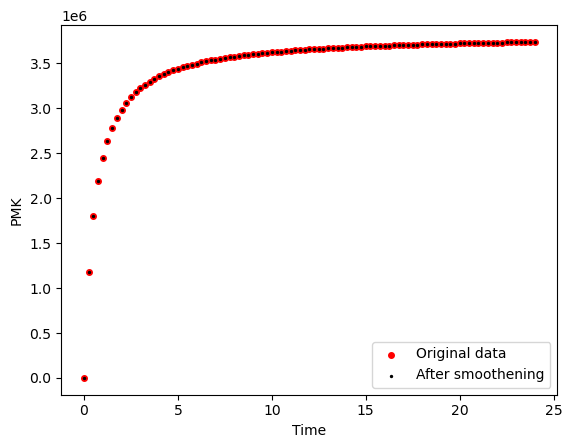

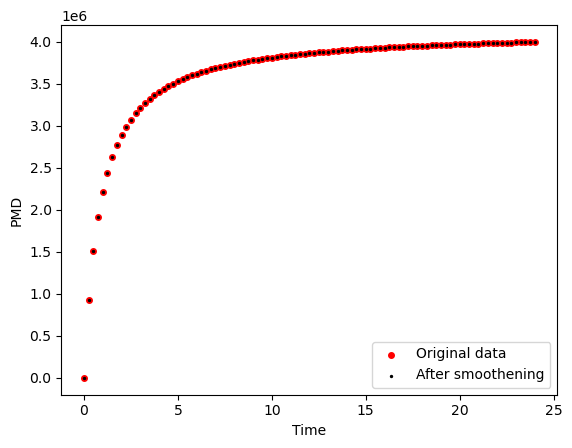

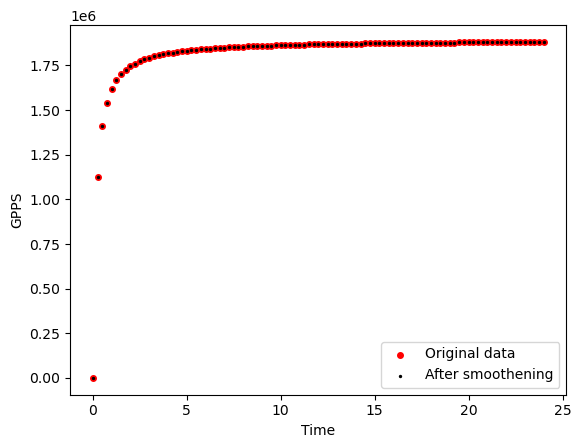

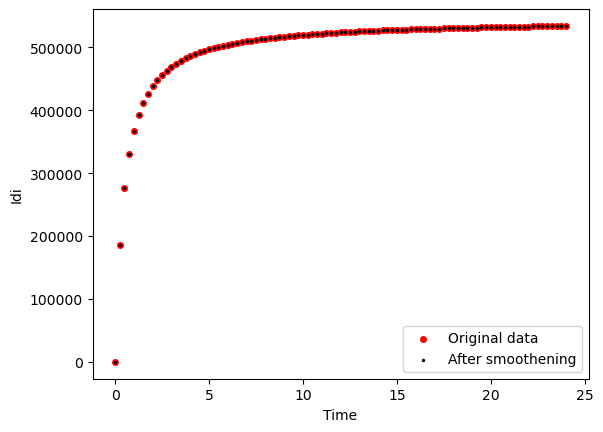

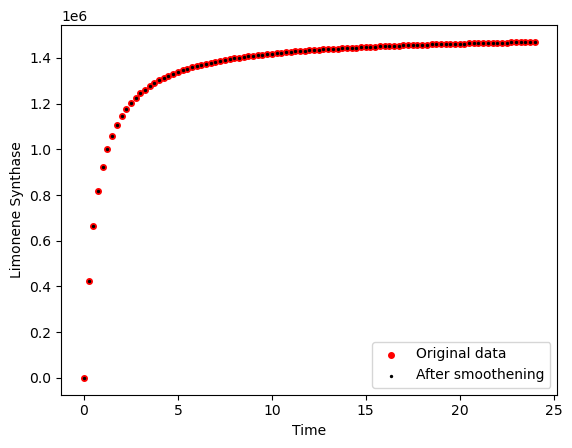

Strain WT


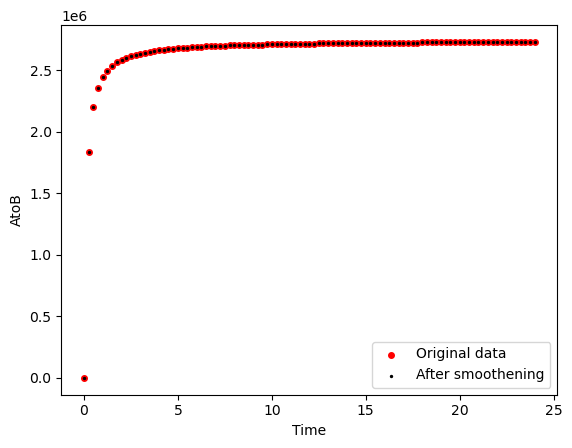

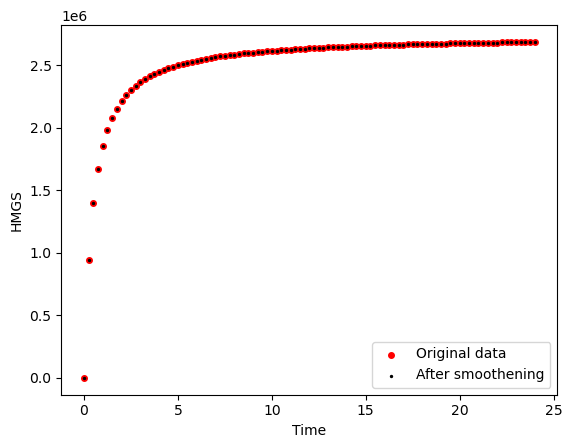

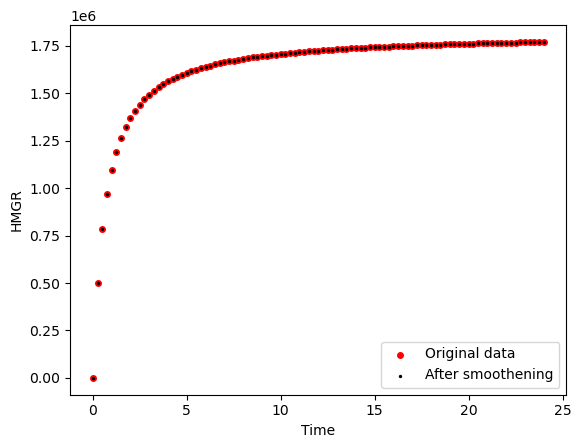

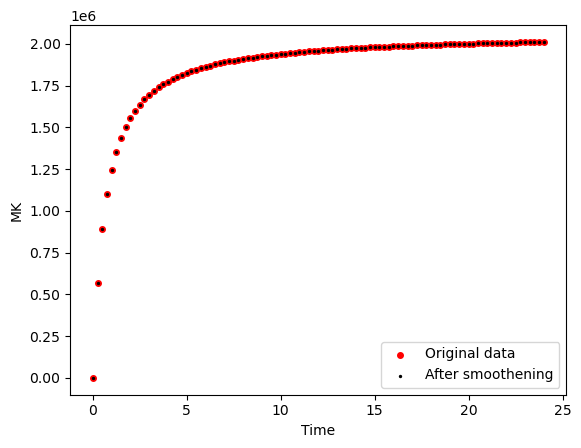

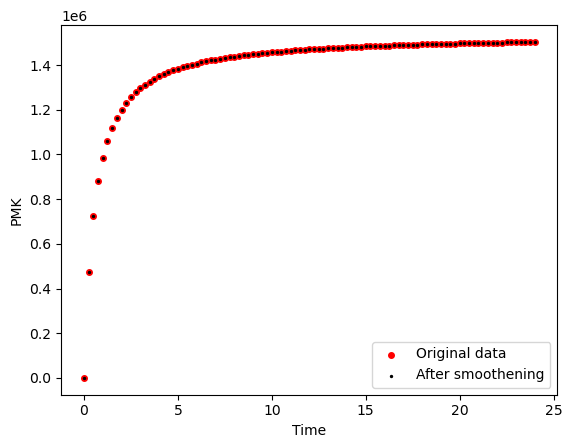

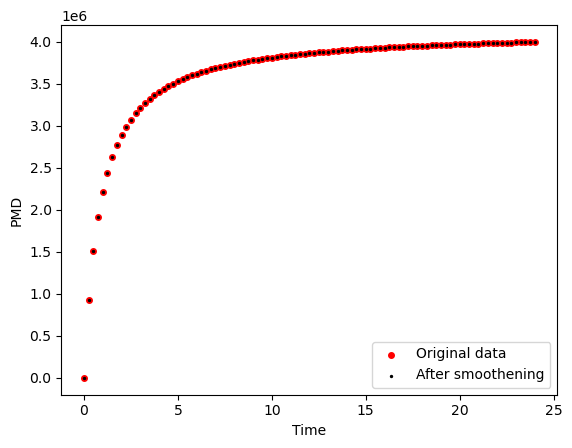

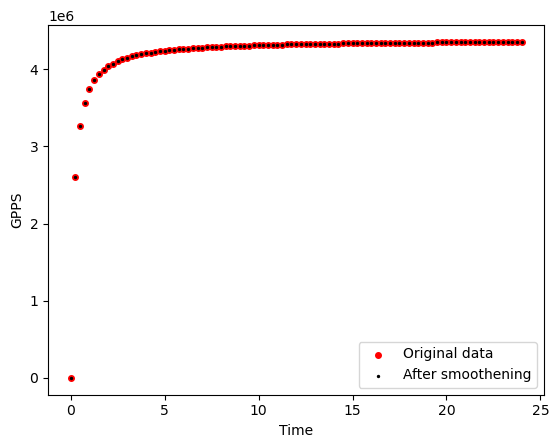

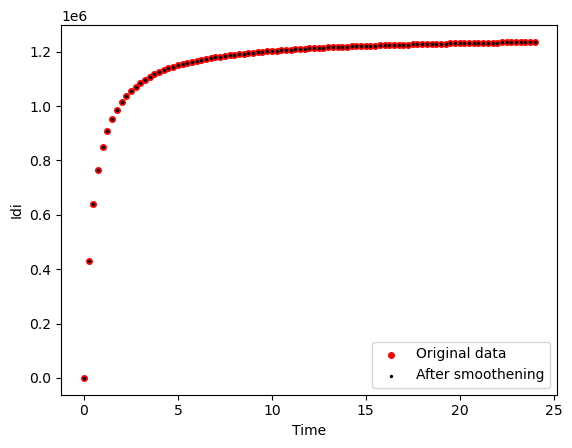

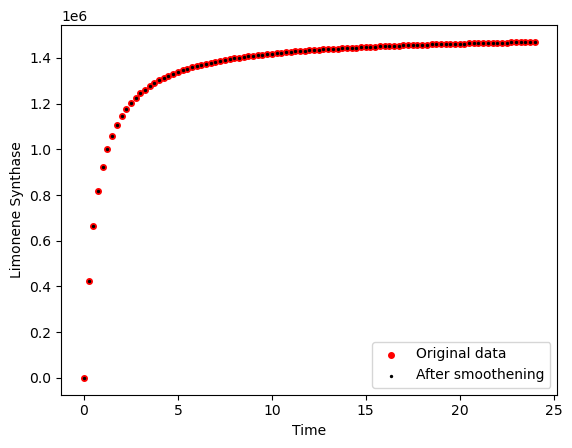

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021363  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200059  0.009901  0.039914  0.049716  0.000379  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201742  0.008158  0.038120  0.050221  0.001694  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098489  0.195636  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

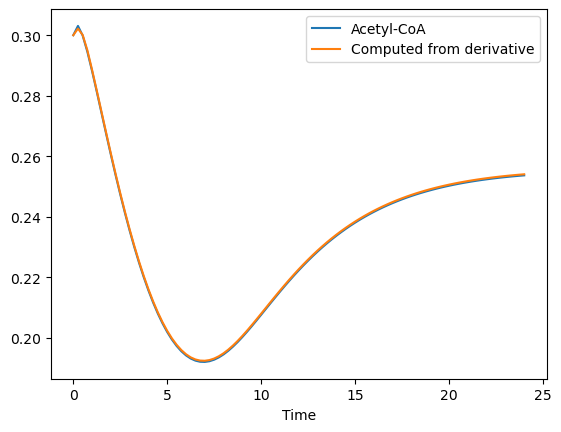

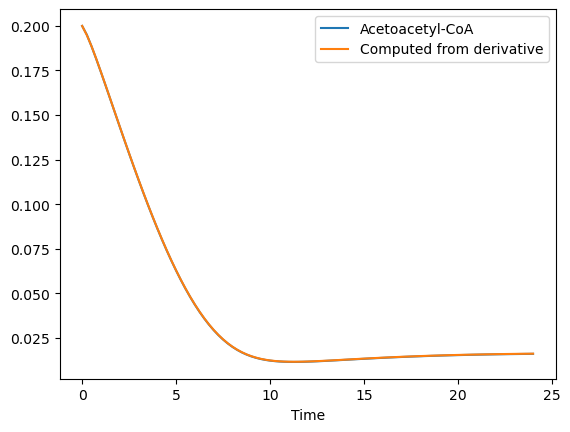

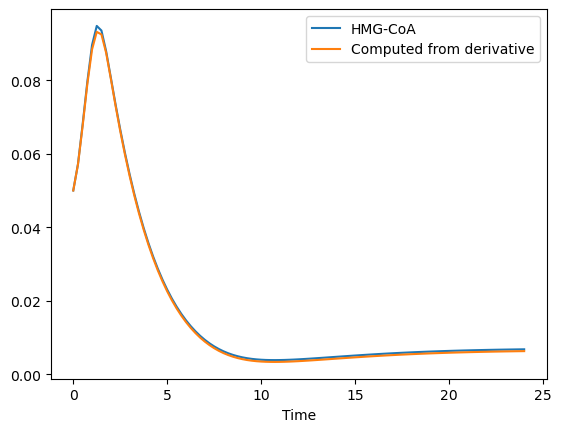

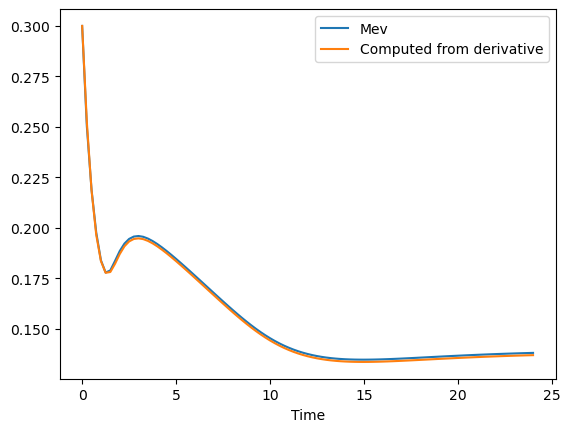

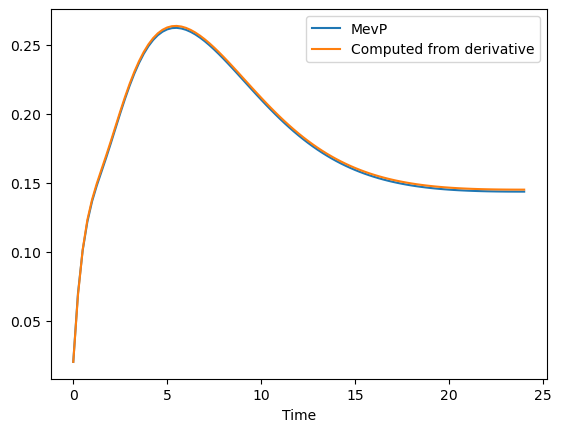

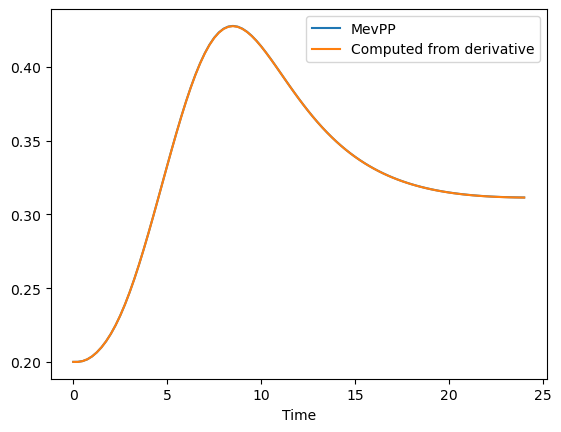

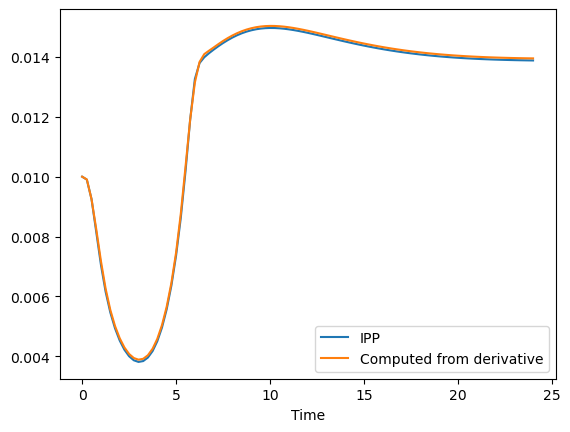

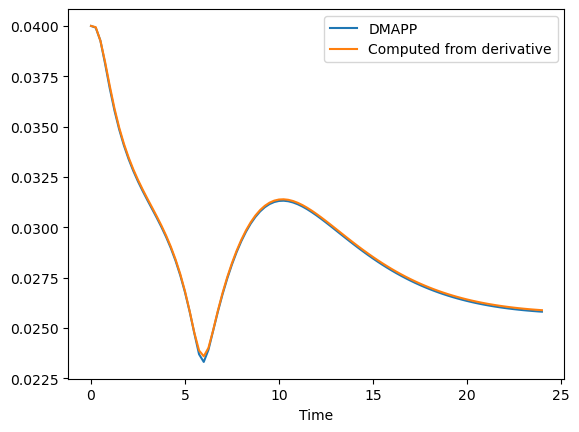

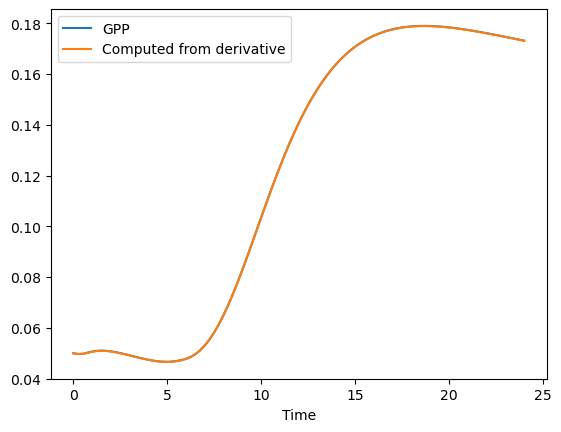

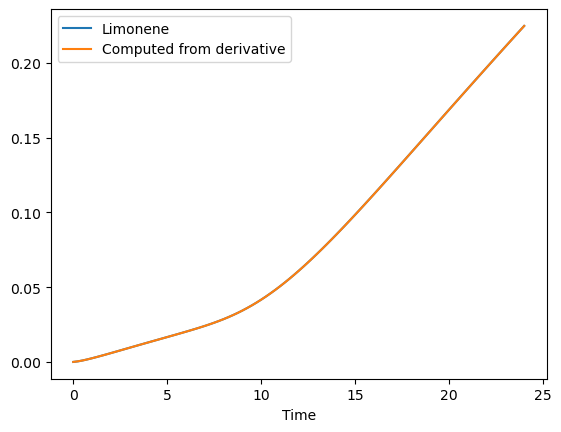

'Time profile from derivative vs. actual profile for Strain 2'

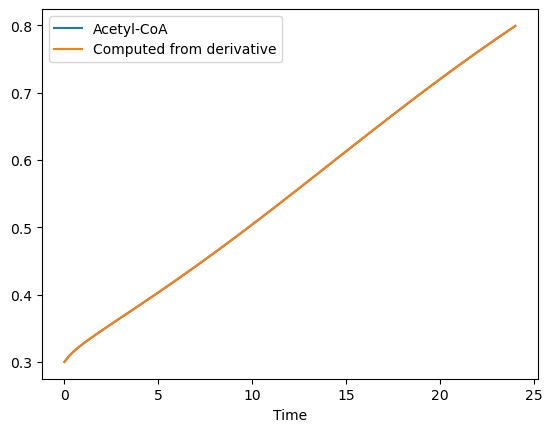

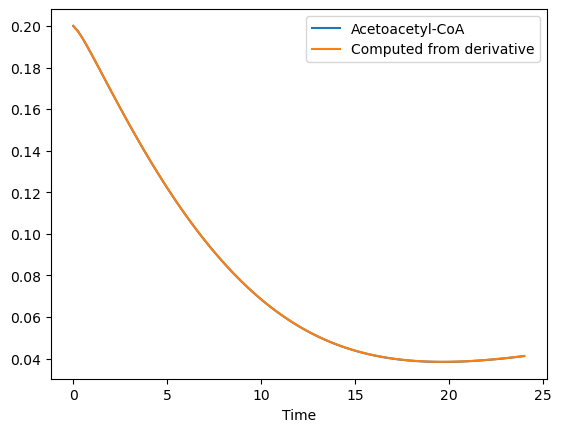

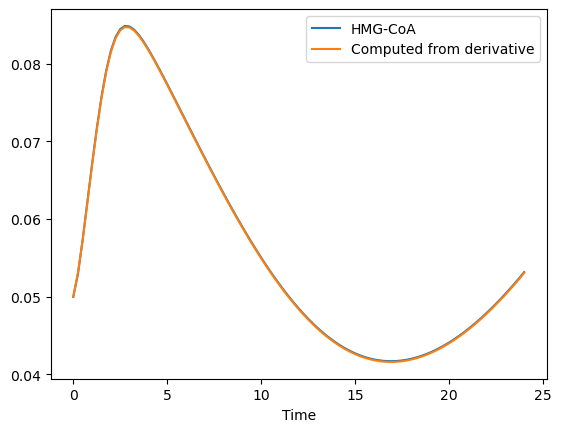

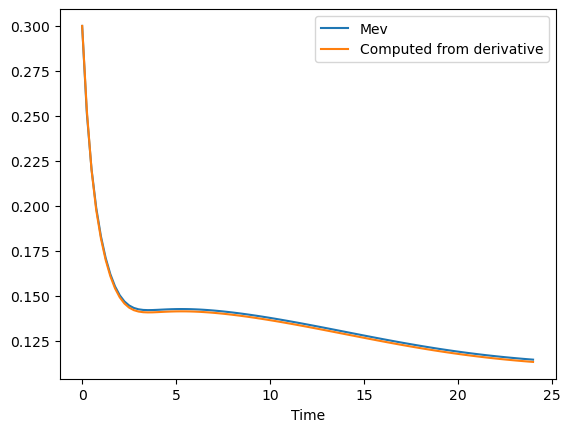

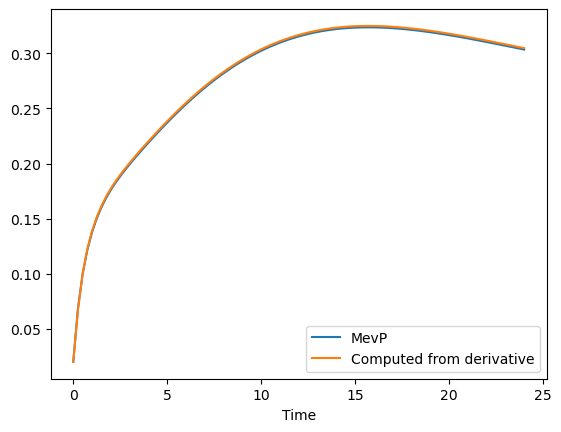

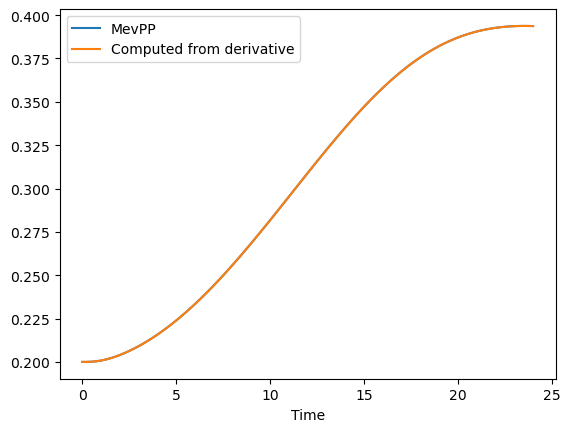

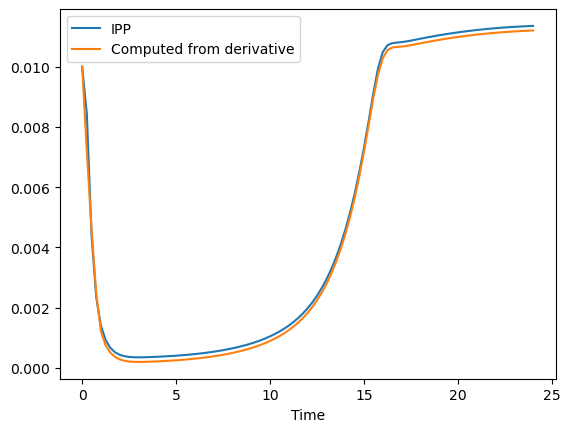

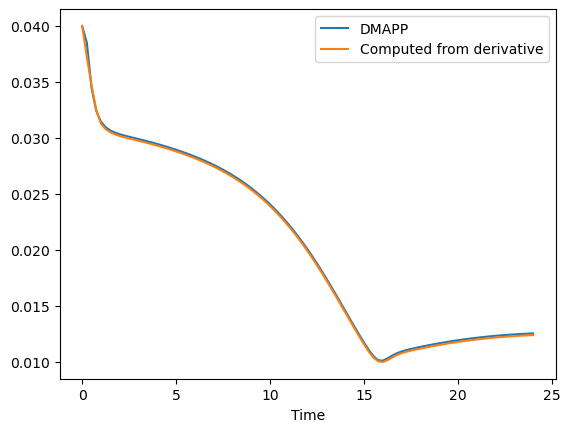

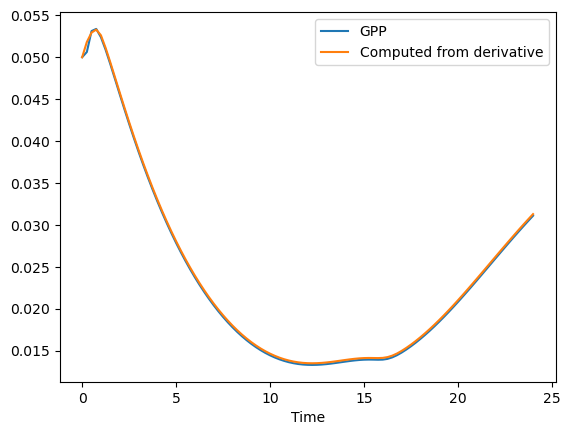

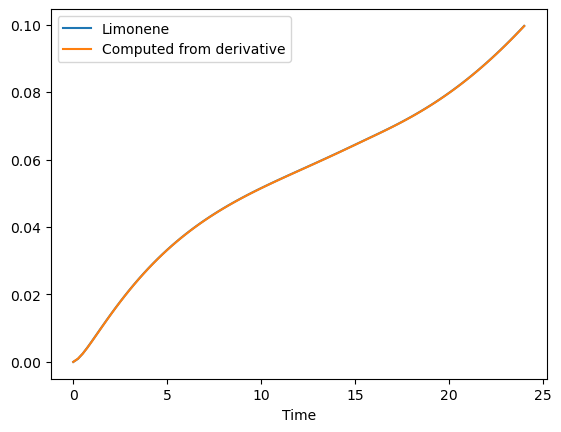

'Time profile from derivative vs. actual profile for Strain 3'

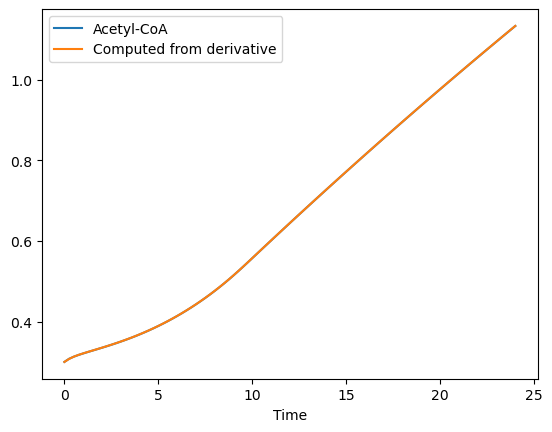

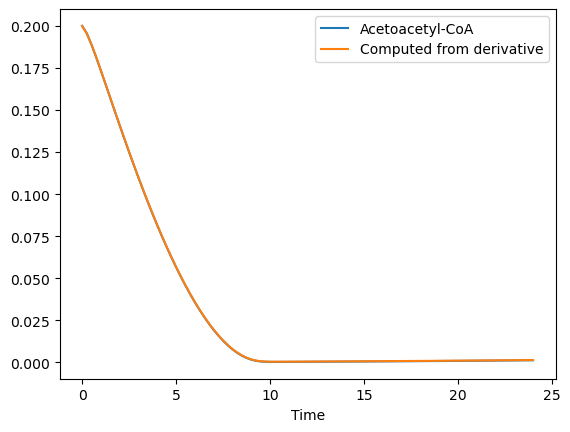

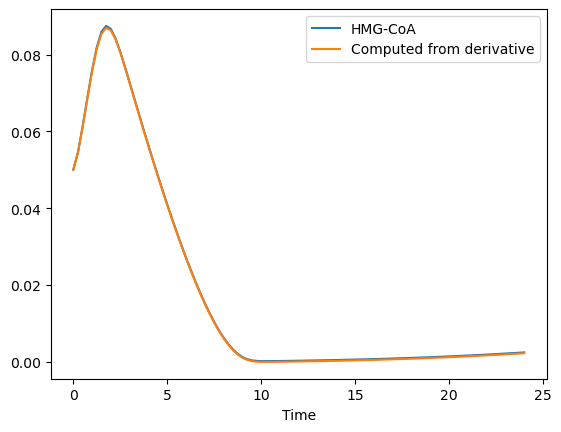

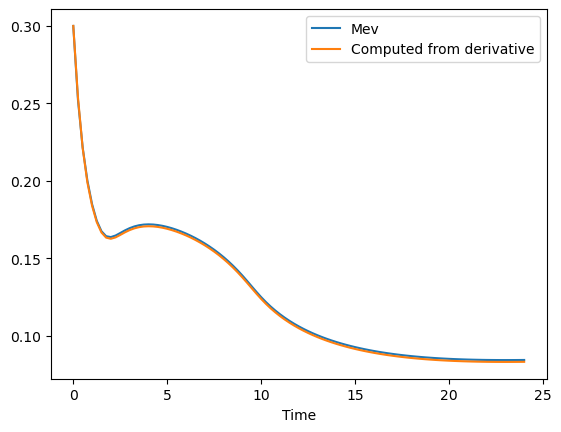

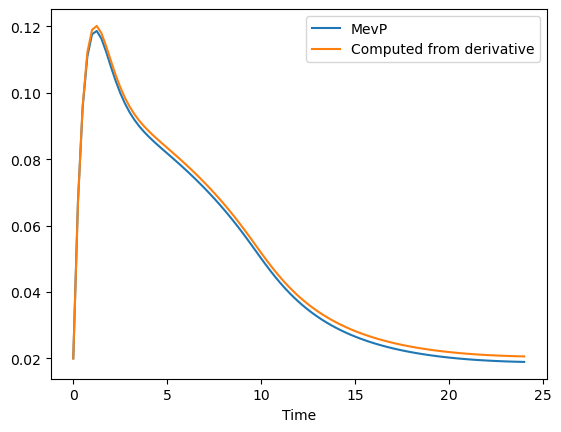

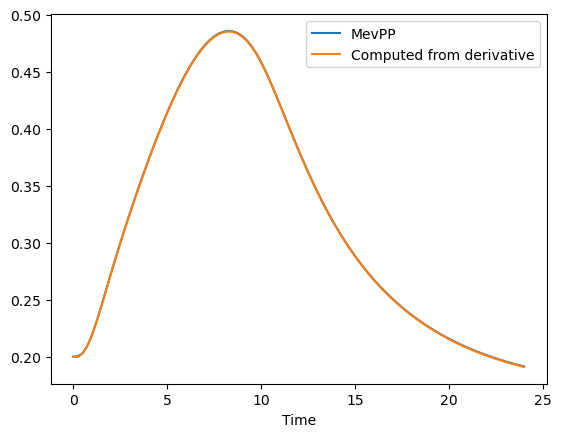

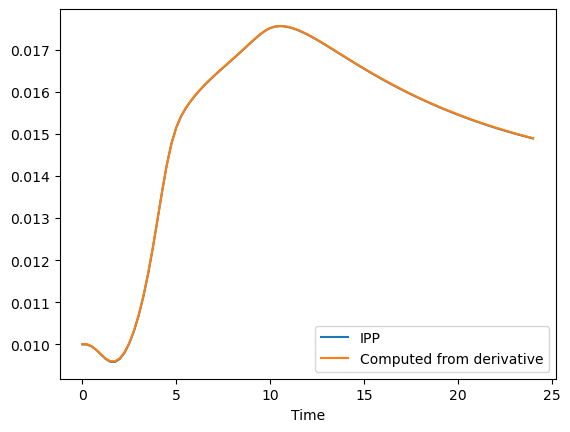

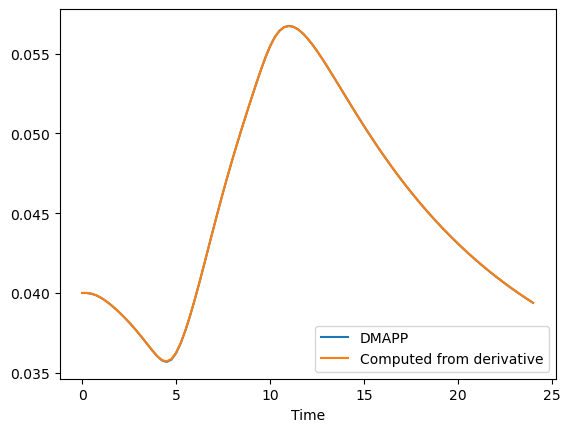

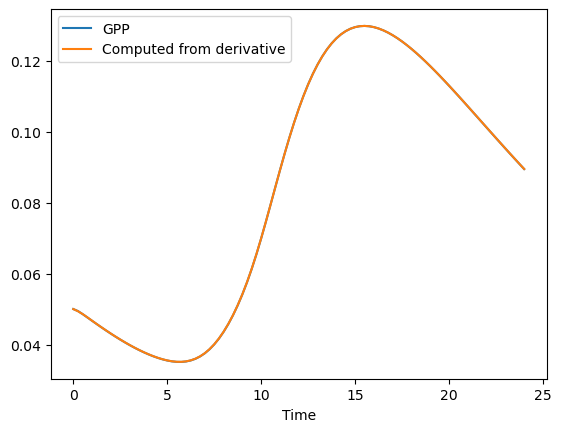

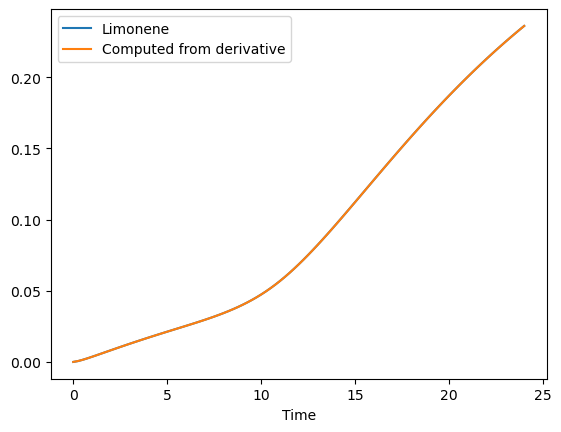

'Time profile from derivative vs. actual profile for WT'

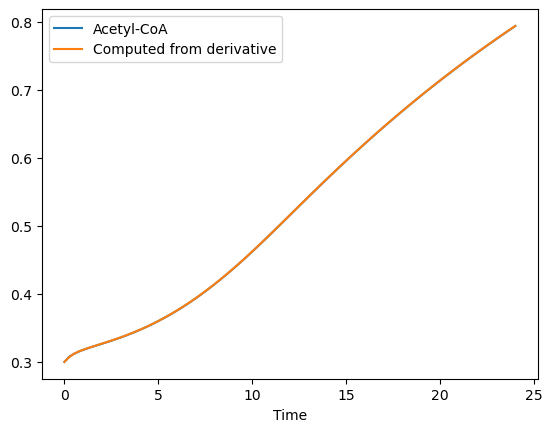

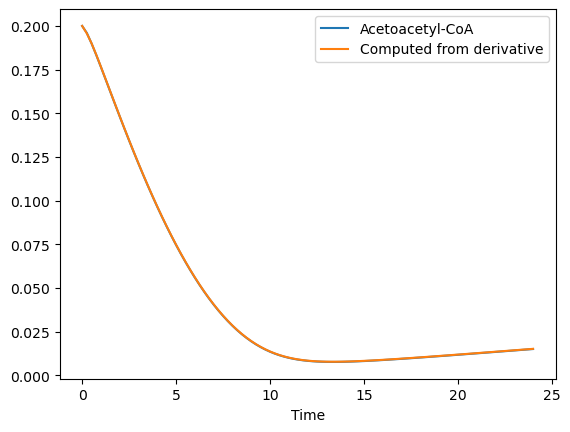

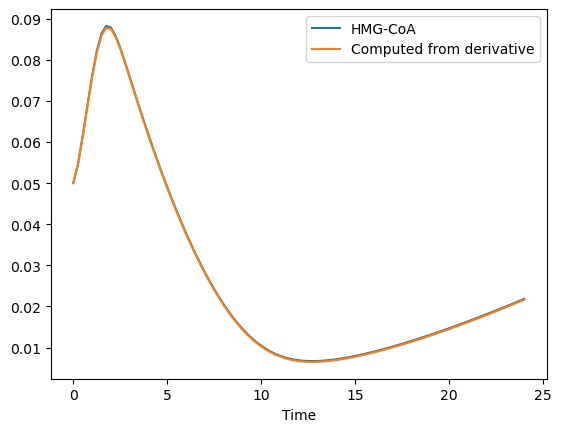

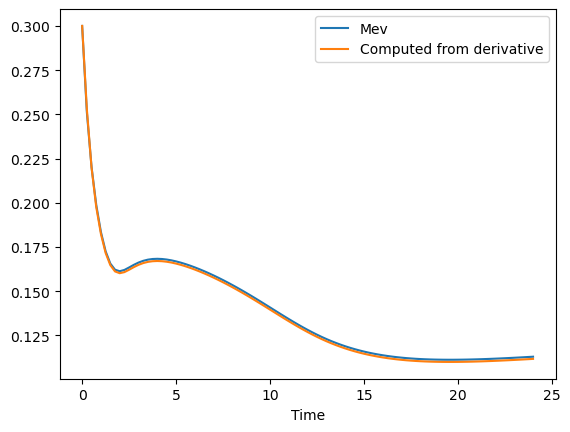

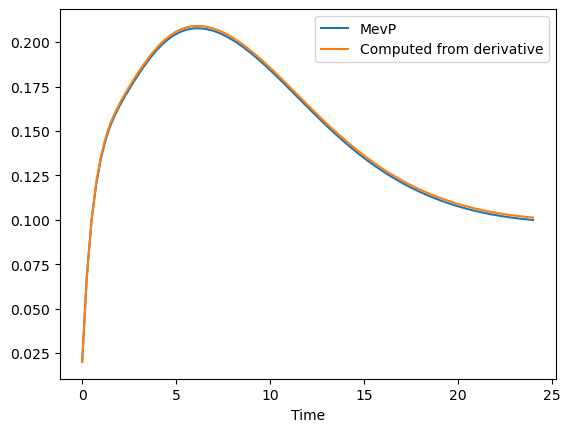

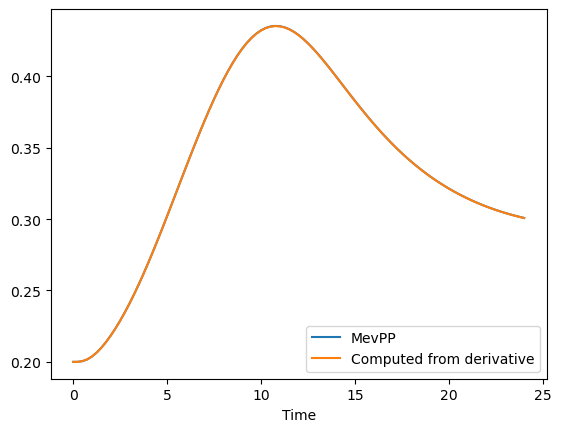

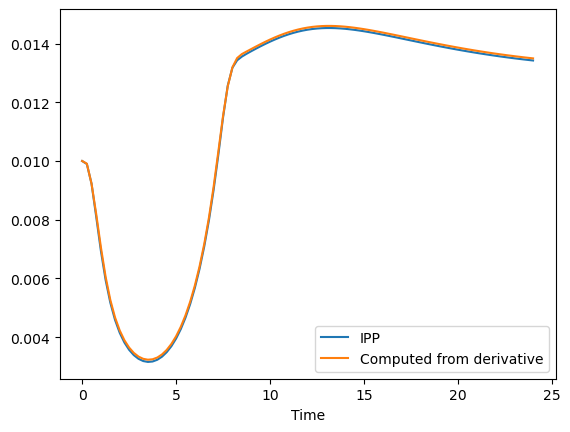

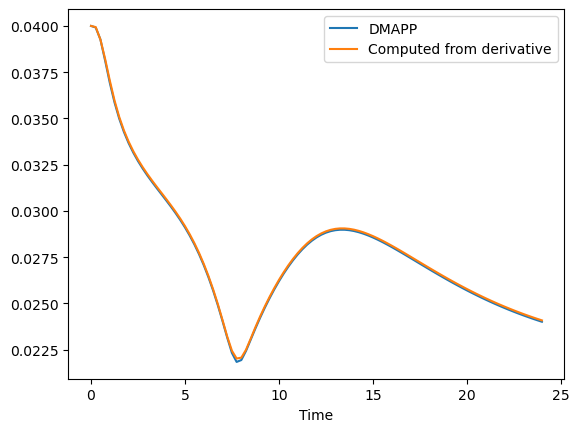

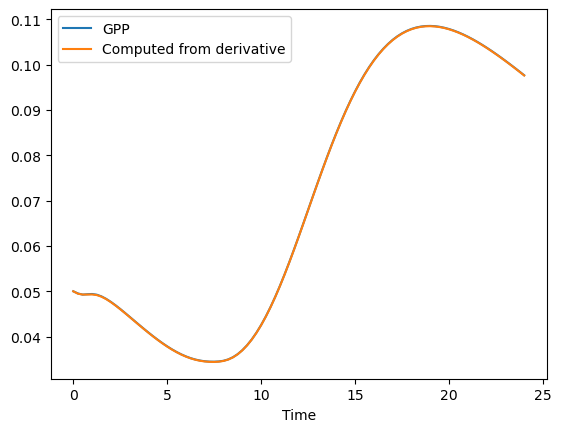

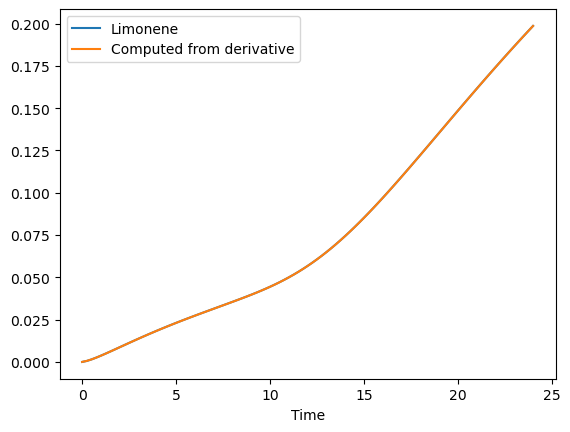

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303073        0.195043  0.057155   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.524272e+05   0.294538        0.181467  0.079599   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021363   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.250311  0.069661  0.200059  0.009901  0.039914  0.049716   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.197732  0.121566  0.201742  0.008158  0.038120  0.050221   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003035 -0.000069 -0.000325 -0.003293  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 2.086327E+180 | 1.178650E+108
     2 |       74 | 6.464234E+117 | 3.457427E+106
     3 |      138 | 4.022961E+105 |  3.643045E+86
     4 |      202 |  5.684336E+95 |  5.471273E+77
     5 |      266 |  8.036022E+84 |  9.758718E+71
     6 |      330 |  1.270532E+74 |  1.194672E+61
     7 |      394 |  3.455108E+74 |  9.444883E+55
     8 |      458 |  1.452402E+61 |  7.781164E+50
     9 |      522 |  1.203049E+54 |  5.443592E+46
    10 |      586 |  3.015051E+52 |  2.665033E+42
    11 |      650 |  1.253611E+46 |  2.037526E+38
    12 |      714 |  1.416004E+47 |  3.101335E+36
    13 |      778 |  7.830962E+43 |  5.722284E+31
    14 |      842 |  7.924795E+39 |  6.843809E+29
    15 |      906 |  2.140545E+38 |  1.837976E+29
    16 |      970 |  5.524191E+35 |  1.837976E+29
    17 |     1034 |  2.829342E+35 |  3.062233E+27
    18 |     1098 |  3.644488E+29 |  4.276637E+20
    19 |     1162 |  9.692

   162 |    10314 |  2.029700E+01 |  1.636756E+01
   163 |    10378 |  2.019418E+01 |  1.636756E+01
   164 |    10442 |  2.052706E+01 |  1.636756E+01
   165 |    10506 |  1.912562E+01 |  1.636756E+01
   166 |    10570 |  1.963021E+01 |  1.636756E+01
   167 |    10634 |  2.043604E+01 |  1.636756E+01
   168 |    10698 |  2.037997E+01 |  1.636756E+01
   169 |    10762 |  2.019557E+01 |  1.636756E+01
   170 |    10826 |  1.984092E+01 |  1.636756E+01
   171 |    10890 |  2.002066E+01 |  1.636756E+01
   172 |    10954 |  2.026348E+01 |  1.636756E+01
   173 |    11018 |  2.013533E+01 |  1.636756E+01
   174 |    11082 |  1.949073E+01 |  1.636756E+01
   175 |    11146 |  2.127695E+01 |  1.636756E+01
   176 |    11210 |  2.034568E+01 |  1.636756E+01
   177 |    11274 |  2.062802E+01 |  1.636756E+01
   178 |    11338 |  2.110221E+01 |  1.636756E+01
   179 |    11402 |  2.069344E+01 |  1.636756E+01
   180 |    11466 |  1.943899E+01 |  1.636756E+01
   181 |    11530 |  2.009601E+01 |  1.636756E+01


   326 |    20810 |  1.230745E+01 |  1.093851E+01
   327 |    20874 |  1.227138E+01 |  1.093851E+01
   328 |    20938 |  1.225660E+01 |  1.093851E+01
   329 |    21002 |  1.213712E+01 |  1.093851E+01
   330 |    21066 |  1.218760E+01 |  1.093851E+01
   331 |    21130 |  1.204279E+01 |  1.093851E+01
   332 |    21194 |  1.254965E+01 |  1.093851E+01
   333 |    21258 |  1.242085E+01 |  1.093851E+01
   334 |    21322 |  1.218090E+01 |  1.093851E+01
   335 |    21386 |  1.222030E+01 |  1.093851E+01
   336 |    21450 |  1.240472E+01 |  1.093851E+01
   337 |    21514 |  1.244320E+01 |  1.093851E+01
   338 |    21578 |  1.222928E+01 |  1.093851E+01
   339 |    21642 |  1.207294E+01 |  1.093851E+01
   340 |    21706 |  1.215301E+01 |  1.093851E+01
   341 |    21770 |  1.224928E+01 |  1.093851E+01
   342 |    21834 |  1.206722E+01 |  1.093851E+01
   343 |    21898 |  1.206408E+01 |  1.093851E+01
   344 |    21962 |  1.199191E+01 |  1.093851E+01
   345 |    22026 |  1.214025E+01 |  1.093851E+01


   490 |    31306 |  8.7173868182 |  8.3779624777
   491 |    31370 |  8.7700268467 |  8.3779624777
   492 |    31434 |  8.7669580789 |  8.3779624777
   493 |    31498 |  8.8078815608 |  8.3779624777
   494 |    31562 |  8.8060782488 |  8.3779624777
   495 |    31626 |  8.8983923873 |  8.3779624777
   496 |    31690 |  8.7806413715 |  8.3779624777
   497 |    31754 |  8.8727730380 |  8.3779624777
   498 |    31818 |  8.7703094118 |  8.3779624777
   499 |    31882 |  8.9060261980 |  8.3779624777
   500 |    31946 |  8.9007898213 |  8.3779624777
   501 |    32010 |  8.9505520419 |  8.3779624777
   502 |    32074 |  8.8835847974 |  8.3779624777
   503 |    32138 |  8.9208396884 |  8.3779624777
   504 |    32202 |  8.8184125013 |  8.3779624777
   505 |    32266 |  8.7476669620 |  8.3779624777
   506 |    32330 |  8.7483817763 |  8.3779624777
   507 |    32394 |  8.7609874794 |  8.3779624777
   508 |    32458 |  8.8229126178 |  8.3779624777
   509 |    32522 |  8.7331571990 |  8.3779624777


   654 |    41802 |  7.8411733795 |  7.7332118955
   655 |    41866 |  7.8262483157 |  7.6865301385
   656 |    41930 |  7.8404117023 |  7.6865301385
   657 |    41994 |  7.8370330804 |  7.6865301385
   658 |    42058 |  7.8575652185 |  7.6865301385
   659 |    42122 |  7.8888495073 |  7.6865301385
   660 |    42186 |  7.8848610329 |  7.6865301385
   661 |    42250 |  7.9046051430 |  7.6865301385
   662 |    42314 |  7.8741532943 |  7.6865301385
   663 |    42378 |  7.9121815347 |  7.6865301385
   664 |    42442 |  7.8934500692 |  7.6865301385
   665 |    42506 |  7.8844773503 |  7.6865301385
   666 |    42570 |  7.8657633097 |  7.6865301385
   667 |    42634 |  7.8398778891 |  7.6865301385
   668 |    42698 |  7.8655805795 |  7.6865301385
   669 |    42762 |  7.8206036505 |  7.6865301385
   670 |    42826 |  7.8277295353 |  7.6865301385
   671 |    42890 |  7.8475788029 |  7.6865301385
   672 |    42954 |  7.8277277738 |  7.6865301385
   673 |    43018 |  7.8313635176 |  7.6865301385


   818 |    52298 |  6.4346744316 |  6.3748226249
   819 |    52362 |  6.4240936956 |  6.3748226249
   820 |    52426 |  6.3951002538 |  6.3351110366
   821 |    52490 |  6.3678270804 |  6.3351110366
   822 |    52554 |  6.3621363948 |  6.3245968092
   823 |    52618 |  6.3806979346 |  6.3245968092
   824 |    52682 |  6.3830274700 |  6.3245968092
   825 |    52746 |  6.3679450481 |  6.3245968092
   826 |    52810 |  6.3957629422 |  6.3245968092
   827 |    52874 |  6.3898240927 |  6.3245968092
   828 |    52938 |  6.3748570608 |  6.3105841508
   829 |    53002 |  6.3649059722 |  6.2945329792
   830 |    53066 |  6.3610332167 |  6.2945329792
   831 |    53130 |  6.3664242037 |  6.2945329792
   832 |    53194 |  6.3655242237 |  6.2945329792
   833 |    53258 |  6.3379422374 |  6.2939825230
   834 |    53322 |  6.3289624871 |  6.2913200079
   835 |    53386 |  6.3457641651 |  6.2913200079
   836 |    53450 |  6.3502382888 |  6.2913200079
   837 |    53514 |  6.3300247847 |  6.2717065437


   982 |    62794 |  5.9787417707 |  5.9727447978
   983 |    62858 |  5.9761626199 |  5.9721206206
   984 |    62922 |  5.9720365866 |  5.9654607363
   985 |    62986 |  5.9708216692 |  5.9654607363
   986 |    63050 |  5.9680263061 |  5.9645885417
   987 |    63114 |  5.9682094898 |  5.9613263454
   988 |    63178 |  5.9689528141 |  5.9613263454
   989 |    63242 |  5.9644710457 |  5.9563369138
   990 |    63306 |  5.9617385855 |  5.9518952087
   991 |    63370 |  5.9572170894 |  5.9504429691
   992 |    63434 |  5.9519545665 |  5.9472653144
   993 |    63498 |  5.9497535808 |  5.9464824649
   994 |    63562 |  5.9459300160 |  5.9379156958
   995 |    63626 |  5.9431614580 |  5.9379156958
   996 |    63690 |  5.9418996709 |  5.9361589969
   997 |    63754 |  5.9394269245 |  5.9348243189
   998 |    63818 |  5.9396442885 |  5.9320380375
   999 |    63882 |  5.9359890592 |  5.9314354130
  1000 |    63946 |  5.9326708648 |  5.9293985111
  1001 |    64010 |  5.9291469346 |  5.9211387667


  1146 |    73290 |  4.3657209653 |  4.3034032539
  1147 |    73354 |  4.3161624552 |  4.2340764385
  1148 |    73418 |  4.2838027872 |  4.2340764385
  1149 |    73482 |  4.2577144183 |  4.1815459824
  1150 |    73546 |  4.2448754318 |  4.1521024256
  1151 |    73610 |  4.1780940155 |  4.0634585057
  1152 |    73674 |  4.1348047325 |  4.0634585057
  1153 |    73738 |  4.1448389585 |  4.0634585057
  1154 |    73802 |  4.1063172472 |  4.0335797899
  1155 |    73866 |  4.0809179784 |  4.0071580670
  1156 |    73930 |  4.0353961645 |  3.9978003452
  1157 |    73994 |  4.0441830329 |  3.9614942214
  1158 |    74058 |  3.9498992853 |  3.8716496620
  1159 |    74122 |  3.9084255703 |  3.8119811053
  1160 |    74186 |  3.8693983269 |  3.8119811053
  1161 |    74250 |  3.8636183396 |  3.8080398793
  1162 |    74314 |  3.8484596348 |  3.8080398793
  1163 |    74378 |  3.8238351624 |  3.7833325643
  1164 |    74442 |  3.8135152039 |  3.7739934183
  1165 |    74506 |  3.7751275581 |  3.7278318003


  1310 |    83786 |  2.3822610583 |  2.3713871507
  1311 |    83850 |  2.3798161966 |  2.3661213113
  1312 |    83914 |  2.3752477039 |  2.3639493880
  1313 |    83978 |  2.3673821956 |  2.3558451913
  1314 |    84042 |  2.3668673034 |  2.3558451913
  1315 |    84106 |  2.3597122859 |  2.3517801971
  1316 |    84170 |  2.3520603173 |  2.3305967769
  1317 |    84234 |  2.3451570131 |  2.3305967769
  1318 |    84298 |  2.3395205993 |  2.3305967769
  1319 |    84362 |  2.3323815357 |  2.3193386108
  1320 |    84426 |  2.3292097054 |  2.3193386108
  1321 |    84490 |  2.3306006577 |  2.3193386108
  1322 |    84554 |  2.3285686928 |  2.3193386108
  1323 |    84618 |  2.3261668657 |  2.3152238023
  1324 |    84682 |  2.3283554722 |  2.3152238023
  1325 |    84746 |  2.3311712757 |  2.3152238023
  1326 |    84810 |  2.3265287876 |  2.3141607096
  1327 |    84874 |  2.3321162430 |  2.3141607096
  1328 |    84938 |  2.3266513963 |  2.3075939491
  1329 |    85002 |  2.3269090335 |  2.3075939491


  1474 |    94282 |  2.2039478915 |  2.2021337007
  1475 |    94346 |  2.2029427934 |  2.2014711818
  1476 |    94410 |  2.2024638985 |  2.2013460895
  1477 |    94474 |  2.2019084780 |  2.2011514179
  1478 |    94538 |  2.2008272028 |  2.1998799431
  1479 |    94602 |  2.1999059927 |  2.1988724572
  1480 |    94666 |  2.1993507624 |  2.1981034929
  1481 |    94730 |  2.1985726272 |  2.1957591837
  1482 |    94794 |  2.1963441912 |  2.1939124957
  1483 |    94858 |  2.1940284419 |  2.1923439185
  1484 |    94922 |  2.1932849186 |  2.1919569872
  1485 |    94986 |  2.1918374335 |  2.1906237660
  1486 |    95050 |  2.1904864176 |  2.1884111703
  1487 |    95114 |  2.1888712624 |  2.1867257278
  1488 |    95178 |  2.1875591497 |  2.1856714664
  1489 |    95242 |  2.1862308396 |  2.1841651877
  1490 |    95306 |  2.1845741355 |  2.1826131324
  1491 |    95370 |  2.1837149031 |  2.1821099140
  1492 |    95434 |  2.1811983504 |  2.1751770808
  1493 |    95498 |  2.1777015998 |  2.1746791905


  1638 |   104778 |  2.0652725216 |  2.0644248427
  1639 |   104842 |  2.0651537710 |  2.0644248427
  1640 |   104906 |  2.0645960373 |  2.0639749420
  1641 |   104970 |  2.0644013553 |  2.0638227659
  1642 |   105034 |  2.0640521871 |  2.0633836255
  1643 |   105098 |  2.0639539237 |  2.0633836255
  1644 |   105162 |  2.0635727529 |  2.0630628016
  1645 |   105226 |  2.0635489644 |  2.0629403391
  1646 |   105290 |  2.0633652587 |  2.0625181113
  1647 |   105354 |  2.0628474447 |  2.0622925544
  1648 |   105418 |  2.0626365302 |  2.0616871315
  1649 |   105482 |  2.0622719887 |  2.0616871315
  1650 |   105546 |  2.0624560217 |  2.0616871315
  1651 |   105610 |  2.0618961439 |  2.0606834339
  1652 |   105674 |  2.0612637359 |  2.0604180253
  1653 |   105738 |  2.0610928262 |  2.0604180253
  1654 |   105802 |  2.0606586254 |  2.0602759746
  1655 |   105866 |  2.0606257307 |  2.0600724028
  1656 |   105930 |  2.0602439355 |  2.0598689256
  1657 |   105994 |  2.0598883664 |  2.0593555544


  1802 |   115274 |  2.0232702198 |  2.0227738904
  1803 |   115338 |  2.0231052267 |  2.0223645243
  1804 |   115402 |  2.0227699775 |  2.0223645243
  1805 |   115466 |  2.0224678377 |  2.0217183487
  1806 |   115530 |  2.0220913876 |  2.0217183487
  1807 |   115594 |  2.0217387221 |  2.0216061790
  1808 |   115658 |  2.0213914725 |  2.0210000642
  1809 |   115722 |  2.0211686270 |  2.0207689934
  1810 |   115786 |  2.0208844371 |  2.0202481563
  1811 |   115850 |  2.0206700210 |  2.0202136031
  1812 |   115914 |  2.0204405812 |  2.0201745139
  1813 |   115978 |  2.0202528393 |  2.0198183966
  1814 |   116042 |  2.0199900215 |  2.0197827979
  1815 |   116106 |  2.0197698969 |  2.0195559766
  1816 |   116170 |  2.0196708934 |  2.0191941970
  1817 |   116234 |  2.0194278548 |  2.0187706382
  1818 |   116298 |  2.0190884174 |  2.0183794918
  1819 |   116362 |  2.0185681495 |  2.0177424698
  1820 |   116426 |  2.0180105302 |  2.0177353629
  1821 |   116490 |  2.0180892687 |  2.0175136639


  1966 |   125770 |  1.9734864794 |  1.9729775433
  1967 |   125834 |  1.9732418752 |  1.9726804946
  1968 |   125898 |  1.9730998427 |  1.9726804946
  1969 |   125962 |  1.9729173916 |  1.9725652714
  1970 |   126026 |  1.9726099069 |  1.9717660372
  1971 |   126090 |  1.9721515763 |  1.9716003632
  1972 |   126154 |  1.9721019079 |  1.9716003632
  1973 |   126218 |  1.9718962539 |  1.9713526349
  1974 |   126282 |  1.9720643829 |  1.9713526349
  1975 |   126346 |  1.9717846197 |  1.9713087553
  1976 |   126410 |  1.9717011456 |  1.9713087553
  1977 |   126474 |  1.9715306593 |  1.9712564051
  1978 |   126538 |  1.9712985137 |  1.9710402728
  1979 |   126602 |  1.9710580779 |  1.9704902629
  1980 |   126666 |  1.9710121251 |  1.9704902629
  1981 |   126730 |  1.9709587040 |  1.9704902629
  1982 |   126794 |  1.9704929448 |  1.9697739308
  1983 |   126858 |  1.9702957844 |  1.9697739308
  1984 |   126922 |  1.9700067682 |  1.9697739308
  1985 |   126986 |  1.9698109166 |  1.9694958843


  2130 |   136266 |  1.9397609948 |  1.9393136431
  2131 |   136330 |  1.9394130947 |  1.9388310891
  2132 |   136394 |  1.9391623224 |  1.9387186364
  2133 |   136458 |  1.9389366491 |  1.9386493938
  2134 |   136522 |  1.9387595334 |  1.9385476845
  2135 |   136586 |  1.9387213238 |  1.9385213690
  2136 |   136650 |  1.9384611067 |  1.9380784296
  2137 |   136714 |  1.9384829499 |  1.9380784296
  2138 |   136778 |  1.9383458445 |  1.9379391217
  2139 |   136842 |  1.9381895138 |  1.9378797913
  2140 |   136906 |  1.9381771296 |  1.9378718862
  2141 |   136970 |  1.9379985033 |  1.9375616037
  2142 |   137034 |  1.9379660510 |  1.9373923823
  2143 |   137098 |  1.9379084617 |  1.9370034709
  2144 |   137162 |  1.9375893905 |  1.9367587286
  2145 |   137226 |  1.9372686326 |  1.9365443851
  2146 |   137290 |  1.9371490089 |  1.9362692821
  2147 |   137354 |  1.9368787742 |  1.9362692821
  2148 |   137418 |  1.9367087523 |  1.9362692821
  2149 |   137482 |  1.9363520532 |  1.9358887907


  2294 |   146762 |  1.9222523645 |  1.9220984021
  2295 |   146826 |  1.9222306143 |  1.9220984021
  2296 |   146890 |  1.9222098134 |  1.9220984021
  2297 |   146954 |  1.9221712383 |  1.9220984021
  2298 |   147018 |  1.9221951568 |  1.9220919574
  2299 |   147082 |  1.9221208208 |  1.9220300770
  2300 |   147146 |  1.9221160482 |  1.9220300770
  2301 |   147210 |  1.9220635936 |  1.9219604180
  2302 |   147274 |  1.9219722001 |  1.9217676830
  2303 |   147338 |  1.9218951088 |  1.9217676830
  2304 |   147402 |  1.9218742657 |  1.9217510916
  2305 |   147466 |  1.9218480509 |  1.9217455846
  2306 |   147530 |  1.9218152829 |  1.9216936564
  2307 |   147594 |  1.9217535131 |  1.9216077652
  2308 |   147658 |  1.9216880911 |  1.9215020924
  2309 |   147722 |  1.9216569166 |  1.9215020924
  2310 |   147786 |  1.9216309135 |  1.9215020924
  2311 |   147850 |  1.9215724466 |  1.9213728727
  2312 |   147914 |  1.9214832873 |  1.9213714591
  2313 |   147978 |  1.9214837644 |  1.9213714591


  2458 |   157258 |  1.9158200602 |  1.9157408133
  2459 |   157322 |  1.9157987418 |  1.9156979367
  2460 |   157386 |  1.9157508074 |  1.9156697742
  2461 |   157450 |  1.9157155205 |  1.9156329664
  2462 |   157514 |  1.9156601938 |  1.9156045840
  2463 |   157578 |  1.9156269839 |  1.9155395284
  2464 |   157642 |  1.9155592119 |  1.9154629650
  2465 |   157706 |  1.9154746962 |  1.9154148158
  2466 |   157770 |  1.9154201686 |  1.9152610907
  2467 |   157834 |  1.9153666894 |  1.9152610907
  2468 |   157898 |  1.9153381677 |  1.9151992239
  2469 |   157962 |  1.9152757213 |  1.9150301004
  2470 |   158026 |  1.9152276478 |  1.9150301004
  2471 |   158090 |  1.9151261583 |  1.9148861895
  2472 |   158154 |  1.9150067146 |  1.9148289534
  2473 |   158218 |  1.9149586355 |  1.9148289534
  2474 |   158282 |  1.9148971553 |  1.9147870466
  2475 |   158346 |  1.9147808120 |  1.9146013596
  2476 |   158410 |  1.9147224711 |  1.9146013596
  2477 |   158474 |  1.9146953937 |  1.9146013596


  2622 |   167754 |  1.9080015875 |  1.9078904051
  2623 |   167818 |  1.9079623534 |  1.9078904051
  2624 |   167882 |  1.9078813115 |  1.9077922410
  2625 |   167946 |  1.9078917118 |  1.9077922410
  2626 |   168010 |  1.9078914270 |  1.9077080937
  2627 |   168074 |  1.9078638132 |  1.9077080937
  2628 |   168138 |  1.9077850212 |  1.9076246225
  2629 |   168202 |  1.9076383785 |  1.9075132520
  2630 |   168266 |  1.9076258805 |  1.9075132520
  2631 |   168330 |  1.9075732583 |  1.9074933302
  2632 |   168394 |  1.9076151505 |  1.9074244502
  2633 |   168458 |  1.9075498412 |  1.9072831516
  2634 |   168522 |  1.9074659552 |  1.9071953791
  2635 |   168586 |  1.9073027103 |  1.9070953800
  2636 |   168650 |  1.9072310113 |  1.9070953800
  2637 |   168714 |  1.9071757221 |  1.9070288385
  2638 |   168778 |  1.9071232471 |  1.9069450009
  2639 |   168842 |  1.9070536054 |  1.9068427196
  2640 |   168906 |  1.9070209606 |  1.9068341150
  2641 |   168970 |  1.9070269396 |  1.9067285583


  2786 |   178250 |  1.8953343021 |  1.8952827773
  2787 |   178314 |  1.8952977443 |  1.8952196037
  2788 |   178378 |  1.8952326792 |  1.8951598178
  2789 |   178442 |  1.8951839734 |  1.8950765069
  2790 |   178506 |  1.8951482924 |  1.8950484922
  2791 |   178570 |  1.8950564856 |  1.8949522837
  2792 |   178634 |  1.8950065126 |  1.8949398464
  2793 |   178698 |  1.8949396287 |  1.8948267603
  2794 |   178762 |  1.8948846562 |  1.8947584244
  2795 |   178826 |  1.8948386224 |  1.8946080428
  2796 |   178890 |  1.8947279022 |  1.8946059164
  2797 |   178954 |  1.8946281317 |  1.8945483730
  2798 |   179018 |  1.8945752958 |  1.8945338987
  2799 |   179082 |  1.8945481600 |  1.8944993351
  2800 |   179146 |  1.8945071408 |  1.8944382756
  2801 |   179210 |  1.8944791310 |  1.8944169833
  2802 |   179274 |  1.8944350566 |  1.8943719008
  2803 |   179338 |  1.8943968486 |  1.8942739585
  2804 |   179402 |  1.8943066034 |  1.8941978713
  2805 |   179466 |  1.8942166337 |  1.8941211406


  2950 |   188746 |  1.8835165867 |  1.8832147980
  2951 |   188810 |  1.8833946131 |  1.8832147980
  2952 |   188874 |  1.8832753097 |  1.8831132907
  2953 |   188938 |  1.8830558160 |  1.8828268351
  2954 |   189002 |  1.8828610433 |  1.8826492311
  2955 |   189066 |  1.8827458164 |  1.8820443152
  2956 |   189130 |  1.8821537994 |  1.8817316414
  2957 |   189194 |  1.8820015080 |  1.8817208997
  2958 |   189258 |  1.8817314226 |  1.8812281241
  2959 |   189322 |  1.8814712328 |  1.8809318703
  2960 |   189386 |  1.8811610581 |  1.8808549267
  2961 |   189450 |  1.8810545698 |  1.8806579131
  2962 |   189514 |  1.8808622781 |  1.8804332847
  2963 |   189578 |  1.8804461284 |  1.8799286754
  2964 |   189642 |  1.8803613870 |  1.8799286754
  2965 |   189706 |  1.8800423275 |  1.8797475954
  2966 |   189770 |  1.8797466722 |  1.8794228668
  2967 |   189834 |  1.8797417774 |  1.8793780432
  2968 |   189898 |  1.8796139841 |  1.8793780432
  2969 |   189962 |  1.8796147891 |  1.8792323841


  3114 |   199242 |  1.8369998955 |  1.8363480330
  3115 |   199306 |  1.8368611933 |  1.8363480330
  3116 |   199370 |  1.8366078365 |  1.8362412647
  3117 |   199434 |  1.8361609483 |  1.8358659502
  3118 |   199498 |  1.8361260750 |  1.8358659502
  3119 |   199562 |  1.8359246739 |  1.8352020086
  3120 |   199626 |  1.8354965817 |  1.8350790970
  3121 |   199690 |  1.8351841090 |  1.8347914242
  3122 |   199754 |  1.8348459050 |  1.8345560909
  3123 |   199818 |  1.8346689168 |  1.8343696421
  3124 |   199882 |  1.8346263849 |  1.8343696421
  3125 |   199946 |  1.8344856791 |  1.8342743102
  3126 |   200010 |  1.8343749837 |  1.8341720978
  3127 |   200074 |  1.8342929585 |  1.8341720978
  3128 |   200138 |  1.8340361036 |  1.8336852060
  3129 |   200202 |  1.8337380884 |  1.8333197448
  3130 |   200266 |  1.8334320630 |  1.8332186186
  3131 |   200330 |  1.8334052320 |  1.8331654239
  3132 |   200394 |  1.8332173567 |  1.8328459261
  3133 |   200458 |  1.8330171723 |  1.8326198302


  3278 |   209738 |  1.7823980242 |  1.7820404339
  3279 |   209802 |  1.7820081898 |  1.7810538909
  3280 |   209866 |  1.7819250501 |  1.7810126110
  3281 |   209930 |  1.7813837960 |  1.7803707932
  3282 |   209994 |  1.7809593836 |  1.7798944647
  3283 |   210058 |  1.7806549603 |  1.7797221503
  3284 |   210122 |  1.7802893856 |  1.7781903655
  3285 |   210186 |  1.7798587382 |  1.7781903655
  3286 |   210250 |  1.7789845994 |  1.7777234855
  3287 |   210314 |  1.7778693111 |  1.7754281458
  3288 |   210378 |  1.7778725287 |  1.7754281458
  3289 |   210442 |  1.7765214320 |  1.7750094707
  3290 |   210506 |  1.7755937837 |  1.7748711670
  3291 |   210570 |  1.7751278730 |  1.7742862098
  3292 |   210634 |  1.7742108999 |  1.7722584796
  3293 |   210698 |  1.7733321365 |  1.7720259136
  3294 |   210762 |  1.7732729756 |  1.7720259136
  3295 |   210826 |  1.7731293524 |  1.7718180477
  3296 |   210890 |  1.7731589249 |  1.7718180477
  3297 |   210954 |  1.7725521184 |  1.7707372336


  3442 |   220234 |  1.7462109079 |  1.7456918067
  3443 |   220298 |  1.7461873877 |  1.7456918067
  3444 |   220362 |  1.7460577990 |  1.7456918067
  3445 |   220426 |  1.7461274621 |  1.7456918067
  3446 |   220490 |  1.7459448341 |  1.7456918067
  3447 |   220554 |  1.7459123289 |  1.7454910129
  3448 |   220618 |  1.7458322904 |  1.7453678458
  3449 |   220682 |  1.7457914900 |  1.7453678458
  3450 |   220746 |  1.7457577704 |  1.7453678458
  3451 |   220810 |  1.7456506259 |  1.7452318210
  3452 |   220874 |  1.7456532098 |  1.7452318210
  3453 |   220938 |  1.7454589882 |  1.7452295158
  3454 |   221002 |  1.7453536259 |  1.7448922249
  3455 |   221066 |  1.7450359129 |  1.7446761048
  3456 |   221130 |  1.7450029134 |  1.7446761048
  3457 |   221194 |  1.7448191249 |  1.7445848989
  3458 |   221258 |  1.7448231980 |  1.7444634055
  3459 |   221322 |  1.7447053304 |  1.7443892899
  3460 |   221386 |  1.7445500534 |  1.7443304609
  3461 |   221450 |  1.7443996621 |  1.7442097174


  3606 |   230730 |  1.7297801703 |  1.7296091276
  3607 |   230794 |  1.7297521680 |  1.7296091276
  3608 |   230858 |  1.7297732935 |  1.7295770793
  3609 |   230922 |  1.7296635001 |  1.7294294579
  3610 |   230986 |  1.7296477711 |  1.7293385397
  3611 |   231050 |  1.7295328593 |  1.7293385397
  3612 |   231114 |  1.7295092202 |  1.7292770691
  3613 |   231178 |  1.7294647949 |  1.7291846143
  3614 |   231242 |  1.7293321158 |  1.7291298493
  3615 |   231306 |  1.7292605856 |  1.7291298493
  3616 |   231370 |  1.7292354314 |  1.7289748016
  3617 |   231434 |  1.7290884465 |  1.7288740688
  3618 |   231498 |  1.7289132362 |  1.7287347466
  3619 |   231562 |  1.7288527968 |  1.7287347466
  3620 |   231626 |  1.7288365914 |  1.7285966651
  3621 |   231690 |  1.7287114333 |  1.7284190530
  3622 |   231754 |  1.7285546444 |  1.7282877202
  3623 |   231818 |  1.7284001835 |  1.7281413919
  3624 |   231882 |  1.7282093712 |  1.7279577399
  3625 |   231946 |  1.7280177777 |  1.7277919600


  3770 |   241226 |  1.6780553620 |  1.6775771473
  3771 |   241290 |  1.6776406961 |  1.6772617270
  3772 |   241354 |  1.6773435780 |  1.6768865784
  3773 |   241418 |  1.6768937922 |  1.6765327068
  3774 |   241482 |  1.6764896301 |  1.6762214861
  3775 |   241546 |  1.6762080231 |  1.6758656185
  3776 |   241610 |  1.6759271989 |  1.6755420686
  3777 |   241674 |  1.6755268262 |  1.6752306252
  3778 |   241738 |  1.6751708893 |  1.6747423600
  3779 |   241802 |  1.6748708585 |  1.6745669286
  3780 |   241866 |  1.6747060629 |  1.6744839442
  3781 |   241930 |  1.6745864005 |  1.6743665549
  3782 |   241994 |  1.6743747120 |  1.6740081096
  3783 |   242058 |  1.6740935589 |  1.6735155214
  3784 |   242122 |  1.6737337740 |  1.6729331780
  3785 |   242186 |  1.6733848440 |  1.6729331780
  3786 |   242250 |  1.6730899736 |  1.6726048415
  3787 |   242314 |  1.6727374410 |  1.6722710811
  3788 |   242378 |  1.6723928344 |  1.6718686696
  3789 |   242442 |  1.6720819758 |  1.6713312653


  3934 |   251722 |  1.6305198164 |  1.6298889206
  3935 |   251786 |  1.6295841674 |  1.6289897915
  3936 |   251850 |  1.6289905356 |  1.6280856197
  3937 |   251914 |  1.6284449398 |  1.6278199035
  3938 |   251978 |  1.6279576795 |  1.6272278017
  3939 |   252042 |  1.6274555191 |  1.6268281224
  3940 |   252106 |  1.6268428741 |  1.6264288362
  3941 |   252170 |  1.6262815296 |  1.6255528278
  3942 |   252234 |  1.6256952286 |  1.6247584283
  3943 |   252298 |  1.6250382109 |  1.6245627343
  3944 |   252362 |  1.6245375941 |  1.6241649358
  3945 |   252426 |  1.6239012641 |  1.6234492410
  3946 |   252490 |  1.6233676488 |  1.6228015791
  3947 |   252554 |  1.6229718398 |  1.6223900673
  3948 |   252618 |  1.6226861266 |  1.6222719974
  3949 |   252682 |  1.6223041045 |  1.6216231614
  3950 |   252746 |  1.6218837347 |  1.6215164939
  3951 |   252810 |  1.6215509964 |  1.6211877219
  3952 |   252874 |  1.6212222605 |  1.6206784556
  3953 |   252938 |  1.6208145289 |  1.6202484698


  4098 |   262218 |  1.5740409262 |  1.5737110256
  4099 |   262282 |  1.5739073006 |  1.5734662673
  4100 |   262346 |  1.5735714156 |  1.5731446519
  4101 |   262410 |  1.5733499746 |  1.5728976326
  4102 |   262474 |  1.5730110029 |  1.5725363864
  4103 |   262538 |  1.5727896819 |  1.5724350038
  4104 |   262602 |  1.5724184628 |  1.5720582392
  4105 |   262666 |  1.5721804839 |  1.5716129670
  4106 |   262730 |  1.5716030367 |  1.5711228935
  4107 |   262794 |  1.5712395845 |  1.5698049947
  4108 |   262858 |  1.5705175722 |  1.5697292191
  4109 |   262922 |  1.5701086777 |  1.5692099936
  4110 |   262986 |  1.5694030308 |  1.5689519708
  4111 |   263050 |  1.5691276109 |  1.5688864258
  4112 |   263114 |  1.5690590270 |  1.5684942691
  4113 |   263178 |  1.5687492601 |  1.5682208275
  4114 |   263242 |  1.5683328756 |  1.5676115027
  4115 |   263306 |  1.5674008216 |  1.5668266293
  4116 |   263370 |  1.5670923610 |  1.5668266293
  4117 |   263434 |  1.5669813386 |  1.5662825133


  4262 |   272714 |  1.5003159440 |  1.4995406175
  4263 |   272778 |  1.4995188024 |  1.4984553028
  4264 |   272842 |  1.4992993739 |  1.4979716167
  4265 |   272906 |  1.4986241140 |  1.4974145125
  4266 |   272970 |  1.4979770739 |  1.4974145125
  4267 |   273034 |  1.4976826918 |  1.4970718899
  4268 |   273098 |  1.4974428933 |  1.4964417281
  4269 |   273162 |  1.4969900578 |  1.4960894745
  4270 |   273226 |  1.4967498163 |  1.4960894745
  4271 |   273290 |  1.4965546820 |  1.4959145302
  4272 |   273354 |  1.4962984004 |  1.4954671404
  4273 |   273418 |  1.4959349204 |  1.4954671404
  4274 |   273482 |  1.4956838197 |  1.4951883556
  4275 |   273546 |  1.4951013866 |  1.4947347804
  4276 |   273610 |  1.4952602947 |  1.4947142751
  4277 |   273674 |  1.4951950339 |  1.4945079930
  4278 |   273738 |  1.4947567286 |  1.4937836310
  4279 |   273802 |  1.4943404312 |  1.4934761050
  4280 |   273866 |  1.4937025180 |  1.4924977806
  4281 |   273930 |  1.4929873058 |  1.4915050686


  4426 |   283210 |  1.4394311383 |  1.4389946523
  4427 |   283274 |  1.4392062840 |  1.4388861678
  4428 |   283338 |  1.4390399398 |  1.4383669969
  4429 |   283402 |  1.4388364571 |  1.4383669969
  4430 |   283466 |  1.4386177176 |  1.4382041659
  4431 |   283530 |  1.4384998685 |  1.4381886777
  4432 |   283594 |  1.4381960698 |  1.4378924514
  4433 |   283658 |  1.4380353479 |  1.4377526407
  4434 |   283722 |  1.4379879147 |  1.4376546711
  4435 |   283786 |  1.4377313429 |  1.4374275167
  4436 |   283850 |  1.4374639342 |  1.4372190435
  4437 |   283914 |  1.4373391622 |  1.4371293348
  4438 |   283978 |  1.4371937359 |  1.4367706747
  4439 |   284042 |  1.4368956329 |  1.4365422196
  4440 |   284106 |  1.4369081661 |  1.4365422196
  4441 |   284170 |  1.4366191288 |  1.4362312114
  4442 |   284234 |  1.4365096041 |  1.4362312114
  4443 |   284298 |  1.4364877694 |  1.4362312114
  4444 |   284362 |  1.4363939548 |  1.4362312114
  4445 |   284426 |  1.4363593134 |  1.4362213457


  4590 |   293706 |  1.4157804736 |  1.4153672760
  4591 |   293770 |  1.4154914247 |  1.4151253721
  4592 |   293834 |  1.4154778115 |  1.4151253721
  4593 |   293898 |  1.4151732175 |  1.4148849586
  4594 |   293962 |  1.4150964771 |  1.4148131214
  4595 |   294026 |  1.4149417212 |  1.4147155681
  4596 |   294090 |  1.4146227331 |  1.4140887016
  4597 |   294154 |  1.4144241208 |  1.4140887016
  4598 |   294218 |  1.4144148749 |  1.4140887016
  4599 |   294282 |  1.4140760268 |  1.4137424055
  4600 |   294346 |  1.4138451359 |  1.4134141320
  4601 |   294410 |  1.4136334435 |  1.4132960958
  4602 |   294474 |  1.4133857092 |  1.4131891327
  4603 |   294538 |  1.4133326337 |  1.4129108637
  4604 |   294602 |  1.4131682860 |  1.4128159709
  4605 |   294666 |  1.4131003435 |  1.4128159709
  4606 |   294730 |  1.4130514046 |  1.4127681991
  4607 |   294794 |  1.4128773448 |  1.4125153739
  4608 |   294858 |  1.4126867754 |  1.4123571542
  4609 |   294922 |  1.4122895346 |  1.4119651498


  4754 |   304202 |  1.3890019678 |  1.3887725445
  4755 |   304266 |  1.3888112521 |  1.3886048046
  4756 |   304330 |  1.3886039145 |  1.3883619952
  4757 |   304394 |  1.3884508594 |  1.3880892724
  4758 |   304458 |  1.3883696966 |  1.3880892724
  4759 |   304522 |  1.3883519785 |  1.3880314487
  4760 |   304586 |  1.3881565432 |  1.3878429767
  4761 |   304650 |  1.3880705288 |  1.3877082228
  4762 |   304714 |  1.3880199318 |  1.3877082228
  4763 |   304778 |  1.3880269518 |  1.3877082228
  4764 |   304842 |  1.3878954304 |  1.3876059985
  4765 |   304906 |  1.3878098327 |  1.3875435949
  4766 |   304970 |  1.3875723589 |  1.3874147272
  4767 |   305034 |  1.3875068231 |  1.3873136865
  4768 |   305098 |  1.3874545042 |  1.3873084568
  4769 |   305162 |  1.3873303519 |  1.3871748944
  4770 |   305226 |  1.3872612263 |  1.3869815744
  4771 |   305290 |  1.3871092650 |  1.3869200063
  4772 |   305354 |  1.3870594844 |  1.3868669521
  4773 |   305418 |  1.3870531667 |  1.3868669521


  4918 |   314698 |  1.3704428346 |  1.3701824469
  4919 |   314762 |  1.3702595809 |  1.3700333059
  4920 |   314826 |  1.3700933856 |  1.3699414867
  4921 |   314890 |  1.3698603646 |  1.3695389026
  4922 |   314954 |  1.3697490435 |  1.3695389026
  4923 |   315018 |  1.3696378974 |  1.3695220907
  4924 |   315082 |  1.3693614380 |  1.3688670132
  4925 |   315146 |  1.3690027012 |  1.3687073324
  4926 |   315210 |  1.3687346271 |  1.3684116302
  4927 |   315274 |  1.3685081755 |  1.3683572882
  4928 |   315338 |  1.3684221074 |  1.3680382394
  4929 |   315402 |  1.3682562930 |  1.3679739764
  4930 |   315466 |  1.3681766525 |  1.3679378899
  4931 |   315530 |  1.3681334278 |  1.3679378899
  4932 |   315594 |  1.3680818760 |  1.3678921843
  4933 |   315658 |  1.3678425184 |  1.3675492293
  4934 |   315722 |  1.3677724383 |  1.3675172476
  4935 |   315786 |  1.3676561121 |  1.3674517423
  4936 |   315850 |  1.3676077462 |  1.3674517423
  4937 |   315914 |  1.3675414061 |  1.3673656957


  5082 |   325194 |  1.3524423406 |  1.3523169500
  5083 |   325258 |  1.3523901169 |  1.3523169500
  5084 |   325322 |  1.3523382368 |  1.3522366158
  5085 |   325386 |  1.3522343999 |  1.3520819197
  5086 |   325450 |  1.3521343299 |  1.3520419573
  5087 |   325514 |  1.3520375416 |  1.3519459752
  5088 |   325578 |  1.3520031146 |  1.3518264344
  5089 |   325642 |  1.3518700327 |  1.3517433746
  5090 |   325706 |  1.3517572966 |  1.3515968416
  5091 |   325770 |  1.3517038285 |  1.3515968416
  5092 |   325834 |  1.3516486730 |  1.3515069601
  5093 |   325898 |  1.3516134022 |  1.3515069601
  5094 |   325962 |  1.3515109369 |  1.3514381792
  5095 |   326026 |  1.3514399558 |  1.3512232383
  5096 |   326090 |  1.3513492261 |  1.3511608979
  5097 |   326154 |  1.3512516178 |  1.3511010839
  5098 |   326218 |  1.3511946624 |  1.3511010839
  5099 |   326282 |  1.3511354634 |  1.3510578615
  5100 |   326346 |  1.3511547229 |  1.3510378787
  5101 |   326410 |  1.3510905107 |  1.3509738658


  5246 |   335690 |  1.3385291263 |  1.3383752687
  5247 |   335754 |  1.3384798774 |  1.3383741488
  5248 |   335818 |  1.3384146936 |  1.3382260487
  5249 |   335882 |  1.3383419377 |  1.3381910294
  5250 |   335946 |  1.3382507575 |  1.3381269411
  5251 |   336010 |  1.3381589017 |  1.3380538449
  5252 |   336074 |  1.3380598362 |  1.3378957938
  5253 |   336138 |  1.3380387297 |  1.3378957938
  5254 |   336202 |  1.3380001183 |  1.3378609908
  5255 |   336266 |  1.3378784505 |  1.3378144279
  5256 |   336330 |  1.3377153709 |  1.3374976027
  5257 |   336394 |  1.3376589001 |  1.3374834211
  5258 |   336458 |  1.3376212205 |  1.3374834211
  5259 |   336522 |  1.3375167654 |  1.3374205231
  5260 |   336586 |  1.3373487364 |  1.3370815299
  5261 |   336650 |  1.3371726776 |  1.3368984227
  5262 |   336714 |  1.3370162865 |  1.3367507517
  5263 |   336778 |  1.3368892125 |  1.3366908539
  5264 |   336842 |  1.3366981774 |  1.3363319767
  5265 |   336906 |  1.3365018887 |  1.3363271445


  5410 |   346186 |  1.3228053968 |  1.3227059951
  5411 |   346250 |  1.3227626281 |  1.3226363395
  5412 |   346314 |  1.3226995753 |  1.3226101608
  5413 |   346378 |  1.3226891601 |  1.3226017884
  5414 |   346442 |  1.3226339785 |  1.3226017884
  5415 |   346506 |  1.3225781563 |  1.3224293583
  5416 |   346570 |  1.3224299209 |  1.3222451933
  5417 |   346634 |  1.3223047334 |  1.3222141748
  5418 |   346698 |  1.3222401290 |  1.3221643553
  5419 |   346762 |  1.3221006977 |  1.3219594767
  5420 |   346826 |  1.3219792545 |  1.3218329755
  5421 |   346890 |  1.3218436460 |  1.3216327329
  5422 |   346954 |  1.3217384519 |  1.3216327329
  5423 |   347018 |  1.3216854755 |  1.3215969168
  5424 |   347082 |  1.3216565162 |  1.3215482496
  5425 |   347146 |  1.3216091794 |  1.3215076427
  5426 |   347210 |  1.3215989349 |  1.3213297313
  5427 |   347274 |  1.3214617545 |  1.3212868261
  5428 |   347338 |  1.3213883511 |  1.3212320659
  5429 |   347402 |  1.3212658599 |  1.3211052715


  5574 |   356682 |  1.3059396838 |  1.3057477281
  5575 |   356746 |  1.3058545384 |  1.3057467333
  5576 |   356810 |  1.3056767003 |  1.3051990917
  5577 |   356874 |  1.3054255298 |  1.3049250686
  5578 |   356938 |  1.3051967536 |  1.3049250686
  5579 |   357002 |  1.3050553835 |  1.3048094507
  5580 |   357066 |  1.3048149551 |  1.3046775415
  5581 |   357130 |  1.3046960480 |  1.3044832349
  5582 |   357194 |  1.3046697506 |  1.3044832349
  5583 |   357258 |  1.3045982795 |  1.3044454735
  5584 |   357322 |  1.3044965547 |  1.3042054977
  5585 |   357386 |  1.3042524029 |  1.3040707048
  5586 |   357450 |  1.3041785817 |  1.3038733019
  5587 |   357514 |  1.3038707911 |  1.3035726636
  5588 |   357578 |  1.3036351399 |  1.3034170833
  5589 |   357642 |  1.3034795710 |  1.3032210181
  5590 |   357706 |  1.3033243361 |  1.3029510723
  5591 |   357770 |  1.3030333835 |  1.3027439778
  5592 |   357834 |  1.3027026240 |  1.3021601042
  5593 |   357898 |  1.3025290818 |  1.3021601042


  5738 |   367178 |  1.2805417748 |  1.2795229911
  5739 |   367242 |  1.2808487098 |  1.2795229911
  5740 |   367306 |  1.2808235383 |  1.2795229911
  5741 |   367370 |  1.2808172830 |  1.2795229911
  5742 |   367434 |  1.2806951724 |  1.2795229911
  5743 |   367498 |  1.2797936198 |  1.2784842111
  5744 |   367562 |  1.2793273233 |  1.2773976061
  5745 |   367626 |  1.2787998496 |  1.2773976061
  5746 |   367690 |  1.2786766937 |  1.2773735284
  5747 |   367754 |  1.2783973035 |  1.2773735284
  5748 |   367818 |  1.2777487903 |  1.2769444100
  5749 |   367882 |  1.2777449731 |  1.2769444100
  5750 |   367946 |  1.2775587701 |  1.2769444100
  5751 |   368010 |  1.2776787532 |  1.2769444100
  5752 |   368074 |  1.2775367430 |  1.2769444100
  5753 |   368138 |  1.2777208746 |  1.2768837461
  5754 |   368202 |  1.2777851358 |  1.2768837461
  5755 |   368266 |  1.2775113848 |  1.2768837461
  5756 |   368330 |  1.2772444905 |  1.2765007006
  5757 |   368394 |  1.2769182250 |  1.2764017886


  5902 |   377674 |  1.2367715512 |  1.2365439098
  5903 |   377738 |  1.2366995719 |  1.2364891079
  5904 |   377802 |  1.2366367175 |  1.2363440160
  5905 |   377866 |  1.2365983812 |  1.2362622919
  5906 |   377930 |  1.2363462100 |  1.2360093603
  5907 |   377994 |  1.2364099988 |  1.2360093603
  5908 |   378058 |  1.2362816597 |  1.2358439563
  5909 |   378122 |  1.2359375067 |  1.2352957746
  5910 |   378186 |  1.2356562316 |  1.2352957746
  5911 |   378250 |  1.2355851735 |  1.2352857659
  5912 |   378314 |  1.2353773262 |  1.2348906052
  5913 |   378378 |  1.2352307293 |  1.2347257656
  5914 |   378442 |  1.2354543867 |  1.2347257656
  5915 |   378506 |  1.2351914756 |  1.2344793732
  5916 |   378570 |  1.2349322286 |  1.2344793732
  5917 |   378634 |  1.2348579468 |  1.2344033540
  5918 |   378698 |  1.2346891433 |  1.2342061362
  5919 |   378762 |  1.2342096221 |  1.2334720266
  5920 |   378826 |  1.2337433521 |  1.2333489763
  5921 |   378890 |  1.2334007526 |  1.2330965038


  6066 |   388170 |  1.2218414561 |  1.2213216427
  6067 |   388234 |  1.2215433816 |  1.2210788640
  6068 |   388298 |  1.2213812385 |  1.2210281565
  6069 |   388362 |  1.2212336870 |  1.2209522296
  6070 |   388426 |  1.2211295237 |  1.2205100804
  6071 |   388490 |  1.2208332676 |  1.2205013196
  6072 |   388554 |  1.2207451197 |  1.2205013196
  6073 |   388618 |  1.2205866900 |  1.2202183417
  6074 |   388682 |  1.2205089841 |  1.2202183417
  6075 |   388746 |  1.2204589402 |  1.2202183417
  6076 |   388810 |  1.2203240955 |  1.2201695152
  6077 |   388874 |  1.2201597970 |  1.2199678173
  6078 |   388938 |  1.2200926262 |  1.2199678173
  6079 |   389002 |  1.2199454741 |  1.2196985882
  6080 |   389066 |  1.2199290034 |  1.2196985882
  6081 |   389130 |  1.2198389008 |  1.2196144400
  6082 |   389194 |  1.2196565427 |  1.2194439954
  6083 |   389258 |  1.2195538552 |  1.2193233560
  6084 |   389322 |  1.2194187710 |  1.2192777325
  6085 |   389386 |  1.2193584933 |  1.2191525889


  6230 |   398666 |  1.2013133148 |  1.2008193603
  6231 |   398730 |  1.2010804468 |  1.2007258303
  6232 |   398794 |  1.2007843209 |  1.2003723582
  6233 |   398858 |  1.2004897363 |  1.2000019654
  6234 |   398922 |  1.2005780818 |  1.1999869737
  6235 |   398986 |  1.2002113007 |  1.1997899427
  6236 |   399050 |  1.1997690485 |  1.1990865495
  6237 |   399114 |  1.1997184995 |  1.1990865495
  6238 |   399178 |  1.1992512744 |  1.1986571002
  6239 |   399242 |  1.1990599844 |  1.1986571002
  6240 |   399306 |  1.1988183646 |  1.1982745036
  6241 |   399370 |  1.1985381294 |  1.1982745036
  6242 |   399434 |  1.1984296922 |  1.1977295533
  6243 |   399498 |  1.1978620914 |  1.1976359665
  6244 |   399562 |  1.1974188808 |  1.1961749387
  6245 |   399626 |  1.1968536005 |  1.1961749387
  6246 |   399690 |  1.1969750776 |  1.1961749387
  6247 |   399754 |  1.1967065287 |  1.1960372784
  6248 |   399818 |  1.1961513947 |  1.1953454997
  6249 |   399882 |  1.1960580053 |  1.1951389723


  6394 |   409162 |  1.1739907755 |  1.1738123285
  6395 |   409226 |  1.1739930327 |  1.1738123285
  6396 |   409290 |  1.1739156701 |  1.1738118591
  6397 |   409354 |  1.1738280556 |  1.1736232746
  6398 |   409418 |  1.1737943420 |  1.1736232746
  6399 |   409482 |  1.1737680787 |  1.1735246018
  6400 |   409546 |  1.1736335157 |  1.1732903131
  6401 |   409610 |  1.1736045157 |  1.1732903131
  6402 |   409674 |  1.1734926641 |  1.1732903131
  6403 |   409738 |  1.1734554626 |  1.1732702542
  6404 |   409802 |  1.1732804171 |  1.1727882326
  6405 |   409866 |  1.1732476896 |  1.1727882326
  6406 |   409930 |  1.1733324227 |  1.1727882326
  6407 |   409994 |  1.1733034458 |  1.1727882326
  6408 |   410058 |  1.1732369476 |  1.1727882326
  6409 |   410122 |  1.1730061785 |  1.1727882326
  6410 |   410186 |  1.1729009795 |  1.1727882326
  6411 |   410250 |  1.1727589449 |  1.1725569405
  6412 |   410314 |  1.1726609515 |  1.1724665671
  6413 |   410378 |  1.1725632570 |  1.1724665671


  6558 |   419658 |  1.1588573959 |  1.1586849078
  6559 |   419722 |  1.1588097394 |  1.1586468988
  6560 |   419786 |  1.1586978069 |  1.1585793494
  6561 |   419850 |  1.1585593877 |  1.1584621254
  6562 |   419914 |  1.1584852499 |  1.1584282100
  6563 |   419978 |  1.1583892373 |  1.1582363457
  6564 |   420042 |  1.1583036741 |  1.1581970289
  6565 |   420106 |  1.1582308007 |  1.1581091994
  6566 |   420170 |  1.1581955735 |  1.1581091994
  6567 |   420234 |  1.1580709969 |  1.1578060155
  6568 |   420298 |  1.1579302594 |  1.1578060155
  6569 |   420362 |  1.1578272678 |  1.1576805496
  6570 |   420426 |  1.1577810229 |  1.1576467727
  6571 |   420490 |  1.1577224393 |  1.1575588346
  6572 |   420554 |  1.1576463615 |  1.1574134456
  6573 |   420618 |  1.1576076699 |  1.1574134456
  6574 |   420682 |  1.1576056299 |  1.1573701190
  6575 |   420746 |  1.1574883383 |  1.1573701190
  6576 |   420810 |  1.1574169433 |  1.1572826718
  6577 |   420874 |  1.1573622823 |  1.1572826718


  6722 |   430154 |  1.1452065902 |  1.1449436092
  6723 |   430218 |  1.1449310387 |  1.1446765777
  6724 |   430282 |  1.1447207773 |  1.1444243198
  6725 |   430346 |  1.1445256585 |  1.1443295545
  6726 |   430410 |  1.1444623025 |  1.1442762786
  6727 |   430474 |  1.1443781451 |  1.1442736590
  6728 |   430538 |  1.1442202991 |  1.1438239320
  6729 |   430602 |  1.1440089934 |  1.1437913031
  6730 |   430666 |  1.1438962901 |  1.1437861709
  6731 |   430730 |  1.1437768517 |  1.1433668517
  6732 |   430794 |  1.1435556196 |  1.1432735465
  6733 |   430858 |  1.1433918799 |  1.1430759343
  6734 |   430922 |  1.1432643058 |  1.1430759343
  6735 |   430986 |  1.1432483425 |  1.1430759343
  6736 |   431050 |  1.1431668616 |  1.1428598459
  6737 |   431114 |  1.1428955343 |  1.1425247972
  6738 |   431178 |  1.1427037821 |  1.1421884394
  6739 |   431242 |  1.1424027207 |  1.1419662475
  6740 |   431306 |  1.1421109260 |  1.1418240543
  6741 |   431370 |  1.1417587208 |  1.1413902100


  6886 |   440650 |  1.1137423815 |  1.1135397265
  6887 |   440714 |  1.1136350408 |  1.1134213268
  6888 |   440778 |  1.1135480596 |  1.1132902135
  6889 |   440842 |  1.1134472649 |  1.1132205065
  6890 |   440906 |  1.1133714040 |  1.1132084781
  6891 |   440970 |  1.1132845635 |  1.1131651897
  6892 |   441034 |  1.1131990672 |  1.1130713623
  6893 |   441098 |  1.1130757458 |  1.1128768671
  6894 |   441162 |  1.1130067142 |  1.1127574165
  6895 |   441226 |  1.1129318551 |  1.1127319322
  6896 |   441290 |  1.1128550164 |  1.1126992015
  6897 |   441354 |  1.1127223614 |  1.1125847340
  6898 |   441418 |  1.1126044504 |  1.1123989738
  6899 |   441482 |  1.1125087229 |  1.1123170372
  6900 |   441546 |  1.1123722490 |  1.1122629429
  6901 |   441610 |  1.1123167394 |  1.1122301514
  6902 |   441674 |  1.1122506595 |  1.1121564180
  6903 |   441738 |  1.1121393258 |  1.1120178998
  6904 |   441802 |  1.1120646938 |  1.1119003312
  6905 |   441866 |  1.1120224281 |  1.1119003312


  7050 |   451146 |  1.0978608981 |  1.0977680256
  7051 |   451210 |  1.0978191262 |  1.0977049838
  7052 |   451274 |  1.0977868897 |  1.0977049838
  7053 |   451338 |  1.0977328350 |  1.0975727662
  7054 |   451402 |  1.0977023304 |  1.0975727662
  7055 |   451466 |  1.0976323318 |  1.0975271346
  7056 |   451530 |  1.0976020398 |  1.0974911807
  7057 |   451594 |  1.0975692054 |  1.0974911807
  7058 |   451658 |  1.0975529550 |  1.0974462506
  7059 |   451722 |  1.0975241332 |  1.0974462506
  7060 |   451786 |  1.0975014518 |  1.0973829343
  7061 |   451850 |  1.0974068585 |  1.0972715551
  7062 |   451914 |  1.0973382567 |  1.0972715551
  7063 |   451978 |  1.0972864913 |  1.0971163748
  7064 |   452042 |  1.0972537928 |  1.0971058600
  7065 |   452106 |  1.0971958433 |  1.0970853938
  7066 |   452170 |  1.0970843998 |  1.0969957326
  7067 |   452234 |  1.0970001795 |  1.0969455069
  7068 |   452298 |  1.0969268929 |  1.0967940261
  7069 |   452362 |  1.0968424963 |  1.0967454352


  7214 |   461642 |  1.0854946755 |  1.0853847308
  7215 |   461706 |  1.0854481602 |  1.0853614091
  7216 |   461770 |  1.0853884272 |  1.0853024402
  7217 |   461834 |  1.0853594812 |  1.0853024402
  7218 |   461898 |  1.0853213398 |  1.0851496066
  7219 |   461962 |  1.0852280690 |  1.0851496066
  7220 |   462026 |  1.0851862783 |  1.0851178714
  7221 |   462090 |  1.0851684770 |  1.0850865269
  7222 |   462154 |  1.0851662017 |  1.0850865269
  7223 |   462218 |  1.0851717433 |  1.0850865269
  7224 |   462282 |  1.0851674504 |  1.0850865269
  7225 |   462346 |  1.0851261615 |  1.0850667122
  7226 |   462410 |  1.0850562578 |  1.0849425214
  7227 |   462474 |  1.0849971364 |  1.0849068553
  7228 |   462538 |  1.0849385581 |  1.0849060397
  7229 |   462602 |  1.0848814516 |  1.0848093483
  7230 |   462666 |  1.0848348902 |  1.0847498063
  7231 |   462730 |  1.0847946566 |  1.0847418286
  7232 |   462794 |  1.0847244338 |  1.0846142711
  7233 |   462858 |  1.0846494283 |  1.0845237352


  7378 |   472138 |  1.0612949783 |  1.0611103251
  7379 |   472202 |  1.0610897308 |  1.0609147426
  7380 |   472266 |  1.0610434734 |  1.0609039205
  7381 |   472330 |  1.0610002545 |  1.0607529560
  7382 |   472394 |  1.0609050672 |  1.0607529560
  7383 |   472458 |  1.0607911468 |  1.0605226972
  7384 |   472522 |  1.0606704343 |  1.0605226972
  7385 |   472586 |  1.0606142506 |  1.0604356623
  7386 |   472650 |  1.0605491201 |  1.0603009431
  7387 |   472714 |  1.0604569467 |  1.0601104599
  7388 |   472778 |  1.0603222046 |  1.0601104599
  7389 |   472842 |  1.0602043015 |  1.0600250314
  7390 |   472906 |  1.0601697121 |  1.0598331908
  7391 |   472970 |  1.0600585840 |  1.0598286732
  7392 |   473034 |  1.0600798114 |  1.0598286732
  7393 |   473098 |  1.0599614928 |  1.0597765621
  7394 |   473162 |  1.0598778704 |  1.0597249165
  7395 |   473226 |  1.0597732943 |  1.0596780153
  7396 |   473290 |  1.0597080331 |  1.0595312809
  7397 |   473354 |  1.0596025395 |  1.0594595156


  7542 |   482634 |  1.0439750726 |  1.0436711129
  7543 |   482698 |  1.0438154542 |  1.0436501650
  7544 |   482762 |  1.0437333933 |  1.0434625352
  7545 |   482826 |  1.0435741961 |  1.0433380326
  7546 |   482890 |  1.0433744056 |  1.0430586617
  7547 |   482954 |  1.0431931556 |  1.0428503957
  7548 |   483018 |  1.0430200559 |  1.0428109440
  7549 |   483082 |  1.0427907809 |  1.0423333207
  7550 |   483146 |  1.0425211902 |  1.0421823941
  7551 |   483210 |  1.0423988685 |  1.0421823941
  7552 |   483274 |  1.0422560924 |  1.0420268769
  7553 |   483338 |  1.0421942146 |  1.0419511097
  7554 |   483402 |  1.0420775576 |  1.0417472692
  7555 |   483466 |  1.0418113934 |  1.0416154179
  7556 |   483530 |  1.0417553205 |  1.0416154179
  7557 |   483594 |  1.0416697208 |  1.0413563006
  7558 |   483658 |  1.0415381472 |  1.0411784432
  7559 |   483722 |  1.0414022522 |  1.0408212772
  7560 |   483786 |  1.0410599590 |  1.0408180802
  7561 |   483850 |  1.0409109814 |  1.0404774733


  7706 |   493130 |  1.0233321853 |  1.0230565180
  7707 |   493194 |  1.0232415456 |  1.0230565180
  7708 |   493258 |  1.0230778789 |  1.0229776678
  7709 |   493322 |  1.0230111793 |  1.0228644748
  7710 |   493386 |  1.0229330538 |  1.0228422758
  7711 |   493450 |  1.0229774212 |  1.0227995204
  7712 |   493514 |  1.0229025058 |  1.0227644048
  7713 |   493578 |  1.0227917233 |  1.0225552688
  7714 |   493642 |  1.0226778503 |  1.0225202247
  7715 |   493706 |  1.0226607166 |  1.0225202247
  7716 |   493770 |  1.0226100695 |  1.0224504073
  7717 |   493834 |  1.0225519431 |  1.0223648366
  7718 |   493898 |  1.0224192217 |  1.0221748911
  7719 |   493962 |  1.0222866228 |  1.0221315487
  7720 |   494026 |  1.0222343659 |  1.0219527081
  7721 |   494090 |  1.0221488613 |  1.0219527081
  7722 |   494154 |  1.0221138007 |  1.0219527081
  7723 |   494218 |  1.0219878222 |  1.0216865790
  7724 |   494282 |  1.0217938363 |  1.0216595628
  7725 |   494346 |  1.0217574964 |  1.0215892346


  7870 |   503626 |  1.0078940909 |  1.0073643571
  7871 |   503690 |  1.0077641786 |  1.0073643571
  7872 |   503754 |  1.0078412049 |  1.0064300243
  7873 |   503818 |  1.0072008441 |  1.0064300243
  7874 |   503882 |  1.0068081532 |  1.0058503494
  7875 |   503946 |  1.0062539698 |  1.0054737226
  7876 |   504010 |  1.0061518111 |  1.0054737226
  7877 |   504074 |  1.0057096570 |  1.0051176716
  7878 |   504138 |  1.0057093005 |  1.0045037433
  7879 |   504202 |  1.0055357868 |  1.0045037433
  7880 |   504266 |  1.0051219532 |  1.0044718548
  7881 |   504330 |  1.0046461493 |  1.0039355875
  7882 |   504394 |  1.0044267188 |  1.0036977403
  7883 |   504458 |  1.0042389849 |  1.0034700137
  7884 |   504522 |  1.0037308228 |  1.0033251249
  7885 |   504586 |  1.0035868877 |  1.0033251249
  7886 |   504650 |  1.0036104783 |  1.0031942836
  7887 |   504714 |  1.0032779103 |  1.0027084309
  7888 |   504778 |  1.0029092290 |  1.0024775133
  7889 |   504842 |  1.0027046825 |  1.0023529738


  8034 |   514122 |  0.9823606488 |  0.9817224968
  8035 |   514186 |  0.9821789538 |  0.9817224968
  8036 |   514250 |  0.9819532145 |  0.9817224968
  8037 |   514314 |  0.9818629600 |  0.9816724256
  8038 |   514378 |  0.9819579489 |  0.9816377322
  8039 |   514442 |  0.9817284792 |  0.9813605053
  8040 |   514506 |  0.9816996809 |  0.9812326099
  8041 |   514570 |  0.9815380107 |  0.9805859743
  8042 |   514634 |  0.9813567532 |  0.9805859743
  8043 |   514698 |  0.9810307914 |  0.9805859743
  8044 |   514762 |  0.9806628687 |  0.9800363667
  8045 |   514826 |  0.9804628860 |  0.9800363667
  8046 |   514890 |  0.9804541592 |  0.9800363667
  8047 |   514954 |  0.9805009258 |  0.9800363667
  8048 |   515018 |  0.9803999055 |  0.9800363667
  8049 |   515082 |  0.9802344532 |  0.9798573893
  8050 |   515146 |  0.9802005670 |  0.9798573893
  8051 |   515210 |  0.9801310733 |  0.9797073613
  8052 |   515274 |  0.9798567867 |  0.9795758858
  8053 |   515338 |  0.9797586599 |  0.9795032812


  8198 |   524618 |  0.9693032488 |  0.9691267341
  8199 |   524682 |  0.9691543751 |  0.9690419443
  8200 |   524746 |  0.9690819962 |  0.9689795426
  8201 |   524810 |  0.9690306193 |  0.9689589301
  8202 |   524874 |  0.9690004533 |  0.9688858765
  8203 |   524938 |  0.9688995368 |  0.9687777156
  8204 |   525002 |  0.9688553266 |  0.9687777156
  8205 |   525066 |  0.9688114353 |  0.9687195969
  8206 |   525130 |  0.9687743359 |  0.9687080751
  8207 |   525194 |  0.9687490240 |  0.9686611412
  8208 |   525258 |  0.9686854109 |  0.9686180331
  8209 |   525322 |  0.9686874378 |  0.9686180331
  8210 |   525386 |  0.9686683452 |  0.9685798305
  8211 |   525450 |  0.9686432427 |  0.9685129447
  8212 |   525514 |  0.9685384843 |  0.9683620342
  8213 |   525578 |  0.9685137747 |  0.9683620342
  8214 |   525642 |  0.9685014977 |  0.9683217081
  8215 |   525706 |  0.9684672156 |  0.9683217081
  8216 |   525770 |  0.9683528933 |  0.9682507791
  8217 |   525834 |  0.9683057726 |  0.9682492983


  8362 |   535114 |  0.9602837941 |  0.9601079690
  8363 |   535178 |  0.9602292901 |  0.9600587944
  8364 |   535242 |  0.9601468355 |  0.9599705587
  8365 |   535306 |  0.9600512358 |  0.9598898808
  8366 |   535370 |  0.9598996187 |  0.9597202875
  8367 |   535434 |  0.9598882756 |  0.9597094431
  8368 |   535498 |  0.9598346345 |  0.9595883427
  8369 |   535562 |  0.9597384556 |  0.9595006347
  8370 |   535626 |  0.9596521105 |  0.9594054772
  8371 |   535690 |  0.9596219050 |  0.9593456661
  8372 |   535754 |  0.9595940909 |  0.9593456661
  8373 |   535818 |  0.9595625537 |  0.9593456661
  8374 |   535882 |  0.9594607213 |  0.9593456661
  8375 |   535946 |  0.9594095797 |  0.9592460063
  8376 |   536010 |  0.9593176169 |  0.9591908374
  8377 |   536074 |  0.9592696875 |  0.9591705925
  8378 |   536138 |  0.9591794537 |  0.9590878995
  8379 |   536202 |  0.9591302179 |  0.9589263013
  8380 |   536266 |  0.9590523474 |  0.9588625518
  8381 |   536330 |  0.9590187020 |  0.9587197102


  8526 |   545610 |  0.9497773452 |  0.9493811043
  8527 |   545674 |  0.9496348158 |  0.9493811043
  8528 |   545738 |  0.9495904838 |  0.9493811043
  8529 |   545802 |  0.9495228850 |  0.9493737646
  8530 |   545866 |  0.9494823005 |  0.9492778167
  8531 |   545930 |  0.9493514938 |  0.9491017687
  8532 |   545994 |  0.9491836025 |  0.9489724702
  8533 |   546058 |  0.9491599992 |  0.9489724702
  8534 |   546122 |  0.9491420094 |  0.9489709295
  8535 |   546186 |  0.9490663888 |  0.9489130495
  8536 |   546250 |  0.9490968710 |  0.9488747247
  8537 |   546314 |  0.9489643959 |  0.9487569968
  8538 |   546378 |  0.9489179957 |  0.9487569968
  8539 |   546442 |  0.9488136647 |  0.9484896308
  8540 |   546506 |  0.9486820547 |  0.9484896308
  8541 |   546570 |  0.9486301949 |  0.9484896308
  8542 |   546634 |  0.9485921171 |  0.9484660328
  8543 |   546698 |  0.9485049920 |  0.9483963929
  8544 |   546762 |  0.9484581600 |  0.9483665584
  8545 |   546826 |  0.9484536604 |  0.9483665584


  8690 |   556106 |  0.9427300073 |  0.9426713267
  8691 |   556170 |  0.9427310213 |  0.9426713267
  8692 |   556234 |  0.9426954050 |  0.9426099654
  8693 |   556298 |  0.9426685661 |  0.9426099654
  8694 |   556362 |  0.9426204424 |  0.9425151840
  8695 |   556426 |  0.9426128517 |  0.9425151840
  8696 |   556490 |  0.9426040293 |  0.9425151840
  8697 |   556554 |  0.9426037399 |  0.9425151840
  8698 |   556618 |  0.9425877814 |  0.9425151840
  8699 |   556682 |  0.9425426181 |  0.9424659200
  8700 |   556746 |  0.9424973259 |  0.9424500222
  8701 |   556810 |  0.9424621351 |  0.9424190099
  8702 |   556874 |  0.9424560270 |  0.9423613043
  8703 |   556938 |  0.9424077442 |  0.9423613043
  8704 |   557002 |  0.9423833559 |  0.9423149828
  8705 |   557066 |  0.9423391984 |  0.9422412865
  8706 |   557130 |  0.9422547399 |  0.9421764487
  8707 |   557194 |  0.9421941493 |  0.9420908434
  8708 |   557258 |  0.9421347699 |  0.9420726100
  8709 |   557322 |  0.9421192106 |  0.9420726100


  8854 |   566602 |  0.9356946260 |  0.9356322659
  8855 |   566666 |  0.9356844245 |  0.9356081679
  8856 |   566730 |  0.9356656010 |  0.9356081679
  8857 |   566794 |  0.9356518558 |  0.9355826550
  8858 |   566858 |  0.9355978183 |  0.9355384192
  8859 |   566922 |  0.9355305187 |  0.9354511853
  8860 |   566986 |  0.9354797479 |  0.9354452747
  8861 |   567050 |  0.9354342795 |  0.9353641953
  8862 |   567114 |  0.9354023224 |  0.9353287730
  8863 |   567178 |  0.9353911400 |  0.9353287730
  8864 |   567242 |  0.9353605381 |  0.9352968420
  8865 |   567306 |  0.9353215951 |  0.9352792343
  8866 |   567370 |  0.9353050888 |  0.9352625673
  8867 |   567434 |  0.9352662949 |  0.9351925270
  8868 |   567498 |  0.9351964459 |  0.9351452847
  8869 |   567562 |  0.9351485548 |  0.9351085846
  8870 |   567626 |  0.9351276848 |  0.9350620070
  8871 |   567690 |  0.9351015568 |  0.9350611870
  8872 |   567754 |  0.9350924285 |  0.9350548274
  8873 |   567818 |  0.9350439846 |  0.9349946592


  9018 |   577098 |  0.9242150988 |  0.9240368771
  9019 |   577162 |  0.9240644568 |  0.9239527440
  9020 |   577226 |  0.9239539376 |  0.9238183844
  9021 |   577290 |  0.9238859956 |  0.9237036975
  9022 |   577354 |  0.9238186049 |  0.9237036975
  9023 |   577418 |  0.9237515989 |  0.9236197904
  9024 |   577482 |  0.9237001677 |  0.9236105633
  9025 |   577546 |  0.9236614496 |  0.9235444894
  9026 |   577610 |  0.9236358319 |  0.9235444894
  9027 |   577674 |  0.9235835035 |  0.9234796829
  9028 |   577738 |  0.9235440124 |  0.9234623837
  9029 |   577802 |  0.9235223464 |  0.9234453543
  9030 |   577866 |  0.9234586257 |  0.9233808640
  9031 |   577930 |  0.9233628674 |  0.9232887416
  9032 |   577994 |  0.9233164722 |  0.9232334548
  9033 |   578058 |  0.9232045444 |  0.9230453883
  9034 |   578122 |  0.9231103328 |  0.9229959518
  9035 |   578186 |  0.9230593756 |  0.9228769362
  9036 |   578250 |  0.9230405436 |  0.9228769362
  9037 |   578314 |  0.9230506456 |  0.9228769362


  9182 |   587594 |  0.9163556312 |  0.9163178942
  9183 |   587658 |  0.9163413351 |  0.9163040515
  9184 |   587722 |  0.9163221467 |  0.9162714210
  9185 |   587786 |  0.9163153650 |  0.9162105434
  9186 |   587850 |  0.9162442456 |  0.9161580076
  9187 |   587914 |  0.9162373737 |  0.9161580076
  9188 |   587978 |  0.9161774210 |  0.9161205452
  9189 |   588042 |  0.9161584413 |  0.9160891555
  9190 |   588106 |  0.9161682423 |  0.9160805322
  9191 |   588170 |  0.9161310141 |  0.9160527326
  9192 |   588234 |  0.9161080306 |  0.9160375233
  9193 |   588298 |  0.9161062255 |  0.9159535635
  9194 |   588362 |  0.9160116548 |  0.9159116355
  9195 |   588426 |  0.9159738841 |  0.9159008944
  9196 |   588490 |  0.9159739819 |  0.9159008944
  9197 |   588554 |  0.9159170319 |  0.9158324742
  9198 |   588618 |  0.9158783422 |  0.9157643954
  9199 |   588682 |  0.9158287385 |  0.9157425646
  9200 |   588746 |  0.9157732250 |  0.9156644018
  9201 |   588810 |  0.9157195524 |  0.9156156217


  9346 |   598090 |  0.9079614071 |  0.9079092257
  9347 |   598154 |  0.9079570671 |  0.9078948216
  9348 |   598218 |  0.9079024353 |  0.9078227359
  9349 |   598282 |  0.9078325228 |  0.9077568932
  9350 |   598346 |  0.9078040266 |  0.9077568932
  9351 |   598410 |  0.9077845187 |  0.9077058443
  9352 |   598474 |  0.9076898667 |  0.9076531140
  9353 |   598538 |  0.9076587386 |  0.9076154066
  9354 |   598602 |  0.9076426548 |  0.9075477691
  9355 |   598666 |  0.9076115631 |  0.9074890848
  9356 |   598730 |  0.9075156893 |  0.9074536574
  9357 |   598794 |  0.9074992343 |  0.9074380520
  9358 |   598858 |  0.9074690390 |  0.9074174123
  9359 |   598922 |  0.9074295154 |  0.9073412072
  9360 |   598986 |  0.9073929196 |  0.9073164194
  9361 |   599050 |  0.9073778313 |  0.9072313253
  9362 |   599114 |  0.9073191700 |  0.9072313253
  9363 |   599178 |  0.9072788162 |  0.9071937774
  9364 |   599242 |  0.9072746965 |  0.9071937774
  9365 |   599306 |  0.9071945407 |  0.9071136218


  9510 |   608586 |  0.8995996607 |  0.8995008698
  9511 |   608650 |  0.8995586651 |  0.8994816046
  9512 |   608714 |  0.8994982721 |  0.8994555877
  9513 |   608778 |  0.8994978742 |  0.8994555877
  9514 |   608842 |  0.8994772264 |  0.8994225894
  9515 |   608906 |  0.8994464627 |  0.8993874121
  9516 |   608970 |  0.8994068815 |  0.8993447699
  9517 |   609034 |  0.8994179057 |  0.8993230350
  9518 |   609098 |  0.8993757689 |  0.8992516218
  9519 |   609162 |  0.8993256564 |  0.8992516218
  9520 |   609226 |  0.8992882652 |  0.8992354759
  9521 |   609290 |  0.8992543462 |  0.8992186793
  9522 |   609354 |  0.8992093500 |  0.8991847371
  9523 |   609418 |  0.8991941472 |  0.8991032085
  9524 |   609482 |  0.8991604835 |  0.8991032085
  9525 |   609546 |  0.8991707740 |  0.8991015837
  9526 |   609610 |  0.8991460392 |  0.8990714393
  9527 |   609674 |  0.8991335648 |  0.8990714393
  9528 |   609738 |  0.8991157604 |  0.8990346414
  9529 |   609802 |  0.8990910135 |  0.8989682198


  9674 |   619082 |  0.8941679618 |  0.8941247411
  9675 |   619146 |  0.8941263494 |  0.8940932738
  9676 |   619210 |  0.8940829585 |  0.8940163343
  9677 |   619274 |  0.8940482009 |  0.8940163343
  9678 |   619338 |  0.8940107252 |  0.8939772111
  9679 |   619402 |  0.8939842975 |  0.8939468526
  9680 |   619466 |  0.8939749770 |  0.8939208175
  9681 |   619530 |  0.8939370371 |  0.8939121123
  9682 |   619594 |  0.8939094756 |  0.8938423891
  9683 |   619658 |  0.8938620471 |  0.8938125113
  9684 |   619722 |  0.8938271601 |  0.8937898267
  9685 |   619786 |  0.8938071713 |  0.8937898267
  9686 |   619850 |  0.8937857588 |  0.8937525983
  9687 |   619914 |  0.8937518177 |  0.8937133599
  9688 |   619978 |  0.8937171506 |  0.8936693414
  9689 |   620042 |  0.8936921867 |  0.8936693414
  9690 |   620106 |  0.8936899806 |  0.8936658741
  9691 |   620170 |  0.8936734379 |  0.8936365535
  9692 |   620234 |  0.8936278653 |  0.8935961277
  9693 |   620298 |  0.8936047041 |  0.8935801561


  9838 |   629578 |  0.8895744992 |  0.8895375389
  9839 |   629642 |  0.8895554237 |  0.8895062607
  9840 |   629706 |  0.8895262222 |  0.8894883903
  9841 |   629770 |  0.8895096873 |  0.8894764415
  9842 |   629834 |  0.8894825859 |  0.8894339852
  9843 |   629898 |  0.8894468722 |  0.8894173143
  9844 |   629962 |  0.8894141881 |  0.8893775359
  9845 |   630026 |  0.8893886680 |  0.8893466556
  9846 |   630090 |  0.8893691699 |  0.8893383773
  9847 |   630154 |  0.8893435617 |  0.8892868750
  9848 |   630218 |  0.8892973909 |  0.8892372261
  9849 |   630282 |  0.8892573216 |  0.8892372261
  9850 |   630346 |  0.8892285222 |  0.8891744949
  9851 |   630410 |  0.8891987129 |  0.8891622274
  9852 |   630474 |  0.8891611526 |  0.8891386959
  9853 |   630538 |  0.8891277119 |  0.8890965792
  9854 |   630602 |  0.8890960846 |  0.8890609331
  9855 |   630666 |  0.8890679623 |  0.8889889010
  9856 |   630730 |  0.8890252168 |  0.8889765240
  9857 |   630794 |  0.8889873370 |  0.8888982497


 10002 |   640074 |  0.8662947166 |  0.8657929630
 10003 |   640138 |  0.8657613667 |  0.8654171458
 10004 |   640202 |  0.8655873121 |  0.8654171458
 10005 |   640266 |  0.8654065137 |  0.8651564708
 10006 |   640330 |  0.8651527292 |  0.8650564863
 10007 |   640394 |  0.8649762286 |  0.8646576914
 10008 |   640458 |  0.8648023908 |  0.8645566592
 10009 |   640522 |  0.8646748277 |  0.8644373984
 10010 |   640586 |  0.8645032859 |  0.8641169835
 10011 |   640650 |  0.8642374865 |  0.8638156611
 10012 |   640714 |  0.8638961369 |  0.8636213685
 10013 |   640778 |  0.8637177383 |  0.8629501861
 10014 |   640842 |  0.8634577937 |  0.8625697278
 10015 |   640906 |  0.8629037824 |  0.8622346794
 10016 |   640970 |  0.8625470301 |  0.8621873958
 10017 |   641034 |  0.8621720579 |  0.8616849137
 10018 |   641098 |  0.8619350700 |  0.8616583242
 10019 |   641162 |  0.8616042424 |  0.8611691088
 10020 |   641226 |  0.8614124223 |  0.8608907234
 10021 |   641290 |  0.8610238017 |  0.8607432988


 10166 |   650570 |  0.8272579758 |  0.8270584525
 10167 |   650634 |  0.8271809234 |  0.8269454467
 10168 |   650698 |  0.8270691926 |  0.8269454467
 10169 |   650762 |  0.8270376947 |  0.8269454467
 10170 |   650826 |  0.8269664920 |  0.8268575730
 10171 |   650890 |  0.8269545637 |  0.8268214494
 10172 |   650954 |  0.8268602815 |  0.8266717791
 10173 |   651018 |  0.8267623245 |  0.8266109571
 10174 |   651082 |  0.8266767145 |  0.8266109571
 10175 |   651146 |  0.8266385363 |  0.8264802210
 10176 |   651210 |  0.8265976685 |  0.8264802210
 10177 |   651274 |  0.8264770332 |  0.8263823427
 10178 |   651338 |  0.8263971935 |  0.8262117539
 10179 |   651402 |  0.8262984817 |  0.8262117539
 10180 |   651466 |  0.8262759802 |  0.8261338016
 10181 |   651530 |  0.8262283930 |  0.8260865322
 10182 |   651594 |  0.8261637692 |  0.8260343284
 10183 |   651658 |  0.8261308750 |  0.8260343284
 10184 |   651722 |  0.8260854083 |  0.8260058696
 10185 |   651786 |  0.8260346275 |  0.8258580990


 10330 |   661066 |  0.8199416947 |  0.8198573676
 10331 |   661130 |  0.8199203841 |  0.8198288666
 10332 |   661194 |  0.8198939647 |  0.8198288666
 10333 |   661258 |  0.8198260147 |  0.8197801480
 10334 |   661322 |  0.8197869731 |  0.8197019018
 10335 |   661386 |  0.8197478565 |  0.8196432609
 10336 |   661450 |  0.8196940473 |  0.8196191157
 10337 |   661514 |  0.8196615781 |  0.8195553989
 10338 |   661578 |  0.8195729623 |  0.8194530761
 10339 |   661642 |  0.8195326303 |  0.8193324184
 10340 |   661706 |  0.8194705534 |  0.8193324184
 10341 |   661770 |  0.8194261901 |  0.8192783652
 10342 |   661834 |  0.8193539053 |  0.8192172956
 10343 |   661898 |  0.8193113388 |  0.8191935407
 10344 |   661962 |  0.8192347383 |  0.8191473600
 10345 |   662026 |  0.8191587601 |  0.8190854886
 10346 |   662090 |  0.8191437142 |  0.8190621380
 10347 |   662154 |  0.8191043865 |  0.8190324574
 10348 |   662218 |  0.8190736729 |  0.8189457479
 10349 |   662282 |  0.8190464931 |  0.8188939324


 10494 |   671562 |  0.8134978152 |  0.8134334705
 10495 |   671626 |  0.8134520050 |  0.8133699793
 10496 |   671690 |  0.8134050353 |  0.8133246082
 10497 |   671754 |  0.8133400292 |  0.8132404310
 10498 |   671818 |  0.8132828207 |  0.8131503983
 10499 |   671882 |  0.8132268084 |  0.8131503983
 10500 |   671946 |  0.8131675315 |  0.8131241779
 10501 |   672010 |  0.8131326434 |  0.8130894794
 10502 |   672074 |  0.8131220455 |  0.8130864468
 10503 |   672138 |  0.8131021324 |  0.8130113220
 10504 |   672202 |  0.8130397794 |  0.8130008596
 10505 |   672266 |  0.8129952087 |  0.8129543422
 10506 |   672330 |  0.8129614170 |  0.8129351286
 10507 |   672394 |  0.8129265259 |  0.8128513681
 10508 |   672458 |  0.8128872751 |  0.8127552499
 10509 |   672522 |  0.8127967297 |  0.8126447668
 10510 |   672586 |  0.8127045924 |  0.8125967971
 10511 |   672650 |  0.8126427438 |  0.8125854562
 10512 |   672714 |  0.8125897309 |  0.8125382167
 10513 |   672778 |  0.8125684376 |  0.8125108142


 10658 |   682058 |  0.8078164518 |  0.8077721192
 10659 |   682122 |  0.8077822524 |  0.8077248451
 10660 |   682186 |  0.8077480950 |  0.8077248451
 10661 |   682250 |  0.8077507501 |  0.8077212847
 10662 |   682314 |  0.8077397194 |  0.8076889799
 10663 |   682378 |  0.8077296745 |  0.8076811974
 10664 |   682442 |  0.8077015063 |  0.8076407804
 10665 |   682506 |  0.8076700276 |  0.8076140560
 10666 |   682570 |  0.8076659440 |  0.8075988578
 10667 |   682634 |  0.8076467273 |  0.8075988578
 10668 |   682698 |  0.8076254306 |  0.8075864707
 10669 |   682762 |  0.8075997699 |  0.8075513546
 10670 |   682826 |  0.8075774039 |  0.8075480086
 10671 |   682890 |  0.8075643780 |  0.8075226010
 10672 |   682954 |  0.8075637418 |  0.8075225042
 10673 |   683018 |  0.8075384221 |  0.8075063024
 10674 |   683082 |  0.8075284401 |  0.8075016912
 10675 |   683146 |  0.8075016049 |  0.8074586772
 10676 |   683210 |  0.8074513750 |  0.8073769761
 10677 |   683274 |  0.8074001435 |  0.8073588269


 10822 |   692554 |  0.8023272878 |  0.8021773295
 10823 |   692618 |  0.8023305164 |  0.8021773295
 10824 |   692682 |  0.8023349353 |  0.8021773295
 10825 |   692746 |  0.8023730389 |  0.8021773295
 10826 |   692810 |  0.8023399236 |  0.8021773295
 10827 |   692874 |  0.8022439137 |  0.8019912104
 10828 |   692938 |  0.8022233856 |  0.8019912104
 10829 |   693002 |  0.8020925599 |  0.8019889137
 10830 |   693066 |  0.8021014081 |  0.8019534600
 10831 |   693130 |  0.8020620921 |  0.8019410470
 10832 |   693194 |  0.8020045075 |  0.8018785704
 10833 |   693258 |  0.8019648039 |  0.8018472851
 10834 |   693322 |  0.8019159038 |  0.8017993830
 10835 |   693386 |  0.8018664730 |  0.8016201039
 10836 |   693450 |  0.8017806437 |  0.8016201039
 10837 |   693514 |  0.8017309018 |  0.8016201039
 10838 |   693578 |  0.8016838243 |  0.8016075705
 10839 |   693642 |  0.8016300160 |  0.8015629394
 10840 |   693706 |  0.8015494872 |  0.8015081200
 10841 |   693770 |  0.8014878255 |  0.8013654574


 10986 |   703050 |  0.7897724311 |  0.7888815535
 10987 |   703114 |  0.7896935530 |  0.7888815535
 10988 |   703178 |  0.7895628850 |  0.7888815535
 10989 |   703242 |  0.7894268425 |  0.7888815535
 10990 |   703306 |  0.7894251325 |  0.7888815535
 10991 |   703370 |  0.7893451464 |  0.7888815535
 10992 |   703434 |  0.7893101904 |  0.7888815535
 10993 |   703498 |  0.7891773972 |  0.7888589697
 10994 |   703562 |  0.7892374052 |  0.7888589697
 10995 |   703626 |  0.7890450025 |  0.7886630772
 10996 |   703690 |  0.7888540784 |  0.7882584558
 10997 |   703754 |  0.7889404919 |  0.7882584558
 10998 |   703818 |  0.7888831876 |  0.7879643463
 10999 |   703882 |  0.7890906126 |  0.7879643463
 11000 |   703946 |  0.7885411234 |  0.7879643463
 11001 |   704010 |  0.7884053770 |  0.7879096237
 11002 |   704074 |  0.7879464425 |  0.7873151894
 11003 |   704138 |  0.7881092559 |  0.7873151894
 11004 |   704202 |  0.7882592051 |  0.7873151894
 11005 |   704266 |  0.7882034007 |  0.7873151894


 11150 |   713546 |  0.7764462094 |  0.7763536695
 11151 |   713610 |  0.7764043713 |  0.7763536695
 11152 |   713674 |  0.7763907450 |  0.7762060564
 11153 |   713738 |  0.7763613981 |  0.7762014831
 11154 |   713802 |  0.7763377328 |  0.7762014831
 11155 |   713866 |  0.7763374854 |  0.7762014831
 11156 |   713930 |  0.7762771763 |  0.7761392622
 11157 |   713994 |  0.7761852753 |  0.7760779631
 11158 |   714058 |  0.7761203315 |  0.7760203176
 11159 |   714122 |  0.7760356803 |  0.7759682727
 11160 |   714186 |  0.7760399833 |  0.7759270096
 11161 |   714250 |  0.7760356110 |  0.7758822528
 11162 |   714314 |  0.7759918318 |  0.7758822528
 11163 |   714378 |  0.7759457723 |  0.7758571720
 11164 |   714442 |  0.7758710253 |  0.7757936849
 11165 |   714506 |  0.7758519961 |  0.7757238881
 11166 |   714570 |  0.7758696918 |  0.7757238881
 11167 |   714634 |  0.7758796551 |  0.7756861516
 11168 |   714698 |  0.7758230797 |  0.7756861516
 11169 |   714762 |  0.7757968335 |  0.7756847765


 11314 |   724042 |  0.7707686839 |  0.7707202617
 11315 |   724106 |  0.7707420499 |  0.7707153143
 11316 |   724170 |  0.7707129789 |  0.7706803785
 11317 |   724234 |  0.7706937673 |  0.7706723863
 11318 |   724298 |  0.7706577197 |  0.7706266066
 11319 |   724362 |  0.7706508251 |  0.7706266066
 11320 |   724426 |  0.7706334314 |  0.7706212921
 11321 |   724490 |  0.7706139387 |  0.7705717747
 11322 |   724554 |  0.7705710671 |  0.7705033209
 11323 |   724618 |  0.7705314823 |  0.7704931086
 11324 |   724682 |  0.7705188036 |  0.7704931086
 11325 |   724746 |  0.7704972997 |  0.7704681640
 11326 |   724810 |  0.7704783705 |  0.7704618288
 11327 |   724874 |  0.7704566386 |  0.7704130002
 11328 |   724938 |  0.7704379364 |  0.7703897109
 11329 |   725002 |  0.7704130345 |  0.7703718385
 11330 |   725066 |  0.7703850994 |  0.7703672807
 11331 |   725130 |  0.7703643504 |  0.7703428471
 11332 |   725194 |  0.7703292983 |  0.7702999163
 11333 |   725258 |  0.7702857674 |  0.7702581180


 11478 |   734538 |  0.7573117584 |  0.7570925780
 11479 |   734602 |  0.7572190848 |  0.7570699759
 11480 |   734666 |  0.7570484899 |  0.7568116797
 11481 |   734730 |  0.7568689248 |  0.7565999407
 11482 |   734794 |  0.7567284076 |  0.7565950787
 11483 |   734858 |  0.7566583509 |  0.7565487235
 11484 |   734922 |  0.7564523974 |  0.7562343356
 11485 |   734986 |  0.7563325827 |  0.7560716486
 11486 |   735050 |  0.7563079532 |  0.7557649837
 11487 |   735114 |  0.7560260574 |  0.7555804787
 11488 |   735178 |  0.7558833419 |  0.7555804787
 11489 |   735242 |  0.7558014034 |  0.7554629731
 11490 |   735306 |  0.7556192847 |  0.7553427377
 11491 |   735370 |  0.7554737677 |  0.7550623947
 11492 |   735434 |  0.7553430344 |  0.7550623947
 11493 |   735498 |  0.7551124360 |  0.7546900164
 11494 |   735562 |  0.7548634204 |  0.7545549942
 11495 |   735626 |  0.7546159033 |  0.7542872702
 11496 |   735690 |  0.7543904355 |  0.7541427428
 11497 |   735754 |  0.7542915247 |  0.7540239789


 11642 |   745034 |  0.7401905224 |  0.7400910050
 11643 |   745098 |  0.7401684826 |  0.7400910050
 11644 |   745162 |  0.7401573760 |  0.7400166839
 11645 |   745226 |  0.7401409102 |  0.7400108906
 11646 |   745290 |  0.7400507249 |  0.7399639397
 11647 |   745354 |  0.7399858489 |  0.7399148493
 11648 |   745418 |  0.7399356614 |  0.7398283912
 11649 |   745482 |  0.7398914618 |  0.7398107387
 11650 |   745546 |  0.7398368508 |  0.7397945209
 11651 |   745610 |  0.7398119001 |  0.7397557859
 11652 |   745674 |  0.7397944801 |  0.7397289873
 11653 |   745738 |  0.7397792550 |  0.7397289873
 11654 |   745802 |  0.7397749391 |  0.7397289873
 11655 |   745866 |  0.7397442348 |  0.7397227277
 11656 |   745930 |  0.7397194664 |  0.7396669615
 11657 |   745994 |  0.7397066231 |  0.7396281215
 11658 |   746058 |  0.7396946822 |  0.7396281215
 11659 |   746122 |  0.7396678964 |  0.7396281215
 11660 |   746186 |  0.7396962685 |  0.7396281215
 11661 |   746250 |  0.7396586983 |  0.7396179421


 11806 |   755530 |  0.7357574948 |  0.7357027695
 11807 |   755594 |  0.7357328270 |  0.7356881761
 11808 |   755658 |  0.7357239686 |  0.7356744433
 11809 |   755722 |  0.7357061660 |  0.7356744433
 11810 |   755786 |  0.7357077407 |  0.7356744433
 11811 |   755850 |  0.7357042083 |  0.7356744433
 11812 |   755914 |  0.7357299616 |  0.7356744433
 11813 |   755978 |  0.7357177573 |  0.7356744433
 11814 |   756042 |  0.7357116341 |  0.7356744433
 11815 |   756106 |  0.7356782886 |  0.7356366411
 11816 |   756170 |  0.7356659000 |  0.7356366411
 11817 |   756234 |  0.7356556045 |  0.7356217738
 11818 |   756298 |  0.7356227043 |  0.7355998346
 11819 |   756362 |  0.7356166924 |  0.7355578711
 11820 |   756426 |  0.7356213624 |  0.7355578711
 11821 |   756490 |  0.7355973421 |  0.7355478818
 11822 |   756554 |  0.7355753651 |  0.7355438691
 11823 |   756618 |  0.7355657447 |  0.7355277057
 11824 |   756682 |  0.7355319312 |  0.7355050008
 11825 |   756746 |  0.7355239008 |  0.7354827934


 11970 |   766026 |  0.7330134842 |  0.7329710082
 11971 |   766090 |  0.7329782555 |  0.7329399306
 11972 |   766154 |  0.7329689928 |  0.7329325307
 11973 |   766218 |  0.7329434577 |  0.7329054160
 11974 |   766282 |  0.7329276483 |  0.7328971831
 11975 |   766346 |  0.7329200639 |  0.7328754881
 11976 |   766410 |  0.7329073059 |  0.7328754881
 11977 |   766474 |  0.7328748655 |  0.7328312850
 11978 |   766538 |  0.7328680029 |  0.7328312850
 11979 |   766602 |  0.7328521855 |  0.7328161616
 11980 |   766666 |  0.7328281961 |  0.7327736195
 11981 |   766730 |  0.7328023655 |  0.7327736195
 11982 |   766794 |  0.7327830907 |  0.7327675504
 11983 |   766858 |  0.7327505771 |  0.7327242961
 11984 |   766922 |  0.7327609601 |  0.7326888296
 11985 |   766986 |  0.7327033888 |  0.7326458212
 11986 |   767050 |  0.7326493672 |  0.7325643160
 11987 |   767114 |  0.7326180482 |  0.7325643160
 11988 |   767178 |  0.7325807624 |  0.7325344453
 11989 |   767242 |  0.7325530609 |  0.7325344453


 12134 |   776522 |  0.7288784119 |  0.7288382376
 12135 |   776586 |  0.7288452830 |  0.7288014324
 12136 |   776650 |  0.7288090875 |  0.7287692187
 12137 |   776714 |  0.7287564268 |  0.7287082475
 12138 |   776778 |  0.7286989078 |  0.7286155993
 12139 |   776842 |  0.7286465812 |  0.7285835227
 12140 |   776906 |  0.7285985976 |  0.7285396231
 12141 |   776970 |  0.7285588918 |  0.7285288600
 12142 |   777034 |  0.7285430172 |  0.7284836469
 12143 |   777098 |  0.7285143612 |  0.7284674930
 12144 |   777162 |  0.7284881517 |  0.7284561366
 12145 |   777226 |  0.7284740896 |  0.7283927591
 12146 |   777290 |  0.7284356827 |  0.7283927591
 12147 |   777354 |  0.7284208232 |  0.7283871577
 12148 |   777418 |  0.7283906786 |  0.7283669377
 12149 |   777482 |  0.7283395213 |  0.7282834543
 12150 |   777546 |  0.7282851077 |  0.7281619183
 12151 |   777610 |  0.7281903788 |  0.7280593767
 12152 |   777674 |  0.7280707594 |  0.7280041261
 12153 |   777738 |  0.7280522192 |  0.7280026849


 12298 |   787018 |  0.7162053396 |  0.7161683829
 12299 |   787082 |  0.7161939436 |  0.7161605078
 12300 |   787146 |  0.7161636640 |  0.7161051935
 12301 |   787210 |  0.7161312741 |  0.7160791238
 12302 |   787274 |  0.7161036535 |  0.7160702628
 12303 |   787338 |  0.7160841242 |  0.7160679270
 12304 |   787402 |  0.7160617969 |  0.7160221526
 12305 |   787466 |  0.7160414817 |  0.7160031018
 12306 |   787530 |  0.7160254769 |  0.7159446340
 12307 |   787594 |  0.7160183632 |  0.7159446340
 12308 |   787658 |  0.7159754981 |  0.7159350816
 12309 |   787722 |  0.7159405668 |  0.7158863488
 12310 |   787786 |  0.7159078826 |  0.7158389391
 12311 |   787850 |  0.7158581031 |  0.7158245694
 12312 |   787914 |  0.7158518560 |  0.7158188690
 12313 |   787978 |  0.7158104458 |  0.7157619677
 12314 |   788042 |  0.7157612672 |  0.7157248766
 12315 |   788106 |  0.7157540553 |  0.7157149874
 12316 |   788170 |  0.7157405405 |  0.7156738029
 12317 |   788234 |  0.7156943107 |  0.7156586253


 12462 |   797514 |  0.7109986967 |  0.7109237231
 12463 |   797578 |  0.7109326661 |  0.7108604103
 12464 |   797642 |  0.7108514861 |  0.7107725291
 12465 |   797706 |  0.7108122451 |  0.7107136648
 12466 |   797770 |  0.7107510230 |  0.7106828910
 12467 |   797834 |  0.7107145917 |  0.7106357245
 12468 |   797898 |  0.7106947033 |  0.7106357245
 12469 |   797962 |  0.7107000349 |  0.7106357245
 12470 |   798026 |  0.7106431283 |  0.7105534915
 12471 |   798090 |  0.7106257418 |  0.7105534915
 12472 |   798154 |  0.7105907899 |  0.7105534915
 12473 |   798218 |  0.7105447885 |  0.7105134755
 12474 |   798282 |  0.7104952106 |  0.7104523825
 12475 |   798346 |  0.7104792287 |  0.7104106468
 12476 |   798410 |  0.7104798422 |  0.7104106468
 12477 |   798474 |  0.7104427563 |  0.7103445409
 12478 |   798538 |  0.7103765271 |  0.7102746338
 12479 |   798602 |  0.7102957614 |  0.7102364884
 12480 |   798666 |  0.7102448344 |  0.7101854438
 12481 |   798730 |  0.7101928826 |  0.7101384872


 12626 |   808010 |  0.7064563334 |  0.7063951093
 12627 |   808074 |  0.7064020023 |  0.7063690385
 12628 |   808138 |  0.7063860065 |  0.7063226300
 12629 |   808202 |  0.7063429899 |  0.7062762150
 12630 |   808266 |  0.7062950849 |  0.7062239022
 12631 |   808330 |  0.7062448404 |  0.7062009708
 12632 |   808394 |  0.7062205913 |  0.7061583046
 12633 |   808458 |  0.7062033706 |  0.7061583046
 12634 |   808522 |  0.7062039387 |  0.7061583046
 12635 |   808586 |  0.7061641428 |  0.7061170471
 12636 |   808650 |  0.7061753813 |  0.7061170471
 12637 |   808714 |  0.7061456498 |  0.7060794439
 12638 |   808778 |  0.7061192186 |  0.7060716928
 12639 |   808842 |  0.7060965120 |  0.7060303546
 12640 |   808906 |  0.7060754367 |  0.7060303546
 12641 |   808970 |  0.7060889333 |  0.7060296323
 12642 |   809034 |  0.7060661228 |  0.7060296323
 12643 |   809098 |  0.7060603923 |  0.7060189589
 12644 |   809162 |  0.7060414193 |  0.7059757439
 12645 |   809226 |  0.7060302201 |  0.7059757439


 12790 |   818506 |  0.7041967427 |  0.7041738406
 12791 |   818570 |  0.7041762774 |  0.7041419393
 12792 |   818634 |  0.7041452396 |  0.7041342639
 12793 |   818698 |  0.7041438297 |  0.7041282244
 12794 |   818762 |  0.7041371762 |  0.7041175691
 12795 |   818826 |  0.7041244956 |  0.7040971229
 12796 |   818890 |  0.7041149464 |  0.7040878817
 12797 |   818954 |  0.7040961650 |  0.7040771254
 12798 |   819018 |  0.7040825340 |  0.7040607142
 12799 |   819082 |  0.7040605532 |  0.7040445844
 12800 |   819146 |  0.7040558183 |  0.7040389573
 12801 |   819210 |  0.7040433281 |  0.7040323686
 12802 |   819274 |  0.7040295941 |  0.7040117320
 12803 |   819338 |  0.7040049052 |  0.7039743174
 12804 |   819402 |  0.7039999197 |  0.7039743174
 12805 |   819466 |  0.7039893525 |  0.7039406779
 12806 |   819530 |  0.7039613173 |  0.7039316116
 12807 |   819594 |  0.7039508927 |  0.7038976050
 12808 |   819658 |  0.7039265749 |  0.7038976050
 12809 |   819722 |  0.7039007522 |  0.7038820599


 12954 |   829002 |  0.7016895253 |  0.7016248096
 12955 |   829066 |  0.7017084669 |  0.7016248096
 12956 |   829130 |  0.7017167401 |  0.7016248096
 12957 |   829194 |  0.7016955868 |  0.7016248096
 12958 |   829258 |  0.7016729987 |  0.7016209163
 12959 |   829322 |  0.7016884129 |  0.7016209163
 12960 |   829386 |  0.7016986727 |  0.7016209163
 12961 |   829450 |  0.7016743485 |  0.7016010795
 12962 |   829514 |  0.7016460247 |  0.7015885357
 12963 |   829578 |  0.7016202198 |  0.7015847340
 12964 |   829642 |  0.7016239243 |  0.7015847340
 12965 |   829706 |  0.7015844170 |  0.7014788882
 12966 |   829770 |  0.7015343948 |  0.7014788882
 12967 |   829834 |  0.7015284200 |  0.7014649157
 12968 |   829898 |  0.7014922092 |  0.7014483074
 12969 |   829962 |  0.7014687452 |  0.7014073595
 12970 |   830026 |  0.7014639386 |  0.7013849624
 12971 |   830090 |  0.7014539401 |  0.7013849624
 12972 |   830154 |  0.7014285725 |  0.7013826183
 12973 |   830218 |  0.7014478619 |  0.7013826183


 13118 |   839498 |  0.6994647621 |  0.6994472426
 13119 |   839562 |  0.6994538980 |  0.6994159447
 13120 |   839626 |  0.6994115103 |  0.6993574043
 13121 |   839690 |  0.6993564505 |  0.6993000084
 13122 |   839754 |  0.6993298493 |  0.6992932956
 13123 |   839818 |  0.6993032833 |  0.6992829749
 13124 |   839882 |  0.6992745510 |  0.6992561685
 13125 |   839946 |  0.6992616951 |  0.6992425865
 13126 |   840010 |  0.6992359607 |  0.6992149892
 13127 |   840074 |  0.6992161760 |  0.6991943426
 13128 |   840138 |  0.6992034641 |  0.6991827214
 13129 |   840202 |  0.6991846737 |  0.6991434077
 13130 |   840266 |  0.6991699929 |  0.6991434077
 13131 |   840330 |  0.6991530457 |  0.6991168661
 13132 |   840394 |  0.6991385634 |  0.6991168661
 13133 |   840458 |  0.6991262289 |  0.6991047112
 13134 |   840522 |  0.6991117139 |  0.6990875480
 13135 |   840586 |  0.6990895540 |  0.6990689261
 13136 |   840650 |  0.6990615488 |  0.6990427761
 13137 |   840714 |  0.6990550038 |  0.6990308415


 13282 |   849994 |  0.6949911768 |  0.6949276391
 13283 |   850058 |  0.6949164079 |  0.6948242815
 13284 |   850122 |  0.6948424956 |  0.6947735275
 13285 |   850186 |  0.6948109154 |  0.6946410184
 13286 |   850250 |  0.6947767242 |  0.6946410184
 13287 |   850314 |  0.6947368831 |  0.6946155424
 13288 |   850378 |  0.6947316360 |  0.6946155424
 13289 |   850442 |  0.6946891025 |  0.6946155424
 13290 |   850506 |  0.6946429709 |  0.6945163339
 13291 |   850570 |  0.6946285195 |  0.6944215367
 13292 |   850634 |  0.6945445103 |  0.6944075900
 13293 |   850698 |  0.6944667522 |  0.6943306146
 13294 |   850762 |  0.6944463836 |  0.6943306146
 13295 |   850826 |  0.6944257822 |  0.6942989323
 13296 |   850890 |  0.6944001800 |  0.6942887501
 13297 |   850954 |  0.6943565353 |  0.6942887501
 13298 |   851018 |  0.6942910958 |  0.6941282643
 13299 |   851082 |  0.6942516517 |  0.6941282643
 13300 |   851146 |  0.6942189568 |  0.6940423839
 13301 |   851210 |  0.6941830840 |  0.6940352764


 13446 |   860490 |  0.6891064092 |  0.6890897233
 13447 |   860554 |  0.6890967134 |  0.6890768322
 13448 |   860618 |  0.6890801240 |  0.6890280086
 13449 |   860682 |  0.6890412111 |  0.6890230764
 13450 |   860746 |  0.6890205411 |  0.6890120775
 13451 |   860810 |  0.6890139839 |  0.6889995472
 13452 |   860874 |  0.6889956698 |  0.6889668893
 13453 |   860938 |  0.6889799670 |  0.6889558578
 13454 |   861002 |  0.6889786279 |  0.6889537005
 13455 |   861066 |  0.6889655005 |  0.6889442896
 13456 |   861130 |  0.6889660462 |  0.6889438658
 13457 |   861194 |  0.6889395593 |  0.6888938919
 13458 |   861258 |  0.6889181375 |  0.6888938919
 13459 |   861322 |  0.6888980513 |  0.6888409253
 13460 |   861386 |  0.6888747245 |  0.6888344118
 13461 |   861450 |  0.6888477872 |  0.6888177338
 13462 |   861514 |  0.6888163311 |  0.6888002573
 13463 |   861578 |  0.6888039712 |  0.6887785358
 13464 |   861642 |  0.6887945946 |  0.6887785358
 13465 |   861706 |  0.6887955315 |  0.6887690581


 13610 |   870986 |  0.6850845537 |  0.6849811061
 13611 |   871050 |  0.6850600528 |  0.6849105036
 13612 |   871114 |  0.6850174663 |  0.6849105036
 13613 |   871178 |  0.6850030231 |  0.6849105036
 13614 |   871242 |  0.6850046662 |  0.6849105036
 13615 |   871306 |  0.6849989462 |  0.6849058043
 13616 |   871370 |  0.6849629521 |  0.6848822250
 13617 |   871434 |  0.6849532982 |  0.6848807119
 13618 |   871498 |  0.6849292454 |  0.6848042084
 13619 |   871562 |  0.6849040105 |  0.6848042084
 13620 |   871626 |  0.6849139336 |  0.6848042084
 13621 |   871690 |  0.6849021422 |  0.6847706407
 13622 |   871754 |  0.6848387838 |  0.6847706407
 13623 |   871818 |  0.6847763333 |  0.6846534934
 13624 |   871882 |  0.6847328177 |  0.6846534934
 13625 |   871946 |  0.6846992633 |  0.6846534934
 13626 |   872010 |  0.6846192564 |  0.6845185437
 13627 |   872074 |  0.6845280638 |  0.6844471811
 13628 |   872138 |  0.6844903492 |  0.6844388182
 13629 |   872202 |  0.6844555448 |  0.6843870345


 13774 |   881482 |  0.6807091613 |  0.6807012527
 13775 |   881546 |  0.6806983045 |  0.6806788071
 13776 |   881610 |  0.6806915636 |  0.6806765268
 13777 |   881674 |  0.6806795541 |  0.6806521263
 13778 |   881738 |  0.6806665882 |  0.6806490779
 13779 |   881802 |  0.6806443958 |  0.6806192157
 13780 |   881866 |  0.6806290951 |  0.6805978931
 13781 |   881930 |  0.6805971603 |  0.6805844736
 13782 |   881994 |  0.6805898398 |  0.6805704522
 13783 |   882058 |  0.6805773694 |  0.6805629305
 13784 |   882122 |  0.6805627160 |  0.6805378339
 13785 |   882186 |  0.6805502020 |  0.6805364060
 13786 |   882250 |  0.6805265219 |  0.6805138521
 13787 |   882314 |  0.6805057376 |  0.6804753202
 13788 |   882378 |  0.6804803014 |  0.6804494299
 13789 |   882442 |  0.6804645810 |  0.6804348499
 13790 |   882506 |  0.6804411711 |  0.6804106882
 13791 |   882570 |  0.6804337171 |  0.6804049467
 13792 |   882634 |  0.6804080590 |  0.6803746138
 13793 |   882698 |  0.6803765641 |  0.6803364597


 13938 |   891978 |  0.6769659225 |  0.6769466902
 13939 |   892042 |  0.6769387311 |  0.6769089761
 13940 |   892106 |  0.6769218014 |  0.6769043774
 13941 |   892170 |  0.6769233763 |  0.6769043774
 13942 |   892234 |  0.6768911411 |  0.6768375674
 13943 |   892298 |  0.6768608556 |  0.6768318060
 13944 |   892362 |  0.6768523941 |  0.6768113939
 13945 |   892426 |  0.6768369156 |  0.6768085927
 13946 |   892490 |  0.6768116348 |  0.6767986852
 13947 |   892554 |  0.6768084060 |  0.6767716514
 13948 |   892618 |  0.6767976016 |  0.6767622070
 13949 |   892682 |  0.6767716499 |  0.6767523708
 13950 |   892746 |  0.6767473218 |  0.6767249229
 13951 |   892810 |  0.6767233000 |  0.6766835341
 13952 |   892874 |  0.6766999609 |  0.6766625572
 13953 |   892938 |  0.6766822316 |  0.6766541081
 13954 |   893002 |  0.6766496751 |  0.6765965607
 13955 |   893066 |  0.6766058044 |  0.6765611428
 13956 |   893130 |  0.6765697939 |  0.6765047514
 13957 |   893194 |  0.6765557784 |  0.6765047514


 14102 |   902474 |  0.6724703086 |  0.6724016411
 14103 |   902538 |  0.6724431510 |  0.6724016411
 14104 |   902602 |  0.6724164496 |  0.6723859481
 14105 |   902666 |  0.6724022789 |  0.6723349693
 14106 |   902730 |  0.6723534438 |  0.6722929954
 14107 |   902794 |  0.6723380188 |  0.6722929954
 14108 |   902858 |  0.6723189440 |  0.6722679019
 14109 |   902922 |  0.6723212067 |  0.6722679019
 14110 |   902986 |  0.6722945552 |  0.6722540553
 14111 |   903050 |  0.6722818507 |  0.6722462673
 14112 |   903114 |  0.6722571954 |  0.6722275141
 14113 |   903178 |  0.6722494531 |  0.6722275141
 14114 |   903242 |  0.6722474487 |  0.6722126114
 14115 |   903306 |  0.6722075454 |  0.6721817572
 14116 |   903370 |  0.6721696155 |  0.6721395070
 14117 |   903434 |  0.6721820958 |  0.6721316577
 14118 |   903498 |  0.6721492018 |  0.6721215982
 14119 |   903562 |  0.6721377302 |  0.6721114556
 14120 |   903626 |  0.6721440552 |  0.6721114556
 14121 |   903690 |  0.6721243405 |  0.6720785511


 14266 |   912970 |  0.6674986805 |  0.6673525594
 14267 |   913034 |  0.6673947141 |  0.6673442811
 14268 |   913098 |  0.6673439755 |  0.6672545908
 14269 |   913162 |  0.6673156312 |  0.6672371660
 14270 |   913226 |  0.6673007235 |  0.6672302158
 14271 |   913290 |  0.6673155964 |  0.6672144838
 14272 |   913354 |  0.6672632855 |  0.6672144838
 14273 |   913418 |  0.6672656964 |  0.6671894437
 14274 |   913482 |  0.6672602567 |  0.6671894437
 14275 |   913546 |  0.6672385886 |  0.6671690047
 14276 |   913610 |  0.6672152311 |  0.6671581833
 14277 |   913674 |  0.6671647156 |  0.6670250723
 14278 |   913738 |  0.6670697797 |  0.6669347597
 14279 |   913802 |  0.6669658063 |  0.6669253237
 14280 |   913866 |  0.6669496082 |  0.6668592986
 14281 |   913930 |  0.6669037613 |  0.6668457953
 14282 |   913994 |  0.6668922536 |  0.6668185766
 14283 |   914058 |  0.6668711122 |  0.6668185766
 14284 |   914122 |  0.6668979107 |  0.6668154439
 14285 |   914186 |  0.6668742090 |  0.6668083291


 14430 |   923466 |  0.6612475720 |  0.6611562083
 14431 |   923530 |  0.6611880323 |  0.6611562083
 14432 |   923594 |  0.6611766634 |  0.6610792280
 14433 |   923658 |  0.6611401843 |  0.6610792280
 14434 |   923722 |  0.6611391658 |  0.6610792280
 14435 |   923786 |  0.6611252896 |  0.6609991729
 14436 |   923850 |  0.6610704745 |  0.6609928428
 14437 |   923914 |  0.6610572256 |  0.6609733604
 14438 |   923978 |  0.6609878222 |  0.6609414530
 14439 |   924042 |  0.6609497113 |  0.6609073702
 14440 |   924106 |  0.6609279564 |  0.6608715716
 14441 |   924170 |  0.6609143342 |  0.6608715716
 14442 |   924234 |  0.6608977209 |  0.6608366114
 14443 |   924298 |  0.6608828821 |  0.6608273943
 14444 |   924362 |  0.6608337560 |  0.6607300499
 14445 |   924426 |  0.6607970703 |  0.6607300499
 14446 |   924490 |  0.6607298421 |  0.6606693328
 14447 |   924554 |  0.6606822136 |  0.6605683499
 14448 |   924618 |  0.6606235475 |  0.6605683499
 14449 |   924682 |  0.6605710900 |  0.6604937263


 14594 |   933962 |  0.6544601561 |  0.6543875418
 14595 |   934026 |  0.6544432191 |  0.6543875418
 14596 |   934090 |  0.6544192309 |  0.6543683600
 14597 |   934154 |  0.6544137245 |  0.6543448469
 14598 |   934218 |  0.6544004467 |  0.6543215797
 14599 |   934282 |  0.6543422599 |  0.6542590179
 14600 |   934346 |  0.6542885291 |  0.6541674632
 14601 |   934410 |  0.6542309977 |  0.6541674632
 14602 |   934474 |  0.6541899261 |  0.6541330239
 14603 |   934538 |  0.6541700980 |  0.6541009063
 14604 |   934602 |  0.6541260804 |  0.6540588029
 14605 |   934666 |  0.6540870551 |  0.6540311655
 14606 |   934730 |  0.6540727691 |  0.6540241111
 14607 |   934794 |  0.6540731133 |  0.6540241111
 14608 |   934858 |  0.6540364630 |  0.6539333061
 14609 |   934922 |  0.6539846925 |  0.6539333061
 14610 |   934986 |  0.6539737190 |  0.6539159789
 14611 |   935050 |  0.6539478932 |  0.6539013294
 14612 |   935114 |  0.6539426662 |  0.6538657658
 14613 |   935178 |  0.6539071102 |  0.6538657658


 14758 |   944458 |  0.6510445409 |  0.6510022612
 14759 |   944522 |  0.6510065262 |  0.6509203156
 14760 |   944586 |  0.6510022483 |  0.6509203156
 14761 |   944650 |  0.6509648052 |  0.6508996335
 14762 |   944714 |  0.6509225093 |  0.6508329659
 14763 |   944778 |  0.6508645189 |  0.6507770848
 14764 |   944842 |  0.6508458721 |  0.6507615340
 14765 |   944906 |  0.6508079411 |  0.6507615340
 14766 |   944970 |  0.6507606065 |  0.6506388383
 14767 |   945034 |  0.6507130429 |  0.6506357398
 14768 |   945098 |  0.6506629675 |  0.6506308043
 14769 |   945162 |  0.6506695606 |  0.6506308043
 14770 |   945226 |  0.6506395533 |  0.6505634283
 14771 |   945290 |  0.6506248987 |  0.6505634283
 14772 |   945354 |  0.6505832877 |  0.6505442930
 14773 |   945418 |  0.6505456890 |  0.6504740169
 14774 |   945482 |  0.6505300996 |  0.6504667384
 14775 |   945546 |  0.6504913023 |  0.6504406357
 14776 |   945610 |  0.6504375269 |  0.6503258495
 14777 |   945674 |  0.6503700367 |  0.6502981502


 14922 |   954954 |  0.6451815142 |  0.6451332062
 14923 |   955018 |  0.6451823413 |  0.6451265057
 14924 |   955082 |  0.6451559338 |  0.6450903947
 14925 |   955146 |  0.6451514767 |  0.6450903947
 14926 |   955210 |  0.6451214469 |  0.6450676096
 14927 |   955274 |  0.6450754841 |  0.6450245457
 14928 |   955338 |  0.6450444816 |  0.6449777893
 14929 |   955402 |  0.6450004707 |  0.6449242940
 14930 |   955466 |  0.6449666793 |  0.6449209584
 14931 |   955530 |  0.6449236423 |  0.6448966173
 14932 |   955594 |  0.6449050690 |  0.6448125037
 14933 |   955658 |  0.6448911719 |  0.6448125037
 14934 |   955722 |  0.6448702876 |  0.6447649459
 14935 |   955786 |  0.6448354586 |  0.6447649459
 14936 |   955850 |  0.6448271396 |  0.6447500925
 14937 |   955914 |  0.6448030810 |  0.6447428230
 14938 |   955978 |  0.6447526460 |  0.6446192115
 14939 |   956042 |  0.6447076652 |  0.6445784611
 14940 |   956106 |  0.6446256856 |  0.6445128550
 14941 |   956170 |  0.6445495131 |  0.6444554140


 15086 |   965450 |  0.6377690518 |  0.6375875986
 15087 |   965514 |  0.6377143094 |  0.6375640345
 15088 |   965578 |  0.6376799574 |  0.6375640345
 15089 |   965642 |  0.6376520198 |  0.6375431199
 15090 |   965706 |  0.6376156161 |  0.6375347855
 15091 |   965770 |  0.6375462782 |  0.6374881076
 15092 |   965834 |  0.6375150512 |  0.6374374928
 15093 |   965898 |  0.6374301443 |  0.6373317669
 15094 |   965962 |  0.6373543802 |  0.6372640023
 15095 |   966026 |  0.6372811884 |  0.6371641096
 15096 |   966090 |  0.6372232912 |  0.6371641096
 15097 |   966154 |  0.6371973998 |  0.6370875399
 15098 |   966218 |  0.6371241154 |  0.6370291356
 15099 |   966282 |  0.6370850820 |  0.6369969372
 15100 |   966346 |  0.6370423845 |  0.6369684555
 15101 |   966410 |  0.6370065484 |  0.6369159628
 15102 |   966474 |  0.6369611610 |  0.6368908349
 15103 |   966538 |  0.6369264869 |  0.6368853152
 15104 |   966602 |  0.6369033087 |  0.6368463870
 15105 |   966666 |  0.6368723293 |  0.6367839335


 15250 |   975946 |  0.6336384036 |  0.6336035256
 15251 |   976010 |  0.6336249870 |  0.6335905945
 15252 |   976074 |  0.6336045168 |  0.6335902216
 15253 |   976138 |  0.6335971463 |  0.6335654942
 15254 |   976202 |  0.6335814069 |  0.6335488463
 15255 |   976266 |  0.6335742546 |  0.6335474468
 15256 |   976330 |  0.6335458262 |  0.6334830314
 15257 |   976394 |  0.6335433798 |  0.6334830314
 15258 |   976458 |  0.6335149203 |  0.6334151882
 15259 |   976522 |  0.6334881530 |  0.6334151882
 15260 |   976586 |  0.6334705718 |  0.6333935071
 15261 |   976650 |  0.6334283388 |  0.6333634821
 15262 |   976714 |  0.6334217712 |  0.6333479407
 15263 |   976778 |  0.6333831290 |  0.6333121323
 15264 |   976842 |  0.6333381169 |  0.6332861644
 15265 |   976906 |  0.6332969271 |  0.6332431745
 15266 |   976970 |  0.6332752091 |  0.6331971367
 15267 |   977034 |  0.6332383312 |  0.6331483779
 15268 |   977098 |  0.6332048954 |  0.6331483779
 15269 |   977162 |  0.6331951930 |  0.6331333770


 15414 |   986442 |  0.6311139463 |  0.6310964315
 15415 |   986506 |  0.6311132316 |  0.6310599989
 15416 |   986570 |  0.6310841207 |  0.6310599989
 15417 |   986634 |  0.6310885272 |  0.6310599989
 15418 |   986698 |  0.6310612453 |  0.6310184981
 15419 |   986762 |  0.6310417612 |  0.6309822391
 15420 |   986826 |  0.6309990520 |  0.6309503580
 15421 |   986890 |  0.6309560202 |  0.6309247105
 15422 |   986954 |  0.6309414610 |  0.6308971485
 15423 |   987018 |  0.6309132443 |  0.6308796939
 15424 |   987082 |  0.6309036325 |  0.6308793472
 15425 |   987146 |  0.6308819417 |  0.6308438287
 15426 |   987210 |  0.6308590799 |  0.6308217817
 15427 |   987274 |  0.6308473356 |  0.6308205917
 15428 |   987338 |  0.6308055302 |  0.6307483811
 15429 |   987402 |  0.6307511536 |  0.6306934717
 15430 |   987466 |  0.6307265129 |  0.6306807856
 15431 |   987530 |  0.6307072869 |  0.6306539697
 15432 |   987594 |  0.6306609598 |  0.6306065556
 15433 |   987658 |  0.6306420708 |  0.6306065556


 15578 |   996938 |  0.6260387581 |  0.6259424276
 15579 |   997002 |  0.6259855177 |  0.6259118604
 15580 |   997066 |  0.6259475505 |  0.6259023246
 15581 |   997130 |  0.6259209464 |  0.6258849689
 15582 |   997194 |  0.6258790421 |  0.6257848434
 15583 |   997258 |  0.6258426851 |  0.6257820208
 15584 |   997322 |  0.6257803004 |  0.6257253764
 15585 |   997386 |  0.6257712560 |  0.6257186470
 15586 |   997450 |  0.6257552107 |  0.6256981589
 15587 |   997514 |  0.6257175045 |  0.6256857938
 15588 |   997578 |  0.6256953341 |  0.6256375438
 15589 |   997642 |  0.6256860502 |  0.6256375438
 15590 |   997706 |  0.6256924974 |  0.6256375438
 15591 |   997770 |  0.6256467044 |  0.6255777406
 15592 |   997834 |  0.6256233320 |  0.6255777406
 15593 |   997898 |  0.6256069717 |  0.6255240648
 15594 |   997962 |  0.6255631294 |  0.6255025699
 15595 |   998026 |  0.6255371189 |  0.6254875182
 15596 |   998090 |  0.6254981021 |  0.6253637588
 15597 |   998154 |  0.6253969246 |  0.6252983827


 15742 |  1007434 |  0.6204316092 |  0.6203017916
 15743 |  1007498 |  0.6203361612 |  0.6202295807
 15744 |  1007562 |  0.6203410648 |  0.6201813475
 15745 |  1007626 |  0.6203317645 |  0.6201813475
 15746 |  1007690 |  0.6202338377 |  0.6200398959
 15747 |  1007754 |  0.6201546612 |  0.6200398959
 15748 |  1007818 |  0.6201030731 |  0.6200364569
 15749 |  1007882 |  0.6200736801 |  0.6200233468
 15750 |  1007946 |  0.6200303870 |  0.6199305708
 15751 |  1008010 |  0.6199522033 |  0.6198624192
 15752 |  1008074 |  0.6199453490 |  0.6198489749
 15753 |  1008138 |  0.6198792635 |  0.6197857727
 15754 |  1008202 |  0.6198286897 |  0.6197068806
 15755 |  1008266 |  0.6197324811 |  0.6195883954
 15756 |  1008330 |  0.6196661140 |  0.6195362802
 15757 |  1008394 |  0.6196636428 |  0.6195362802
 15758 |  1008458 |  0.6196390260 |  0.6195254447
 15759 |  1008522 |  0.6196099049 |  0.6195254447
 15760 |  1008586 |  0.6196305845 |  0.6195029026
 15761 |  1008650 |  0.6195915782 |  0.6195029026


 15906 |  1017930 |  0.6168736746 |  0.6168469953
 15907 |  1017994 |  0.6168600843 |  0.6168241919
 15908 |  1018058 |  0.6168288565 |  0.6167819249
 15909 |  1018122 |  0.6167924110 |  0.6167507738
 15910 |  1018186 |  0.6167524170 |  0.6167283826
 15911 |  1018250 |  0.6167160026 |  0.6166974436
 15912 |  1018314 |  0.6166914499 |  0.6166621337
 15913 |  1018378 |  0.6166539535 |  0.6166294456
 15914 |  1018442 |  0.6166209525 |  0.6165957423
 15915 |  1018506 |  0.6165934542 |  0.6165759801
 15916 |  1018570 |  0.6165750957 |  0.6165280195
 15917 |  1018634 |  0.6165460818 |  0.6165053228
 15918 |  1018698 |  0.6165109892 |  0.6164777601
 15919 |  1018762 |  0.6164863095 |  0.6164503513
 15920 |  1018826 |  0.6164507161 |  0.6163547083
 15921 |  1018890 |  0.6164193029 |  0.6162878238
 15922 |  1018954 |  0.6163498717 |  0.6162878238
 15923 |  1019018 |  0.6163209404 |  0.6162878238
 15924 |  1019082 |  0.6162677359 |  0.6162395584
 15925 |  1019146 |  0.6162225567 |  0.6161871575


 16070 |  1028426 |  0.6116121396 |  0.6115732677
 16071 |  1028490 |  0.6115956447 |  0.6115567396
 16072 |  1028554 |  0.6115806875 |  0.6115567396
 16073 |  1028618 |  0.6115628597 |  0.6115075973
 16074 |  1028682 |  0.6115526035 |  0.6115075973
 16075 |  1028746 |  0.6115463932 |  0.6115075973
 16076 |  1028810 |  0.6115327538 |  0.6115037573
 16077 |  1028874 |  0.6114829951 |  0.6114484092
 16078 |  1028938 |  0.6114479246 |  0.6114162628
 16079 |  1029002 |  0.6114253849 |  0.6113854772
 16080 |  1029066 |  0.6113987239 |  0.6113677347
 16081 |  1029130 |  0.6113856021 |  0.6113602141
 16082 |  1029194 |  0.6113679498 |  0.6113356183
 16083 |  1029258 |  0.6113363006 |  0.6112969802
 16084 |  1029322 |  0.6113020725 |  0.6112515014
 16085 |  1029386 |  0.6112969689 |  0.6112515014
 16086 |  1029450 |  0.6113120428 |  0.6112515014
 16087 |  1029514 |  0.6112829409 |  0.6112515014
 16088 |  1029578 |  0.6112536747 |  0.6112058309
 16089 |  1029642 |  0.6112394872 |  0.6111840834


 16234 |  1038922 |  0.6083065536 |  0.6082416636
 16235 |  1038986 |  0.6082897001 |  0.6082154977
 16236 |  1039050 |  0.6082900029 |  0.6082154977
 16237 |  1039114 |  0.6082667272 |  0.6082154977
 16238 |  1039178 |  0.6082358577 |  0.6082010024
 16239 |  1039242 |  0.6082207719 |  0.6081511264
 16240 |  1039306 |  0.6081998485 |  0.6081511264
 16241 |  1039370 |  0.6081926396 |  0.6081511264
 16242 |  1039434 |  0.6081788459 |  0.6081346980
 16243 |  1039498 |  0.6081704458 |  0.6081346980
 16244 |  1039562 |  0.6081292366 |  0.6081038615
 16245 |  1039626 |  0.6081117137 |  0.6080791791
 16246 |  1039690 |  0.6080891054 |  0.6080531023
 16247 |  1039754 |  0.6080929088 |  0.6080495336
 16248 |  1039818 |  0.6080885021 |  0.6080376832
 16249 |  1039882 |  0.6080358882 |  0.6079781439
 16250 |  1039946 |  0.6080203053 |  0.6079489353
 16251 |  1040010 |  0.6080013577 |  0.6079489353
 16252 |  1040074 |  0.6079735970 |  0.6079423078
 16253 |  1040138 |  0.6079488267 |  0.6079241755


 16398 |  1049418 |  0.6034174123 |  0.6033523599
 16399 |  1049482 |  0.6033467721 |  0.6032996459
 16400 |  1049546 |  0.6033194195 |  0.6032764543
 16401 |  1049610 |  0.6033178386 |  0.6032201544
 16402 |  1049674 |  0.6032850051 |  0.6032201544
 16403 |  1049738 |  0.6032439076 |  0.6031964613
 16404 |  1049802 |  0.6032437741 |  0.6031908618
 16405 |  1049866 |  0.6031743175 |  0.6030722922
 16406 |  1049930 |  0.6031046226 |  0.6030522249
 16407 |  1049994 |  0.6030783002 |  0.6029997841
 16408 |  1050058 |  0.6030333652 |  0.6029662488
 16409 |  1050122 |  0.6030073613 |  0.6029662488
 16410 |  1050186 |  0.6029817449 |  0.6029162462
 16411 |  1050250 |  0.6029367128 |  0.6029018682
 16412 |  1050314 |  0.6029080907 |  0.6028753931
 16413 |  1050378 |  0.6028785643 |  0.6028098645
 16414 |  1050442 |  0.6028643272 |  0.6028098645
 16415 |  1050506 |  0.6028568650 |  0.6028076343
 16416 |  1050570 |  0.6028342235 |  0.6027982836
 16417 |  1050634 |  0.6028136348 |  0.6027695240


 16562 |  1059914 |  0.5969265968 |  0.5968302084
 16563 |  1059978 |  0.5968419438 |  0.5967374512
 16564 |  1060042 |  0.5967961287 |  0.5966523293
 16565 |  1060106 |  0.5967335028 |  0.5966059554
 16566 |  1060170 |  0.5966791981 |  0.5965816226
 16567 |  1060234 |  0.5966380889 |  0.5964581634
 16568 |  1060298 |  0.5966072614 |  0.5964035041
 16569 |  1060362 |  0.5964963134 |  0.5963252730
 16570 |  1060426 |  0.5964404436 |  0.5963252730
 16571 |  1060490 |  0.5963479184 |  0.5962347094
 16572 |  1060554 |  0.5962913094 |  0.5961891726
 16573 |  1060618 |  0.5962370547 |  0.5961732804
 16574 |  1060682 |  0.5961939365 |  0.5960798816
 16575 |  1060746 |  0.5961505031 |  0.5960219528
 16576 |  1060810 |  0.5960551337 |  0.5959503985
 16577 |  1060874 |  0.5960270044 |  0.5959153452
 16578 |  1060938 |  0.5960170919 |  0.5959153452
 16579 |  1061002 |  0.5959307442 |  0.5957614714
 16580 |  1061066 |  0.5958804291 |  0.5956578809
 16581 |  1061130 |  0.5958107186 |  0.5956578809


 16726 |  1070410 |  0.5893603485 |  0.5892604541
 16727 |  1070474 |  0.5893239620 |  0.5892426850
 16728 |  1070538 |  0.5892901587 |  0.5892340192
 16729 |  1070602 |  0.5893056674 |  0.5892340192
 16730 |  1070666 |  0.5893053704 |  0.5892340192
 16731 |  1070730 |  0.5892701035 |  0.5891702189
 16732 |  1070794 |  0.5891954180 |  0.5891330138
 16733 |  1070858 |  0.5892022402 |  0.5891182720
 16734 |  1070922 |  0.5891876878 |  0.5890860876
 16735 |  1070986 |  0.5892153701 |  0.5890860876
 16736 |  1071050 |  0.5891988632 |  0.5890860876
 16737 |  1071114 |  0.5891796804 |  0.5890860876
 16738 |  1071178 |  0.5891534313 |  0.5890039532
 16739 |  1071242 |  0.5890354720 |  0.5889368414
 16740 |  1071306 |  0.5889924958 |  0.5889221288
 16741 |  1071370 |  0.5889739944 |  0.5888467915
 16742 |  1071434 |  0.5888846477 |  0.5887675821
 16743 |  1071498 |  0.5888627305 |  0.5887675821
 16744 |  1071562 |  0.5888590055 |  0.5887004808
 16745 |  1071626 |  0.5887931871 |  0.5886552806


 16890 |  1080906 |  0.5847041166 |  0.5846205486
 16891 |  1080970 |  0.5846584940 |  0.5845580512
 16892 |  1081034 |  0.5846103854 |  0.5845555630
 16893 |  1081098 |  0.5845989185 |  0.5845261222
 16894 |  1081162 |  0.5846119858 |  0.5844970569
 16895 |  1081226 |  0.5845923493 |  0.5844970569
 16896 |  1081290 |  0.5845195641 |  0.5844945241
 16897 |  1081354 |  0.5844884139 |  0.5844221786
 16898 |  1081418 |  0.5844848358 |  0.5844221786
 16899 |  1081482 |  0.5844653643 |  0.5844120278
 16900 |  1081546 |  0.5843964191 |  0.5843540271
 16901 |  1081610 |  0.5843718949 |  0.5843152006
 16902 |  1081674 |  0.5843357137 |  0.5842709100
 16903 |  1081738 |  0.5843167062 |  0.5842709100
 16904 |  1081802 |  0.5843179328 |  0.5842568257
 16905 |  1081866 |  0.5842805420 |  0.5842154126
 16906 |  1081930 |  0.5842485450 |  0.5842009884
 16907 |  1081994 |  0.5842149734 |  0.5841727006
 16908 |  1082058 |  0.5842006342 |  0.5841727006
 16909 |  1082122 |  0.5841893575 |  0.5841256745


 17054 |  1091402 |  0.5811097257 |  0.5810764593
 17055 |  1091466 |  0.5810963915 |  0.5810543968
 17056 |  1091530 |  0.5810940720 |  0.5810543968
 17057 |  1091594 |  0.5810918350 |  0.5810543968
 17058 |  1091658 |  0.5810746590 |  0.5810411226
 17059 |  1091722 |  0.5810600600 |  0.5810411226
 17060 |  1091786 |  0.5810469651 |  0.5810129071
 17061 |  1091850 |  0.5810303276 |  0.5810129071
 17062 |  1091914 |  0.5810298033 |  0.5809953734
 17063 |  1091978 |  0.5810208853 |  0.5809953734
 17064 |  1092042 |  0.5810110333 |  0.5809904948
 17065 |  1092106 |  0.5810056048 |  0.5809889854
 17066 |  1092170 |  0.5809984896 |  0.5809877315
 17067 |  1092234 |  0.5809902009 |  0.5809694842
 17068 |  1092298 |  0.5809824034 |  0.5809694842
 17069 |  1092362 |  0.5809748705 |  0.5809503821
 17070 |  1092426 |  0.5809666638 |  0.5809406690
 17071 |  1092490 |  0.5809545711 |  0.5809402136
 17072 |  1092554 |  0.5809458111 |  0.5809301556
 17073 |  1092618 |  0.5809307258 |  0.5809068700


 17218 |  1101898 |  0.5793561490 |  0.5793332848
 17219 |  1101962 |  0.5793337020 |  0.5793201199
 17220 |  1102026 |  0.5793345863 |  0.5793201199
 17221 |  1102090 |  0.5793267692 |  0.5793143767
 17222 |  1102154 |  0.5793186174 |  0.5792970239
 17223 |  1102218 |  0.5793085588 |  0.5792830453
 17224 |  1102282 |  0.5793106845 |  0.5792830453
 17225 |  1102346 |  0.5793057173 |  0.5792651425
 17226 |  1102410 |  0.5792823269 |  0.5792440311
 17227 |  1102474 |  0.5792779481 |  0.5792440311
 17228 |  1102538 |  0.5792630160 |  0.5792440311
 17229 |  1102602 |  0.5792503046 |  0.5792303230
 17230 |  1102666 |  0.5792377628 |  0.5792126443
 17231 |  1102730 |  0.5792113356 |  0.5791726138
 17232 |  1102794 |  0.5791996429 |  0.5791726138
 17233 |  1102858 |  0.5791953192 |  0.5791443494
 17234 |  1102922 |  0.5791766296 |  0.5791443494
 17235 |  1102986 |  0.5791630147 |  0.5791443494
 17236 |  1103050 |  0.5791622540 |  0.5791283752
 17237 |  1103114 |  0.5791575610 |  0.5791283752


 17382 |  1112394 |  0.5768026658 |  0.5767642401
 17383 |  1112458 |  0.5767926115 |  0.5767386099
 17384 |  1112522 |  0.5767725802 |  0.5767165943
 17385 |  1112586 |  0.5767448056 |  0.5767034598
 17386 |  1112650 |  0.5767046905 |  0.5766647751
 17387 |  1112714 |  0.5766905911 |  0.5766345640
 17388 |  1112778 |  0.5766533190 |  0.5766122610
 17389 |  1112842 |  0.5766533608 |  0.5766032358
 17390 |  1112906 |  0.5766486452 |  0.5765931044
 17391 |  1112970 |  0.5766005374 |  0.5764840778
 17392 |  1113034 |  0.5765894349 |  0.5764840778
 17393 |  1113098 |  0.5765836016 |  0.5764840778
 17394 |  1113162 |  0.5765608222 |  0.5764840778
 17395 |  1113226 |  0.5765457332 |  0.5764840778
 17396 |  1113290 |  0.5765224812 |  0.5764700974
 17397 |  1113354 |  0.5765053188 |  0.5764700974
 17398 |  1113418 |  0.5764977487 |  0.5764680415
 17399 |  1113482 |  0.5764731883 |  0.5764227414
 17400 |  1113546 |  0.5764623501 |  0.5764227414
 17401 |  1113610 |  0.5764235550 |  0.5763744677


 17546 |  1122890 |  0.5741902631 |  0.5741733253
 17547 |  1122954 |  0.5741745885 |  0.5741661911
 17548 |  1123018 |  0.5741685761 |  0.5741529714
 17549 |  1123082 |  0.5741598972 |  0.5741492398
 17550 |  1123146 |  0.5741554063 |  0.5741469906
 17551 |  1123210 |  0.5741472317 |  0.5741333109
 17552 |  1123274 |  0.5741343940 |  0.5741182327
 17553 |  1123338 |  0.5741217395 |  0.5741052147
 17554 |  1123402 |  0.5741059541 |  0.5740776093
 17555 |  1123466 |  0.5740866607 |  0.5740647810
 17556 |  1123530 |  0.5740680187 |  0.5740607515
 17557 |  1123594 |  0.5740529994 |  0.5740378062
 17558 |  1123658 |  0.5740366539 |  0.5740155783
 17559 |  1123722 |  0.5740232002 |  0.5740064664
 17560 |  1123786 |  0.5740100249 |  0.5739977136
 17561 |  1123850 |  0.5740018954 |  0.5739944786
 17562 |  1123914 |  0.5739855741 |  0.5739585643
 17563 |  1123978 |  0.5739771668 |  0.5739585643
 17564 |  1124042 |  0.5739633593 |  0.5739514129
 17565 |  1124106 |  0.5739532979 |  0.5739185592


 17710 |  1133386 |  0.5717575035 |  0.5717325662
 17711 |  1133450 |  0.5717539216 |  0.5717325662
 17712 |  1133514 |  0.5717314238 |  0.5716915257
 17713 |  1133578 |  0.5717245944 |  0.5716915257
 17714 |  1133642 |  0.5716955473 |  0.5716402145
 17715 |  1133706 |  0.5716692245 |  0.5716402145
 17716 |  1133770 |  0.5716564973 |  0.5716160995
 17717 |  1133834 |  0.5716506735 |  0.5716160995
 17718 |  1133898 |  0.5716107209 |  0.5715715268
 17719 |  1133962 |  0.5715723565 |  0.5715356451
 17720 |  1134026 |  0.5715655473 |  0.5715356451
 17721 |  1134090 |  0.5715444483 |  0.5715251857
 17722 |  1134154 |  0.5715386530 |  0.5715235030
 17723 |  1134218 |  0.5715281865 |  0.5715107544
 17724 |  1134282 |  0.5715203921 |  0.5714967975
 17725 |  1134346 |  0.5715145262 |  0.5714918032
 17726 |  1134410 |  0.5714961978 |  0.5714794627
 17727 |  1134474 |  0.5714902056 |  0.5714786350
 17728 |  1134538 |  0.5714855653 |  0.5714721968
 17729 |  1134602 |  0.5714788994 |  0.5714651889


 17874 |  1143882 |  0.5681143518 |  0.5680592260
 17875 |  1143946 |  0.5680718356 |  0.5680212445
 17876 |  1144010 |  0.5680534654 |  0.5680212445
 17877 |  1144074 |  0.5680401888 |  0.5680113495
 17878 |  1144138 |  0.5680154934 |  0.5679703966
 17879 |  1144202 |  0.5679980684 |  0.5679495637
 17880 |  1144266 |  0.5679808812 |  0.5679495637
 17881 |  1144330 |  0.5679898977 |  0.5679495637
 17882 |  1144394 |  0.5679795235 |  0.5679226430
 17883 |  1144458 |  0.5679583496 |  0.5679226430
 17884 |  1144522 |  0.5679170769 |  0.5678860616
 17885 |  1144586 |  0.5679257652 |  0.5678860616
 17886 |  1144650 |  0.5678914224 |  0.5678234992
 17887 |  1144714 |  0.5678454641 |  0.5677720727
 17888 |  1144778 |  0.5678205226 |  0.5677534600
 17889 |  1144842 |  0.5677940880 |  0.5677534600
 17890 |  1144906 |  0.5677828471 |  0.5677479550
 17891 |  1144970 |  0.5677489920 |  0.5676959009
 17892 |  1145034 |  0.5677049697 |  0.5676212908
 17893 |  1145098 |  0.5676804675 |  0.5676212908


 18038 |  1154378 |  0.5647667513 |  0.5647565469
 18039 |  1154442 |  0.5647691212 |  0.5647565469
 18040 |  1154506 |  0.5647651669 |  0.5647565469
 18041 |  1154570 |  0.5647579678 |  0.5647492466
 18042 |  1154634 |  0.5647545829 |  0.5647339968
 18043 |  1154698 |  0.5647442491 |  0.5647293962
 18044 |  1154762 |  0.5647320671 |  0.5647223807
 18045 |  1154826 |  0.5647240166 |  0.5647090548
 18046 |  1154890 |  0.5647141216 |  0.5647047823
 18047 |  1154954 |  0.5647095791 |  0.5647002061
 18048 |  1155018 |  0.5646986024 |  0.5646788060
 18049 |  1155082 |  0.5646858579 |  0.5646551525
 18050 |  1155146 |  0.5646807939 |  0.5646551525
 18051 |  1155210 |  0.5646782560 |  0.5646551525
 18052 |  1155274 |  0.5646598859 |  0.5646446427
 18053 |  1155338 |  0.5646512686 |  0.5646391309
 18054 |  1155402 |  0.5646416485 |  0.5646286366
 18055 |  1155466 |  0.5646319609 |  0.5646040905
 18056 |  1155530 |  0.5646177897 |  0.5646040905
 18057 |  1155594 |  0.5646167300 |  0.5646040905


 18202 |  1164874 |  0.5624275030 |  0.5623498879
 18203 |  1164938 |  0.5624033548 |  0.5623498879
 18204 |  1165002 |  0.5623674844 |  0.5623201856
 18205 |  1165066 |  0.5623574625 |  0.5623201856
 18206 |  1165130 |  0.5623198773 |  0.5622652313
 18207 |  1165194 |  0.5622883470 |  0.5622652313
 18208 |  1165258 |  0.5622610567 |  0.5621980393
 18209 |  1165322 |  0.5622255612 |  0.5621752897
 18210 |  1165386 |  0.5622091505 |  0.5621696799
 18211 |  1165450 |  0.5621734370 |  0.5621354013
 18212 |  1165514 |  0.5621609695 |  0.5621169159
 18213 |  1165578 |  0.5621149637 |  0.5620742586
 18214 |  1165642 |  0.5620963785 |  0.5620603321
 18215 |  1165706 |  0.5620603623 |  0.5620099838
 18216 |  1165770 |  0.5620182895 |  0.5619351375
 18217 |  1165834 |  0.5619594152 |  0.5619250700
 18218 |  1165898 |  0.5619260544 |  0.5618803573
 18219 |  1165962 |  0.5618856511 |  0.5618577816
 18220 |  1166026 |  0.5618708353 |  0.5617986960
 18221 |  1166090 |  0.5618465076 |  0.5617806109


 18366 |  1175370 |  0.5544594759 |  0.5543161435
 18367 |  1175434 |  0.5543343466 |  0.5541515568
 18368 |  1175498 |  0.5542593155 |  0.5541066212
 18369 |  1175562 |  0.5541950224 |  0.5540497570
 18370 |  1175626 |  0.5541455500 |  0.5540497570
 18371 |  1175690 |  0.5541262058 |  0.5540497570
 18372 |  1175754 |  0.5540875622 |  0.5539763445
 18373 |  1175818 |  0.5540494143 |  0.5539025259
 18374 |  1175882 |  0.5539968508 |  0.5538736199
 18375 |  1175946 |  0.5539268905 |  0.5538328648
 18376 |  1176010 |  0.5538909263 |  0.5538308692
 18377 |  1176074 |  0.5538518557 |  0.5537698346
 18378 |  1176138 |  0.5538450011 |  0.5537698346
 18379 |  1176202 |  0.5538102197 |  0.5537698346
 18380 |  1176266 |  0.5538220969 |  0.5537498230
 18381 |  1176330 |  0.5537846529 |  0.5536368810
 18382 |  1176394 |  0.5537103802 |  0.5536185550
 18383 |  1176458 |  0.5536362192 |  0.5536090471
 18384 |  1176522 |  0.5535753144 |  0.5535137732
 18385 |  1176586 |  0.5535851162 |  0.5535027886


 18530 |  1185866 |  0.5482260969 |  0.5481954369
 18531 |  1185930 |  0.5481985971 |  0.5481821293
 18532 |  1185994 |  0.5481853787 |  0.5481616339
 18533 |  1186058 |  0.5481825501 |  0.5481545069
 18534 |  1186122 |  0.5481660104 |  0.5481457014
 18535 |  1186186 |  0.5481556026 |  0.5481405659
 18536 |  1186250 |  0.5481471478 |  0.5481184213
 18537 |  1186314 |  0.5481357300 |  0.5481143663
 18538 |  1186378 |  0.5481389028 |  0.5481143663
 18539 |  1186442 |  0.5481269549 |  0.5481143663
 18540 |  1186506 |  0.5481162625 |  0.5480910976
 18541 |  1186570 |  0.5480923928 |  0.5480422283
 18542 |  1186634 |  0.5480614605 |  0.5480275103
 18543 |  1186698 |  0.5480272869 |  0.5479735445
 18544 |  1186762 |  0.5479874177 |  0.5479317997
 18545 |  1186826 |  0.5479725128 |  0.5479189574
 18546 |  1186890 |  0.5479563407 |  0.5479189574
 18547 |  1186954 |  0.5479232035 |  0.5478697663
 18548 |  1187018 |  0.5479021986 |  0.5478263524
 18549 |  1187082 |  0.5478714737 |  0.5478263524


 18694 |  1196362 |  0.5457634451 |  0.5457483230
 18695 |  1196426 |  0.5457601890 |  0.5457475953
 18696 |  1196490 |  0.5457504560 |  0.5457411391
 18697 |  1196554 |  0.5457384292 |  0.5457175465
 18698 |  1196618 |  0.5457235460 |  0.5457145076
 18699 |  1196682 |  0.5457108200 |  0.5456975704
 18700 |  1196746 |  0.5457014712 |  0.5456931401
 18701 |  1196810 |  0.5457013360 |  0.5456931401
 18702 |  1196874 |  0.5456892296 |  0.5456701910
 18703 |  1196938 |  0.5456897088 |  0.5456701096
 18704 |  1197002 |  0.5456786582 |  0.5456667108
 18705 |  1197066 |  0.5456698059 |  0.5456619061
 18706 |  1197130 |  0.5456537772 |  0.5456486962
 18707 |  1197194 |  0.5456475749 |  0.5456220522
 18708 |  1197258 |  0.5456496657 |  0.5456220522
 18709 |  1197322 |  0.5456477853 |  0.5456220522
 18710 |  1197386 |  0.5456417806 |  0.5456220522
 18711 |  1197450 |  0.5456269631 |  0.5455976810
 18712 |  1197514 |  0.5456343880 |  0.5455976810
 18713 |  1197578 |  0.5456302270 |  0.5455976810


 18858 |  1206858 |  0.5425204366 |  0.5424508274
 18859 |  1206922 |  0.5424960893 |  0.5424344311
 18860 |  1206986 |  0.5424828179 |  0.5424344311
 18861 |  1207050 |  0.5424811604 |  0.5424344311
 18862 |  1207114 |  0.5424922813 |  0.5424344311
 18863 |  1207178 |  0.5424930551 |  0.5424179390
 18864 |  1207242 |  0.5424525491 |  0.5424179390
 18865 |  1207306 |  0.5424272495 |  0.5423942298
 18866 |  1207370 |  0.5423961328 |  0.5423318717
 18867 |  1207434 |  0.5423740590 |  0.5423318717
 18868 |  1207498 |  0.5423563601 |  0.5423318717
 18869 |  1207562 |  0.5423391147 |  0.5422952172
 18870 |  1207626 |  0.5423251721 |  0.5422807021
 18871 |  1207690 |  0.5423100612 |  0.5422776061
 18872 |  1207754 |  0.5423162248 |  0.5422776061
 18873 |  1207818 |  0.5423099070 |  0.5422656803
 18874 |  1207882 |  0.5422988875 |  0.5422656803
 18875 |  1207946 |  0.5422863949 |  0.5422656803
 18876 |  1208010 |  0.5422843451 |  0.5422580600
 18877 |  1208074 |  0.5422560214 |  0.5422138844


 19022 |  1217354 |  0.5392621904 |  0.5391773650
 19023 |  1217418 |  0.5392335390 |  0.5391407794
 19024 |  1217482 |  0.5392262706 |  0.5391407794
 19025 |  1217546 |  0.5392016354 |  0.5391407794
 19026 |  1217610 |  0.5391966476 |  0.5391407794
 19027 |  1217674 |  0.5392035908 |  0.5391407794
 19028 |  1217738 |  0.5391874651 |  0.5391407794
 19029 |  1217802 |  0.5391675770 |  0.5391011446
 19030 |  1217866 |  0.5391596328 |  0.5391011446
 19031 |  1217930 |  0.5391527594 |  0.5391011446
 19032 |  1217994 |  0.5391322707 |  0.5390689080
 19033 |  1218058 |  0.5391305999 |  0.5390689080
 19034 |  1218122 |  0.5391283122 |  0.5390689080
 19035 |  1218186 |  0.5391068045 |  0.5390655083
 19036 |  1218250 |  0.5390744707 |  0.5390540284
 19037 |  1218314 |  0.5390696934 |  0.5390506465
 19038 |  1218378 |  0.5390579950 |  0.5390467368
 19039 |  1218442 |  0.5390630831 |  0.5390225211
 19040 |  1218506 |  0.5390379141 |  0.5389975736
 19041 |  1218570 |  0.5390084223 |  0.5389632259


 19186 |  1227850 |  0.5362366100 |  0.5361971628
 19187 |  1227914 |  0.5362288417 |  0.5361931193
 19188 |  1227978 |  0.5362121759 |  0.5361931193
 19189 |  1228042 |  0.5361936974 |  0.5361646553
 19190 |  1228106 |  0.5361819628 |  0.5361479565
 19191 |  1228170 |  0.5361454057 |  0.5361178494
 19192 |  1228234 |  0.5361296578 |  0.5361109778
 19193 |  1228298 |  0.5361211390 |  0.5361081803
 19194 |  1228362 |  0.5361080440 |  0.5360977766
 19195 |  1228426 |  0.5360977196 |  0.5360833489
 19196 |  1228490 |  0.5360863452 |  0.5360687684
 19197 |  1228554 |  0.5360762375 |  0.5360606985
 19198 |  1228618 |  0.5360635193 |  0.5360569346
 19199 |  1228682 |  0.5360547334 |  0.5360442133
 19200 |  1228746 |  0.5360464685 |  0.5360198773
 19201 |  1228810 |  0.5360338035 |  0.5360059046
 19202 |  1228874 |  0.5360162101 |  0.5360052628
 19203 |  1228938 |  0.5360024702 |  0.5359763803
 19204 |  1229002 |  0.5359653344 |  0.5359125151
 19205 |  1229066 |  0.5359331335 |  0.5359064788


 19350 |  1238346 |  0.5334655868 |  0.5334251897
 19351 |  1238410 |  0.5334523778 |  0.5334245322
 19352 |  1238474 |  0.5334176116 |  0.5333924580
 19353 |  1238538 |  0.5334023251 |  0.5333729530
 19354 |  1238602 |  0.5333868420 |  0.5333473716
 19355 |  1238666 |  0.5333788379 |  0.5333473716
 19356 |  1238730 |  0.5333721762 |  0.5333274436
 19357 |  1238794 |  0.5333414092 |  0.5333069067
 19358 |  1238858 |  0.5333315163 |  0.5332630552
 19359 |  1238922 |  0.5332885732 |  0.5332630552
 19360 |  1238986 |  0.5332841043 |  0.5332551101
 19361 |  1239050 |  0.5332551657 |  0.5332400864
 19362 |  1239114 |  0.5332487061 |  0.5332131948
 19363 |  1239178 |  0.5332272205 |  0.5332067420
 19364 |  1239242 |  0.5332244143 |  0.5331912417
 19365 |  1239306 |  0.5332271074 |  0.5331912417
 19366 |  1239370 |  0.5332109202 |  0.5331849866
 19367 |  1239434 |  0.5332253596 |  0.5331849866
 19368 |  1239498 |  0.5332208370 |  0.5331849866
 19369 |  1239562 |  0.5332140744 |  0.5331849866


 19514 |  1248842 |  0.5313048703 |  0.5312754564
 19515 |  1248906 |  0.5313006360 |  0.5312754564
 19516 |  1248970 |  0.5312866940 |  0.5312337518
 19517 |  1249034 |  0.5312595968 |  0.5312079949
 19518 |  1249098 |  0.5312505151 |  0.5312079949
 19519 |  1249162 |  0.5312348575 |  0.5312079949
 19520 |  1249226 |  0.5312248498 |  0.5311891683
 19521 |  1249290 |  0.5312153197 |  0.5311816219
 19522 |  1249354 |  0.5312080339 |  0.5311611056
 19523 |  1249418 |  0.5312019490 |  0.5311611056
 19524 |  1249482 |  0.5311907188 |  0.5311465768
 19525 |  1249546 |  0.5311827797 |  0.5311465768
 19526 |  1249610 |  0.5311823164 |  0.5311465768
 19527 |  1249674 |  0.5311801122 |  0.5311446849
 19528 |  1249738 |  0.5311668523 |  0.5311446849
 19529 |  1249802 |  0.5311645125 |  0.5311378521
 19530 |  1249866 |  0.5311664624 |  0.5311378521
 19531 |  1249930 |  0.5311494861 |  0.5310941134
 19532 |  1249994 |  0.5311315751 |  0.5310941134
 19533 |  1250058 |  0.5311162905 |  0.5310750345


 19678 |  1259338 |  0.5292054228 |  0.5291871935
 19679 |  1259402 |  0.5291964618 |  0.5291624920
 19680 |  1259466 |  0.5291789383 |  0.5291624920
 19681 |  1259530 |  0.5291692406 |  0.5291549667
 19682 |  1259594 |  0.5291624021 |  0.5291388602
 19683 |  1259658 |  0.5291469261 |  0.5291284164
 19684 |  1259722 |  0.5291458816 |  0.5291284164
 19685 |  1259786 |  0.5291417909 |  0.5291243337
 19686 |  1259850 |  0.5291296586 |  0.5291080155
 19687 |  1259914 |  0.5291270719 |  0.5291080155
 19688 |  1259978 |  0.5291186723 |  0.5290964937
 19689 |  1260042 |  0.5291033117 |  0.5290803732
 19690 |  1260106 |  0.5290942092 |  0.5290803732
 19691 |  1260170 |  0.5290825098 |  0.5290751695
 19692 |  1260234 |  0.5290727870 |  0.5290543497
 19693 |  1260298 |  0.5290654608 |  0.5290543497
 19694 |  1260362 |  0.5290546080 |  0.5290332465
 19695 |  1260426 |  0.5290353258 |  0.5290042613
 19696 |  1260490 |  0.5290294973 |  0.5290042613
 19697 |  1260554 |  0.5290227104 |  0.5290042613


 19842 |  1269834 |  0.5257095801 |  0.5256669281
 19843 |  1269898 |  0.5256902339 |  0.5256669281
 19844 |  1269962 |  0.5256805367 |  0.5256520336
 19845 |  1270026 |  0.5256594848 |  0.5256324089
 19846 |  1270090 |  0.5256422695 |  0.5256306452
 19847 |  1270154 |  0.5256277845 |  0.5256126188
 19848 |  1270218 |  0.5256160731 |  0.5255865401
 19849 |  1270282 |  0.5256034183 |  0.5255865401
 19850 |  1270346 |  0.5255938780 |  0.5255698440
 19851 |  1270410 |  0.5255791133 |  0.5255587357
 19852 |  1270474 |  0.5255738347 |  0.5255587357
 19853 |  1270538 |  0.5255690435 |  0.5255577769
 19854 |  1270602 |  0.5255636053 |  0.5255458500
 19855 |  1270666 |  0.5255559775 |  0.5255410292
 19856 |  1270730 |  0.5255412435 |  0.5255291486
 19857 |  1270794 |  0.5255325004 |  0.5255266286
 19858 |  1270858 |  0.5255278417 |  0.5255167535
 19859 |  1270922 |  0.5255247578 |  0.5255167535
 19860 |  1270986 |  0.5255175624 |  0.5255061811
 19861 |  1271050 |  0.5255059642 |  0.5254973649


 20006 |  1280330 |  0.5237339718 |  0.5237091042
 20007 |  1280394 |  0.5237284234 |  0.5236875363
 20008 |  1280458 |  0.5236992540 |  0.5236785107
 20009 |  1280522 |  0.5236816755 |  0.5236549910
 20010 |  1280586 |  0.5236596459 |  0.5236306398
 20011 |  1280650 |  0.5236473868 |  0.5236248579
 20012 |  1280714 |  0.5236339516 |  0.5236188019
 20013 |  1280778 |  0.5236362436 |  0.5236168829
 20014 |  1280842 |  0.5236293298 |  0.5236168829
 20015 |  1280906 |  0.5236099031 |  0.5235618619
 20016 |  1280970 |  0.5235893553 |  0.5235528964
 20017 |  1281034 |  0.5235627185 |  0.5235337948
 20018 |  1281098 |  0.5235436881 |  0.5235137397
 20019 |  1281162 |  0.5235341146 |  0.5235137397
 20020 |  1281226 |  0.5235259152 |  0.5234970263
 20021 |  1281290 |  0.5235108064 |  0.5234878202
 20022 |  1281354 |  0.5234975339 |  0.5234750252
 20023 |  1281418 |  0.5234885274 |  0.5234742190
 20024 |  1281482 |  0.5234705865 |  0.5234527397
 20025 |  1281546 |  0.5234593668 |  0.5234226568


 20170 |  1290826 |  0.5213805885 |  0.5213538139
 20171 |  1290890 |  0.5213574778 |  0.5213285153
 20172 |  1290954 |  0.5213409135 |  0.5213061941
 20173 |  1291018 |  0.5213229834 |  0.5213001164
 20174 |  1291082 |  0.5213187343 |  0.5212890353
 20175 |  1291146 |  0.5213001761 |  0.5212466365
 20176 |  1291210 |  0.5212785900 |  0.5212350548
 20177 |  1291274 |  0.5212592590 |  0.5212295272
 20178 |  1291338 |  0.5212354074 |  0.5211971044
 20179 |  1291402 |  0.5212137371 |  0.5211873684
 20180 |  1291466 |  0.5211974324 |  0.5211636588
 20181 |  1291530 |  0.5211637141 |  0.5211344076
 20182 |  1291594 |  0.5211373327 |  0.5211232285
 20183 |  1291658 |  0.5211259547 |  0.5211087992
 20184 |  1291722 |  0.5211180488 |  0.5210912905
 20185 |  1291786 |  0.5211009439 |  0.5210877809
 20186 |  1291850 |  0.5210895214 |  0.5210703666
 20187 |  1291914 |  0.5210757045 |  0.5210519434
 20188 |  1291978 |  0.5210514262 |  0.5210161589
 20189 |  1292042 |  0.5210341367 |  0.5210060321


 20334 |  1301322 |  0.5193222245 |  0.5192936639
 20335 |  1301386 |  0.5193076535 |  0.5192751331
 20336 |  1301450 |  0.5192913172 |  0.5192734468
 20337 |  1301514 |  0.5192861510 |  0.5192623074
 20338 |  1301578 |  0.5192754687 |  0.5192613830
 20339 |  1301642 |  0.5192714340 |  0.5192449664
 20340 |  1301706 |  0.5192634954 |  0.5191976837
 20341 |  1301770 |  0.5192359815 |  0.5191930016
 20342 |  1301834 |  0.5192143753 |  0.5191930016
 20343 |  1301898 |  0.5192111927 |  0.5191896467
 20344 |  1301962 |  0.5191984749 |  0.5191665247
 20345 |  1302026 |  0.5191752846 |  0.5191550345
 20346 |  1302090 |  0.5191716118 |  0.5191550345
 20347 |  1302154 |  0.5191398175 |  0.5191052224
 20348 |  1302218 |  0.5191187393 |  0.5190997378
 20349 |  1302282 |  0.5191011862 |  0.5190895712
 20350 |  1302346 |  0.5190949075 |  0.5190850709
 20351 |  1302410 |  0.5190896536 |  0.5190811073
 20352 |  1302474 |  0.5190819487 |  0.5190706304
 20353 |  1302538 |  0.5190754445 |  0.5190579365


 20498 |  1311818 |  0.5175027609 |  0.5174856923
 20499 |  1311882 |  0.5175032322 |  0.5174824784
 20500 |  1311946 |  0.5174845691 |  0.5174746025
 20501 |  1312010 |  0.5174803644 |  0.5174501768
 20502 |  1312074 |  0.5174634706 |  0.5174501768
 20503 |  1312138 |  0.5174545068 |  0.5174301386
 20504 |  1312202 |  0.5174447316 |  0.5174292755
 20505 |  1312266 |  0.5174377622 |  0.5174292755
 20506 |  1312330 |  0.5174429157 |  0.5174292755
 20507 |  1312394 |  0.5174323797 |  0.5174186931
 20508 |  1312458 |  0.5174238997 |  0.5174123637
 20509 |  1312522 |  0.5174153244 |  0.5174061816
 20510 |  1312586 |  0.5174114735 |  0.5173945940
 20511 |  1312650 |  0.5174007136 |  0.5173690929
 20512 |  1312714 |  0.5173926400 |  0.5173690929
 20513 |  1312778 |  0.5173802445 |  0.5173602546
 20514 |  1312842 |  0.5173654184 |  0.5173467853
 20515 |  1312906 |  0.5173607249 |  0.5173410365
 20516 |  1312970 |  0.5173640066 |  0.5173410365
 20517 |  1313034 |  0.5173559721 |  0.5173229235


 20662 |  1322314 |  0.5157771238 |  0.5157561049
 20663 |  1322378 |  0.5157623340 |  0.5157526038
 20664 |  1322442 |  0.5157511138 |  0.5157396357
 20665 |  1322506 |  0.5157446002 |  0.5157349367
 20666 |  1322570 |  0.5157382567 |  0.5157296299
 20667 |  1322634 |  0.5157302549 |  0.5157139592
 20668 |  1322698 |  0.5157201256 |  0.5157035988
 20669 |  1322762 |  0.5157076884 |  0.5157027106
 20670 |  1322826 |  0.5157002655 |  0.5156898896
 20671 |  1322890 |  0.5156992821 |  0.5156822660
 20672 |  1322954 |  0.5156930967 |  0.5156738481
 20673 |  1323018 |  0.5156779240 |  0.5156677044
 20674 |  1323082 |  0.5156692057 |  0.5156525606
 20675 |  1323146 |  0.5156568645 |  0.5156223454
 20676 |  1323210 |  0.5156379050 |  0.5156139067
 20677 |  1323274 |  0.5156301347 |  0.5156114303
 20678 |  1323338 |  0.5156245073 |  0.5155775743
 20679 |  1323402 |  0.5156009737 |  0.5155753862
 20680 |  1323466 |  0.5155833191 |  0.5155636649
 20681 |  1323530 |  0.5155652919 |  0.5155542328


 20826 |  1332810 |  0.5132763185 |  0.5132243234
 20827 |  1332874 |  0.5133094363 |  0.5132243234
 20828 |  1332938 |  0.5132925578 |  0.5132160050
 20829 |  1333002 |  0.5132840706 |  0.5132160050
 20830 |  1333066 |  0.5132947743 |  0.5132160050
 20831 |  1333130 |  0.5132697342 |  0.5130877994
 20832 |  1333194 |  0.5131557447 |  0.5130729913
 20833 |  1333258 |  0.5131341407 |  0.5130176512
 20834 |  1333322 |  0.5130563590 |  0.5129182501
 20835 |  1333386 |  0.5129957826 |  0.5129182501
 20836 |  1333450 |  0.5129732567 |  0.5128271654
 20837 |  1333514 |  0.5129809718 |  0.5128271654
 20838 |  1333578 |  0.5130172297 |  0.5128271654
 20839 |  1333642 |  0.5129992768 |  0.5128271654
 20840 |  1333706 |  0.5129744574 |  0.5128271654
 20841 |  1333770 |  0.5129844743 |  0.5128271654
 20842 |  1333834 |  0.5129404175 |  0.5128271654
 20843 |  1333898 |  0.5129409761 |  0.5128271654
 20844 |  1333962 |  0.5129329461 |  0.5128271654
 20845 |  1334026 |  0.5129016956 |  0.5128271654


 20990 |  1343306 |  0.5108448984 |  0.5108081733
 20991 |  1343370 |  0.5108347659 |  0.5107837629
 20992 |  1343434 |  0.5108127843 |  0.5107597083
 20993 |  1343498 |  0.5107976689 |  0.5107597083
 20994 |  1343562 |  0.5107702185 |  0.5107081384
 20995 |  1343626 |  0.5107282205 |  0.5107081384
 20996 |  1343690 |  0.5107146436 |  0.5106886025
 20997 |  1343754 |  0.5107030061 |  0.5106574226
 20998 |  1343818 |  0.5106769640 |  0.5106232563
 20999 |  1343882 |  0.5106528337 |  0.5106218110
 21000 |  1343946 |  0.5106371222 |  0.5106127714
 21001 |  1344010 |  0.5106213141 |  0.5106037528
 21002 |  1344074 |  0.5106209408 |  0.5105942189
 21003 |  1344138 |  0.5105995326 |  0.5105646695
 21004 |  1344202 |  0.5105946766 |  0.5105644250
 21005 |  1344266 |  0.5105805377 |  0.5105407642
 21006 |  1344330 |  0.5105708098 |  0.5105314230
 21007 |  1344394 |  0.5105429655 |  0.5105046828
 21008 |  1344458 |  0.5105147242 |  0.5104764673
 21009 |  1344522 |  0.5104968050 |  0.5104748158


 21154 |  1353802 |  0.5082504699 |  0.5082298211
 21155 |  1353866 |  0.5082394695 |  0.5082295470
 21156 |  1353930 |  0.5082391811 |  0.5082295470
 21157 |  1353994 |  0.5082291681 |  0.5082203640
 21158 |  1354058 |  0.5082162394 |  0.5082025909
 21159 |  1354122 |  0.5082072337 |  0.5081911231
 21160 |  1354186 |  0.5081998055 |  0.5081739359
 21161 |  1354250 |  0.5081893625 |  0.5081726153
 21162 |  1354314 |  0.5081735729 |  0.5081525752
 21163 |  1354378 |  0.5081654137 |  0.5081525752
 21164 |  1354442 |  0.5081534860 |  0.5081361131
 21165 |  1354506 |  0.5081478186 |  0.5081245864
 21166 |  1354570 |  0.5081378541 |  0.5081245864
 21167 |  1354634 |  0.5081350846 |  0.5081245864
 21168 |  1354698 |  0.5081207862 |  0.5080973636
 21169 |  1354762 |  0.5081174594 |  0.5080973636
 21170 |  1354826 |  0.5081088278 |  0.5080973636
 21171 |  1354890 |  0.5080954159 |  0.5080580147
 21172 |  1354954 |  0.5080767050 |  0.5080580147
 21173 |  1355018 |  0.5080599891 |  0.5080405165


 21318 |  1364298 |  0.5061374828 |  0.5061129507
 21319 |  1364362 |  0.5061422827 |  0.5061129507
 21320 |  1364426 |  0.5061233174 |  0.5060914659
 21321 |  1364490 |  0.5061118753 |  0.5060654109
 21322 |  1364554 |  0.5060796161 |  0.5060280476
 21323 |  1364618 |  0.5060730299 |  0.5060280476
 21324 |  1364682 |  0.5060615644 |  0.5060101306
 21325 |  1364746 |  0.5060380677 |  0.5060101306
 21326 |  1364810 |  0.5060387438 |  0.5060050677
 21327 |  1364874 |  0.5060451801 |  0.5060050677
 21328 |  1364938 |  0.5060440244 |  0.5060050677
 21329 |  1365002 |  0.5060175766 |  0.5059427155
 21330 |  1365066 |  0.5059903525 |  0.5059427155
 21331 |  1365130 |  0.5059665439 |  0.5059156891
 21332 |  1365194 |  0.5059384423 |  0.5059080308
 21333 |  1365258 |  0.5059269973 |  0.5059000764
 21334 |  1365322 |  0.5059079303 |  0.5058849988
 21335 |  1365386 |  0.5059046078 |  0.5058478137
 21336 |  1365450 |  0.5058752831 |  0.5058402319
 21337 |  1365514 |  0.5058583431 |  0.5058375574


 21482 |  1374794 |  0.5035272131 |  0.5034820486
 21483 |  1374858 |  0.5035078784 |  0.5034809662
 21484 |  1374922 |  0.5034736552 |  0.5034487206
 21485 |  1374986 |  0.5034719553 |  0.5034487206
 21486 |  1375050 |  0.5034264477 |  0.5033679407
 21487 |  1375114 |  0.5033743905 |  0.5033104150
 21488 |  1375178 |  0.5033465781 |  0.5033104150
 21489 |  1375242 |  0.5033361408 |  0.5033104150
 21490 |  1375306 |  0.5033275688 |  0.5033011285
 21491 |  1375370 |  0.5033108316 |  0.5032607457
 21492 |  1375434 |  0.5032896284 |  0.5032607457
 21493 |  1375498 |  0.5032920019 |  0.5032402335
 21494 |  1375562 |  0.5032374601 |  0.5032008264
 21495 |  1375626 |  0.5032169562 |  0.5031637443
 21496 |  1375690 |  0.5032033422 |  0.5030770143
 21497 |  1375754 |  0.5031551743 |  0.5030770143
 21498 |  1375818 |  0.5031066321 |  0.5030319830
 21499 |  1375882 |  0.5030681894 |  0.5030006778
 21500 |  1375946 |  0.5030419408 |  0.5030006778
 21501 |  1376010 |  0.5030346731 |  0.5029609018


 21646 |  1385290 |  0.4988097524 |  0.4987833254
 21647 |  1385354 |  0.4987947138 |  0.4987715875
 21648 |  1385418 |  0.4987650682 |  0.4987361992
 21649 |  1385482 |  0.4987388875 |  0.4987113916
 21650 |  1385546 |  0.4987243726 |  0.4986891046
 21651 |  1385610 |  0.4987091645 |  0.4986818963
 21652 |  1385674 |  0.4986909137 |  0.4986306665
 21653 |  1385738 |  0.4986866692 |  0.4986306665
 21654 |  1385802 |  0.4986631295 |  0.4986093540
 21655 |  1385866 |  0.4986832038 |  0.4986093540
 21656 |  1385930 |  0.4986661890 |  0.4985929806
 21657 |  1385994 |  0.4986079352 |  0.4985371399
 21658 |  1386058 |  0.4985833944 |  0.4985288800
 21659 |  1386122 |  0.4985577890 |  0.4984886495
 21660 |  1386186 |  0.4985534812 |  0.4984767544
 21661 |  1386250 |  0.4985078938 |  0.4984465042
 21662 |  1386314 |  0.4984385102 |  0.4983436838
 21663 |  1386378 |  0.4983958212 |  0.4983183134
 21664 |  1386442 |  0.4983484159 |  0.4983118692
 21665 |  1386506 |  0.4983182560 |  0.4982714191


 21810 |  1395786 |  0.4952943750 |  0.4952517073
 21811 |  1395850 |  0.4952443297 |  0.4952038085
 21812 |  1395914 |  0.4952125044 |  0.4951841716
 21813 |  1395978 |  0.4951836256 |  0.4951165343
 21814 |  1396042 |  0.4951455718 |  0.4951165343
 21815 |  1396106 |  0.4951595979 |  0.4951015848
 21816 |  1396170 |  0.4951371954 |  0.4950858113
 21817 |  1396234 |  0.4950988362 |  0.4950730536
 21818 |  1396298 |  0.4950754066 |  0.4949840003
 21819 |  1396362 |  0.4950189130 |  0.4949404448
 21820 |  1396426 |  0.4949650387 |  0.4949056382
 21821 |  1396490 |  0.4949545990 |  0.4949034606
 21822 |  1396554 |  0.4949299083 |  0.4948960087
 21823 |  1396618 |  0.4949045786 |  0.4948730640
 21824 |  1396682 |  0.4949218465 |  0.4948730640
 21825 |  1396746 |  0.4949137213 |  0.4948614257
 21826 |  1396810 |  0.4949229913 |  0.4947761774
 21827 |  1396874 |  0.4948666163 |  0.4947360123
 21828 |  1396938 |  0.4947899672 |  0.4947180591
 21829 |  1397002 |  0.4947905776 |  0.4947180591


 21974 |  1406282 |  0.4920178304 |  0.4919381356
 21975 |  1406346 |  0.4919797510 |  0.4918991730
 21976 |  1406410 |  0.4919736748 |  0.4918991730
 21977 |  1406474 |  0.4919423854 |  0.4917901371
 21978 |  1406538 |  0.4918505011 |  0.4917717446
 21979 |  1406602 |  0.4917744663 |  0.4917301834
 21980 |  1406666 |  0.4917247309 |  0.4916271366
 21981 |  1406730 |  0.4916726183 |  0.4916271366
 21982 |  1406794 |  0.4916985888 |  0.4916127353
 21983 |  1406858 |  0.4916340685 |  0.4915490397
 21984 |  1406922 |  0.4915932994 |  0.4915203115
 21985 |  1406986 |  0.4915765713 |  0.4914878224
 21986 |  1407050 |  0.4915912521 |  0.4914878224
 21987 |  1407114 |  0.4915559064 |  0.4914242884
 21988 |  1407178 |  0.4915082084 |  0.4914210543
 21989 |  1407242 |  0.4914641252 |  0.4913915203
 21990 |  1407306 |  0.4914309663 |  0.4913803434
 21991 |  1407370 |  0.4914262727 |  0.4913803434
 21992 |  1407434 |  0.4914130239 |  0.4913787076
 21993 |  1407498 |  0.4914178706 |  0.4913787076


 22138 |  1416778 |  0.4878215541 |  0.4877572381
 22139 |  1416842 |  0.4877350944 |  0.4876382765
 22140 |  1416906 |  0.4876900978 |  0.4875262536
 22141 |  1416970 |  0.4876217382 |  0.4875211676
 22142 |  1417034 |  0.4875966325 |  0.4875211676
 22143 |  1417098 |  0.4875481410 |  0.4874864446
 22144 |  1417162 |  0.4875259411 |  0.4874313170
 22145 |  1417226 |  0.4874648037 |  0.4874197695
 22146 |  1417290 |  0.4874098852 |  0.4872874511
 22147 |  1417354 |  0.4873362927 |  0.4872375323
 22148 |  1417418 |  0.4872983096 |  0.4871558721
 22149 |  1417482 |  0.4872432957 |  0.4871558721
 22150 |  1417546 |  0.4872159947 |  0.4871303873
 22151 |  1417610 |  0.4872423593 |  0.4871303873
 22152 |  1417674 |  0.4871817457 |  0.4870654900
 22153 |  1417738 |  0.4871803120 |  0.4870654900
 22154 |  1417802 |  0.4871785843 |  0.4870654900
 22155 |  1417866 |  0.4871378845 |  0.4870199140
 22156 |  1417930 |  0.4871071890 |  0.4869352212
 22157 |  1417994 |  0.4870382692 |  0.4869352212


 22302 |  1427274 |  0.4837824292 |  0.4837325414
 22303 |  1427338 |  0.4837810912 |  0.4837325414
 22304 |  1427402 |  0.4837697069 |  0.4837325414
 22305 |  1427466 |  0.4837601132 |  0.4837231660
 22306 |  1427530 |  0.4837424655 |  0.4837231660
 22307 |  1427594 |  0.4837388365 |  0.4836769646
 22308 |  1427658 |  0.4837166316 |  0.4836769646
 22309 |  1427722 |  0.4836845951 |  0.4836681804
 22310 |  1427786 |  0.4836869614 |  0.4836581402
 22311 |  1427850 |  0.4836820506 |  0.4836581402
 22312 |  1427914 |  0.4836753471 |  0.4836513733
 22313 |  1427978 |  0.4836570229 |  0.4836389693
 22314 |  1428042 |  0.4836628664 |  0.4836389693
 22315 |  1428106 |  0.4836522576 |  0.4836168503
 22316 |  1428170 |  0.4836506367 |  0.4836168503
 22317 |  1428234 |  0.4836403473 |  0.4836068952
 22318 |  1428298 |  0.4836287659 |  0.4836068952
 22319 |  1428362 |  0.4836285784 |  0.4836063076
 22320 |  1428426 |  0.4836099114 |  0.4835739592
 22321 |  1428490 |  0.4835971070 |  0.4835739592


 22466 |  1437770 |  0.4817328131 |  0.4816904524
 22467 |  1437834 |  0.4817165250 |  0.4816904524
 22468 |  1437898 |  0.4816737121 |  0.4816315474
 22469 |  1437962 |  0.4816517477 |  0.4816208908
 22470 |  1438026 |  0.4816283087 |  0.4816077626
 22471 |  1438090 |  0.4816051180 |  0.4815812689
 22472 |  1438154 |  0.4815771622 |  0.4815334432
 22473 |  1438218 |  0.4815515906 |  0.4814998919
 22474 |  1438282 |  0.4815341221 |  0.4814998919
 22475 |  1438346 |  0.4815134837 |  0.4814723855
 22476 |  1438410 |  0.4814916260 |  0.4814314070
 22477 |  1438474 |  0.4814607852 |  0.4814170495
 22478 |  1438538 |  0.4814429258 |  0.4813867042
 22479 |  1438602 |  0.4814179938 |  0.4813742844
 22480 |  1438666 |  0.4813689429 |  0.4813094593
 22481 |  1438730 |  0.4813271237 |  0.4813000802
 22482 |  1438794 |  0.4813093250 |  0.4812776027
 22483 |  1438858 |  0.4812790032 |  0.4812458627
 22484 |  1438922 |  0.4812545114 |  0.4812395543
 22485 |  1438986 |  0.4812324279 |  0.4812205009


 22630 |  1448266 |  0.4791722050 |  0.4791403560
 22631 |  1448330 |  0.4791680108 |  0.4791403560
 22632 |  1448394 |  0.4791544539 |  0.4791373395
 22633 |  1448458 |  0.4791551456 |  0.4791373395
 22634 |  1448522 |  0.4791473757 |  0.4791326885
 22635 |  1448586 |  0.4791352275 |  0.4791177504
 22636 |  1448650 |  0.4791172445 |  0.4790800353
 22637 |  1448714 |  0.4790975470 |  0.4790711340
 22638 |  1448778 |  0.4790862281 |  0.4790620496
 22639 |  1448842 |  0.4790684601 |  0.4790448948
 22640 |  1448906 |  0.4790511898 |  0.4790189320
 22641 |  1448970 |  0.4790415354 |  0.4790189320
 22642 |  1449034 |  0.4790229951 |  0.4790082638
 22643 |  1449098 |  0.4790156797 |  0.4790015604
 22644 |  1449162 |  0.4790206741 |  0.4789867719
 22645 |  1449226 |  0.4790002309 |  0.4789677054
 22646 |  1449290 |  0.4789810519 |  0.4789250316
 22647 |  1449354 |  0.4789474650 |  0.4789069225
 22648 |  1449418 |  0.4789376664 |  0.4789029417
 22649 |  1449482 |  0.4789183929 |  0.4788988472


 22794 |  1458762 |  0.4766347198 |  0.4765702490
 22795 |  1458826 |  0.4765978133 |  0.4765424952
 22796 |  1458890 |  0.4765670799 |  0.4765333896
 22797 |  1458954 |  0.4765700545 |  0.4765185360
 22798 |  1459018 |  0.4765550198 |  0.4764797835
 22799 |  1459082 |  0.4765269604 |  0.4764639452
 22800 |  1459146 |  0.4764556564 |  0.4763566082
 22801 |  1459210 |  0.4764054663 |  0.4763295620
 22802 |  1459274 |  0.4763989693 |  0.4763295620
 22803 |  1459338 |  0.4763716492 |  0.4762717416
 22804 |  1459402 |  0.4763426449 |  0.4762572404
 22805 |  1459466 |  0.4763434664 |  0.4762339104
 22806 |  1459530 |  0.4762761606 |  0.4762091138
 22807 |  1459594 |  0.4762561417 |  0.4762014028
 22808 |  1459658 |  0.4762249210 |  0.4761625411
 22809 |  1459722 |  0.4761891245 |  0.4761258748
 22810 |  1459786 |  0.4761704006 |  0.4760865162
 22811 |  1459850 |  0.4761264698 |  0.4760487596
 22812 |  1459914 |  0.4760721007 |  0.4760047766
 22813 |  1459978 |  0.4760277380 |  0.4759768888


 22958 |  1469258 |  0.4716543691 |  0.4715535196
 22959 |  1469322 |  0.4715554743 |  0.4713486052
 22960 |  1469386 |  0.4715041637 |  0.4713486052
 22961 |  1469450 |  0.4714096973 |  0.4712839142
 22962 |  1469514 |  0.4714259396 |  0.4712839142
 22963 |  1469578 |  0.4713730344 |  0.4712839142
 22964 |  1469642 |  0.4713883574 |  0.4712627448
 22965 |  1469706 |  0.4713150693 |  0.4711938119
 22966 |  1469770 |  0.4713033328 |  0.4711938119
 22967 |  1469834 |  0.4712519083 |  0.4711400651
 22968 |  1469898 |  0.4711738556 |  0.4710616430
 22969 |  1469962 |  0.4711001418 |  0.4710110316
 22970 |  1470026 |  0.4710598084 |  0.4709944242
 22971 |  1470090 |  0.4710244305 |  0.4709480572
 22972 |  1470154 |  0.4709895845 |  0.4708952482
 22973 |  1470218 |  0.4709134293 |  0.4708157843
 22974 |  1470282 |  0.4708551724 |  0.4708157843
 22975 |  1470346 |  0.4708311949 |  0.4707552420
 22976 |  1470410 |  0.4708022385 |  0.4707552420
 22977 |  1470474 |  0.4707720418 |  0.4707042278


 23122 |  1479754 |  0.4680669627 |  0.4680459813
 23123 |  1479818 |  0.4680497209 |  0.4680351059
 23124 |  1479882 |  0.4680467561 |  0.4680100781
 23125 |  1479946 |  0.4680186424 |  0.4679761446
 23126 |  1480010 |  0.4679957021 |  0.4679761446
 23127 |  1480074 |  0.4679945649 |  0.4679761446
 23128 |  1480138 |  0.4679847325 |  0.4679712415
 23129 |  1480202 |  0.4679752968 |  0.4679490105
 23130 |  1480266 |  0.4679663749 |  0.4679437899
 23131 |  1480330 |  0.4679585791 |  0.4679388033
 23132 |  1480394 |  0.4679507479 |  0.4678986475
 23133 |  1480458 |  0.4679250317 |  0.4678986475
 23134 |  1480522 |  0.4679079323 |  0.4678820420
 23135 |  1480586 |  0.4678943830 |  0.4678727701
 23136 |  1480650 |  0.4678857568 |  0.4678619512
 23137 |  1480714 |  0.4678731450 |  0.4678441704
 23138 |  1480778 |  0.4678586570 |  0.4678441704
 23139 |  1480842 |  0.4678541478 |  0.4678314089
 23140 |  1480906 |  0.4678422833 |  0.4678248272
 23141 |  1480970 |  0.4678322725 |  0.4678132458


 23286 |  1490250 |  0.4661148876 |  0.4660885240
 23287 |  1490314 |  0.4660909867 |  0.4660402142
 23288 |  1490378 |  0.4660547878 |  0.4660232405
 23289 |  1490442 |  0.4660366922 |  0.4659960408
 23290 |  1490506 |  0.4660052560 |  0.4659531773
 23291 |  1490570 |  0.4659939804 |  0.4659531773
 23292 |  1490634 |  0.4659916023 |  0.4659531773
 23293 |  1490698 |  0.4659726730 |  0.4659243205
 23294 |  1490762 |  0.4659484075 |  0.4659017252
 23295 |  1490826 |  0.4659015535 |  0.4658334261
 23296 |  1490890 |  0.4658747406 |  0.4658334261
 23297 |  1490954 |  0.4658530770 |  0.4658005264
 23298 |  1491018 |  0.4658210451 |  0.4658005264
 23299 |  1491082 |  0.4658078198 |  0.4657499355
 23300 |  1491146 |  0.4657947495 |  0.4657345930
 23301 |  1491210 |  0.4657410159 |  0.4657278281
 23302 |  1491274 |  0.4657263653 |  0.4656834455
 23303 |  1491338 |  0.4656824661 |  0.4655076179
 23304 |  1491402 |  0.4656021895 |  0.4655076179
 23305 |  1491466 |  0.4655703093 |  0.4654963087


 23450 |  1500746 |  0.4595344347 |  0.4595017752
 23451 |  1500810 |  0.4594906854 |  0.4594240898
 23452 |  1500874 |  0.4594828695 |  0.4594240898
 23453 |  1500938 |  0.4594510156 |  0.4594070817
 23454 |  1501002 |  0.4593816215 |  0.4593447921
 23455 |  1501066 |  0.4593358478 |  0.4592762395
 23456 |  1501130 |  0.4592902183 |  0.4592698714
 23457 |  1501194 |  0.4592774360 |  0.4592613219
 23458 |  1501258 |  0.4592762036 |  0.4592108200
 23459 |  1501322 |  0.4592331971 |  0.4591840172
 23460 |  1501386 |  0.4592108414 |  0.4591749773
 23461 |  1501450 |  0.4592050481 |  0.4591534911
 23462 |  1501514 |  0.4591621527 |  0.4590828335
 23463 |  1501578 |  0.4591375688 |  0.4590730742
 23464 |  1501642 |  0.4591274621 |  0.4590292825
 23465 |  1501706 |  0.4590431919 |  0.4590057732
 23466 |  1501770 |  0.4590318726 |  0.4589310531
 23467 |  1501834 |  0.4589654775 |  0.4588740865
 23468 |  1501898 |  0.4589282901 |  0.4588386893
 23469 |  1501962 |  0.4588829809 |  0.4588154845


 23614 |  1511242 |  0.4548528188 |  0.4548064637
 23615 |  1511306 |  0.4548233218 |  0.4547900409
 23616 |  1511370 |  0.4548107163 |  0.4547900409
 23617 |  1511434 |  0.4548352790 |  0.4547900409
 23618 |  1511498 |  0.4547728230 |  0.4547126479
 23619 |  1511562 |  0.4547626300 |  0.4547053747
 23620 |  1511626 |  0.4547390800 |  0.4547053747
 23621 |  1511690 |  0.4547078957 |  0.4546568996
 23622 |  1511754 |  0.4546902251 |  0.4546396717
 23623 |  1511818 |  0.4546907926 |  0.4545889396
 23624 |  1511882 |  0.4546567324 |  0.4545889396
 23625 |  1511946 |  0.4546553763 |  0.4545889396
 23626 |  1512010 |  0.4546446926 |  0.4545889396
 23627 |  1512074 |  0.4546617396 |  0.4545889396
 23628 |  1512138 |  0.4546193708 |  0.4545721286
 23629 |  1512202 |  0.4545934749 |  0.4545512774
 23630 |  1512266 |  0.4545767815 |  0.4545086890
 23631 |  1512330 |  0.4545317921 |  0.4545086890
 23632 |  1512394 |  0.4545115854 |  0.4544729835
 23633 |  1512458 |  0.4544875843 |  0.4544388343


 23778 |  1521738 |  0.4530495846 |  0.4530438806
 23779 |  1521802 |  0.4530476712 |  0.4530246243
 23780 |  1521866 |  0.4530343698 |  0.4530061548
 23781 |  1521930 |  0.4530220789 |  0.4529918618
 23782 |  1521994 |  0.4530096001 |  0.4529873265
 23783 |  1522058 |  0.4530038410 |  0.4529773662
 23784 |  1522122 |  0.4529989134 |  0.4529773662
 23785 |  1522186 |  0.4529885679 |  0.4529669807
 23786 |  1522250 |  0.4529676707 |  0.4529269993
 23787 |  1522314 |  0.4529599037 |  0.4529269993
 23788 |  1522378 |  0.4529546812 |  0.4529269993
 23789 |  1522442 |  0.4529379947 |  0.4528908681
 23790 |  1522506 |  0.4529154461 |  0.4528832752
 23791 |  1522570 |  0.4528984758 |  0.4528773582
 23792 |  1522634 |  0.4528874596 |  0.4528686464
 23793 |  1522698 |  0.4528806974 |  0.4528638624
 23794 |  1522762 |  0.4528726694 |  0.4528615674
 23795 |  1522826 |  0.4528740370 |  0.4528545344
 23796 |  1522890 |  0.4528656632 |  0.4528315740
 23797 |  1522954 |  0.4528598916 |  0.4528315740


 23942 |  1532234 |  0.4517323451 |  0.4517273511
 23943 |  1532298 |  0.4517278051 |  0.4517171944
 23944 |  1532362 |  0.4517214113 |  0.4517109418
 23945 |  1532426 |  0.4517137992 |  0.4517042276
 23946 |  1532490 |  0.4517076039 |  0.4516983913
 23947 |  1532554 |  0.4517014150 |  0.4516891081
 23948 |  1532618 |  0.4516874390 |  0.4516757702
 23949 |  1532682 |  0.4516786702 |  0.4516721097
 23950 |  1532746 |  0.4516729358 |  0.4516560212
 23951 |  1532810 |  0.4516659956 |  0.4516534197
 23952 |  1532874 |  0.4516613626 |  0.4516510550
 23953 |  1532938 |  0.4516503514 |  0.4516351305
 23954 |  1533002 |  0.4516377776 |  0.4516312579
 23955 |  1533066 |  0.4516328667 |  0.4516180845
 23956 |  1533130 |  0.4516238812 |  0.4516180845
 23957 |  1533194 |  0.4516147374 |  0.4516009508
 23958 |  1533258 |  0.4516023108 |  0.4515853841
 23959 |  1533322 |  0.4515894750 |  0.4515803171
 23960 |  1533386 |  0.4515818709 |  0.4515717208
 23961 |  1533450 |  0.4515709921 |  0.4515587790


 24106 |  1542730 |  0.4496413083 |  0.4496001894
 24107 |  1542794 |  0.4496069543 |  0.4495586856
 24108 |  1542858 |  0.4495875899 |  0.4495307964
 24109 |  1542922 |  0.4495685818 |  0.4495220129
 24110 |  1542986 |  0.4495642102 |  0.4495220129
 24111 |  1543050 |  0.4495546163 |  0.4494721160
 24112 |  1543114 |  0.4495077085 |  0.4494418128
 24113 |  1543178 |  0.4494945738 |  0.4494418128
 24114 |  1543242 |  0.4494988632 |  0.4494315098
 24115 |  1543306 |  0.4494741877 |  0.4494315098
 24116 |  1543370 |  0.4494754494 |  0.4494315098
 24117 |  1543434 |  0.4494565392 |  0.4494315098
 24118 |  1543498 |  0.4494511382 |  0.4494248442
 24119 |  1543562 |  0.4494244598 |  0.4493882657
 24120 |  1543626 |  0.4494014450 |  0.4493755991
 24121 |  1543690 |  0.4493904574 |  0.4493422384
 24122 |  1543754 |  0.4493663740 |  0.4493324094
 24123 |  1543818 |  0.4493454442 |  0.4492767548
 24124 |  1543882 |  0.4493160066 |  0.4492692539
 24125 |  1543946 |  0.4492749106 |  0.4492592300


 24270 |  1553226 |  0.4458079361 |  0.4457644712
 24271 |  1553290 |  0.4457947715 |  0.4457644712
 24272 |  1553354 |  0.4457672895 |  0.4457380138
 24273 |  1553418 |  0.4457654568 |  0.4457200784
 24274 |  1553482 |  0.4457458662 |  0.4456999074
 24275 |  1553546 |  0.4456917729 |  0.4456300732
 24276 |  1553610 |  0.4456744692 |  0.4456300732
 24277 |  1553674 |  0.4456483177 |  0.4456177849
 24278 |  1553738 |  0.4456314860 |  0.4456076784
 24279 |  1553802 |  0.4456055213 |  0.4455362320
 24280 |  1553866 |  0.4455749831 |  0.4455139654
 24281 |  1553930 |  0.4455556555 |  0.4455139654
 24282 |  1553994 |  0.4455481280 |  0.4455139654
 24283 |  1554058 |  0.4455347094 |  0.4455060356
 24284 |  1554122 |  0.4455310707 |  0.4454840609
 24285 |  1554186 |  0.4455237526 |  0.4454836492
 24286 |  1554250 |  0.4455140427 |  0.4454748329
 24287 |  1554314 |  0.4455216088 |  0.4454748329
 24288 |  1554378 |  0.4455206028 |  0.4454748329
 24289 |  1554442 |  0.4455059315 |  0.4454377800


 24434 |  1563722 |  0.4429419140 |  0.4429037191
 24435 |  1563786 |  0.4429256897 |  0.4429037191
 24436 |  1563850 |  0.4429148861 |  0.4429037191
 24437 |  1563914 |  0.4428974418 |  0.4428790396
 24438 |  1563978 |  0.4428913135 |  0.4428687918
 24439 |  1564042 |  0.4428773305 |  0.4428482687
 24440 |  1564106 |  0.4428666074 |  0.4428399199
 24441 |  1564170 |  0.4428416682 |  0.4428165825
 24442 |  1564234 |  0.4428222842 |  0.4427975298
 24443 |  1564298 |  0.4428125304 |  0.4427962618
 24444 |  1564362 |  0.4428077961 |  0.4427795326
 24445 |  1564426 |  0.4428053657 |  0.4427728972
 24446 |  1564490 |  0.4427923845 |  0.4427728972
 24447 |  1564554 |  0.4427790144 |  0.4427674598
 24448 |  1564618 |  0.4427724263 |  0.4427622217
 24449 |  1564682 |  0.4427651453 |  0.4427536765
 24450 |  1564746 |  0.4427572624 |  0.4427525749
 24451 |  1564810 |  0.4427483614 |  0.4427333976
 24452 |  1564874 |  0.4427365779 |  0.4427180665
 24453 |  1564938 |  0.4427255020 |  0.4426966475


 24598 |  1574218 |  0.4406310383 |  0.4406081964
 24599 |  1574282 |  0.4406162014 |  0.4405815348
 24600 |  1574346 |  0.4406031163 |  0.4405800869
 24601 |  1574410 |  0.4405904274 |  0.4405632300
 24602 |  1574474 |  0.4405773255 |  0.4405531069
 24603 |  1574538 |  0.4405576539 |  0.4405409768
 24604 |  1574602 |  0.4405529554 |  0.4405271303
 24605 |  1574666 |  0.4405457844 |  0.4405110275
 24606 |  1574730 |  0.4405153691 |  0.4404994994
 24607 |  1574794 |  0.4405040752 |  0.4404837635
 24608 |  1574858 |  0.4404878674 |  0.4404572822
 24609 |  1574922 |  0.4404790040 |  0.4404572822
 24610 |  1574986 |  0.4404662952 |  0.4404309236
 24611 |  1575050 |  0.4404347290 |  0.4404118829
 24612 |  1575114 |  0.4404234946 |  0.4404118829
 24613 |  1575178 |  0.4404099310 |  0.4403378744
 24614 |  1575242 |  0.4403659199 |  0.4403378744
 24615 |  1575306 |  0.4403275295 |  0.4402979645
 24616 |  1575370 |  0.4402926062 |  0.4402612265
 24617 |  1575434 |  0.4402589169 |  0.4402355955


 24762 |  1584714 |  0.4380273735 |  0.4380083306
 24763 |  1584778 |  0.4380088667 |  0.4379839997
 24764 |  1584842 |  0.4379951433 |  0.4379710820
 24765 |  1584906 |  0.4379748937 |  0.4379507139
 24766 |  1584970 |  0.4379605283 |  0.4379257520
 24767 |  1585034 |  0.4379513123 |  0.4379257520
 24768 |  1585098 |  0.4379469204 |  0.4379253985
 24769 |  1585162 |  0.4379310878 |  0.4379010459
 24770 |  1585226 |  0.4379085316 |  0.4378877043
 24771 |  1585290 |  0.4378965400 |  0.4378811965
 24772 |  1585354 |  0.4378957054 |  0.4378737541
 24773 |  1585418 |  0.4378853188 |  0.4378737541
 24774 |  1585482 |  0.4378817013 |  0.4378593867
 24775 |  1585546 |  0.4378707324 |  0.4378473108
 24776 |  1585610 |  0.4378654038 |  0.4378471695
 24777 |  1585674 |  0.4378562607 |  0.4378435159
 24778 |  1585738 |  0.4378502980 |  0.4378294641
 24779 |  1585802 |  0.4378458481 |  0.4378294641
 24780 |  1585866 |  0.4378302530 |  0.4378107101
 24781 |  1585930 |  0.4378191442 |  0.4377953405


 24926 |  1595210 |  0.4364240617 |  0.4363777542
 24927 |  1595274 |  0.4364348356 |  0.4363777542
 24928 |  1595338 |  0.4364094134 |  0.4363777542
 24929 |  1595402 |  0.4363968563 |  0.4363776421
 24930 |  1595466 |  0.4363895253 |  0.4363518676
 24931 |  1595530 |  0.4363805804 |  0.4363425466
 24932 |  1595594 |  0.4363565394 |  0.4362984036
 24933 |  1595658 |  0.4363479657 |  0.4362984036
 24934 |  1595722 |  0.4363572777 |  0.4362984036
 24935 |  1595786 |  0.4363363474 |  0.4362984036
 24936 |  1595850 |  0.4363037401 |  0.4362749173
 24937 |  1595914 |  0.4362900812 |  0.4362203292
 24938 |  1595978 |  0.4362684511 |  0.4362069436
 24939 |  1596042 |  0.4362492803 |  0.4361797361
 24940 |  1596106 |  0.4361890194 |  0.4361503931
 24941 |  1596170 |  0.4361554529 |  0.4361373202
 24942 |  1596234 |  0.4361487179 |  0.4361269089
 24943 |  1596298 |  0.4361456895 |  0.4361075939
 24944 |  1596362 |  0.4361417477 |  0.4361075939
 24945 |  1596426 |  0.4361257999 |  0.4360596001


 25090 |  1605706 |  0.4333944382 |  0.4333348273
 25091 |  1605770 |  0.4333702204 |  0.4333274792
 25092 |  1605834 |  0.4333685053 |  0.4333274792
 25093 |  1605898 |  0.4333402580 |  0.4332529993
 25094 |  1605962 |  0.4333036859 |  0.4332254474
 25095 |  1606026 |  0.4332835406 |  0.4332145991
 25096 |  1606090 |  0.4332598977 |  0.4332049529
 25097 |  1606154 |  0.4332876799 |  0.4331946740
 25098 |  1606218 |  0.4332066046 |  0.4331347844
 25099 |  1606282 |  0.4331510037 |  0.4329964743
 25100 |  1606346 |  0.4331108768 |  0.4329964743
 25101 |  1606410 |  0.4330777881 |  0.4329421050
 25102 |  1606474 |  0.4329842033 |  0.4329384432
 25103 |  1606538 |  0.4329405185 |  0.4328684505
 25104 |  1606602 |  0.4329423203 |  0.4328684505
 25105 |  1606666 |  0.4329382597 |  0.4328684505
 25106 |  1606730 |  0.4329368130 |  0.4328555801
 25107 |  1606794 |  0.4329068560 |  0.4327734902
 25108 |  1606858 |  0.4328677275 |  0.4327734902
 25109 |  1606922 |  0.4328417238 |  0.4327734902


 25254 |  1616202 |  0.4304349919 |  0.4304262845
 25255 |  1616266 |  0.4304296678 |  0.4304065464
 25256 |  1616330 |  0.4304191258 |  0.4303945548
 25257 |  1616394 |  0.4304056597 |  0.4303762721
 25258 |  1616458 |  0.4303920445 |  0.4303619762
 25259 |  1616522 |  0.4303831203 |  0.4303619762
 25260 |  1616586 |  0.4303707708 |  0.4303395368
 25261 |  1616650 |  0.4303425469 |  0.4303021608
 25262 |  1616714 |  0.4303178156 |  0.4302678842
 25263 |  1616778 |  0.4303069542 |  0.4302678842
 25264 |  1616842 |  0.4302876215 |  0.4302590104
 25265 |  1616906 |  0.4302736595 |  0.4302350972
 25266 |  1616970 |  0.4302449493 |  0.4302057781
 25267 |  1617034 |  0.4302148566 |  0.4301819922
 25268 |  1617098 |  0.4301926346 |  0.4301665936
 25269 |  1617162 |  0.4301914289 |  0.4301665936
 25270 |  1617226 |  0.4301742545 |  0.4301555464
 25271 |  1617290 |  0.4301600857 |  0.4301130624
 25272 |  1617354 |  0.4301333433 |  0.4300986422
 25273 |  1617418 |  0.4301002310 |  0.4300800299


 25418 |  1626698 |  0.4286259816 |  0.4286099102
 25419 |  1626762 |  0.4286114633 |  0.4285973173
 25420 |  1626826 |  0.4286053318 |  0.4285973173
 25421 |  1626890 |  0.4286041050 |  0.4285683601
 25422 |  1626954 |  0.4285874083 |  0.4285683601
 25423 |  1627018 |  0.4285789280 |  0.4285683601
 25424 |  1627082 |  0.4285761936 |  0.4285683601
 25425 |  1627146 |  0.4285722761 |  0.4285683601
 25426 |  1627210 |  0.4285678750 |  0.4285522236
 25427 |  1627274 |  0.4285574740 |  0.4285438040
 25428 |  1627338 |  0.4285462953 |  0.4285294844
 25429 |  1627402 |  0.4285366735 |  0.4285085685
 25430 |  1627466 |  0.4285307461 |  0.4285085685
 25431 |  1627530 |  0.4285296898 |  0.4285080294
 25432 |  1627594 |  0.4285189631 |  0.4285080294
 25433 |  1627658 |  0.4285080462 |  0.4284977636
 25434 |  1627722 |  0.4285050256 |  0.4284834257
 25435 |  1627786 |  0.4285042746 |  0.4284834257
 25436 |  1627850 |  0.4284949661 |  0.4284767612
 25437 |  1627914 |  0.4284926342 |  0.4284695654


 25582 |  1637194 |  0.4267703972 |  0.4267266672
 25583 |  1637258 |  0.4267573008 |  0.4267266672
 25584 |  1637322 |  0.4267508985 |  0.4267266672
 25585 |  1637386 |  0.4267425602 |  0.4267141932
 25586 |  1637450 |  0.4267393851 |  0.4267141932
 25587 |  1637514 |  0.4267505976 |  0.4267141932
 25588 |  1637578 |  0.4267306225 |  0.4267022174
 25589 |  1637642 |  0.4267151060 |  0.4266818719
 25590 |  1637706 |  0.4267046172 |  0.4266818719
 25591 |  1637770 |  0.4266981074 |  0.4266583942
 25592 |  1637834 |  0.4266940050 |  0.4266583942
 25593 |  1637898 |  0.4266840659 |  0.4266583942
 25594 |  1637962 |  0.4266878535 |  0.4266562711
 25595 |  1638026 |  0.4266864120 |  0.4266562711
 25596 |  1638090 |  0.4266719931 |  0.4266353247
 25597 |  1638154 |  0.4266578038 |  0.4266336039
 25598 |  1638218 |  0.4266601494 |  0.4266336039
 25599 |  1638282 |  0.4266552417 |  0.4266336039
 25600 |  1638346 |  0.4266634044 |  0.4266336039
 25601 |  1638410 |  0.4266440690 |  0.4266336039


 25746 |  1647690 |  0.4250930363 |  0.4250618368
 25747 |  1647754 |  0.4250776832 |  0.4250456442
 25748 |  1647818 |  0.4250670532 |  0.4250275595
 25749 |  1647882 |  0.4250561735 |  0.4250275595
 25750 |  1647946 |  0.4250451809 |  0.4250122464
 25751 |  1648010 |  0.4250354325 |  0.4250083175
 25752 |  1648074 |  0.4250447442 |  0.4250083175
 25753 |  1648138 |  0.4250324230 |  0.4250048884
 25754 |  1648202 |  0.4250041982 |  0.4249757574
 25755 |  1648266 |  0.4249921280 |  0.4249729121
 25756 |  1648330 |  0.4249763954 |  0.4249524241
 25757 |  1648394 |  0.4249733627 |  0.4249333587
 25758 |  1648458 |  0.4249565263 |  0.4249333587
 25759 |  1648522 |  0.4249493365 |  0.4249333587
 25760 |  1648586 |  0.4249445214 |  0.4249207828
 25761 |  1648650 |  0.4249351531 |  0.4249065358
 25762 |  1648714 |  0.4249205973 |  0.4249048938
 25763 |  1648778 |  0.4249109489 |  0.4249025662
 25764 |  1648842 |  0.4249125853 |  0.4248997216
 25765 |  1648906 |  0.4249107884 |  0.4248997216


 25910 |  1658186 |  0.4223902974 |  0.4223546752
 25911 |  1658250 |  0.4223626557 |  0.4222952485
 25912 |  1658314 |  0.4222966015 |  0.4222266342
 25913 |  1658378 |  0.4222577951 |  0.4222266342
 25914 |  1658442 |  0.4222331513 |  0.4221770330
 25915 |  1658506 |  0.4221985608 |  0.4221620700
 25916 |  1658570 |  0.4221864870 |  0.4221127679
 25917 |  1658634 |  0.4221347578 |  0.4220354389
 25918 |  1658698 |  0.4220793075 |  0.4219895562
 25919 |  1658762 |  0.4220005397 |  0.4219113581
 25920 |  1658826 |  0.4219517404 |  0.4219009324
 25921 |  1658890 |  0.4218780301 |  0.4217656852
 25922 |  1658954 |  0.4218454147 |  0.4217408168
 25923 |  1659018 |  0.4218225611 |  0.4217390737
 25924 |  1659082 |  0.4217827290 |  0.4217090010
 25925 |  1659146 |  0.4217555914 |  0.4216943705
 25926 |  1659210 |  0.4217242139 |  0.4216503194
 25927 |  1659274 |  0.4217018737 |  0.4216382854
 25928 |  1659338 |  0.4216631688 |  0.4216198405
 25929 |  1659402 |  0.4216530295 |  0.4215777275


 26074 |  1668682 |  0.4165322427 |  0.4163962424
 26075 |  1668746 |  0.4165302727 |  0.4163962424
 26076 |  1668810 |  0.4165188469 |  0.4163962424
 26077 |  1668874 |  0.4165193069 |  0.4163946341
 26078 |  1668938 |  0.4165236999 |  0.4163230633
 26079 |  1669002 |  0.4164651435 |  0.4162706993
 26080 |  1669066 |  0.4164013882 |  0.4162706993
 26081 |  1669130 |  0.4163771744 |  0.4162706993
 26082 |  1669194 |  0.4164170356 |  0.4162706993
 26083 |  1669258 |  0.4163425085 |  0.4162672088
 26084 |  1669322 |  0.4162376171 |  0.4161309140
 26085 |  1669386 |  0.4162664453 |  0.4161309140
 26086 |  1669450 |  0.4162481124 |  0.4160882224
 26087 |  1669514 |  0.4161801101 |  0.4160529792
 26088 |  1669578 |  0.4160916068 |  0.4159501330
 26089 |  1669642 |  0.4160520145 |  0.4159501330
 26090 |  1669706 |  0.4160500838 |  0.4159501330
 26091 |  1669770 |  0.4160717659 |  0.4159501330
 26092 |  1669834 |  0.4160099245 |  0.4159192337
 26093 |  1669898 |  0.4160276081 |  0.4159192337


 26238 |  1679178 |  0.4129570522 |  0.4129321434
 26239 |  1679242 |  0.4129468521 |  0.4129321434
 26240 |  1679306 |  0.4129368963 |  0.4128810560
 26241 |  1679370 |  0.4129033634 |  0.4128787471
 26242 |  1679434 |  0.4128864928 |  0.4128514067
 26243 |  1679498 |  0.4128673216 |  0.4128497688
 26244 |  1679562 |  0.4128515539 |  0.4128433292
 26245 |  1679626 |  0.4128381618 |  0.4127894828
 26246 |  1679690 |  0.4128147513 |  0.4127882477
 26247 |  1679754 |  0.4127818346 |  0.4127435965
 26248 |  1679818 |  0.4127518105 |  0.4127120784
 26249 |  1679882 |  0.4127320744 |  0.4127031723
 26250 |  1679946 |  0.4127240659 |  0.4126969967
 26251 |  1680010 |  0.4127019211 |  0.4126646570
 26252 |  1680074 |  0.4126885720 |  0.4126646570
 26253 |  1680138 |  0.4126740094 |  0.4126577172
 26254 |  1680202 |  0.4126660943 |  0.4126448955
 26255 |  1680266 |  0.4126597104 |  0.4126448955
 26256 |  1680330 |  0.4126493597 |  0.4126238895
 26257 |  1680394 |  0.4126288949 |  0.4126074006


 26402 |  1689674 |  0.4111567598 |  0.4111267575
 26403 |  1689738 |  0.4111380795 |  0.4111207954
 26404 |  1689802 |  0.4111443916 |  0.4111207954
 26405 |  1689866 |  0.4111205970 |  0.4111016825
 26406 |  1689930 |  0.4111124042 |  0.4111006942
 26407 |  1689994 |  0.4111089484 |  0.4110979955
 26408 |  1690058 |  0.4110999780 |  0.4110869050
 26409 |  1690122 |  0.4110900938 |  0.4110818081
 26410 |  1690186 |  0.4110944701 |  0.4110753470
 26411 |  1690250 |  0.4110938294 |  0.4110643334
 26412 |  1690314 |  0.4110893683 |  0.4110643334
 26413 |  1690378 |  0.4110748504 |  0.4110584121
 26414 |  1690442 |  0.4110628304 |  0.4110359148
 26415 |  1690506 |  0.4110528629 |  0.4110265513
 26416 |  1690570 |  0.4110399181 |  0.4110215776
 26417 |  1690634 |  0.4110333192 |  0.4110190549
 26418 |  1690698 |  0.4110271174 |  0.4110130465
 26419 |  1690762 |  0.4110239402 |  0.4110130465
 26420 |  1690826 |  0.4110195439 |  0.4109926103
 26421 |  1690890 |  0.4110139973 |  0.4109926103


 26566 |  1700170 |  0.4101347554 |  0.4101200210
 26567 |  1700234 |  0.4101346733 |  0.4100984491
 26568 |  1700298 |  0.4101048984 |  0.4100665281
 26569 |  1700362 |  0.4101039428 |  0.4100472083
 26570 |  1700426 |  0.4100843648 |  0.4100410450
 26571 |  1700490 |  0.4100631520 |  0.4100386695
 26572 |  1700554 |  0.4100539715 |  0.4100193761
 26573 |  1700618 |  0.4100189136 |  0.4099955510
 26574 |  1700682 |  0.4100063459 |  0.4099766430
 26575 |  1700746 |  0.4099952645 |  0.4099766430
 26576 |  1700810 |  0.4099855822 |  0.4099720492
 26577 |  1700874 |  0.4099866852 |  0.4099467710
 26578 |  1700938 |  0.4099762385 |  0.4099467710
 26579 |  1701002 |  0.4099709297 |  0.4099467710
 26580 |  1701066 |  0.4099691971 |  0.4099467710
 26581 |  1701130 |  0.4099727867 |  0.4099467710
 26582 |  1701194 |  0.4099685695 |  0.4099467710
 26583 |  1701258 |  0.4099625025 |  0.4099447293
 26584 |  1701322 |  0.4099642450 |  0.4099447293
 26585 |  1701386 |  0.4099525821 |  0.4099430577


 26730 |  1710666 |  0.4080177482 |  0.4079890123
 26731 |  1710730 |  0.4079999539 |  0.4079858317
 26732 |  1710794 |  0.4079810109 |  0.4079579653
 26733 |  1710858 |  0.4079734944 |  0.4079579653
 26734 |  1710922 |  0.4079707891 |  0.4079473934
 26735 |  1710986 |  0.4079644571 |  0.4079344771
 26736 |  1711050 |  0.4079447002 |  0.4079144953
 26737 |  1711114 |  0.4079279266 |  0.4078947436
 26738 |  1711178 |  0.4079186510 |  0.4078816375
 26739 |  1711242 |  0.4078957653 |  0.4078589405
 26740 |  1711306 |  0.4078785958 |  0.4078559898
 26741 |  1711370 |  0.4078634034 |  0.4078276671
 26742 |  1711434 |  0.4078388507 |  0.4078102622
 26743 |  1711498 |  0.4078212101 |  0.4078101028
 26744 |  1711562 |  0.4078108148 |  0.4078013683
 26745 |  1711626 |  0.4078059554 |  0.4077937703
 26746 |  1711690 |  0.4078014718 |  0.4077869977
 26747 |  1711754 |  0.4077979071 |  0.4077624212
 26748 |  1711818 |  0.4077974196 |  0.4077613545
 26749 |  1711882 |  0.4077862907 |  0.4077613545


 26894 |  1721162 |  0.4057449744 |  0.4057101017
 26895 |  1721226 |  0.4057201328 |  0.4056909408
 26896 |  1721290 |  0.4056936006 |  0.4056266913
 26897 |  1721354 |  0.4056423873 |  0.4055977427
 26898 |  1721418 |  0.4056421261 |  0.4055977427
 26899 |  1721482 |  0.4056200098 |  0.4055691078
 26900 |  1721546 |  0.4055991307 |  0.4055691078
 26901 |  1721610 |  0.4055812991 |  0.4055348820
 26902 |  1721674 |  0.4055606868 |  0.4055348820
 26903 |  1721738 |  0.4055444954 |  0.4055126545
 26904 |  1721802 |  0.4055280564 |  0.4055025393
 26905 |  1721866 |  0.4055182614 |  0.4055025393
 26906 |  1721930 |  0.4055141284 |  0.4054845879
 26907 |  1721994 |  0.4055083727 |  0.4054845879
 26908 |  1722058 |  0.4054828583 |  0.4054663165
 26909 |  1722122 |  0.4054792865 |  0.4054612303
 26910 |  1722186 |  0.4054637805 |  0.4054525641
 26911 |  1722250 |  0.4054624247 |  0.4054302373
 26912 |  1722314 |  0.4054463969 |  0.4054246383
 26913 |  1722378 |  0.4054329233 |  0.4054197512


 27058 |  1731658 |  0.4041062981 |  0.4040826654
 27059 |  1731722 |  0.4040883460 |  0.4040669918
 27060 |  1731786 |  0.4040707028 |  0.4040419331
 27061 |  1731850 |  0.4040581334 |  0.4040419331
 27062 |  1731914 |  0.4040482307 |  0.4040187605
 27063 |  1731978 |  0.4040439968 |  0.4040187605
 27064 |  1732042 |  0.4040382211 |  0.4040187605
 27065 |  1732106 |  0.4040344568 |  0.4040187605
 27066 |  1732170 |  0.4040316115 |  0.4040161128
 27067 |  1732234 |  0.4040324140 |  0.4040142318
 27068 |  1732298 |  0.4040212841 |  0.4040058494
 27069 |  1732362 |  0.4040157808 |  0.4039978544
 27070 |  1732426 |  0.4040172470 |  0.4039920177
 27071 |  1732490 |  0.4040060297 |  0.4039767876
 27072 |  1732554 |  0.4040043398 |  0.4039767876
 27073 |  1732618 |  0.4039960288 |  0.4039714611
 27074 |  1732682 |  0.4039894305 |  0.4039714611
 27075 |  1732746 |  0.4039775987 |  0.4039686377
 27076 |  1732810 |  0.4039770692 |  0.4039632273
 27077 |  1732874 |  0.4039809641 |  0.4039592752


 27222 |  1742154 |  0.4023263068 |  0.4022920605
 27223 |  1742218 |  0.4023153435 |  0.4022797296
 27224 |  1742282 |  0.4022937394 |  0.4022569958
 27225 |  1742346 |  0.4022845102 |  0.4022512513
 27226 |  1742410 |  0.4022796821 |  0.4022272905
 27227 |  1742474 |  0.4022713504 |  0.4022272905
 27228 |  1742538 |  0.4022547581 |  0.4022242181
 27229 |  1742602 |  0.4022299919 |  0.4022181977
 27230 |  1742666 |  0.4022121144 |  0.4021912206
 27231 |  1742730 |  0.4021980397 |  0.4021605260
 27232 |  1742794 |  0.4021852571 |  0.4021374268
 27233 |  1742858 |  0.4021728194 |  0.4021374268
 27234 |  1742922 |  0.4021464608 |  0.4021085944
 27235 |  1742986 |  0.4021196840 |  0.4020743745
 27236 |  1743050 |  0.4020904276 |  0.4020687510
 27237 |  1743114 |  0.4020766926 |  0.4020492259
 27238 |  1743178 |  0.4020483012 |  0.4020085685
 27239 |  1743242 |  0.4020313537 |  0.4020085685
 27240 |  1743306 |  0.4020165243 |  0.4019897159
 27241 |  1743370 |  0.4020042004 |  0.4019897159


 27386 |  1752650 |  0.4003606073 |  0.4003526875
 27387 |  1752714 |  0.4003563191 |  0.4003489145
 27388 |  1752778 |  0.4003488807 |  0.4003421216
 27389 |  1752842 |  0.4003436712 |  0.4003355790
 27390 |  1752906 |  0.4003401656 |  0.4003328489
 27391 |  1752970 |  0.4003298602 |  0.4003234084
 27392 |  1753034 |  0.4003228295 |  0.4003141855
 27393 |  1753098 |  0.4003191222 |  0.4003118510
 27394 |  1753162 |  0.4003132602 |  0.4003064308
 27395 |  1753226 |  0.4003096684 |  0.4003056558
 27396 |  1753290 |  0.4003063572 |  0.4002950905
 27397 |  1753354 |  0.4002981733 |  0.4002927587
 27398 |  1753418 |  0.4002936359 |  0.4002793626
 27399 |  1753482 |  0.4002871332 |  0.4002793626
 27400 |  1753546 |  0.4002782276 |  0.4002695818
 27401 |  1753610 |  0.4002706939 |  0.4002500683
 27402 |  1753674 |  0.4002626278 |  0.4002500683
 27403 |  1753738 |  0.4002492507 |  0.4002410503
 27404 |  1753802 |  0.4002373649 |  0.4002296267
 27405 |  1753866 |  0.4002336392 |  0.4002296267


 27550 |  1763146 |  0.3991572031 |  0.3991323907
 27551 |  1763210 |  0.3991535648 |  0.3991151339
 27552 |  1763274 |  0.3991353558 |  0.3991151339
 27553 |  1763338 |  0.3991332981 |  0.3991088774
 27554 |  1763402 |  0.3991272559 |  0.3991078744
 27555 |  1763466 |  0.3991244640 |  0.3991078744
 27556 |  1763530 |  0.3991193799 |  0.3991063358
 27557 |  1763594 |  0.3991055073 |  0.3990659700
 27558 |  1763658 |  0.3990973410 |  0.3990659700
 27559 |  1763722 |  0.3990849841 |  0.3990584469
 27560 |  1763786 |  0.3990901852 |  0.3990584469
 27561 |  1763850 |  0.3990758630 |  0.3990310669
 27562 |  1763914 |  0.3990515300 |  0.3990288573
 27563 |  1763978 |  0.3990423654 |  0.3990288573
 27564 |  1764042 |  0.3990312730 |  0.3990232549
 27565 |  1764106 |  0.3990167689 |  0.3989927673
 27566 |  1764170 |  0.3990032169 |  0.3989758341
 27567 |  1764234 |  0.3989884949 |  0.3989714986
 27568 |  1764298 |  0.3989756810 |  0.3989522751
 27569 |  1764362 |  0.3989630619 |  0.3989423303


 27714 |  1773642 |  0.3972451619 |  0.3972290959
 27715 |  1773706 |  0.3972327517 |  0.3971986272
 27716 |  1773770 |  0.3972077264 |  0.3971888295
 27717 |  1773834 |  0.3971950234 |  0.3971883994
 27718 |  1773898 |  0.3971893740 |  0.3971748268
 27719 |  1773962 |  0.3971833742 |  0.3971706792
 27720 |  1774026 |  0.3971720759 |  0.3971588503
 27721 |  1774090 |  0.3971541287 |  0.3971390863
 27722 |  1774154 |  0.3971393900 |  0.3971160285
 27723 |  1774218 |  0.3971317982 |  0.3971160285
 27724 |  1774282 |  0.3971187607 |  0.3970945838
 27725 |  1774346 |  0.3971109196 |  0.3970884073
 27726 |  1774410 |  0.3970995435 |  0.3970829453
 27727 |  1774474 |  0.3970843348 |  0.3970639317
 27728 |  1774538 |  0.3970769994 |  0.3970586967
 27729 |  1774602 |  0.3970721965 |  0.3970586967
 27730 |  1774666 |  0.3970633793 |  0.3970521029
 27731 |  1774730 |  0.3970508306 |  0.3970373758
 27732 |  1774794 |  0.3970419475 |  0.3969978410
 27733 |  1774858 |  0.3970257271 |  0.3969796581


 27878 |  1784138 |  0.3935682994 |  0.3935194466
 27879 |  1784202 |  0.3935407643 |  0.3935087871
 27880 |  1784266 |  0.3935274272 |  0.3935087871
 27881 |  1784330 |  0.3935347645 |  0.3934997335
 27882 |  1784394 |  0.3935104604 |  0.3934790741
 27883 |  1784458 |  0.3934913796 |  0.3934509703
 27884 |  1784522 |  0.3934817737 |  0.3934225604
 27885 |  1784586 |  0.3934575613 |  0.3934085997
 27886 |  1784650 |  0.3934439018 |  0.3934080291
 27887 |  1784714 |  0.3934292926 |  0.3933881182
 27888 |  1784778 |  0.3934239859 |  0.3933881182
 27889 |  1784842 |  0.3934218844 |  0.3933881182
 27890 |  1784906 |  0.3934060302 |  0.3933673345
 27891 |  1784970 |  0.3933889665 |  0.3933444305
 27892 |  1785034 |  0.3933642844 |  0.3933299231
 27893 |  1785098 |  0.3933470930 |  0.3933127650
 27894 |  1785162 |  0.3933356183 |  0.3933030472
 27895 |  1785226 |  0.3933259461 |  0.3933021683
 27896 |  1785290 |  0.3933144843 |  0.3932853344
 27897 |  1785354 |  0.3932942992 |  0.3932631662


 28042 |  1794634 |  0.3920257922 |  0.3919761956
 28043 |  1794698 |  0.3920080617 |  0.3919560160
 28044 |  1794762 |  0.3919975157 |  0.3919560160
 28045 |  1794826 |  0.3920106771 |  0.3919560160
 28046 |  1794890 |  0.3919689271 |  0.3919300887
 28047 |  1794954 |  0.3919488669 |  0.3919072918
 28048 |  1795018 |  0.3919069881 |  0.3918608747
 28049 |  1795082 |  0.3918944821 |  0.3918440453
 28050 |  1795146 |  0.3918675199 |  0.3918112393
 28051 |  1795210 |  0.3918632122 |  0.3918028617
 28052 |  1795274 |  0.3918467197 |  0.3918028617
 28053 |  1795338 |  0.3918542992 |  0.3918028617
 28054 |  1795402 |  0.3918414876 |  0.3917904030
 28055 |  1795466 |  0.3918333567 |  0.3917904030
 28056 |  1795530 |  0.3918151480 |  0.3917720296
 28057 |  1795594 |  0.3917926387 |  0.3917720296
 28058 |  1795658 |  0.3917949984 |  0.3917720296
 28059 |  1795722 |  0.3917883015 |  0.3917493010
 28060 |  1795786 |  0.3917962987 |  0.3917493010
 28061 |  1795850 |  0.3917798147 |  0.3917493010


 28206 |  1805130 |  0.3907548198 |  0.3907500330
 28207 |  1805194 |  0.3907488910 |  0.3907435661
 28208 |  1805258 |  0.3907456270 |  0.3907377183
 28209 |  1805322 |  0.3907424995 |  0.3907320578
 28210 |  1805386 |  0.3907358388 |  0.3907283332
 28211 |  1805450 |  0.3907311379 |  0.3907236856
 28212 |  1805514 |  0.3907297380 |  0.3907236856
 28213 |  1805578 |  0.3907237418 |  0.3907174033
 28214 |  1805642 |  0.3907183622 |  0.3907123331
 28215 |  1805706 |  0.3907127701 |  0.3907070680
 28216 |  1805770 |  0.3907076873 |  0.3906982931
 28217 |  1805834 |  0.3907039385 |  0.3906982931
 28218 |  1805898 |  0.3907022306 |  0.3906965631
 28219 |  1805962 |  0.3906988051 |  0.3906886440
 28220 |  1806026 |  0.3906926233 |  0.3906835910
 28221 |  1806090 |  0.3906859350 |  0.3906769938
 28222 |  1806154 |  0.3906794749 |  0.3906687884
 28223 |  1806218 |  0.3906749661 |  0.3906687884
 28224 |  1806282 |  0.3906703619 |  0.3906643707
 28225 |  1806346 |  0.3906611599 |  0.3906547462


 28370 |  1815626 |  0.3895532490 |  0.3895218694
 28371 |  1815690 |  0.3895485185 |  0.3895218694
 28372 |  1815754 |  0.3895359918 |  0.3895181876
 28373 |  1815818 |  0.3895231730 |  0.3894938675
 28374 |  1815882 |  0.3895112774 |  0.3894788891
 28375 |  1815946 |  0.3895061711 |  0.3894788891
 28376 |  1816010 |  0.3895002714 |  0.3894788891
 28377 |  1816074 |  0.3894869043 |  0.3894766625
 28378 |  1816138 |  0.3894827328 |  0.3894509755
 28379 |  1816202 |  0.3894753794 |  0.3894280139
 28380 |  1816266 |  0.3894607052 |  0.3894280139
 28381 |  1816330 |  0.3894603617 |  0.3894280139
 28382 |  1816394 |  0.3894453411 |  0.3894084535
 28383 |  1816458 |  0.3894263094 |  0.3893824201
 28384 |  1816522 |  0.3894055399 |  0.3893527520
 28385 |  1816586 |  0.3893846612 |  0.3893488203
 28386 |  1816650 |  0.3893696222 |  0.3893313181
 28387 |  1816714 |  0.3893388050 |  0.3893236896
 28388 |  1816778 |  0.3893352745 |  0.3893138575
 28389 |  1816842 |  0.3893113091 |  0.3892850472


 28534 |  1826122 |  0.3873817392 |  0.3873738372
 28535 |  1826186 |  0.3873783251 |  0.3873702341
 28536 |  1826250 |  0.3873730681 |  0.3873661742
 28537 |  1826314 |  0.3873717548 |  0.3873556231
 28538 |  1826378 |  0.3873616014 |  0.3873470636
 28539 |  1826442 |  0.3873561122 |  0.3873470636
 28540 |  1826506 |  0.3873503404 |  0.3873421048
 28541 |  1826570 |  0.3873550511 |  0.3873421048
 28542 |  1826634 |  0.3873458184 |  0.3873222413
 28543 |  1826698 |  0.3873456089 |  0.3873222413
 28544 |  1826762 |  0.3873320323 |  0.3873190497
 28545 |  1826826 |  0.3873248107 |  0.3873102258
 28546 |  1826890 |  0.3873182784 |  0.3873070432
 28547 |  1826954 |  0.3873172111 |  0.3873038585
 28548 |  1827018 |  0.3873137086 |  0.3873038585
 28549 |  1827082 |  0.3873078227 |  0.3872878718
 28550 |  1827146 |  0.3872975915 |  0.3872824579
 28551 |  1827210 |  0.3872873611 |  0.3872733193
 28552 |  1827274 |  0.3872842523 |  0.3872733193
 28553 |  1827338 |  0.3872869088 |  0.3872733193


 28698 |  1836618 |  0.3862792994 |  0.3862616824
 28699 |  1836682 |  0.3862758523 |  0.3862600477
 28700 |  1836746 |  0.3862619930 |  0.3862414179
 28701 |  1836810 |  0.3862536709 |  0.3862388985
 28702 |  1836874 |  0.3862394898 |  0.3862171957
 28703 |  1836938 |  0.3862315119 |  0.3862171957
 28704 |  1837002 |  0.3862274900 |  0.3862011641
 28705 |  1837066 |  0.3862217345 |  0.3862011641
 28706 |  1837130 |  0.3862105385 |  0.3861955053
 28707 |  1837194 |  0.3862028245 |  0.3861623709
 28708 |  1837258 |  0.3861894942 |  0.3861623709
 28709 |  1837322 |  0.3861775448 |  0.3861576171
 28710 |  1837386 |  0.3861691066 |  0.3861296925
 28711 |  1837450 |  0.3861621811 |  0.3861169962
 28712 |  1837514 |  0.3861456675 |  0.3861021263
 28713 |  1837578 |  0.3861362384 |  0.3861021263
 28714 |  1837642 |  0.3861363151 |  0.3860962878
 28715 |  1837706 |  0.3861287901 |  0.3860962878
 28716 |  1837770 |  0.3861010730 |  0.3860737406
 28717 |  1837834 |  0.3860829934 |  0.3860561318


 28862 |  1847114 |  0.3835845862 |  0.3835620117
 28863 |  1847178 |  0.3835747249 |  0.3835536191
 28864 |  1847242 |  0.3835689614 |  0.3835462073
 28865 |  1847306 |  0.3835369174 |  0.3835034278
 28866 |  1847370 |  0.3835105524 |  0.3834768174
 28867 |  1847434 |  0.3834881883 |  0.3834457441
 28868 |  1847498 |  0.3834664024 |  0.3834457441
 28869 |  1847562 |  0.3834550437 |  0.3834396552
 28870 |  1847626 |  0.3834439874 |  0.3834255887
 28871 |  1847690 |  0.3834372989 |  0.3834103752
 28872 |  1847754 |  0.3834251243 |  0.3834066999
 28873 |  1847818 |  0.3834086652 |  0.3833940870
 28874 |  1847882 |  0.3833895857 |  0.3833644826
 28875 |  1847946 |  0.3833739087 |  0.3833603548
 28876 |  1848010 |  0.3833690192 |  0.3833564089
 28877 |  1848074 |  0.3833530361 |  0.3833376972
 28878 |  1848138 |  0.3833331590 |  0.3833119761
 28879 |  1848202 |  0.3833217620 |  0.3833048698
 28880 |  1848266 |  0.3833102712 |  0.3832735020
 28881 |  1848330 |  0.3832974947 |  0.3832725300


 29026 |  1857610 |  0.3812636538 |  0.3812327246
 29027 |  1857674 |  0.3812437584 |  0.3812179710
 29028 |  1857738 |  0.3812400184 |  0.3812170725
 29029 |  1857802 |  0.3812190303 |  0.3811866146
 29030 |  1857866 |  0.3812054771 |  0.3811812864
 29031 |  1857930 |  0.3811914767 |  0.3811706259
 29032 |  1857994 |  0.3811701033 |  0.3811307124
 29033 |  1858058 |  0.3811629810 |  0.3811307124
 29034 |  1858122 |  0.3811565379 |  0.3811307124
 29035 |  1858186 |  0.3811491329 |  0.3811266917
 29036 |  1858250 |  0.3811358408 |  0.3811046905
 29037 |  1858314 |  0.3811272939 |  0.3811029382
 29038 |  1858378 |  0.3811164087 |  0.3810994372
 29039 |  1858442 |  0.3811034753 |  0.3810833080
 29040 |  1858506 |  0.3810973236 |  0.3810771592
 29041 |  1858570 |  0.3810930064 |  0.3810771592
 29042 |  1858634 |  0.3810810091 |  0.3810644613
 29043 |  1858698 |  0.3810694384 |  0.3810488279
 29044 |  1858762 |  0.3810639126 |  0.3810445942
 29045 |  1858826 |  0.3810536191 |  0.3810220599


 29190 |  1868106 |  0.3796484737 |  0.3796396342
 29191 |  1868170 |  0.3796479651 |  0.3796396342
 29192 |  1868234 |  0.3796447550 |  0.3796389527
 29193 |  1868298 |  0.3796422038 |  0.3796389475
 29194 |  1868362 |  0.3796357984 |  0.3796306626
 29195 |  1868426 |  0.3796314134 |  0.3796244978
 29196 |  1868490 |  0.3796284496 |  0.3796236665
 29197 |  1868554 |  0.3796237058 |  0.3796186784
 29198 |  1868618 |  0.3796207805 |  0.3796139736
 29199 |  1868682 |  0.3796162588 |  0.3796076565
 29200 |  1868746 |  0.3796125583 |  0.3796066930
 29201 |  1868810 |  0.3796107701 |  0.3796030164
 29202 |  1868874 |  0.3796044944 |  0.3795978961
 29203 |  1868938 |  0.3796007514 |  0.3795938719
 29204 |  1869002 |  0.3795955682 |  0.3795831296
 29205 |  1869066 |  0.3795892830 |  0.3795831296
 29206 |  1869130 |  0.3795884522 |  0.3795831296
 29207 |  1869194 |  0.3795877892 |  0.3795831296
 29208 |  1869258 |  0.3795863229 |  0.3795831296
 29209 |  1869322 |  0.3795828637 |  0.3795764124


 29354 |  1878602 |  0.3787468067 |  0.3787303742
 29355 |  1878666 |  0.3787355416 |  0.3786981066
 29356 |  1878730 |  0.3787105949 |  0.3786821428
 29357 |  1878794 |  0.3786962479 |  0.3786798114
 29358 |  1878858 |  0.3786980247 |  0.3786718468
 29359 |  1878922 |  0.3786859455 |  0.3786642995
 29360 |  1878986 |  0.3786825248 |  0.3786604970
 29361 |  1879050 |  0.3786692637 |  0.3786428432
 29362 |  1879114 |  0.3786594119 |  0.3786428432
 29363 |  1879178 |  0.3786539625 |  0.3786395955
 29364 |  1879242 |  0.3786357120 |  0.3786247982
 29365 |  1879306 |  0.3786225168 |  0.3786068618
 29366 |  1879370 |  0.3786201320 |  0.3786068618
 29367 |  1879434 |  0.3786097419 |  0.3785965384
 29368 |  1879498 |  0.3786016688 |  0.3785823748
 29369 |  1879562 |  0.3785877092 |  0.3785726714
 29370 |  1879626 |  0.3785757468 |  0.3785620531
 29371 |  1879690 |  0.3785720315 |  0.3785507022
 29372 |  1879754 |  0.3785626721 |  0.3785507022
 29373 |  1879818 |  0.3785511268 |  0.3785377879


 29518 |  1889098 |  0.3775231795 |  0.3775127608
 29519 |  1889162 |  0.3775191768 |  0.3775067371
 29520 |  1889226 |  0.3775240665 |  0.3775067371
 29521 |  1889290 |  0.3775272250 |  0.3775052770
 29522 |  1889354 |  0.3775198079 |  0.3775030899
 29523 |  1889418 |  0.3775142324 |  0.3775001626
 29524 |  1889482 |  0.3775152053 |  0.3775001626
 29525 |  1889546 |  0.3775071211 |  0.3774898580
 29526 |  1889610 |  0.3775026338 |  0.3774880019
 29527 |  1889674 |  0.3774953988 |  0.3774761488
 29528 |  1889738 |  0.3774914842 |  0.3774761488
 29529 |  1889802 |  0.3774896011 |  0.3774761488
 29530 |  1889866 |  0.3774807889 |  0.3774683442
 29531 |  1889930 |  0.3774783552 |  0.3774656970
 29532 |  1889994 |  0.3774748315 |  0.3774656970
 29533 |  1890058 |  0.3774714562 |  0.3774656358
 29534 |  1890122 |  0.3774681352 |  0.3774519621
 29535 |  1890186 |  0.3774583144 |  0.3774408528
 29536 |  1890250 |  0.3774496503 |  0.3774402410
 29537 |  1890314 |  0.3774441576 |  0.3774319440


 29682 |  1899594 |  0.3767700198 |  0.3767566285
 29683 |  1899658 |  0.3767628922 |  0.3767545846
 29684 |  1899722 |  0.3767645311 |  0.3767545846
 29685 |  1899786 |  0.3767661681 |  0.3767540020
 29686 |  1899850 |  0.3767573060 |  0.3767461552
 29687 |  1899914 |  0.3767527478 |  0.3767399029
 29688 |  1899978 |  0.3767552096 |  0.3767368393
 29689 |  1900042 |  0.3767518640 |  0.3767308296
 29690 |  1900106 |  0.3767420536 |  0.3767308296
 29691 |  1900170 |  0.3767419846 |  0.3767294611
 29692 |  1900234 |  0.3767372918 |  0.3767205765
 29693 |  1900298 |  0.3767255490 |  0.3767147780
 29694 |  1900362 |  0.3767168535 |  0.3767022541
 29695 |  1900426 |  0.3767090420 |  0.3766997163
 29696 |  1900490 |  0.3767075211 |  0.3766914322
 29697 |  1900554 |  0.3767033444 |  0.3766914322
 29698 |  1900618 |  0.3767023706 |  0.3766887863
 29699 |  1900682 |  0.3766947484 |  0.3766850577
 29700 |  1900746 |  0.3766862497 |  0.3766777456
 29701 |  1900810 |  0.3766850304 |  0.3766777456


 29846 |  1910090 |  0.3756105842 |  0.3755946929
 29847 |  1910154 |  0.3755974157 |  0.3755914996
 29848 |  1910218 |  0.3755941566 |  0.3755849976
 29849 |  1910282 |  0.3755884261 |  0.3755826430
 29850 |  1910346 |  0.3755888731 |  0.3755744711
 29851 |  1910410 |  0.3755773335 |  0.3755644630
 29852 |  1910474 |  0.3755738082 |  0.3755644630
 29853 |  1910538 |  0.3755677409 |  0.3755567384
 29854 |  1910602 |  0.3755591261 |  0.3755453263
 29855 |  1910666 |  0.3755587749 |  0.3755453263
 29856 |  1910730 |  0.3755550821 |  0.3755403587
 29857 |  1910794 |  0.3755503402 |  0.3755329251
 29858 |  1910858 |  0.3755435932 |  0.3755329251
 29859 |  1910922 |  0.3755289100 |  0.3755164862
 29860 |  1910986 |  0.3755225539 |  0.3755029351
 29861 |  1911050 |  0.3755090707 |  0.3754883730
 29862 |  1911114 |  0.3755047062 |  0.3754883730
 29863 |  1911178 |  0.3754996864 |  0.3754883730
 29864 |  1911242 |  0.3754954361 |  0.3754799269
 29865 |  1911306 |  0.3754904935 |  0.3754711023


 30010 |  1920586 |  0.3739635077 |  0.3739099130
 30011 |  1920650 |  0.3739305484 |  0.3738894969
 30012 |  1920714 |  0.3739590292 |  0.3738894969
 30013 |  1920778 |  0.3739475253 |  0.3738894969
 30014 |  1920842 |  0.3739453112 |  0.3738894969
 30015 |  1920906 |  0.3739287734 |  0.3738894969
 30016 |  1920970 |  0.3739326584 |  0.3738894969
 30017 |  1921034 |  0.3739166330 |  0.3738756657
 30018 |  1921098 |  0.3739064489 |  0.3738572933
 30019 |  1921162 |  0.3738919342 |  0.3738572933
 30020 |  1921226 |  0.3738908136 |  0.3738572933
 30021 |  1921290 |  0.3738913457 |  0.3738572933
 30022 |  1921354 |  0.3738845996 |  0.3738381071
 30023 |  1921418 |  0.3738393941 |  0.3738050316
 30024 |  1921482 |  0.3738161451 |  0.3738000143
 30025 |  1921546 |  0.3737814954 |  0.3737556666
 30026 |  1921610 |  0.3737811495 |  0.3737345730
 30027 |  1921674 |  0.3737641958 |  0.3737345730
 30028 |  1921738 |  0.3737573278 |  0.3737248583
 30029 |  1921802 |  0.3737377401 |  0.3737176845


 30174 |  1931082 |  0.3723351136 |  0.3723293935
 30175 |  1931146 |  0.3723227522 |  0.3723032039
 30176 |  1931210 |  0.3723166795 |  0.3723032039
 30177 |  1931274 |  0.3723048799 |  0.3722927357
 30178 |  1931338 |  0.3722999990 |  0.3722811921
 30179 |  1931402 |  0.3722957318 |  0.3722792907
 30180 |  1931466 |  0.3722813926 |  0.3722540325
 30181 |  1931530 |  0.3722693829 |  0.3722499517
 30182 |  1931594 |  0.3722552700 |  0.3722429409
 30183 |  1931658 |  0.3722440961 |  0.3722290572
 30184 |  1931722 |  0.3722339601 |  0.3722146360
 30185 |  1931786 |  0.3722316905 |  0.3722146360
 30186 |  1931850 |  0.3722276020 |  0.3722111328
 30187 |  1931914 |  0.3722208321 |  0.3722111328
 30188 |  1931978 |  0.3722223132 |  0.3722111328
 30189 |  1932042 |  0.3722196704 |  0.3722057542
 30190 |  1932106 |  0.3722142703 |  0.3721933154
 30191 |  1932170 |  0.3722049682 |  0.3721889217
 30192 |  1932234 |  0.3722003608 |  0.3721889217
 30193 |  1932298 |  0.3721899970 |  0.3721753246


 30338 |  1941578 |  0.3714549057 |  0.3714531695
 30339 |  1941642 |  0.3714517259 |  0.3714424209
 30340 |  1941706 |  0.3714439064 |  0.3714387176
 30341 |  1941770 |  0.3714405427 |  0.3714365105
 30342 |  1941834 |  0.3714360910 |  0.3714300698
 30343 |  1941898 |  0.3714307260 |  0.3714241459
 30344 |  1941962 |  0.3714280418 |  0.3714234983
 30345 |  1942026 |  0.3714226984 |  0.3714173620
 30346 |  1942090 |  0.3714177258 |  0.3714147456
 30347 |  1942154 |  0.3714139186 |  0.3714076726
 30348 |  1942218 |  0.3714075362 |  0.3713996940
 30349 |  1942282 |  0.3714034266 |  0.3713979598
 30350 |  1942346 |  0.3713968921 |  0.3713871083
 30351 |  1942410 |  0.3713853786 |  0.3713720985
 30352 |  1942474 |  0.3713807062 |  0.3713720283
 30353 |  1942538 |  0.3713748756 |  0.3713652719
 30354 |  1942602 |  0.3713703824 |  0.3713569397
 30355 |  1942666 |  0.3713591986 |  0.3713524027
 30356 |  1942730 |  0.3713542151 |  0.3713442414
 30357 |  1942794 |  0.3713435099 |  0.3713151743


 30502 |  1952074 |  0.3703903902 |  0.3703613713
 30503 |  1952138 |  0.3703789537 |  0.3703579297
 30504 |  1952202 |  0.3703708017 |  0.3703401923
 30505 |  1952266 |  0.3703738538 |  0.3703401923
 30506 |  1952330 |  0.3703566843 |  0.3703401923
 30507 |  1952394 |  0.3703520011 |  0.3703388011
 30508 |  1952458 |  0.3703535585 |  0.3703305036
 30509 |  1952522 |  0.3703559163 |  0.3703305036
 30510 |  1952586 |  0.3703498207 |  0.3703250098
 30511 |  1952650 |  0.3703443539 |  0.3703179106
 30512 |  1952714 |  0.3703345858 |  0.3703091507
 30513 |  1952778 |  0.3703242077 |  0.3703073607
 30514 |  1952842 |  0.3703185356 |  0.3703030268
 30515 |  1952906 |  0.3703131248 |  0.3702799982
 30516 |  1952970 |  0.3703058236 |  0.3702779803
 30517 |  1953034 |  0.3702917535 |  0.3702778883
 30518 |  1953098 |  0.3702850980 |  0.3702706876
 30519 |  1953162 |  0.3702749694 |  0.3702477779
 30520 |  1953226 |  0.3702612040 |  0.3702296473
 30521 |  1953290 |  0.3702478982 |  0.3702272348


 30666 |  1962570 |  0.3695394573 |  0.3695295027
 30667 |  1962634 |  0.3695358194 |  0.3695168733
 30668 |  1962698 |  0.3695319027 |  0.3695074718
 30669 |  1962762 |  0.3695234970 |  0.3695038348
 30670 |  1962826 |  0.3695168939 |  0.3694980750
 30671 |  1962890 |  0.3695055447 |  0.3694899283
 30672 |  1962954 |  0.3694965622 |  0.3694779311
 30673 |  1963018 |  0.3694907060 |  0.3694779311
 30674 |  1963082 |  0.3694876599 |  0.3694773526
 30675 |  1963146 |  0.3694790505 |  0.3694713968
 30676 |  1963210 |  0.3694738266 |  0.3694563237
 30677 |  1963274 |  0.3694648315 |  0.3694415853
 30678 |  1963338 |  0.3694548135 |  0.3694415853
 30679 |  1963402 |  0.3694543466 |  0.3694415853
 30680 |  1963466 |  0.3694511232 |  0.3694399317
 30681 |  1963530 |  0.3694479267 |  0.3694376698
 30682 |  1963594 |  0.3694438714 |  0.3694358066
 30683 |  1963658 |  0.3694392666 |  0.3694309103
 30684 |  1963722 |  0.3694353245 |  0.3694181053
 30685 |  1963786 |  0.3694301136 |  0.3694130905


 30830 |  1973066 |  0.3687085808 |  0.3687014031
 30831 |  1973130 |  0.3687022181 |  0.3686941146
 30832 |  1973194 |  0.3686982348 |  0.3686930909
 30833 |  1973258 |  0.3686947043 |  0.3686889205
 30834 |  1973322 |  0.3686924362 |  0.3686851778
 30835 |  1973386 |  0.3686888091 |  0.3686830579
 30836 |  1973450 |  0.3686842345 |  0.3686754382
 30837 |  1973514 |  0.3686846609 |  0.3686690413
 30838 |  1973578 |  0.3686786608 |  0.3686690413
 30839 |  1973642 |  0.3686762510 |  0.3686690413
 30840 |  1973706 |  0.3686718381 |  0.3686633987
 30841 |  1973770 |  0.3686674257 |  0.3686449365
 30842 |  1973834 |  0.3686604617 |  0.3686449365
 30843 |  1973898 |  0.3686602425 |  0.3686449365
 30844 |  1973962 |  0.3686480258 |  0.3686297520
 30845 |  1974026 |  0.3686399991 |  0.3686282903
 30846 |  1974090 |  0.3686316480 |  0.3686169601
 30847 |  1974154 |  0.3686231569 |  0.3686071909
 30848 |  1974218 |  0.3686172041 |  0.3686071909
 30849 |  1974282 |  0.3686155456 |  0.3686037678


 30994 |  1983562 |  0.3679784574 |  0.3679741706
 30995 |  1983626 |  0.3679746447 |  0.3679727869
 30996 |  1983690 |  0.3679717085 |  0.3679666538
 30997 |  1983754 |  0.3679663889 |  0.3679631004
 30998 |  1983818 |  0.3679626479 |  0.3679576108
 30999 |  1983882 |  0.3679588131 |  0.3679547149
 31000 |  1983946 |  0.3679552249 |  0.3679481228
 31001 |  1984010 |  0.3679522116 |  0.3679458546
 31002 |  1984074 |  0.3679475255 |  0.3679398469
 31003 |  1984138 |  0.3679421348 |  0.3679362592
 31004 |  1984202 |  0.3679363024 |  0.3679271385
 31005 |  1984266 |  0.3679308884 |  0.3679271385
 31006 |  1984330 |  0.3679255142 |  0.3679178839
 31007 |  1984394 |  0.3679203333 |  0.3679143623
 31008 |  1984458 |  0.3679182678 |  0.3679143623
 31009 |  1984522 |  0.3679161660 |  0.3679057026
 31010 |  1984586 |  0.3679138077 |  0.3679057026
 31011 |  1984650 |  0.3679054424 |  0.3678992935
 31012 |  1984714 |  0.3679028293 |  0.3678975384
 31013 |  1984778 |  0.3678992483 |  0.3678929124


 31158 |  1994058 |  0.3666353943 |  0.3666128963
 31159 |  1994122 |  0.3666255986 |  0.3665814231
 31160 |  1994186 |  0.3666018167 |  0.3665769843
 31161 |  1994250 |  0.3665979612 |  0.3665750986
 31162 |  1994314 |  0.3665839476 |  0.3665576534
 31163 |  1994378 |  0.3665547035 |  0.3665142319
 31164 |  1994442 |  0.3665322902 |  0.3665027395
 31165 |  1994506 |  0.3665245654 |  0.3665027395
 31166 |  1994570 |  0.3665153983 |  0.3665027118
 31167 |  1994634 |  0.3665077925 |  0.3664855169
 31168 |  1994698 |  0.3664945465 |  0.3664717124
 31169 |  1994762 |  0.3664819260 |  0.3664713379
 31170 |  1994826 |  0.3664694391 |  0.3664320996
 31171 |  1994890 |  0.3664521776 |  0.3664267664
 31172 |  1994954 |  0.3664321819 |  0.3664116514
 31173 |  1995018 |  0.3664216724 |  0.3663921254
 31174 |  1995082 |  0.3664108914 |  0.3663921254
 31175 |  1995146 |  0.3664067816 |  0.3663829447
 31176 |  1995210 |  0.3663856436 |  0.3663606742
 31177 |  1995274 |  0.3663832842 |  0.3663606742


 31322 |  2004554 |  0.3652311071 |  0.3652256836
 31323 |  2004618 |  0.3652271260 |  0.3652200118
 31324 |  2004682 |  0.3652231416 |  0.3652176543
 31325 |  2004746 |  0.3652177597 |  0.3652104393
 31326 |  2004810 |  0.3652081932 |  0.3651915295
 31327 |  2004874 |  0.3651997494 |  0.3651766609
 31328 |  2004938 |  0.3651817066 |  0.3651704286
 31329 |  2005002 |  0.3651750104 |  0.3651674991
 31330 |  2005066 |  0.3651688049 |  0.3651528962
 31331 |  2005130 |  0.3651521712 |  0.3651302139
 31332 |  2005194 |  0.3651387494 |  0.3651282158
 31333 |  2005258 |  0.3651288143 |  0.3651222592
 31334 |  2005322 |  0.3651208289 |  0.3651158958
 31335 |  2005386 |  0.3651178869 |  0.3651084931
 31336 |  2005450 |  0.3651013447 |  0.3650929809
 31337 |  2005514 |  0.3650890070 |  0.3650772396
 31338 |  2005578 |  0.3650784789 |  0.3650645613
 31339 |  2005642 |  0.3650728283 |  0.3650642997
 31340 |  2005706 |  0.3650678100 |  0.3650612165
 31341 |  2005770 |  0.3650656477 |  0.3650612165


 31486 |  2015050 |  0.3635326103 |  0.3635185093
 31487 |  2015114 |  0.3635263055 |  0.3635152780
 31488 |  2015178 |  0.3635171253 |  0.3635028830
 31489 |  2015242 |  0.3635135570 |  0.3634899991
 31490 |  2015306 |  0.3635073463 |  0.3634899991
 31491 |  2015370 |  0.3635013749 |  0.3634857476
 31492 |  2015434 |  0.3634929499 |  0.3634787631
 31493 |  2015498 |  0.3634838527 |  0.3634714688
 31494 |  2015562 |  0.3634760932 |  0.3634588227
 31495 |  2015626 |  0.3634618899 |  0.3634451410
 31496 |  2015690 |  0.3634524540 |  0.3634451410
 31497 |  2015754 |  0.3634486406 |  0.3634395467
 31498 |  2015818 |  0.3634448310 |  0.3634363249
 31499 |  2015882 |  0.3634382411 |  0.3634209139
 31500 |  2015946 |  0.3634302913 |  0.3634201404
 31501 |  2016010 |  0.3634247507 |  0.3634140105
 31502 |  2016074 |  0.3634184418 |  0.3634099544
 31503 |  2016138 |  0.3634157103 |  0.3634099544
 31504 |  2016202 |  0.3634060385 |  0.3633965566
 31505 |  2016266 |  0.3633968419 |  0.3633812560


 31650 |  2025546 |  0.3621729878 |  0.3620983625
 31651 |  2025610 |  0.3621583205 |  0.3620949964
 31652 |  2025674 |  0.3621729074 |  0.3620949964
 31653 |  2025738 |  0.3621428314 |  0.3620804715
 31654 |  2025802 |  0.3621175826 |  0.3620804715
 31655 |  2025866 |  0.3620811417 |  0.3620160740
 31656 |  2025930 |  0.3620381013 |  0.3619889387
 31657 |  2025994 |  0.3619981263 |  0.3619656226
 31658 |  2026058 |  0.3620079823 |  0.3619656226
 31659 |  2026122 |  0.3620300423 |  0.3619656226
 31660 |  2026186 |  0.3620102743 |  0.3619656226
 31661 |  2026250 |  0.3620051611 |  0.3619474151
 31662 |  2026314 |  0.3619778203 |  0.3618651490
 31663 |  2026378 |  0.3619418948 |  0.3618651490
 31664 |  2026442 |  0.3619024842 |  0.3618463964
 31665 |  2026506 |  0.3618770874 |  0.3618387432
 31666 |  2026570 |  0.3618587448 |  0.3617878851
 31667 |  2026634 |  0.3618564804 |  0.3617878851
 31668 |  2026698 |  0.3618772087 |  0.3617878851
 31669 |  2026762 |  0.3618698686 |  0.3617827167


 31814 |  2036042 |  0.3606424319 |  0.3606330342
 31815 |  2036106 |  0.3606440923 |  0.3606287540
 31816 |  2036170 |  0.3606436437 |  0.3606214643
 31817 |  2036234 |  0.3606395971 |  0.3606214643
 31818 |  2036298 |  0.3606291702 |  0.3605966583
 31819 |  2036362 |  0.3606120231 |  0.3605966583
 31820 |  2036426 |  0.3606081084 |  0.3605780833
 31821 |  2036490 |  0.3606088335 |  0.3605780833
 31822 |  2036554 |  0.3606141646 |  0.3605780833
 31823 |  2036618 |  0.3606028325 |  0.3605780305
 31824 |  2036682 |  0.3605914053 |  0.3605598988
 31825 |  2036746 |  0.3605804825 |  0.3605424163
 31826 |  2036810 |  0.3605736395 |  0.3605424163
 31827 |  2036874 |  0.3605642721 |  0.3605424163
 31828 |  2036938 |  0.3605553807 |  0.3605424163
 31829 |  2037002 |  0.3605576305 |  0.3605200470
 31830 |  2037066 |  0.3605543786 |  0.3605200470
 31831 |  2037130 |  0.3605565698 |  0.3605200470
 31832 |  2037194 |  0.3605525694 |  0.3605200470
 31833 |  2037258 |  0.3605414011 |  0.3605200470


 31978 |  2046538 |  0.3593075440 |  0.3592995646
 31979 |  2046602 |  0.3593031627 |  0.3592934604
 31980 |  2046666 |  0.3593002510 |  0.3592885261
 31981 |  2046730 |  0.3592932909 |  0.3592824025
 31982 |  2046794 |  0.3592890705 |  0.3592804644
 31983 |  2046858 |  0.3592883490 |  0.3592780465
 31984 |  2046922 |  0.3592838383 |  0.3592699236
 31985 |  2046986 |  0.3592746473 |  0.3592623667
 31986 |  2047050 |  0.3592705108 |  0.3592623667
 31987 |  2047114 |  0.3592677887 |  0.3592585889
 31988 |  2047178 |  0.3592645899 |  0.3592538860
 31989 |  2047242 |  0.3592597475 |  0.3592452829
 31990 |  2047306 |  0.3592506778 |  0.3592410785
 31991 |  2047370 |  0.3592474180 |  0.3592410785
 31992 |  2047434 |  0.3592440298 |  0.3592307655
 31993 |  2047498 |  0.3592402446 |  0.3592302221
 31994 |  2047562 |  0.3592346719 |  0.3592294033
 31995 |  2047626 |  0.3592292755 |  0.3592236708
 31996 |  2047690 |  0.3592263778 |  0.3592198578
 31997 |  2047754 |  0.3592228822 |  0.3592136090


 32142 |  2057034 |  0.3588325219 |  0.3588279709
 32143 |  2057098 |  0.3588287807 |  0.3588247575
 32144 |  2057162 |  0.3588272176 |  0.3588231208
 32145 |  2057226 |  0.3588253615 |  0.3588210862
 32146 |  2057290 |  0.3588216047 |  0.3588149519
 32147 |  2057354 |  0.3588187352 |  0.3588149519
 32148 |  2057418 |  0.3588177546 |  0.3588149519
 32149 |  2057482 |  0.3588164935 |  0.3588080637
 32150 |  2057546 |  0.3588155272 |  0.3588080637
 32151 |  2057610 |  0.3588128387 |  0.3588080637
 32152 |  2057674 |  0.3588126396 |  0.3588050198
 32153 |  2057738 |  0.3588105625 |  0.3588050198
 32154 |  2057802 |  0.3588101958 |  0.3588040463
 32155 |  2057866 |  0.3588073369 |  0.3588009203
 32156 |  2057930 |  0.3588056008 |  0.3587966881
 32157 |  2057994 |  0.3588048427 |  0.3587947904
 32158 |  2058058 |  0.3588054137 |  0.3587947904
 32159 |  2058122 |  0.3588007654 |  0.3587886541
 32160 |  2058186 |  0.3587962303 |  0.3587822539
 32161 |  2058250 |  0.3587875440 |  0.3587814622


 32306 |  2067530 |  0.3580182027 |  0.3579752806
 32307 |  2067594 |  0.3580062601 |  0.3579726498
 32308 |  2067658 |  0.3579827724 |  0.3579407166
 32309 |  2067722 |  0.3579526766 |  0.3579200819
 32310 |  2067786 |  0.3579370541 |  0.3578963218
 32311 |  2067850 |  0.3579030087 |  0.3578659356
 32312 |  2067914 |  0.3578890053 |  0.3578659356
 32313 |  2067978 |  0.3578623110 |  0.3578134653
 32314 |  2068042 |  0.3578431017 |  0.3578105636
 32315 |  2068106 |  0.3578237324 |  0.3577932412
 32316 |  2068170 |  0.3578101036 |  0.3577817496
 32317 |  2068234 |  0.3577997869 |  0.3577749510
 32318 |  2068298 |  0.3577884771 |  0.3577677170
 32319 |  2068362 |  0.3577839447 |  0.3577641265
 32320 |  2068426 |  0.3577756583 |  0.3577300378
 32321 |  2068490 |  0.3577762018 |  0.3577300378
 32322 |  2068554 |  0.3577621081 |  0.3577300378
 32323 |  2068618 |  0.3577548937 |  0.3577300378
 32324 |  2068682 |  0.3577396994 |  0.3577188378
 32325 |  2068746 |  0.3577398741 |  0.3577164889


 32470 |  2078026 |  0.3565522665 |  0.3565334882
 32471 |  2078090 |  0.3565366023 |  0.3565049889
 32472 |  2078154 |  0.3565295862 |  0.3565049889
 32473 |  2078218 |  0.3565279139 |  0.3565049889
 32474 |  2078282 |  0.3565187290 |  0.3564835091
 32475 |  2078346 |  0.3564974789 |  0.3564584081
 32476 |  2078410 |  0.3564735264 |  0.3564541639
 32477 |  2078474 |  0.3564660091 |  0.3564514739
 32478 |  2078538 |  0.3564591196 |  0.3564332540
 32479 |  2078602 |  0.3564510205 |  0.3564296312
 32480 |  2078666 |  0.3564371035 |  0.3564267850
 32481 |  2078730 |  0.3564250360 |  0.3564139643
 32482 |  2078794 |  0.3564216428 |  0.3564101430
 32483 |  2078858 |  0.3564046251 |  0.3563939301
 32484 |  2078922 |  0.3564009985 |  0.3563926726
 32485 |  2078986 |  0.3563918015 |  0.3563716408
 32486 |  2079050 |  0.3563776015 |  0.3563626933
 32487 |  2079114 |  0.3563568153 |  0.3563467293
 32488 |  2079178 |  0.3563479379 |  0.3563385219
 32489 |  2079242 |  0.3563472236 |  0.3563276643


 32634 |  2088522 |  0.3554049358 |  0.3553900298
 32635 |  2088586 |  0.3553919579 |  0.3553790410
 32636 |  2088650 |  0.3553873301 |  0.3553782902
 32637 |  2088714 |  0.3553753742 |  0.3553516750
 32638 |  2088778 |  0.3553627725 |  0.3553516750
 32639 |  2088842 |  0.3553538091 |  0.3553440912
 32640 |  2088906 |  0.3553434630 |  0.3553304352
 32641 |  2088970 |  0.3553358194 |  0.3553244551
 32642 |  2089034 |  0.3553288502 |  0.3553145324
 32643 |  2089098 |  0.3553239279 |  0.3552997999
 32644 |  2089162 |  0.3553177381 |  0.3552997999
 32645 |  2089226 |  0.3553176051 |  0.3552997999
 32646 |  2089290 |  0.3553159053 |  0.3552997999
 32647 |  2089354 |  0.3553088925 |  0.3552997999
 32648 |  2089418 |  0.3553045171 |  0.3552934936
 32649 |  2089482 |  0.3552959037 |  0.3552654118
 32650 |  2089546 |  0.3552891854 |  0.3552654118
 32651 |  2089610 |  0.3552791172 |  0.3552643735
 32652 |  2089674 |  0.3552754786 |  0.3552639385
 32653 |  2089738 |  0.3552676226 |  0.3552610240


 32798 |  2099018 |  0.3542982181 |  0.3542747825
 32799 |  2099082 |  0.3542860045 |  0.3542687644
 32800 |  2099146 |  0.3542853976 |  0.3542631359
 32801 |  2099210 |  0.3542700765 |  0.3542487617
 32802 |  2099274 |  0.3542748279 |  0.3542487617
 32803 |  2099338 |  0.3542683476 |  0.3542487617
 32804 |  2099402 |  0.3542648029 |  0.3542476699
 32805 |  2099466 |  0.3542570560 |  0.3542389199
 32806 |  2099530 |  0.3542507354 |  0.3542291173
 32807 |  2099594 |  0.3542369284 |  0.3542255211
 32808 |  2099658 |  0.3542256607 |  0.3542134704
 32809 |  2099722 |  0.3542138721 |  0.3541805529
 32810 |  2099786 |  0.3541974966 |  0.3541730993
 32811 |  2099850 |  0.3541929511 |  0.3541730993
 32812 |  2099914 |  0.3541918467 |  0.3541730993
 32813 |  2099978 |  0.3541918821 |  0.3541730993
 32814 |  2100042 |  0.3541823565 |  0.3541730993
 32815 |  2100106 |  0.3541792491 |  0.3541489090
 32816 |  2100170 |  0.3541634613 |  0.3541316005
 32817 |  2100234 |  0.3541405395 |  0.3541202270


 32962 |  2109514 |  0.3536457394 |  0.3536389341
 32963 |  2109578 |  0.3536329942 |  0.3536272989
 32964 |  2109642 |  0.3536273347 |  0.3536185542
 32965 |  2109706 |  0.3536265003 |  0.3536185542
 32966 |  2109770 |  0.3536249825 |  0.3536185542
 32967 |  2109834 |  0.3536140936 |  0.3536045935
 32968 |  2109898 |  0.3536099176 |  0.3536014112
 32969 |  2109962 |  0.3536075046 |  0.3535901560
 32970 |  2110026 |  0.3535962997 |  0.3535838839
 32971 |  2110090 |  0.3535878584 |  0.3535794033
 32972 |  2110154 |  0.3535851520 |  0.3535794033
 32973 |  2110218 |  0.3535755752 |  0.3535670716
 32974 |  2110282 |  0.3535734963 |  0.3535598318
 32975 |  2110346 |  0.3535708790 |  0.3535562456
 32976 |  2110410 |  0.3535700972 |  0.3535519363
 32977 |  2110474 |  0.3535587589 |  0.3535396546
 32978 |  2110538 |  0.3535490983 |  0.3535308494
 32979 |  2110602 |  0.3535367033 |  0.3535113857
 32980 |  2110666 |  0.3535260230 |  0.3535113857
 32981 |  2110730 |  0.3535232149 |  0.3535113857


 33126 |  2120010 |  0.3517235916 |  0.3516957862
 33127 |  2120074 |  0.3517080147 |  0.3516860336
 33128 |  2120138 |  0.3517009354 |  0.3516594491
 33129 |  2120202 |  0.3516747423 |  0.3516096767
 33130 |  2120266 |  0.3516309383 |  0.3516013646
 33131 |  2120330 |  0.3516204370 |  0.3516008942
 33132 |  2120394 |  0.3516040323 |  0.3515824108
 33133 |  2120458 |  0.3516018401 |  0.3515824108
 33134 |  2120522 |  0.3515909036 |  0.3515699771
 33135 |  2120586 |  0.3515801423 |  0.3515502916
 33136 |  2120650 |  0.3515616030 |  0.3515488160
 33137 |  2120714 |  0.3515481230 |  0.3515297752
 33138 |  2120778 |  0.3515482542 |  0.3515297752
 33139 |  2120842 |  0.3515379817 |  0.3515291315
 33140 |  2120906 |  0.3515255315 |  0.3515079920
 33141 |  2120970 |  0.3515187509 |  0.3515079920
 33142 |  2121034 |  0.3515040577 |  0.3514897408
 33143 |  2121098 |  0.3514914500 |  0.3514785088
 33144 |  2121162 |  0.3514724258 |  0.3514305581
 33145 |  2121226 |  0.3514526508 |  0.3514051722


 33290 |  2130506 |  0.3496108057 |  0.3495674273
 33291 |  2130570 |  0.3495995530 |  0.3495674273
 33292 |  2130634 |  0.3495922563 |  0.3495606105
 33293 |  2130698 |  0.3495682145 |  0.3495445442
 33294 |  2130762 |  0.3495737730 |  0.3495445442
 33295 |  2130826 |  0.3495485113 |  0.3495294189
 33296 |  2130890 |  0.3495478226 |  0.3495064713
 33297 |  2130954 |  0.3495347131 |  0.3495064713
 33298 |  2131018 |  0.3495220680 |  0.3494902699
 33299 |  2131082 |  0.3495125971 |  0.3494826384
 33300 |  2131146 |  0.3494989195 |  0.3494462509
 33301 |  2131210 |  0.3494748334 |  0.3494227929
 33302 |  2131274 |  0.3494641337 |  0.3494227929
 33303 |  2131338 |  0.3494534961 |  0.3494187398
 33304 |  2131402 |  0.3494537795 |  0.3494187398
 33305 |  2131466 |  0.3494486167 |  0.3494187398
 33306 |  2131530 |  0.3494263903 |  0.3493841226
 33307 |  2131594 |  0.3494117511 |  0.3493749086
 33308 |  2131658 |  0.3493907256 |  0.3493595999
 33309 |  2131722 |  0.3493874030 |  0.3493406682


 33454 |  2141002 |  0.3466013426 |  0.3465757489
 33455 |  2141066 |  0.3466047456 |  0.3465757489
 33456 |  2141130 |  0.3466020655 |  0.3465757489
 33457 |  2141194 |  0.3465788899 |  0.3465279504
 33458 |  2141258 |  0.3465412641 |  0.3465116467
 33459 |  2141322 |  0.3465380227 |  0.3464860601
 33460 |  2141386 |  0.3465042852 |  0.3464488818
 33461 |  2141450 |  0.3464881952 |  0.3464488818
 33462 |  2141514 |  0.3464587068 |  0.3464404095
 33463 |  2141578 |  0.3464585122 |  0.3464326223
 33464 |  2141642 |  0.3464471803 |  0.3464120023
 33465 |  2141706 |  0.3464290907 |  0.3464013496
 33466 |  2141770 |  0.3464192413 |  0.3463981753
 33467 |  2141834 |  0.3464066733 |  0.3463919298
 33468 |  2141898 |  0.3464014569 |  0.3463243293
 33469 |  2141962 |  0.3463801446 |  0.3463243293
 33470 |  2142026 |  0.3463631702 |  0.3463243293
 33471 |  2142090 |  0.3463398285 |  0.3462972645
 33472 |  2142154 |  0.3463055968 |  0.3462694157
 33473 |  2142218 |  0.3462831542 |  0.3462513356


 33618 |  2151498 |  0.3451773028 |  0.3451640172
 33619 |  2151562 |  0.3451680394 |  0.3451546193
 33620 |  2151626 |  0.3451662093 |  0.3451546193
 33621 |  2151690 |  0.3451582463 |  0.3451460259
 33622 |  2151754 |  0.3451624404 |  0.3451460259
 33623 |  2151818 |  0.3451479897 |  0.3451351667
 33624 |  2151882 |  0.3451450562 |  0.3451351667
 33625 |  2151946 |  0.3451462684 |  0.3451350828
 33626 |  2152010 |  0.3451489377 |  0.3451174517
 33627 |  2152074 |  0.3451431154 |  0.3451174517
 33628 |  2152138 |  0.3451280944 |  0.3451074963
 33629 |  2152202 |  0.3451230688 |  0.3451074963
 33630 |  2152266 |  0.3451220366 |  0.3451074963
 33631 |  2152330 |  0.3451158485 |  0.3450904359
 33632 |  2152394 |  0.3451094907 |  0.3450904359
 33633 |  2152458 |  0.3451101263 |  0.3450889821
 33634 |  2152522 |  0.3450951739 |  0.3450889821
 33635 |  2152586 |  0.3450925934 |  0.3450790418
 33636 |  2152650 |  0.3450924040 |  0.3450596538
 33637 |  2152714 |  0.3450778313 |  0.3450596538


 33782 |  2161994 |  0.3440653298 |  0.3440536977
 33783 |  2162058 |  0.3440590278 |  0.3440505477
 33784 |  2162122 |  0.3440450063 |  0.3440220715
 33785 |  2162186 |  0.3440288318 |  0.3440167796
 33786 |  2162250 |  0.3440194476 |  0.3440094717
 33787 |  2162314 |  0.3440103903 |  0.3439921396
 33788 |  2162378 |  0.3440010249 |  0.3439880520
 33789 |  2162442 |  0.3439956922 |  0.3439823135
 33790 |  2162506 |  0.3439857580 |  0.3439761583
 33791 |  2162570 |  0.3439827523 |  0.3439681021
 33792 |  2162634 |  0.3439630897 |  0.3439439229
 33793 |  2162698 |  0.3439524005 |  0.3439329647
 33794 |  2162762 |  0.3439493026 |  0.3439329647
 33795 |  2162826 |  0.3439395904 |  0.3439241786
 33796 |  2162890 |  0.3439392419 |  0.3439241786
 33797 |  2162954 |  0.3439357490 |  0.3439126353
 33798 |  2163018 |  0.3439226258 |  0.3439121787
 33799 |  2163082 |  0.3439189856 |  0.3438995643
 33800 |  2163146 |  0.3439022076 |  0.3438493668
 33801 |  2163210 |  0.3438903366 |  0.3438493668


 33946 |  2172490 |  0.3423492157 |  0.3423381378
 33947 |  2172554 |  0.3423457506 |  0.3423269148
 33948 |  2172618 |  0.3423381994 |  0.3423269148
 33949 |  2172682 |  0.3423408763 |  0.3423249238
 33950 |  2172746 |  0.3423409528 |  0.3423169599
 33951 |  2172810 |  0.3423379144 |  0.3423169599
 33952 |  2172874 |  0.3423421895 |  0.3423169599
 33953 |  2172938 |  0.3423510278 |  0.3423169599
 33954 |  2173002 |  0.3423508372 |  0.3423169599
 33955 |  2173066 |  0.3423620593 |  0.3423169599
 33956 |  2173130 |  0.3423534228 |  0.3423169599
 33957 |  2173194 |  0.3423479257 |  0.3423169599
 33958 |  2173258 |  0.3423396970 |  0.3423036543
 33959 |  2173322 |  0.3423417119 |  0.3423036543
 33960 |  2173386 |  0.3423289342 |  0.3423010312
 33961 |  2173450 |  0.3423170553 |  0.3423010312
 33962 |  2173514 |  0.3423087112 |  0.3422937165
 33963 |  2173578 |  0.3423036921 |  0.3422853523
 33964 |  2173642 |  0.3423053691 |  0.3422853523
 33965 |  2173706 |  0.3423007948 |  0.3422686377


 34110 |  2182986 |  0.3414726848 |  0.3414608792
 34111 |  2183050 |  0.3414644417 |  0.3414525469
 34112 |  2183114 |  0.3414594664 |  0.3414512494
 34113 |  2183178 |  0.3414539574 |  0.3414384194
 34114 |  2183242 |  0.3414495519 |  0.3414334396
 34115 |  2183306 |  0.3414427481 |  0.3414316789
 34116 |  2183370 |  0.3414325811 |  0.3414072193
 34117 |  2183434 |  0.3414265579 |  0.3413990024
 34118 |  2183498 |  0.3414172384 |  0.3413990024
 34119 |  2183562 |  0.3414143626 |  0.3413990024
 34120 |  2183626 |  0.3414131617 |  0.3413990024
 34121 |  2183690 |  0.3414134434 |  0.3413990024
 34122 |  2183754 |  0.3414044221 |  0.3413942867
 34123 |  2183818 |  0.3414008408 |  0.3413923589
 34124 |  2183882 |  0.3413968379 |  0.3413853889
 34125 |  2183946 |  0.3413943507 |  0.3413808053
 34126 |  2184010 |  0.3413841873 |  0.3413688092
 34127 |  2184074 |  0.3413722873 |  0.3413470433
 34128 |  2184138 |  0.3413680956 |  0.3413470433
 34129 |  2184202 |  0.3413568670 |  0.3413470433


 34274 |  2193482 |  0.3405339985 |  0.3405289297
 34275 |  2193546 |  0.3405287647 |  0.3405263183
 34276 |  2193610 |  0.3405280789 |  0.3405228759
 34277 |  2193674 |  0.3405243181 |  0.3405195486
 34278 |  2193738 |  0.3405205419 |  0.3405159114
 34279 |  2193802 |  0.3405153125 |  0.3405014341
 34280 |  2193866 |  0.3405027251 |  0.3404942627
 34281 |  2193930 |  0.3404967252 |  0.3404914685
 34282 |  2193994 |  0.3404934651 |  0.3404892779
 34283 |  2194058 |  0.3404887907 |  0.3404811442
 34284 |  2194122 |  0.3404851801 |  0.3404803598
 34285 |  2194186 |  0.3404826276 |  0.3404769275
 34286 |  2194250 |  0.3404790534 |  0.3404734339
 34287 |  2194314 |  0.3404727517 |  0.3404640731
 34288 |  2194378 |  0.3404655530 |  0.3404606781
 34289 |  2194442 |  0.3404613559 |  0.3404555009
 34290 |  2194506 |  0.3404573598 |  0.3404485945
 34291 |  2194570 |  0.3404567881 |  0.3404485945
 34292 |  2194634 |  0.3404530773 |  0.3404459044
 34293 |  2194698 |  0.3404468274 |  0.3404392385


 34438 |  2203978 |  0.3397858191 |  0.3397767328
 34439 |  2204042 |  0.3397791810 |  0.3397756788
 34440 |  2204106 |  0.3397783722 |  0.3397745857
 34441 |  2204170 |  0.3397742590 |  0.3397689596
 34442 |  2204234 |  0.3397704834 |  0.3397615834
 34443 |  2204298 |  0.3397634358 |  0.3397531353
 34444 |  2204362 |  0.3397528602 |  0.3397478588
 34445 |  2204426 |  0.3397532905 |  0.3397474738
 34446 |  2204490 |  0.3397504489 |  0.3397383580
 34447 |  2204554 |  0.3397460575 |  0.3397318431
 34448 |  2204618 |  0.3397434976 |  0.3397318431
 34449 |  2204682 |  0.3397341550 |  0.3397112639
 34450 |  2204746 |  0.3397182199 |  0.3397072048
 34451 |  2204810 |  0.3397113311 |  0.3397020261
 34452 |  2204874 |  0.3397075948 |  0.3396994396
 34453 |  2204938 |  0.3396980856 |  0.3396871350
 34454 |  2205002 |  0.3396855385 |  0.3396729218
 34455 |  2205066 |  0.3396756458 |  0.3396668326
 34456 |  2205130 |  0.3396661148 |  0.3396497204
 34457 |  2205194 |  0.3396580096 |  0.3396486130


 34602 |  2214474 |  0.3385387297 |  0.3385242178
 34603 |  2214538 |  0.3385329178 |  0.3385125690
 34604 |  2214602 |  0.3385235704 |  0.3385060265
 34605 |  2214666 |  0.3385099581 |  0.3384974060
 34606 |  2214730 |  0.3384995877 |  0.3384814165
 34607 |  2214794 |  0.3384900048 |  0.3384725105
 34608 |  2214858 |  0.3384861177 |  0.3384725105
 34609 |  2214922 |  0.3384748727 |  0.3384480709
 34610 |  2214986 |  0.3384663377 |  0.3384480709
 34611 |  2215050 |  0.3384535940 |  0.3384440071
 34612 |  2215114 |  0.3384514891 |  0.3384282345
 34613 |  2215178 |  0.3384385479 |  0.3384244660
 34614 |  2215242 |  0.3384353464 |  0.3384244660
 34615 |  2215306 |  0.3384302818 |  0.3384153820
 34616 |  2215370 |  0.3384168945 |  0.3384054041
 34617 |  2215434 |  0.3384149820 |  0.3384041000
 34618 |  2215498 |  0.3384077584 |  0.3383786334
 34619 |  2215562 |  0.3383935049 |  0.3383737577
 34620 |  2215626 |  0.3383851190 |  0.3383726300
 34621 |  2215690 |  0.3383818848 |  0.3383716422


 34766 |  2224970 |  0.3368963941 |  0.3368654216
 34767 |  2225034 |  0.3368953138 |  0.3368654216
 34768 |  2225098 |  0.3368769539 |  0.3368512683
 34769 |  2225162 |  0.3368591652 |  0.3368297628
 34770 |  2225226 |  0.3368506875 |  0.3368136192
 34771 |  2225290 |  0.3368097282 |  0.3367735949
 34772 |  2225354 |  0.3367875882 |  0.3367735949
 34773 |  2225418 |  0.3367831720 |  0.3367707864
 34774 |  2225482 |  0.3367781096 |  0.3367606872
 34775 |  2225546 |  0.3367676697 |  0.3367211379
 34776 |  2225610 |  0.3367404904 |  0.3367153562
 34777 |  2225674 |  0.3367237963 |  0.3366916411
 34778 |  2225738 |  0.3367143760 |  0.3366780873
 34779 |  2225802 |  0.3366859258 |  0.3366591419
 34780 |  2225866 |  0.3366750255 |  0.3366464149
 34781 |  2225930 |  0.3366729914 |  0.3366464149
 34782 |  2225994 |  0.3366638405 |  0.3366299973
 34783 |  2226058 |  0.3366477657 |  0.3366215777
 34784 |  2226122 |  0.3366376426 |  0.3366054622
 34785 |  2226186 |  0.3366228521 |  0.3365628272


 34930 |  2235466 |  0.3348200591 |  0.3348174441
 34931 |  2235530 |  0.3348151685 |  0.3348085296
 34932 |  2235594 |  0.3348099087 |  0.3347952807
 34933 |  2235658 |  0.3348041453 |  0.3347952807
 34934 |  2235722 |  0.3347978753 |  0.3347890682
 34935 |  2235786 |  0.3347902576 |  0.3347816978
 34936 |  2235850 |  0.3347837709 |  0.3347792243
 34937 |  2235914 |  0.3347779499 |  0.3347700239
 34938 |  2235978 |  0.3347734283 |  0.3347665467
 34939 |  2236042 |  0.3347690771 |  0.3347636883
 34940 |  2236106 |  0.3347660673 |  0.3347595395
 34941 |  2236170 |  0.3347618065 |  0.3347525469
 34942 |  2236234 |  0.3347575748 |  0.3347502488
 34943 |  2236298 |  0.3347511849 |  0.3347478089
 34944 |  2236362 |  0.3347486788 |  0.3347455420
 34945 |  2236426 |  0.3347464468 |  0.3347425746
 34946 |  2236490 |  0.3347386657 |  0.3347303165
 34947 |  2236554 |  0.3347306778 |  0.3347268507
 34948 |  2236618 |  0.3347249964 |  0.3347161956
 34949 |  2236682 |  0.3347165798 |  0.3347140665


 35094 |  2245962 |  0.3340464727 |  0.3340378533
 35095 |  2246026 |  0.3340426856 |  0.3340317181
 35096 |  2246090 |  0.3340369995 |  0.3340314236
 35097 |  2246154 |  0.3340318979 |  0.3340271429
 35098 |  2246218 |  0.3340314958 |  0.3340229894
 35099 |  2246282 |  0.3340291170 |  0.3340216572
 35100 |  2246346 |  0.3340264856 |  0.3340216572
 35101 |  2246410 |  0.3340262369 |  0.3340216572
 35102 |  2246474 |  0.3340260056 |  0.3340214045
 35103 |  2246538 |  0.3340216135 |  0.3340124791
 35104 |  2246602 |  0.3340192042 |  0.3340046478
 35105 |  2246666 |  0.3340094877 |  0.3340004206
 35106 |  2246730 |  0.3340034118 |  0.3340004206
 35107 |  2246794 |  0.3340043093 |  0.3339987989
 35108 |  2246858 |  0.3340017155 |  0.3339987989
 35109 |  2246922 |  0.3340016404 |  0.3339957372
 35110 |  2246986 |  0.3339994372 |  0.3339929080
 35111 |  2247050 |  0.3339951945 |  0.3339904978
 35112 |  2247114 |  0.3339901222 |  0.3339855098
 35113 |  2247178 |  0.3339880206 |  0.3339828143


 35258 |  2256458 |  0.3327743486 |  0.3327502038
 35259 |  2256522 |  0.3327421095 |  0.3327071713
 35260 |  2256586 |  0.3327270193 |  0.3326861702
 35261 |  2256650 |  0.3327198131 |  0.3326861702
 35262 |  2256714 |  0.3327085357 |  0.3326820625
 35263 |  2256778 |  0.3326913276 |  0.3326671590
 35264 |  2256842 |  0.3326708345 |  0.3326523553
 35265 |  2256906 |  0.3326505352 |  0.3326198480
 35266 |  2256970 |  0.3326456014 |  0.3326198480
 35267 |  2257034 |  0.3326351757 |  0.3326198480
 35268 |  2257098 |  0.3326261130 |  0.3326047054
 35269 |  2257162 |  0.3326084466 |  0.3325697967
 35270 |  2257226 |  0.3325975027 |  0.3325697967
 35271 |  2257290 |  0.3325832811 |  0.3325648338
 35272 |  2257354 |  0.3325680989 |  0.3325323699
 35273 |  2257418 |  0.3325481803 |  0.3325193138
 35274 |  2257482 |  0.3325375727 |  0.3325125753
 35275 |  2257546 |  0.3325308274 |  0.3325125753
 35276 |  2257610 |  0.3325242261 |  0.3325084587
 35277 |  2257674 |  0.3325163096 |  0.3324926299


 35422 |  2266954 |  0.3315990014 |  0.3315892084
 35423 |  2267018 |  0.3315972567 |  0.3315835160
 35424 |  2267082 |  0.3315868237 |  0.3315741241
 35425 |  2267146 |  0.3315788342 |  0.3315661394
 35426 |  2267210 |  0.3315709214 |  0.3315580970
 35427 |  2267274 |  0.3315733710 |  0.3315540394
 35428 |  2267338 |  0.3315641151 |  0.3315507341
 35429 |  2267402 |  0.3315665447 |  0.3315450395
 35430 |  2267466 |  0.3315592360 |  0.3315450395
 35431 |  2267530 |  0.3315529421 |  0.3315390521
 35432 |  2267594 |  0.3315490239 |  0.3315390521
 35433 |  2267658 |  0.3315417485 |  0.3315278642
 35434 |  2267722 |  0.3315347276 |  0.3315200751
 35435 |  2267786 |  0.3315300442 |  0.3315200751
 35436 |  2267850 |  0.3315245424 |  0.3315099617
 35437 |  2267914 |  0.3315225358 |  0.3315099617
 35438 |  2267978 |  0.3315131219 |  0.3315055449
 35439 |  2268042 |  0.3315138177 |  0.3314987390
 35440 |  2268106 |  0.3315096755 |  0.3314976560
 35441 |  2268170 |  0.3315037922 |  0.3314922122


 35586 |  2277450 |  0.3305716193 |  0.3305579466
 35587 |  2277514 |  0.3305691080 |  0.3305544252
 35588 |  2277578 |  0.3305592832 |  0.3305511256
 35589 |  2277642 |  0.3305582457 |  0.3305254733
 35590 |  2277706 |  0.3305454885 |  0.3305238028
 35591 |  2277770 |  0.3305267918 |  0.3305101469
 35592 |  2277834 |  0.3305129137 |  0.3304983463
 35593 |  2277898 |  0.3305056606 |  0.3304930032
 35594 |  2277962 |  0.3304994602 |  0.3304816694
 35595 |  2278026 |  0.3304817177 |  0.3304702492
 35596 |  2278090 |  0.3304804323 |  0.3304702492
 35597 |  2278154 |  0.3304735603 |  0.3304540117
 35598 |  2278218 |  0.3304721882 |  0.3304540117
 35599 |  2278282 |  0.3304689455 |  0.3304540117
 35600 |  2278346 |  0.3304612399 |  0.3304337696
 35601 |  2278410 |  0.3304670782 |  0.3304273797
 35602 |  2278474 |  0.3304595436 |  0.3304273797
 35603 |  2278538 |  0.3304408515 |  0.3304194121
 35604 |  2278602 |  0.3304415252 |  0.3304194121
 35605 |  2278666 |  0.3304354413 |  0.3303846248


 35750 |  2287946 |  0.3290558363 |  0.3290268183
 35751 |  2288010 |  0.3290440948 |  0.3290268183
 35752 |  2288074 |  0.3290497819 |  0.3290268183
 35753 |  2288138 |  0.3290541790 |  0.3290268183
 35754 |  2288202 |  0.3290367367 |  0.3290087806
 35755 |  2288266 |  0.3290321849 |  0.3290087806
 35756 |  2288330 |  0.3290346400 |  0.3290087806
 35757 |  2288394 |  0.3290304980 |  0.3290087806
 35758 |  2288458 |  0.3290274163 |  0.3290087806
 35759 |  2288522 |  0.3290120877 |  0.3289824485
 35760 |  2288586 |  0.3289958389 |  0.3289617088
 35761 |  2288650 |  0.3289861565 |  0.3289617088
 35762 |  2288714 |  0.3289834013 |  0.3289576167
 35763 |  2288778 |  0.3289681479 |  0.3289485770
 35764 |  2288842 |  0.3289489245 |  0.3289014214
 35765 |  2288906 |  0.3289250694 |  0.3289007510
 35766 |  2288970 |  0.3289189588 |  0.3288954725
 35767 |  2289034 |  0.3289059028 |  0.3288861291
 35768 |  2289098 |  0.3288955720 |  0.3288659737
 35769 |  2289162 |  0.3288905933 |  0.3288608772


 35914 |  2298442 |  0.3265771589 |  0.3265411263
 35915 |  2298506 |  0.3265633728 |  0.3265399917
 35916 |  2298570 |  0.3265565807 |  0.3265399917
 35917 |  2298634 |  0.3265483063 |  0.3265328715
 35918 |  2298698 |  0.3265453443 |  0.3265328715
 35919 |  2298762 |  0.3265378093 |  0.3265276791
 35920 |  2298826 |  0.3265378885 |  0.3265170219
 35921 |  2298890 |  0.3265245008 |  0.3265103064
 35922 |  2298954 |  0.3265259220 |  0.3264964958
 35923 |  2299018 |  0.3265170120 |  0.3264964958
 35924 |  2299082 |  0.3265104052 |  0.3264953939
 35925 |  2299146 |  0.3265091061 |  0.3264953939
 35926 |  2299210 |  0.3265013847 |  0.3264915397
 35927 |  2299274 |  0.3264980002 |  0.3264887199
 35928 |  2299338 |  0.3264929532 |  0.3264778951
 35929 |  2299402 |  0.3264855744 |  0.3264606722
 35930 |  2299466 |  0.3264752794 |  0.3264606722
 35931 |  2299530 |  0.3264696549 |  0.3264566152
 35932 |  2299594 |  0.3264649146 |  0.3264483648
 35933 |  2299658 |  0.3264600277 |  0.3264483648


 36078 |  2308938 |  0.3259169689 |  0.3259124042
 36079 |  2309002 |  0.3259124951 |  0.3259078929
 36080 |  2309066 |  0.3259093236 |  0.3259059036
 36081 |  2309130 |  0.3259068139 |  0.3259027242
 36082 |  2309194 |  0.3259048191 |  0.3258993969
 36083 |  2309258 |  0.3259026326 |  0.3258977280
 36084 |  2309322 |  0.3259009253 |  0.3258963525
 36085 |  2309386 |  0.3258978508 |  0.3258954888
 36086 |  2309450 |  0.3258945003 |  0.3258903089
 36087 |  2309514 |  0.3258925129 |  0.3258894117
 36088 |  2309578 |  0.3258901229 |  0.3258851856
 36089 |  2309642 |  0.3258870496 |  0.3258803809
 36090 |  2309706 |  0.3258805884 |  0.3258676425
 36091 |  2309770 |  0.3258745624 |  0.3258676425
 36092 |  2309834 |  0.3258721367 |  0.3258623268
 36093 |  2309898 |  0.3258685829 |  0.3258623268
 36094 |  2309962 |  0.3258653617 |  0.3258621538
 36095 |  2310026 |  0.3258642877 |  0.3258621538
 36096 |  2310090 |  0.3258605075 |  0.3258549021
 36097 |  2310154 |  0.3258566084 |  0.3258474232


 36242 |  2319434 |  0.3251180996 |  0.3251063902
 36243 |  2319498 |  0.3251095625 |  0.3250884181
 36244 |  2319562 |  0.3250945202 |  0.3250591493
 36245 |  2319626 |  0.3250734304 |  0.3250272883
 36246 |  2319690 |  0.3250694131 |  0.3250272883
 36247 |  2319754 |  0.3250483791 |  0.3250272883
 36248 |  2319818 |  0.3250432486 |  0.3250198849
 36249 |  2319882 |  0.3250306904 |  0.3249897990
 36250 |  2319946 |  0.3250333684 |  0.3249897990
 36251 |  2320010 |  0.3250200898 |  0.3249897990
 36252 |  2320074 |  0.3250048063 |  0.3249843498
 36253 |  2320138 |  0.3249912629 |  0.3249606644
 36254 |  2320202 |  0.3249725109 |  0.3249524907
 36255 |  2320266 |  0.3249808074 |  0.3249524907
 36256 |  2320330 |  0.3249616226 |  0.3249491120
 36257 |  2320394 |  0.3249525041 |  0.3249355465
 36258 |  2320458 |  0.3249478751 |  0.3249290848
 36259 |  2320522 |  0.3249420970 |  0.3249143694
 36260 |  2320586 |  0.3249136233 |  0.3248790773
 36261 |  2320650 |  0.3249072896 |  0.3248790773


 36406 |  2329930 |  0.3241563507 |  0.3241465563
 36407 |  2329994 |  0.3241522981 |  0.3241465563
 36408 |  2330058 |  0.3241485822 |  0.3241411471
 36409 |  2330122 |  0.3241451327 |  0.3241357948
 36410 |  2330186 |  0.3241459743 |  0.3241357948
 36411 |  2330250 |  0.3241428141 |  0.3241357948
 36412 |  2330314 |  0.3241393323 |  0.3241341428
 36413 |  2330378 |  0.3241350277 |  0.3241260813
 36414 |  2330442 |  0.3241279716 |  0.3241063357
 36415 |  2330506 |  0.3241120275 |  0.3240999494
 36416 |  2330570 |  0.3241000194 |  0.3240868485
 36417 |  2330634 |  0.3240908746 |  0.3240848717
 36418 |  2330698 |  0.3240896594 |  0.3240737882
 36419 |  2330762 |  0.3240761019 |  0.3240670399
 36420 |  2330826 |  0.3240721233 |  0.3240661001
 36421 |  2330890 |  0.3240694556 |  0.3240610208
 36422 |  2330954 |  0.3240621297 |  0.3240447476
 36423 |  2331018 |  0.3240531433 |  0.3240415854
 36424 |  2331082 |  0.3240471014 |  0.3240392676
 36425 |  2331146 |  0.3240414951 |  0.3240350325


 36570 |  2340426 |  0.3233444348 |  0.3233288191
 36571 |  2340490 |  0.3233407819 |  0.3233264517
 36572 |  2340554 |  0.3233337251 |  0.3233260455
 36573 |  2340618 |  0.3233241200 |  0.3233169598
 36574 |  2340682 |  0.3233166149 |  0.3233078345
 36575 |  2340746 |  0.3233149497 |  0.3233040820
 36576 |  2340810 |  0.3233102702 |  0.3232944469
 36577 |  2340874 |  0.3233081731 |  0.3232944469
 36578 |  2340938 |  0.3233073975 |  0.3232944469
 36579 |  2341002 |  0.3232998129 |  0.3232913625
 36580 |  2341066 |  0.3232928536 |  0.3232789780
 36581 |  2341130 |  0.3232862555 |  0.3232765290
 36582 |  2341194 |  0.3232784307 |  0.3232691651
 36583 |  2341258 |  0.3232715081 |  0.3232669597
 36584 |  2341322 |  0.3232670480 |  0.3232537208
 36585 |  2341386 |  0.3232621589 |  0.3232528280
 36586 |  2341450 |  0.3232536448 |  0.3232414187
 36587 |  2341514 |  0.3232419979 |  0.3232268511
 36588 |  2341578 |  0.3232337935 |  0.3232268312
 36589 |  2341642 |  0.3232277694 |  0.3232188073


 36734 |  2350922 |  0.3221944087 |  0.3221585596
 36735 |  2350986 |  0.3221715799 |  0.3221388785
 36736 |  2351050 |  0.3221554938 |  0.3221297977
 36737 |  2351114 |  0.3221411732 |  0.3221230268
 36738 |  2351178 |  0.3221300484 |  0.3221202545
 36739 |  2351242 |  0.3221353015 |  0.3221178878
 36740 |  2351306 |  0.3221227279 |  0.3221108070
 36741 |  2351370 |  0.3221233510 |  0.3221108070
 36742 |  2351434 |  0.3221169609 |  0.3220947401
 36743 |  2351498 |  0.3221065978 |  0.3220815585
 36744 |  2351562 |  0.3221040658 |  0.3220815585
 36745 |  2351626 |  0.3220936339 |  0.3220815585
 36746 |  2351690 |  0.3220867839 |  0.3220775781
 36747 |  2351754 |  0.3220824009 |  0.3220632900
 36748 |  2351818 |  0.3220738553 |  0.3220568412
 36749 |  2351882 |  0.3220604387 |  0.3220448587
 36750 |  2351946 |  0.3220415693 |  0.3220072037
 36751 |  2352010 |  0.3220150121 |  0.3219926884
 36752 |  2352074 |  0.3219932434 |  0.3219643005
 36753 |  2352138 |  0.3219986093 |  0.3219643005


 36898 |  2361418 |  0.3210179280 |  0.3210142057
 36899 |  2361482 |  0.3210153990 |  0.3210133224
 36900 |  2361546 |  0.3210118201 |  0.3210078026
 36901 |  2361610 |  0.3210094938 |  0.3209984592
 36902 |  2361674 |  0.3210019435 |  0.3209952857
 36903 |  2361738 |  0.3209939001 |  0.3209873051
 36904 |  2361802 |  0.3209864669 |  0.3209827864
 36905 |  2361866 |  0.3209828506 |  0.3209732715
 36906 |  2361930 |  0.3209751190 |  0.3209655563
 36907 |  2361994 |  0.3209690128 |  0.3209653905
 36908 |  2362058 |  0.3209656445 |  0.3209611646
 36909 |  2362122 |  0.3209597528 |  0.3209565225
 36910 |  2362186 |  0.3209575205 |  0.3209520072
 36911 |  2362250 |  0.3209531181 |  0.3209471600
 36912 |  2362314 |  0.3209485433 |  0.3209446547
 36913 |  2362378 |  0.3209460377 |  0.3209423545
 36914 |  2362442 |  0.3209434013 |  0.3209393093
 36915 |  2362506 |  0.3209354789 |  0.3209280889
 36916 |  2362570 |  0.3209308605 |  0.3209267586
 36917 |  2362634 |  0.3209282470 |  0.3209225360


 37062 |  2371914 |  0.3200632774 |  0.3200510617
 37063 |  2371978 |  0.3200537194 |  0.3200322712
 37064 |  2372042 |  0.3200477875 |  0.3200315871
 37065 |  2372106 |  0.3200414538 |  0.3200315871
 37066 |  2372170 |  0.3200363116 |  0.3200240086
 37067 |  2372234 |  0.3200302524 |  0.3200240086
 37068 |  2372298 |  0.3200227763 |  0.3200125976
 37069 |  2372362 |  0.3200180518 |  0.3200087659
 37070 |  2372426 |  0.3200160153 |  0.3200065109
 37071 |  2372490 |  0.3200129327 |  0.3200010124
 37072 |  2372554 |  0.3200163747 |  0.3200010124
 37073 |  2372618 |  0.3200102816 |  0.3199995592
 37074 |  2372682 |  0.3200085256 |  0.3199995592
 37075 |  2372746 |  0.3200088170 |  0.3199874841
 37076 |  2372810 |  0.3200018499 |  0.3199874841
 37077 |  2372874 |  0.3200005554 |  0.3199874841
 37078 |  2372938 |  0.3200025041 |  0.3199874841
 37079 |  2373002 |  0.3199980039 |  0.3199874841
 37080 |  2373066 |  0.3199972921 |  0.3199859511
 37081 |  2373130 |  0.3199935964 |  0.3199796031


 37226 |  2382410 |  0.3195340272 |  0.3195289433
 37227 |  2382474 |  0.3195329463 |  0.3195289433
 37228 |  2382538 |  0.3195310498 |  0.3195272926
 37229 |  2382602 |  0.3195274341 |  0.3195201935
 37230 |  2382666 |  0.3195247599 |  0.3195201935
 37231 |  2382730 |  0.3195233258 |  0.3195183208
 37232 |  2382794 |  0.3195208312 |  0.3195175535
 37233 |  2382858 |  0.3195206272 |  0.3195175535
 37234 |  2382922 |  0.3195214137 |  0.3195175535
 37235 |  2382986 |  0.3195205703 |  0.3195165126
 37236 |  2383050 |  0.3195190053 |  0.3195154056
 37237 |  2383114 |  0.3195172492 |  0.3195154056
 37238 |  2383178 |  0.3195148010 |  0.3195117588
 37239 |  2383242 |  0.3195132586 |  0.3195107291
 37240 |  2383306 |  0.3195120842 |  0.3195049253
 37241 |  2383370 |  0.3195106657 |  0.3195049253
 37242 |  2383434 |  0.3195098809 |  0.3195049253
 37243 |  2383498 |  0.3195071956 |  0.3195024894
 37244 |  2383562 |  0.3195031733 |  0.3194967005
 37245 |  2383626 |  0.3195008877 |  0.3194919781


 37390 |  2392906 |  0.3191965184 |  0.3191897332
 37391 |  2392970 |  0.3191912968 |  0.3191850087
 37392 |  2393034 |  0.3191865865 |  0.3191788893
 37393 |  2393098 |  0.3191802780 |  0.3191788893
 37394 |  2393162 |  0.3191784853 |  0.3191730896
 37395 |  2393226 |  0.3191749155 |  0.3191724407
 37396 |  2393290 |  0.3191717643 |  0.3191692615
 37397 |  2393354 |  0.3191688676 |  0.3191629645
 37398 |  2393418 |  0.3191654978 |  0.3191580308
 37399 |  2393482 |  0.3191594203 |  0.3191520906
 37400 |  2393546 |  0.3191523311 |  0.3191459301
 37401 |  2393610 |  0.3191436276 |  0.3191342488
 37402 |  2393674 |  0.3191379167 |  0.3191258803
 37403 |  2393738 |  0.3191313396 |  0.3191258803
 37404 |  2393802 |  0.3191262849 |  0.3191220982
 37405 |  2393866 |  0.3191201563 |  0.3191155300
 37406 |  2393930 |  0.3191151636 |  0.3191088985
 37407 |  2393994 |  0.3191123840 |  0.3191058006
 37408 |  2394058 |  0.3191047450 |  0.3190945454
 37409 |  2394122 |  0.3190992325 |  0.3190905945


 37554 |  2403402 |  0.3183681593 |  0.3183528891
 37555 |  2403466 |  0.3183675471 |  0.3183528891
 37556 |  2403530 |  0.3183675550 |  0.3183528891
 37557 |  2403594 |  0.3183650895 |  0.3183520748
 37558 |  2403658 |  0.3183557194 |  0.3183428813
 37559 |  2403722 |  0.3183583766 |  0.3183410710
 37560 |  2403786 |  0.3183566880 |  0.3183410710
 37561 |  2403850 |  0.3183497932 |  0.3183396148
 37562 |  2403914 |  0.3183468161 |  0.3183352360
 37563 |  2403978 |  0.3183384214 |  0.3183270010
 37564 |  2404042 |  0.3183320259 |  0.3183182182
 37565 |  2404106 |  0.3183280112 |  0.3183150057
 37566 |  2404170 |  0.3183219537 |  0.3183116230
 37567 |  2404234 |  0.3183162660 |  0.3183090636
 37568 |  2404298 |  0.3183140579 |  0.3183060316
 37569 |  2404362 |  0.3183107243 |  0.3183048678
 37570 |  2404426 |  0.3183116754 |  0.3183048678
 37571 |  2404490 |  0.3183102008 |  0.3182970120
 37572 |  2404554 |  0.3183063907 |  0.3182967944
 37573 |  2404618 |  0.3183035858 |  0.3182955724


 37718 |  2413898 |  0.3179102493 |  0.3179069541
 37719 |  2413962 |  0.3179085480 |  0.3179067218
 37720 |  2414026 |  0.3179060657 |  0.3179014380
 37721 |  2414090 |  0.3179032177 |  0.3178990122
 37722 |  2414154 |  0.3179018003 |  0.3178988873
 37723 |  2414218 |  0.3179011094 |  0.3178985792
 37724 |  2414282 |  0.3178995414 |  0.3178961892
 37725 |  2414346 |  0.3178963869 |  0.3178916393
 37726 |  2414410 |  0.3178945952 |  0.3178915656
 37727 |  2414474 |  0.3178920650 |  0.3178862172
 37728 |  2414538 |  0.3178915564 |  0.3178862172
 37729 |  2414602 |  0.3178912648 |  0.3178862172
 37730 |  2414666 |  0.3178903520 |  0.3178862172
 37731 |  2414730 |  0.3178913294 |  0.3178862172
 37732 |  2414794 |  0.3178878803 |  0.3178829951
 37733 |  2414858 |  0.3178849187 |  0.3178816036
 37734 |  2414922 |  0.3178824262 |  0.3178785868
 37735 |  2414986 |  0.3178798229 |  0.3178735146
 37736 |  2415050 |  0.3178751201 |  0.3178709442
 37737 |  2415114 |  0.3178721703 |  0.3178667111


 37882 |  2424394 |  0.3173375794 |  0.3173300903
 37883 |  2424458 |  0.3173341611 |  0.3173273595
 37884 |  2424522 |  0.3173325272 |  0.3173223157
 37885 |  2424586 |  0.3173235742 |  0.3173152473
 37886 |  2424650 |  0.3173199708 |  0.3173152473
 37887 |  2424714 |  0.3173160245 |  0.3173133017
 37888 |  2424778 |  0.3173102056 |  0.3173066554
 37889 |  2424842 |  0.3173064341 |  0.3172999774
 37890 |  2424906 |  0.3173049375 |  0.3172999774
 37891 |  2424970 |  0.3173025523 |  0.3172944724
 37892 |  2425034 |  0.3172980678 |  0.3172852070
 37893 |  2425098 |  0.3172911447 |  0.3172852070
 37894 |  2425162 |  0.3172871642 |  0.3172795664
 37895 |  2425226 |  0.3172868993 |  0.3172795664
 37896 |  2425290 |  0.3172820704 |  0.3172715294
 37897 |  2425354 |  0.3172791612 |  0.3172715294
 37898 |  2425418 |  0.3172733333 |  0.3172664335
 37899 |  2425482 |  0.3172699104 |  0.3172632153
 37900 |  2425546 |  0.3172591622 |  0.3172493217
 37901 |  2425610 |  0.3172481370 |  0.3172350354


 38046 |  2434890 |  0.3162508207 |  0.3162269692
 38047 |  2434954 |  0.3162369243 |  0.3162269692
 38048 |  2435018 |  0.3162173274 |  0.3161765505
 38049 |  2435082 |  0.3162107867 |  0.3161765505
 38050 |  2435146 |  0.3162096219 |  0.3161765505
 38051 |  2435210 |  0.3161953028 |  0.3161765505
 38052 |  2435274 |  0.3161867243 |  0.3161765505
 38053 |  2435338 |  0.3161849762 |  0.3161765505
 38054 |  2435402 |  0.3161808835 |  0.3161672477
 38055 |  2435466 |  0.3161777327 |  0.3161586516
 38056 |  2435530 |  0.3161695791 |  0.3161543933
 38057 |  2435594 |  0.3161585416 |  0.3161342735
 38058 |  2435658 |  0.3161538477 |  0.3161342735
 38059 |  2435722 |  0.3161521833 |  0.3161188972
 38060 |  2435786 |  0.3161349418 |  0.3161111477
 38061 |  2435850 |  0.3161367235 |  0.3161036799
 38062 |  2435914 |  0.3161251098 |  0.3160901491
 38063 |  2435978 |  0.3161145804 |  0.3160885058
 38064 |  2436042 |  0.3161045244 |  0.3160710407
 38065 |  2436106 |  0.3160908724 |  0.3160569348


 38210 |  2445386 |  0.3152243630 |  0.3152144727
 38211 |  2445450 |  0.3152213318 |  0.3151961462
 38212 |  2445514 |  0.3152135041 |  0.3151843894
 38213 |  2445578 |  0.3152032218 |  0.3151841665
 38214 |  2445642 |  0.3151953235 |  0.3151745076
 38215 |  2445706 |  0.3151864668 |  0.3151723781
 38216 |  2445770 |  0.3151783808 |  0.3151559417
 38217 |  2445834 |  0.3151702814 |  0.3151559417
 38218 |  2445898 |  0.3151641220 |  0.3151366241
 38219 |  2445962 |  0.3151456025 |  0.3151366241
 38220 |  2446026 |  0.3151403582 |  0.3151303098
 38221 |  2446090 |  0.3151374017 |  0.3151208812
 38222 |  2446154 |  0.3151316169 |  0.3151134369
 38223 |  2446218 |  0.3151228557 |  0.3151061493
 38224 |  2446282 |  0.3151180577 |  0.3150989194
 38225 |  2446346 |  0.3151141466 |  0.3150989194
 38226 |  2446410 |  0.3151125658 |  0.3150971517
 38227 |  2446474 |  0.3151073635 |  0.3150919642
 38228 |  2446538 |  0.3151071959 |  0.3150919642
 38229 |  2446602 |  0.3150963747 |  0.3150817139


 38374 |  2455882 |  0.3142433370 |  0.3142325781
 38375 |  2455946 |  0.3142389691 |  0.3142319172
 38376 |  2456010 |  0.3142401275 |  0.3142319172
 38377 |  2456074 |  0.3142429095 |  0.3142319172
 38378 |  2456138 |  0.3142363761 |  0.3142302385
 38379 |  2456202 |  0.3142308675 |  0.3142199575
 38380 |  2456266 |  0.3142264420 |  0.3142184647
 38381 |  2456330 |  0.3142212446 |  0.3142065457
 38382 |  2456394 |  0.3142165879 |  0.3142021734
 38383 |  2456458 |  0.3142116626 |  0.3142015189
 38384 |  2456522 |  0.3142110325 |  0.3142015189
 38385 |  2456586 |  0.3142083764 |  0.3142012156
 38386 |  2456650 |  0.3142094053 |  0.3141975713
 38387 |  2456714 |  0.3142026925 |  0.3141959482
 38388 |  2456778 |  0.3142020868 |  0.3141952169
 38389 |  2456842 |  0.3142035225 |  0.3141952169
 38390 |  2456906 |  0.3142026182 |  0.3141845719
 38391 |  2456970 |  0.3141878858 |  0.3141792496
 38392 |  2457034 |  0.3141795580 |  0.3141622546
 38393 |  2457098 |  0.3141733276 |  0.3141594555


 38538 |  2466378 |  0.3134593262 |  0.3134545730
 38539 |  2466442 |  0.3134542111 |  0.3134482723
 38540 |  2466506 |  0.3134507822 |  0.3134475084
 38541 |  2466570 |  0.3134486748 |  0.3134453158
 38542 |  2466634 |  0.3134483841 |  0.3134447986
 38543 |  2466698 |  0.3134455884 |  0.3134424702
 38544 |  2466762 |  0.3134432429 |  0.3134401340
 38545 |  2466826 |  0.3134403519 |  0.3134344689
 38546 |  2466890 |  0.3134377252 |  0.3134340656
 38547 |  2466954 |  0.3134325769 |  0.3134238062
 38548 |  2467018 |  0.3134270543 |  0.3134209823
 38549 |  2467082 |  0.3134212690 |  0.3134171660
 38550 |  2467146 |  0.3134197169 |  0.3134166405
 38551 |  2467210 |  0.3134117739 |  0.3134073813
 38552 |  2467274 |  0.3134051138 |  0.3133933896
 38553 |  2467338 |  0.3133995744 |  0.3133933896
 38554 |  2467402 |  0.3133940439 |  0.3133874251
 38555 |  2467466 |  0.3133896253 |  0.3133851151
 38556 |  2467530 |  0.3133901525 |  0.3133851151
 38557 |  2467594 |  0.3133866117 |  0.3133802483


 38702 |  2476874 |  0.3124775638 |  0.3124721688
 38703 |  2476938 |  0.3124744195 |  0.3124689949
 38704 |  2477002 |  0.3124681854 |  0.3124595598
 38705 |  2477066 |  0.3124620547 |  0.3124565009
 38706 |  2477130 |  0.3124566447 |  0.3124523680
 38707 |  2477194 |  0.3124543690 |  0.3124510998
 38708 |  2477258 |  0.3124527474 |  0.3124452237
 38709 |  2477322 |  0.3124484965 |  0.3124452237
 38710 |  2477386 |  0.3124450300 |  0.3124418792
 38711 |  2477450 |  0.3124424003 |  0.3124374982
 38712 |  2477514 |  0.3124385828 |  0.3124342019
 38713 |  2477578 |  0.3124349981 |  0.3124326330
 38714 |  2477642 |  0.3124333693 |  0.3124303569
 38715 |  2477706 |  0.3124316609 |  0.3124285939
 38716 |  2477770 |  0.3124293047 |  0.3124227028
 38717 |  2477834 |  0.3124237600 |  0.3124182886
 38718 |  2477898 |  0.3124209260 |  0.3124150755
 38719 |  2477962 |  0.3124173811 |  0.3124103262
 38720 |  2478026 |  0.3124138157 |  0.3124075350
 38721 |  2478090 |  0.3124097247 |  0.3123990088


 38866 |  2487370 |  0.3115760615 |  0.3115679542
 38867 |  2487434 |  0.3115711999 |  0.3115615856
 38868 |  2487498 |  0.3115692870 |  0.3115615856
 38869 |  2487562 |  0.3115659806 |  0.3115568640
 38870 |  2487626 |  0.3115666026 |  0.3115568640
 38871 |  2487690 |  0.3115580724 |  0.3115467966
 38872 |  2487754 |  0.3115461432 |  0.3115320738
 38873 |  2487818 |  0.3115392745 |  0.3115275074
 38874 |  2487882 |  0.3115365691 |  0.3115253343
 38875 |  2487946 |  0.3115370361 |  0.3115253343
 38876 |  2488010 |  0.3115260616 |  0.3115195176
 38877 |  2488074 |  0.3115222216 |  0.3115167454
 38878 |  2488138 |  0.3115217315 |  0.3115138438
 38879 |  2488202 |  0.3115199300 |  0.3115138438
 38880 |  2488266 |  0.3115176614 |  0.3115089378
 38881 |  2488330 |  0.3115161834 |  0.3115089378
 38882 |  2488394 |  0.3115127457 |  0.3115008872
 38883 |  2488458 |  0.3115080262 |  0.3114992167
 38884 |  2488522 |  0.3115026974 |  0.3114885458
 38885 |  2488586 |  0.3114963414 |  0.3114885458


 39030 |  2497866 |  0.3108519947 |  0.3108389679
 39031 |  2497930 |  0.3108451450 |  0.3108389679
 39032 |  2497994 |  0.3108392861 |  0.3108284066
 39033 |  2498058 |  0.3108312525 |  0.3108237828
 39034 |  2498122 |  0.3108235372 |  0.3108134906
 39035 |  2498186 |  0.3108198286 |  0.3108113409
 39036 |  2498250 |  0.3108156400 |  0.3108079745
 39037 |  2498314 |  0.3108118313 |  0.3107954792
 39038 |  2498378 |  0.3107992834 |  0.3107797987
 39039 |  2498442 |  0.3107864215 |  0.3107749854
 39040 |  2498506 |  0.3107782118 |  0.3107649651
 39041 |  2498570 |  0.3107713560 |  0.3107649651
 39042 |  2498634 |  0.3107613939 |  0.3107537780
 39043 |  2498698 |  0.3107575763 |  0.3107511239
 39044 |  2498762 |  0.3107527789 |  0.3107456764
 39045 |  2498826 |  0.3107513048 |  0.3107422233
 39046 |  2498890 |  0.3107495276 |  0.3107422233
 39047 |  2498954 |  0.3107442390 |  0.3107392616
 39048 |  2499018 |  0.3107389004 |  0.3107300294
 39049 |  2499082 |  0.3107340732 |  0.3107244126


 39194 |  2508362 |  0.3098559691 |  0.3098425313
 39195 |  2508426 |  0.3098521929 |  0.3098354262
 39196 |  2508490 |  0.3098430780 |  0.3098354262
 39197 |  2508554 |  0.3098370091 |  0.3098311275
 39198 |  2508618 |  0.3098324009 |  0.3098255451
 39199 |  2508682 |  0.3098275313 |  0.3098154210
 39200 |  2508746 |  0.3098189767 |  0.3098073178
 39201 |  2508810 |  0.3098152494 |  0.3098073178
 39202 |  2508874 |  0.3098155958 |  0.3098072374
 39203 |  2508938 |  0.3098077620 |  0.3097945801
 39204 |  2509002 |  0.3097964764 |  0.3097887651
 39205 |  2509066 |  0.3097869076 |  0.3097796879
 39206 |  2509130 |  0.3097821538 |  0.3097771078
 39207 |  2509194 |  0.3097763825 |  0.3097704595
 39208 |  2509258 |  0.3097717999 |  0.3097637362
 39209 |  2509322 |  0.3097629503 |  0.3097583450
 39210 |  2509386 |  0.3097583241 |  0.3097527999
 39211 |  2509450 |  0.3097516875 |  0.3097426034
 39212 |  2509514 |  0.3097507793 |  0.3097426034
 39213 |  2509578 |  0.3097485293 |  0.3097386140


 39358 |  2518858 |  0.3091296372 |  0.3091200280
 39359 |  2518922 |  0.3091283587 |  0.3091089733
 39360 |  2518986 |  0.3091271352 |  0.3091074090
 39361 |  2519050 |  0.3091217447 |  0.3090982132
 39362 |  2519114 |  0.3091088534 |  0.3090982132
 39363 |  2519178 |  0.3091047978 |  0.3090982132
 39364 |  2519242 |  0.3091047621 |  0.3090948453
 39365 |  2519306 |  0.3091012276 |  0.3090795900
 39366 |  2519370 |  0.3090914695 |  0.3090727328
 39367 |  2519434 |  0.3090796237 |  0.3090689229
 39368 |  2519498 |  0.3090761704 |  0.3090674495
 39369 |  2519562 |  0.3090683048 |  0.3090571582
 39370 |  2519626 |  0.3090614988 |  0.3090479276
 39371 |  2519690 |  0.3090495958 |  0.3090415032
 39372 |  2519754 |  0.3090438949 |  0.3090349312
 39373 |  2519818 |  0.3090410062 |  0.3090194814
 39374 |  2519882 |  0.3090381408 |  0.3090194814
 39375 |  2519946 |  0.3090348242 |  0.3090194814
 39376 |  2520010 |  0.3090300072 |  0.3090121704
 39377 |  2520074 |  0.3090206344 |  0.3090096425


 39522 |  2529354 |  0.3083545625 |  0.3083419839
 39523 |  2529418 |  0.3083515237 |  0.3083419839
 39524 |  2529482 |  0.3083494471 |  0.3083360355
 39525 |  2529546 |  0.3083475984 |  0.3083360355
 39526 |  2529610 |  0.3083505370 |  0.3083360355
 39527 |  2529674 |  0.3083505752 |  0.3083360355
 39528 |  2529738 |  0.3083476356 |  0.3083360355
 39529 |  2529802 |  0.3083416554 |  0.3083308338
 39530 |  2529866 |  0.3083398436 |  0.3083308338
 39531 |  2529930 |  0.3083409186 |  0.3083295930
 39532 |  2529994 |  0.3083339996 |  0.3083215320
 39533 |  2530058 |  0.3083308435 |  0.3083215320
 39534 |  2530122 |  0.3083310443 |  0.3083215320
 39535 |  2530186 |  0.3083255982 |  0.3083131240
 39536 |  2530250 |  0.3083214951 |  0.3083095645
 39537 |  2530314 |  0.3083185586 |  0.3083076436
 39538 |  2530378 |  0.3083103873 |  0.3083044889
 39539 |  2530442 |  0.3083083196 |  0.3082984012
 39540 |  2530506 |  0.3083065508 |  0.3082947962
 39541 |  2530570 |  0.3083048643 |  0.3082946701


 39686 |  2539850 |  0.3078257818 |  0.3078129067
 39687 |  2539914 |  0.3078204824 |  0.3078085897
 39688 |  2539978 |  0.3078229143 |  0.3078085897
 39689 |  2540042 |  0.3078225506 |  0.3078085897
 39690 |  2540106 |  0.3078184969 |  0.3078085897
 39691 |  2540170 |  0.3078188559 |  0.3078085897
 39692 |  2540234 |  0.3078211264 |  0.3078085897
 39693 |  2540298 |  0.3078179626 |  0.3078085897
 39694 |  2540362 |  0.3078186670 |  0.3078085897
 39695 |  2540426 |  0.3078161250 |  0.3078085897
 39696 |  2540490 |  0.3078158513 |  0.3078066691
 39697 |  2540554 |  0.3078119327 |  0.3078066691
 39698 |  2540618 |  0.3078112976 |  0.3078066691
 39699 |  2540682 |  0.3078095774 |  0.3078066691
 39700 |  2540746 |  0.3078063236 |  0.3077998733
 39701 |  2540810 |  0.3078024791 |  0.3077963854
 39702 |  2540874 |  0.3077984451 |  0.3077916122
 39703 |  2540938 |  0.3077952880 |  0.3077882911
 39704 |  2541002 |  0.3077913368 |  0.3077875654
 39705 |  2541066 |  0.3077913527 |  0.3077875654


 39850 |  2550346 |  0.3071353832 |  0.3071344047
 39851 |  2550410 |  0.3071331736 |  0.3071275889
 39852 |  2550474 |  0.3071295473 |  0.3071223066
 39853 |  2550538 |  0.3071247467 |  0.3071216993
 39854 |  2550602 |  0.3071226782 |  0.3071184141
 39855 |  2550666 |  0.3071236087 |  0.3071184141
 39856 |  2550730 |  0.3071207551 |  0.3071115827
 39857 |  2550794 |  0.3071138203 |  0.3071032120
 39858 |  2550858 |  0.3071073571 |  0.3071012078
 39859 |  2550922 |  0.3071059145 |  0.3070989105
 39860 |  2550986 |  0.3071058989 |  0.3070974027
 39861 |  2551050 |  0.3071016949 |  0.3070896982
 39862 |  2551114 |  0.3070953174 |  0.3070896982
 39863 |  2551178 |  0.3070896129 |  0.3070857540
 39864 |  2551242 |  0.3070856751 |  0.3070766451
 39865 |  2551306 |  0.3070804710 |  0.3070696138
 39866 |  2551370 |  0.3070776437 |  0.3070696138
 39867 |  2551434 |  0.3070730186 |  0.3070629634
 39868 |  2551498 |  0.3070627419 |  0.3070554244
 39869 |  2551562 |  0.3070592525 |  0.3070520180


 40014 |  2560842 |  0.3063653366 |  0.3063535627
 40015 |  2560906 |  0.3063576843 |  0.3063426901
 40016 |  2560970 |  0.3063543864 |  0.3063426901
 40017 |  2561034 |  0.3063551951 |  0.3063426901
 40018 |  2561098 |  0.3063524980 |  0.3063414118
 40019 |  2561162 |  0.3063484545 |  0.3063369633
 40020 |  2561226 |  0.3063412746 |  0.3063267798
 40021 |  2561290 |  0.3063377831 |  0.3063250413
 40022 |  2561354 |  0.3063282557 |  0.3063187156
 40023 |  2561418 |  0.3063298127 |  0.3063187156
 40024 |  2561482 |  0.3063211962 |  0.3063122224
 40025 |  2561546 |  0.3063131299 |  0.3063052491
 40026 |  2561610 |  0.3063081441 |  0.3062982088
 40027 |  2561674 |  0.3063003591 |  0.3062878807
 40028 |  2561738 |  0.3062926065 |  0.3062823657
 40029 |  2561802 |  0.3062834722 |  0.3062705729
 40030 |  2561866 |  0.3062752456 |  0.3062673287
 40031 |  2561930 |  0.3062695447 |  0.3062609455
 40032 |  2561994 |  0.3062674537 |  0.3062590160
 40033 |  2562058 |  0.3062643855 |  0.3062515789


 40178 |  2571338 |  0.3047865233 |  0.3047735046
 40179 |  2571402 |  0.3047758948 |  0.3047582708
 40180 |  2571466 |  0.3047655676 |  0.3047509819
 40181 |  2571530 |  0.3047558751 |  0.3047465917
 40182 |  2571594 |  0.3047523395 |  0.3047447914
 40183 |  2571658 |  0.3047492083 |  0.3047447914
 40184 |  2571722 |  0.3047471352 |  0.3047347961
 40185 |  2571786 |  0.3047420274 |  0.3047347961
 40186 |  2571850 |  0.3047418075 |  0.3047347961
 40187 |  2571914 |  0.3047382425 |  0.3047299120
 40188 |  2571978 |  0.3047336819 |  0.3047240896
 40189 |  2572042 |  0.3047273293 |  0.3047207856
 40190 |  2572106 |  0.3047241337 |  0.3047116124
 40191 |  2572170 |  0.3047197724 |  0.3047115949
 40192 |  2572234 |  0.3047175163 |  0.3047054322
 40193 |  2572298 |  0.3047137381 |  0.3047032764
 40194 |  2572362 |  0.3047088378 |  0.3046996706
 40195 |  2572426 |  0.3047047475 |  0.3046894981
 40196 |  2572490 |  0.3046970084 |  0.3046894981
 40197 |  2572554 |  0.3046900993 |  0.3046752509


 40342 |  2581834 |  0.3037633472 |  0.3037513666
 40343 |  2581898 |  0.3037560700 |  0.3037465161
 40344 |  2581962 |  0.3037522146 |  0.3037402275
 40345 |  2582026 |  0.3037414982 |  0.3037246348
 40346 |  2582090 |  0.3037353443 |  0.3037246348
 40347 |  2582154 |  0.3037350052 |  0.3037246348
 40348 |  2582218 |  0.3037347452 |  0.3037224289
 40349 |  2582282 |  0.3037258768 |  0.3037118427
 40350 |  2582346 |  0.3037166151 |  0.3037078733
 40351 |  2582410 |  0.3037086271 |  0.3036981954
 40352 |  2582474 |  0.3036995015 |  0.3036917407
 40353 |  2582538 |  0.3037003528 |  0.3036864798
 40354 |  2582602 |  0.3036940855 |  0.3036864798
 40355 |  2582666 |  0.3036931628 |  0.3036864798
 40356 |  2582730 |  0.3036935477 |  0.3036864798
 40357 |  2582794 |  0.3036934146 |  0.3036809003
 40358 |  2582858 |  0.3036927678 |  0.3036809003
 40359 |  2582922 |  0.3036877435 |  0.3036809003
 40360 |  2582986 |  0.3036858928 |  0.3036770604
 40361 |  2583050 |  0.3036794884 |  0.3036683081


 40506 |  2592330 |  0.3024376574 |  0.3024293862
 40507 |  2592394 |  0.3024351298 |  0.3024170638
 40508 |  2592458 |  0.3024164623 |  0.3023995889
 40509 |  2592522 |  0.3024070713 |  0.3023904824
 40510 |  2592586 |  0.3024037370 |  0.3023830852
 40511 |  2592650 |  0.3023998319 |  0.3023830852
 40512 |  2592714 |  0.3023967636 |  0.3023830852
 40513 |  2592778 |  0.3023880044 |  0.3023788347
 40514 |  2592842 |  0.3023837584 |  0.3023759738
 40515 |  2592906 |  0.3023834727 |  0.3023667897
 40516 |  2592970 |  0.3023770334 |  0.3023667897
 40517 |  2593034 |  0.3023714907 |  0.3023667897
 40518 |  2593098 |  0.3023686109 |  0.3023640836
 40519 |  2593162 |  0.3023696475 |  0.3023631172
 40520 |  2593226 |  0.3023621920 |  0.3023539423
 40521 |  2593290 |  0.3023584690 |  0.3023539423
 40522 |  2593354 |  0.3023577607 |  0.3023503919
 40523 |  2593418 |  0.3023535657 |  0.3023480591
 40524 |  2593482 |  0.3023481235 |  0.3023455225
 40525 |  2593546 |  0.3023455939 |  0.3023399759


 40670 |  2602826 |  0.3014417158 |  0.3014357747
 40671 |  2602890 |  0.3014366616 |  0.3014279283
 40672 |  2602954 |  0.3014395295 |  0.3014279283
 40673 |  2603018 |  0.3014348586 |  0.3014151236
 40674 |  2603082 |  0.3014300395 |  0.3014151236
 40675 |  2603146 |  0.3014233214 |  0.3014065162
 40676 |  2603210 |  0.3014175268 |  0.3014043078
 40677 |  2603274 |  0.3014110070 |  0.3013882824
 40678 |  2603338 |  0.3014006066 |  0.3013769769
 40679 |  2603402 |  0.3013863214 |  0.3013710621
 40680 |  2603466 |  0.3013817898 |  0.3013710621
 40681 |  2603530 |  0.3013810399 |  0.3013710621
 40682 |  2603594 |  0.3013780436 |  0.3013563634
 40683 |  2603658 |  0.3013742116 |  0.3013563634
 40684 |  2603722 |  0.3013686132 |  0.3013450890
 40685 |  2603786 |  0.3013672029 |  0.3013450890
 40686 |  2603850 |  0.3013468454 |  0.3013273213
 40687 |  2603914 |  0.3013285310 |  0.3013167688
 40688 |  2603978 |  0.3013229352 |  0.3013027955
 40689 |  2604042 |  0.3013135248 |  0.3012989877


 40834 |  2613322 |  0.3001364877 |  0.3000931559
 40835 |  2613386 |  0.3001227252 |  0.3000825776
 40836 |  2613450 |  0.3001174792 |  0.3000825776
 40837 |  2613514 |  0.3001179479 |  0.3000825776
 40838 |  2613578 |  0.3001263608 |  0.3000825776
 40839 |  2613642 |  0.3000973198 |  0.3000480981
 40840 |  2613706 |  0.3000800519 |  0.3000480981
 40841 |  2613770 |  0.3000787398 |  0.3000480981
 40842 |  2613834 |  0.3000537767 |  0.3000018521
 40843 |  2613898 |  0.3000226268 |  0.2999849962
 40844 |  2613962 |  0.3000039802 |  0.2999694775
 40845 |  2614026 |  0.2999817322 |  0.2999381265
 40846 |  2614090 |  0.2999750686 |  0.2999381265
 40847 |  2614154 |  0.2999672185 |  0.2999381265
 40848 |  2614218 |  0.2999534733 |  0.2999218616
 40849 |  2614282 |  0.2999270655 |  0.2999038921
 40850 |  2614346 |  0.2999223402 |  0.2998860130
 40851 |  2614410 |  0.2999047330 |  0.2998860130
 40852 |  2614474 |  0.2998949442 |  0.2998726532
 40853 |  2614538 |  0.2998836930 |  0.2998646525


 40998 |  2623818 |  0.2990267118 |  0.2990082108
 40999 |  2623882 |  0.2990074256 |  0.2989914164
 41000 |  2623946 |  0.2989937794 |  0.2989795070
 41001 |  2624010 |  0.2989870050 |  0.2989759797
 41002 |  2624074 |  0.2989844523 |  0.2989759797
 41003 |  2624138 |  0.2989840110 |  0.2989759797
 41004 |  2624202 |  0.2989827428 |  0.2989716761
 41005 |  2624266 |  0.2989790002 |  0.2989662485
 41006 |  2624330 |  0.2989714095 |  0.2989643286
 41007 |  2624394 |  0.2989692436 |  0.2989619386
 41008 |  2624458 |  0.2989637154 |  0.2989579027
 41009 |  2624522 |  0.2989593470 |  0.2989512158
 41010 |  2624586 |  0.2989542378 |  0.2989473470
 41011 |  2624650 |  0.2989541666 |  0.2989473470
 41012 |  2624714 |  0.2989514550 |  0.2989429273
 41013 |  2624778 |  0.2989507564 |  0.2989412377
 41014 |  2624842 |  0.2989470100 |  0.2989403565
 41015 |  2624906 |  0.2989479490 |  0.2989380054
 41016 |  2624970 |  0.2989466371 |  0.2989366297
 41017 |  2625034 |  0.2989430237 |  0.2989366297


 41162 |  2634314 |  0.2985855781 |  0.2985808506
 41163 |  2634378 |  0.2985850340 |  0.2985808506
 41164 |  2634442 |  0.2985816109 |  0.2985785454
 41165 |  2634506 |  0.2985792534 |  0.2985746836
 41166 |  2634570 |  0.2985788871 |  0.2985746836
 41167 |  2634634 |  0.2985780557 |  0.2985746836
 41168 |  2634698 |  0.2985766141 |  0.2985744435
 41169 |  2634762 |  0.2985737392 |  0.2985703427
 41170 |  2634826 |  0.2985723455 |  0.2985668649
 41171 |  2634890 |  0.2985713645 |  0.2985667775
 41172 |  2634954 |  0.2985685702 |  0.2985641376
 41173 |  2635018 |  0.2985659071 |  0.2985623294
 41174 |  2635082 |  0.2985645781 |  0.2985610749
 41175 |  2635146 |  0.2985623115 |  0.2985545268
 41176 |  2635210 |  0.2985612790 |  0.2985545268
 41177 |  2635274 |  0.2985574642 |  0.2985525506
 41178 |  2635338 |  0.2985558074 |  0.2985525506
 41179 |  2635402 |  0.2985544822 |  0.2985479438
 41180 |  2635466 |  0.2985511309 |  0.2985376455
 41181 |  2635530 |  0.2985437611 |  0.2985376455


 41326 |  2644810 |  0.2981967270 |  0.2981883529
 41327 |  2644874 |  0.2981910480 |  0.2981820460
 41328 |  2644938 |  0.2981865006 |  0.2981741951
 41329 |  2645002 |  0.2981820788 |  0.2981740605
 41330 |  2645066 |  0.2981777090 |  0.2981674092
 41331 |  2645130 |  0.2981757704 |  0.2981663018
 41332 |  2645194 |  0.2981720745 |  0.2981649547
 41333 |  2645258 |  0.2981655543 |  0.2981613580
 41334 |  2645322 |  0.2981598768 |  0.2981522597
 41335 |  2645386 |  0.2981588755 |  0.2981413384
 41336 |  2645450 |  0.2981526535 |  0.2981386051
 41337 |  2645514 |  0.2981533905 |  0.2981386051
 41338 |  2645578 |  0.2981545681 |  0.2981386051
 41339 |  2645642 |  0.2981493411 |  0.2981386051
 41340 |  2645706 |  0.2981431387 |  0.2981342284
 41341 |  2645770 |  0.2981424755 |  0.2981342284
 41342 |  2645834 |  0.2981381785 |  0.2981330737
 41343 |  2645898 |  0.2981347434 |  0.2981295027
 41344 |  2645962 |  0.2981302345 |  0.2981226299
 41345 |  2646026 |  0.2981260341 |  0.2981222206


 41490 |  2655306 |  0.2976892862 |  0.2976788778
 41491 |  2655370 |  0.2976867740 |  0.2976760277
 41492 |  2655434 |  0.2976878256 |  0.2976760277
 41493 |  2655498 |  0.2976878284 |  0.2976760277
 41494 |  2655562 |  0.2976837105 |  0.2976710258
 41495 |  2655626 |  0.2976815164 |  0.2976710258
 41496 |  2655690 |  0.2976807260 |  0.2976670301
 41497 |  2655754 |  0.2976741858 |  0.2976564308
 41498 |  2655818 |  0.2976674744 |  0.2976542810
 41499 |  2655882 |  0.2976678412 |  0.2976542810
 41500 |  2655946 |  0.2976680355 |  0.2976524485
 41501 |  2656010 |  0.2976632602 |  0.2976514731
 41502 |  2656074 |  0.2976620903 |  0.2976498706
 41503 |  2656138 |  0.2976593548 |  0.2976459031
 41504 |  2656202 |  0.2976600356 |  0.2976451090
 41505 |  2656266 |  0.2976582201 |  0.2976390895
 41506 |  2656330 |  0.2976533383 |  0.2976320189
 41507 |  2656394 |  0.2976549180 |  0.2976320189
 41508 |  2656458 |  0.2976524351 |  0.2976320189
 41509 |  2656522 |  0.2976442856 |  0.2976289127


 41654 |  2665802 |  0.2972220859 |  0.2972108511
 41655 |  2665866 |  0.2972103339 |  0.2971989163
 41656 |  2665930 |  0.2972071386 |  0.2971894691
 41657 |  2665994 |  0.2971997866 |  0.2971825785
 41658 |  2666058 |  0.2971877214 |  0.2971670557
 41659 |  2666122 |  0.2971809997 |  0.2971670557
 41660 |  2666186 |  0.2971771859 |  0.2971648433
 41661 |  2666250 |  0.2971681111 |  0.2971506701
 41662 |  2666314 |  0.2971558800 |  0.2971399213
 41663 |  2666378 |  0.2971553137 |  0.2971399213
 41664 |  2666442 |  0.2971533030 |  0.2971398630
 41665 |  2666506 |  0.2971489828 |  0.2971389039
 41666 |  2666570 |  0.2971499306 |  0.2971389039
 41667 |  2666634 |  0.2971469160 |  0.2971280121
 41668 |  2666698 |  0.2971379165 |  0.2971280121
 41669 |  2666762 |  0.2971337884 |  0.2971271291
 41670 |  2666826 |  0.2971275613 |  0.2971144299
 41671 |  2666890 |  0.2971189894 |  0.2971099516
 41672 |  2666954 |  0.2971197819 |  0.2971099516
 41673 |  2667018 |  0.2971196363 |  0.2971048277


 41818 |  2676298 |  0.2967996485 |  0.2967957212
 41819 |  2676362 |  0.2967975856 |  0.2967946418
 41820 |  2676426 |  0.2967959399 |  0.2967920514
 41821 |  2676490 |  0.2967929192 |  0.2967898425
 41822 |  2676554 |  0.2967911124 |  0.2967872959
 41823 |  2676618 |  0.2967885518 |  0.2967857877
 41824 |  2676682 |  0.2967852882 |  0.2967799001
 41825 |  2676746 |  0.2967829562 |  0.2967799001
 41826 |  2676810 |  0.2967823444 |  0.2967799001
 41827 |  2676874 |  0.2967817187 |  0.2967799001
 41828 |  2676938 |  0.2967796212 |  0.2967775325
 41829 |  2677002 |  0.2967771990 |  0.2967727390
 41830 |  2677066 |  0.2967769472 |  0.2967727390
 41831 |  2677130 |  0.2967760568 |  0.2967727390
 41832 |  2677194 |  0.2967749173 |  0.2967724386
 41833 |  2677258 |  0.2967744059 |  0.2967720336
 41834 |  2677322 |  0.2967708058 |  0.2967663637
 41835 |  2677386 |  0.2967672837 |  0.2967643541
 41836 |  2677450 |  0.2967673327 |  0.2967620700
 41837 |  2677514 |  0.2967657582 |  0.2967620700


 41982 |  2686794 |  0.2964414069 |  0.2964340646
 41983 |  2686858 |  0.2964350874 |  0.2964299472
 41984 |  2686922 |  0.2964335721 |  0.2964281305
 41985 |  2686986 |  0.2964305993 |  0.2964270690
 41986 |  2687050 |  0.2964295946 |  0.2964268883
 41987 |  2687114 |  0.2964264533 |  0.2964216276
 41988 |  2687178 |  0.2964243575 |  0.2964203951
 41989 |  2687242 |  0.2964223095 |  0.2964152325
 41990 |  2687306 |  0.2964164887 |  0.2964077781
 41991 |  2687370 |  0.2964086868 |  0.2964005580
 41992 |  2687434 |  0.2964056984 |  0.2964005580
 41993 |  2687498 |  0.2963969595 |  0.2963901796
 41994 |  2687562 |  0.2963937140 |  0.2963897776
 41995 |  2687626 |  0.2963902430 |  0.2963792982
 41996 |  2687690 |  0.2963867752 |  0.2963783591
 41997 |  2687754 |  0.2963820051 |  0.2963777110
 41998 |  2687818 |  0.2963799088 |  0.2963757233
 41999 |  2687882 |  0.2963766495 |  0.2963714648
 42000 |  2687946 |  0.2963736716 |  0.2963685068
 42001 |  2688010 |  0.2963709262 |  0.2963647570


 42146 |  2697290 |  0.2958262558 |  0.2958171708
 42147 |  2697354 |  0.2958245157 |  0.2958171708
 42148 |  2697418 |  0.2958223308 |  0.2958149675
 42149 |  2697482 |  0.2958211226 |  0.2958127068
 42150 |  2697546 |  0.2958170047 |  0.2958092638
 42151 |  2697610 |  0.2958158274 |  0.2958072931
 42152 |  2697674 |  0.2958118943 |  0.2958032263
 42153 |  2697738 |  0.2958070071 |  0.2957977843
 42154 |  2697802 |  0.2958070295 |  0.2957977843
 42155 |  2697866 |  0.2958017536 |  0.2957970529
 42156 |  2697930 |  0.2957986091 |  0.2957912269
 42157 |  2697994 |  0.2957959170 |  0.2957904697
 42158 |  2698058 |  0.2957922057 |  0.2957843309
 42159 |  2698122 |  0.2957889260 |  0.2957843309
 42160 |  2698186 |  0.2957850022 |  0.2957780646
 42161 |  2698250 |  0.2957821695 |  0.2957757762
 42162 |  2698314 |  0.2957785823 |  0.2957744002
 42163 |  2698378 |  0.2957774263 |  0.2957719998
 42164 |  2698442 |  0.2957733015 |  0.2957658463
 42165 |  2698506 |  0.2957726323 |  0.2957658463


 42310 |  2707786 |  0.2953045286 |  0.2952957421
 42311 |  2707850 |  0.2953030307 |  0.2952957421
 42312 |  2707914 |  0.2953015205 |  0.2952957421
 42313 |  2707978 |  0.2953005053 |  0.2952957421
 42314 |  2708042 |  0.2952985468 |  0.2952918887
 42315 |  2708106 |  0.2952960543 |  0.2952878333
 42316 |  2708170 |  0.2952937456 |  0.2952878333
 42317 |  2708234 |  0.2952894209 |  0.2952789664
 42318 |  2708298 |  0.2952833862 |  0.2952725582
 42319 |  2708362 |  0.2952760941 |  0.2952703900
 42320 |  2708426 |  0.2952730848 |  0.2952674394
 42321 |  2708490 |  0.2952705014 |  0.2952657969
 42322 |  2708554 |  0.2952680981 |  0.2952647039
 42323 |  2708618 |  0.2952643029 |  0.2952601996
 42324 |  2708682 |  0.2952620285 |  0.2952578899
 42325 |  2708746 |  0.2952596950 |  0.2952545473
 42326 |  2708810 |  0.2952598316 |  0.2952545473
 42327 |  2708874 |  0.2952559632 |  0.2952506219
 42328 |  2708938 |  0.2952534809 |  0.2952506219
 42329 |  2709002 |  0.2952507254 |  0.2952466612


 42474 |  2718282 |  0.2948389523 |  0.2948299248
 42475 |  2718346 |  0.2948382741 |  0.2948299248
 42476 |  2718410 |  0.2948358339 |  0.2948271245
 42477 |  2718474 |  0.2948322781 |  0.2948263889
 42478 |  2718538 |  0.2948258524 |  0.2948213475
 42479 |  2718602 |  0.2948207234 |  0.2948131253
 42480 |  2718666 |  0.2948125825 |  0.2948003703
 42481 |  2718730 |  0.2948081852 |  0.2948003703
 42482 |  2718794 |  0.2948038388 |  0.2947988915
 42483 |  2718858 |  0.2947994125 |  0.2947949533
 42484 |  2718922 |  0.2948003634 |  0.2947948223
 42485 |  2718986 |  0.2947966719 |  0.2947903301
 42486 |  2719050 |  0.2947953004 |  0.2947899255
 42487 |  2719114 |  0.2947914433 |  0.2947853030
 42488 |  2719178 |  0.2947883706 |  0.2947808588
 42489 |  2719242 |  0.2947865816 |  0.2947808588
 42490 |  2719306 |  0.2947847009 |  0.2947769286
 42491 |  2719370 |  0.2947846444 |  0.2947769286
 42492 |  2719434 |  0.2947816470 |  0.2947742357
 42493 |  2719498 |  0.2947773751 |  0.2947742357


 42638 |  2728778 |  0.2944002530 |  0.2943916797
 42639 |  2728842 |  0.2943924826 |  0.2943816489
 42640 |  2728906 |  0.2943918363 |  0.2943816489
 42641 |  2728970 |  0.2943914072 |  0.2943816489
 42642 |  2729034 |  0.2943896116 |  0.2943810656
 42643 |  2729098 |  0.2943827005 |  0.2943732203
 42644 |  2729162 |  0.2943812146 |  0.2943687661
 42645 |  2729226 |  0.2943749524 |  0.2943676720
 42646 |  2729290 |  0.2943693245 |  0.2943619629
 42647 |  2729354 |  0.2943649923 |  0.2943577580
 42648 |  2729418 |  0.2943625106 |  0.2943558084
 42649 |  2729482 |  0.2943567770 |  0.2943519768
 42650 |  2729546 |  0.2943507880 |  0.2943406702
 42651 |  2729610 |  0.2943419356 |  0.2943289298
 42652 |  2729674 |  0.2943374178 |  0.2943289298
 42653 |  2729738 |  0.2943313647 |  0.2943214297
 42654 |  2729802 |  0.2943269406 |  0.2943188340
 42655 |  2729866 |  0.2943232394 |  0.2943153867
 42656 |  2729930 |  0.2943204074 |  0.2943108030
 42657 |  2729994 |  0.2943175164 |  0.2943108030


 42802 |  2739274 |  0.2937947635 |  0.2937902503
 42803 |  2739338 |  0.2937921609 |  0.2937884573
 42804 |  2739402 |  0.2937891026 |  0.2937857670
 42805 |  2739466 |  0.2937859400 |  0.2937824721
 42806 |  2739530 |  0.2937839685 |  0.2937775448
 42807 |  2739594 |  0.2937776541 |  0.2937712240
 42808 |  2739658 |  0.2937729002 |  0.2937689816
 42809 |  2739722 |  0.2937711034 |  0.2937683515
 42810 |  2739786 |  0.2937692731 |  0.2937655947
 42811 |  2739850 |  0.2937658766 |  0.2937639535
 42812 |  2739914 |  0.2937650394 |  0.2937596797
 42813 |  2739978 |  0.2937605118 |  0.2937546130
 42814 |  2740042 |  0.2937568928 |  0.2937540636
 42815 |  2740106 |  0.2937558229 |  0.2937540329
 42816 |  2740170 |  0.2937524155 |  0.2937490307
 42817 |  2740234 |  0.2937503429 |  0.2937440861
 42818 |  2740298 |  0.2937472100 |  0.2937432164
 42819 |  2740362 |  0.2937450415 |  0.2937401024
 42820 |  2740426 |  0.2937402534 |  0.2937360008
 42821 |  2740490 |  0.2937361211 |  0.2937327002


 42966 |  2749770 |  0.2930641253 |  0.2930512051
 42967 |  2749834 |  0.2930615549 |  0.2930512051
 42968 |  2749898 |  0.2930523023 |  0.2930434213
 42969 |  2749962 |  0.2930529999 |  0.2930417733
 42970 |  2750026 |  0.2930443073 |  0.2930337444
 42971 |  2750090 |  0.2930381266 |  0.2930337444
 42972 |  2750154 |  0.2930300889 |  0.2930229911
 42973 |  2750218 |  0.2930150525 |  0.2929816857
 42974 |  2750282 |  0.2929842055 |  0.2929468421
 42975 |  2750346 |  0.2929579348 |  0.2929358455
 42976 |  2750410 |  0.2929409477 |  0.2929276193
 42977 |  2750474 |  0.2929328502 |  0.2929196034
 42978 |  2750538 |  0.2929268002 |  0.2929130209
 42979 |  2750602 |  0.2929162958 |  0.2929055111
 42980 |  2750666 |  0.2929038494 |  0.2928824066
 42981 |  2750730 |  0.2928911395 |  0.2928809283
 42982 |  2750794 |  0.2928852653 |  0.2928589070
 42983 |  2750858 |  0.2928747126 |  0.2928408693
 42984 |  2750922 |  0.2928536257 |  0.2928327674
 42985 |  2750986 |  0.2928408435 |  0.2928252325


 43130 |  2760266 |  0.2918146979 |  0.2918084253
 43131 |  2760330 |  0.2918114592 |  0.2917999482
 43132 |  2760394 |  0.2918093117 |  0.2917999482
 43133 |  2760458 |  0.2918013440 |  0.2917858908
 43134 |  2760522 |  0.2917955260 |  0.2917857526
 43135 |  2760586 |  0.2917942460 |  0.2917788243
 43136 |  2760650 |  0.2917881237 |  0.2917788243
 43137 |  2760714 |  0.2917861812 |  0.2917788243
 43138 |  2760778 |  0.2917846831 |  0.2917739698
 43139 |  2760842 |  0.2917818579 |  0.2917739698
 43140 |  2760906 |  0.2917766541 |  0.2917711504
 43141 |  2760970 |  0.2917769882 |  0.2917620154
 43142 |  2761034 |  0.2917710278 |  0.2917620154
 43143 |  2761098 |  0.2917696124 |  0.2917598025
 43144 |  2761162 |  0.2917632798 |  0.2917507782
 43145 |  2761226 |  0.2917568094 |  0.2917507782
 43146 |  2761290 |  0.2917541747 |  0.2917456753
 43147 |  2761354 |  0.2917530770 |  0.2917456753
 43148 |  2761418 |  0.2917481040 |  0.2917430048
 43149 |  2761482 |  0.2917471814 |  0.2917377986


 43294 |  2770762 |  0.2900052524 |  0.2899844134
 43295 |  2770826 |  0.2899981554 |  0.2899806827
 43296 |  2770890 |  0.2899817903 |  0.2899589273
 43297 |  2770954 |  0.2899755037 |  0.2899589273
 43298 |  2771018 |  0.2899635662 |  0.2899439280
 43299 |  2771082 |  0.2899577344 |  0.2899439280
 43300 |  2771146 |  0.2899555393 |  0.2899411310
 43301 |  2771210 |  0.2899558997 |  0.2899265057
 43302 |  2771274 |  0.2899391611 |  0.2899211123
 43303 |  2771338 |  0.2899271570 |  0.2898916713
 43304 |  2771402 |  0.2899130721 |  0.2898916713
 43305 |  2771466 |  0.2899043301 |  0.2898812017
 43306 |  2771530 |  0.2898956232 |  0.2898812017
 43307 |  2771594 |  0.2898954160 |  0.2898770317
 43308 |  2771658 |  0.2898905027 |  0.2898680494
 43309 |  2771722 |  0.2898725583 |  0.2898446615
 43310 |  2771786 |  0.2898654181 |  0.2898391181
 43311 |  2771850 |  0.2898501255 |  0.2898224241
 43312 |  2771914 |  0.2898401876 |  0.2898168861
 43313 |  2771978 |  0.2898217621 |  0.2897776040


 43458 |  2781258 |  0.2881800980 |  0.2881594737
 43459 |  2781322 |  0.2881736632 |  0.2881565203
 43460 |  2781386 |  0.2881620787 |  0.2881437034
 43461 |  2781450 |  0.2881565235 |  0.2881437034
 43462 |  2781514 |  0.2881499698 |  0.2881390232
 43463 |  2781578 |  0.2881391159 |  0.2881206778
 43464 |  2781642 |  0.2881165872 |  0.2880966505
 43465 |  2781706 |  0.2880963398 |  0.2880770459
 43466 |  2781770 |  0.2880958258 |  0.2880770459
 43467 |  2781834 |  0.2880968243 |  0.2880770459
 43468 |  2781898 |  0.2880904823 |  0.2880770459
 43469 |  2781962 |  0.2880838053 |  0.2880579990
 43470 |  2782026 |  0.2880656142 |  0.2880338873
 43471 |  2782090 |  0.2880490572 |  0.2880228881
 43472 |  2782154 |  0.2880342205 |  0.2880072171
 43473 |  2782218 |  0.2880242786 |  0.2879921002
 43474 |  2782282 |  0.2880104201 |  0.2879921002
 43475 |  2782346 |  0.2880006894 |  0.2879872849
 43476 |  2782410 |  0.2879973457 |  0.2879744100
 43477 |  2782474 |  0.2879821110 |  0.2879714451


 43622 |  2791754 |  0.2874422240 |  0.2874342920
 43623 |  2791818 |  0.2874397595 |  0.2874342920
 43624 |  2791882 |  0.2874401016 |  0.2874323874
 43625 |  2791946 |  0.2874380384 |  0.2874323874
 43626 |  2792010 |  0.2874297632 |  0.2874176861
 43627 |  2792074 |  0.2874223563 |  0.2874176861
 43628 |  2792138 |  0.2874205975 |  0.2874142708
 43629 |  2792202 |  0.2874165525 |  0.2874073579
 43630 |  2792266 |  0.2874112895 |  0.2873988625
 43631 |  2792330 |  0.2874061186 |  0.2873915705
 43632 |  2792394 |  0.2874003665 |  0.2873915705
 43633 |  2792458 |  0.2873977478 |  0.2873915705
 43634 |  2792522 |  0.2873964186 |  0.2873888739
 43635 |  2792586 |  0.2873921695 |  0.2873847065
 43636 |  2792650 |  0.2873895506 |  0.2873822196
 43637 |  2792714 |  0.2873833444 |  0.2873717093
 43638 |  2792778 |  0.2873777036 |  0.2873712980
 43639 |  2792842 |  0.2873700919 |  0.2873626044
 43640 |  2792906 |  0.2873676266 |  0.2873601656
 43641 |  2792970 |  0.2873635833 |  0.2873562574


 43786 |  2802250 |  0.2866844316 |  0.2866713011
 43787 |  2802314 |  0.2866781993 |  0.2866713011
 43788 |  2802378 |  0.2866724901 |  0.2866677696
 43789 |  2802442 |  0.2866680215 |  0.2866589725
 43790 |  2802506 |  0.2866606508 |  0.2866527553
 43791 |  2802570 |  0.2866607754 |  0.2866527553
 43792 |  2802634 |  0.2866560896 |  0.2866497515
 43793 |  2802698 |  0.2866509025 |  0.2866452189
 43794 |  2802762 |  0.2866456310 |  0.2866416711
 43795 |  2802826 |  0.2866365922 |  0.2866246917
 43796 |  2802890 |  0.2866345443 |  0.2866246917
 43797 |  2802954 |  0.2866279002 |  0.2866223619
 43798 |  2803018 |  0.2866263588 |  0.2866223619
 43799 |  2803082 |  0.2866258742 |  0.2866223619
 43800 |  2803146 |  0.2866216807 |  0.2866141419
 43801 |  2803210 |  0.2866186106 |  0.2866126181
 43802 |  2803274 |  0.2866157046 |  0.2866037878
 43803 |  2803338 |  0.2866112767 |  0.2866032031
 43804 |  2803402 |  0.2866042853 |  0.2865946469
 43805 |  2803466 |  0.2866015824 |  0.2865946469


 43950 |  2812746 |  0.2859619350 |  0.2859470215
 43951 |  2812810 |  0.2859557017 |  0.2859470215
 43952 |  2812874 |  0.2859499614 |  0.2859342584
 43953 |  2812938 |  0.2859447706 |  0.2859310231
 43954 |  2813002 |  0.2859377570 |  0.2859210773
 43955 |  2813066 |  0.2859316090 |  0.2859201343
 43956 |  2813130 |  0.2859261516 |  0.2859118248
 43957 |  2813194 |  0.2859204382 |  0.2859118248
 43958 |  2813258 |  0.2859188264 |  0.2859116648
 43959 |  2813322 |  0.2859186411 |  0.2859089856
 43960 |  2813386 |  0.2859192976 |  0.2859089856
 43961 |  2813450 |  0.2859158154 |  0.2859089856
 43962 |  2813514 |  0.2859172668 |  0.2859089856
 43963 |  2813578 |  0.2859124370 |  0.2859033791
 43964 |  2813642 |  0.2859083296 |  0.2859026128
 43965 |  2813706 |  0.2859042872 |  0.2858977099
 43966 |  2813770 |  0.2858945491 |  0.2858860059
 43967 |  2813834 |  0.2858913932 |  0.2858860059
 43968 |  2813898 |  0.2858888843 |  0.2858838953
 43969 |  2813962 |  0.2858856582 |  0.2858773903


 44114 |  2823242 |  0.2853897560 |  0.2853829320
 44115 |  2823306 |  0.2853882322 |  0.2853829320
 44116 |  2823370 |  0.2853852969 |  0.2853744665
 44117 |  2823434 |  0.2853804119 |  0.2853742870
 44118 |  2823498 |  0.2853806218 |  0.2853742870
 44119 |  2823562 |  0.2853780281 |  0.2853671572
 44120 |  2823626 |  0.2853737287 |  0.2853635162
 44121 |  2823690 |  0.2853669445 |  0.2853549946
 44122 |  2823754 |  0.2853597577 |  0.2853513662
 44123 |  2823818 |  0.2853576192 |  0.2853513662
 44124 |  2823882 |  0.2853524968 |  0.2853414840
 44125 |  2823946 |  0.2853481562 |  0.2853414840
 44126 |  2824010 |  0.2853468252 |  0.2853414840
 44127 |  2824074 |  0.2853408929 |  0.2853292983
 44128 |  2824138 |  0.2853371693 |  0.2853290037
 44129 |  2824202 |  0.2853331981 |  0.2853290037
 44130 |  2824266 |  0.2853311881 |  0.2853269602
 44131 |  2824330 |  0.2853302629 |  0.2853257632
 44132 |  2824394 |  0.2853264855 |  0.2853183053
 44133 |  2824458 |  0.2853252642 |  0.2853183053


 44278 |  2833738 |  0.2848876467 |  0.2848849925
 44279 |  2833802 |  0.2848866930 |  0.2848828794
 44280 |  2833866 |  0.2848849132 |  0.2848800400
 44281 |  2833930 |  0.2848789103 |  0.2848726937
 44282 |  2833994 |  0.2848762081 |  0.2848688863
 44283 |  2834058 |  0.2848737470 |  0.2848681852
 44284 |  2834122 |  0.2848711992 |  0.2848661796
 44285 |  2834186 |  0.2848701094 |  0.2848661796
 44286 |  2834250 |  0.2848689283 |  0.2848648268
 44287 |  2834314 |  0.2848668535 |  0.2848624145
 44288 |  2834378 |  0.2848638703 |  0.2848615057
 44289 |  2834442 |  0.2848631664 |  0.2848615057
 44290 |  2834506 |  0.2848600803 |  0.2848553665
 44291 |  2834570 |  0.2848579627 |  0.2848553665
 44292 |  2834634 |  0.2848574892 |  0.2848536233
 44293 |  2834698 |  0.2848566552 |  0.2848536233
 44294 |  2834762 |  0.2848546938 |  0.2848511160
 44295 |  2834826 |  0.2848528020 |  0.2848498387
 44296 |  2834890 |  0.2848503807 |  0.2848456584
 44297 |  2834954 |  0.2848485701 |  0.2848456584


 44442 |  2844234 |  0.2841947009 |  0.2841862983
 44443 |  2844298 |  0.2841930051 |  0.2841862983
 44444 |  2844362 |  0.2841879163 |  0.2841810006
 44445 |  2844426 |  0.2841854686 |  0.2841709596
 44446 |  2844490 |  0.2841811854 |  0.2841709596
 44447 |  2844554 |  0.2841744227 |  0.2841697644
 44448 |  2844618 |  0.2841684465 |  0.2841593900
 44449 |  2844682 |  0.2841643299 |  0.2841593900
 44450 |  2844746 |  0.2841557492 |  0.2841457520
 44451 |  2844810 |  0.2841504030 |  0.2841433966
 44452 |  2844874 |  0.2841460165 |  0.2841409889
 44453 |  2844938 |  0.2841412037 |  0.2841367309
 44454 |  2845002 |  0.2841359636 |  0.2841291753
 44455 |  2845066 |  0.2841321571 |  0.2841190675
 44456 |  2845130 |  0.2841221720 |  0.2841127162
 44457 |  2845194 |  0.2841164663 |  0.2841117720
 44458 |  2845258 |  0.2841121059 |  0.2841033874
 44459 |  2845322 |  0.2841065827 |  0.2841000757
 44460 |  2845386 |  0.2841015566 |  0.2840913861
 44461 |  2845450 |  0.2840973858 |  0.2840806507


 44606 |  2854730 |  0.2836023180 |  0.2835988488
 44607 |  2854794 |  0.2836007560 |  0.2835971295
 44608 |  2854858 |  0.2835987728 |  0.2835969126
 44609 |  2854922 |  0.2835986413 |  0.2835969126
 44610 |  2854986 |  0.2835969206 |  0.2835947391
 44611 |  2855050 |  0.2835951333 |  0.2835923489
 44612 |  2855114 |  0.2835926000 |  0.2835892070
 44613 |  2855178 |  0.2835912996 |  0.2835879229
 44614 |  2855242 |  0.2835896821 |  0.2835836342
 44615 |  2855306 |  0.2835851804 |  0.2835799156
 44616 |  2855370 |  0.2835823050 |  0.2835751544
 44617 |  2855434 |  0.2835768199 |  0.2835726210
 44618 |  2855498 |  0.2835745964 |  0.2835712478
 44619 |  2855562 |  0.2835688490 |  0.2835623504
 44620 |  2855626 |  0.2835638517 |  0.2835611574
 44621 |  2855690 |  0.2835619025 |  0.2835586913
 44622 |  2855754 |  0.2835578529 |  0.2835534495
 44623 |  2855818 |  0.2835551851 |  0.2835518013
 44624 |  2855882 |  0.2835516299 |  0.2835473417
 44625 |  2855946 |  0.2835488721 |  0.2835468305


 44770 |  2865226 |  0.2824167886 |  0.2823700741
 44771 |  2865290 |  0.2823972115 |  0.2823641237
 44772 |  2865354 |  0.2823697700 |  0.2823397652
 44773 |  2865418 |  0.2823369323 |  0.2822999654
 44774 |  2865482 |  0.2823332677 |  0.2822950170
 44775 |  2865546 |  0.2823134930 |  0.2822919861
 44776 |  2865610 |  0.2823111620 |  0.2822705780
 44777 |  2865674 |  0.2823006512 |  0.2822564366
 44778 |  2865738 |  0.2822738245 |  0.2822382471
 44779 |  2865802 |  0.2822549837 |  0.2822271032
 44780 |  2865866 |  0.2822315157 |  0.2822061613
 44781 |  2865930 |  0.2822238286 |  0.2822057953
 44782 |  2865994 |  0.2822168051 |  0.2821624977
 44783 |  2866058 |  0.2821914473 |  0.2821435560
 44784 |  2866122 |  0.2821750970 |  0.2821435560
 44785 |  2866186 |  0.2821674220 |  0.2821435560
 44786 |  2866250 |  0.2821368692 |  0.2820890747
 44787 |  2866314 |  0.2821230237 |  0.2820645196
 44788 |  2866378 |  0.2820962002 |  0.2820561651
 44789 |  2866442 |  0.2820916761 |  0.2820561651


 44934 |  2875722 |  0.2807638253 |  0.2807361912
 44935 |  2875786 |  0.2807619432 |  0.2807347260
 44936 |  2875850 |  0.2807576243 |  0.2807235165
 44937 |  2875914 |  0.2807416243 |  0.2807205791
 44938 |  2875978 |  0.2807274543 |  0.2806994506
 44939 |  2876042 |  0.2807041735 |  0.2806759270
 44940 |  2876106 |  0.2806999617 |  0.2806759270
 44941 |  2876170 |  0.2806911691 |  0.2806694484
 44942 |  2876234 |  0.2806789185 |  0.2806357740
 44943 |  2876298 |  0.2806707338 |  0.2806357740
 44944 |  2876362 |  0.2806714778 |  0.2806357740
 44945 |  2876426 |  0.2806605050 |  0.2806357740
 44946 |  2876490 |  0.2806494253 |  0.2806343701
 44947 |  2876554 |  0.2806298544 |  0.2805962376
 44948 |  2876618 |  0.2806195340 |  0.2805962376
 44949 |  2876682 |  0.2806074952 |  0.2805830213
 44950 |  2876746 |  0.2805977790 |  0.2805770346
 44951 |  2876810 |  0.2805978312 |  0.2805476971
 44952 |  2876874 |  0.2805807874 |  0.2805476971
 44953 |  2876938 |  0.2805717614 |  0.2805461006


 45098 |  2886218 |  0.2797422001 |  0.2797305636
 45099 |  2886282 |  0.2797405501 |  0.2797305636
 45100 |  2886346 |  0.2797379217 |  0.2797305636
 45101 |  2886410 |  0.2797323548 |  0.2797179781
 45102 |  2886474 |  0.2797258554 |  0.2797136197
 45103 |  2886538 |  0.2797214389 |  0.2797121013
 45104 |  2886602 |  0.2797141767 |  0.2797088363
 45105 |  2886666 |  0.2797138721 |  0.2797054540
 45106 |  2886730 |  0.2797106441 |  0.2797026941
 45107 |  2886794 |  0.2797068084 |  0.2796963024
 45108 |  2886858 |  0.2796995294 |  0.2796914271
 45109 |  2886922 |  0.2796966092 |  0.2796914271
 45110 |  2886986 |  0.2796834813 |  0.2796622744
 45111 |  2887050 |  0.2796744500 |  0.2796622744
 45112 |  2887114 |  0.2796696704 |  0.2796522281
 45113 |  2887178 |  0.2796578297 |  0.2796478308
 45114 |  2887242 |  0.2796451432 |  0.2796246694
 45115 |  2887306 |  0.2796333922 |  0.2796156955
 45116 |  2887370 |  0.2796263550 |  0.2796136293
 45117 |  2887434 |  0.2796196227 |  0.2796006441


 45262 |  2896714 |  0.2789355303 |  0.2789305409
 45263 |  2896778 |  0.2789364230 |  0.2789305409
 45264 |  2896842 |  0.2789333306 |  0.2789272842
 45265 |  2896906 |  0.2789272564 |  0.2789209768
 45266 |  2896970 |  0.2789234182 |  0.2789189838
 45267 |  2897034 |  0.2789205604 |  0.2789145362
 45268 |  2897098 |  0.2789167663 |  0.2789130797
 45269 |  2897162 |  0.2789159456 |  0.2789109288
 45270 |  2897226 |  0.2789163589 |  0.2789109288
 45271 |  2897290 |  0.2789137967 |  0.2789093164
 45272 |  2897354 |  0.2789130720 |  0.2789069924
 45273 |  2897418 |  0.2789120785 |  0.2789062166
 45274 |  2897482 |  0.2789114959 |  0.2789062166
 45275 |  2897546 |  0.2789100751 |  0.2788947173
 45276 |  2897610 |  0.2789067226 |  0.2788935683
 45277 |  2897674 |  0.2789075042 |  0.2788935683
 45278 |  2897738 |  0.2789036221 |  0.2788935683
 45279 |  2897802 |  0.2788996181 |  0.2788901323
 45280 |  2897866 |  0.2788959230 |  0.2788828308
 45281 |  2897930 |  0.2788934461 |  0.2788828308


 45426 |  2907210 |  0.2779727487 |  0.2779631565
 45427 |  2907274 |  0.2779665565 |  0.2779510524
 45428 |  2907338 |  0.2779595206 |  0.2779433971
 45429 |  2907402 |  0.2779525809 |  0.2779433971
 45430 |  2907466 |  0.2779503408 |  0.2779397611
 45431 |  2907530 |  0.2779501095 |  0.2779327336
 45432 |  2907594 |  0.2779441103 |  0.2779311844
 45433 |  2907658 |  0.2779425109 |  0.2779311844
 45434 |  2907722 |  0.2779456231 |  0.2779311323
 45435 |  2907786 |  0.2779353568 |  0.2779227716
 45436 |  2907850 |  0.2779337431 |  0.2779227716
 45437 |  2907914 |  0.2779344965 |  0.2779227716
 45438 |  2907978 |  0.2779332919 |  0.2779227716
 45439 |  2908042 |  0.2779270439 |  0.2779163508
 45440 |  2908106 |  0.2779241642 |  0.2779095863
 45441 |  2908170 |  0.2779201026 |  0.2779095863
 45442 |  2908234 |  0.2779156472 |  0.2779095863
 45443 |  2908298 |  0.2779141815 |  0.2779074559
 45444 |  2908362 |  0.2779142110 |  0.2779074559
 45445 |  2908426 |  0.2779115456 |  0.2779067089


 45590 |  2917706 |  0.2773471266 |  0.2773424535
 45591 |  2917770 |  0.2773464358 |  0.2773419974
 45592 |  2917834 |  0.2773468831 |  0.2773419393
 45593 |  2917898 |  0.2773458483 |  0.2773400154
 45594 |  2917962 |  0.2773446757 |  0.2773378707
 45595 |  2918026 |  0.2773419315 |  0.2773342312
 45596 |  2918090 |  0.2773351144 |  0.2773240971
 45597 |  2918154 |  0.2773343584 |  0.2773240971
 45598 |  2918218 |  0.2773326122 |  0.2773240971
 45599 |  2918282 |  0.2773280572 |  0.2773240971
 45600 |  2918346 |  0.2773285983 |  0.2773240971
 45601 |  2918410 |  0.2773281538 |  0.2773240971
 45602 |  2918474 |  0.2773245097 |  0.2773184522
 45603 |  2918538 |  0.2773226764 |  0.2773176354
 45604 |  2918602 |  0.2773202882 |  0.2773176354
 45605 |  2918666 |  0.2773172775 |  0.2773148717
 45606 |  2918730 |  0.2773168088 |  0.2773145614
 45607 |  2918794 |  0.2773157860 |  0.2773138759
 45608 |  2918858 |  0.2773136772 |  0.2773110726
 45609 |  2918922 |  0.2773120994 |  0.2773072378


 45754 |  2928202 |  0.2769475029 |  0.2769410543
 45755 |  2928266 |  0.2769444763 |  0.2769326954
 45756 |  2928330 |  0.2769400286 |  0.2769320387
 45757 |  2928394 |  0.2769353469 |  0.2769261545
 45758 |  2928458 |  0.2769337814 |  0.2769227440
 45759 |  2928522 |  0.2769242231 |  0.2769171065
 45760 |  2928586 |  0.2769189918 |  0.2769121850
 45761 |  2928650 |  0.2769108059 |  0.2769053328
 45762 |  2928714 |  0.2769079723 |  0.2768974946
 45763 |  2928778 |  0.2769022497 |  0.2768946481
 45764 |  2928842 |  0.2768974337 |  0.2768841584
 45765 |  2928906 |  0.2768912800 |  0.2768840653
 45766 |  2928970 |  0.2768835165 |  0.2768681094
 45767 |  2929034 |  0.2768789854 |  0.2768681094
 45768 |  2929098 |  0.2768751627 |  0.2768681094
 45769 |  2929162 |  0.2768711590 |  0.2768609343
 45770 |  2929226 |  0.2768603081 |  0.2768540214
 45771 |  2929290 |  0.2768637125 |  0.2768527755
 45772 |  2929354 |  0.2768575111 |  0.2768504872
 45773 |  2929418 |  0.2768575051 |  0.2768432054


 45918 |  2938698 |  0.2761394154 |  0.2761291178
 45919 |  2938762 |  0.2761344682 |  0.2761203854
 45920 |  2938826 |  0.2761206027 |  0.2761079927
 45921 |  2938890 |  0.2761143595 |  0.2761079927
 45922 |  2938954 |  0.2761040719 |  0.2760964591
 45923 |  2939018 |  0.2760951447 |  0.2760900907
 45924 |  2939082 |  0.2760914489 |  0.2760841978
 45925 |  2939146 |  0.2760864036 |  0.2760770769
 45926 |  2939210 |  0.2760769475 |  0.2760708669
 45927 |  2939274 |  0.2760723935 |  0.2760690362
 45928 |  2939338 |  0.2760671915 |  0.2760524116
 45929 |  2939402 |  0.2760558324 |  0.2760522807
 45930 |  2939466 |  0.2760500269 |  0.2760366011
 45931 |  2939530 |  0.2760431084 |  0.2760339252
 45932 |  2939594 |  0.2760372617 |  0.2760187441
 45933 |  2939658 |  0.2760292886 |  0.2760153983
 45934 |  2939722 |  0.2760142750 |  0.2760102356
 45935 |  2939786 |  0.2760063051 |  0.2759927615
 45936 |  2939850 |  0.2760028206 |  0.2759841303
 45937 |  2939914 |  0.2759946007 |  0.2759841303


 46082 |  2949194 |  0.2744388943 |  0.2744162548
 46083 |  2949258 |  0.2744275922 |  0.2744150172
 46084 |  2949322 |  0.2744255488 |  0.2743980756
 46085 |  2949386 |  0.2744162691 |  0.2743845665
 46086 |  2949450 |  0.2743980406 |  0.2743845665
 46087 |  2949514 |  0.2743905513 |  0.2743746594
 46088 |  2949578 |  0.2743788843 |  0.2743662443
 46089 |  2949642 |  0.2743850853 |  0.2743662443
 46090 |  2949706 |  0.2743778060 |  0.2743535059
 46091 |  2949770 |  0.2743726720 |  0.2743535059
 46092 |  2949834 |  0.2743740120 |  0.2743491122
 46093 |  2949898 |  0.2743649335 |  0.2743491122
 46094 |  2949962 |  0.2743559857 |  0.2743491122
 46095 |  2950026 |  0.2743514452 |  0.2743391616
 46096 |  2950090 |  0.2743450322 |  0.2743307396
 46097 |  2950154 |  0.2743416728 |  0.2743279734
 46098 |  2950218 |  0.2743385626 |  0.2743279734
 46099 |  2950282 |  0.2743341203 |  0.2743237232
 46100 |  2950346 |  0.2743308612 |  0.2743222009
 46101 |  2950410 |  0.2743310295 |  0.2743169486


 46246 |  2959690 |  0.2736423412 |  0.2736222246
 46247 |  2959754 |  0.2736344375 |  0.2736040217
 46248 |  2959818 |  0.2736154897 |  0.2736023212
 46249 |  2959882 |  0.2736032157 |  0.2735921420
 46250 |  2959946 |  0.2735922242 |  0.2735686530
 46251 |  2960010 |  0.2735755938 |  0.2735548904
 46252 |  2960074 |  0.2735622379 |  0.2735521742
 46253 |  2960138 |  0.2735523497 |  0.2735344759
 46254 |  2960202 |  0.2735381393 |  0.2735019204
 46255 |  2960266 |  0.2735162098 |  0.2734817867
 46256 |  2960330 |  0.2734877513 |  0.2734727566
 46257 |  2960394 |  0.2734830747 |  0.2734585546
 46258 |  2960458 |  0.2734679756 |  0.2734449423
 46259 |  2960522 |  0.2734474642 |  0.2734269561
 46260 |  2960586 |  0.2734321381 |  0.2734064798
 46261 |  2960650 |  0.2734150321 |  0.2734012045
 46262 |  2960714 |  0.2734056256 |  0.2733942818
 46263 |  2960778 |  0.2733919779 |  0.2733719769
 46264 |  2960842 |  0.2733789578 |  0.2733368182
 46265 |  2960906 |  0.2733779821 |  0.2733368182


 46410 |  2970186 |  0.2718470931 |  0.2718277489
 46411 |  2970250 |  0.2718482252 |  0.2718277489
 46412 |  2970314 |  0.2718422542 |  0.2718277489
 46413 |  2970378 |  0.2718304275 |  0.2718224290
 46414 |  2970442 |  0.2718186889 |  0.2718054825
 46415 |  2970506 |  0.2718128326 |  0.2717948842
 46416 |  2970570 |  0.2718041773 |  0.2717865746
 46417 |  2970634 |  0.2717952151 |  0.2717840491
 46418 |  2970698 |  0.2717895352 |  0.2717782644
 46419 |  2970762 |  0.2717877402 |  0.2717776342
 46420 |  2970826 |  0.2717864492 |  0.2717776342
 46421 |  2970890 |  0.2717838306 |  0.2717763444
 46422 |  2970954 |  0.2717777260 |  0.2717669968
 46423 |  2971018 |  0.2717686098 |  0.2717608192
 46424 |  2971082 |  0.2717628936 |  0.2717435052
 46425 |  2971146 |  0.2717537392 |  0.2717393295
 46426 |  2971210 |  0.2717568545 |  0.2717393295
 46427 |  2971274 |  0.2717503876 |  0.2717393295
 46428 |  2971338 |  0.2717497042 |  0.2717393295
 46429 |  2971402 |  0.2717488842 |  0.2717358476


 46574 |  2980682 |  0.2713228118 |  0.2713151945
 46575 |  2980746 |  0.2713172365 |  0.2713105709
 46576 |  2980810 |  0.2713123334 |  0.2713067803
 46577 |  2980874 |  0.2713091875 |  0.2713041450
 46578 |  2980938 |  0.2713088326 |  0.2713041450
 46579 |  2981002 |  0.2713081663 |  0.2713006491
 46580 |  2981066 |  0.2713046609 |  0.2713006491
 46581 |  2981130 |  0.2713048322 |  0.2712958192
 46582 |  2981194 |  0.2712991421 |  0.2712928682
 46583 |  2981258 |  0.2712940634 |  0.2712831968
 46584 |  2981322 |  0.2712847654 |  0.2712776108
 46585 |  2981386 |  0.2712808440 |  0.2712756764
 46586 |  2981450 |  0.2712789762 |  0.2712704601
 46587 |  2981514 |  0.2712768711 |  0.2712604147
 46588 |  2981578 |  0.2712662746 |  0.2712583575
 46589 |  2981642 |  0.2712637457 |  0.2712583575
 46590 |  2981706 |  0.2712600939 |  0.2712548289
 46591 |  2981770 |  0.2712559013 |  0.2712502755
 46592 |  2981834 |  0.2712528101 |  0.2712482450
 46593 |  2981898 |  0.2712495495 |  0.2712434915


 46738 |  2991178 |  0.2703786756 |  0.2703627637
 46739 |  2991242 |  0.2703711114 |  0.2703554855
 46740 |  2991306 |  0.2703710503 |  0.2703520844
 46741 |  2991370 |  0.2703555248 |  0.2703377688
 46742 |  2991434 |  0.2703423550 |  0.2703236386
 46743 |  2991498 |  0.2703339940 |  0.2703070560
 46744 |  2991562 |  0.2703253756 |  0.2703070560
 46745 |  2991626 |  0.2703169837 |  0.2702779906
 46746 |  2991690 |  0.2703044821 |  0.2702779906
 46747 |  2991754 |  0.2703011878 |  0.2702779906
 46748 |  2991818 |  0.2702902096 |  0.2702727349
 46749 |  2991882 |  0.2702762202 |  0.2702560490
 46750 |  2991946 |  0.2702630241 |  0.2702500680
 46751 |  2992010 |  0.2702599923 |  0.2702388932
 46752 |  2992074 |  0.2702445823 |  0.2702215916
 46753 |  2992138 |  0.2702358688 |  0.2702091215
 46754 |  2992202 |  0.2702155482 |  0.2701907749
 46755 |  2992266 |  0.2702021933 |  0.2701809344
 46756 |  2992330 |  0.2701904873 |  0.2701665965
 46757 |  2992394 |  0.2701839890 |  0.2701651299


 46902 |  3001674 |  0.2693037093 |  0.2692924927
 46903 |  3001738 |  0.2692940655 |  0.2692842465
 46904 |  3001802 |  0.2692820964 |  0.2692735949
 46905 |  3001866 |  0.2692703232 |  0.2692428390
 46906 |  3001930 |  0.2692585316 |  0.2692428390
 46907 |  3001994 |  0.2692442138 |  0.2692272504
 46908 |  3002058 |  0.2692349774 |  0.2692154948
 46909 |  3002122 |  0.2692241284 |  0.2692154948
 46910 |  3002186 |  0.2692163908 |  0.2692021332
 46911 |  3002250 |  0.2692082395 |  0.2691932455
 46912 |  3002314 |  0.2691988532 |  0.2691921948
 46913 |  3002378 |  0.2691919732 |  0.2691728243
 46914 |  3002442 |  0.2691825462 |  0.2691669711
 46915 |  3002506 |  0.2691691281 |  0.2691518324
 46916 |  3002570 |  0.2691639830 |  0.2691518324
 46917 |  3002634 |  0.2691622147 |  0.2691504259
 46918 |  3002698 |  0.2691540099 |  0.2691390037
 46919 |  3002762 |  0.2691476777 |  0.2691390037
 46920 |  3002826 |  0.2691371806 |  0.2691302187
 46921 |  3002890 |  0.2691358386 |  0.2690981553


 47066 |  3012170 |  0.2684286184 |  0.2684229391
 47067 |  3012234 |  0.2684250277 |  0.2684205038
 47068 |  3012298 |  0.2684192114 |  0.2684173172
 47069 |  3012362 |  0.2684195445 |  0.2684163177
 47070 |  3012426 |  0.2684177241 |  0.2684137295
 47071 |  3012490 |  0.2684167207 |  0.2684137295
 47072 |  3012554 |  0.2684131192 |  0.2684093213
 47073 |  3012618 |  0.2684107874 |  0.2684022502
 47074 |  3012682 |  0.2684068294 |  0.2684022502
 47075 |  3012746 |  0.2684041511 |  0.2684004018
 47076 |  3012810 |  0.2683983906 |  0.2683947023
 47077 |  3012874 |  0.2683975211 |  0.2683947023
 47078 |  3012938 |  0.2683944581 |  0.2683908741
 47079 |  3013002 |  0.2683921892 |  0.2683883134
 47080 |  3013066 |  0.2683919423 |  0.2683883134
 47081 |  3013130 |  0.2683896353 |  0.2683855154
 47082 |  3013194 |  0.2683884162 |  0.2683830417
 47083 |  3013258 |  0.2683865624 |  0.2683827736
 47084 |  3013322 |  0.2683859534 |  0.2683809568
 47085 |  3013386 |  0.2683829360 |  0.2683780223


 47230 |  3022666 |  0.2676077862 |  0.2676007947
 47231 |  3022730 |  0.2676047639 |  0.2676002981
 47232 |  3022794 |  0.2676039741 |  0.2675996285
 47233 |  3022858 |  0.2675999018 |  0.2675953559
 47234 |  3022922 |  0.2675992069 |  0.2675945134
 47235 |  3022986 |  0.2675977028 |  0.2675916678
 47236 |  3023050 |  0.2675949069 |  0.2675889604
 47237 |  3023114 |  0.2675934819 |  0.2675877254
 47238 |  3023178 |  0.2675907727 |  0.2675834723
 47239 |  3023242 |  0.2675875170 |  0.2675771421
 47240 |  3023306 |  0.2675818920 |  0.2675733042
 47241 |  3023370 |  0.2675753006 |  0.2675637299
 47242 |  3023434 |  0.2675715117 |  0.2675637299
 47243 |  3023498 |  0.2675730990 |  0.2675619721
 47244 |  3023562 |  0.2675678868 |  0.2675583225
 47245 |  3023626 |  0.2675622469 |  0.2675538530
 47246 |  3023690 |  0.2675578547 |  0.2675527896
 47247 |  3023754 |  0.2675539347 |  0.2675419522
 47248 |  3023818 |  0.2675504444 |  0.2675402800
 47249 |  3023882 |  0.2675465859 |  0.2675364418


 47394 |  3033162 |  0.2671255021 |  0.2671140177
 47395 |  3033226 |  0.2671246922 |  0.2671140177
 47396 |  3033290 |  0.2671241709 |  0.2671140177
 47397 |  3033354 |  0.2671154704 |  0.2671083672
 47398 |  3033418 |  0.2671014561 |  0.2670820234
 47399 |  3033482 |  0.2670856559 |  0.2670603528
 47400 |  3033546 |  0.2670665451 |  0.2670560616
 47401 |  3033610 |  0.2670625845 |  0.2670536825
 47402 |  3033674 |  0.2670595697 |  0.2670523971
 47403 |  3033738 |  0.2670564304 |  0.2670460511
 47404 |  3033802 |  0.2670490011 |  0.2670447538
 47405 |  3033866 |  0.2670400526 |  0.2670306179
 47406 |  3033930 |  0.2670326857 |  0.2670230056
 47407 |  3033994 |  0.2670272048 |  0.2670221160
 47408 |  3034058 |  0.2670223951 |  0.2670167926
 47409 |  3034122 |  0.2670228834 |  0.2670096450
 47410 |  3034186 |  0.2670159853 |  0.2670028535
 47411 |  3034250 |  0.2670109496 |  0.2670008814
 47412 |  3034314 |  0.2670049647 |  0.2669971784
 47413 |  3034378 |  0.2670002881 |  0.2669813538


 47558 |  3043658 |  0.2661214350 |  0.2660998029
 47559 |  3043722 |  0.2661117158 |  0.2660879060
 47560 |  3043786 |  0.2661069669 |  0.2660879060
 47561 |  3043850 |  0.2661042840 |  0.2660879060
 47562 |  3043914 |  0.2661008034 |  0.2660879060
 47563 |  3043978 |  0.2660931860 |  0.2660672287
 47564 |  3044042 |  0.2660803620 |  0.2660672287
 47565 |  3044106 |  0.2660785471 |  0.2660672287
 47566 |  3044170 |  0.2660764163 |  0.2660485310
 47567 |  3044234 |  0.2660685280 |  0.2660485310
 47568 |  3044298 |  0.2660706999 |  0.2660485310
 47569 |  3044362 |  0.2660670547 |  0.2660461150
 47570 |  3044426 |  0.2660546092 |  0.2660375006
 47571 |  3044490 |  0.2660493963 |  0.2660327094
 47572 |  3044554 |  0.2660383768 |  0.2660327094
 47573 |  3044618 |  0.2660340633 |  0.2660129068
 47574 |  3044682 |  0.2660373702 |  0.2660129068
 47575 |  3044746 |  0.2660286348 |  0.2660129068
 47576 |  3044810 |  0.2660266085 |  0.2659990432
 47577 |  3044874 |  0.2660267451 |  0.2659990432


 47722 |  3054154 |  0.2652644204 |  0.2652567110
 47723 |  3054218 |  0.2652587734 |  0.2652504547
 47724 |  3054282 |  0.2652563230 |  0.2652485876
 47725 |  3054346 |  0.2652545466 |  0.2652485876
 47726 |  3054410 |  0.2652489305 |  0.2652435796
 47727 |  3054474 |  0.2652447280 |  0.2652406182
 47728 |  3054538 |  0.2652432313 |  0.2652399014
 47729 |  3054602 |  0.2652390503 |  0.2652345520
 47730 |  3054666 |  0.2652382766 |  0.2652345520
 47731 |  3054730 |  0.2652376292 |  0.2652345520
 47732 |  3054794 |  0.2652405719 |  0.2652341518
 47733 |  3054858 |  0.2652403349 |  0.2652311014
 47734 |  3054922 |  0.2652373655 |  0.2652311014
 47735 |  3054986 |  0.2652351722 |  0.2652285864
 47736 |  3055050 |  0.2652298804 |  0.2652190480
 47737 |  3055114 |  0.2652276749 |  0.2652190480
 47738 |  3055178 |  0.2652277668 |  0.2652148225
 47739 |  3055242 |  0.2652233448 |  0.2652072637
 47740 |  3055306 |  0.2652178302 |  0.2652072637
 47741 |  3055370 |  0.2652139415 |  0.2652057608


 47886 |  3064650 |  0.2641857925 |  0.2641636074
 47887 |  3064714 |  0.2641706024 |  0.2641416385
 47888 |  3064778 |  0.2641606109 |  0.2641358387
 47889 |  3064842 |  0.2641493414 |  0.2641358387
 47890 |  3064906 |  0.2641433570 |  0.2641159955
 47891 |  3064970 |  0.2641443178 |  0.2641159955
 47892 |  3065034 |  0.2641431580 |  0.2641159955
 47893 |  3065098 |  0.2641276659 |  0.2641103684
 47894 |  3065162 |  0.2641221109 |  0.2640893139
 47895 |  3065226 |  0.2641144770 |  0.2640868992
 47896 |  3065290 |  0.2641134947 |  0.2640824136
 47897 |  3065354 |  0.2640886517 |  0.2640567773
 47898 |  3065418 |  0.2640709828 |  0.2640567773
 47899 |  3065482 |  0.2640627273 |  0.2640389529
 47900 |  3065546 |  0.2640594884 |  0.2640010102
 47901 |  3065610 |  0.2640399527 |  0.2640010102
 47902 |  3065674 |  0.2640455649 |  0.2640010102
 47903 |  3065738 |  0.2640313926 |  0.2639976161
 47904 |  3065802 |  0.2640211013 |  0.2639976161
 47905 |  3065866 |  0.2640223312 |  0.2639464087


 48050 |  3075146 |  0.2627132419 |  0.2626979067
 48051 |  3075210 |  0.2627099683 |  0.2626930538
 48052 |  3075274 |  0.2627020081 |  0.2626889519
 48053 |  3075338 |  0.2626984589 |  0.2626827714
 48054 |  3075402 |  0.2626956282 |  0.2626814943
 48055 |  3075466 |  0.2626854690 |  0.2626789693
 48056 |  3075530 |  0.2626789442 |  0.2626661659
 48057 |  3075594 |  0.2626746559 |  0.2626518295
 48058 |  3075658 |  0.2626731223 |  0.2626518295
 48059 |  3075722 |  0.2626709986 |  0.2626518295
 48060 |  3075786 |  0.2626660172 |  0.2626518295
 48061 |  3075850 |  0.2626548146 |  0.2626473334
 48062 |  3075914 |  0.2626516272 |  0.2626384467
 48063 |  3075978 |  0.2626474114 |  0.2626339354
 48064 |  3076042 |  0.2626428561 |  0.2626285564
 48065 |  3076106 |  0.2626393831 |  0.2626236686
 48066 |  3076170 |  0.2626320723 |  0.2626067241
 48067 |  3076234 |  0.2626316490 |  0.2626067241
 48068 |  3076298 |  0.2626330800 |  0.2626067241
 48069 |  3076362 |  0.2626273869 |  0.2626067241


 48214 |  3085642 |  0.2618398093 |  0.2618306406
 48215 |  3085706 |  0.2618350629 |  0.2618267781
 48216 |  3085770 |  0.2618352166 |  0.2618224009
 48217 |  3085834 |  0.2618266673 |  0.2618175035
 48218 |  3085898 |  0.2618244499 |  0.2618166996
 48219 |  3085962 |  0.2618190516 |  0.2618143453
 48220 |  3086026 |  0.2618096067 |  0.2617996491
 48221 |  3086090 |  0.2618001318 |  0.2617886436
 48222 |  3086154 |  0.2617949615 |  0.2617886436
 48223 |  3086218 |  0.2617910844 |  0.2617855375
 48224 |  3086282 |  0.2617888241 |  0.2617706441
 48225 |  3086346 |  0.2617802111 |  0.2617706441
 48226 |  3086410 |  0.2617765247 |  0.2617614765
 48227 |  3086474 |  0.2617685092 |  0.2617593411
 48228 |  3086538 |  0.2617617560 |  0.2617546964
 48229 |  3086602 |  0.2617568606 |  0.2617445108
 48230 |  3086666 |  0.2617539200 |  0.2617431600
 48231 |  3086730 |  0.2617442416 |  0.2617396153
 48232 |  3086794 |  0.2617385549 |  0.2617343609
 48233 |  3086858 |  0.2617371143 |  0.2617336779


 48378 |  3096138 |  0.2611417298 |  0.2611324283
 48379 |  3096202 |  0.2611331580 |  0.2611292031
 48380 |  3096266 |  0.2611310946 |  0.2611226268
 48381 |  3096330 |  0.2611274000 |  0.2611200629
 48382 |  3096394 |  0.2611238754 |  0.2611167488
 48383 |  3096458 |  0.2611222976 |  0.2611151949
 48384 |  3096522 |  0.2611204631 |  0.2611151949
 48385 |  3096586 |  0.2611188119 |  0.2611128192
 48386 |  3096650 |  0.2611161924 |  0.2611073726
 48387 |  3096714 |  0.2611113522 |  0.2611064492
 48388 |  3096778 |  0.2611102985 |  0.2611055188
 48389 |  3096842 |  0.2611078270 |  0.2611052987
 48390 |  3096906 |  0.2611054271 |  0.2611005378
 48391 |  3096970 |  0.2611016578 |  0.2610994631
 48392 |  3097034 |  0.2611006377 |  0.2610949214
 48393 |  3097098 |  0.2610992217 |  0.2610949214
 48394 |  3097162 |  0.2610977173 |  0.2610948783
 48395 |  3097226 |  0.2610939173 |  0.2610896170
 48396 |  3097290 |  0.2610909470 |  0.2610855994
 48397 |  3097354 |  0.2610871427 |  0.2610815887


 48542 |  3106634 |  0.2601469510 |  0.2601340474
 48543 |  3106698 |  0.2601397386 |  0.2601250235
 48544 |  3106762 |  0.2601353974 |  0.2601205597
 48545 |  3106826 |  0.2601288307 |  0.2601188788
 48546 |  3106890 |  0.2601198449 |  0.2601034285
 48547 |  3106954 |  0.2601132560 |  0.2601034285
 48548 |  3107018 |  0.2601072698 |  0.2600973563
 48549 |  3107082 |  0.2601004343 |  0.2600896802
 48550 |  3107146 |  0.2600978385 |  0.2600896802
 48551 |  3107210 |  0.2600947855 |  0.2600883740
 48552 |  3107274 |  0.2600888978 |  0.2600753546
 48553 |  3107338 |  0.2600821747 |  0.2600738526
 48554 |  3107402 |  0.2600766453 |  0.2600654358
 48555 |  3107466 |  0.2600709128 |  0.2600599629
 48556 |  3107530 |  0.2600628806 |  0.2600540313
 48557 |  3107594 |  0.2600584113 |  0.2600497225
 48558 |  3107658 |  0.2600559202 |  0.2600448135
 48559 |  3107722 |  0.2600480385 |  0.2600369086
 48560 |  3107786 |  0.2600400071 |  0.2600300666
 48561 |  3107850 |  0.2600359918 |  0.2600195200


 48706 |  3117130 |  0.2590644602 |  0.2590463628
 48707 |  3117194 |  0.2590607783 |  0.2590463628
 48708 |  3117258 |  0.2590499882 |  0.2590406747
 48709 |  3117322 |  0.2590432250 |  0.2590298551
 48710 |  3117386 |  0.2590415319 |  0.2590298551
 48711 |  3117450 |  0.2590331686 |  0.2590131006
 48712 |  3117514 |  0.2590237625 |  0.2590131006
 48713 |  3117578 |  0.2590241275 |  0.2590088826
 48714 |  3117642 |  0.2590140305 |  0.2590063415
 48715 |  3117706 |  0.2590173218 |  0.2590063415
 48716 |  3117770 |  0.2590099711 |  0.2589969451
 48717 |  3117834 |  0.2590060712 |  0.2589941247
 48718 |  3117898 |  0.2590008048 |  0.2589851994
 48719 |  3117962 |  0.2589943095 |  0.2589845586
 48720 |  3118026 |  0.2589852101 |  0.2589710593
 48721 |  3118090 |  0.2589772950 |  0.2589549579
 48722 |  3118154 |  0.2589682457 |  0.2589549579
 48723 |  3118218 |  0.2589591716 |  0.2589464740
 48724 |  3118282 |  0.2589432801 |  0.2589344687
 48725 |  3118346 |  0.2589379168 |  0.2589329950


 48870 |  3127626 |  0.2580348296 |  0.2580314062
 48871 |  3127690 |  0.2580321214 |  0.2580226144
 48872 |  3127754 |  0.2580279922 |  0.2580201078
 48873 |  3127818 |  0.2580270831 |  0.2580191058
 48874 |  3127882 |  0.2580231719 |  0.2580177999
 48875 |  3127946 |  0.2580202452 |  0.2580174090
 48876 |  3128010 |  0.2580200276 |  0.2580174090
 48877 |  3128074 |  0.2580163102 |  0.2580090734
 48878 |  3128138 |  0.2580149381 |  0.2580090734
 48879 |  3128202 |  0.2580091640 |  0.2579985326
 48880 |  3128266 |  0.2580050129 |  0.2579985326
 48881 |  3128330 |  0.2580030692 |  0.2579985326
 48882 |  3128394 |  0.2580007537 |  0.2579965451
 48883 |  3128458 |  0.2580005135 |  0.2579965022
 48884 |  3128522 |  0.2580000867 |  0.2579963039
 48885 |  3128586 |  0.2579972822 |  0.2579950206
 48886 |  3128650 |  0.2579932973 |  0.2579837718
 48887 |  3128714 |  0.2579890252 |  0.2579837718
 48888 |  3128778 |  0.2579871009 |  0.2579826892
 48889 |  3128842 |  0.2579852809 |  0.2579721658


 49034 |  3138122 |  0.2574406297 |  0.2574378432
 49035 |  3138186 |  0.2574350575 |  0.2574265391
 49036 |  3138250 |  0.2574304058 |  0.2574228213
 49037 |  3138314 |  0.2574278006 |  0.2574222478
 49038 |  3138378 |  0.2574256615 |  0.2574222478
 49039 |  3138442 |  0.2574235051 |  0.2574202080
 49040 |  3138506 |  0.2574201297 |  0.2574148029
 49041 |  3138570 |  0.2574159796 |  0.2574097757
 49042 |  3138634 |  0.2574147432 |  0.2574088840
 49043 |  3138698 |  0.2574140913 |  0.2574088840
 49044 |  3138762 |  0.2574109470 |  0.2574061667
 49045 |  3138826 |  0.2574110803 |  0.2574043835
 49046 |  3138890 |  0.2574057471 |  0.2574000082
 49047 |  3138954 |  0.2574046832 |  0.2573993927
 49048 |  3139018 |  0.2574000129 |  0.2573942963
 49049 |  3139082 |  0.2573985867 |  0.2573942963
 49050 |  3139146 |  0.2573959833 |  0.2573896742
 49051 |  3139210 |  0.2573960265 |  0.2573874558
 49052 |  3139274 |  0.2573928279 |  0.2573874558
 49053 |  3139338 |  0.2573915539 |  0.2573868956


 49198 |  3148618 |  0.2570758474 |  0.2570731849
 49199 |  3148682 |  0.2570736434 |  0.2570663224
 49200 |  3148746 |  0.2570721338 |  0.2570663224
 49201 |  3148810 |  0.2570691068 |  0.2570657616
 49202 |  3148874 |  0.2570666412 |  0.2570626502
 49203 |  3148938 |  0.2570633359 |  0.2570590640
 49204 |  3149002 |  0.2570609342 |  0.2570590640
 49205 |  3149066 |  0.2570589449 |  0.2570559897
 49206 |  3149130 |  0.2570569664 |  0.2570533598
 49207 |  3149194 |  0.2570546081 |  0.2570499658
 49208 |  3149258 |  0.2570514491 |  0.2570468740
 49209 |  3149322 |  0.2570499187 |  0.2570459892
 49210 |  3149386 |  0.2570472193 |  0.2570452882
 49211 |  3149450 |  0.2570452322 |  0.2570436762
 49212 |  3149514 |  0.2570432535 |  0.2570415769
 49213 |  3149578 |  0.2570406216 |  0.2570360642
 49214 |  3149642 |  0.2570378434 |  0.2570351720
 49215 |  3149706 |  0.2570355883 |  0.2570303971
 49216 |  3149770 |  0.2570320340 |  0.2570240801
 49217 |  3149834 |  0.2570293409 |  0.2570240801


 49362 |  3159114 |  0.2564865869 |  0.2564775791
 49363 |  3159178 |  0.2564796068 |  0.2564723931
 49364 |  3159242 |  0.2564745542 |  0.2564641901
 49365 |  3159306 |  0.2564726114 |  0.2564634918
 49366 |  3159370 |  0.2564618648 |  0.2564533527
 49367 |  3159434 |  0.2564553289 |  0.2564417780
 49368 |  3159498 |  0.2564475101 |  0.2564373365
 49369 |  3159562 |  0.2564409728 |  0.2564299841
 49370 |  3159626 |  0.2564386593 |  0.2564299841
 49371 |  3159690 |  0.2564328832 |  0.2564264639
 49372 |  3159754 |  0.2564209821 |  0.2564057570
 49373 |  3159818 |  0.2564162504 |  0.2564057570
 49374 |  3159882 |  0.2564162825 |  0.2564057570
 49375 |  3159946 |  0.2564124773 |  0.2564057570
 49376 |  3160010 |  0.2564086911 |  0.2564018227
 49377 |  3160074 |  0.2564065864 |  0.2564005073
 49378 |  3160138 |  0.2564041733 |  0.2563998565
 49379 |  3160202 |  0.2564058073 |  0.2563976205
 49380 |  3160266 |  0.2564041478 |  0.2563971179
 49381 |  3160330 |  0.2564023945 |  0.2563961342


 49526 |  3169610 |  0.2556409068 |  0.2556359319
 49527 |  3169674 |  0.2556407345 |  0.2556359319
 49528 |  3169738 |  0.2556379618 |  0.2556331072
 49529 |  3169802 |  0.2556352021 |  0.2556317144
 49530 |  3169866 |  0.2556318793 |  0.2556249582
 49531 |  3169930 |  0.2556301373 |  0.2556249582
 49532 |  3169994 |  0.2556288542 |  0.2556249582
 49533 |  3170058 |  0.2556273176 |  0.2556247825
 49534 |  3170122 |  0.2556252983 |  0.2556214884
 49535 |  3170186 |  0.2556239573 |  0.2556214884
 49536 |  3170250 |  0.2556219631 |  0.2556198933
 49537 |  3170314 |  0.2556203082 |  0.2556119623
 49538 |  3170378 |  0.2556140774 |  0.2556096979
 49539 |  3170442 |  0.2556131156 |  0.2556058446
 49540 |  3170506 |  0.2556114218 |  0.2556058446
 49541 |  3170570 |  0.2556081445 |  0.2556024311
 49542 |  3170634 |  0.2556032825 |  0.2555978502
 49543 |  3170698 |  0.2556007309 |  0.2555978502
 49544 |  3170762 |  0.2555982908 |  0.2555931510
 49545 |  3170826 |  0.2555985760 |  0.2555921512


 49690 |  3180106 |  0.2551895356 |  0.2551797056
 49691 |  3180170 |  0.2551859726 |  0.2551797056
 49692 |  3180234 |  0.2551841183 |  0.2551783248
 49693 |  3180298 |  0.2551822282 |  0.2551765682
 49694 |  3180362 |  0.2551789080 |  0.2551752896
 49695 |  3180426 |  0.2551755589 |  0.2551690857
 49696 |  3180490 |  0.2551724140 |  0.2551607954
 49697 |  3180554 |  0.2551685911 |  0.2551607954
 49698 |  3180618 |  0.2551659588 |  0.2551607954
 49699 |  3180682 |  0.2551671911 |  0.2551607954
 49700 |  3180746 |  0.2551620041 |  0.2551544353
 49701 |  3180810 |  0.2551587645 |  0.2551544353
 49702 |  3180874 |  0.2551564148 |  0.2551486915
 49703 |  3180938 |  0.2551529285 |  0.2551437824
 49704 |  3181002 |  0.2551509748 |  0.2551437824
 49705 |  3181066 |  0.2551472848 |  0.2551429085
 49706 |  3181130 |  0.2551460112 |  0.2551403126
 49707 |  3181194 |  0.2551447552 |  0.2551401082
 49708 |  3181258 |  0.2551398199 |  0.2551284263
 49709 |  3181322 |  0.2551370649 |  0.2551284263


 49854 |  3190602 |  0.2546602007 |  0.2546585212
 49855 |  3190666 |  0.2546581426 |  0.2546561545
 49856 |  3190730 |  0.2546568373 |  0.2546552297
 49857 |  3190794 |  0.2546562578 |  0.2546546421
 49858 |  3190858 |  0.2546555065 |  0.2546540903
 49859 |  3190922 |  0.2546544033 |  0.2546530110
 49860 |  3190986 |  0.2546540012 |  0.2546526610
 49861 |  3191050 |  0.2546530163 |  0.2546517172
 49862 |  3191114 |  0.2546521284 |  0.2546504781
 49863 |  3191178 |  0.2546505481 |  0.2546482780
 49864 |  3191242 |  0.2546486365 |  0.2546474015
 49865 |  3191306 |  0.2546476301 |  0.2546454554
 49866 |  3191370 |  0.2546467950 |  0.2546448960
 49867 |  3191434 |  0.2546459592 |  0.2546448508
 49868 |  3191498 |  0.2546439642 |  0.2546432069
 49869 |  3191562 |  0.2546432248 |  0.2546422035
 49870 |  3191626 |  0.2546429069 |  0.2546415723
 49871 |  3191690 |  0.2546414327 |  0.2546384386
 49872 |  3191754 |  0.2546404160 |  0.2546371053
 49873 |  3191818 |  0.2546382522 |  0.2546356380


 50018 |  3201098 |  0.2542791062 |  0.2542682384
 50019 |  3201162 |  0.2542750728 |  0.2542682384
 50020 |  3201226 |  0.2542731897 |  0.2542682384
 50021 |  3201290 |  0.2542701011 |  0.2542622987
 50022 |  3201354 |  0.2542687946 |  0.2542601690
 50023 |  3201418 |  0.2542667056 |  0.2542533224
 50024 |  3201482 |  0.2542632928 |  0.2542533224
 50025 |  3201546 |  0.2542558261 |  0.2542474459
 50026 |  3201610 |  0.2542510995 |  0.2542457146
 50027 |  3201674 |  0.2542466747 |  0.2542436088
 50028 |  3201738 |  0.2542361668 |  0.2542221594
 50029 |  3201802 |  0.2542314009 |  0.2542221594
 50030 |  3201866 |  0.2542242529 |  0.2542169070
 50031 |  3201930 |  0.2542207403 |  0.2542097650
 50032 |  3201994 |  0.2542134605 |  0.2542034823
 50033 |  3202058 |  0.2542106795 |  0.2542034823
 50034 |  3202122 |  0.2542110455 |  0.2542006590
 50035 |  3202186 |  0.2542090827 |  0.2541989000
 50036 |  3202250 |  0.2542089784 |  0.2541967451
 50037 |  3202314 |  0.2542042962 |  0.2541967451


 50182 |  3211594 |  0.2533543319 |  0.2533438834
 50183 |  3211658 |  0.2533466238 |  0.2533394547
 50184 |  3211722 |  0.2533442755 |  0.2533394547
 50185 |  3211786 |  0.2533436463 |  0.2533394547
 50186 |  3211850 |  0.2533395031 |  0.2533342540
 50187 |  3211914 |  0.2533377372 |  0.2533332933
 50188 |  3211978 |  0.2533321955 |  0.2533232600
 50189 |  3212042 |  0.2533274031 |  0.2533177547
 50190 |  3212106 |  0.2533204402 |  0.2533120243
 50191 |  3212170 |  0.2533153697 |  0.2533104488
 50192 |  3212234 |  0.2533128808 |  0.2533097313
 50193 |  3212298 |  0.2533107389 |  0.2533066149
 50194 |  3212362 |  0.2533070738 |  0.2533046723
 50195 |  3212426 |  0.2533071001 |  0.2533023466
 50196 |  3212490 |  0.2533032727 |  0.2532972679
 50197 |  3212554 |  0.2533002993 |  0.2532950959
 50198 |  3212618 |  0.2532980309 |  0.2532926648
 50199 |  3212682 |  0.2532935165 |  0.2532902275
 50200 |  3212746 |  0.2532910618 |  0.2532849722
 50201 |  3212810 |  0.2532912269 |  0.2532849722


 50346 |  3222090 |  0.2529757987 |  0.2529739133
 50347 |  3222154 |  0.2529738295 |  0.2529709286
 50348 |  3222218 |  0.2529716473 |  0.2529699113
 50349 |  3222282 |  0.2529707080 |  0.2529690716
 50350 |  3222346 |  0.2529694168 |  0.2529669094
 50351 |  3222410 |  0.2529668495 |  0.2529646001
 50352 |  3222474 |  0.2529650389 |  0.2529621264
 50353 |  3222538 |  0.2529623339 |  0.2529599848
 50354 |  3222602 |  0.2529591868 |  0.2529576603
 50355 |  3222666 |  0.2529582719 |  0.2529559570
 50356 |  3222730 |  0.2529557009 |  0.2529539116
 50357 |  3222794 |  0.2529537695 |  0.2529511996
 50358 |  3222858 |  0.2529508345 |  0.2529487468
 50359 |  3222922 |  0.2529486658 |  0.2529462388
 50360 |  3222986 |  0.2529455803 |  0.2529446679
 50361 |  3223050 |  0.2529435935 |  0.2529392031
 50362 |  3223114 |  0.2529403687 |  0.2529384315
 50363 |  3223178 |  0.2529380132 |  0.2529357580
 50364 |  3223242 |  0.2529359898 |  0.2529322722
 50365 |  3223306 |  0.2529331300 |  0.2529312542


 50510 |  3232586 |  0.2523907434 |  0.2523761250
 50511 |  3232650 |  0.2523831403 |  0.2523703766
 50512 |  3232714 |  0.2523796555 |  0.2523703766
 50513 |  3232778 |  0.2523758518 |  0.2523596897
 50514 |  3232842 |  0.2523714728 |  0.2523596897
 50515 |  3232906 |  0.2523666235 |  0.2523471452
 50516 |  3232970 |  0.2523627299 |  0.2523471452
 50517 |  3233034 |  0.2523543101 |  0.2523319826
 50518 |  3233098 |  0.2523461702 |  0.2523319826
 50519 |  3233162 |  0.2523423442 |  0.2523319826
 50520 |  3233226 |  0.2523358056 |  0.2523262893
 50521 |  3233290 |  0.2523304264 |  0.2523187124
 50522 |  3233354 |  0.2523224496 |  0.2523166889
 50523 |  3233418 |  0.2523192167 |  0.2523095248
 50524 |  3233482 |  0.2523143487 |  0.2523030884
 50525 |  3233546 |  0.2523092922 |  0.2523030884
 50526 |  3233610 |  0.2523071768 |  0.2522999639
 50527 |  3233674 |  0.2523039625 |  0.2522975990
 50528 |  3233738 |  0.2522990160 |  0.2522916870
 50529 |  3233802 |  0.2522957474 |  0.2522915260


 50674 |  3243082 |  0.2517418375 |  0.2517277661
 50675 |  3243146 |  0.2517313747 |  0.2517185889
 50676 |  3243210 |  0.2517254108 |  0.2517146940
 50677 |  3243274 |  0.2517166453 |  0.2517063291
 50678 |  3243338 |  0.2517067426 |  0.2516984894
 50679 |  3243402 |  0.2516976099 |  0.2516909741
 50680 |  3243466 |  0.2516885987 |  0.2516788191
 50681 |  3243530 |  0.2516799369 |  0.2516713594
 50682 |  3243594 |  0.2516731264 |  0.2516652345
 50683 |  3243658 |  0.2516610076 |  0.2516547694
 50684 |  3243722 |  0.2516572904 |  0.2516525175
 50685 |  3243786 |  0.2516495668 |  0.2516410305
 50686 |  3243850 |  0.2516440262 |  0.2516338123
 50687 |  3243914 |  0.2516343839 |  0.2516235973
 50688 |  3243978 |  0.2516299972 |  0.2516158531
 50689 |  3244042 |  0.2516270286 |  0.2516158531
 50690 |  3244106 |  0.2516233084 |  0.2516100106
 50691 |  3244170 |  0.2516118913 |  0.2516014421
 50692 |  3244234 |  0.2516025956 |  0.2515867928
 50693 |  3244298 |  0.2515968487 |  0.2515710001


 50838 |  3253578 |  0.2507011139 |  0.2506975419
 50839 |  3253642 |  0.2506992510 |  0.2506943344
 50840 |  3253706 |  0.2506964334 |  0.2506924032
 50841 |  3253770 |  0.2506949439 |  0.2506883628
 50842 |  3253834 |  0.2506920088 |  0.2506832327
 50843 |  3253898 |  0.2506882424 |  0.2506772468
 50844 |  3253962 |  0.2506848553 |  0.2506745090
 50845 |  3254026 |  0.2506788228 |  0.2506745090
 50846 |  3254090 |  0.2506774861 |  0.2506739368
 50847 |  3254154 |  0.2506776812 |  0.2506670093
 50848 |  3254218 |  0.2506739097 |  0.2506670093
 50849 |  3254282 |  0.2506735590 |  0.2506670093
 50850 |  3254346 |  0.2506717677 |  0.2506644494
 50851 |  3254410 |  0.2506685650 |  0.2506554110
 50852 |  3254474 |  0.2506659488 |  0.2506554110
 50853 |  3254538 |  0.2506599116 |  0.2506544017
 50854 |  3254602 |  0.2506551877 |  0.2506506564
 50855 |  3254666 |  0.2506524789 |  0.2506468782
 50856 |  3254730 |  0.2506506365 |  0.2506459156
 50857 |  3254794 |  0.2506492126 |  0.2506441556


 51002 |  3264074 |  0.2495288000 |  0.2494630223
 51003 |  3264138 |  0.2494946059 |  0.2494204897
 51004 |  3264202 |  0.2494652136 |  0.2494204897
 51005 |  3264266 |  0.2494431822 |  0.2494039013
 51006 |  3264330 |  0.2494122421 |  0.2493677907
 51007 |  3264394 |  0.2494004844 |  0.2493581769
 51008 |  3264458 |  0.2493752370 |  0.2493338879
 51009 |  3264522 |  0.2493559248 |  0.2493261042
 51010 |  3264586 |  0.2493371253 |  0.2493073200
 51011 |  3264650 |  0.2493167819 |  0.2492974883
 51012 |  3264714 |  0.2493121432 |  0.2492890123
 51013 |  3264778 |  0.2492987520 |  0.2492639675
 51014 |  3264842 |  0.2492905189 |  0.2492580987
 51015 |  3264906 |  0.2492664647 |  0.2492491574
 51016 |  3264970 |  0.2492538994 |  0.2492215864
 51017 |  3265034 |  0.2492479833 |  0.2492187460
 51018 |  3265098 |  0.2492330676 |  0.2491828317
 51019 |  3265162 |  0.2492117688 |  0.2491636657
 51020 |  3265226 |  0.2491976305 |  0.2491636657
 51021 |  3265290 |  0.2491865625 |  0.2491636657


 51166 |  3274570 |  0.2480886215 |  0.2480649946
 51167 |  3274634 |  0.2480845651 |  0.2480550979
 51168 |  3274698 |  0.2480642894 |  0.2480500739
 51169 |  3274762 |  0.2480572617 |  0.2480454791
 51170 |  3274826 |  0.2480455679 |  0.2480283864
 51171 |  3274890 |  0.2480363802 |  0.2480207244
 51172 |  3274954 |  0.2480208740 |  0.2480069577
 51173 |  3275018 |  0.2480167863 |  0.2480069577
 51174 |  3275082 |  0.2480168619 |  0.2479974743
 51175 |  3275146 |  0.2480185357 |  0.2479974743
 51176 |  3275210 |  0.2480145676 |  0.2479971138
 51177 |  3275274 |  0.2480142747 |  0.2479867839
 51178 |  3275338 |  0.2479916642 |  0.2479746479
 51179 |  3275402 |  0.2479926385 |  0.2479650965
 51180 |  3275466 |  0.2479667909 |  0.2479464512
 51181 |  3275530 |  0.2479592977 |  0.2479426239
 51182 |  3275594 |  0.2479477682 |  0.2479206696
 51183 |  3275658 |  0.2479347747 |  0.2479115774
 51184 |  3275722 |  0.2479331808 |  0.2479087352
 51185 |  3275786 |  0.2479336007 |  0.2479087352


 51330 |  3285066 |  0.2465082038 |  0.2464853617
 51331 |  3285130 |  0.2464915877 |  0.2464637097
 51332 |  3285194 |  0.2464793142 |  0.2464637097
 51333 |  3285258 |  0.2464560087 |  0.2464296288
 51334 |  3285322 |  0.2464430322 |  0.2463909942
 51335 |  3285386 |  0.2463974128 |  0.2463660533
 51336 |  3285450 |  0.2463742910 |  0.2463544643
 51337 |  3285514 |  0.2463466139 |  0.2463180572
 51338 |  3285578 |  0.2463403256 |  0.2463143980
 51339 |  3285642 |  0.2463238328 |  0.2463082680
 51340 |  3285706 |  0.2463129082 |  0.2462807385
 51341 |  3285770 |  0.2462967838 |  0.2462807385
 51342 |  3285834 |  0.2462952934 |  0.2462767716
 51343 |  3285898 |  0.2462869662 |  0.2462674700
 51344 |  3285962 |  0.2462821365 |  0.2462521404
 51345 |  3286026 |  0.2462556797 |  0.2462146528
 51346 |  3286090 |  0.2462434023 |  0.2462146528
 51347 |  3286154 |  0.2462269075 |  0.2461810418
 51348 |  3286218 |  0.2462102547 |  0.2461810418
 51349 |  3286282 |  0.2462008326 |  0.2461673735


 51494 |  3295562 |  0.2429600386 |  0.2429245097
 51495 |  3295626 |  0.2429422244 |  0.2429175187
 51496 |  3295690 |  0.2429293909 |  0.2428959260
 51497 |  3295754 |  0.2429142560 |  0.2428493646
 51498 |  3295818 |  0.2428889750 |  0.2428347320
 51499 |  3295882 |  0.2428693753 |  0.2428347320
 51500 |  3295946 |  0.2428455714 |  0.2428120150
 51501 |  3296010 |  0.2428163465 |  0.2427868029
 51502 |  3296074 |  0.2428056559 |  0.2427736123
 51503 |  3296138 |  0.2427965761 |  0.2427736123
 51504 |  3296202 |  0.2427799427 |  0.2427683697
 51505 |  3296266 |  0.2427673443 |  0.2427484009
 51506 |  3296330 |  0.2427571991 |  0.2427430016
 51507 |  3296394 |  0.2427568719 |  0.2427379214
 51508 |  3296458 |  0.2427478653 |  0.2427151505
 51509 |  3296522 |  0.2427418300 |  0.2426979234
 51510 |  3296586 |  0.2427242488 |  0.2426979234
 51511 |  3296650 |  0.2427092385 |  0.2426765296
 51512 |  3296714 |  0.2427069779 |  0.2426560830
 51513 |  3296778 |  0.2426977349 |  0.2426560830


 51658 |  3306058 |  0.2415033003 |  0.2414807737
 51659 |  3306122 |  0.2414930196 |  0.2414748931
 51660 |  3306186 |  0.2414917793 |  0.2414748931
 51661 |  3306250 |  0.2414868689 |  0.2414620047
 51662 |  3306314 |  0.2414800520 |  0.2414620047
 51663 |  3306378 |  0.2414730049 |  0.2414581751
 51664 |  3306442 |  0.2414733292 |  0.2414581751
 51665 |  3306506 |  0.2414750364 |  0.2414542337
 51666 |  3306570 |  0.2414682274 |  0.2414477221
 51667 |  3306634 |  0.2414652423 |  0.2414468412
 51668 |  3306698 |  0.2414653859 |  0.2414433199
 51669 |  3306762 |  0.2414624069 |  0.2414433199
 51670 |  3306826 |  0.2414556905 |  0.2414364251
 51671 |  3306890 |  0.2414445882 |  0.2414296604
 51672 |  3306954 |  0.2414395137 |  0.2414246304
 51673 |  3307018 |  0.2414394247 |  0.2414224230
 51674 |  3307082 |  0.2414337570 |  0.2414176232
 51675 |  3307146 |  0.2414294575 |  0.2413980932
 51676 |  3307210 |  0.2414143220 |  0.2413980932
 51677 |  3307274 |  0.2414105285 |  0.2413947646


 51822 |  3316554 |  0.2406870532 |  0.2406759343
 51823 |  3316618 |  0.2406854778 |  0.2406668990
 51824 |  3316682 |  0.2406781977 |  0.2406545235
 51825 |  3316746 |  0.2406667751 |  0.2406529537
 51826 |  3316810 |  0.2406721426 |  0.2406529537
 51827 |  3316874 |  0.2406656398 |  0.2406480428
 51828 |  3316938 |  0.2406729349 |  0.2406480428
 51829 |  3317002 |  0.2406773492 |  0.2406480428
 51830 |  3317066 |  0.2406727338 |  0.2406480428
 51831 |  3317130 |  0.2406660376 |  0.2406480428
 51832 |  3317194 |  0.2406635883 |  0.2406480428
 51833 |  3317258 |  0.2406684026 |  0.2406417627
 51834 |  3317322 |  0.2406697084 |  0.2406417627
 51835 |  3317386 |  0.2406700223 |  0.2406413099
 51836 |  3317450 |  0.2406601547 |  0.2406413099
 51837 |  3317514 |  0.2406619225 |  0.2406398836
 51838 |  3317578 |  0.2406569790 |  0.2406398836
 51839 |  3317642 |  0.2406612523 |  0.2406346673
 51840 |  3317706 |  0.2406481076 |  0.2406216954
 51841 |  3317770 |  0.2406357481 |  0.2406162296


 51986 |  3327050 |  0.2394301874 |  0.2394054563
 51987 |  3327114 |  0.2394163354 |  0.2394016727
 51988 |  3327178 |  0.2394148739 |  0.2394002941
 51989 |  3327242 |  0.2394116388 |  0.2393889108
 51990 |  3327306 |  0.2394010697 |  0.2393833511
 51991 |  3327370 |  0.2393962179 |  0.2393833511
 51992 |  3327434 |  0.2393952252 |  0.2393819793
 51993 |  3327498 |  0.2393881490 |  0.2393602376
 51994 |  3327562 |  0.2393729143 |  0.2393588295
 51995 |  3327626 |  0.2393637938 |  0.2393476068
 51996 |  3327690 |  0.2393569726 |  0.2393476068
 51997 |  3327754 |  0.2393541691 |  0.2393476068
 51998 |  3327818 |  0.2393515554 |  0.2393459915
 51999 |  3327882 |  0.2393499824 |  0.2393428453
 52000 |  3327946 |  0.2393503010 |  0.2393387623
 52001 |  3328010 |  0.2393418827 |  0.2393255984
 52002 |  3328074 |  0.2393347533 |  0.2393224352
 52003 |  3328138 |  0.2393315144 |  0.2393224352
 52004 |  3328202 |  0.2393320826 |  0.2393224352
 52005 |  3328266 |  0.2393278445 |  0.2393208103


 52150 |  3337546 |  0.2388306755 |  0.2388278138
 52151 |  3337610 |  0.2388284618 |  0.2388226764
 52152 |  3337674 |  0.2388248468 |  0.2388210486
 52153 |  3337738 |  0.2388227504 |  0.2388204486
 52154 |  3337802 |  0.2388198118 |  0.2388177121
 52155 |  3337866 |  0.2388184957 |  0.2388159700
 52156 |  3337930 |  0.2388162852 |  0.2388134425
 52157 |  3337994 |  0.2388159399 |  0.2388069667
 52158 |  3338058 |  0.2388138281 |  0.2388069667
 52159 |  3338122 |  0.2388124177 |  0.2388059734
 52160 |  3338186 |  0.2388063739 |  0.2388013401
 52161 |  3338250 |  0.2388007589 |  0.2387972077
 52162 |  3338314 |  0.2387988330 |  0.2387972077
 52163 |  3338378 |  0.2387977789 |  0.2387929125
 52164 |  3338442 |  0.2387942387 |  0.2387889226
 52165 |  3338506 |  0.2387902756 |  0.2387867314
 52166 |  3338570 |  0.2387894953 |  0.2387850534
 52167 |  3338634 |  0.2387880904 |  0.2387850534
 52168 |  3338698 |  0.2387876680 |  0.2387829912
 52169 |  3338762 |  0.2387850851 |  0.2387797158


 52314 |  3348042 |  0.2373963311 |  0.2373819309
 52315 |  3348106 |  0.2373917884 |  0.2373793965
 52316 |  3348170 |  0.2373800489 |  0.2373671273
 52317 |  3348234 |  0.2373758400 |  0.2373604488
 52318 |  3348298 |  0.2373750034 |  0.2373604488
 52319 |  3348362 |  0.2373646995 |  0.2373537961
 52320 |  3348426 |  0.2373573706 |  0.2373328015
 52321 |  3348490 |  0.2373512643 |  0.2373328015
 52322 |  3348554 |  0.2373494747 |  0.2373328015
 52323 |  3348618 |  0.2373406085 |  0.2373285271
 52324 |  3348682 |  0.2373346250 |  0.2373223596
 52325 |  3348746 |  0.2373265922 |  0.2373142425
 52326 |  3348810 |  0.2373207224 |  0.2373114827
 52327 |  3348874 |  0.2373115528 |  0.2372982158
 52328 |  3348938 |  0.2373016875 |  0.2372933134
 52329 |  3349002 |  0.2372980763 |  0.2372821284
 52330 |  3349066 |  0.2372942373 |  0.2372770617
 52331 |  3349130 |  0.2372911298 |  0.2372770617
 52332 |  3349194 |  0.2372898461 |  0.2372770617
 52333 |  3349258 |  0.2372752425 |  0.2372610997


 52478 |  3358538 |  0.2363707398 |  0.2363645051
 52479 |  3358602 |  0.2363658597 |  0.2363625290
 52480 |  3358666 |  0.2363647377 |  0.2363608119
 52481 |  3358730 |  0.2363637078 |  0.2363568608
 52482 |  3358794 |  0.2363581725 |  0.2363523910
 52483 |  3358858 |  0.2363579298 |  0.2363523910
 52484 |  3358922 |  0.2363560523 |  0.2363442865
 52485 |  3358986 |  0.2363528000 |  0.2363442865
 52486 |  3359050 |  0.2363501623 |  0.2363436676
 52487 |  3359114 |  0.2363475745 |  0.2363383390
 52488 |  3359178 |  0.2363449033 |  0.2363383390
 52489 |  3359242 |  0.2363434117 |  0.2363383390
 52490 |  3359306 |  0.2363404391 |  0.2363350273
 52491 |  3359370 |  0.2363394029 |  0.2363328907
 52492 |  3359434 |  0.2363365804 |  0.2363311320
 52493 |  3359498 |  0.2363320449 |  0.2363280810
 52494 |  3359562 |  0.2363307219 |  0.2363268303
 52495 |  3359626 |  0.2363309667 |  0.2363268303
 52496 |  3359690 |  0.2363288124 |  0.2363264763
 52497 |  3359754 |  0.2363263098 |  0.2363183343


 52642 |  3369034 |  0.2359701321 |  0.2359594255
 52643 |  3369098 |  0.2359655873 |  0.2359507545
 52644 |  3369162 |  0.2359551146 |  0.2359507545
 52645 |  3369226 |  0.2359545188 |  0.2359503538
 52646 |  3369290 |  0.2359558226 |  0.2359503538
 52647 |  3369354 |  0.2359550588 |  0.2359462074
 52648 |  3369418 |  0.2359518977 |  0.2359462074
 52649 |  3369482 |  0.2359509901 |  0.2359444540
 52650 |  3369546 |  0.2359486967 |  0.2359423054
 52651 |  3369610 |  0.2359492097 |  0.2359423054
 52652 |  3369674 |  0.2359415452 |  0.2359365363
 52653 |  3369738 |  0.2359390663 |  0.2359154211
 52654 |  3369802 |  0.2359263800 |  0.2359116507
 52655 |  3369866 |  0.2359120219 |  0.2359040880
 52656 |  3369930 |  0.2359056103 |  0.2358955488
 52657 |  3369994 |  0.2359009426 |  0.2358955488
 52658 |  3370058 |  0.2358996875 |  0.2358955488
 52659 |  3370122 |  0.2358979488 |  0.2358955488
 52660 |  3370186 |  0.2358979343 |  0.2358917373
 52661 |  3370250 |  0.2358927850 |  0.2358838575


 52806 |  3379530 |  0.2352982321 |  0.2352934668
 52807 |  3379594 |  0.2352973282 |  0.2352925379
 52808 |  3379658 |  0.2352951813 |  0.2352923793
 52809 |  3379722 |  0.2352936167 |  0.2352890815
 52810 |  3379786 |  0.2352906038 |  0.2352848627
 52811 |  3379850 |  0.2352877538 |  0.2352848627
 52812 |  3379914 |  0.2352853697 |  0.2352823852
 52813 |  3379978 |  0.2352843758 |  0.2352814635
 52814 |  3380042 |  0.2352831980 |  0.2352806650
 52815 |  3380106 |  0.2352815712 |  0.2352801045
 52816 |  3380170 |  0.2352809560 |  0.2352780142
 52817 |  3380234 |  0.2352789319 |  0.2352764920
 52818 |  3380298 |  0.2352776098 |  0.2352749619
 52819 |  3380362 |  0.2352761580 |  0.2352739353
 52820 |  3380426 |  0.2352739850 |  0.2352714379
 52821 |  3380490 |  0.2352715265 |  0.2352692357
 52822 |  3380554 |  0.2352699791 |  0.2352677611
 52823 |  3380618 |  0.2352689590 |  0.2352670197
 52824 |  3380682 |  0.2352687944 |  0.2352661331
 52825 |  3380746 |  0.2352663481 |  0.2352641623


 52970 |  3390026 |  0.2349444573 |  0.2349424011
 52971 |  3390090 |  0.2349408111 |  0.2349354418
 52972 |  3390154 |  0.2349385297 |  0.2349284753
 52973 |  3390218 |  0.2349390204 |  0.2349284753
 52974 |  3390282 |  0.2349345315 |  0.2349272871
 52975 |  3390346 |  0.2349340075 |  0.2349248224
 52976 |  3390410 |  0.2349288818 |  0.2349150414
 52977 |  3390474 |  0.2349205064 |  0.2349099260
 52978 |  3390538 |  0.2349143777 |  0.2349099260
 52979 |  3390602 |  0.2349095531 |  0.2348987537
 52980 |  3390666 |  0.2349052090 |  0.2348966614
 52981 |  3390730 |  0.2349017168 |  0.2348961005
 52982 |  3390794 |  0.2349013251 |  0.2348961005
 52983 |  3390858 |  0.2349007785 |  0.2348950136
 52984 |  3390922 |  0.2349005951 |  0.2348950136
 52985 |  3390986 |  0.2348998309 |  0.2348935293
 52986 |  3391050 |  0.2348967993 |  0.2348857454
 52987 |  3391114 |  0.2348926848 |  0.2348857454
 52988 |  3391178 |  0.2348925843 |  0.2348857454
 52989 |  3391242 |  0.2348924546 |  0.2348857454


 53134 |  3400522 |  0.2345561384 |  0.2345431662
 53135 |  3400586 |  0.2345529589 |  0.2345309961
 53136 |  3400650 |  0.2345430853 |  0.2345309961
 53137 |  3400714 |  0.2345471291 |  0.2345283999
 53138 |  3400778 |  0.2345402977 |  0.2345252629
 53139 |  3400842 |  0.2345358228 |  0.2345251478
 53140 |  3400906 |  0.2345320855 |  0.2345214626
 53141 |  3400970 |  0.2345357939 |  0.2345214626
 53142 |  3401034 |  0.2345313662 |  0.2345206324
 53143 |  3401098 |  0.2345284153 |  0.2345066011
 53144 |  3401162 |  0.2345236823 |  0.2345039368
 53145 |  3401226 |  0.2345268601 |  0.2345039368
 53146 |  3401290 |  0.2345228864 |  0.2345039368
 53147 |  3401354 |  0.2345231948 |  0.2345039368
 53148 |  3401418 |  0.2345269480 |  0.2345039368
 53149 |  3401482 |  0.2345155516 |  0.2344947885
 53150 |  3401546 |  0.2345049922 |  0.2344938251
 53151 |  3401610 |  0.2345084610 |  0.2344938251
 53152 |  3401674 |  0.2345032742 |  0.2344938251
 53153 |  3401738 |  0.2344977723 |  0.2344832291


 53298 |  3411018 |  0.2339682241 |  0.2339637224
 53299 |  3411082 |  0.2339658130 |  0.2339625236
 53300 |  3411146 |  0.2339648032 |  0.2339620183
 53301 |  3411210 |  0.2339642270 |  0.2339620183
 53302 |  3411274 |  0.2339621660 |  0.2339585363
 53303 |  3411338 |  0.2339605613 |  0.2339566887
 53304 |  3411402 |  0.2339601250 |  0.2339566887
 53305 |  3411466 |  0.2339593900 |  0.2339545474
 53306 |  3411530 |  0.2339571511 |  0.2339533563
 53307 |  3411594 |  0.2339559714 |  0.2339533563
 53308 |  3411658 |  0.2339558017 |  0.2339529445
 53309 |  3411722 |  0.2339548530 |  0.2339506288
 53310 |  3411786 |  0.2339543118 |  0.2339506288
 53311 |  3411850 |  0.2339532826 |  0.2339484034
 53312 |  3411914 |  0.2339549002 |  0.2339484034
 53313 |  3411978 |  0.2339526913 |  0.2339484034
 53314 |  3412042 |  0.2339514360 |  0.2339477098
 53315 |  3412106 |  0.2339503220 |  0.2339469405
 53316 |  3412170 |  0.2339481139 |  0.2339436185
 53317 |  3412234 |  0.2339467526 |  0.2339413201


 53462 |  3421514 |  0.2338149484 |  0.2338136958
 53463 |  3421578 |  0.2338147282 |  0.2338125892
 53464 |  3421642 |  0.2338141292 |  0.2338121849
 53465 |  3421706 |  0.2338141313 |  0.2338118809
 53466 |  3421770 |  0.2338124085 |  0.2338099923
 53467 |  3421834 |  0.2338120787 |  0.2338097554
 53468 |  3421898 |  0.2338113273 |  0.2338097554
 53469 |  3421962 |  0.2338116027 |  0.2338095731
 53470 |  3422026 |  0.2338107515 |  0.2338092886
 53471 |  3422090 |  0.2338105516 |  0.2338080380
 53472 |  3422154 |  0.2338093926 |  0.2338079840
 53473 |  3422218 |  0.2338086917 |  0.2338068718
 53474 |  3422282 |  0.2338068426 |  0.2338047571
 53475 |  3422346 |  0.2338059408 |  0.2338045837
 53476 |  3422410 |  0.2338046917 |  0.2338016871
 53477 |  3422474 |  0.2338022747 |  0.2337994799
 53478 |  3422538 |  0.2338008112 |  0.2337983483
 53479 |  3422602 |  0.2337995817 |  0.2337977105
 53480 |  3422666 |  0.2337992938 |  0.2337977105
 53481 |  3422730 |  0.2337979921 |  0.2337970997


 53626 |  3432010 |  0.2336274281 |  0.2336187117
 53627 |  3432074 |  0.2336256800 |  0.2336187117
 53628 |  3432138 |  0.2336240478 |  0.2336165390
 53629 |  3432202 |  0.2336203669 |  0.2336163548
 53630 |  3432266 |  0.2336190315 |  0.2336141240
 53631 |  3432330 |  0.2336176062 |  0.2336138099
 53632 |  3432394 |  0.2336159933 |  0.2336096261
 53633 |  3432458 |  0.2336144924 |  0.2336096261
 53634 |  3432522 |  0.2336118331 |  0.2336072381
 53635 |  3432586 |  0.2336105609 |  0.2336054564
 53636 |  3432650 |  0.2336097684 |  0.2336029066
 53637 |  3432714 |  0.2336065646 |  0.2336022634
 53638 |  3432778 |  0.2336041780 |  0.2335983964
 53639 |  3432842 |  0.2336027890 |  0.2335983964
 53640 |  3432906 |  0.2336029366 |  0.2335983964
 53641 |  3432970 |  0.2336034520 |  0.2335983964
 53642 |  3433034 |  0.2336036407 |  0.2335983964
 53643 |  3433098 |  0.2336019526 |  0.2335968078
 53644 |  3433162 |  0.2336015047 |  0.2335960820
 53645 |  3433226 |  0.2336005773 |  0.2335948222


 53790 |  3442506 |  0.2333312137 |  0.2333293729
 53791 |  3442570 |  0.2333297299 |  0.2333261595
 53792 |  3442634 |  0.2333290814 |  0.2333256348
 53793 |  3442698 |  0.2333274236 |  0.2333230993
 53794 |  3442762 |  0.2333267255 |  0.2333208832
 53795 |  3442826 |  0.2333242649 |  0.2333165398
 53796 |  3442890 |  0.2333216815 |  0.2333165398
 53797 |  3442954 |  0.2333204607 |  0.2333165398
 53798 |  3443018 |  0.2333189243 |  0.2333139569
 53799 |  3443082 |  0.2333158753 |  0.2333078309
 53800 |  3443146 |  0.2333112125 |  0.2333061715
 53801 |  3443210 |  0.2333108059 |  0.2333061715
 53802 |  3443274 |  0.2333086498 |  0.2333032371
 53803 |  3443338 |  0.2333067814 |  0.2332962284
 53804 |  3443402 |  0.2333007636 |  0.2332952337
 53805 |  3443466 |  0.2332973980 |  0.2332932244
 53806 |  3443530 |  0.2332942458 |  0.2332911167
 53807 |  3443594 |  0.2332925181 |  0.2332880661
 53808 |  3443658 |  0.2332915915 |  0.2332880661
 53809 |  3443722 |  0.2332910298 |  0.2332874865


 53954 |  3453002 |  0.2330154610 |  0.2330099134
 53955 |  3453066 |  0.2330128439 |  0.2330073089
 53956 |  3453130 |  0.2330109769 |  0.2330066130
 53957 |  3453194 |  0.2330103625 |  0.2330066130
 53958 |  3453258 |  0.2330079973 |  0.2330046929
 53959 |  3453322 |  0.2330062193 |  0.2330036165
 53960 |  3453386 |  0.2330047541 |  0.2330028527
 53961 |  3453450 |  0.2330048748 |  0.2330028180
 53962 |  3453514 |  0.2330044541 |  0.2329987121
 53963 |  3453578 |  0.2330028081 |  0.2329987121
 53964 |  3453642 |  0.2330003792 |  0.2329961669
 53965 |  3453706 |  0.2330006850 |  0.2329959317
 53966 |  3453770 |  0.2329991032 |  0.2329943941
 53967 |  3453834 |  0.2329962038 |  0.2329928502
 53968 |  3453898 |  0.2329965248 |  0.2329928502
 53969 |  3453962 |  0.2329963779 |  0.2329911193
 53970 |  3454026 |  0.2329939000 |  0.2329903081
 53971 |  3454090 |  0.2329927409 |  0.2329903081
 53972 |  3454154 |  0.2329915941 |  0.2329888803
 53973 |  3454218 |  0.2329901532 |  0.2329882448


 54118 |  3463498 |  0.2328108590 |  0.2328065106
 54119 |  3463562 |  0.2328085056 |  0.2328053485
 54120 |  3463626 |  0.2328085928 |  0.2328053485
 54121 |  3463690 |  0.2328080837 |  0.2328022898
 54122 |  3463754 |  0.2328082640 |  0.2328022898
 54123 |  3463818 |  0.2328087429 |  0.2328012632
 54124 |  3463882 |  0.2328047103 |  0.2327988823
 54125 |  3463946 |  0.2328034144 |  0.2327988823
 54126 |  3464010 |  0.2328021649 |  0.2327988823
 54127 |  3464074 |  0.2327995799 |  0.2327956230
 54128 |  3464138 |  0.2327961884 |  0.2327899264
 54129 |  3464202 |  0.2327914911 |  0.2327870855
 54130 |  3464266 |  0.2327898069 |  0.2327865562
 54131 |  3464330 |  0.2327890301 |  0.2327857667
 54132 |  3464394 |  0.2327883246 |  0.2327854180
 54133 |  3464458 |  0.2327873954 |  0.2327843897
 54134 |  3464522 |  0.2327858139 |  0.2327827240
 54135 |  3464586 |  0.2327853896 |  0.2327827240
 54136 |  3464650 |  0.2327839336 |  0.2327822162
 54137 |  3464714 |  0.2327837883 |  0.2327797652


 54282 |  3473994 |  0.2326515274 |  0.2326508168
 54283 |  3474058 |  0.2326511020 |  0.2326504101
 54284 |  3474122 |  0.2326505604 |  0.2326498707
 54285 |  3474186 |  0.2326502760 |  0.2326488662
 54286 |  3474250 |  0.2326491584 |  0.2326475696
 54287 |  3474314 |  0.2326480192 |  0.2326461630
 54288 |  3474378 |  0.2326465530 |  0.2326457142
 54289 |  3474442 |  0.2326459865 |  0.2326451238
 54290 |  3474506 |  0.2326449612 |  0.2326439840
 54291 |  3474570 |  0.2326439361 |  0.2326429682
 54292 |  3474634 |  0.2326429287 |  0.2326423460
 54293 |  3474698 |  0.2326419568 |  0.2326400455
 54294 |  3474762 |  0.2326403218 |  0.2326393639
 54295 |  3474826 |  0.2326398324 |  0.2326393639
 54296 |  3474890 |  0.2326388452 |  0.2326369295
 54297 |  3474954 |  0.2326373197 |  0.2326361207
 54298 |  3475018 |  0.2326361560 |  0.2326354201
 54299 |  3475082 |  0.2326351136 |  0.2326328785
 54300 |  3475146 |  0.2326342030 |  0.2326318456
 54301 |  3475210 |  0.2326323576 |  0.2326315114


 54446 |  3484490 |  0.2322542730 |  0.2322502954
 54447 |  3484554 |  0.2322506539 |  0.2322407947
 54448 |  3484618 |  0.2322463592 |  0.2322407947
 54449 |  3484682 |  0.2322419590 |  0.2322378303
 54450 |  3484746 |  0.2322399934 |  0.2322363444
 54451 |  3484810 |  0.2322381863 |  0.2322363444
 54452 |  3484874 |  0.2322376850 |  0.2322362134
 54453 |  3484938 |  0.2322357523 |  0.2322311940
 54454 |  3485002 |  0.2322344467 |  0.2322311940
 54455 |  3485066 |  0.2322336028 |  0.2322310049
 54456 |  3485130 |  0.2322318579 |  0.2322283814
 54457 |  3485194 |  0.2322287740 |  0.2322262153
 54458 |  3485258 |  0.2322275741 |  0.2322255251
 54459 |  3485322 |  0.2322262008 |  0.2322227884
 54460 |  3485386 |  0.2322238129 |  0.2322205586
 54461 |  3485450 |  0.2322208467 |  0.2322179788
 54462 |  3485514 |  0.2322183126 |  0.2322157659
 54463 |  3485578 |  0.2322162429 |  0.2322141682
 54464 |  3485642 |  0.2322148436 |  0.2322125354
 54465 |  3485706 |  0.2322124306 |  0.2322105441


 54610 |  3494986 |  0.2311560704 |  0.2311245378
 54611 |  3495050 |  0.2311616114 |  0.2311245378
 54612 |  3495114 |  0.2311520808 |  0.2311245378
 54613 |  3495178 |  0.2311404018 |  0.2311195079
 54614 |  3495242 |  0.2311442524 |  0.2311195079
 54615 |  3495306 |  0.2311200203 |  0.2310972099
 54616 |  3495370 |  0.2311121987 |  0.2310918746
 54617 |  3495434 |  0.2311059297 |  0.2310890145
 54618 |  3495498 |  0.2311055147 |  0.2310850081
 54619 |  3495562 |  0.2310921423 |  0.2310659720
 54620 |  3495626 |  0.2310911962 |  0.2310659720
 54621 |  3495690 |  0.2310824574 |  0.2310564248
 54622 |  3495754 |  0.2310879443 |  0.2310564248
 54623 |  3495818 |  0.2310717785 |  0.2310564248
 54624 |  3495882 |  0.2310683995 |  0.2310330019
 54625 |  3495946 |  0.2310499606 |  0.2310275106
 54626 |  3496010 |  0.2310407557 |  0.2310034636
 54627 |  3496074 |  0.2310367571 |  0.2310034636
 54628 |  3496138 |  0.2310363356 |  0.2310034636
 54629 |  3496202 |  0.2310280151 |  0.2309918352


 54774 |  3505482 |  0.2306847757 |  0.2306811253
 54775 |  3505546 |  0.2306837754 |  0.2306811253
 54776 |  3505610 |  0.2306827661 |  0.2306811253
 54777 |  3505674 |  0.2306822307 |  0.2306802215
 54778 |  3505738 |  0.2306800101 |  0.2306772425
 54779 |  3505802 |  0.2306788165 |  0.2306764969
 54780 |  3505866 |  0.2306769724 |  0.2306735632
 54781 |  3505930 |  0.2306758312 |  0.2306733981
 54782 |  3505994 |  0.2306738059 |  0.2306666952
 54783 |  3506058 |  0.2306698068 |  0.2306666952
 54784 |  3506122 |  0.2306678630 |  0.2306649956
 54785 |  3506186 |  0.2306678122 |  0.2306649956
 54786 |  3506250 |  0.2306674615 |  0.2306644625
 54787 |  3506314 |  0.2306654540 |  0.2306621450
 54788 |  3506378 |  0.2306646596 |  0.2306621450
 54789 |  3506442 |  0.2306623484 |  0.2306585450
 54790 |  3506506 |  0.2306602764 |  0.2306562987
 54791 |  3506570 |  0.2306584028 |  0.2306541754
 54792 |  3506634 |  0.2306577149 |  0.2306529079
 54793 |  3506698 |  0.2306573385 |  0.2306529079


 54938 |  3515978 |  0.2303198277 |  0.2303107707
 54939 |  3516042 |  0.2303138193 |  0.2303089709
 54940 |  3516106 |  0.2303131047 |  0.2303081834
 54941 |  3516170 |  0.2303095394 |  0.2303027069
 54942 |  3516234 |  0.2303105706 |  0.2303027069
 54943 |  3516298 |  0.2303108021 |  0.2303027069
 54944 |  3516362 |  0.2303074906 |  0.2302992095
 54945 |  3516426 |  0.2303073791 |  0.2302972494
 54946 |  3516490 |  0.2303051396 |  0.2302946768
 54947 |  3516554 |  0.2303044744 |  0.2302911256
 54948 |  3516618 |  0.2302971095 |  0.2302849564
 54949 |  3516682 |  0.2302880920 |  0.2302668491
 54950 |  3516746 |  0.2302809458 |  0.2302668491
 54951 |  3516810 |  0.2302824240 |  0.2302637342
 54952 |  3516874 |  0.2302792395 |  0.2302600312
 54953 |  3516938 |  0.2302762753 |  0.2302600312
 54954 |  3517002 |  0.2302779030 |  0.2302600312
 54955 |  3517066 |  0.2302735928 |  0.2302600312
 54956 |  3517130 |  0.2302692162 |  0.2302487099
 54957 |  3517194 |  0.2302615130 |  0.2302487099


 55102 |  3526474 |  0.2295948157 |  0.2295680857
 55103 |  3526538 |  0.2295819838 |  0.2295672181
 55104 |  3526602 |  0.2295703090 |  0.2295571177
 55105 |  3526666 |  0.2295612176 |  0.2295523201
 55106 |  3526730 |  0.2295534451 |  0.2295451131
 55107 |  3526794 |  0.2295508605 |  0.2295445248
 55108 |  3526858 |  0.2295471570 |  0.2295422572
 55109 |  3526922 |  0.2295428803 |  0.2295291364
 55110 |  3526986 |  0.2295410705 |  0.2295291364
 55111 |  3527050 |  0.2295379319 |  0.2295291364
 55112 |  3527114 |  0.2295357371 |  0.2295229954
 55113 |  3527178 |  0.2295272794 |  0.2295196692
 55114 |  3527242 |  0.2295215008 |  0.2295165041
 55115 |  3527306 |  0.2295202611 |  0.2295165041
 55116 |  3527370 |  0.2295177260 |  0.2295124632
 55117 |  3527434 |  0.2295139991 |  0.2295080254
 55118 |  3527498 |  0.2295133901 |  0.2295080254
 55119 |  3527562 |  0.2295096376 |  0.2295040228
 55120 |  3527626 |  0.2295089044 |  0.2295040228
 55121 |  3527690 |  0.2295090957 |  0.2295008783


 55266 |  3536970 |  0.2286428134 |  0.2286367471
 55267 |  3537034 |  0.2286388534 |  0.2286328833
 55268 |  3537098 |  0.2286340092 |  0.2286246479
 55269 |  3537162 |  0.2286289658 |  0.2286229830
 55270 |  3537226 |  0.2286293639 |  0.2286229830
 55271 |  3537290 |  0.2286264643 |  0.2286129217
 55272 |  3537354 |  0.2286193075 |  0.2286097402
 55273 |  3537418 |  0.2286166202 |  0.2286097402
 55274 |  3537482 |  0.2286149011 |  0.2286055688
 55275 |  3537546 |  0.2286070143 |  0.2285985507
 55276 |  3537610 |  0.2286010456 |  0.2285967682
 55277 |  3537674 |  0.2286003710 |  0.2285956034
 55278 |  3537738 |  0.2286007464 |  0.2285951480
 55279 |  3537802 |  0.2285988709 |  0.2285893932
 55280 |  3537866 |  0.2285961148 |  0.2285893932
 55281 |  3537930 |  0.2285956818 |  0.2285893932
 55282 |  3537994 |  0.2285931753 |  0.2285868500
 55283 |  3538058 |  0.2285951443 |  0.2285868500
 55284 |  3538122 |  0.2285912493 |  0.2285822489
 55285 |  3538186 |  0.2285874635 |  0.2285788128


 55430 |  3547466 |  0.2278388119 |  0.2278112407
 55431 |  3547530 |  0.2278344237 |  0.2278112407
 55432 |  3547594 |  0.2278305740 |  0.2278112407
 55433 |  3547658 |  0.2278282713 |  0.2278112407
 55434 |  3547722 |  0.2278261935 |  0.2278112407
 55435 |  3547786 |  0.2278190057 |  0.2278112407
 55436 |  3547850 |  0.2278091894 |  0.2277922238
 55437 |  3547914 |  0.2277984206 |  0.2277858612
 55438 |  3547978 |  0.2277907219 |  0.2277687377
 55439 |  3548042 |  0.2277772690 |  0.2277457481
 55440 |  3548106 |  0.2277517288 |  0.2277364499
 55441 |  3548170 |  0.2277421216 |  0.2277213913
 55442 |  3548234 |  0.2277344895 |  0.2277213913
 55443 |  3548298 |  0.2277297564 |  0.2277193667
 55444 |  3548362 |  0.2277188042 |  0.2277055111
 55445 |  3548426 |  0.2277146412 |  0.2277049869
 55446 |  3548490 |  0.2277060578 |  0.2276984874
 55447 |  3548554 |  0.2276964669 |  0.2276748659
 55448 |  3548618 |  0.2276842535 |  0.2276657790
 55449 |  3548682 |  0.2276739942 |  0.2276592923


 55594 |  3557962 |  0.2266542943 |  0.2266337263
 55595 |  3558026 |  0.2266405288 |  0.2266237958
 55596 |  3558090 |  0.2266379816 |  0.2266237958
 55597 |  3558154 |  0.2266359082 |  0.2266195514
 55598 |  3558218 |  0.2266327408 |  0.2266173243
 55599 |  3558282 |  0.2266272383 |  0.2266139158
 55600 |  3558346 |  0.2266242446 |  0.2266139158
 55601 |  3558410 |  0.2266200702 |  0.2266057176
 55602 |  3558474 |  0.2266154986 |  0.2266045847
 55603 |  3558538 |  0.2266040414 |  0.2265959234
 55604 |  3558602 |  0.2266009851 |  0.2265938436
 55605 |  3558666 |  0.2265984201 |  0.2265870319
 55606 |  3558730 |  0.2265875079 |  0.2265731473
 55607 |  3558794 |  0.2265808720 |  0.2265731473
 55608 |  3558858 |  0.2265793707 |  0.2265731473
 55609 |  3558922 |  0.2265753462 |  0.2265543771
 55610 |  3558986 |  0.2265698088 |  0.2265519085
 55611 |  3559050 |  0.2265610619 |  0.2265418495
 55612 |  3559114 |  0.2265558141 |  0.2265418495
 55613 |  3559178 |  0.2265524162 |  0.2265418495


 55758 |  3568458 |  0.2258008393 |  0.2257976419
 55759 |  3568522 |  0.2258008191 |  0.2257963063
 55760 |  3568586 |  0.2257977539 |  0.2257947622
 55761 |  3568650 |  0.2257945317 |  0.2257882293
 55762 |  3568714 |  0.2257908271 |  0.2257857312
 55763 |  3568778 |  0.2257887974 |  0.2257855129
 55764 |  3568842 |  0.2257850334 |  0.2257793741
 55765 |  3568906 |  0.2257837008 |  0.2257775184
 55766 |  3568970 |  0.2257823631 |  0.2257775184
 55767 |  3569034 |  0.2257767475 |  0.2257727532
 55768 |  3569098 |  0.2257727313 |  0.2257629538
 55769 |  3569162 |  0.2257676049 |  0.2257629538
 55770 |  3569226 |  0.2257655424 |  0.2257584659
 55771 |  3569290 |  0.2257604849 |  0.2257569040
 55772 |  3569354 |  0.2257588872 |  0.2257565591
 55773 |  3569418 |  0.2257570833 |  0.2257533500
 55774 |  3569482 |  0.2257563278 |  0.2257533500
 55775 |  3569546 |  0.2257559702 |  0.2257509170
 55776 |  3569610 |  0.2257523436 |  0.2257448165
 55777 |  3569674 |  0.2257480801 |  0.2257400849


 55922 |  3578954 |  0.2252041722 |  0.2251957173
 55923 |  3579018 |  0.2251992359 |  0.2251926652
 55924 |  3579082 |  0.2251936331 |  0.2251891697
 55925 |  3579146 |  0.2251898079 |  0.2251854493
 55926 |  3579210 |  0.2251854489 |  0.2251760675
 55927 |  3579274 |  0.2251793785 |  0.2251737291
 55928 |  3579338 |  0.2251758286 |  0.2251724436
 55929 |  3579402 |  0.2251745250 |  0.2251706683
 55930 |  3579466 |  0.2251697765 |  0.2251656858
 55931 |  3579530 |  0.2251671252 |  0.2251578348
 55932 |  3579594 |  0.2251623166 |  0.2251578348
 55933 |  3579658 |  0.2251576752 |  0.2251538199
 55934 |  3579722 |  0.2251528170 |  0.2251467865
 55935 |  3579786 |  0.2251479133 |  0.2251437825
 55936 |  3579850 |  0.2251377349 |  0.2251302174
 55937 |  3579914 |  0.2251282739 |  0.2251149984
 55938 |  3579978 |  0.2251203317 |  0.2251131066
 55939 |  3580042 |  0.2251129600 |  0.2251036593
 55940 |  3580106 |  0.2251073543 |  0.2251026982
 55941 |  3580170 |  0.2251052717 |  0.2251011187


 56086 |  3589450 |  0.2240874253 |  0.2240784601
 56087 |  3589514 |  0.2240868649 |  0.2240745703
 56088 |  3589578 |  0.2240848223 |  0.2240703909
 56089 |  3589642 |  0.2240801707 |  0.2240667862
 56090 |  3589706 |  0.2240674360 |  0.2240473365
 56091 |  3589770 |  0.2240592702 |  0.2240473365
 56092 |  3589834 |  0.2240485602 |  0.2240365063
 56093 |  3589898 |  0.2240428022 |  0.2240325070
 56094 |  3589962 |  0.2240357765 |  0.2240234584
 56095 |  3590026 |  0.2240263107 |  0.2240133361
 56096 |  3590090 |  0.2240210986 |  0.2240133361
 56097 |  3590154 |  0.2240142731 |  0.2240000429
 56098 |  3590218 |  0.2240083452 |  0.2240000429
 56099 |  3590282 |  0.2240081224 |  0.2239971702
 56100 |  3590346 |  0.2240023570 |  0.2239946350
 56101 |  3590410 |  0.2239966663 |  0.2239876436
 56102 |  3590474 |  0.2239844787 |  0.2239532815
 56103 |  3590538 |  0.2239768768 |  0.2239532815
 56104 |  3590602 |  0.2239753593 |  0.2239532815
 56105 |  3590666 |  0.2239699746 |  0.2239532815


 56250 |  3599946 |  0.2233902747 |  0.2233797222
 56251 |  3600010 |  0.2233827971 |  0.2233776129
 56252 |  3600074 |  0.2233743937 |  0.2233597385
 56253 |  3600138 |  0.2233654094 |  0.2233528664
 56254 |  3600202 |  0.2233548396 |  0.2233481841
 56255 |  3600266 |  0.2233469565 |  0.2233427237
 56256 |  3600330 |  0.2233402567 |  0.2233315569
 56257 |  3600394 |  0.2233358574 |  0.2233250605
 56258 |  3600458 |  0.2233303478 |  0.2233217061
 56259 |  3600522 |  0.2233268941 |  0.2233217061
 56260 |  3600586 |  0.2233202532 |  0.2233129756
 56261 |  3600650 |  0.2233117269 |  0.2233052874
 56262 |  3600714 |  0.2233069091 |  0.2233045448
 56263 |  3600778 |  0.2233035389 |  0.2232995796
 56264 |  3600842 |  0.2233009719 |  0.2232942964
 56265 |  3600906 |  0.2232981593 |  0.2232931813
 56266 |  3600970 |  0.2232936929 |  0.2232875949
 56267 |  3601034 |  0.2232846078 |  0.2232779473
 56268 |  3601098 |  0.2232779127 |  0.2232703896
 56269 |  3601162 |  0.2232735990 |  0.2232642479


 56414 |  3610442 |  0.2222965603 |  0.2222761425
 56415 |  3610506 |  0.2222916825 |  0.2222761425
 56416 |  3610570 |  0.2222795100 |  0.2222657720
 56417 |  3610634 |  0.2222675231 |  0.2222424036
 56418 |  3610698 |  0.2222530490 |  0.2222424036
 56419 |  3610762 |  0.2222392783 |  0.2222221864
 56420 |  3610826 |  0.2222243427 |  0.2222105738
 56421 |  3610890 |  0.2222136443 |  0.2221961283
 56422 |  3610954 |  0.2222062016 |  0.2221827009
 56423 |  3611018 |  0.2221873399 |  0.2221507419
 56424 |  3611082 |  0.2221697348 |  0.2221345674
 56425 |  3611146 |  0.2221470317 |  0.2221176883
 56426 |  3611210 |  0.2221410545 |  0.2221176883
 56427 |  3611274 |  0.2221307683 |  0.2221066452
 56428 |  3611338 |  0.2221308050 |  0.2220997037
 56429 |  3611402 |  0.2221009144 |  0.2220775780
 56430 |  3611466 |  0.2220886538 |  0.2220735764
 56431 |  3611530 |  0.2220841948 |  0.2220604286
 56432 |  3611594 |  0.2220719976 |  0.2220443684
 56433 |  3611658 |  0.2220520822 |  0.2220187908


 56578 |  3620938 |  0.2204686445 |  0.2204577290
 56579 |  3621002 |  0.2204669851 |  0.2204577290
 56580 |  3621066 |  0.2204630231 |  0.2204558509
 56581 |  3621130 |  0.2204655425 |  0.2204558509
 56582 |  3621194 |  0.2204665696 |  0.2204558509
 56583 |  3621258 |  0.2204614136 |  0.2204538110
 56584 |  3621322 |  0.2204587666 |  0.2204475009
 56585 |  3621386 |  0.2204570974 |  0.2204424382
 56586 |  3621450 |  0.2204551547 |  0.2204424382
 56587 |  3621514 |  0.2204533440 |  0.2204424382
 56588 |  3621578 |  0.2204495242 |  0.2204282017
 56589 |  3621642 |  0.2204499481 |  0.2204282017
 56590 |  3621706 |  0.2204430232 |  0.2204282017
 56591 |  3621770 |  0.2204398291 |  0.2204205555
 56592 |  3621834 |  0.2204382277 |  0.2204153400
 56593 |  3621898 |  0.2204384479 |  0.2204153400
 56594 |  3621962 |  0.2204320400 |  0.2204153400
 56595 |  3622026 |  0.2204327727 |  0.2204153400
 56596 |  3622090 |  0.2204287159 |  0.2204153400
 56597 |  3622154 |  0.2204278548 |  0.2204124923


 56742 |  3631434 |  0.2198309199 |  0.2198250149
 56743 |  3631498 |  0.2198286232 |  0.2198227294
 56744 |  3631562 |  0.2198266711 |  0.2198227294
 56745 |  3631626 |  0.2198242363 |  0.2198187285
 56746 |  3631690 |  0.2198213288 |  0.2198163203
 56747 |  3631754 |  0.2198161182 |  0.2198132901
 56748 |  3631818 |  0.2198156506 |  0.2198121493
 56749 |  3631882 |  0.2198153416 |  0.2198102104
 56750 |  3631946 |  0.2198141713 |  0.2198082421
 56751 |  3632010 |  0.2198105762 |  0.2198045535
 56752 |  3632074 |  0.2198065573 |  0.2198027128
 56753 |  3632138 |  0.2198040325 |  0.2197977426
 56754 |  3632202 |  0.2197992565 |  0.2197952282
 56755 |  3632266 |  0.2197976291 |  0.2197952282
 56756 |  3632330 |  0.2197962387 |  0.2197925764
 56757 |  3632394 |  0.2197961862 |  0.2197859102
 56758 |  3632458 |  0.2197905309 |  0.2197848529
 56759 |  3632522 |  0.2197882682 |  0.2197769483
 56760 |  3632586 |  0.2197825491 |  0.2197769483
 56761 |  3632650 |  0.2197822866 |  0.2197722080


 56906 |  3641930 |  0.2190708450 |  0.2190591308
 56907 |  3641994 |  0.2190645291 |  0.2190517772
 56908 |  3642058 |  0.2190580861 |  0.2190484555
 56909 |  3642122 |  0.2190544920 |  0.2190441731
 56910 |  3642186 |  0.2190464070 |  0.2190296642
 56911 |  3642250 |  0.2190380641 |  0.2190254516
 56912 |  3642314 |  0.2190383042 |  0.2190254516
 56913 |  3642378 |  0.2190367295 |  0.2190254516
 56914 |  3642442 |  0.2190321955 |  0.2190233416
 56915 |  3642506 |  0.2190274504 |  0.2190168062
 56916 |  3642570 |  0.2190227193 |  0.2190143672
 56917 |  3642634 |  0.2190196919 |  0.2190142314
 56918 |  3642698 |  0.2190177035 |  0.2190065448
 56919 |  3642762 |  0.2190168508 |  0.2190065448
 56920 |  3642826 |  0.2190160868 |  0.2190065448
 56921 |  3642890 |  0.2190142980 |  0.2190065448
 56922 |  3642954 |  0.2190149412 |  0.2190036105
 56923 |  3643018 |  0.2190138280 |  0.2190036105
 56924 |  3643082 |  0.2190110809 |  0.2190005490
 56925 |  3643146 |  0.2190063509 |  0.2189954309


 57070 |  3652426 |  0.2185420667 |  0.2185387364
 57071 |  3652490 |  0.2185414501 |  0.2185386121
 57072 |  3652554 |  0.2185393826 |  0.2185362003
 57073 |  3652618 |  0.2185382386 |  0.2185354044
 57074 |  3652682 |  0.2185374433 |  0.2185325751
 57075 |  3652746 |  0.2185352252 |  0.2185311776
 57076 |  3652810 |  0.2185318245 |  0.2185250396
 57077 |  3652874 |  0.2185294142 |  0.2185246635
 57078 |  3652938 |  0.2185278826 |  0.2185229847
 57079 |  3653002 |  0.2185243239 |  0.2185194868
 57080 |  3653066 |  0.2185210358 |  0.2185149754
 57081 |  3653130 |  0.2185191121 |  0.2185125320
 57082 |  3653194 |  0.2185156056 |  0.2185081182
 57083 |  3653258 |  0.2185111408 |  0.2185033857
 57084 |  3653322 |  0.2185090436 |  0.2185033857
 57085 |  3653386 |  0.2185058038 |  0.2184992225
 57086 |  3653450 |  0.2185037710 |  0.2184945058
 57087 |  3653514 |  0.2185010545 |  0.2184945058
 57088 |  3653578 |  0.2185002075 |  0.2184945058
 57089 |  3653642 |  0.2184993367 |  0.2184945058


 57234 |  3662922 |  0.2175818795 |  0.2175753316
 57235 |  3662986 |  0.2175769327 |  0.2175703819
 57236 |  3663050 |  0.2175751494 |  0.2175703819
 57237 |  3663114 |  0.2175712331 |  0.2175637560
 57238 |  3663178 |  0.2175729745 |  0.2175637560
 57239 |  3663242 |  0.2175684886 |  0.2175621270
 57240 |  3663306 |  0.2175661879 |  0.2175587304
 57241 |  3663370 |  0.2175616703 |  0.2175432544
 57242 |  3663434 |  0.2175560787 |  0.2175374223
 57243 |  3663498 |  0.2175456513 |  0.2175351968
 57244 |  3663562 |  0.2175399911 |  0.2175277492
 57245 |  3663626 |  0.2175366131 |  0.2175265089
 57246 |  3663690 |  0.2175307923 |  0.2175166372
 57247 |  3663754 |  0.2175293559 |  0.2175166372
 57248 |  3663818 |  0.2175196082 |  0.2175084194
 57249 |  3663882 |  0.2175086028 |  0.2174917637
 57250 |  3663946 |  0.2175011459 |  0.2174917637
 57251 |  3664010 |  0.2174988937 |  0.2174836532
 57252 |  3664074 |  0.2174976664 |  0.2174777235
 57253 |  3664138 |  0.2174978795 |  0.2174777235


 57398 |  3673418 |  0.2169200930 |  0.2169157702
 57399 |  3673482 |  0.2169181298 |  0.2169146294
 57400 |  3673546 |  0.2169163498 |  0.2169127372
 57401 |  3673610 |  0.2169168604 |  0.2169127372
 57402 |  3673674 |  0.2169170351 |  0.2169127372
 57403 |  3673738 |  0.2169156841 |  0.2169120903
 57404 |  3673802 |  0.2169157091 |  0.2169114180
 57405 |  3673866 |  0.2169159521 |  0.2169114180
 57406 |  3673930 |  0.2169160150 |  0.2169096521
 57407 |  3673994 |  0.2169115968 |  0.2169086219
 57408 |  3674058 |  0.2169119135 |  0.2169086219
 57409 |  3674122 |  0.2169101365 |  0.2169059909
 57410 |  3674186 |  0.2169087001 |  0.2169059909
 57411 |  3674250 |  0.2169076440 |  0.2169054349
 57412 |  3674314 |  0.2169064621 |  0.2169049723
 57413 |  3674378 |  0.2169049352 |  0.2169014680
 57414 |  3674442 |  0.2169038858 |  0.2169014680
 57415 |  3674506 |  0.2169032200 |  0.2169011647
 57416 |  3674570 |  0.2169010306 |  0.2168981351
 57417 |  3674634 |  0.2168997908 |  0.2168946803


 57562 |  3683914 |  0.2166336229 |  0.2166242582
 57563 |  3683978 |  0.2166275608 |  0.2166209271
 57564 |  3684042 |  0.2166220045 |  0.2166183752
 57565 |  3684106 |  0.2166195732 |  0.2166115964
 57566 |  3684170 |  0.2166172223 |  0.2166108300
 57567 |  3684234 |  0.2166120486 |  0.2165950463
 57568 |  3684298 |  0.2166014510 |  0.2165950463
 57569 |  3684362 |  0.2166000484 |  0.2165944515
 57570 |  3684426 |  0.2165968176 |  0.2165936823
 57571 |  3684490 |  0.2165929848 |  0.2165894457
 57572 |  3684554 |  0.2165903744 |  0.2165858743
 57573 |  3684618 |  0.2165902260 |  0.2165858743
 57574 |  3684682 |  0.2165873124 |  0.2165832435
 57575 |  3684746 |  0.2165861759 |  0.2165788149
 57576 |  3684810 |  0.2165829350 |  0.2165762437
 57577 |  3684874 |  0.2165773453 |  0.2165714765
 57578 |  3684938 |  0.2165740017 |  0.2165698956
 57579 |  3685002 |  0.2165699001 |  0.2165626392
 57580 |  3685066 |  0.2165693885 |  0.2165626392
 57581 |  3685130 |  0.2165688548 |  0.2165626392


 57726 |  3694410 |  0.2160045991 |  0.2160016582
 57727 |  3694474 |  0.2160010661 |  0.2159967115
 57728 |  3694538 |  0.2159981320 |  0.2159941577
 57729 |  3694602 |  0.2159953887 |  0.2159910765
 57730 |  3694666 |  0.2159910536 |  0.2159771756
 57731 |  3694730 |  0.2159843635 |  0.2159749517
 57732 |  3694794 |  0.2159789367 |  0.2159688036
 57733 |  3694858 |  0.2159723932 |  0.2159598721
 57734 |  3694922 |  0.2159660754 |  0.2159573175
 57735 |  3694986 |  0.2159593965 |  0.2159563567
 57736 |  3695050 |  0.2159571058 |  0.2159543898
 57737 |  3695114 |  0.2159531966 |  0.2159434164
 57738 |  3695178 |  0.2159454743 |  0.2159371034
 57739 |  3695242 |  0.2159409806 |  0.2159371034
 57740 |  3695306 |  0.2159401536 |  0.2159343292
 57741 |  3695370 |  0.2159360135 |  0.2159302563
 57742 |  3695434 |  0.2159318690 |  0.2159282762
 57743 |  3695498 |  0.2159282934 |  0.2159214098
 57744 |  3695562 |  0.2159242420 |  0.2159196576
 57745 |  3695626 |  0.2159226165 |  0.2159179074


 57890 |  3704906 |  0.2152376290 |  0.2152267572
 57891 |  3704970 |  0.2152301027 |  0.2152211701
 57892 |  3705034 |  0.2152252222 |  0.2152153819
 57893 |  3705098 |  0.2152199429 |  0.2152046503
 57894 |  3705162 |  0.2152109953 |  0.2152014808
 57895 |  3705226 |  0.2152128453 |  0.2152014808
 57896 |  3705290 |  0.2152043787 |  0.2151892709
 57897 |  3705354 |  0.2151959919 |  0.2151855932
 57898 |  3705418 |  0.2151884048 |  0.2151841457
 57899 |  3705482 |  0.2151823628 |  0.2151747776
 57900 |  3705546 |  0.2151801571 |  0.2151707472
 57901 |  3705610 |  0.2151786550 |  0.2151707472
 57902 |  3705674 |  0.2151758438 |  0.2151668570
 57903 |  3705738 |  0.2151733884 |  0.2151663807
 57904 |  3705802 |  0.2151712741 |  0.2151609406
 57905 |  3705866 |  0.2151739775 |  0.2151609406
 57906 |  3705930 |  0.2151684330 |  0.2151609406
 57907 |  3705994 |  0.2151670946 |  0.2151609406
 57908 |  3706058 |  0.2151653775 |  0.2151595727
 57909 |  3706122 |  0.2151644242 |  0.2151571841


 58054 |  3715402 |  0.2146725604 |  0.2146663925
 58055 |  3715466 |  0.2146715699 |  0.2146663925
 58056 |  3715530 |  0.2146694234 |  0.2146650285
 58057 |  3715594 |  0.2146684495 |  0.2146640644
 58058 |  3715658 |  0.2146665738 |  0.2146640644
 58059 |  3715722 |  0.2146629443 |  0.2146549587
 58060 |  3715786 |  0.2146622257 |  0.2146549587
 58061 |  3715850 |  0.2146610224 |  0.2146549587
 58062 |  3715914 |  0.2146591867 |  0.2146549587
 58063 |  3715978 |  0.2146550300 |  0.2146532220
 58064 |  3716042 |  0.2146505616 |  0.2146434611
 58065 |  3716106 |  0.2146465220 |  0.2146378352
 58066 |  3716170 |  0.2146420444 |  0.2146350221
 58067 |  3716234 |  0.2146383457 |  0.2146313359
 58068 |  3716298 |  0.2146347934 |  0.2146311943
 58069 |  3716362 |  0.2146312986 |  0.2146239674
 58070 |  3716426 |  0.2146274354 |  0.2146235936
 58071 |  3716490 |  0.2146248843 |  0.2146185899
 58072 |  3716554 |  0.2146227963 |  0.2146168016
 58073 |  3716618 |  0.2146195466 |  0.2146154546


 58218 |  3725898 |  0.2142066467 |  0.2142045268
 58219 |  3725962 |  0.2142045248 |  0.2141992766
 58220 |  3726026 |  0.2142024489 |  0.2141946059
 58221 |  3726090 |  0.2142000438 |  0.2141907848
 58222 |  3726154 |  0.2141974741 |  0.2141879848
 58223 |  3726218 |  0.2141901090 |  0.2141788052
 58224 |  3726282 |  0.2141826208 |  0.2141760674
 58225 |  3726346 |  0.2141727743 |  0.2141614013
 58226 |  3726410 |  0.2141619350 |  0.2141478803
 58227 |  3726474 |  0.2141541992 |  0.2141470392
 58228 |  3726538 |  0.2141512761 |  0.2141442838
 58229 |  3726602 |  0.2141494720 |  0.2141409713
 58230 |  3726666 |  0.2141472755 |  0.2141335122
 58231 |  3726730 |  0.2141408260 |  0.2141335122
 58232 |  3726794 |  0.2141410410 |  0.2141319795
 58233 |  3726858 |  0.2141396105 |  0.2141319795
 58234 |  3726922 |  0.2141400896 |  0.2141319795
 58235 |  3726986 |  0.2141375079 |  0.2141318209
 58236 |  3727050 |  0.2141373946 |  0.2141318209
 58237 |  3727114 |  0.2141324931 |  0.2141166125


 58382 |  3736394 |  0.2131128689 |  0.2130903332
 58383 |  3736458 |  0.2131069894 |  0.2130900565
 58384 |  3736522 |  0.2130989915 |  0.2130873172
 58385 |  3736586 |  0.2130942234 |  0.2130850671
 58386 |  3736650 |  0.2130924165 |  0.2130850671
 58387 |  3736714 |  0.2130851749 |  0.2130750069
 58388 |  3736778 |  0.2130813516 |  0.2130750069
 58389 |  3736842 |  0.2130790885 |  0.2130679491
 58390 |  3736906 |  0.2130765131 |  0.2130677175
 58391 |  3736970 |  0.2130733539 |  0.2130596351
 58392 |  3737034 |  0.2130687679 |  0.2130519905
 58393 |  3737098 |  0.2130660168 |  0.2130519905
 58394 |  3737162 |  0.2130641744 |  0.2130499304
 58395 |  3737226 |  0.2130554348 |  0.2130465314
 58396 |  3737290 |  0.2130552336 |  0.2130451011
 58397 |  3737354 |  0.2130481238 |  0.2130386284
 58398 |  3737418 |  0.2130413800 |  0.2130314696
 58399 |  3737482 |  0.2130390077 |  0.2130314696
 58400 |  3737546 |  0.2130354910 |  0.2130281429
 58401 |  3737610 |  0.2130306845 |  0.2130271469


 58546 |  3746890 |  0.2126872520 |  0.2126839951
 58547 |  3746954 |  0.2126867847 |  0.2126839951
 58548 |  3747018 |  0.2126863466 |  0.2126832887
 58549 |  3747082 |  0.2126852782 |  0.2126827741
 58550 |  3747146 |  0.2126851827 |  0.2126827741
 58551 |  3747210 |  0.2126853950 |  0.2126827741
 58552 |  3747274 |  0.2126840932 |  0.2126779228
 58553 |  3747338 |  0.2126818249 |  0.2126779228
 58554 |  3747402 |  0.2126811122 |  0.2126755172
 58555 |  3747466 |  0.2126798266 |  0.2126755172
 58556 |  3747530 |  0.2126779055 |  0.2126715827
 58557 |  3747594 |  0.2126751275 |  0.2126715827
 58558 |  3747658 |  0.2126753756 |  0.2126715827
 58559 |  3747722 |  0.2126750641 |  0.2126715827
 58560 |  3747786 |  0.2126736755 |  0.2126715827
 58561 |  3747850 |  0.2126717075 |  0.2126670371
 58562 |  3747914 |  0.2126695308 |  0.2126656952
 58563 |  3747978 |  0.2126677371 |  0.2126634260
 58564 |  3748042 |  0.2126649281 |  0.2126627621
 58565 |  3748106 |  0.2126662209 |  0.2126620372


 58710 |  3757386 |  0.2125411397 |  0.2125400799
 58711 |  3757450 |  0.2125402678 |  0.2125390752
 58712 |  3757514 |  0.2125394045 |  0.2125378756
 58713 |  3757578 |  0.2125383834 |  0.2125370202
 58714 |  3757642 |  0.2125377398 |  0.2125370202
 58715 |  3757706 |  0.2125368404 |  0.2125363787
 58716 |  3757770 |  0.2125365814 |  0.2125358737
 58717 |  3757834 |  0.2125364655 |  0.2125352951
 58718 |  3757898 |  0.2125349183 |  0.2125325566
 58719 |  3757962 |  0.2125336588 |  0.2125325001
 58720 |  3758026 |  0.2125328809 |  0.2125321765
 58721 |  3758090 |  0.2125327686 |  0.2125314850
 58722 |  3758154 |  0.2125320671 |  0.2125296343
 58723 |  3758218 |  0.2125299657 |  0.2125282874
 58724 |  3758282 |  0.2125289740 |  0.2125275621
 58725 |  3758346 |  0.2125280601 |  0.2125265494
 58726 |  3758410 |  0.2125274783 |  0.2125265494
 58727 |  3758474 |  0.2125268714 |  0.2125256617
 58728 |  3758538 |  0.2125260736 |  0.2125247769
 58729 |  3758602 |  0.2125248918 |  0.2125239307


 58874 |  3767882 |  0.2116329440 |  0.2116115536
 58875 |  3767946 |  0.2116222307 |  0.2115834069
 58876 |  3768010 |  0.2116038859 |  0.2115710898
 58877 |  3768074 |  0.2115697754 |  0.2115565953
 58878 |  3768138 |  0.2115657694 |  0.2115381182
 58879 |  3768202 |  0.2115450293 |  0.2115174568
 58880 |  3768266 |  0.2115424653 |  0.2115123549
 58881 |  3768330 |  0.2115256512 |  0.2114999501
 58882 |  3768394 |  0.2115246455 |  0.2114743593
 58883 |  3768458 |  0.2115079976 |  0.2114741804
 58884 |  3768522 |  0.2114880761 |  0.2114548731
 58885 |  3768586 |  0.2114538718 |  0.2114281971
 58886 |  3768650 |  0.2114207702 |  0.2113918183
 58887 |  3768714 |  0.2114013952 |  0.2113724413
 58888 |  3768778 |  0.2113973907 |  0.2113473784
 58889 |  3768842 |  0.2113644350 |  0.2113306619
 58890 |  3768906 |  0.2113483068 |  0.2113306619
 58891 |  3768970 |  0.2113426578 |  0.2113170740
 58892 |  3769034 |  0.2113236256 |  0.2113100135
 58893 |  3769098 |  0.2113175125 |  0.2112945861


 59038 |  3778378 |  0.2098826399 |  0.2098762675
 59039 |  3778442 |  0.2098807399 |  0.2098761604
 59040 |  3778506 |  0.2098752070 |  0.2098619013
 59041 |  3778570 |  0.2098662816 |  0.2098592843
 59042 |  3778634 |  0.2098614194 |  0.2098574549
 59043 |  3778698 |  0.2098567593 |  0.2098536111
 59044 |  3778762 |  0.2098564763 |  0.2098461559
 59045 |  3778826 |  0.2098506607 |  0.2098452509
 59046 |  3778890 |  0.2098439290 |  0.2098369756
 59047 |  3778954 |  0.2098398268 |  0.2098335471
 59048 |  3779018 |  0.2098402176 |  0.2098335471
 59049 |  3779082 |  0.2098375787 |  0.2098308698
 59050 |  3779146 |  0.2098309570 |  0.2098269093
 59051 |  3779210 |  0.2098282483 |  0.2098245903
 59052 |  3779274 |  0.2098247121 |  0.2098184698
 59053 |  3779338 |  0.2098214154 |  0.2098160946
 59054 |  3779402 |  0.2098187825 |  0.2098120132
 59055 |  3779466 |  0.2098156826 |  0.2098104584
 59056 |  3779530 |  0.2098132557 |  0.2098064784
 59057 |  3779594 |  0.2098101894 |  0.2098064784


 59202 |  3788874 |  0.2095343238 |  0.2095298214
 59203 |  3788938 |  0.2095318018 |  0.2095252537
 59204 |  3789002 |  0.2095287977 |  0.2095251021
 59205 |  3789066 |  0.2095256304 |  0.2095187504
 59206 |  3789130 |  0.2095218138 |  0.2095169583
 59207 |  3789194 |  0.2095195957 |  0.2095135839
 59208 |  3789258 |  0.2095161594 |  0.2095125833
 59209 |  3789322 |  0.2095126492 |  0.2095098235
 59210 |  3789386 |  0.2095103477 |  0.2095068112
 59211 |  3789450 |  0.2095076397 |  0.2095042902
 59212 |  3789514 |  0.2095042870 |  0.2095021641
 59213 |  3789578 |  0.2095001503 |  0.2094948546
 59214 |  3789642 |  0.2094962371 |  0.2094915527
 59215 |  3789706 |  0.2094932175 |  0.2094908871
 59216 |  3789770 |  0.2094914440 |  0.2094885725
 59217 |  3789834 |  0.2094894045 |  0.2094859655
 59218 |  3789898 |  0.2094888532 |  0.2094859655
 59219 |  3789962 |  0.2094867899 |  0.2094818907
 59220 |  3790026 |  0.2094841055 |  0.2094817613
 59221 |  3790090 |  0.2094828720 |  0.2094801070


 59366 |  3799370 |  0.2092078369 |  0.2092051865
 59367 |  3799434 |  0.2092070356 |  0.2092041853
 59368 |  3799498 |  0.2092061109 |  0.2092025838
 59369 |  3799562 |  0.2092055073 |  0.2092025838
 59370 |  3799626 |  0.2092028839 |  0.2092003129
 59371 |  3799690 |  0.2092015495 |  0.2091989192
 59372 |  3799754 |  0.2092009891 |  0.2091963165
 59373 |  3799818 |  0.2091994924 |  0.2091959408
 59374 |  3799882 |  0.2091974085 |  0.2091959408
 59375 |  3799946 |  0.2091957956 |  0.2091923310
 59376 |  3800010 |  0.2091944492 |  0.2091903322
 59377 |  3800074 |  0.2091926533 |  0.2091903322
 59378 |  3800138 |  0.2091912482 |  0.2091884174
 59379 |  3800202 |  0.2091899952 |  0.2091883240
 59380 |  3800266 |  0.2091887197 |  0.2091841264
 59381 |  3800330 |  0.2091877059 |  0.2091827570
 59382 |  3800394 |  0.2091857211 |  0.2091827570
 59383 |  3800458 |  0.2091841461 |  0.2091803703
 59384 |  3800522 |  0.2091828022 |  0.2091803703
 59385 |  3800586 |  0.2091813559 |  0.2091788014


 59530 |  3809866 |  0.2088880609 |  0.2088840344
 59531 |  3809930 |  0.2088876958 |  0.2088818004
 59532 |  3809994 |  0.2088861197 |  0.2088818004
 59533 |  3810058 |  0.2088836480 |  0.2088790402
 59534 |  3810122 |  0.2088837872 |  0.2088790402
 59535 |  3810186 |  0.2088833073 |  0.2088790402
 59536 |  3810250 |  0.2088818925 |  0.2088790402
 59537 |  3810314 |  0.2088810296 |  0.2088790402
 59538 |  3810378 |  0.2088811002 |  0.2088754931
 59539 |  3810442 |  0.2088791518 |  0.2088750692
 59540 |  3810506 |  0.2088785707 |  0.2088750692
 59541 |  3810570 |  0.2088783406 |  0.2088750458
 59542 |  3810634 |  0.2088757229 |  0.2088735984
 59543 |  3810698 |  0.2088757035 |  0.2088719563
 59544 |  3810762 |  0.2088741068 |  0.2088719563
 59545 |  3810826 |  0.2088742074 |  0.2088715618
 59546 |  3810890 |  0.2088735387 |  0.2088693158
 59547 |  3810954 |  0.2088714546 |  0.2088682848
 59548 |  3811018 |  0.2088701161 |  0.2088677738
 59549 |  3811082 |  0.2088672901 |  0.2088627869


 59694 |  3820362 |  0.2086557602 |  0.2086526470
 59695 |  3820426 |  0.2086543463 |  0.2086491559
 59696 |  3820490 |  0.2086523867 |  0.2086485899
 59697 |  3820554 |  0.2086498130 |  0.2086467329
 59698 |  3820618 |  0.2086474786 |  0.2086426795
 59699 |  3820682 |  0.2086470040 |  0.2086422911
 59700 |  3820746 |  0.2086447747 |  0.2086406652
 59701 |  3820810 |  0.2086430631 |  0.2086405396
 59702 |  3820874 |  0.2086424997 |  0.2086400612
 59703 |  3820938 |  0.2086402475 |  0.2086338555
 59704 |  3821002 |  0.2086371654 |  0.2086326931
 59705 |  3821066 |  0.2086346088 |  0.2086310016
 59706 |  3821130 |  0.2086342348 |  0.2086298552
 59707 |  3821194 |  0.2086342513 |  0.2086298552
 59708 |  3821258 |  0.2086318693 |  0.2086263670
 59709 |  3821322 |  0.2086302040 |  0.2086263670
 59710 |  3821386 |  0.2086264648 |  0.2086212730
 59711 |  3821450 |  0.2086232066 |  0.2086193141
 59712 |  3821514 |  0.2086228896 |  0.2086152074
 59713 |  3821578 |  0.2086220429 |  0.2086131951


 59858 |  3830858 |  0.2081025937 |  0.2080933493
 59859 |  3830922 |  0.2080970892 |  0.2080933493
 59860 |  3830986 |  0.2080917769 |  0.2080863135
 59861 |  3831050 |  0.2080879184 |  0.2080809571
 59862 |  3831114 |  0.2080788278 |  0.2080649216
 59863 |  3831178 |  0.2080777738 |  0.2080649216
 59864 |  3831242 |  0.2080738796 |  0.2080649216
 59865 |  3831306 |  0.2080685196 |  0.2080574418
 59866 |  3831370 |  0.2080612307 |  0.2080516997
 59867 |  3831434 |  0.2080573180 |  0.2080516997
 59868 |  3831498 |  0.2080539435 |  0.2080477658
 59869 |  3831562 |  0.2080512281 |  0.2080386828
 59870 |  3831626 |  0.2080451380 |  0.2080323426
 59871 |  3831690 |  0.2080373993 |  0.2080296723
 59872 |  3831754 |  0.2080333646 |  0.2080208217
 59873 |  3831818 |  0.2080254556 |  0.2080176363
 59874 |  3831882 |  0.2080190312 |  0.2080034000
 59875 |  3831946 |  0.2080076259 |  0.2079979157
 59876 |  3832010 |  0.2080033959 |  0.2079979157
 59877 |  3832074 |  0.2079993197 |  0.2079921904


 60022 |  3841354 |  0.2074879555 |  0.2074826873
 60023 |  3841418 |  0.2074833510 |  0.2074777376
 60024 |  3841482 |  0.2074841379 |  0.2074777376
 60025 |  3841546 |  0.2074793292 |  0.2074722876
 60026 |  3841610 |  0.2074784965 |  0.2074650224
 60027 |  3841674 |  0.2074720931 |  0.2074637124
 60028 |  3841738 |  0.2074674512 |  0.2074540610
 60029 |  3841802 |  0.2074646445 |  0.2074536951
 60030 |  3841866 |  0.2074556842 |  0.2074416703
 60031 |  3841930 |  0.2074493376 |  0.2074347133
 60032 |  3841994 |  0.2074435490 |  0.2074347133
 60033 |  3842058 |  0.2074441491 |  0.2074347133
 60034 |  3842122 |  0.2074327680 |  0.2074197651
 60035 |  3842186 |  0.2074295420 |  0.2074127611
 60036 |  3842250 |  0.2074199128 |  0.2074080331
 60037 |  3842314 |  0.2074073053 |  0.2073995985
 60038 |  3842378 |  0.2073958309 |  0.2073822028
 60039 |  3842442 |  0.2073898273 |  0.2073777605
 60040 |  3842506 |  0.2073796821 |  0.2073724025
 60041 |  3842570 |  0.2073693953 |  0.2073547072


 60186 |  3851850 |  0.2059457692 |  0.2059255198
 60187 |  3851914 |  0.2059484925 |  0.2059197666
 60188 |  3851978 |  0.2059292733 |  0.2059197666
 60189 |  3852042 |  0.2059261172 |  0.2059167416
 60190 |  3852106 |  0.2059149057 |  0.2058997347
 60191 |  3852170 |  0.2059031563 |  0.2058873241
 60192 |  3852234 |  0.2058913164 |  0.2058773566
 60193 |  3852298 |  0.2058865185 |  0.2058773566
 60194 |  3852362 |  0.2058834045 |  0.2058666912
 60195 |  3852426 |  0.2058704003 |  0.2058417601
 60196 |  3852490 |  0.2058535206 |  0.2058397710
 60197 |  3852554 |  0.2058482884 |  0.2058137165
 60198 |  3852618 |  0.2058269436 |  0.2058137165
 60199 |  3852682 |  0.2058180501 |  0.2058035066
 60200 |  3852746 |  0.2058081223 |  0.2057778424
 60201 |  3852810 |  0.2057962085 |  0.2057778424
 60202 |  3852874 |  0.2057965998 |  0.2057778424
 60203 |  3852938 |  0.2057875772 |  0.2057577149
 60204 |  3853002 |  0.2057768859 |  0.2057544655
 60205 |  3853066 |  0.2057686261 |  0.2057293612


 60350 |  3862346 |  0.2043805347 |  0.2043660534
 60351 |  3862410 |  0.2043751728 |  0.2043432191
 60352 |  3862474 |  0.2043672499 |  0.2043432191
 60353 |  3862538 |  0.2043656557 |  0.2043432191
 60354 |  3862602 |  0.2043574019 |  0.2043341401
 60355 |  3862666 |  0.2043565598 |  0.2043281742
 60356 |  3862730 |  0.2043491844 |  0.2043163175
 60357 |  3862794 |  0.2043425614 |  0.2043163175
 60358 |  3862858 |  0.2043387048 |  0.2043163175
 60359 |  3862922 |  0.2043290361 |  0.2043157944
 60360 |  3862986 |  0.2043304044 |  0.2043157944
 60361 |  3863050 |  0.2043340651 |  0.2043141101
 60362 |  3863114 |  0.2043344137 |  0.2043137678
 60363 |  3863178 |  0.2043366279 |  0.2043137678
 60364 |  3863242 |  0.2043393906 |  0.2043066626
 60365 |  3863306 |  0.2043309110 |  0.2043062117
 60366 |  3863370 |  0.2043236465 |  0.2043062117
 60367 |  3863434 |  0.2043070049 |  0.2042871797
 60368 |  3863498 |  0.2043029935 |  0.2042871797
 60369 |  3863562 |  0.2042996767 |  0.2042871797


 60514 |  3872842 |  0.2037256921 |  0.2037214593
 60515 |  3872906 |  0.2037233129 |  0.2037171876
 60516 |  3872970 |  0.2037211229 |  0.2037171876
 60517 |  3873034 |  0.2037221737 |  0.2037171876
 60518 |  3873098 |  0.2037195542 |  0.2037147697
 60519 |  3873162 |  0.2037192778 |  0.2037147697
 60520 |  3873226 |  0.2037209441 |  0.2037147697
 60521 |  3873290 |  0.2037204645 |  0.2037147697
 60522 |  3873354 |  0.2037205378 |  0.2037147697
 60523 |  3873418 |  0.2037212297 |  0.2037147697
 60524 |  3873482 |  0.2037221152 |  0.2037147697
 60525 |  3873546 |  0.2037178516 |  0.2037113362
 60526 |  3873610 |  0.2037153968 |  0.2037105124
 60527 |  3873674 |  0.2037144473 |  0.2037105124
 60528 |  3873738 |  0.2037159791 |  0.2037093777
 60529 |  3873802 |  0.2037132450 |  0.2037088731
 60530 |  3873866 |  0.2037089918 |  0.2037012907
 60531 |  3873930 |  0.2037065623 |  0.2037008712
 60532 |  3873994 |  0.2037040313 |  0.2037008712
 60533 |  3874058 |  0.2037031877 |  0.2036969020


 60678 |  3883338 |  0.2032444066 |  0.2032243481
 60679 |  3883402 |  0.2032312439 |  0.2032152954
 60680 |  3883466 |  0.2032238241 |  0.2032139392
 60681 |  3883530 |  0.2032167311 |  0.2032064522
 60682 |  3883594 |  0.2032166869 |  0.2032064522
 60683 |  3883658 |  0.2032105801 |  0.2031972833
 60684 |  3883722 |  0.2032019130 |  0.2031921190
 60685 |  3883786 |  0.2031998595 |  0.2031890548
 60686 |  3883850 |  0.2031916660 |  0.2031867419
 60687 |  3883914 |  0.2031894984 |  0.2031743456
 60688 |  3883978 |  0.2031792688 |  0.2031710924
 60689 |  3884042 |  0.2031722204 |  0.2031564690
 60690 |  3884106 |  0.2031657551 |  0.2031564690
 60691 |  3884170 |  0.2031592976 |  0.2031448495
 60692 |  3884234 |  0.2031526169 |  0.2031324306
 60693 |  3884298 |  0.2031417235 |  0.2031276273
 60694 |  3884362 |  0.2031309112 |  0.2031103803
 60695 |  3884426 |  0.2031222054 |  0.2031103803
 60696 |  3884490 |  0.2031162304 |  0.2030993927
 60697 |  3884554 |  0.2031086408 |  0.2030961981


 60842 |  3893834 |  0.2026899205 |  0.2026850486
 60843 |  3893898 |  0.2026867178 |  0.2026813148
 60844 |  3893962 |  0.2026838799 |  0.2026813148
 60845 |  3894026 |  0.2026809459 |  0.2026802412
 60846 |  3894090 |  0.2026781257 |  0.2026735880
 60847 |  3894154 |  0.2026751987 |  0.2026692044
 60848 |  3894218 |  0.2026690769 |  0.2026637306
 60849 |  3894282 |  0.2026662089 |  0.2026619985
 60850 |  3894346 |  0.2026635599 |  0.2026560348
 60851 |  3894410 |  0.2026596841 |  0.2026536247
 60852 |  3894474 |  0.2026578184 |  0.2026520029
 60853 |  3894538 |  0.2026555326 |  0.2026478965
 60854 |  3894602 |  0.2026502390 |  0.2026436645
 60855 |  3894666 |  0.2026442383 |  0.2026393596
 60856 |  3894730 |  0.2026398380 |  0.2026360426
 60857 |  3894794 |  0.2026384437 |  0.2026360426
 60858 |  3894858 |  0.2026374691 |  0.2026352120
 60859 |  3894922 |  0.2026367907 |  0.2026349593
 60860 |  3894986 |  0.2026353356 |  0.2026325648
 60861 |  3895050 |  0.2026347128 |  0.2026325517


 61006 |  3904330 |  0.2018151499 |  0.2017760800
 61007 |  3904394 |  0.2017835386 |  0.2017553424
 61008 |  3904458 |  0.2017642514 |  0.2017327277
 61009 |  3904522 |  0.2017435573 |  0.2017100547
 61010 |  3904586 |  0.2017329798 |  0.2017044111
 61011 |  3904650 |  0.2017186714 |  0.2016930639
 61012 |  3904714 |  0.2016919847 |  0.2016664949
 61013 |  3904778 |  0.2016779721 |  0.2016592169
 61014 |  3904842 |  0.2016791098 |  0.2016547289
 61015 |  3904906 |  0.2016564625 |  0.2016095295
 61016 |  3904970 |  0.2016623790 |  0.2016095295
 61017 |  3905034 |  0.2016450598 |  0.2016026312
 61018 |  3905098 |  0.2016282954 |  0.2015806393
 61019 |  3905162 |  0.2016269079 |  0.2015806393
 61020 |  3905226 |  0.2016086937 |  0.2015678546
 61021 |  3905290 |  0.2015989939 |  0.2015588463
 61022 |  3905354 |  0.2016031993 |  0.2015588463
 61023 |  3905418 |  0.2015848006 |  0.2015401116
 61024 |  3905482 |  0.2015786284 |  0.2015401116
 61025 |  3905546 |  0.2015651341 |  0.2015333180


 61170 |  3914826 |  0.2001031259 |  0.2000851992
 61171 |  3914890 |  0.2000836384 |  0.2000623116
 61172 |  3914954 |  0.2000793153 |  0.2000497768
 61173 |  3915018 |  0.2000465750 |  0.2000049788
 61174 |  3915082 |  0.2000214574 |  0.1999849046
 61175 |  3915146 |  0.1999841937 |  0.1999511374
 61176 |  3915210 |  0.1999680609 |  0.1999217864
 61177 |  3915274 |  0.1999382695 |  0.1999061162
 61178 |  3915338 |  0.1999073640 |  0.1998692834
 61179 |  3915402 |  0.1998919799 |  0.1998645998
 61180 |  3915466 |  0.1998815120 |  0.1998628423
 61181 |  3915530 |  0.1998758965 |  0.1998628423
 61182 |  3915594 |  0.1998662800 |  0.1998615885
 61183 |  3915658 |  0.1998629623 |  0.1998169803
 61184 |  3915722 |  0.1998452421 |  0.1998169803
 61185 |  3915786 |  0.1998334789 |  0.1998169803
 61186 |  3915850 |  0.1998186441 |  0.1997955513
 61187 |  3915914 |  0.1998116109 |  0.1997955513
 61188 |  3915978 |  0.1998011620 |  0.1997881366
 61189 |  3916042 |  0.1998005026 |  0.1997807257


 61334 |  3925322 |  0.1992205568 |  0.1992096145
 61335 |  3925386 |  0.1992151199 |  0.1992046646
 61336 |  3925450 |  0.1992170499 |  0.1992046646
 61337 |  3925514 |  0.1992202692 |  0.1992046646
 61338 |  3925578 |  0.1992148110 |  0.1992046646
 61339 |  3925642 |  0.1992102415 |  0.1991985838
 61340 |  3925706 |  0.1992072887 |  0.1991949715
 61341 |  3925770 |  0.1992037012 |  0.1991905012
 61342 |  3925834 |  0.1991986327 |  0.1991854177
 61343 |  3925898 |  0.1991866257 |  0.1991792760
 61344 |  3925962 |  0.1991862322 |  0.1991792760
 61345 |  3926026 |  0.1991827443 |  0.1991774631
 61346 |  3926090 |  0.1991778139 |  0.1991713572
 61347 |  3926154 |  0.1991767806 |  0.1991713572
 61348 |  3926218 |  0.1991749856 |  0.1991713572
 61349 |  3926282 |  0.1991732392 |  0.1991713572
 61350 |  3926346 |  0.1991724985 |  0.1991685506
 61351 |  3926410 |  0.1991705636 |  0.1991653028
 61352 |  3926474 |  0.1991692787 |  0.1991626663
 61353 |  3926538 |  0.1991664906 |  0.1991571611


 61498 |  3935818 |  0.1987912023 |  0.1987817121
 61499 |  3935882 |  0.1987866852 |  0.1987805082
 61500 |  3935946 |  0.1987840131 |  0.1987789342
 61501 |  3936010 |  0.1987798208 |  0.1987703359
 61502 |  3936074 |  0.1987733935 |  0.1987682698
 61503 |  3936138 |  0.1987696998 |  0.1987664373
 61504 |  3936202 |  0.1987678564 |  0.1987656973
 61505 |  3936266 |  0.1987651641 |  0.1987575001
 61506 |  3936330 |  0.1987608486 |  0.1987560525
 61507 |  3936394 |  0.1987577056 |  0.1987560525
 61508 |  3936458 |  0.1987554039 |  0.1987478264
 61509 |  3936522 |  0.1987514123 |  0.1987405542
 61510 |  3936586 |  0.1987444972 |  0.1987384426
 61511 |  3936650 |  0.1987393970 |  0.1987344221
 61512 |  3936714 |  0.1987371303 |  0.1987297795
 61513 |  3936778 |  0.1987359280 |  0.1987297795
 61514 |  3936842 |  0.1987330255 |  0.1987236483
 61515 |  3936906 |  0.1987291369 |  0.1987226244
 61516 |  3936970 |  0.1987232419 |  0.1987159018
 61517 |  3937034 |  0.1987193778 |  0.1987141422


 61662 |  3946314 |  0.1982088318 |  0.1981935565
 61663 |  3946378 |  0.1982002615 |  0.1981800000
 61664 |  3946442 |  0.1981938483 |  0.1981800000
 61665 |  3946506 |  0.1981901008 |  0.1981644781
 61666 |  3946570 |  0.1981814243 |  0.1981601486
 61667 |  3946634 |  0.1981791458 |  0.1981515657
 61668 |  3946698 |  0.1981763377 |  0.1981515657
 61669 |  3946762 |  0.1981763451 |  0.1981515657
 61670 |  3946826 |  0.1981671886 |  0.1981515657
 61671 |  3946890 |  0.1981561416 |  0.1981425921
 61672 |  3946954 |  0.1981519584 |  0.1981382699
 61673 |  3947018 |  0.1981540898 |  0.1981382699
 61674 |  3947082 |  0.1981512800 |  0.1981382699
 61675 |  3947146 |  0.1981461970 |  0.1981382699
 61676 |  3947210 |  0.1981460341 |  0.1981201557
 61677 |  3947274 |  0.1981359476 |  0.1981171042
 61678 |  3947338 |  0.1981342845 |  0.1981129481
 61679 |  3947402 |  0.1981292912 |  0.1981129481
 61680 |  3947466 |  0.1981227317 |  0.1981129481
 61681 |  3947530 |  0.1981249138 |  0.1981129481


 61826 |  3956810 |  0.1977888411 |  0.1977843084
 61827 |  3956874 |  0.1977885634 |  0.1977815674
 61828 |  3956938 |  0.1977849181 |  0.1977803755
 61829 |  3957002 |  0.1977828560 |  0.1977772631
 61830 |  3957066 |  0.1977814377 |  0.1977743166
 61831 |  3957130 |  0.1977786479 |  0.1977743166
 61832 |  3957194 |  0.1977791956 |  0.1977732058
 61833 |  3957258 |  0.1977753836 |  0.1977710617
 61834 |  3957322 |  0.1977745419 |  0.1977710617
 61835 |  3957386 |  0.1977763068 |  0.1977710617
 61836 |  3957450 |  0.1977757099 |  0.1977710617
 61837 |  3957514 |  0.1977746931 |  0.1977697739
 61838 |  3957578 |  0.1977719199 |  0.1977659671
 61839 |  3957642 |  0.1977685886 |  0.1977654452
 61840 |  3957706 |  0.1977668979 |  0.1977626580
 61841 |  3957770 |  0.1977652058 |  0.1977606769
 61842 |  3957834 |  0.1977669170 |  0.1977606769
 61843 |  3957898 |  0.1977649105 |  0.1977606769
 61844 |  3957962 |  0.1977628358 |  0.1977587981
 61845 |  3958026 |  0.1977595087 |  0.1977556744


 61990 |  3967306 |  0.1974968827 |  0.1974913554
 61991 |  3967370 |  0.1974948626 |  0.1974903225
 61992 |  3967434 |  0.1974932581 |  0.1974903225
 61993 |  3967498 |  0.1974929777 |  0.1974878939
 61994 |  3967562 |  0.1974908557 |  0.1974827447
 61995 |  3967626 |  0.1974879782 |  0.1974772030
 61996 |  3967690 |  0.1974836249 |  0.1974765770
 61997 |  3967754 |  0.1974794100 |  0.1974765770
 61998 |  3967818 |  0.1974767272 |  0.1974746900
 61999 |  3967882 |  0.1974739128 |  0.1974706694
 62000 |  3967946 |  0.1974720348 |  0.1974693077
 62001 |  3968010 |  0.1974706179 |  0.1974658936
 62002 |  3968074 |  0.1974679730 |  0.1974640985
 62003 |  3968138 |  0.1974661346 |  0.1974599882
 62004 |  3968202 |  0.1974659225 |  0.1974599882
 62005 |  3968266 |  0.1974640997 |  0.1974573992
 62006 |  3968330 |  0.1974619475 |  0.1974573992
 62007 |  3968394 |  0.1974606786 |  0.1974509045
 62008 |  3968458 |  0.1974560709 |  0.1974490004
 62009 |  3968522 |  0.1974524237 |  0.1974450379


 62154 |  3977802 |  0.1969916473 |  0.1969854001
 62155 |  3977866 |  0.1969901178 |  0.1969854001
 62156 |  3977930 |  0.1969881066 |  0.1969842342
 62157 |  3977994 |  0.1969839159 |  0.1969815993
 62158 |  3978058 |  0.1969819961 |  0.1969778611
 62159 |  3978122 |  0.1969784878 |  0.1969758328
 62160 |  3978186 |  0.1969741286 |  0.1969651936
 62161 |  3978250 |  0.1969691924 |  0.1969633063
 62162 |  3978314 |  0.1969667296 |  0.1969612400
 62163 |  3978378 |  0.1969628629 |  0.1969581766
 62164 |  3978442 |  0.1969565699 |  0.1969520242
 62165 |  3978506 |  0.1969535738 |  0.1969519327
 62166 |  3978570 |  0.1969517769 |  0.1969469677
 62167 |  3978634 |  0.1969490452 |  0.1969427778
 62168 |  3978698 |  0.1969430454 |  0.1969368648
 62169 |  3978762 |  0.1969396175 |  0.1969351955
 62170 |  3978826 |  0.1969373388 |  0.1969330357
 62171 |  3978890 |  0.1969340400 |  0.1969284350
 62172 |  3978954 |  0.1969338726 |  0.1969268694
 62173 |  3979018 |  0.1969304498 |  0.1969262995


 62318 |  3988298 |  0.1967443794 |  0.1967411024
 62319 |  3988362 |  0.1967413050 |  0.1967374747
 62320 |  3988426 |  0.1967375260 |  0.1967353355
 62321 |  3988490 |  0.1967355490 |  0.1967323051
 62322 |  3988554 |  0.1967341845 |  0.1967314035
 62323 |  3988618 |  0.1967320770 |  0.1967294930
 62324 |  3988682 |  0.1967284510 |  0.1967265281
 62325 |  3988746 |  0.1967268186 |  0.1967226699
 62326 |  3988810 |  0.1967241363 |  0.1967219087
 62327 |  3988874 |  0.1967222115 |  0.1967206771
 62328 |  3988938 |  0.1967206980 |  0.1967182777
 62329 |  3989002 |  0.1967189830 |  0.1967160256
 62330 |  3989066 |  0.1967168301 |  0.1967156408
 62331 |  3989130 |  0.1967161135 |  0.1967146024
 62332 |  3989194 |  0.1967141596 |  0.1967082723
 62333 |  3989258 |  0.1967102517 |  0.1967042357
 62334 |  3989322 |  0.1967060234 |  0.1967030952
 62335 |  3989386 |  0.1967026806 |  0.1967012806
 62336 |  3989450 |  0.1967010887 |  0.1966990090
 62337 |  3989514 |  0.1966985278 |  0.1966944713


 62482 |  3998794 |  0.1961157501 |  0.1961107067
 62483 |  3998858 |  0.1961076452 |  0.1960878953
 62484 |  3998922 |  0.1960986040 |  0.1960801192
 62485 |  3998986 |  0.1960913483 |  0.1960663873
 62486 |  3999050 |  0.1960789825 |  0.1960663873
 62487 |  3999114 |  0.1960713686 |  0.1960648369
 62488 |  3999178 |  0.1960692624 |  0.1960572576
 62489 |  3999242 |  0.1960644424 |  0.1960532009
 62490 |  3999306 |  0.1960553957 |  0.1960455435
 62491 |  3999370 |  0.1960490378 |  0.1960375157
 62492 |  3999434 |  0.1960404635 |  0.1960269119
 62493 |  3999498 |  0.1960347376 |  0.1960269119
 62494 |  3999562 |  0.1960328626 |  0.1960201765
 62495 |  3999626 |  0.1960217280 |  0.1960153671
 62496 |  3999690 |  0.1960164891 |  0.1960094845
 62497 |  3999754 |  0.1960122123 |  0.1960055555
 62498 |  3999818 |  0.1960066390 |  0.1959999983
 62499 |  3999882 |  0.1960013834 |  0.1959935340
 62500 |  3999946 |  0.1959953825 |  0.1959863998
 62501 |  4000010 |  0.1959912063 |  0.1959795644


 62646 |  4009290 |  0.1954128652 |  0.1954071821
 62647 |  4009354 |  0.1954125153 |  0.1954071821
 62648 |  4009418 |  0.1954097884 |  0.1954029289
 62649 |  4009482 |  0.1954069131 |  0.1954029289
 62650 |  4009546 |  0.1954047859 |  0.1953990790
 62651 |  4009610 |  0.1954039718 |  0.1953990790
 62652 |  4009674 |  0.1954018342 |  0.1953966997
 62653 |  4009738 |  0.1953998593 |  0.1953943321
 62654 |  4009802 |  0.1953985568 |  0.1953943321
 62655 |  4009866 |  0.1953991132 |  0.1953943321
 62656 |  4009930 |  0.1953961487 |  0.1953902198
 62657 |  4009994 |  0.1953931173 |  0.1953902198
 62658 |  4010058 |  0.1953931000 |  0.1953843341
 62659 |  4010122 |  0.1953899993 |  0.1953805186
 62660 |  4010186 |  0.1953868368 |  0.1953805186
 62661 |  4010250 |  0.1953890501 |  0.1953805186
 62662 |  4010314 |  0.1953863144 |  0.1953788751
 62663 |  4010378 |  0.1953860651 |  0.1953788751
 62664 |  4010442 |  0.1953865598 |  0.1953788751
 62665 |  4010506 |  0.1953846265 |  0.1953781592


 62810 |  4019786 |  0.1950414185 |  0.1950328669
 62811 |  4019850 |  0.1950381600 |  0.1950282566
 62812 |  4019914 |  0.1950349455 |  0.1950282566
 62813 |  4019978 |  0.1950345104 |  0.1950262962
 62814 |  4020042 |  0.1950314002 |  0.1950262962
 62815 |  4020106 |  0.1950293723 |  0.1950258438
 62816 |  4020170 |  0.1950270993 |  0.1950216995
 62817 |  4020234 |  0.1950259513 |  0.1950183487
 62818 |  4020298 |  0.1950236191 |  0.1950130105
 62819 |  4020362 |  0.1950188067 |  0.1950089710
 62820 |  4020426 |  0.1950108665 |  0.1950046663
 62821 |  4020490 |  0.1950061353 |  0.1950004134
 62822 |  4020554 |  0.1950032529 |  0.1949999668
 62823 |  4020618 |  0.1950022368 |  0.1949992145
 62824 |  4020682 |  0.1950003402 |  0.1949947996
 62825 |  4020746 |  0.1949993593 |  0.1949874371
 62826 |  4020810 |  0.1949915194 |  0.1949812765
 62827 |  4020874 |  0.1949883957 |  0.1949812765
 62828 |  4020938 |  0.1949872812 |  0.1949812765
 62829 |  4021002 |  0.1949895320 |  0.1949812765


 62974 |  4030282 |  0.1947803285 |  0.1947793069
 62975 |  4030346 |  0.1947802787 |  0.1947792265
 62976 |  4030410 |  0.1947793958 |  0.1947775455
 62977 |  4030474 |  0.1947787377 |  0.1947769522
 62978 |  4030538 |  0.1947778761 |  0.1947768903
 62979 |  4030602 |  0.1947769489 |  0.1947754723
 62980 |  4030666 |  0.1947765486 |  0.1947742971
 62981 |  4030730 |  0.1947751182 |  0.1947737972
 62982 |  4030794 |  0.1947739915 |  0.1947732892
 62983 |  4030858 |  0.1947733614 |  0.1947714692
 62984 |  4030922 |  0.1947725285 |  0.1947709502
 62985 |  4030986 |  0.1947713830 |  0.1947697220
 62986 |  4031050 |  0.1947700932 |  0.1947677142
 62987 |  4031114 |  0.1947682409 |  0.1947664778
 62988 |  4031178 |  0.1947666141 |  0.1947651808
 62989 |  4031242 |  0.1947635082 |  0.1947590713
 62990 |  4031306 |  0.1947603367 |  0.1947573147
 62991 |  4031370 |  0.1947577928 |  0.1947553069
 62992 |  4031434 |  0.1947567820 |  0.1947553069
 62993 |  4031498 |  0.1947546621 |  0.1947525284


 63138 |  4040778 |  0.1943223989 |  0.1943123108
 63139 |  4040842 |  0.1943192411 |  0.1943107380
 63140 |  4040906 |  0.1943183915 |  0.1943073124
 63141 |  4040970 |  0.1943092750 |  0.1943040089
 63142 |  4041034 |  0.1943058865 |  0.1942993838
 63143 |  4041098 |  0.1943010426 |  0.1942948946
 63144 |  4041162 |  0.1943026583 |  0.1942948946
 63145 |  4041226 |  0.1943010225 |  0.1942948946
 63146 |  4041290 |  0.1942960070 |  0.1942870163
 63147 |  4041354 |  0.1942923420 |  0.1942812170
 63148 |  4041418 |  0.1942858506 |  0.1942810111
 63149 |  4041482 |  0.1942831662 |  0.1942757733
 63150 |  4041546 |  0.1942812669 |  0.1942716514
 63151 |  4041610 |  0.1942819387 |  0.1942716514
 63152 |  4041674 |  0.1942821741 |  0.1942716514
 63153 |  4041738 |  0.1942794628 |  0.1942685948
 63154 |  4041802 |  0.1942760603 |  0.1942685948
 63155 |  4041866 |  0.1942737184 |  0.1942646613
 63156 |  4041930 |  0.1942718657 |  0.1942646613
 63157 |  4041994 |  0.1942685454 |  0.1942622859


 63302 |  4051274 |  0.1940922720 |  0.1940884586
 63303 |  4051338 |  0.1940880291 |  0.1940833077
 63304 |  4051402 |  0.1940851523 |  0.1940833077
 63305 |  4051466 |  0.1940841365 |  0.1940802452
 63306 |  4051530 |  0.1940813703 |  0.1940743498
 63307 |  4051594 |  0.1940768232 |  0.1940743244
 63308 |  4051658 |  0.1940740766 |  0.1940729752
 63309 |  4051722 |  0.1940730161 |  0.1940688367
 63310 |  4051786 |  0.1940689166 |  0.1940650639
 63311 |  4051850 |  0.1940664487 |  0.1940624402
 63312 |  4051914 |  0.1940636878 |  0.1940584863
 63313 |  4051978 |  0.1940604120 |  0.1940555875
 63314 |  4052042 |  0.1940576077 |  0.1940525511
 63315 |  4052106 |  0.1940556619 |  0.1940517711
 63316 |  4052170 |  0.1940535992 |  0.1940500030
 63317 |  4052234 |  0.1940518861 |  0.1940491558
 63318 |  4052298 |  0.1940455595 |  0.1940390436
 63319 |  4052362 |  0.1940433853 |  0.1940390436
 63320 |  4052426 |  0.1940423294 |  0.1940390436
 63321 |  4052490 |  0.1940387951 |  0.1940317616


 63466 |  4061770 |  0.1934998640 |  0.1934914442
 63467 |  4061834 |  0.1934959663 |  0.1934900916
 63468 |  4061898 |  0.1934965337 |  0.1934900916
 63469 |  4061962 |  0.1934980600 |  0.1934879517
 63470 |  4062026 |  0.1934941098 |  0.1934854652
 63471 |  4062090 |  0.1934902527 |  0.1934815407
 63472 |  4062154 |  0.1934849866 |  0.1934769681
 63473 |  4062218 |  0.1934774364 |  0.1934716541
 63474 |  4062282 |  0.1934767036 |  0.1934691797
 63475 |  4062346 |  0.1934727562 |  0.1934573498
 63476 |  4062410 |  0.1934690980 |  0.1934573498
 63477 |  4062474 |  0.1934668785 |  0.1934494077
 63478 |  4062538 |  0.1934615871 |  0.1934458581
 63479 |  4062602 |  0.1934546493 |  0.1934422781
 63480 |  4062666 |  0.1934562824 |  0.1934422781
 63481 |  4062730 |  0.1934496025 |  0.1934378594
 63482 |  4062794 |  0.1934457654 |  0.1934378594
 63483 |  4062858 |  0.1934478960 |  0.1934366170
 63484 |  4062922 |  0.1934483771 |  0.1934366170
 63485 |  4062986 |  0.1934470713 |  0.1934366170


 63630 |  4072266 |  0.1932916311 |  0.1932905178
 63631 |  4072330 |  0.1932915489 |  0.1932905178
 63632 |  4072394 |  0.1932906979 |  0.1932898684
 63633 |  4072458 |  0.1932891407 |  0.1932862649
 63634 |  4072522 |  0.1932880551 |  0.1932861758
 63635 |  4072586 |  0.1932869904 |  0.1932844667
 63636 |  4072650 |  0.1932861166 |  0.1932844667
 63637 |  4072714 |  0.1932845581 |  0.1932826431
 63638 |  4072778 |  0.1932839171 |  0.1932818623
 63639 |  4072842 |  0.1932820891 |  0.1932797419
 63640 |  4072906 |  0.1932802620 |  0.1932794782
 63641 |  4072970 |  0.1932790078 |  0.1932771897
 63642 |  4073034 |  0.1932767406 |  0.1932742220
 63643 |  4073098 |  0.1932780113 |  0.1932742220
 63644 |  4073162 |  0.1932764818 |  0.1932713007
 63645 |  4073226 |  0.1932729404 |  0.1932707182
 63646 |  4073290 |  0.1932732611 |  0.1932693878
 63647 |  4073354 |  0.1932689309 |  0.1932653897
 63648 |  4073418 |  0.1932671234 |  0.1932633395
 63649 |  4073482 |  0.1932662218 |  0.1932627138


 63794 |  4082762 |  0.1931263521 |  0.1931225164
 63795 |  4082826 |  0.1931256165 |  0.1931225164
 63796 |  4082890 |  0.1931235048 |  0.1931216452
 63797 |  4082954 |  0.1931232535 |  0.1931216452
 63798 |  4083018 |  0.1931224631 |  0.1931203231
 63799 |  4083082 |  0.1931216831 |  0.1931203231
 63800 |  4083146 |  0.1931213166 |  0.1931190381
 63801 |  4083210 |  0.1931199727 |  0.1931171402
 63802 |  4083274 |  0.1931186048 |  0.1931151468
 63803 |  4083338 |  0.1931149639 |  0.1931133477
 63804 |  4083402 |  0.1931132816 |  0.1931107515
 63805 |  4083466 |  0.1931127526 |  0.1931088672
 63806 |  4083530 |  0.1931115455 |  0.1931088672
 63807 |  4083594 |  0.1931102369 |  0.1931071233
 63808 |  4083658 |  0.1931087958 |  0.1931042438
 63809 |  4083722 |  0.1931074513 |  0.1931039127
 63810 |  4083786 |  0.1931044402 |  0.1931010828
 63811 |  4083850 |  0.1931022404 |  0.1930975787
 63812 |  4083914 |  0.1931004809 |  0.1930955656
 63813 |  4083978 |  0.1930977668 |  0.1930939965


 63958 |  4093258 |  0.1925264403 |  0.1925234631
 63959 |  4093322 |  0.1925249190 |  0.1925208426
 63960 |  4093386 |  0.1925224837 |  0.1925199288
 63961 |  4093450 |  0.1925210203 |  0.1925163894
 63962 |  4093514 |  0.1925200348 |  0.1925163894
 63963 |  4093578 |  0.1925183553 |  0.1925148329
 63964 |  4093642 |  0.1925150555 |  0.1925114691
 63965 |  4093706 |  0.1925127461 |  0.1925053213
 63966 |  4093770 |  0.1925110715 |  0.1925053213
 63967 |  4093834 |  0.1925091413 |  0.1925053213
 63968 |  4093898 |  0.1925053883 |  0.1925026268
 63969 |  4093962 |  0.1925037353 |  0.1925014336
 63970 |  4094026 |  0.1925006518 |  0.1924948790
 63971 |  4094090 |  0.1924961672 |  0.1924937354
 63972 |  4094154 |  0.1924919809 |  0.1924887916
 63973 |  4094218 |  0.1924892794 |  0.1924826828
 63974 |  4094282 |  0.1924851775 |  0.1924761034
 63975 |  4094346 |  0.1924802045 |  0.1924702285
 63976 |  4094410 |  0.1924740856 |  0.1924639830
 63977 |  4094474 |  0.1924682338 |  0.1924579873


 64122 |  4103754 |  0.1918655778 |  0.1918602572
 64123 |  4103818 |  0.1918635093 |  0.1918578457
 64124 |  4103882 |  0.1918609399 |  0.1918566142
 64125 |  4103946 |  0.1918601127 |  0.1918566142
 64126 |  4104010 |  0.1918586745 |  0.1918566142
 64127 |  4104074 |  0.1918571960 |  0.1918538345
 64128 |  4104138 |  0.1918557653 |  0.1918538345
 64129 |  4104202 |  0.1918547527 |  0.1918525560
 64130 |  4104266 |  0.1918546200 |  0.1918496375
 64131 |  4104330 |  0.1918535577 |  0.1918496375
 64132 |  4104394 |  0.1918542888 |  0.1918496375
 64133 |  4104458 |  0.1918540252 |  0.1918496375
 64134 |  4104522 |  0.1918531877 |  0.1918496375
 64135 |  4104586 |  0.1918529169 |  0.1918496375
 64136 |  4104650 |  0.1918515677 |  0.1918496375
 64137 |  4104714 |  0.1918517249 |  0.1918496375
 64138 |  4104778 |  0.1918516355 |  0.1918484644
 64139 |  4104842 |  0.1918511375 |  0.1918471523
 64140 |  4104906 |  0.1918500329 |  0.1918471523
 64141 |  4104970 |  0.1918499093 |  0.1918471523


 64286 |  4114250 |  0.1917366444 |  0.1917344678
 64287 |  4114314 |  0.1917356692 |  0.1917344604
 64288 |  4114378 |  0.1917350689 |  0.1917341544
 64289 |  4114442 |  0.1917348177 |  0.1917338448
 64290 |  4114506 |  0.1917344017 |  0.1917338448
 64291 |  4114570 |  0.1917340232 |  0.1917335997
 64292 |  4114634 |  0.1917337991 |  0.1917324655
 64293 |  4114698 |  0.1917331481 |  0.1917321765
 64294 |  4114762 |  0.1917318749 |  0.1917286793
 64295 |  4114826 |  0.1917299863 |  0.1917284361
 64296 |  4114890 |  0.1917290542 |  0.1917268376
 64297 |  4114954 |  0.1917282999 |  0.1917268376
 64298 |  4115018 |  0.1917274535 |  0.1917253901
 64299 |  4115082 |  0.1917262446 |  0.1917239090
 64300 |  4115146 |  0.1917249631 |  0.1917237695
 64301 |  4115210 |  0.1917236686 |  0.1917225841
 64302 |  4115274 |  0.1917230234 |  0.1917218700
 64303 |  4115338 |  0.1917219382 |  0.1917209707
 64304 |  4115402 |  0.1917206366 |  0.1917192597
 64305 |  4115466 |  0.1917196950 |  0.1917190709


 64450 |  4124746 |  0.1915800539 |  0.1915786063
 64451 |  4124810 |  0.1915785510 |  0.1915767076
 64452 |  4124874 |  0.1915781865 |  0.1915767076
 64453 |  4124938 |  0.1915773606 |  0.1915749076
 64454 |  4125002 |  0.1915760722 |  0.1915745981
 64455 |  4125066 |  0.1915749306 |  0.1915729736
 64456 |  4125130 |  0.1915726009 |  0.1915687024
 64457 |  4125194 |  0.1915698590 |  0.1915658916
 64458 |  4125258 |  0.1915666395 |  0.1915646208
 64459 |  4125322 |  0.1915658239 |  0.1915633515
 64460 |  4125386 |  0.1915645376 |  0.1915616651
 64461 |  4125450 |  0.1915616997 |  0.1915584745
 64462 |  4125514 |  0.1915607573 |  0.1915584745
 64463 |  4125578 |  0.1915595211 |  0.1915583796
 64464 |  4125642 |  0.1915573868 |  0.1915547837
 64465 |  4125706 |  0.1915552419 |  0.1915505186
 64466 |  4125770 |  0.1915540457 |  0.1915505186
 64467 |  4125834 |  0.1915515956 |  0.1915486061
 64468 |  4125898 |  0.1915487390 |  0.1915462398
 64469 |  4125962 |  0.1915462548 |  0.1915443943


 64614 |  4135242 |  0.1912082346 |  0.1912024781
 64615 |  4135306 |  0.1912050254 |  0.1911974317
 64616 |  4135370 |  0.1912010614 |  0.1911974317
 64617 |  4135434 |  0.1912003074 |  0.1911974317
 64618 |  4135498 |  0.1911960460 |  0.1911895274
 64619 |  4135562 |  0.1911946473 |  0.1911882007
 64620 |  4135626 |  0.1911911200 |  0.1911873990
 64621 |  4135690 |  0.1911896773 |  0.1911829752
 64622 |  4135754 |  0.1911864550 |  0.1911824273
 64623 |  4135818 |  0.1911840263 |  0.1911784908
 64624 |  4135882 |  0.1911821441 |  0.1911742764
 64625 |  4135946 |  0.1911819737 |  0.1911734358
 64626 |  4136010 |  0.1911794261 |  0.1911734358
 64627 |  4136074 |  0.1911770160 |  0.1911681867
 64628 |  4136138 |  0.1911727900 |  0.1911673002
 64629 |  4136202 |  0.1911718198 |  0.1911659565
 64630 |  4136266 |  0.1911668546 |  0.1911600168
 64631 |  4136330 |  0.1911638530 |  0.1911591351
 64632 |  4136394 |  0.1911606747 |  0.1911513569
 64633 |  4136458 |  0.1911520989 |  0.1911431916


 64778 |  4145738 |  0.1904221243 |  0.1904066628
 64779 |  4145802 |  0.1904106988 |  0.1904012043
 64780 |  4145866 |  0.1904011518 |  0.1903798082
 64781 |  4145930 |  0.1903925878 |  0.1903728475
 64782 |  4145994 |  0.1903781187 |  0.1903626732
 64783 |  4146058 |  0.1903699503 |  0.1903573672
 64784 |  4146122 |  0.1903611230 |  0.1903463340
 64785 |  4146186 |  0.1903594884 |  0.1903332206
 64786 |  4146250 |  0.1903541674 |  0.1903332206
 64787 |  4146314 |  0.1903340458 |  0.1903083510
 64788 |  4146378 |  0.1903258363 |  0.1903083510
 64789 |  4146442 |  0.1903185641 |  0.1903079717
 64790 |  4146506 |  0.1903206193 |  0.1903079717
 64791 |  4146570 |  0.1903049343 |  0.1902716987
 64792 |  4146634 |  0.1902889719 |  0.1902672984
 64793 |  4146698 |  0.1902735788 |  0.1902595914
 64794 |  4146762 |  0.1902622980 |  0.1902405207
 64795 |  4146826 |  0.1902561207 |  0.1902405207
 64796 |  4146890 |  0.1902463647 |  0.1902329290
 64797 |  4146954 |  0.1902438319 |  0.1902251010


 64942 |  4156234 |  0.1888926691 |  0.1888669206
 64943 |  4156298 |  0.1888921191 |  0.1888669206
 64944 |  4156362 |  0.1888855867 |  0.1888624585
 64945 |  4156426 |  0.1888842626 |  0.1888604112
 64946 |  4156490 |  0.1888912789 |  0.1888563658
 64947 |  4156554 |  0.1888800588 |  0.1888563658
 64948 |  4156618 |  0.1888832153 |  0.1888563658
 64949 |  4156682 |  0.1888826119 |  0.1888563658
 64950 |  4156746 |  0.1888904506 |  0.1888563658
 64951 |  4156810 |  0.1888831906 |  0.1888563658
 64952 |  4156874 |  0.1888825715 |  0.1888563658
 64953 |  4156938 |  0.1888709491 |  0.1888563658
 64954 |  4157002 |  0.1888764665 |  0.1888491141
 64955 |  4157066 |  0.1888680099 |  0.1888456065
 64956 |  4157130 |  0.1888586975 |  0.1888456065
 64957 |  4157194 |  0.1888561928 |  0.1888246651
 64958 |  4157258 |  0.1888505233 |  0.1887932750
 64959 |  4157322 |  0.1888205663 |  0.1887904896
 64960 |  4157386 |  0.1888126322 |  0.1887904896
 64961 |  4157450 |  0.1888021093 |  0.1887754764


 65106 |  4166730 |  0.1883863652 |  0.1883849920
 65107 |  4166794 |  0.1883858895 |  0.1883843678
 65108 |  4166858 |  0.1883849802 |  0.1883838602
 65109 |  4166922 |  0.1883848761 |  0.1883782846
 65110 |  4166986 |  0.1883823339 |  0.1883769936
 65111 |  4167050 |  0.1883783976 |  0.1883752051
 65112 |  4167114 |  0.1883779797 |  0.1883736843
 65113 |  4167178 |  0.1883765334 |  0.1883736843
 65114 |  4167242 |  0.1883747614 |  0.1883733791
 65115 |  4167306 |  0.1883750543 |  0.1883721315
 65116 |  4167370 |  0.1883742414 |  0.1883712875
 65117 |  4167434 |  0.1883730644 |  0.1883710081
 65118 |  4167498 |  0.1883725204 |  0.1883710081
 65119 |  4167562 |  0.1883721757 |  0.1883707057
 65120 |  4167626 |  0.1883709863 |  0.1883689831
 65121 |  4167690 |  0.1883705040 |  0.1883673931
 65122 |  4167754 |  0.1883697865 |  0.1883673931
 65123 |  4167818 |  0.1883686280 |  0.1883662912
 65124 |  4167882 |  0.1883672219 |  0.1883635423
 65125 |  4167946 |  0.1883645396 |  0.1883626148


 65270 |  4177226 |  0.1881252405 |  0.1881213305
 65271 |  4177290 |  0.1881232276 |  0.1881197174
 65272 |  4177354 |  0.1881203647 |  0.1881151944
 65273 |  4177418 |  0.1881190521 |  0.1881149033
 65274 |  4177482 |  0.1881164294 |  0.1881124708
 65275 |  4177546 |  0.1881151633 |  0.1881086118
 65276 |  4177610 |  0.1881128746 |  0.1881054073
 65277 |  4177674 |  0.1881113706 |  0.1881054073
 65278 |  4177738 |  0.1881122194 |  0.1881054073
 65279 |  4177802 |  0.1881096044 |  0.1881042643
 65280 |  4177866 |  0.1881088611 |  0.1881042643
 65281 |  4177930 |  0.1881049581 |  0.1881028033
 65282 |  4177994 |  0.1881047271 |  0.1880989914
 65283 |  4178058 |  0.1881020368 |  0.1880983913
 65284 |  4178122 |  0.1880972866 |  0.1880920857
 65285 |  4178186 |  0.1880946943 |  0.1880911885
 65286 |  4178250 |  0.1880937561 |  0.1880898983
 65287 |  4178314 |  0.1880915500 |  0.1880880788
 65288 |  4178378 |  0.1880884998 |  0.1880843894
 65289 |  4178442 |  0.1880880280 |  0.1880817912


 65434 |  4187722 |  0.1879032490 |  0.1879003218
 65435 |  4187786 |  0.1879014634 |  0.1878976132
 65436 |  4187850 |  0.1878998448 |  0.1878963971
 65437 |  4187914 |  0.1878995991 |  0.1878959988
 65438 |  4187978 |  0.1878987724 |  0.1878959988
 65439 |  4188042 |  0.1878969356 |  0.1878939675
 65440 |  4188106 |  0.1878942926 |  0.1878911479
 65441 |  4188170 |  0.1878917897 |  0.1878881078
 65442 |  4188234 |  0.1878901465 |  0.1878872790
 65443 |  4188298 |  0.1878880760 |  0.1878845571
 65444 |  4188362 |  0.1878873369 |  0.1878845571
 65445 |  4188426 |  0.1878866329 |  0.1878845571
 65446 |  4188490 |  0.1878863249 |  0.1878830647
 65447 |  4188554 |  0.1878860103 |  0.1878822690
 65448 |  4188618 |  0.1878827097 |  0.1878801760
 65449 |  4188682 |  0.1878817798 |  0.1878773443
 65450 |  4188746 |  0.1878811015 |  0.1878773443
 65451 |  4188810 |  0.1878800380 |  0.1878773443
 65452 |  4188874 |  0.1878789745 |  0.1878772924
 65453 |  4188938 |  0.1878788033 |  0.1878750406


 65598 |  4198218 |  0.1874152830 |  0.1873928132
 65599 |  4198282 |  0.1874005058 |  0.1873878191
 65600 |  4198346 |  0.1873830467 |  0.1873754782
 65601 |  4198410 |  0.1873791279 |  0.1873650079
 65602 |  4198474 |  0.1873827004 |  0.1873597513
 65603 |  4198538 |  0.1873856860 |  0.1873597513
 65604 |  4198602 |  0.1873724907 |  0.1873597513
 65605 |  4198666 |  0.1873710346 |  0.1873597513
 65606 |  4198730 |  0.1873709112 |  0.1873565127
 65607 |  4198794 |  0.1873670143 |  0.1873561536
 65608 |  4198858 |  0.1873676441 |  0.1873472243
 65609 |  4198922 |  0.1873602639 |  0.1873448175
 65610 |  4198986 |  0.1873628298 |  0.1873448175
 65611 |  4199050 |  0.1873487743 |  0.1873218530
 65612 |  4199114 |  0.1873408880 |  0.1873066409
 65613 |  4199178 |  0.1873280431 |  0.1872925012
 65614 |  4199242 |  0.1873198692 |  0.1872790824
 65615 |  4199306 |  0.1873063077 |  0.1872790824
 65616 |  4199370 |  0.1873028956 |  0.1872790824
 65617 |  4199434 |  0.1873018574 |  0.1872790824


 65762 |  4208714 |  0.1866998136 |  0.1866960714
 65763 |  4208778 |  0.1866983878 |  0.1866960294
 65764 |  4208842 |  0.1866973084 |  0.1866904475
 65765 |  4208906 |  0.1866943304 |  0.1866875653
 65766 |  4208970 |  0.1866936355 |  0.1866875653
 65767 |  4209034 |  0.1866912961 |  0.1866858612
 65768 |  4209098 |  0.1866902576 |  0.1866858612
 65769 |  4209162 |  0.1866902747 |  0.1866858612
 65770 |  4209226 |  0.1866900324 |  0.1866858612
 65771 |  4209290 |  0.1866884042 |  0.1866852516
 65772 |  4209354 |  0.1866872429 |  0.1866852516
 65773 |  4209418 |  0.1866879545 |  0.1866852516
 65774 |  4209482 |  0.1866856627 |  0.1866831179
 65775 |  4209546 |  0.1866835356 |  0.1866820069
 65776 |  4209610 |  0.1866825629 |  0.1866810130
 65777 |  4209674 |  0.1866841116 |  0.1866810130
 65778 |  4209738 |  0.1866839387 |  0.1866810130
 65779 |  4209802 |  0.1866836169 |  0.1866810130
 65780 |  4209866 |  0.1866817084 |  0.1866798473
 65781 |  4209930 |  0.1866814153 |  0.1866793606


 65926 |  4219210 |  0.1865646406 |  0.1865624112
 65927 |  4219274 |  0.1865648496 |  0.1865624112
 65928 |  4219338 |  0.1865653680 |  0.1865624112
 65929 |  4219402 |  0.1865659687 |  0.1865624112
 65930 |  4219466 |  0.1865642388 |  0.1865624112
 65931 |  4219530 |  0.1865640837 |  0.1865618036
 65932 |  4219594 |  0.1865623270 |  0.1865601974
 65933 |  4219658 |  0.1865622050 |  0.1865601974
 65934 |  4219722 |  0.1865617806 |  0.1865601877
 65935 |  4219786 |  0.1865606286 |  0.1865596158
 65936 |  4219850 |  0.1865602140 |  0.1865594223
 65937 |  4219914 |  0.1865596555 |  0.1865579076
 65938 |  4219978 |  0.1865587989 |  0.1865578863
 65939 |  4220042 |  0.1865583478 |  0.1865572187
 65940 |  4220106 |  0.1865578215 |  0.1865569619
 65941 |  4220170 |  0.1865572881 |  0.1865563118
 65942 |  4220234 |  0.1865565773 |  0.1865547347
 65943 |  4220298 |  0.1865568615 |  0.1865547347
 65944 |  4220362 |  0.1865560677 |  0.1865542293
 65945 |  4220426 |  0.1865555741 |  0.1865537536


 66090 |  4229706 |  0.1864500157 |  0.1864487822
 66091 |  4229770 |  0.1864496459 |  0.1864483799
 66092 |  4229834 |  0.1864494437 |  0.1864483799
 66093 |  4229898 |  0.1864494696 |  0.1864483600
 66094 |  4229962 |  0.1864487453 |  0.1864462936
 66095 |  4230026 |  0.1864479910 |  0.1864462936
 66096 |  4230090 |  0.1864472461 |  0.1864462936
 66097 |  4230154 |  0.1864466671 |  0.1864459251
 66098 |  4230218 |  0.1864465188 |  0.1864459251
 66099 |  4230282 |  0.1864462510 |  0.1864457175
 66100 |  4230346 |  0.1864453841 |  0.1864442375
 66101 |  4230410 |  0.1864444870 |  0.1864435052
 66102 |  4230474 |  0.1864442707 |  0.1864433611
 66103 |  4230538 |  0.1864437769 |  0.1864431970
 66104 |  4230602 |  0.1864431637 |  0.1864423751
 66105 |  4230666 |  0.1864429877 |  0.1864418143
 66106 |  4230730 |  0.1864425539 |  0.1864411786
 66107 |  4230794 |  0.1864421046 |  0.1864405320
 66108 |  4230858 |  0.1864414335 |  0.1864405320
 66109 |  4230922 |  0.1864410172 |  0.1864405081


 66254 |  4240202 |  0.1863440328 |  0.1863408477
 66255 |  4240266 |  0.1863420888 |  0.1863388599
 66256 |  4240330 |  0.1863421125 |  0.1863388599
 66257 |  4240394 |  0.1863404938 |  0.1863379170
 66258 |  4240458 |  0.1863380641 |  0.1863357509
 66259 |  4240522 |  0.1863320890 |  0.1863259005
 66260 |  4240586 |  0.1863296288 |  0.1863255112
 66261 |  4240650 |  0.1863257627 |  0.1863234568
 66262 |  4240714 |  0.1863253512 |  0.1863203949
 66263 |  4240778 |  0.1863264778 |  0.1863194047
 66264 |  4240842 |  0.1863235562 |  0.1863180452
 66265 |  4240906 |  0.1863253209 |  0.1863180452
 66266 |  4240970 |  0.1863235940 |  0.1863180452
 66267 |  4241034 |  0.1863244180 |  0.1863180452
 66268 |  4241098 |  0.1863200328 |  0.1863119078
 66269 |  4241162 |  0.1863148094 |  0.1863110309
 66270 |  4241226 |  0.1863106532 |  0.1863050438
 66271 |  4241290 |  0.1863058417 |  0.1862975135
 66272 |  4241354 |  0.1863009912 |  0.1862951529
 66273 |  4241418 |  0.1862972555 |  0.1862943977


 66418 |  4250698 |  0.1861263925 |  0.1861253942
 66419 |  4250762 |  0.1861265965 |  0.1861235304
 66420 |  4250826 |  0.1861261907 |  0.1861235304
 66421 |  4250890 |  0.1861252161 |  0.1861232645
 66422 |  4250954 |  0.1861242777 |  0.1861222675
 66423 |  4251018 |  0.1861234385 |  0.1861220716
 66424 |  4251082 |  0.1861221945 |  0.1861215071
 66425 |  4251146 |  0.1861216551 |  0.1861207291
 66426 |  4251210 |  0.1861212159 |  0.1861200118
 66427 |  4251274 |  0.1861205504 |  0.1861188540
 66428 |  4251338 |  0.1861195599 |  0.1861176409
 66429 |  4251402 |  0.1861188131 |  0.1861157817
 66430 |  4251466 |  0.1861167626 |  0.1861157102
 66431 |  4251530 |  0.1861168053 |  0.1861141997
 66432 |  4251594 |  0.1861163529 |  0.1861126285
 66433 |  4251658 |  0.1861151434 |  0.1861125369
 66434 |  4251722 |  0.1861139832 |  0.1861113005
 66435 |  4251786 |  0.1861141384 |  0.1861085331
 66436 |  4251850 |  0.1861122455 |  0.1861085331
 66437 |  4251914 |  0.1861115295 |  0.1861085331


 66582 |  4261194 |  0.1859539173 |  0.1859516815
 66583 |  4261258 |  0.1859528383 |  0.1859513658
 66584 |  4261322 |  0.1859517227 |  0.1859502565
 66585 |  4261386 |  0.1859511494 |  0.1859498845
 66586 |  4261450 |  0.1859503821 |  0.1859493484
 66587 |  4261514 |  0.1859494982 |  0.1859485248
 66588 |  4261578 |  0.1859491509 |  0.1859485248
 66589 |  4261642 |  0.1859480618 |  0.1859472352
 66590 |  4261706 |  0.1859467090 |  0.1859452881
 66591 |  4261770 |  0.1859460534 |  0.1859447874
 66592 |  4261834 |  0.1859453510 |  0.1859434804
 66593 |  4261898 |  0.1859443377 |  0.1859432035
 66594 |  4261962 |  0.1859436264 |  0.1859419877
 66595 |  4262026 |  0.1859419951 |  0.1859408994
 66596 |  4262090 |  0.1859413086 |  0.1859406931
 66597 |  4262154 |  0.1859401985 |  0.1859395692
 66598 |  4262218 |  0.1859396072 |  0.1859374621
 66599 |  4262282 |  0.1859384608 |  0.1859374621
 66600 |  4262346 |  0.1859372899 |  0.1859353058
 66601 |  4262410 |  0.1859365379 |  0.1859353058


 66746 |  4271690 |  0.1856791757 |  0.1856755838
 66747 |  4271754 |  0.1856770158 |  0.1856737681
 66748 |  4271818 |  0.1856754358 |  0.1856733284
 66749 |  4271882 |  0.1856748800 |  0.1856727442
 66750 |  4271946 |  0.1856727807 |  0.1856672400
 66751 |  4272010 |  0.1856722958 |  0.1856672400
 66752 |  4272074 |  0.1856692213 |  0.1856672400
 66753 |  4272138 |  0.1856669857 |  0.1856647803
 66754 |  4272202 |  0.1856661248 |  0.1856641726
 66755 |  4272266 |  0.1856645593 |  0.1856629648
 66756 |  4272330 |  0.1856618905 |  0.1856592445
 66757 |  4272394 |  0.1856608447 |  0.1856592445
 66758 |  4272458 |  0.1856579742 |  0.1856548937
 66759 |  4272522 |  0.1856557059 |  0.1856525136
 66760 |  4272586 |  0.1856536683 |  0.1856505151
 66761 |  4272650 |  0.1856530225 |  0.1856505151
 66762 |  4272714 |  0.1856504585 |  0.1856470639
 66763 |  4272778 |  0.1856497734 |  0.1856470639
 66764 |  4272842 |  0.1856474824 |  0.1856460519
 66765 |  4272906 |  0.1856466100 |  0.1856449989


 66910 |  4282186 |  0.1849102467 |  0.1849079865
 66911 |  4282250 |  0.1849062692 |  0.1849024854
 66912 |  4282314 |  0.1849019962 |  0.1848971982
 66913 |  4282378 |  0.1849011389 |  0.1848962254
 66914 |  4282442 |  0.1848968962 |  0.1848902211
 66915 |  4282506 |  0.1848932559 |  0.1848883731
 66916 |  4282570 |  0.1848907254 |  0.1848854090
 66917 |  4282634 |  0.1848875079 |  0.1848828355
 66918 |  4282698 |  0.1848850692 |  0.1848815523
 66919 |  4282762 |  0.1848832903 |  0.1848805173
 66920 |  4282826 |  0.1848833852 |  0.1848800816
 66921 |  4282890 |  0.1848815791 |  0.1848757924
 66922 |  4282954 |  0.1848764243 |  0.1848698691
 66923 |  4283018 |  0.1848722983 |  0.1848669369
 66924 |  4283082 |  0.1848691167 |  0.1848658711
 66925 |  4283146 |  0.1848689225 |  0.1848635464
 66926 |  4283210 |  0.1848656889 |  0.1848612908
 66927 |  4283274 |  0.1848627548 |  0.1848596254
 66928 |  4283338 |  0.1848591813 |  0.1848547637
 66929 |  4283402 |  0.1848559640 |  0.1848471211


 67074 |  4292682 |  0.1846239117 |  0.1846186609
 67075 |  4292746 |  0.1846219555 |  0.1846186609
 67076 |  4292810 |  0.1846204175 |  0.1846168046
 67077 |  4292874 |  0.1846182274 |  0.1846168046
 67078 |  4292938 |  0.1846165983 |  0.1846151638
 67079 |  4293002 |  0.1846145637 |  0.1846118836
 67080 |  4293066 |  0.1846120168 |  0.1846104089
 67081 |  4293130 |  0.1846104083 |  0.1846075150
 67082 |  4293194 |  0.1846089609 |  0.1846069163
 67083 |  4293258 |  0.1846075986 |  0.1846050918
 67084 |  4293322 |  0.1846051656 |  0.1846029866
 67085 |  4293386 |  0.1846041922 |  0.1846021086
 67086 |  4293450 |  0.1846019479 |  0.1845999705
 67087 |  4293514 |  0.1846008865 |  0.1845999357
 67088 |  4293578 |  0.1845995412 |  0.1845982992
 67089 |  4293642 |  0.1845973413 |  0.1845949693
 67090 |  4293706 |  0.1845943359 |  0.1845908196
 67091 |  4293770 |  0.1845923408 |  0.1845908196
 67092 |  4293834 |  0.1845905396 |  0.1845885580
 67093 |  4293898 |  0.1845883454 |  0.1845857881


 67238 |  4303178 |  0.1840430054 |  0.1840297563
 67239 |  4303242 |  0.1840246206 |  0.1840114777
 67240 |  4303306 |  0.1840189847 |  0.1839974227
 67241 |  4303370 |  0.1840122723 |  0.1839974227
 67242 |  4303434 |  0.1840041015 |  0.1839874047
 67243 |  4303498 |  0.1839974797 |  0.1839849029
 67244 |  4303562 |  0.1839952125 |  0.1839728892
 67245 |  4303626 |  0.1839906268 |  0.1839728892
 67246 |  4303690 |  0.1839925040 |  0.1839728892
 67247 |  4303754 |  0.1839867649 |  0.1839684233
 67248 |  4303818 |  0.1839805363 |  0.1839684233
 67249 |  4303882 |  0.1839795998 |  0.1839676707
 67250 |  4303946 |  0.1839821637 |  0.1839594227
 67251 |  4304010 |  0.1839718040 |  0.1839558833
 67252 |  4304074 |  0.1839787980 |  0.1839558833
 67253 |  4304138 |  0.1839730805 |  0.1839558833
 67254 |  4304202 |  0.1839641624 |  0.1839478129
 67255 |  4304266 |  0.1839585114 |  0.1839418164
 67256 |  4304330 |  0.1839506497 |  0.1839338332
 67257 |  4304394 |  0.1839532833 |  0.1839338332


 67402 |  4313674 |  0.1836486466 |  0.1836414821
 67403 |  4313738 |  0.1836476278 |  0.1836414821
 67404 |  4313802 |  0.1836451580 |  0.1836409409
 67405 |  4313866 |  0.1836439318 |  0.1836390102
 67406 |  4313930 |  0.1836414180 |  0.1836380630
 67407 |  4313994 |  0.1836383749 |  0.1836338712
 67408 |  4314058 |  0.1836359715 |  0.1836326717
 67409 |  4314122 |  0.1836347654 |  0.1836326717
 67410 |  4314186 |  0.1836352850 |  0.1836315711
 67411 |  4314250 |  0.1836362199 |  0.1836315711
 67412 |  4314314 |  0.1836345596 |  0.1836315711
 67413 |  4314378 |  0.1836337630 |  0.1836284953
 67414 |  4314442 |  0.1836312505 |  0.1836280763
 67415 |  4314506 |  0.1836287997 |  0.1836246145
 67416 |  4314570 |  0.1836275496 |  0.1836240878
 67417 |  4314634 |  0.1836269929 |  0.1836214426
 67418 |  4314698 |  0.1836247136 |  0.1836203888
 67419 |  4314762 |  0.1836240787 |  0.1836203328
 67420 |  4314826 |  0.1836245676 |  0.1836202875
 67421 |  4314890 |  0.1836225496 |  0.1836190810


 67566 |  4324170 |  0.1832762933 |  0.1832720250
 67567 |  4324234 |  0.1832729277 |  0.1832689148
 67568 |  4324298 |  0.1832710816 |  0.1832683706
 67569 |  4324362 |  0.1832703332 |  0.1832612215
 67570 |  4324426 |  0.1832695784 |  0.1832591020
 67571 |  4324490 |  0.1832652328 |  0.1832577586
 67572 |  4324554 |  0.1832638174 |  0.1832577586
 67573 |  4324618 |  0.1832604505 |  0.1832563151
 67574 |  4324682 |  0.1832598075 |  0.1832563151
 67575 |  4324746 |  0.1832578131 |  0.1832540160
 67576 |  4324810 |  0.1832540886 |  0.1832461132
 67577 |  4324874 |  0.1832503725 |  0.1832447483
 67578 |  4324938 |  0.1832419236 |  0.1832348679
 67579 |  4325002 |  0.1832402948 |  0.1832288000
 67580 |  4325066 |  0.1832379108 |  0.1832288000
 67581 |  4325130 |  0.1832354688 |  0.1832282579
 67582 |  4325194 |  0.1832322382 |  0.1832242861
 67583 |  4325258 |  0.1832263897 |  0.1832194026
 67584 |  4325322 |  0.1832231620 |  0.1832194026
 67585 |  4325386 |  0.1832205460 |  0.1832163186


 67730 |  4334666 |  0.1827095511 |  0.1827051139
 67731 |  4334730 |  0.1827068593 |  0.1826981891
 67732 |  4334794 |  0.1827010173 |  0.1826888943
 67733 |  4334858 |  0.1827010872 |  0.1826888943
 67734 |  4334922 |  0.1826959617 |  0.1826871492
 67735 |  4334986 |  0.1826944204 |  0.1826823039
 67736 |  4335050 |  0.1826918712 |  0.1826823039
 67737 |  4335114 |  0.1826904517 |  0.1826823039
 67738 |  4335178 |  0.1826875581 |  0.1826780440
 67739 |  4335242 |  0.1826800986 |  0.1826736777
 67740 |  4335306 |  0.1826758417 |  0.1826690801
 67741 |  4335370 |  0.1826705332 |  0.1826641857
 67742 |  4335434 |  0.1826640342 |  0.1826583224
 67743 |  4335498 |  0.1826597645 |  0.1826529362
 67744 |  4335562 |  0.1826550969 |  0.1826487740
 67745 |  4335626 |  0.1826527682 |  0.1826475872
 67746 |  4335690 |  0.1826520371 |  0.1826475872
 67747 |  4335754 |  0.1826522083 |  0.1826475872
 67748 |  4335818 |  0.1826493586 |  0.1826450440
 67749 |  4335882 |  0.1826436708 |  0.1826410716


 67894 |  4345162 |  0.1823769986 |  0.1823702352
 67895 |  4345226 |  0.1823771085 |  0.1823702352
 67896 |  4345290 |  0.1823755117 |  0.1823702352
 67897 |  4345354 |  0.1823733532 |  0.1823687310
 67898 |  4345418 |  0.1823726830 |  0.1823687310
 67899 |  4345482 |  0.1823714178 |  0.1823659945
 67900 |  4345546 |  0.1823706235 |  0.1823637628
 67901 |  4345610 |  0.1823663872 |  0.1823637628
 67902 |  4345674 |  0.1823645405 |  0.1823612681
 67903 |  4345738 |  0.1823650358 |  0.1823612681
 67904 |  4345802 |  0.1823652123 |  0.1823612681
 67905 |  4345866 |  0.1823651847 |  0.1823608246
 67906 |  4345930 |  0.1823644340 |  0.1823608246
 67907 |  4345994 |  0.1823635431 |  0.1823599666
 67908 |  4346058 |  0.1823624140 |  0.1823599666
 67909 |  4346122 |  0.1823608996 |  0.1823550710
 67910 |  4346186 |  0.1823601660 |  0.1823550710
 67911 |  4346250 |  0.1823602563 |  0.1823550710
 67912 |  4346314 |  0.1823571039 |  0.1823513896
 67913 |  4346378 |  0.1823546419 |  0.1823486294


 68058 |  4355658 |  0.1819938379 |  0.1819898669
 68059 |  4355722 |  0.1819906691 |  0.1819842655
 68060 |  4355786 |  0.1819863067 |  0.1819834496
 68061 |  4355850 |  0.1819823775 |  0.1819699073
 68062 |  4355914 |  0.1819762015 |  0.1819672849
 68063 |  4355978 |  0.1819711548 |  0.1819618183
 68064 |  4356042 |  0.1819630479 |  0.1819555452
 68065 |  4356106 |  0.1819572046 |  0.1819501906
 68066 |  4356170 |  0.1819481791 |  0.1819399717
 68067 |  4356234 |  0.1819458688 |  0.1819373325
 68068 |  4356298 |  0.1819394493 |  0.1819284435
 68069 |  4356362 |  0.1819349144 |  0.1819284435
 68070 |  4356426 |  0.1819287592 |  0.1819266393
 68071 |  4356490 |  0.1819265324 |  0.1819204147
 68072 |  4356554 |  0.1819248799 |  0.1819158267
 68073 |  4356618 |  0.1819182960 |  0.1819081315
 68074 |  4356682 |  0.1819122578 |  0.1819014086
 68075 |  4356746 |  0.1819096225 |  0.1819014086
 68076 |  4356810 |  0.1819062869 |  0.1819014086
 68077 |  4356874 |  0.1819034829 |  0.1818980985


 68222 |  4366154 |  0.1813958328 |  0.1813939887
 68223 |  4366218 |  0.1813933801 |  0.1813909256
 68224 |  4366282 |  0.1813906978 |  0.1813875709
 68225 |  4366346 |  0.1813892975 |  0.1813871715
 68226 |  4366410 |  0.1813892298 |  0.1813871715
 68227 |  4366474 |  0.1813871356 |  0.1813811934
 68228 |  4366538 |  0.1813846843 |  0.1813795799
 68229 |  4366602 |  0.1813816560 |  0.1813794729
 68230 |  4366666 |  0.1813805136 |  0.1813759701
 68231 |  4366730 |  0.1813776354 |  0.1813748288
 68232 |  4366794 |  0.1813762492 |  0.1813738930
 68233 |  4366858 |  0.1813774128 |  0.1813738930
 68234 |  4366922 |  0.1813760056 |  0.1813726999
 68235 |  4366986 |  0.1813754489 |  0.1813706838
 68236 |  4367050 |  0.1813715812 |  0.1813646480
 68237 |  4367114 |  0.1813678409 |  0.1813643365
 68238 |  4367178 |  0.1813668796 |  0.1813643365
 68239 |  4367242 |  0.1813658880 |  0.1813623124
 68240 |  4367306 |  0.1813641545 |  0.1813618271
 68241 |  4367370 |  0.1813641900 |  0.1813613058


 68386 |  4376650 |  0.1811177273 |  0.1811121030
 68387 |  4376714 |  0.1811156285 |  0.1811099670
 68388 |  4376778 |  0.1811125053 |  0.1811091935
 68389 |  4376842 |  0.1811109488 |  0.1811067032
 68390 |  4376906 |  0.1811078830 |  0.1811057003
 68391 |  4376970 |  0.1811069953 |  0.1811046039
 68392 |  4377034 |  0.1811053862 |  0.1810992993
 68393 |  4377098 |  0.1811015101 |  0.1810961861
 68394 |  4377162 |  0.1810975980 |  0.1810937256
 68395 |  4377226 |  0.1810951068 |  0.1810917301
 68396 |  4377290 |  0.1810927201 |  0.1810903071
 68397 |  4377354 |  0.1810913826 |  0.1810883512
 68398 |  4377418 |  0.1810898009 |  0.1810869304
 68399 |  4377482 |  0.1810872074 |  0.1810858728
 68400 |  4377546 |  0.1810850875 |  0.1810811633
 68401 |  4377610 |  0.1810832176 |  0.1810789065
 68402 |  4377674 |  0.1810812892 |  0.1810784765
 68403 |  4377738 |  0.1810799163 |  0.1810773618
 68404 |  4377802 |  0.1810752544 |  0.1810709649
 68405 |  4377866 |  0.1810723220 |  0.1810685951


 68550 |  4387146 |  0.1806865986 |  0.1806749973
 68551 |  4387210 |  0.1806791267 |  0.1806695447
 68552 |  4387274 |  0.1806740024 |  0.1806683751
 68553 |  4387338 |  0.1806727468 |  0.1806683751
 68554 |  4387402 |  0.1806716444 |  0.1806676118
 68555 |  4387466 |  0.1806685087 |  0.1806597259
 68556 |  4387530 |  0.1806667788 |  0.1806597259
 68557 |  4387594 |  0.1806655244 |  0.1806588166
 68558 |  4387658 |  0.1806636640 |  0.1806588166
 68559 |  4387722 |  0.1806633733 |  0.1806583816
 68560 |  4387786 |  0.1806570122 |  0.1806509333
 68561 |  4387850 |  0.1806573534 |  0.1806508568
 68562 |  4387914 |  0.1806533917 |  0.1806440039
 68563 |  4387978 |  0.1806508488 |  0.1806435153
 68564 |  4388042 |  0.1806488244 |  0.1806435153
 68565 |  4388106 |  0.1806467675 |  0.1806419723
 68566 |  4388170 |  0.1806465688 |  0.1806407652
 68567 |  4388234 |  0.1806440430 |  0.1806382663
 68568 |  4388298 |  0.1806444276 |  0.1806366549
 68569 |  4388362 |  0.1806440096 |  0.1806366549


 68714 |  4397642 |  0.1804116189 |  0.1804084371
 68715 |  4397706 |  0.1804104154 |  0.1804082760
 68716 |  4397770 |  0.1804099320 |  0.1804061605
 68717 |  4397834 |  0.1804082067 |  0.1804061605
 68718 |  4397898 |  0.1804069437 |  0.1804029226
 68719 |  4397962 |  0.1804058167 |  0.1804029226
 68720 |  4398026 |  0.1804038424 |  0.1804008941
 68721 |  4398090 |  0.1804038268 |  0.1804003928
 68722 |  4398154 |  0.1804039305 |  0.1804003928
 68723 |  4398218 |  0.1804025704 |  0.1804002633
 68724 |  4398282 |  0.1803998078 |  0.1803943596
 68725 |  4398346 |  0.1803967747 |  0.1803939113
 68726 |  4398410 |  0.1803940852 |  0.1803904320
 68727 |  4398474 |  0.1803921590 |  0.1803884870
 68728 |  4398538 |  0.1803909244 |  0.1803879489
 68729 |  4398602 |  0.1803890580 |  0.1803848837
 68730 |  4398666 |  0.1803873832 |  0.1803835353
 68731 |  4398730 |  0.1803862590 |  0.1803835353
 68732 |  4398794 |  0.1803836884 |  0.1803798394
 68733 |  4398858 |  0.1803822389 |  0.1803767253


 68878 |  4408138 |  0.1802179698 |  0.1802167883
 68879 |  4408202 |  0.1802177867 |  0.1802162077
 68880 |  4408266 |  0.1802176420 |  0.1802162077
 68881 |  4408330 |  0.1802172377 |  0.1802154615
 68882 |  4408394 |  0.1802161223 |  0.1802137791
 68883 |  4408458 |  0.1802154616 |  0.1802132026
 68884 |  4408522 |  0.1802145250 |  0.1802123861
 68885 |  4408586 |  0.1802136153 |  0.1802122180
 68886 |  4408650 |  0.1802136940 |  0.1802122180
 68887 |  4408714 |  0.1802138325 |  0.1802114737
 68888 |  4408778 |  0.1802132444 |  0.1802107050
 68889 |  4408842 |  0.1802121075 |  0.1802101898
 68890 |  4408906 |  0.1802102248 |  0.1802070276
 68891 |  4408970 |  0.1802079516 |  0.1802063886
 68892 |  4409034 |  0.1802076437 |  0.1802031544
 68893 |  4409098 |  0.1802088159 |  0.1802031544
 68894 |  4409162 |  0.1802070317 |  0.1802031544
 68895 |  4409226 |  0.1802042310 |  0.1801975091
 68896 |  4409290 |  0.1802014003 |  0.1801951737
 68897 |  4409354 |  0.1801995959 |  0.1801951737


 69042 |  4418634 |  0.1799235503 |  0.1799126868
 69043 |  4418698 |  0.1799148312 |  0.1799053512
 69044 |  4418762 |  0.1799068196 |  0.1798946496
 69045 |  4418826 |  0.1799016624 |  0.1798946496
 69046 |  4418890 |  0.1798973805 |  0.1798880406
 69047 |  4418954 |  0.1798911895 |  0.1798856240
 69048 |  4419018 |  0.1798874560 |  0.1798803513
 69049 |  4419082 |  0.1798811172 |  0.1798712376
 69050 |  4419146 |  0.1798748602 |  0.1798675956
 69051 |  4419210 |  0.1798683340 |  0.1798634051
 69052 |  4419274 |  0.1798627611 |  0.1798552588
 69053 |  4419338 |  0.1798585329 |  0.1798526528
 69054 |  4419402 |  0.1798541366 |  0.1798481448
 69055 |  4419466 |  0.1798521984 |  0.1798481448
 69056 |  4419530 |  0.1798490743 |  0.1798447236
 69057 |  4419594 |  0.1798467389 |  0.1798397290
 69058 |  4419658 |  0.1798368769 |  0.1798222465
 69059 |  4419722 |  0.1798248609 |  0.1798182381
 69060 |  4419786 |  0.1798195125 |  0.1798121359
 69061 |  4419850 |  0.1798177798 |  0.1798121359


 69206 |  4429130 |  0.1788851572 |  0.1788818267
 69207 |  4429194 |  0.1788825920 |  0.1788811224
 69208 |  4429258 |  0.1788808796 |  0.1788761755
 69209 |  4429322 |  0.1788809404 |  0.1788734830
 69210 |  4429386 |  0.1788776332 |  0.1788734040
 69211 |  4429450 |  0.1788741680 |  0.1788679685
 69212 |  4429514 |  0.1788711749 |  0.1788663475
 69213 |  4429578 |  0.1788661941 |  0.1788618091
 69214 |  4429642 |  0.1788636982 |  0.1788578419
 69215 |  4429706 |  0.1788612427 |  0.1788578419
 69216 |  4429770 |  0.1788617693 |  0.1788557505
 69217 |  4429834 |  0.1788588156 |  0.1788535813
 69218 |  4429898 |  0.1788550358 |  0.1788474162
 69219 |  4429962 |  0.1788532418 |  0.1788474162
 69220 |  4430026 |  0.1788522212 |  0.1788437760
 69221 |  4430090 |  0.1788447757 |  0.1788358153
 69222 |  4430154 |  0.1788361044 |  0.1788221926
 69223 |  4430218 |  0.1788314262 |  0.1788221926
 69224 |  4430282 |  0.1788239517 |  0.1788164816
 69225 |  4430346 |  0.1788207361 |  0.1788088027


 69370 |  4439626 |  0.1780400129 |  0.1780127608
 69371 |  4439690 |  0.1780160699 |  0.1779836629
 69372 |  4439754 |  0.1780093340 |  0.1779836629
 69373 |  4439818 |  0.1780001174 |  0.1779684237
 69374 |  4439882 |  0.1779742000 |  0.1779478076
 69375 |  4439946 |  0.1779635744 |  0.1779391452
 69376 |  4440010 |  0.1779655910 |  0.1779391452
 69377 |  4440074 |  0.1779608320 |  0.1779286585
 69378 |  4440138 |  0.1779531251 |  0.1779151492
 69379 |  4440202 |  0.1779484765 |  0.1779151492
 69380 |  4440266 |  0.1779754839 |  0.1779151492
 69381 |  4440330 |  0.1779711438 |  0.1779151492
 69382 |  4440394 |  0.1779512073 |  0.1779151492
 69383 |  4440458 |  0.1779502772 |  0.1779073115
 69384 |  4440522 |  0.1779316064 |  0.1779073115
 69385 |  4440586 |  0.1779224439 |  0.1778870354
 69386 |  4440650 |  0.1779245339 |  0.1778870354
 69387 |  4440714 |  0.1779235882 |  0.1778839437
 69388 |  4440778 |  0.1779014230 |  0.1778746870
 69389 |  4440842 |  0.1778964316 |  0.1778705087


 69534 |  4450122 |  0.1769676582 |  0.1769541527
 69535 |  4450186 |  0.1769660967 |  0.1769541527
 69536 |  4450250 |  0.1769619448 |  0.1769516844
 69537 |  4450314 |  0.1769614850 |  0.1769401405
 69538 |  4450378 |  0.1769576672 |  0.1769401405
 69539 |  4450442 |  0.1769537544 |  0.1769401405
 69540 |  4450506 |  0.1769568820 |  0.1769401405
 69541 |  4450570 |  0.1769511513 |  0.1769377947
 69542 |  4450634 |  0.1769471828 |  0.1769377947
 69543 |  4450698 |  0.1769434008 |  0.1769356459
 69544 |  4450762 |  0.1769442104 |  0.1769346944
 69545 |  4450826 |  0.1769378360 |  0.1769287034
 69546 |  4450890 |  0.1769368494 |  0.1769287034
 69547 |  4450954 |  0.1769376169 |  0.1769287034
 69548 |  4451018 |  0.1769319578 |  0.1769244221
 69549 |  4451082 |  0.1769267737 |  0.1769130800
 69550 |  4451146 |  0.1769241477 |  0.1769130800
 69551 |  4451210 |  0.1769201156 |  0.1769130800
 69552 |  4451274 |  0.1769184954 |  0.1769111179
 69553 |  4451338 |  0.1769168604 |  0.1769111179


 69698 |  4460618 |  0.1760770392 |  0.1760636042
 69699 |  4460682 |  0.1760710323 |  0.1760629982
 69700 |  4460746 |  0.1760686194 |  0.1760629982
 69701 |  4460810 |  0.1760669854 |  0.1760547112
 69702 |  4460874 |  0.1760598524 |  0.1760527479
 69703 |  4460938 |  0.1760585139 |  0.1760527479
 69704 |  4461002 |  0.1760537477 |  0.1760400410
 69705 |  4461066 |  0.1760463842 |  0.1760400410
 69706 |  4461130 |  0.1760442921 |  0.1760347214
 69707 |  4461194 |  0.1760398093 |  0.1760346419
 69708 |  4461258 |  0.1760349646 |  0.1760252608
 69709 |  4461322 |  0.1760310813 |  0.1760245164
 69710 |  4461386 |  0.1760258714 |  0.1760192871
 69711 |  4461450 |  0.1760230815 |  0.1760172828
 69712 |  4461514 |  0.1760179533 |  0.1760055879
 69713 |  4461578 |  0.1760143577 |  0.1760055879
 69714 |  4461642 |  0.1760102729 |  0.1760036226
 69715 |  4461706 |  0.1760010522 |  0.1759928559
 69716 |  4461770 |  0.1759941403 |  0.1759860768
 69717 |  4461834 |  0.1759877389 |  0.1759820926


 69862 |  4471114 |  0.1743164736 |  0.1742988070
 69863 |  4471178 |  0.1742936652 |  0.1742675202
 69864 |  4471242 |  0.1742778871 |  0.1742606974
 69865 |  4471306 |  0.1742631867 |  0.1742526233
 69866 |  4471370 |  0.1742585271 |  0.1742488831
 69867 |  4471434 |  0.1742477240 |  0.1742344554
 69868 |  4471498 |  0.1742402326 |  0.1742255412
 69869 |  4471562 |  0.1742329708 |  0.1742236802
 69870 |  4471626 |  0.1742296922 |  0.1742193839
 69871 |  4471690 |  0.1742240477 |  0.1742193839
 69872 |  4471754 |  0.1742202201 |  0.1742010988
 69873 |  4471818 |  0.1742107136 |  0.1741981845
 69874 |  4471882 |  0.1742060184 |  0.1741944149
 69875 |  4471946 |  0.1741962034 |  0.1741779757
 69876 |  4472010 |  0.1741954189 |  0.1741779757
 69877 |  4472074 |  0.1741947454 |  0.1741779757
 69878 |  4472138 |  0.1741920527 |  0.1741779757
 69879 |  4472202 |  0.1741797352 |  0.1741731751
 69880 |  4472266 |  0.1741682283 |  0.1741484548
 69881 |  4472330 |  0.1741570826 |  0.1741246678


 70026 |  4481610 |  0.1734567228 |  0.1734505710
 70027 |  4481674 |  0.1734543830 |  0.1734490696
 70028 |  4481738 |  0.1734510149 |  0.1734429161
 70029 |  4481802 |  0.1734462251 |  0.1734405209
 70030 |  4481866 |  0.1734432723 |  0.1734392246
 70031 |  4481930 |  0.1734405833 |  0.1734358586
 70032 |  4481994 |  0.1734387887 |  0.1734358586
 70033 |  4482058 |  0.1734354629 |  0.1734308549
 70034 |  4482122 |  0.1734336891 |  0.1734308549
 70035 |  4482186 |  0.1734310468 |  0.1734275341
 70036 |  4482250 |  0.1734303114 |  0.1734275341
 70037 |  4482314 |  0.1734275922 |  0.1734242216
 70038 |  4482378 |  0.1734261578 |  0.1734233295
 70039 |  4482442 |  0.1734260100 |  0.1734211486
 70040 |  4482506 |  0.1734237077 |  0.1734188097
 70041 |  4482570 |  0.1734219822 |  0.1734150555
 70042 |  4482634 |  0.1734171111 |  0.1734100979
 70043 |  4482698 |  0.1734152286 |  0.1734100979
 70044 |  4482762 |  0.1734115009 |  0.1734046907
 70045 |  4482826 |  0.1734083713 |  0.1734005677


 70190 |  4492106 |  0.1726168349 |  0.1725961454
 70191 |  4492170 |  0.1726150687 |  0.1725891462
 70192 |  4492234 |  0.1726147026 |  0.1725891462
 70193 |  4492298 |  0.1726093763 |  0.1725882887
 70194 |  4492362 |  0.1726104973 |  0.1725882887
 70195 |  4492426 |  0.1726068117 |  0.1725882887
 70196 |  4492490 |  0.1726051350 |  0.1725882887
 70197 |  4492554 |  0.1726029217 |  0.1725868156
 70198 |  4492618 |  0.1725942316 |  0.1725763182
 70199 |  4492682 |  0.1725969620 |  0.1725763182
 70200 |  4492746 |  0.1725989004 |  0.1725763182
 70201 |  4492810 |  0.1725909401 |  0.1725747529
 70202 |  4492874 |  0.1725782615 |  0.1725678476
 70203 |  4492938 |  0.1725748296 |  0.1725678085
 70204 |  4493002 |  0.1725716847 |  0.1725638389
 70205 |  4493066 |  0.1725671179 |  0.1725594105
 70206 |  4493130 |  0.1725709587 |  0.1725580114
 70207 |  4493194 |  0.1725727788 |  0.1725506258
 70208 |  4493258 |  0.1725662903 |  0.1725506258
 70209 |  4493322 |  0.1725663460 |  0.1725506258


 70354 |  4502602 |  0.1720648426 |  0.1720586389
 70355 |  4502666 |  0.1720615458 |  0.1720535592
 70356 |  4502730 |  0.1720610882 |  0.1720526002
 70357 |  4502794 |  0.1720670439 |  0.1720526002
 70358 |  4502858 |  0.1720615799 |  0.1720483197
 70359 |  4502922 |  0.1720506607 |  0.1720358420
 70360 |  4502986 |  0.1720532774 |  0.1720338293
 70361 |  4503050 |  0.1720460634 |  0.1720338293
 70362 |  4503114 |  0.1720434027 |  0.1720338293
 70363 |  4503178 |  0.1720396615 |  0.1720286921
 70364 |  4503242 |  0.1720420918 |  0.1720120782
 70365 |  4503306 |  0.1720369353 |  0.1720120782
 70366 |  4503370 |  0.1720343946 |  0.1720120782
 70367 |  4503434 |  0.1720320043 |  0.1720120782
 70368 |  4503498 |  0.1720275797 |  0.1720120782
 70369 |  4503562 |  0.1720223469 |  0.1720067633
 70370 |  4503626 |  0.1720179499 |  0.1720045779
 70371 |  4503690 |  0.1720173436 |  0.1720045779
 70372 |  4503754 |  0.1720187240 |  0.1720037527
 70373 |  4503818 |  0.1720145114 |  0.1720037302


 70518 |  4513098 |  0.1715068790 |  0.1714937677
 70519 |  4513162 |  0.1715039613 |  0.1714886374
 70520 |  4513226 |  0.1714957065 |  0.1714818720
 70521 |  4513290 |  0.1714908165 |  0.1714759577
 70522 |  4513354 |  0.1714738829 |  0.1714554699
 70523 |  4513418 |  0.1714642756 |  0.1714532822
 70524 |  4513482 |  0.1714596163 |  0.1714495647
 70525 |  4513546 |  0.1714547138 |  0.1714430986
 70526 |  4513610 |  0.1714465013 |  0.1714396986
 70527 |  4513674 |  0.1714397338 |  0.1714320055
 70528 |  4513738 |  0.1714332807 |  0.1714209309
 70529 |  4513802 |  0.1714275192 |  0.1714209309
 70530 |  4513866 |  0.1714260377 |  0.1714142938
 70531 |  4513930 |  0.1714209246 |  0.1714100227
 70532 |  4513994 |  0.1714168125 |  0.1714062580
 70533 |  4514058 |  0.1714120699 |  0.1714012693
 70534 |  4514122 |  0.1714107922 |  0.1714012693
 70535 |  4514186 |  0.1714077522 |  0.1713959096
 70536 |  4514250 |  0.1713987192 |  0.1713932750
 70537 |  4514314 |  0.1713975056 |  0.1713932568


 70682 |  4523594 |  0.1709747345 |  0.1709696970
 70683 |  4523658 |  0.1709725589 |  0.1709676815
 70684 |  4523722 |  0.1709713589 |  0.1709667252
 70685 |  4523786 |  0.1709676781 |  0.1709637992
 70686 |  4523850 |  0.1709635495 |  0.1709562718
 70687 |  4523914 |  0.1709598334 |  0.1709558129
 70688 |  4523978 |  0.1709583722 |  0.1709558129
 70689 |  4524042 |  0.1709576849 |  0.1709549702
 70690 |  4524106 |  0.1709563321 |  0.1709545116
 70691 |  4524170 |  0.1709554832 |  0.1709543425
 70692 |  4524234 |  0.1709562005 |  0.1709543425
 70693 |  4524298 |  0.1709563000 |  0.1709538904
 70694 |  4524362 |  0.1709562007 |  0.1709521286
 70695 |  4524426 |  0.1709556746 |  0.1709521286
 70696 |  4524490 |  0.1709553791 |  0.1709521286
 70697 |  4524554 |  0.1709537369 |  0.1709518105
 70698 |  4524618 |  0.1709520847 |  0.1709488463
 70699 |  4524682 |  0.1709497315 |  0.1709476368
 70700 |  4524746 |  0.1709477132 |  0.1709453563
 70701 |  4524810 |  0.1709475163 |  0.1709453563


 70846 |  4534090 |  0.1708158610 |  0.1708141426
 70847 |  4534154 |  0.1708158821 |  0.1708141426
 70848 |  4534218 |  0.1708149158 |  0.1708127803
 70849 |  4534282 |  0.1708130280 |  0.1708109440
 70850 |  4534346 |  0.1708122207 |  0.1708107851
 70851 |  4534410 |  0.1708117102 |  0.1708102457
 70852 |  4534474 |  0.1708112398 |  0.1708091607
 70853 |  4534538 |  0.1708108969 |  0.1708091607
 70854 |  4534602 |  0.1708099271 |  0.1708086783
 70855 |  4534666 |  0.1708087676 |  0.1708062825
 70856 |  4534730 |  0.1708068420 |  0.1708030235
 70857 |  4534794 |  0.1708045808 |  0.1708028739
 70858 |  4534858 |  0.1708036916 |  0.1708015976
 70859 |  4534922 |  0.1708016326 |  0.1707973073
 70860 |  4534986 |  0.1707992209 |  0.1707971736
 70861 |  4535050 |  0.1707976836 |  0.1707962074
 70862 |  4535114 |  0.1707961962 |  0.1707947240
 70863 |  4535178 |  0.1707959176 |  0.1707943798
 70864 |  4535242 |  0.1707949606 |  0.1707939873
 70865 |  4535306 |  0.1707930791 |  0.1707906370


 71010 |  4544586 |  0.1701990924 |  0.1701778460
 71011 |  4544650 |  0.1701894611 |  0.1701750430
 71012 |  4544714 |  0.1701777789 |  0.1701546131
 71013 |  4544778 |  0.1701591700 |  0.1701393493
 71014 |  4544842 |  0.1701578623 |  0.1701393493
 71015 |  4544906 |  0.1701479896 |  0.1701372540
 71016 |  4544970 |  0.1701481172 |  0.1701333191
 71017 |  4545034 |  0.1701477363 |  0.1701333191
 71018 |  4545098 |  0.1701380862 |  0.1701298098
 71019 |  4545162 |  0.1701331034 |  0.1701262558
 71020 |  4545226 |  0.1701331441 |  0.1701262241
 71021 |  4545290 |  0.1701296719 |  0.1701202299
 71022 |  4545354 |  0.1701253796 |  0.1701176596
 71023 |  4545418 |  0.1701239581 |  0.1701175427
 71024 |  4545482 |  0.1701211108 |  0.1701146539
 71025 |  4545546 |  0.1701115066 |  0.1701056862
 71026 |  4545610 |  0.1701085972 |  0.1701004712
 71027 |  4545674 |  0.1701050810 |  0.1700970275
 71028 |  4545738 |  0.1700982913 |  0.1700891585
 71029 |  4545802 |  0.1700933468 |  0.1700829701


 71174 |  4555082 |  0.1693496119 |  0.1693426344
 71175 |  4555146 |  0.1693452447 |  0.1693390198
 71176 |  4555210 |  0.1693412668 |  0.1693355465
 71177 |  4555274 |  0.1693368555 |  0.1693288328
 71178 |  4555338 |  0.1693347266 |  0.1693288328
 71179 |  4555402 |  0.1693332142 |  0.1693210441
 71180 |  4555466 |  0.1693250705 |  0.1693155309
 71181 |  4555530 |  0.1693248150 |  0.1693155309
 71182 |  4555594 |  0.1693246061 |  0.1693095807
 71183 |  4555658 |  0.1693261471 |  0.1693095807
 71184 |  4555722 |  0.1693179447 |  0.1692920221
 71185 |  4555786 |  0.1693127204 |  0.1692920221
 71186 |  4555850 |  0.1693036714 |  0.1692894953
 71187 |  4555914 |  0.1692920311 |  0.1692640531
 71188 |  4555978 |  0.1692684507 |  0.1692420545
 71189 |  4556042 |  0.1692579214 |  0.1692420545
 71190 |  4556106 |  0.1692551452 |  0.1692292826
 71191 |  4556170 |  0.1692454603 |  0.1692292826
 71192 |  4556234 |  0.1692415331 |  0.1692232777
 71193 |  4556298 |  0.1692332002 |  0.1692092177


 71338 |  4565578 |  0.1684790493 |  0.1684762128
 71339 |  4565642 |  0.1684778651 |  0.1684746068
 71340 |  4565706 |  0.1684788121 |  0.1684746068
 71341 |  4565770 |  0.1684780421 |  0.1684735124
 71342 |  4565834 |  0.1684742612 |  0.1684724415
 71343 |  4565898 |  0.1684707736 |  0.1684656366
 71344 |  4565962 |  0.1684676883 |  0.1684645793
 71345 |  4566026 |  0.1684652897 |  0.1684576544
 71346 |  4566090 |  0.1684635866 |  0.1684576544
 71347 |  4566154 |  0.1684584792 |  0.1684552836
 71348 |  4566218 |  0.1684573864 |  0.1684523997
 71349 |  4566282 |  0.1684538822 |  0.1684476394
 71350 |  4566346 |  0.1684530257 |  0.1684476394
 71351 |  4566410 |  0.1684525007 |  0.1684476394
 71352 |  4566474 |  0.1684524130 |  0.1684476394
 71353 |  4566538 |  0.1684505530 |  0.1684449780
 71354 |  4566602 |  0.1684486869 |  0.1684449780
 71355 |  4566666 |  0.1684478215 |  0.1684447564
 71356 |  4566730 |  0.1684467339 |  0.1684436414
 71357 |  4566794 |  0.1684450640 |  0.1684427347


 71502 |  4576074 |  0.1679517468 |  0.1679491463
 71503 |  4576138 |  0.1679508868 |  0.1679459691
 71504 |  4576202 |  0.1679500114 |  0.1679450753
 71505 |  4576266 |  0.1679492239 |  0.1679430915
 71506 |  4576330 |  0.1679468871 |  0.1679406202
 71507 |  4576394 |  0.1679443702 |  0.1679374904
 71508 |  4576458 |  0.1679411388 |  0.1679374904
 71509 |  4576522 |  0.1679381894 |  0.1679350964
 71510 |  4576586 |  0.1679369333 |  0.1679333046
 71511 |  4576650 |  0.1679344340 |  0.1679296419
 71512 |  4576714 |  0.1679323222 |  0.1679296419
 71513 |  4576778 |  0.1679296053 |  0.1679238227
 71514 |  4576842 |  0.1679271183 |  0.1679230906
 71515 |  4576906 |  0.1679260759 |  0.1679207601
 71516 |  4576970 |  0.1679228592 |  0.1679185722
 71517 |  4577034 |  0.1679218433 |  0.1679185722
 71518 |  4577098 |  0.1679201637 |  0.1679149767
 71519 |  4577162 |  0.1679195906 |  0.1679141653
 71520 |  4577226 |  0.1679169211 |  0.1679117036
 71521 |  4577290 |  0.1679138921 |  0.1679117036


 71666 |  4586570 |  0.1676830961 |  0.1676812871
 71667 |  4586634 |  0.1676821990 |  0.1676796629
 71668 |  4586698 |  0.1676810412 |  0.1676776840
 71669 |  4586762 |  0.1676794848 |  0.1676759269
 71670 |  4586826 |  0.1676776591 |  0.1676749766
 71671 |  4586890 |  0.1676757910 |  0.1676735159
 71672 |  4586954 |  0.1676746941 |  0.1676735159
 71673 |  4587018 |  0.1676737740 |  0.1676710879
 71674 |  4587082 |  0.1676720527 |  0.1676695250
 71675 |  4587146 |  0.1676704650 |  0.1676668922
 71676 |  4587210 |  0.1676687361 |  0.1676659103
 71677 |  4587274 |  0.1676668693 |  0.1676617564
 71678 |  4587338 |  0.1676650161 |  0.1676610596
 71679 |  4587402 |  0.1676631401 |  0.1676608385
 71680 |  4587466 |  0.1676620879 |  0.1676606476
 71681 |  4587530 |  0.1676614643 |  0.1676597409
 71682 |  4587594 |  0.1676604983 |  0.1676574319
 71683 |  4587658 |  0.1676595167 |  0.1676574319
 71684 |  4587722 |  0.1676587167 |  0.1676564185
 71685 |  4587786 |  0.1676567290 |  0.1676539309


 71830 |  4597066 |  0.1673417198 |  0.1673402830
 71831 |  4597130 |  0.1673389063 |  0.1673376397
 71832 |  4597194 |  0.1673349732 |  0.1673315219
 71833 |  4597258 |  0.1673327909 |  0.1673294224
 71834 |  4597322 |  0.1673289823 |  0.1673253787
 71835 |  4597386 |  0.1673260586 |  0.1673228117
 71836 |  4597450 |  0.1673245264 |  0.1673219167
 71837 |  4597514 |  0.1673218204 |  0.1673196692
 71838 |  4597578 |  0.1673196038 |  0.1673152232
 71839 |  4597642 |  0.1673163658 |  0.1673138090
 71840 |  4597706 |  0.1673138826 |  0.1673086866
 71841 |  4597770 |  0.1673097029 |  0.1673068045
 71842 |  4597834 |  0.1673053047 |  0.1673024650
 71843 |  4597898 |  0.1673027771 |  0.1673010160
 71844 |  4597962 |  0.1673007445 |  0.1672967874
 71845 |  4598026 |  0.1673000776 |  0.1672967874
 71846 |  4598090 |  0.1673008119 |  0.1672967874
 71847 |  4598154 |  0.1672990134 |  0.1672922154
 71848 |  4598218 |  0.1672961835 |  0.1672909955
 71849 |  4598282 |  0.1672920871 |  0.1672884866


 71994 |  4607562 |  0.1664884427 |  0.1664751126
 71995 |  4607626 |  0.1664834668 |  0.1664751126
 71996 |  4607690 |  0.1664855097 |  0.1664751126
 71997 |  4607754 |  0.1664856844 |  0.1664751126
 71998 |  4607818 |  0.1664861411 |  0.1664751126
 71999 |  4607882 |  0.1664874787 |  0.1664751126
 72000 |  4607946 |  0.1664850886 |  0.1664733175
 72001 |  4608010 |  0.1664771607 |  0.1664716844
 72002 |  4608074 |  0.1664765612 |  0.1664716844
 72003 |  4608138 |  0.1664710198 |  0.1664622837
 72004 |  4608202 |  0.1664682245 |  0.1664622837
 72005 |  4608266 |  0.1664694336 |  0.1664622837
 72006 |  4608330 |  0.1664669324 |  0.1664580583
 72007 |  4608394 |  0.1664659161 |  0.1664580583
 72008 |  4608458 |  0.1664632727 |  0.1664580583
 72009 |  4608522 |  0.1664623032 |  0.1664570564
 72010 |  4608586 |  0.1664614104 |  0.1664570564
 72011 |  4608650 |  0.1664607970 |  0.1664539051
 72012 |  4608714 |  0.1664583871 |  0.1664523093
 72013 |  4608778 |  0.1664558812 |  0.1664517288


 72158 |  4618058 |  0.1663019584 |  0.1663005424
 72159 |  4618122 |  0.1663012216 |  0.1662979286
 72160 |  4618186 |  0.1662994637 |  0.1662956617
 72161 |  4618250 |  0.1662983124 |  0.1662956617
 72162 |  4618314 |  0.1662968148 |  0.1662951677
 72163 |  4618378 |  0.1662963434 |  0.1662941914
 72164 |  4618442 |  0.1662949450 |  0.1662933514
 72165 |  4618506 |  0.1662949060 |  0.1662933514
 72166 |  4618570 |  0.1662941015 |  0.1662920732
 72167 |  4618634 |  0.1662939486 |  0.1662920732
 72168 |  4618698 |  0.1662926035 |  0.1662897216
 72169 |  4618762 |  0.1662913190 |  0.1662872638
 72170 |  4618826 |  0.1662887133 |  0.1662870235
 72171 |  4618890 |  0.1662881577 |  0.1662852169
 72172 |  4618954 |  0.1662873595 |  0.1662852169
 72173 |  4619018 |  0.1662875373 |  0.1662852169
 72174 |  4619082 |  0.1662867287 |  0.1662846483
 72175 |  4619146 |  0.1662862419 |  0.1662846464
 72176 |  4619210 |  0.1662850535 |  0.1662827258
 72177 |  4619274 |  0.1662838901 |  0.1662825855


 72322 |  4628554 |  0.1660787010 |  0.1660761154
 72323 |  4628618 |  0.1660770253 |  0.1660717106
 72324 |  4628682 |  0.1660728903 |  0.1660697980
 72325 |  4628746 |  0.1660717162 |  0.1660679387
 72326 |  4628810 |  0.1660689567 |  0.1660646550
 72327 |  4628874 |  0.1660673362 |  0.1660638188
 72328 |  4628938 |  0.1660657729 |  0.1660638188
 72329 |  4629002 |  0.1660642469 |  0.1660629262
 72330 |  4629066 |  0.1660624580 |  0.1660607989
 72331 |  4629130 |  0.1660613059 |  0.1660598804
 72332 |  4629194 |  0.1660616833 |  0.1660597768
 72333 |  4629258 |  0.1660608212 |  0.1660593663
 72334 |  4629322 |  0.1660602301 |  0.1660579043
 72335 |  4629386 |  0.1660601103 |  0.1660578977
 72336 |  4629450 |  0.1660586096 |  0.1660574348
 72337 |  4629514 |  0.1660575493 |  0.1660566607
 72338 |  4629578 |  0.1660578461 |  0.1660551260
 72339 |  4629642 |  0.1660562309 |  0.1660545739
 72340 |  4629706 |  0.1660552390 |  0.1660536524
 72341 |  4629770 |  0.1660530141 |  0.1660475620


 72486 |  4639050 |  0.1655772257 |  0.1655628005
 72487 |  4639114 |  0.1655685580 |  0.1655533541
 72488 |  4639178 |  0.1655596963 |  0.1655417075
 72489 |  4639242 |  0.1655483246 |  0.1655314728
 72490 |  4639306 |  0.1655322634 |  0.1655217539
 72491 |  4639370 |  0.1655273441 |  0.1655195514
 72492 |  4639434 |  0.1655233856 |  0.1655088904
 72493 |  4639498 |  0.1655131650 |  0.1654971490
 72494 |  4639562 |  0.1654977578 |  0.1654878445
 72495 |  4639626 |  0.1654917460 |  0.1654783254
 72496 |  4639690 |  0.1654816803 |  0.1654747754
 72497 |  4639754 |  0.1654747959 |  0.1654650531
 72498 |  4639818 |  0.1654673993 |  0.1654536768
 72499 |  4639882 |  0.1654622930 |  0.1654428006
 72500 |  4639946 |  0.1654540905 |  0.1654381906
 72501 |  4640010 |  0.1654499375 |  0.1654381906
 72502 |  4640074 |  0.1654454815 |  0.1654375776
 72503 |  4640138 |  0.1654386179 |  0.1654142279
 72504 |  4640202 |  0.1654315592 |  0.1654142279
 72505 |  4640266 |  0.1654282827 |  0.1654142279


 72650 |  4649546 |  0.1649492907 |  0.1649396204
 72651 |  4649610 |  0.1649443222 |  0.1649396204
 72652 |  4649674 |  0.1649423610 |  0.1649392291
 72653 |  4649738 |  0.1649391699 |  0.1649349710
 72654 |  4649802 |  0.1649356178 |  0.1649304988
 72655 |  4649866 |  0.1649335408 |  0.1649283299
 72656 |  4649930 |  0.1649280787 |  0.1649214042
 72657 |  4649994 |  0.1649253186 |  0.1649213871
 72658 |  4650058 |  0.1649222562 |  0.1649212925
 72659 |  4650122 |  0.1649159098 |  0.1649098092
 72660 |  4650186 |  0.1649115784 |  0.1649055422
 72661 |  4650250 |  0.1649080654 |  0.1649052756
 72662 |  4650314 |  0.1649069979 |  0.1649005678
 72663 |  4650378 |  0.1649048935 |  0.1649004370
 72664 |  4650442 |  0.1649035531 |  0.1648981873
 72665 |  4650506 |  0.1649009503 |  0.1648955473
 72666 |  4650570 |  0.1649001783 |  0.1648955473
 72667 |  4650634 |  0.1648966280 |  0.1648913930
 72668 |  4650698 |  0.1648930780 |  0.1648905234
 72669 |  4650762 |  0.1648896812 |  0.1648833415


 72814 |  4660042 |  0.1642766600 |  0.1642706953
 72815 |  4660106 |  0.1642711423 |  0.1642652021
 72816 |  4660170 |  0.1642681521 |  0.1642637251
 72817 |  4660234 |  0.1642643842 |  0.1642605084
 72818 |  4660298 |  0.1642599817 |  0.1642569728
 72819 |  4660362 |  0.1642551417 |  0.1642449154
 72820 |  4660426 |  0.1642504499 |  0.1642384095
 72821 |  4660490 |  0.1642421516 |  0.1642375125
 72822 |  4660554 |  0.1642390927 |  0.1642316849
 72823 |  4660618 |  0.1642344066 |  0.1642257593
 72824 |  4660682 |  0.1642234414 |  0.1642106297
 72825 |  4660746 |  0.1642186331 |  0.1642106297
 72826 |  4660810 |  0.1642155295 |  0.1642105090
 72827 |  4660874 |  0.1642109326 |  0.1642057909
 72828 |  4660938 |  0.1642086452 |  0.1641952715
 72829 |  4661002 |  0.1642048596 |  0.1641952715
 72830 |  4661066 |  0.1642036539 |  0.1641952715
 72831 |  4661130 |  0.1641996804 |  0.1641885194
 72832 |  4661194 |  0.1641963591 |  0.1641819755
 72833 |  4661258 |  0.1641885265 |  0.1641797385


 72978 |  4670538 |  0.1636193331 |  0.1636080654
 72979 |  4670602 |  0.1636112656 |  0.1636047114
 72980 |  4670666 |  0.1636071157 |  0.1635997238
 72981 |  4670730 |  0.1636022174 |  0.1635948227
 72982 |  4670794 |  0.1635995072 |  0.1635939794
 72983 |  4670858 |  0.1635951812 |  0.1635752120
 72984 |  4670922 |  0.1635890794 |  0.1635752120
 72985 |  4670986 |  0.1635850852 |  0.1635752120
 72986 |  4671050 |  0.1635804186 |  0.1635644345
 72987 |  4671114 |  0.1635743140 |  0.1635640218
 72988 |  4671178 |  0.1635704036 |  0.1635611052
 72989 |  4671242 |  0.1635670755 |  0.1635535527
 72990 |  4671306 |  0.1635610879 |  0.1635429148
 72991 |  4671370 |  0.1635549607 |  0.1635424777
 72992 |  4671434 |  0.1635503506 |  0.1635424777
 72993 |  4671498 |  0.1635476306 |  0.1635424777
 72994 |  4671562 |  0.1635436924 |  0.1635379499
 72995 |  4671626 |  0.1635398613 |  0.1635344979
 72996 |  4671690 |  0.1635371370 |  0.1635301989
 72997 |  4671754 |  0.1635377840 |  0.1635294589


 73142 |  4681034 |  0.1625325569 |  0.1625234039
 73143 |  4681098 |  0.1625301523 |  0.1625101901
 73144 |  4681162 |  0.1625189150 |  0.1625048635
 73145 |  4681226 |  0.1625080191 |  0.1624930216
 73146 |  4681290 |  0.1625028391 |  0.1624920439
 73147 |  4681354 |  0.1624979795 |  0.1624868965
 73148 |  4681418 |  0.1624949820 |  0.1624868965
 73149 |  4681482 |  0.1624913872 |  0.1624811201
 73150 |  4681546 |  0.1624885563 |  0.1624811201
 73151 |  4681610 |  0.1624851510 |  0.1624800598
 73152 |  4681674 |  0.1624795164 |  0.1624690333
 73153 |  4681738 |  0.1624773447 |  0.1624679792
 73154 |  4681802 |  0.1624735965 |  0.1624648701
 73155 |  4681866 |  0.1624695358 |  0.1624624044
 73156 |  4681930 |  0.1624638223 |  0.1624540864
 73157 |  4681994 |  0.1624583375 |  0.1624507158
 73158 |  4682058 |  0.1624571890 |  0.1624468606
 73159 |  4682122 |  0.1624566144 |  0.1624468606
 73160 |  4682186 |  0.1624577417 |  0.1624468606
 73161 |  4682250 |  0.1624519531 |  0.1624412942


 73306 |  4691530 |  0.1616279853 |  0.1616223515
 73307 |  4691594 |  0.1616250590 |  0.1616195116
 73308 |  4691658 |  0.1616203449 |  0.1616117991
 73309 |  4691722 |  0.1616149316 |  0.1616083192
 73310 |  4691786 |  0.1616103015 |  0.1616011427
 73311 |  4691850 |  0.1616061837 |  0.1616006382
 73312 |  4691914 |  0.1616035590 |  0.1615953854
 73313 |  4691978 |  0.1615992785 |  0.1615910428
 73314 |  4692042 |  0.1615932821 |  0.1615861438
 73315 |  4692106 |  0.1615901359 |  0.1615846983
 73316 |  4692170 |  0.1615872975 |  0.1615809973
 73317 |  4692234 |  0.1615821366 |  0.1615747486
 73318 |  4692298 |  0.1615800859 |  0.1615747486
 73319 |  4692362 |  0.1615778611 |  0.1615715526
 73320 |  4692426 |  0.1615750462 |  0.1615715526
 73321 |  4692490 |  0.1615725107 |  0.1615658324
 73322 |  4692554 |  0.1615701190 |  0.1615633311
 73323 |  4692618 |  0.1615656316 |  0.1615588170
 73324 |  4692682 |  0.1615645238 |  0.1615582014
 73325 |  4692746 |  0.1615621854 |  0.1615575046


 73470 |  4702026 |  0.1611098115 |  0.1611056136
 73471 |  4702090 |  0.1611067705 |  0.1611032052
 73472 |  4702154 |  0.1611038188 |  0.1610996680
 73473 |  4702218 |  0.1611026565 |  0.1610996680
 73474 |  4702282 |  0.1611032198 |  0.1610996680
 73475 |  4702346 |  0.1611024659 |  0.1610996680
 73476 |  4702410 |  0.1611005515 |  0.1610952292
 73477 |  4702474 |  0.1610980277 |  0.1610917027
 73478 |  4702538 |  0.1610963725 |  0.1610917027
 73479 |  4702602 |  0.1610955326 |  0.1610917027
 73480 |  4702666 |  0.1610930758 |  0.1610897114
 73481 |  4702730 |  0.1610901368 |  0.1610859863
 73482 |  4702794 |  0.1610883161 |  0.1610833969
 73483 |  4702858 |  0.1610881991 |  0.1610833969
 73484 |  4702922 |  0.1610857857 |  0.1610804148
 73485 |  4702986 |  0.1610811311 |  0.1610778800
 73486 |  4703050 |  0.1610781628 |  0.1610753176
 73487 |  4703114 |  0.1610762537 |  0.1610708602
 73488 |  4703178 |  0.1610746433 |  0.1610686388
 73489 |  4703242 |  0.1610711235 |  0.1610686388


 73634 |  4712522 |  0.1607242824 |  0.1607161866
 73635 |  4712586 |  0.1607211241 |  0.1607161866
 73636 |  4712650 |  0.1607233590 |  0.1607161866
 73637 |  4712714 |  0.1607190597 |  0.1607078487
 73638 |  4712778 |  0.1607153125 |  0.1607058581
 73639 |  4712842 |  0.1607091156 |  0.1606998883
 73640 |  4712906 |  0.1607079434 |  0.1606944058
 73641 |  4712970 |  0.1607060765 |  0.1606944058
 73642 |  4713034 |  0.1607052054 |  0.1606944058
 73643 |  4713098 |  0.1607051484 |  0.1606944058
 73644 |  4713162 |  0.1607002552 |  0.1606819701
 73645 |  4713226 |  0.1606938470 |  0.1606819701
 73646 |  4713290 |  0.1606877747 |  0.1606798021
 73647 |  4713354 |  0.1606855893 |  0.1606794562
 73648 |  4713418 |  0.1606847943 |  0.1606794562
 73649 |  4713482 |  0.1606817997 |  0.1606767250
 73650 |  4713546 |  0.1606811908 |  0.1606743153
 73651 |  4713610 |  0.1606784572 |  0.1606743153
 73652 |  4713674 |  0.1606729898 |  0.1606660840
 73653 |  4713738 |  0.1606681610 |  0.1606601427


 73798 |  4723018 |  0.1603888715 |  0.1603863996
 73799 |  4723082 |  0.1603884535 |  0.1603863996
 73800 |  4723146 |  0.1603880441 |  0.1603863996
 73801 |  4723210 |  0.1603879024 |  0.1603861014
 73802 |  4723274 |  0.1603864054 |  0.1603838763
 73803 |  4723338 |  0.1603851215 |  0.1603822109
 73804 |  4723402 |  0.1603846078 |  0.1603822109
 73805 |  4723466 |  0.1603824927 |  0.1603800901
 73806 |  4723530 |  0.1603820147 |  0.1603789602
 73807 |  4723594 |  0.1603811541 |  0.1603787572
 73808 |  4723658 |  0.1603803974 |  0.1603787572
 73809 |  4723722 |  0.1603785108 |  0.1603764465
 73810 |  4723786 |  0.1603788195 |  0.1603757532
 73811 |  4723850 |  0.1603765370 |  0.1603715516
 73812 |  4723914 |  0.1603753878 |  0.1603715516
 73813 |  4723978 |  0.1603738175 |  0.1603707627
 73814 |  4724042 |  0.1603734253 |  0.1603697831
 73815 |  4724106 |  0.1603723547 |  0.1603697831
 73816 |  4724170 |  0.1603722195 |  0.1603695733
 73817 |  4724234 |  0.1603709227 |  0.1603691349


 73962 |  4733514 |  0.1598595945 |  0.1598560532
 73963 |  4733578 |  0.1598584437 |  0.1598530601
 73964 |  4733642 |  0.1598553530 |  0.1598493252
 73965 |  4733706 |  0.1598542643 |  0.1598424501
 73966 |  4733770 |  0.1598526812 |  0.1598424501
 73967 |  4733834 |  0.1598484055 |  0.1598424501
 73968 |  4733898 |  0.1598469646 |  0.1598424501
 73969 |  4733962 |  0.1598429731 |  0.1598374038
 73970 |  4734026 |  0.1598378733 |  0.1598264807
 73971 |  4734090 |  0.1598304734 |  0.1598227070
 73972 |  4734154 |  0.1598257970 |  0.1598210839
 73973 |  4734218 |  0.1598253224 |  0.1598189685
 73974 |  4734282 |  0.1598229280 |  0.1598135168
 73975 |  4734346 |  0.1598147440 |  0.1598055041
 73976 |  4734410 |  0.1598091163 |  0.1598050528
 73977 |  4734474 |  0.1598069870 |  0.1598025822
 73978 |  4734538 |  0.1598055546 |  0.1598022226
 73979 |  4734602 |  0.1598033948 |  0.1597986654
 73980 |  4734666 |  0.1597998879 |  0.1597934603
 73981 |  4734730 |  0.1597966395 |  0.1597924380


 74126 |  4744010 |  0.1588424091 |  0.1588281299
 74127 |  4744074 |  0.1588369124 |  0.1588225550
 74128 |  4744138 |  0.1588308018 |  0.1588184467
 74129 |  4744202 |  0.1588281083 |  0.1588184467
 74130 |  4744266 |  0.1588230001 |  0.1588179592
 74131 |  4744330 |  0.1588165591 |  0.1588048208
 74132 |  4744394 |  0.1588108185 |  0.1588048208
 74133 |  4744458 |  0.1588092711 |  0.1587968529
 74134 |  4744522 |  0.1588030352 |  0.1587917844
 74135 |  4744586 |  0.1587945740 |  0.1587860886
 74136 |  4744650 |  0.1587918512 |  0.1587856007
 74137 |  4744714 |  0.1587884367 |  0.1587848639
 74138 |  4744778 |  0.1587858994 |  0.1587786003
 74139 |  4744842 |  0.1587793230 |  0.1587732960
 74140 |  4744906 |  0.1587787118 |  0.1587696683
 74141 |  4744970 |  0.1587778346 |  0.1587691376
 74142 |  4745034 |  0.1587723611 |  0.1587641991
 74143 |  4745098 |  0.1587682473 |  0.1587641991
 74144 |  4745162 |  0.1587649805 |  0.1587616118
 74145 |  4745226 |  0.1587663017 |  0.1587577756


 74290 |  4754506 |  0.1580424379 |  0.1580366651
 74291 |  4754570 |  0.1580376548 |  0.1580317708
 74292 |  4754634 |  0.1580320777 |  0.1580229027
 74293 |  4754698 |  0.1580276848 |  0.1580222584
 74294 |  4754762 |  0.1580252207 |  0.1580185503
 74295 |  4754826 |  0.1580245261 |  0.1580185503
 74296 |  4754890 |  0.1580196543 |  0.1580164378
 74297 |  4754954 |  0.1580156015 |  0.1580109584
 74298 |  4755018 |  0.1580136267 |  0.1580082403
 74299 |  4755082 |  0.1580093113 |  0.1580056326
 74300 |  4755146 |  0.1580053145 |  0.1580000106
 74301 |  4755210 |  0.1579981744 |  0.1579875273
 74302 |  4755274 |  0.1579914888 |  0.1579870412
 74303 |  4755338 |  0.1579874845 |  0.1579842232
 74304 |  4755402 |  0.1579841704 |  0.1579802916
 74305 |  4755466 |  0.1579809634 |  0.1579773093
 74306 |  4755530 |  0.1579776456 |  0.1579729773
 74307 |  4755594 |  0.1579747478 |  0.1579693019
 74308 |  4755658 |  0.1579750522 |  0.1579693019
 74309 |  4755722 |  0.1579739049 |  0.1579676580


 74454 |  4765002 |  0.1574821808 |  0.1574802296
 74455 |  4765066 |  0.1574748505 |  0.1574661261
 74456 |  4765130 |  0.1574694590 |  0.1574612002
 74457 |  4765194 |  0.1574636324 |  0.1574575475
 74458 |  4765258 |  0.1574573586 |  0.1574509425
 74459 |  4765322 |  0.1574490448 |  0.1574440022
 74460 |  4765386 |  0.1574471748 |  0.1574440022
 74461 |  4765450 |  0.1574441095 |  0.1574390642
 74462 |  4765514 |  0.1574405264 |  0.1574342311
 74463 |  4765578 |  0.1574365346 |  0.1574331312
 74464 |  4765642 |  0.1574351800 |  0.1574322404
 74465 |  4765706 |  0.1574319605 |  0.1574265912
 74466 |  4765770 |  0.1574290227 |  0.1574260900
 74467 |  4765834 |  0.1574274888 |  0.1574219819
 74468 |  4765898 |  0.1574226510 |  0.1574147040
 74469 |  4765962 |  0.1574180679 |  0.1574147040
 74470 |  4766026 |  0.1574158261 |  0.1574086117
 74471 |  4766090 |  0.1574147741 |  0.1574086117
 74472 |  4766154 |  0.1574093228 |  0.1574015245
 74473 |  4766218 |  0.1574085105 |  0.1573999542


 74618 |  4775498 |  0.1571395236 |  0.1571351398
 74619 |  4775562 |  0.1571381971 |  0.1571311112
 74620 |  4775626 |  0.1571359117 |  0.1571289034
 74621 |  4775690 |  0.1571342541 |  0.1571289034
 74622 |  4775754 |  0.1571316724 |  0.1571281622
 74623 |  4775818 |  0.1571300531 |  0.1571263075
 74624 |  4775882 |  0.1571280767 |  0.1571229928
 74625 |  4775946 |  0.1571247643 |  0.1571188334
 74626 |  4776010 |  0.1571247075 |  0.1571188334
 74627 |  4776074 |  0.1571212875 |  0.1571069069
 74628 |  4776138 |  0.1571153678 |  0.1571069069
 74629 |  4776202 |  0.1571113840 |  0.1571069069
 74630 |  4776266 |  0.1571096546 |  0.1571032664
 74631 |  4776330 |  0.1571053630 |  0.1570991721
 74632 |  4776394 |  0.1571011082 |  0.1570919390
 74633 |  4776458 |  0.1570988558 |  0.1570902384
 74634 |  4776522 |  0.1570928513 |  0.1570873149
 74635 |  4776586 |  0.1570904683 |  0.1570817916
 74636 |  4776650 |  0.1570874587 |  0.1570817916
 74637 |  4776714 |  0.1570868021 |  0.1570799985


 74782 |  4785994 |  0.1564972021 |  0.1564908210
 74783 |  4786058 |  0.1564914890 |  0.1564799149
 74784 |  4786122 |  0.1564871152 |  0.1564792128
 74785 |  4786186 |  0.1564839359 |  0.1564792128
 74786 |  4786250 |  0.1564804074 |  0.1564755032
 74787 |  4786314 |  0.1564779655 |  0.1564709462
 74788 |  4786378 |  0.1564763902 |  0.1564709462
 74789 |  4786442 |  0.1564720172 |  0.1564683189
 74790 |  4786506 |  0.1564683870 |  0.1564606513
 74791 |  4786570 |  0.1564640324 |  0.1564472737
 74792 |  4786634 |  0.1564524047 |  0.1564472737
 74793 |  4786698 |  0.1564479854 |  0.1564423615
 74794 |  4786762 |  0.1564440675 |  0.1564391121
 74795 |  4786826 |  0.1564455555 |  0.1564391121
 74796 |  4786890 |  0.1564450375 |  0.1564391121
 74797 |  4786954 |  0.1564427699 |  0.1564386291
 74798 |  4787018 |  0.1564418100 |  0.1564372907
 74799 |  4787082 |  0.1564400966 |  0.1564291209
 74800 |  4787146 |  0.1564306144 |  0.1564168880
 74801 |  4787210 |  0.1564232260 |  0.1564168880


 74946 |  4796490 |  0.1558713734 |  0.1558637930
 74947 |  4796554 |  0.1558713818 |  0.1558637930
 74948 |  4796618 |  0.1558681382 |  0.1558587657
 74949 |  4796682 |  0.1558657274 |  0.1558587657
 74950 |  4796746 |  0.1558639993 |  0.1558585677
 74951 |  4796810 |  0.1558612554 |  0.1558571572
 74952 |  4796874 |  0.1558623717 |  0.1558571572
 74953 |  4796938 |  0.1558596951 |  0.1558507103
 74954 |  4797002 |  0.1558561883 |  0.1558488499
 74955 |  4797066 |  0.1558470164 |  0.1558412017
 74956 |  4797130 |  0.1558439617 |  0.1558386749
 74957 |  4797194 |  0.1558423558 |  0.1558386749
 74958 |  4797258 |  0.1558418329 |  0.1558386749
 74959 |  4797322 |  0.1558383521 |  0.1558352297
 74960 |  4797386 |  0.1558357036 |  0.1558317176
 74961 |  4797450 |  0.1558356564 |  0.1558317176
 74962 |  4797514 |  0.1558365793 |  0.1558317176
 74963 |  4797578 |  0.1558348471 |  0.1558317176
 74964 |  4797642 |  0.1558313656 |  0.1558299042
 74965 |  4797706 |  0.1558301701 |  0.1558256485


 75110 |  4806986 |  0.1553537209 |  0.1553455133
 75111 |  4807050 |  0.1553532917 |  0.1553455133
 75112 |  4807114 |  0.1553516891 |  0.1553455133
 75113 |  4807178 |  0.1553471883 |  0.1553408400
 75114 |  4807242 |  0.1553449143 |  0.1553403768
 75115 |  4807306 |  0.1553437733 |  0.1553392033
 75116 |  4807370 |  0.1553441766 |  0.1553382132
 75117 |  4807434 |  0.1553433711 |  0.1553360714
 75118 |  4807498 |  0.1553430263 |  0.1553360714
 75119 |  4807562 |  0.1553444719 |  0.1553360714
 75120 |  4807626 |  0.1553406297 |  0.1553341106
 75121 |  4807690 |  0.1553380429 |  0.1553324331
 75122 |  4807754 |  0.1553346081 |  0.1553294242
 75123 |  4807818 |  0.1553341841 |  0.1553294242
 75124 |  4807882 |  0.1553346485 |  0.1553265702
 75125 |  4807946 |  0.1553320759 |  0.1553265702
 75126 |  4808010 |  0.1553291853 |  0.1553233199
 75127 |  4808074 |  0.1553243428 |  0.1553160981
 75128 |  4808138 |  0.1553251278 |  0.1553160981
 75129 |  4808202 |  0.1553194681 |  0.1553127020


 75274 |  4817482 |  0.1546910870 |  0.1546873355
 75275 |  4817546 |  0.1546909030 |  0.1546866117
 75276 |  4817610 |  0.1546878314 |  0.1546856757
 75277 |  4817674 |  0.1546867224 |  0.1546841554
 75278 |  4817738 |  0.1546834939 |  0.1546795026
 75279 |  4817802 |  0.1546800962 |  0.1546756763
 75280 |  4817866 |  0.1546790933 |  0.1546729570
 75281 |  4817930 |  0.1546765437 |  0.1546711806
 75282 |  4817994 |  0.1546733307 |  0.1546672148
 75283 |  4818058 |  0.1546689054 |  0.1546601352
 75284 |  4818122 |  0.1546654405 |  0.1546579637
 75285 |  4818186 |  0.1546613526 |  0.1546547637
 75286 |  4818250 |  0.1546577917 |  0.1546538236
 75287 |  4818314 |  0.1546543140 |  0.1546430627
 75288 |  4818378 |  0.1546480166 |  0.1546398701
 75289 |  4818442 |  0.1546442543 |  0.1546398701
 75290 |  4818506 |  0.1546401405 |  0.1546384482
 75291 |  4818570 |  0.1546376055 |  0.1546339139
 75292 |  4818634 |  0.1546361950 |  0.1546318227
 75293 |  4818698 |  0.1546340480 |  0.1546270106


 75438 |  4827978 |  0.1541460880 |  0.1541428824
 75439 |  4828042 |  0.1541423992 |  0.1541370051
 75440 |  4828106 |  0.1541390593 |  0.1541340526
 75441 |  4828170 |  0.1541351593 |  0.1541272351
 75442 |  4828234 |  0.1541296640 |  0.1541251246
 75443 |  4828298 |  0.1541266534 |  0.1541209645
 75444 |  4828362 |  0.1541213285 |  0.1541116565
 75445 |  4828426 |  0.1541162278 |  0.1541110231
 75446 |  4828490 |  0.1541107156 |  0.1540980135
 75447 |  4828554 |  0.1541025348 |  0.1540949714
 75448 |  4828618 |  0.1540965792 |  0.1540891328
 75449 |  4828682 |  0.1540926779 |  0.1540833365
 75450 |  4828746 |  0.1540891426 |  0.1540833365
 75451 |  4828810 |  0.1540852872 |  0.1540756009
 75452 |  4828874 |  0.1540804253 |  0.1540729594
 75453 |  4828938 |  0.1540759461 |  0.1540704351
 75454 |  4829002 |  0.1540721517 |  0.1540675551
 75455 |  4829066 |  0.1540675071 |  0.1540609157
 75456 |  4829130 |  0.1540642183 |  0.1540602354
 75457 |  4829194 |  0.1540580162 |  0.1540468691


 75602 |  4838474 |  0.1536384806 |  0.1536200983
 75603 |  4838538 |  0.1536324310 |  0.1536190675
 75604 |  4838602 |  0.1536279859 |  0.1536136110
 75605 |  4838666 |  0.1536274436 |  0.1536136110
 75606 |  4838730 |  0.1536220287 |  0.1536052691
 75607 |  4838794 |  0.1536151589 |  0.1535970748
 75608 |  4838858 |  0.1536038808 |  0.1535912002
 75609 |  4838922 |  0.1535970281 |  0.1535904044
 75610 |  4838986 |  0.1535950389 |  0.1535888305
 75611 |  4839050 |  0.1535924503 |  0.1535850751
 75612 |  4839114 |  0.1535879119 |  0.1535776961
 75613 |  4839178 |  0.1535801556 |  0.1535679680
 75614 |  4839242 |  0.1535791555 |  0.1535679680
 75615 |  4839306 |  0.1535721693 |  0.1535639894
 75616 |  4839370 |  0.1535659731 |  0.1535568250
 75617 |  4839434 |  0.1535645941 |  0.1535568250
 75618 |  4839498 |  0.1535622759 |  0.1535507342
 75619 |  4839562 |  0.1535569529 |  0.1535471721
 75620 |  4839626 |  0.1535538651 |  0.1535382001
 75621 |  4839690 |  0.1535488693 |  0.1535382001


 75766 |  4848970 |  0.1527959012 |  0.1527831724
 75767 |  4849034 |  0.1527902551 |  0.1527798302
 75768 |  4849098 |  0.1527855852 |  0.1527795820
 75769 |  4849162 |  0.1527796434 |  0.1527756936
 75770 |  4849226 |  0.1527758973 |  0.1527710853
 75771 |  4849290 |  0.1527701763 |  0.1527665486
 75772 |  4849354 |  0.1527660015 |  0.1527526606
 75773 |  4849418 |  0.1527598754 |  0.1527526606
 75774 |  4849482 |  0.1527552266 |  0.1527463410
 75775 |  4849546 |  0.1527454405 |  0.1527392011
 75776 |  4849610 |  0.1527437960 |  0.1527392011
 75777 |  4849674 |  0.1527410492 |  0.1527384639
 75778 |  4849738 |  0.1527380258 |  0.1527317171
 75779 |  4849802 |  0.1527341633 |  0.1527252523
 75780 |  4849866 |  0.1527299227 |  0.1527182275
 75781 |  4849930 |  0.1527229654 |  0.1527126720
 75782 |  4849994 |  0.1527166307 |  0.1527122704
 75783 |  4850058 |  0.1527147637 |  0.1527098711
 75784 |  4850122 |  0.1527133630 |  0.1527098711
 75785 |  4850186 |  0.1527090267 |  0.1527055966


 75930 |  4859466 |  0.1524823006 |  0.1524802006
 75931 |  4859530 |  0.1524806864 |  0.1524784045
 75932 |  4859594 |  0.1524802154 |  0.1524784045
 75933 |  4859658 |  0.1524790668 |  0.1524780601
 75934 |  4859722 |  0.1524784218 |  0.1524773628
 75935 |  4859786 |  0.1524782433 |  0.1524766751
 75936 |  4859850 |  0.1524779267 |  0.1524765532
 75937 |  4859914 |  0.1524764018 |  0.1524748376
 75938 |  4859978 |  0.1524749522 |  0.1524732139
 75939 |  4860042 |  0.1524741458 |  0.1524715351
 75940 |  4860106 |  0.1524721135 |  0.1524690906
 75941 |  4860170 |  0.1524712682 |  0.1524673434
 75942 |  4860234 |  0.1524686712 |  0.1524659639
 75943 |  4860298 |  0.1524669104 |  0.1524652221
 75944 |  4860362 |  0.1524657496 |  0.1524636029
 75945 |  4860426 |  0.1524651971 |  0.1524630181
 75946 |  4860490 |  0.1524628046 |  0.1524588749
 75947 |  4860554 |  0.1524620000 |  0.1524588749
 75948 |  4860618 |  0.1524609852 |  0.1524588551
 75949 |  4860682 |  0.1524603871 |  0.1524567656


 76094 |  4869962 |  0.1523222048 |  0.1523205875
 76095 |  4870026 |  0.1523212139 |  0.1523186649
 76096 |  4870090 |  0.1523204192 |  0.1523186649
 76097 |  4870154 |  0.1523197227 |  0.1523177728
 76098 |  4870218 |  0.1523185252 |  0.1523174201
 76099 |  4870282 |  0.1523173465 |  0.1523152018
 76100 |  4870346 |  0.1523163163 |  0.1523145788
 76101 |  4870410 |  0.1523151577 |  0.1523135387
 76102 |  4870474 |  0.1523141011 |  0.1523125730
 76103 |  4870538 |  0.1523129921 |  0.1523121789
 76104 |  4870602 |  0.1523138317 |  0.1523121789
 76105 |  4870666 |  0.1523119605 |  0.1523113350
 76106 |  4870730 |  0.1523110241 |  0.1523078922
 76107 |  4870794 |  0.1523106133 |  0.1523078922
 76108 |  4870858 |  0.1523113555 |  0.1523078922
 76109 |  4870922 |  0.1523102954 |  0.1523078922
 76110 |  4870986 |  0.1523094581 |  0.1523073507
 76111 |  4871050 |  0.1523098071 |  0.1523073507
 76112 |  4871114 |  0.1523087208 |  0.1523068023
 76113 |  4871178 |  0.1523080744 |  0.1523057294


 76258 |  4880458 |  0.1520903418 |  0.1520829993
 76259 |  4880522 |  0.1520867237 |  0.1520828329
 76260 |  4880586 |  0.1520838915 |  0.1520790877
 76261 |  4880650 |  0.1520785919 |  0.1520708015
 76262 |  4880714 |  0.1520712470 |  0.1520637776
 76263 |  4880778 |  0.1520679989 |  0.1520585078
 76264 |  4880842 |  0.1520630636 |  0.1520514071
 76265 |  4880906 |  0.1520578740 |  0.1520514071
 76266 |  4880970 |  0.1520530576 |  0.1520469775
 76267 |  4881034 |  0.1520473658 |  0.1520419233
 76268 |  4881098 |  0.1520448464 |  0.1520375870
 76269 |  4881162 |  0.1520403920 |  0.1520365619
 76270 |  4881226 |  0.1520383582 |  0.1520365619
 76271 |  4881290 |  0.1520337326 |  0.1520191396
 76272 |  4881354 |  0.1520252294 |  0.1520167350
 76273 |  4881418 |  0.1520224462 |  0.1520151434
 76274 |  4881482 |  0.1520169156 |  0.1520099039
 76275 |  4881546 |  0.1520122348 |  0.1520068040
 76276 |  4881610 |  0.1520097222 |  0.1520031982
 76277 |  4881674 |  0.1520044688 |  0.1519992221


 76422 |  4890954 |  0.1512754696 |  0.1512669491
 76423 |  4891018 |  0.1512753791 |  0.1512598093
 76424 |  4891082 |  0.1512696837 |  0.1512567224
 76425 |  4891146 |  0.1512661246 |  0.1512567224
 76426 |  4891210 |  0.1512633928 |  0.1512519815
 76427 |  4891274 |  0.1512581288 |  0.1512431101
 76428 |  4891338 |  0.1512477370 |  0.1512350285
 76429 |  4891402 |  0.1512428348 |  0.1512331552
 76430 |  4891466 |  0.1512414965 |  0.1512278083
 76431 |  4891530 |  0.1512334931 |  0.1512216893
 76432 |  4891594 |  0.1512326429 |  0.1512189128
 76433 |  4891658 |  0.1512260228 |  0.1512088449
 76434 |  4891722 |  0.1512186760 |  0.1512084625
 76435 |  4891786 |  0.1512184406 |  0.1512084625
 76436 |  4891850 |  0.1512170537 |  0.1512084625
 76437 |  4891914 |  0.1512183004 |  0.1512068475
 76438 |  4891978 |  0.1512118331 |  0.1511971175
 76439 |  4892042 |  0.1512108156 |  0.1511971175
 76440 |  4892106 |  0.1512078260 |  0.1511971175
 76441 |  4892170 |  0.1512076077 |  0.1511929141


 76586 |  4901450 |  0.1507817481 |  0.1507785263
 76587 |  4901514 |  0.1507787157 |  0.1507736555
 76588 |  4901578 |  0.1507780453 |  0.1507736555
 76589 |  4901642 |  0.1507767510 |  0.1507684025
 76590 |  4901706 |  0.1507725785 |  0.1507684025
 76591 |  4901770 |  0.1507727220 |  0.1507684025
 76592 |  4901834 |  0.1507721274 |  0.1507684025
 76593 |  4901898 |  0.1507715189 |  0.1507676440
 76594 |  4901962 |  0.1507689667 |  0.1507649694
 76595 |  4902026 |  0.1507651083 |  0.1507601948
 76596 |  4902090 |  0.1507645452 |  0.1507550896
 76597 |  4902154 |  0.1507624027 |  0.1507550896
 76598 |  4902218 |  0.1507608374 |  0.1507550896
 76599 |  4902282 |  0.1507638228 |  0.1507550896
 76600 |  4902346 |  0.1507643361 |  0.1507550896
 76601 |  4902410 |  0.1507635575 |  0.1507550896
 76602 |  4902474 |  0.1507592343 |  0.1507527963
 76603 |  4902538 |  0.1507603233 |  0.1507527963
 76604 |  4902602 |  0.1507597651 |  0.1507527963
 76605 |  4902666 |  0.1507563816 |  0.1507497846


 76750 |  4911946 |  0.1506207179 |  0.1506188051
 76751 |  4912010 |  0.1506200084 |  0.1506183574
 76752 |  4912074 |  0.1506199148 |  0.1506183574
 76753 |  4912138 |  0.1506194305 |  0.1506179397
 76754 |  4912202 |  0.1506195196 |  0.1506179397
 76755 |  4912266 |  0.1506193019 |  0.1506179397
 76756 |  4912330 |  0.1506191050 |  0.1506177571
 76757 |  4912394 |  0.1506194759 |  0.1506172874
 76758 |  4912458 |  0.1506190576 |  0.1506172874
 76759 |  4912522 |  0.1506188652 |  0.1506172874
 76760 |  4912586 |  0.1506182439 |  0.1506172874
 76761 |  4912650 |  0.1506179149 |  0.1506156409
 76762 |  4912714 |  0.1506173346 |  0.1506156409
 76763 |  4912778 |  0.1506159490 |  0.1506143431
 76764 |  4912842 |  0.1506160960 |  0.1506143431
 76765 |  4912906 |  0.1506165696 |  0.1506143431
 76766 |  4912970 |  0.1506162641 |  0.1506138497
 76767 |  4913034 |  0.1506161459 |  0.1506138497
 76768 |  4913098 |  0.1506158903 |  0.1506138497
 76769 |  4913162 |  0.1506154253 |  0.1506127554


 76914 |  4922442 |  0.1505396531 |  0.1505383148
 76915 |  4922506 |  0.1505391200 |  0.1505383148
 76916 |  4922570 |  0.1505384844 |  0.1505379529
 76917 |  4922634 |  0.1505383174 |  0.1505374201
 76918 |  4922698 |  0.1505379747 |  0.1505369030
 76919 |  4922762 |  0.1505375248 |  0.1505369030
 76920 |  4922826 |  0.1505371917 |  0.1505361934
 76921 |  4922890 |  0.1505366836 |  0.1505359254
 76922 |  4922954 |  0.1505363537 |  0.1505359254
 76923 |  4923018 |  0.1505359127 |  0.1505351734
 76924 |  4923082 |  0.1505354779 |  0.1505347078
 76925 |  4923146 |  0.1505352396 |  0.1505345379
 76926 |  4923210 |  0.1505348214 |  0.1505338208
 76927 |  4923274 |  0.1505344110 |  0.1505338208
 76928 |  4923338 |  0.1505340570 |  0.1505335432
 76929 |  4923402 |  0.1505337382 |  0.1505330823
 76930 |  4923466 |  0.1505333682 |  0.1505326972
 76931 |  4923530 |  0.1505327966 |  0.1505315342
 76932 |  4923594 |  0.1505323711 |  0.1505314833
 76933 |  4923658 |  0.1505320744 |  0.1505314678


 77078 |  4932938 |  0.1503900478 |  0.1503873660
 77079 |  4933002 |  0.1503893422 |  0.1503873660
 77080 |  4933066 |  0.1503875240 |  0.1503843939
 77081 |  4933130 |  0.1503867630 |  0.1503837257
 77082 |  4933194 |  0.1503860082 |  0.1503837257
 77083 |  4933258 |  0.1503854174 |  0.1503803753
 77084 |  4933322 |  0.1503843683 |  0.1503777818
 77085 |  4933386 |  0.1503803569 |  0.1503759486
 77086 |  4933450 |  0.1503797372 |  0.1503759486
 77087 |  4933514 |  0.1503798512 |  0.1503759486
 77088 |  4933578 |  0.1503781420 |  0.1503735323
 77089 |  4933642 |  0.1503750728 |  0.1503697653
 77090 |  4933706 |  0.1503722847 |  0.1503684502
 77091 |  4933770 |  0.1503695500 |  0.1503672920
 77092 |  4933834 |  0.1503650704 |  0.1503596083
 77093 |  4933898 |  0.1503631842 |  0.1503596083
 77094 |  4933962 |  0.1503621173 |  0.1503575939
 77095 |  4934026 |  0.1503612882 |  0.1503574384
 77096 |  4934090 |  0.1503589982 |  0.1503546955
 77097 |  4934154 |  0.1503580178 |  0.1503535390


 77242 |  4943434 |  0.1500253873 |  0.1500201532
 77243 |  4943498 |  0.1500268379 |  0.1500201532
 77244 |  4943562 |  0.1500285704 |  0.1500201532
 77245 |  4943626 |  0.1500304332 |  0.1500201532
 77246 |  4943690 |  0.1500306246 |  0.1500201532
 77247 |  4943754 |  0.1500295846 |  0.1500201532
 77248 |  4943818 |  0.1500262118 |  0.1500128131
 77249 |  4943882 |  0.1500205198 |  0.1500128131
 77250 |  4943946 |  0.1500171586 |  0.1500114314
 77251 |  4944010 |  0.1500152030 |  0.1500048490
 77252 |  4944074 |  0.1500129586 |  0.1499935789
 77253 |  4944138 |  0.1499997516 |  0.1499866594
 77254 |  4944202 |  0.1499940879 |  0.1499866594
 77255 |  4944266 |  0.1499931914 |  0.1499862595
 77256 |  4944330 |  0.1499920021 |  0.1499835526
 77257 |  4944394 |  0.1499866473 |  0.1499815505
 77258 |  4944458 |  0.1499784577 |  0.1499683597
 77259 |  4944522 |  0.1499766741 |  0.1499683597
 77260 |  4944586 |  0.1499741453 |  0.1499683597
 77261 |  4944650 |  0.1499735055 |  0.1499670960


 77406 |  4953930 |  0.1497135574 |  0.1497045605
 77407 |  4953994 |  0.1497111584 |  0.1497045605
 77408 |  4954058 |  0.1497076032 |  0.1497000513
 77409 |  4954122 |  0.1497020128 |  0.1496971944
 77410 |  4954186 |  0.1496982008 |  0.1496955341
 77411 |  4954250 |  0.1496950866 |  0.1496905157
 77412 |  4954314 |  0.1496948278 |  0.1496892975
 77413 |  4954378 |  0.1496923783 |  0.1496873749
 77414 |  4954442 |  0.1496896921 |  0.1496840665
 77415 |  4954506 |  0.1496865781 |  0.1496831127
 77416 |  4954570 |  0.1496829001 |  0.1496776969
 77417 |  4954634 |  0.1496812927 |  0.1496746575
 77418 |  4954698 |  0.1496787043 |  0.1496722462
 77419 |  4954762 |  0.1496765130 |  0.1496666048
 77420 |  4954826 |  0.1496727951 |  0.1496617925
 77421 |  4954890 |  0.1496686086 |  0.1496610964
 77422 |  4954954 |  0.1496623064 |  0.1496504355
 77423 |  4955018 |  0.1496559115 |  0.1496504355
 77424 |  4955082 |  0.1496505836 |  0.1496453717
 77425 |  4955146 |  0.1496457747 |  0.1496381566


 77570 |  4964426 |  0.1492206944 |  0.1492140788
 77571 |  4964490 |  0.1492176959 |  0.1492130583
 77572 |  4964554 |  0.1492131478 |  0.1492057429
 77573 |  4964618 |  0.1492102272 |  0.1492024187
 77574 |  4964682 |  0.1492027207 |  0.1491978982
 77575 |  4964746 |  0.1491991410 |  0.1491931981
 77576 |  4964810 |  0.1491967342 |  0.1491905817
 77577 |  4964874 |  0.1491938389 |  0.1491887782
 77578 |  4964938 |  0.1491920805 |  0.1491887782
 77579 |  4965002 |  0.1491897981 |  0.1491859864
 77580 |  4965066 |  0.1491879758 |  0.1491823407
 77581 |  4965130 |  0.1491877302 |  0.1491800160
 77582 |  4965194 |  0.1491872932 |  0.1491800160
 77583 |  4965258 |  0.1491851064 |  0.1491800160
 77584 |  4965322 |  0.1491800323 |  0.1491746312
 77585 |  4965386 |  0.1491798828 |  0.1491737523
 77586 |  4965450 |  0.1491776718 |  0.1491709919
 77587 |  4965514 |  0.1491726016 |  0.1491655531
 77588 |  4965578 |  0.1491678931 |  0.1491643009
 77589 |  4965642 |  0.1491675416 |  0.1491521319


 77734 |  4974922 |  0.1485523726 |  0.1485362190
 77735 |  4974986 |  0.1485456766 |  0.1485362190
 77736 |  4975050 |  0.1485376934 |  0.1485323215
 77737 |  4975114 |  0.1485335457 |  0.1485228556
 77738 |  4975178 |  0.1485260143 |  0.1485201467
 77739 |  4975242 |  0.1485235731 |  0.1485089416
 77740 |  4975306 |  0.1485203226 |  0.1485089416
 77741 |  4975370 |  0.1485160741 |  0.1485066921
 77742 |  4975434 |  0.1485097910 |  0.1484961706
 77743 |  4975498 |  0.1485048305 |  0.1484961706
 77744 |  4975562 |  0.1485013528 |  0.1484947405
 77745 |  4975626 |  0.1484962740 |  0.1484868002
 77746 |  4975690 |  0.1484897312 |  0.1484822989
 77747 |  4975754 |  0.1484888973 |  0.1484822989
 77748 |  4975818 |  0.1484889901 |  0.1484822989
 77749 |  4975882 |  0.1484850062 |  0.1484747095
 77750 |  4975946 |  0.1484809149 |  0.1484747095
 77751 |  4976010 |  0.1484776417 |  0.1484735945
 77752 |  4976074 |  0.1484779492 |  0.1484735945
 77753 |  4976138 |  0.1484763118 |  0.1484691447


 77898 |  4985418 |  0.1479323795 |  0.1479191971
 77899 |  4985482 |  0.1479275219 |  0.1479191971
 77900 |  4985546 |  0.1479253771 |  0.1479189399
 77901 |  4985610 |  0.1479246234 |  0.1479141461
 77902 |  4985674 |  0.1479174669 |  0.1479049892
 77903 |  4985738 |  0.1479153669 |  0.1478966373
 77904 |  4985802 |  0.1478977261 |  0.1478827206
 77905 |  4985866 |  0.1478853814 |  0.1478598143
 77906 |  4985930 |  0.1478803209 |  0.1478598143
 77907 |  4985994 |  0.1478704531 |  0.1478594300
 77908 |  4986058 |  0.1478637378 |  0.1478508397
 77909 |  4986122 |  0.1478568229 |  0.1478504496
 77910 |  4986186 |  0.1478554258 |  0.1478493899
 77911 |  4986250 |  0.1478491622 |  0.1478404395
 77912 |  4986314 |  0.1478436631 |  0.1478340292
 77913 |  4986378 |  0.1478398160 |  0.1478235002
 77914 |  4986442 |  0.1478351638 |  0.1478230299
 77915 |  4986506 |  0.1478316068 |  0.1478230299
 77916 |  4986570 |  0.1478306452 |  0.1478218866
 77917 |  4986634 |  0.1478279280 |  0.1478218866


 78062 |  4995914 |  0.1474575139 |  0.1474550162
 78063 |  4995978 |  0.1474557901 |  0.1474533102
 78064 |  4996042 |  0.1474538664 |  0.1474514847
 78065 |  4996106 |  0.1474527419 |  0.1474480619
 78066 |  4996170 |  0.1474506485 |  0.1474479799
 78067 |  4996234 |  0.1474488663 |  0.1474449066
 78068 |  4996298 |  0.1474456745 |  0.1474405961
 78069 |  4996362 |  0.1474424435 |  0.1474405961
 78070 |  4996426 |  0.1474442357 |  0.1474405961
 78071 |  4996490 |  0.1474418232 |  0.1474401013
 78072 |  4996554 |  0.1474392144 |  0.1474318629
 78073 |  4996618 |  0.1474356795 |  0.1474318629
 78074 |  4996682 |  0.1474338916 |  0.1474298449
 78075 |  4996746 |  0.1474316091 |  0.1474289083
 78076 |  4996810 |  0.1474302536 |  0.1474280686
 78077 |  4996874 |  0.1474279176 |  0.1474248968
 78078 |  4996938 |  0.1474255461 |  0.1474224489
 78079 |  4997002 |  0.1474234506 |  0.1474213047
 78080 |  4997066 |  0.1474215367 |  0.1474186387
 78081 |  4997130 |  0.1474197451 |  0.1474146317


 78226 |  5006410 |  0.1466205629 |  0.1466064730
 78227 |  5006474 |  0.1466113733 |  0.1466054891
 78228 |  5006538 |  0.1466063108 |  0.1465938720
 78229 |  5006602 |  0.1465871364 |  0.1465689987
 78230 |  5006666 |  0.1465750785 |  0.1465660345
 78231 |  5006730 |  0.1465548503 |  0.1465293652
 78232 |  5006794 |  0.1465466603 |  0.1465107915
 78233 |  5006858 |  0.1465281197 |  0.1464955706
 78234 |  5006922 |  0.1465189709 |  0.1464955706
 78235 |  5006986 |  0.1465093735 |  0.1464761817
 78236 |  5007050 |  0.1464993794 |  0.1464728999
 78237 |  5007114 |  0.1464874998 |  0.1464681386
 78238 |  5007178 |  0.1464769267 |  0.1464489248
 78239 |  5007242 |  0.1464598306 |  0.1463842430
 78240 |  5007306 |  0.1464238781 |  0.1463842430
 78241 |  5007370 |  0.1464118337 |  0.1463680204
 78242 |  5007434 |  0.1463776943 |  0.1463480692
 78243 |  5007498 |  0.1463534600 |  0.1463431147
 78244 |  5007562 |  0.1463323657 |  0.1462874893
 78245 |  5007626 |  0.1463135666 |  0.1462820339


 78390 |  5016906 |  0.1448522198 |  0.1448349560
 78391 |  5016970 |  0.1448478236 |  0.1448346749
 78392 |  5017034 |  0.1448310318 |  0.1448058709
 78393 |  5017098 |  0.1448266650 |  0.1448033780
 78394 |  5017162 |  0.1448237227 |  0.1448000547
 78395 |  5017226 |  0.1448131021 |  0.1447962140
 78396 |  5017290 |  0.1448129986 |  0.1447962140
 78397 |  5017354 |  0.1448023014 |  0.1447874607
 78398 |  5017418 |  0.1448033635 |  0.1447874607
 78399 |  5017482 |  0.1447896806 |  0.1447701980
 78400 |  5017546 |  0.1447845168 |  0.1447700056
 78401 |  5017610 |  0.1447765218 |  0.1447555978
 78402 |  5017674 |  0.1447758869 |  0.1447555978
 78403 |  5017738 |  0.1447723875 |  0.1447555978
 78404 |  5017802 |  0.1447679880 |  0.1447555978
 78405 |  5017866 |  0.1447636854 |  0.1447514881
 78406 |  5017930 |  0.1447621098 |  0.1447514881
 78407 |  5017994 |  0.1447615568 |  0.1447426456
 78408 |  5018058 |  0.1447554529 |  0.1447426456
 78409 |  5018122 |  0.1447595542 |  0.1447426456


 78554 |  5027402 |  0.1444323434 |  0.1444168421
 78555 |  5027466 |  0.1444223133 |  0.1444157648
 78556 |  5027530 |  0.1444174521 |  0.1444148252
 78557 |  5027594 |  0.1444142687 |  0.1444130433
 78558 |  5027658 |  0.1444109770 |  0.1444039240
 78559 |  5027722 |  0.1444061851 |  0.1444011036
 78560 |  5027786 |  0.1444030238 |  0.1443988003
 78561 |  5027850 |  0.1443988742 |  0.1443954586
 78562 |  5027914 |  0.1443934952 |  0.1443859050
 78563 |  5027978 |  0.1443882375 |  0.1443810244
 78564 |  5028042 |  0.1443833055 |  0.1443798811
 78565 |  5028106 |  0.1443796369 |  0.1443778140
 78566 |  5028170 |  0.1443773094 |  0.1443754553
 78567 |  5028234 |  0.1443748894 |  0.1443696511
 78568 |  5028298 |  0.1443718588 |  0.1443693151
 78569 |  5028362 |  0.1443693630 |  0.1443642813
 78570 |  5028426 |  0.1443652504 |  0.1443621423
 78571 |  5028490 |  0.1443591236 |  0.1443483669
 78572 |  5028554 |  0.1443536465 |  0.1443475433
 78573 |  5028618 |  0.1443516137 |  0.1443466064


 78718 |  5037898 |  0.1439839739 |  0.1439788297
 78719 |  5037962 |  0.1439811829 |  0.1439764715
 78720 |  5038026 |  0.1439773857 |  0.1439730709
 78721 |  5038090 |  0.1439762959 |  0.1439709749
 78722 |  5038154 |  0.1439742898 |  0.1439676373
 78723 |  5038218 |  0.1439723815 |  0.1439676373
 78724 |  5038282 |  0.1439711307 |  0.1439647166
 78725 |  5038346 |  0.1439694859 |  0.1439640362
 78726 |  5038410 |  0.1439678218 |  0.1439640362
 78727 |  5038474 |  0.1439659481 |  0.1439602977
 78728 |  5038538 |  0.1439625199 |  0.1439558633
 78729 |  5038602 |  0.1439616720 |  0.1439558633
 78730 |  5038666 |  0.1439595307 |  0.1439551704
 78731 |  5038730 |  0.1439586585 |  0.1439551704
 78732 |  5038794 |  0.1439573589 |  0.1439545499
 78733 |  5038858 |  0.1439560465 |  0.1439514055
 78734 |  5038922 |  0.1439536510 |  0.1439506780
 78735 |  5038986 |  0.1439515240 |  0.1439466211
 78736 |  5039050 |  0.1439502353 |  0.1439433578
 78737 |  5039114 |  0.1439464877 |  0.1439409715


 78882 |  5048394 |  0.1436585597 |  0.1436456433
 78883 |  5048458 |  0.1436560254 |  0.1436456433
 78884 |  5048522 |  0.1436521834 |  0.1436456433
 78885 |  5048586 |  0.1436496824 |  0.1436456433
 78886 |  5048650 |  0.1436485870 |  0.1436448675
 78887 |  5048714 |  0.1436459610 |  0.1436434521
 78888 |  5048778 |  0.1436461138 |  0.1436392711
 78889 |  5048842 |  0.1436391668 |  0.1436331814
 78890 |  5048906 |  0.1436367472 |  0.1436330727
 78891 |  5048970 |  0.1436345641 |  0.1436313080
 78892 |  5049034 |  0.1436355903 |  0.1436313080
 78893 |  5049098 |  0.1436338232 |  0.1436283417
 78894 |  5049162 |  0.1436313696 |  0.1436253685
 78895 |  5049226 |  0.1436271539 |  0.1436223442
 78896 |  5049290 |  0.1436231603 |  0.1436215532
 78897 |  5049354 |  0.1436222796 |  0.1436201643
 78898 |  5049418 |  0.1436215414 |  0.1436188070
 78899 |  5049482 |  0.1436174299 |  0.1436155552
 78900 |  5049546 |  0.1436176843 |  0.1436135789
 78901 |  5049610 |  0.1436168106 |  0.1436106419


 79046 |  5058890 |  0.1432030756 |  0.1431929654
 79047 |  5058954 |  0.1432024993 |  0.1431912679
 79048 |  5059018 |  0.1432051180 |  0.1431904304
 79049 |  5059082 |  0.1432062384 |  0.1431904304
 79050 |  5059146 |  0.1431989220 |  0.1431897107
 79051 |  5059210 |  0.1432099410 |  0.1431897107
 79052 |  5059274 |  0.1432055793 |  0.1431897107
 79053 |  5059338 |  0.1432036960 |  0.1431897107
 79054 |  5059402 |  0.1431956038 |  0.1431764480
 79055 |  5059466 |  0.1431852175 |  0.1431764480
 79056 |  5059530 |  0.1431824748 |  0.1431719285
 79057 |  5059594 |  0.1431785775 |  0.1431641407
 79058 |  5059658 |  0.1431762235 |  0.1431641407
 79059 |  5059722 |  0.1431776879 |  0.1431641407
 79060 |  5059786 |  0.1431758037 |  0.1431641407
 79061 |  5059850 |  0.1431761460 |  0.1431641407
 79062 |  5059914 |  0.1431745517 |  0.1431628092
 79063 |  5059978 |  0.1431729016 |  0.1431592539
 79064 |  5060042 |  0.1431703882 |  0.1431573850
 79065 |  5060106 |  0.1431708527 |  0.1431573850


 79210 |  5069386 |  0.1429117972 |  0.1429079635
 79211 |  5069450 |  0.1429090727 |  0.1429069603
 79212 |  5069514 |  0.1429077727 |  0.1429053035
 79213 |  5069578 |  0.1429051853 |  0.1429029147
 79214 |  5069642 |  0.1429031581 |  0.1429010753
 79215 |  5069706 |  0.1429014060 |  0.1428969480
 79216 |  5069770 |  0.1428997144 |  0.1428969480
 79217 |  5069834 |  0.1428981558 |  0.1428943345
 79218 |  5069898 |  0.1428976058 |  0.1428933292
 79219 |  5069962 |  0.1428948138 |  0.1428878822
 79220 |  5070026 |  0.1428902949 |  0.1428878822
 79221 |  5070090 |  0.1428874777 |  0.1428840307
 79222 |  5070154 |  0.1428847332 |  0.1428828416
 79223 |  5070218 |  0.1428826902 |  0.1428795100
 79224 |  5070282 |  0.1428807768 |  0.1428785916
 79225 |  5070346 |  0.1428794507 |  0.1428774583
 79226 |  5070410 |  0.1428779190 |  0.1428755829
 79227 |  5070474 |  0.1428765246 |  0.1428748584
 79228 |  5070538 |  0.1428749063 |  0.1428731945
 79229 |  5070602 |  0.1428750530 |  0.1428731253


 79374 |  5079882 |  0.1426237003 |  0.1426188230
 79375 |  5079946 |  0.1426222003 |  0.1426179340
 79376 |  5080010 |  0.1426211508 |  0.1426174376
 79377 |  5080074 |  0.1426190902 |  0.1426117333
 79378 |  5080138 |  0.1426174424 |  0.1426117333
 79379 |  5080202 |  0.1426166376 |  0.1426107110
 79380 |  5080266 |  0.1426143879 |  0.1426100211
 79381 |  5080330 |  0.1426110458 |  0.1426044803
 79382 |  5080394 |  0.1426084852 |  0.1426027315
 79383 |  5080458 |  0.1426062744 |  0.1426016974
 79384 |  5080522 |  0.1426054264 |  0.1425970572
 79385 |  5080586 |  0.1426029611 |  0.1425970572
 79386 |  5080650 |  0.1426022085 |  0.1425967439
 79387 |  5080714 |  0.1426009160 |  0.1425923089
 79388 |  5080778 |  0.1425974625 |  0.1425923089
 79389 |  5080842 |  0.1425947688 |  0.1425903252
 79390 |  5080906 |  0.1425919627 |  0.1425877035
 79391 |  5080970 |  0.1425884603 |  0.1425780341
 79392 |  5081034 |  0.1425840684 |  0.1425780341
 79393 |  5081098 |  0.1425799054 |  0.1425737119


 79538 |  5090378 |  0.1421116079 |  0.1421100261
 79539 |  5090442 |  0.1421116853 |  0.1421087958
 79540 |  5090506 |  0.1421109145 |  0.1421071410
 79541 |  5090570 |  0.1421093497 |  0.1421071410
 79542 |  5090634 |  0.1421078892 |  0.1421055599
 79543 |  5090698 |  0.1421066981 |  0.1421050611
 79544 |  5090762 |  0.1421066006 |  0.1421042307
 79545 |  5090826 |  0.1421058505 |  0.1421042307
 79546 |  5090890 |  0.1421057566 |  0.1421038524
 79547 |  5090954 |  0.1421036281 |  0.1421020253
 79548 |  5091018 |  0.1421026475 |  0.1421003013
 79549 |  5091082 |  0.1421019495 |  0.1421003013
 79550 |  5091146 |  0.1421018905 |  0.1420990026
 79551 |  5091210 |  0.1421004739 |  0.1420986826
 79552 |  5091274 |  0.1420997235 |  0.1420975639
 79553 |  5091338 |  0.1420983151 |  0.1420961892
 79554 |  5091402 |  0.1420983478 |  0.1420961892
 79555 |  5091466 |  0.1420969214 |  0.1420933085
 79556 |  5091530 |  0.1420958933 |  0.1420933085
 79557 |  5091594 |  0.1420957958 |  0.1420933085


 79702 |  5100874 |  0.1417502559 |  0.1417477200
 79703 |  5100938 |  0.1417504358 |  0.1417473849
 79704 |  5101002 |  0.1417520879 |  0.1417473849
 79705 |  5101066 |  0.1417482045 |  0.1417434535
 79706 |  5101130 |  0.1417471384 |  0.1417425713
 79707 |  5101194 |  0.1417445088 |  0.1417378796
 79708 |  5101258 |  0.1417411090 |  0.1417377300
 79709 |  5101322 |  0.1417385011 |  0.1417314011
 79710 |  5101386 |  0.1417337879 |  0.1417307076
 79711 |  5101450 |  0.1417303934 |  0.1417277643
 79712 |  5101514 |  0.1417289137 |  0.1417229407
 79713 |  5101578 |  0.1417277722 |  0.1417210071
 79714 |  5101642 |  0.1417255606 |  0.1417195618
 79715 |  5101706 |  0.1417216749 |  0.1417165315
 79716 |  5101770 |  0.1417228089 |  0.1417165315
 79717 |  5101834 |  0.1417199080 |  0.1417135025
 79718 |  5101898 |  0.1417190396 |  0.1417135025
 79719 |  5101962 |  0.1417156620 |  0.1417120925
 79720 |  5102026 |  0.1417129883 |  0.1417077634
 79721 |  5102090 |  0.1417094873 |  0.1417038367


 79866 |  5111370 |  0.1413647318 |  0.1413607975
 79867 |  5111434 |  0.1413630943 |  0.1413590587
 79868 |  5111498 |  0.1413612968 |  0.1413568986
 79869 |  5111562 |  0.1413602659 |  0.1413568986
 79870 |  5111626 |  0.1413596694 |  0.1413568986
 79871 |  5111690 |  0.1413579528 |  0.1413558799
 79872 |  5111754 |  0.1413548629 |  0.1413526239
 79873 |  5111818 |  0.1413532037 |  0.1413477088
 79874 |  5111882 |  0.1413507322 |  0.1413454514
 79875 |  5111946 |  0.1413481621 |  0.1413443216
 79876 |  5112010 |  0.1413444046 |  0.1413415820
 79877 |  5112074 |  0.1413415346 |  0.1413360755
 79878 |  5112138 |  0.1413396069 |  0.1413360755
 79879 |  5112202 |  0.1413386712 |  0.1413360755
 79880 |  5112266 |  0.1413375438 |  0.1413360755
 79881 |  5112330 |  0.1413361368 |  0.1413344057
 79882 |  5112394 |  0.1413354747 |  0.1413313427
 79883 |  5112458 |  0.1413344144 |  0.1413313163
 79884 |  5112522 |  0.1413321466 |  0.1413293588
 79885 |  5112586 |  0.1413288815 |  0.1413263453


 80030 |  5121866 |  0.1409481007 |  0.1409446636
 80031 |  5121930 |  0.1409473888 |  0.1409432082
 80032 |  5121994 |  0.1409445885 |  0.1409426439
 80033 |  5122058 |  0.1409421511 |  0.1409366288
 80034 |  5122122 |  0.1409393530 |  0.1409357398
 80035 |  5122186 |  0.1409385148 |  0.1409334475
 80036 |  5122250 |  0.1409383940 |  0.1409334475
 80037 |  5122314 |  0.1409362770 |  0.1409334475
 80038 |  5122378 |  0.1409339888 |  0.1409264447
 80039 |  5122442 |  0.1409316344 |  0.1409251688
 80040 |  5122506 |  0.1409282215 |  0.1409227901
 80041 |  5122570 |  0.1409291886 |  0.1409227901
 80042 |  5122634 |  0.1409296130 |  0.1409227901
 80043 |  5122698 |  0.1409263395 |  0.1409227901
 80044 |  5122762 |  0.1409224059 |  0.1409156283
 80045 |  5122826 |  0.1409195232 |  0.1409120375
 80046 |  5122890 |  0.1409155082 |  0.1409091338
 80047 |  5122954 |  0.1409116235 |  0.1409069730
 80048 |  5123018 |  0.1409106548 |  0.1409031231
 80049 |  5123082 |  0.1409111516 |  0.1409031231


 80194 |  5132362 |  0.1402422277 |  0.1402360855
 80195 |  5132426 |  0.1402384412 |  0.1402322431
 80196 |  5132490 |  0.1402348179 |  0.1402297176
 80197 |  5132554 |  0.1402310722 |  0.1402278910
 80198 |  5132618 |  0.1402282382 |  0.1402238270
 80199 |  5132682 |  0.1402253888 |  0.1402150030
 80200 |  5132746 |  0.1402228802 |  0.1402150030
 80201 |  5132810 |  0.1402213978 |  0.1402150030
 80202 |  5132874 |  0.1402178693 |  0.1402138949
 80203 |  5132938 |  0.1402125298 |  0.1402055803
 80204 |  5133002 |  0.1402103302 |  0.1402055803
 80205 |  5133066 |  0.1402086758 |  0.1402033846
 80206 |  5133130 |  0.1402059130 |  0.1401994508
 80207 |  5133194 |  0.1402031917 |  0.1401993103
 80208 |  5133258 |  0.1402017528 |  0.1401989582
 80209 |  5133322 |  0.1402027596 |  0.1401947149
 80210 |  5133386 |  0.1401987296 |  0.1401910163
 80211 |  5133450 |  0.1401962999 |  0.1401877590
 80212 |  5133514 |  0.1401941606 |  0.1401877590
 80213 |  5133578 |  0.1401945186 |  0.1401870641


 80358 |  5142858 |  0.1397636865 |  0.1397590181
 80359 |  5142922 |  0.1397613406 |  0.1397548940
 80360 |  5142986 |  0.1397573186 |  0.1397541645
 80361 |  5143050 |  0.1397550729 |  0.1397528023
 80362 |  5143114 |  0.1397535853 |  0.1397498260
 80363 |  5143178 |  0.1397535711 |  0.1397461607
 80364 |  5143242 |  0.1397501029 |  0.1397461607
 80365 |  5143306 |  0.1397487863 |  0.1397445651
 80366 |  5143370 |  0.1397485260 |  0.1397441649
 80367 |  5143434 |  0.1397454859 |  0.1397376488
 80368 |  5143498 |  0.1397430485 |  0.1397371768
 80369 |  5143562 |  0.1397414623 |  0.1397355113
 80370 |  5143626 |  0.1397398670 |  0.1397352505
 80371 |  5143690 |  0.1397383817 |  0.1397331062
 80372 |  5143754 |  0.1397350394 |  0.1397287617
 80373 |  5143818 |  0.1397293582 |  0.1397238415
 80374 |  5143882 |  0.1397263313 |  0.1397223429
 80375 |  5143946 |  0.1397276320 |  0.1397223429
 80376 |  5144010 |  0.1397269732 |  0.1397223429
 80377 |  5144074 |  0.1397273302 |  0.1397223429


 80522 |  5153354 |  0.1393785953 |  0.1393728214
 80523 |  5153418 |  0.1393765124 |  0.1393728214
 80524 |  5153482 |  0.1393729008 |  0.1393699145
 80525 |  5153546 |  0.1393714131 |  0.1393682138
 80526 |  5153610 |  0.1393701737 |  0.1393655832
 80527 |  5153674 |  0.1393706376 |  0.1393655832
 80528 |  5153738 |  0.1393675250 |  0.1393626072
 80529 |  5153802 |  0.1393674093 |  0.1393626072
 80530 |  5153866 |  0.1393647114 |  0.1393605659
 80531 |  5153930 |  0.1393624825 |  0.1393593229
 80532 |  5153994 |  0.1393603410 |  0.1393566748
 80533 |  5154058 |  0.1393579310 |  0.1393544429
 80534 |  5154122 |  0.1393582764 |  0.1393544429
 80535 |  5154186 |  0.1393583995 |  0.1393544429
 80536 |  5154250 |  0.1393593053 |  0.1393544429
 80537 |  5154314 |  0.1393577993 |  0.1393544429
 80538 |  5154378 |  0.1393562884 |  0.1393544429
 80539 |  5154442 |  0.1393559999 |  0.1393540531
 80540 |  5154506 |  0.1393551531 |  0.1393536587
 80541 |  5154570 |  0.1393543323 |  0.1393524271


 80686 |  5163850 |  0.1391354251 |  0.1391336831
 80687 |  5163914 |  0.1391318486 |  0.1391278181
 80688 |  5163978 |  0.1391282655 |  0.1391254765
 80689 |  5164042 |  0.1391258543 |  0.1391221083
 80690 |  5164106 |  0.1391231941 |  0.1391207621
 80691 |  5164170 |  0.1391195261 |  0.1391126105
 80692 |  5164234 |  0.1391134580 |  0.1391052651
 80693 |  5164298 |  0.1391097820 |  0.1391052223
 80694 |  5164362 |  0.1391071495 |  0.1391043828
 80695 |  5164426 |  0.1391031240 |  0.1391009164
 80696 |  5164490 |  0.1391008282 |  0.1390886195
 80697 |  5164554 |  0.1390925295 |  0.1390813579
 80698 |  5164618 |  0.1390866878 |  0.1390789811
 80699 |  5164682 |  0.1390815243 |  0.1390696080
 80700 |  5164746 |  0.1390750143 |  0.1390668316
 80701 |  5164810 |  0.1390732407 |  0.1390668316
 80702 |  5164874 |  0.1390709608 |  0.1390654686
 80703 |  5164938 |  0.1390677895 |  0.1390615598
 80704 |  5165002 |  0.1390642973 |  0.1390615598
 80705 |  5165066 |  0.1390600453 |  0.1390531593


 80850 |  5174346 |  0.1383442576 |  0.1383389534
 80851 |  5174410 |  0.1383446778 |  0.1383389534
 80852 |  5174474 |  0.1383396601 |  0.1383332936
 80853 |  5174538 |  0.1383398137 |  0.1383332936
 80854 |  5174602 |  0.1383382053 |  0.1383332936
 80855 |  5174666 |  0.1383369655 |  0.1383322161
 80856 |  5174730 |  0.1383331970 |  0.1383256066
 80857 |  5174794 |  0.1383315633 |  0.1383256066
 80858 |  5174858 |  0.1383307417 |  0.1383256066
 80859 |  5174922 |  0.1383312622 |  0.1383256066
 80860 |  5174986 |  0.1383302027 |  0.1383256066
 80861 |  5175050 |  0.1383298385 |  0.1383244440
 80862 |  5175114 |  0.1383268677 |  0.1383214883
 80863 |  5175178 |  0.1383245660 |  0.1383214883
 80864 |  5175242 |  0.1383238388 |  0.1383214883
 80865 |  5175306 |  0.1383229630 |  0.1383214883
 80866 |  5175370 |  0.1383215339 |  0.1383198677
 80867 |  5175434 |  0.1383207790 |  0.1383184902
 80868 |  5175498 |  0.1383196415 |  0.1383128953
 80869 |  5175562 |  0.1383166073 |  0.1383128953


 81014 |  5184842 |  0.1379303955 |  0.1379223082
 81015 |  5184906 |  0.1379244610 |  0.1379171524
 81016 |  5184970 |  0.1379209749 |  0.1379130281
 81017 |  5185034 |  0.1379170963 |  0.1379100152
 81018 |  5185098 |  0.1379156787 |  0.1379036428
 81019 |  5185162 |  0.1379098194 |  0.1379029939
 81020 |  5185226 |  0.1379053779 |  0.1379015474
 81021 |  5185290 |  0.1379006167 |  0.1378938835
 81022 |  5185354 |  0.1378970977 |  0.1378824050
 81023 |  5185418 |  0.1378915300 |  0.1378783657
 81024 |  5185482 |  0.1378838455 |  0.1378727081
 81025 |  5185546 |  0.1378784517 |  0.1378678938
 81026 |  5185610 |  0.1378728030 |  0.1378678938
 81027 |  5185674 |  0.1378687848 |  0.1378598784
 81028 |  5185738 |  0.1378655417 |  0.1378534396
 81029 |  5185802 |  0.1378592358 |  0.1378516025
 81030 |  5185866 |  0.1378520470 |  0.1378432833
 81031 |  5185930 |  0.1378482810 |  0.1378396212
 81032 |  5185994 |  0.1378437612 |  0.1378354850
 81033 |  5186058 |  0.1378413541 |  0.1378331057


 81178 |  5195338 |  0.1376120201 |  0.1376096170
 81179 |  5195402 |  0.1376095785 |  0.1376041980
 81180 |  5195466 |  0.1376070452 |  0.1376041980
 81181 |  5195530 |  0.1376053184 |  0.1376001757
 81182 |  5195594 |  0.1376037885 |  0.1375985421
 81183 |  5195658 |  0.1376014729 |  0.1375972276
 81184 |  5195722 |  0.1375981419 |  0.1375922840
 81185 |  5195786 |  0.1375972069 |  0.1375922840
 81186 |  5195850 |  0.1375957728 |  0.1375922840
 81187 |  5195914 |  0.1375907086 |  0.1375868632
 81188 |  5195978 |  0.1375891931 |  0.1375851626
 81189 |  5196042 |  0.1375871644 |  0.1375849170
 81190 |  5196106 |  0.1375860524 |  0.1375826915
 81191 |  5196170 |  0.1375835104 |  0.1375810379
 81192 |  5196234 |  0.1375819488 |  0.1375767781
 81193 |  5196298 |  0.1375779884 |  0.1375725590
 81194 |  5196362 |  0.1375759881 |  0.1375725590
 81195 |  5196426 |  0.1375747512 |  0.1375723837
 81196 |  5196490 |  0.1375732864 |  0.1375693821
 81197 |  5196554 |  0.1375707943 |  0.1375682236


 81342 |  5205834 |  0.1371305723 |  0.1371243279
 81343 |  5205898 |  0.1371285425 |  0.1371240338
 81344 |  5205962 |  0.1371235646 |  0.1371180694
 81345 |  5206026 |  0.1371198398 |  0.1371144030
 81346 |  5206090 |  0.1371177373 |  0.1371123206
 81347 |  5206154 |  0.1371131273 |  0.1371068871
 81348 |  5206218 |  0.1371077910 |  0.1371010969
 81349 |  5206282 |  0.1371044755 |  0.1370957276
 81350 |  5206346 |  0.1370989162 |  0.1370834316
 81351 |  5206410 |  0.1370939785 |  0.1370834316
 81352 |  5206474 |  0.1370931851 |  0.1370834316
 81353 |  5206538 |  0.1370915859 |  0.1370834316
 81354 |  5206602 |  0.1370889152 |  0.1370808613
 81355 |  5206666 |  0.1370874220 |  0.1370757307
 81356 |  5206730 |  0.1370852680 |  0.1370757307
 81357 |  5206794 |  0.1370824466 |  0.1370718979
 81358 |  5206858 |  0.1370805794 |  0.1370718979
 81359 |  5206922 |  0.1370784619 |  0.1370714052
 81360 |  5206986 |  0.1370774123 |  0.1370691957
 81361 |  5207050 |  0.1370729043 |  0.1370670294


 81506 |  5216330 |  0.1367943952 |  0.1367930497
 81507 |  5216394 |  0.1367935447 |  0.1367917973
 81508 |  5216458 |  0.1367928668 |  0.1367909220
 81509 |  5216522 |  0.1367910825 |  0.1367898879
 81510 |  5216586 |  0.1367900608 |  0.1367888237
 81511 |  5216650 |  0.1367891218 |  0.1367869881
 81512 |  5216714 |  0.1367887586 |  0.1367869881
 81513 |  5216778 |  0.1367886666 |  0.1367869881
 81514 |  5216842 |  0.1367870361 |  0.1367858889
 81515 |  5216906 |  0.1367863379 |  0.1367849243
 81516 |  5216970 |  0.1367851726 |  0.1367838715
 81517 |  5217034 |  0.1367844075 |  0.1367828999
 81518 |  5217098 |  0.1367833289 |  0.1367822544
 81519 |  5217162 |  0.1367826607 |  0.1367814686
 81520 |  5217226 |  0.1367817761 |  0.1367809979
 81521 |  5217290 |  0.1367805172 |  0.1367794134
 81522 |  5217354 |  0.1367795998 |  0.1367776031
 81523 |  5217418 |  0.1367791672 |  0.1367774957
 81524 |  5217482 |  0.1367785934 |  0.1367769151
 81525 |  5217546 |  0.1367778148 |  0.1367761023


 81670 |  5226826 |  0.1365360098 |  0.1365252974
 81671 |  5226890 |  0.1365306105 |  0.1365189542
 81672 |  5226954 |  0.1365267519 |  0.1365110904
 81673 |  5227018 |  0.1365198417 |  0.1365073726
 81674 |  5227082 |  0.1365153912 |  0.1365036125
 81675 |  5227146 |  0.1365099996 |  0.1365029484
 81676 |  5227210 |  0.1365122313 |  0.1364949667
 81677 |  5227274 |  0.1365075146 |  0.1364949667
 81678 |  5227338 |  0.1365019183 |  0.1364889360
 81679 |  5227402 |  0.1364955066 |  0.1364837088
 81680 |  5227466 |  0.1364894893 |  0.1364837088
 81681 |  5227530 |  0.1364880733 |  0.1364787376
 81682 |  5227594 |  0.1364889210 |  0.1364787376
 81683 |  5227658 |  0.1364797425 |  0.1364673988
 81684 |  5227722 |  0.1364744812 |  0.1364672483
 81685 |  5227786 |  0.1364711147 |  0.1364609550
 81686 |  5227850 |  0.1364656919 |  0.1364547588
 81687 |  5227914 |  0.1364638591 |  0.1364509436
 81688 |  5227978 |  0.1364562591 |  0.1364490669
 81689 |  5228042 |  0.1364527422 |  0.1364490669


 81834 |  5237322 |  0.1361527115 |  0.1361514716
 81835 |  5237386 |  0.1361525187 |  0.1361509447
 81836 |  5237450 |  0.1361512612 |  0.1361502897
 81837 |  5237514 |  0.1361503730 |  0.1361493797
 81838 |  5237578 |  0.1361500501 |  0.1361490654
 81839 |  5237642 |  0.1361499774 |  0.1361490654
 81840 |  5237706 |  0.1361497012 |  0.1361477969
 81841 |  5237770 |  0.1361492036 |  0.1361475947
 81842 |  5237834 |  0.1361486100 |  0.1361473192
 81843 |  5237898 |  0.1361474666 |  0.1361458391
 81844 |  5237962 |  0.1361467334 |  0.1361455177
 81845 |  5238026 |  0.1361462144 |  0.1361445851
 81846 |  5238090 |  0.1361459044 |  0.1361445851
 81847 |  5238154 |  0.1361445352 |  0.1361425986
 81848 |  5238218 |  0.1361433840 |  0.1361423867
 81849 |  5238282 |  0.1361421788 |  0.1361413180
 81850 |  5238346 |  0.1361416256 |  0.1361400656
 81851 |  5238410 |  0.1361407181 |  0.1361391979
 81852 |  5238474 |  0.1361405677 |  0.1361391979
 81853 |  5238538 |  0.1361391234 |  0.1361353492


 81998 |  5247818 |  0.1358772018 |  0.1358719795
 81999 |  5247882 |  0.1358756772 |  0.1358712932
 82000 |  5247946 |  0.1358732426 |  0.1358699458
 82001 |  5248010 |  0.1358713743 |  0.1358678265
 82002 |  5248074 |  0.1358702430 |  0.1358669867
 82003 |  5248138 |  0.1358674485 |  0.1358640764
 82004 |  5248202 |  0.1358639193 |  0.1358594849
 82005 |  5248266 |  0.1358606167 |  0.1358550328
 82006 |  5248330 |  0.1358586689 |  0.1358523434
 82007 |  5248394 |  0.1358573309 |  0.1358514168
 82008 |  5248458 |  0.1358559379 |  0.1358514083
 82009 |  5248522 |  0.1358557961 |  0.1358514083
 82010 |  5248586 |  0.1358530875 |  0.1358491017
 82011 |  5248650 |  0.1358509889 |  0.1358468712
 82012 |  5248714 |  0.1358475780 |  0.1358416243
 82013 |  5248778 |  0.1358450846 |  0.1358416243
 82014 |  5248842 |  0.1358428692 |  0.1358367080
 82015 |  5248906 |  0.1358417215 |  0.1358367080
 82016 |  5248970 |  0.1358401289 |  0.1358355916
 82017 |  5249034 |  0.1358385754 |  0.1358355916


 82162 |  5258314 |  0.1356629649 |  0.1356614344
 82163 |  5258378 |  0.1356620824 |  0.1356597410
 82164 |  5258442 |  0.1356593490 |  0.1356562196
 82165 |  5258506 |  0.1356581946 |  0.1356556689
 82166 |  5258570 |  0.1356573719 |  0.1356556689
 82167 |  5258634 |  0.1356567442 |  0.1356546443
 82168 |  5258698 |  0.1356566481 |  0.1356546443
 82169 |  5258762 |  0.1356547481 |  0.1356528846
 82170 |  5258826 |  0.1356523864 |  0.1356503329
 82171 |  5258890 |  0.1356497270 |  0.1356453188
 82172 |  5258954 |  0.1356478646 |  0.1356445196
 82173 |  5259018 |  0.1356469594 |  0.1356413985
 82174 |  5259082 |  0.1356448250 |  0.1356413985
 82175 |  5259146 |  0.1356425099 |  0.1356388542
 82176 |  5259210 |  0.1356418741 |  0.1356379324
 82177 |  5259274 |  0.1356392501 |  0.1356360813
 82178 |  5259338 |  0.1356372265 |  0.1356337634
 82179 |  5259402 |  0.1356350911 |  0.1356310829
 82180 |  5259466 |  0.1356338264 |  0.1356306888
 82181 |  5259530 |  0.1356315172 |  0.1356266197


 82326 |  5268810 |  0.1354834951 |  0.1354814830
 82327 |  5268874 |  0.1354818454 |  0.1354801531
 82328 |  5268938 |  0.1354810285 |  0.1354801531
 82329 |  5269002 |  0.1354804580 |  0.1354788349
 82330 |  5269066 |  0.1354800630 |  0.1354787469
 82331 |  5269130 |  0.1354801732 |  0.1354787469
 82332 |  5269194 |  0.1354798758 |  0.1354787469
 82333 |  5269258 |  0.1354793092 |  0.1354785908
 82334 |  5269322 |  0.1354789594 |  0.1354783700
 82335 |  5269386 |  0.1354784998 |  0.1354775210
 82336 |  5269450 |  0.1354781791 |  0.1354771303
 82337 |  5269514 |  0.1354775910 |  0.1354767306
 82338 |  5269578 |  0.1354771485 |  0.1354753145
 82339 |  5269642 |  0.1354760858 |  0.1354750761
 82340 |  5269706 |  0.1354750773 |  0.1354741126
 82341 |  5269770 |  0.1354743291 |  0.1354736263
 82342 |  5269834 |  0.1354735507 |  0.1354725385
 82343 |  5269898 |  0.1354735978 |  0.1354724443
 82344 |  5269962 |  0.1354732007 |  0.1354722864
 82345 |  5270026 |  0.1354721837 |  0.1354713122


 82490 |  5279306 |  0.1353882382 |  0.1353858899
 82491 |  5279370 |  0.1353876806 |  0.1353858899
 82492 |  5279434 |  0.1353866346 |  0.1353844489
 82493 |  5279498 |  0.1353861272 |  0.1353844489
 82494 |  5279562 |  0.1353854118 |  0.1353831907
 82495 |  5279626 |  0.1353860823 |  0.1353831907
 82496 |  5279690 |  0.1353859129 |  0.1353831907
 82497 |  5279754 |  0.1353855183 |  0.1353818460
 82498 |  5279818 |  0.1353843603 |  0.1353806963
 82499 |  5279882 |  0.1353839908 |  0.1353806963
 82500 |  5279946 |  0.1353830491 |  0.1353806963
 82501 |  5280010 |  0.1353826573 |  0.1353796742
 82502 |  5280074 |  0.1353822060 |  0.1353796742
 82503 |  5280138 |  0.1353830468 |  0.1353796742
 82504 |  5280202 |  0.1353821704 |  0.1353794467
 82505 |  5280266 |  0.1353801658 |  0.1353772088
 82506 |  5280330 |  0.1353793193 |  0.1353763641
 82507 |  5280394 |  0.1353780650 |  0.1353760796
 82508 |  5280458 |  0.1353787659 |  0.1353760796
 82509 |  5280522 |  0.1353780099 |  0.1353759330


 82654 |  5289802 |  0.1352874989 |  0.1352850013
 82655 |  5289866 |  0.1352879133 |  0.1352850013
 82656 |  5289930 |  0.1352873079 |  0.1352850013
 82657 |  5289994 |  0.1352869713 |  0.1352822550
 82658 |  5290058 |  0.1352848069 |  0.1352822550
 82659 |  5290122 |  0.1352853678 |  0.1352822550
 82660 |  5290186 |  0.1352855527 |  0.1352822550
 82661 |  5290250 |  0.1352860567 |  0.1352822550
 82662 |  5290314 |  0.1352843757 |  0.1352811367
 82663 |  5290378 |  0.1352833431 |  0.1352807607
 82664 |  5290442 |  0.1352824385 |  0.1352807607
 82665 |  5290506 |  0.1352804119 |  0.1352784685
 82666 |  5290570 |  0.1352794831 |  0.1352754207
 82667 |  5290634 |  0.1352778892 |  0.1352749333
 82668 |  5290698 |  0.1352764884 |  0.1352748422
 82669 |  5290762 |  0.1352748585 |  0.1352719533
 82670 |  5290826 |  0.1352738419 |  0.1352719533
 82671 |  5290890 |  0.1352732267 |  0.1352712727
 82672 |  5290954 |  0.1352724320 |  0.1352700123
 82673 |  5291018 |  0.1352724367 |  0.1352700123


 82818 |  5300298 |  0.1351895443 |  0.1351874126
 82819 |  5300362 |  0.1351883294 |  0.1351869981
 82820 |  5300426 |  0.1351873377 |  0.1351859013
 82821 |  5300490 |  0.1351862599 |  0.1351855741
 82822 |  5300554 |  0.1351856926 |  0.1351842023
 82823 |  5300618 |  0.1351850039 |  0.1351842023
 82824 |  5300682 |  0.1351843309 |  0.1351839694
 82825 |  5300746 |  0.1351838003 |  0.1351833077
 82826 |  5300810 |  0.1351834631 |  0.1351810879
 82827 |  5300874 |  0.1351822882 |  0.1351808952
 82828 |  5300938 |  0.1351819963 |  0.1351808952
 82829 |  5301002 |  0.1351817273 |  0.1351802346
 82830 |  5301066 |  0.1351813990 |  0.1351802346
 82831 |  5301130 |  0.1351808991 |  0.1351802138
 82832 |  5301194 |  0.1351799526 |  0.1351789427
 82833 |  5301258 |  0.1351793523 |  0.1351765880
 82834 |  5301322 |  0.1351773403 |  0.1351749288
 82835 |  5301386 |  0.1351759584 |  0.1351749288
 82836 |  5301450 |  0.1351746032 |  0.1351740100
 82837 |  5301514 |  0.1351744209 |  0.1351735912


 82982 |  5310794 |  0.1350771884 |  0.1350757352
 82983 |  5310858 |  0.1350762733 |  0.1350747267
 82984 |  5310922 |  0.1350759469 |  0.1350743744
 82985 |  5310986 |  0.1350756502 |  0.1350732829
 82986 |  5311050 |  0.1350746107 |  0.1350720640
 82987 |  5311114 |  0.1350744984 |  0.1350720640
 82988 |  5311178 |  0.1350743067 |  0.1350715290
 82989 |  5311242 |  0.1350722207 |  0.1350696131
 82990 |  5311306 |  0.1350723795 |  0.1350696131
 82991 |  5311370 |  0.1350721560 |  0.1350692720
 82992 |  5311434 |  0.1350702008 |  0.1350685520
 82993 |  5311498 |  0.1350688971 |  0.1350675218
 82994 |  5311562 |  0.1350678955 |  0.1350645482
 82995 |  5311626 |  0.1350673570 |  0.1350645482
 82996 |  5311690 |  0.1350670644 |  0.1350645482
 82997 |  5311754 |  0.1350661519 |  0.1350645482
 82998 |  5311818 |  0.1350644062 |  0.1350630724
 82999 |  5311882 |  0.1350642487 |  0.1350623535
 83000 |  5311946 |  0.1350630433 |  0.1350615621
 83001 |  5312010 |  0.1350624530 |  0.1350608213


 83146 |  5321290 |  0.1348710357 |  0.1348679388
 83147 |  5321354 |  0.1348700420 |  0.1348645158
 83148 |  5321418 |  0.1348703928 |  0.1348645158
 83149 |  5321482 |  0.1348709053 |  0.1348645158
 83150 |  5321546 |  0.1348666723 |  0.1348598042
 83151 |  5321610 |  0.1348654017 |  0.1348573631
 83152 |  5321674 |  0.1348614483 |  0.1348524666
 83153 |  5321738 |  0.1348570015 |  0.1348522737
 83154 |  5321802 |  0.1348587054 |  0.1348522737
 83155 |  5321866 |  0.1348555145 |  0.1348487046
 83156 |  5321930 |  0.1348520471 |  0.1348487046
 83157 |  5321994 |  0.1348505787 |  0.1348464150
 83158 |  5322058 |  0.1348468079 |  0.1348418839
 83159 |  5322122 |  0.1348451901 |  0.1348416672
 83160 |  5322186 |  0.1348441619 |  0.1348416672
 83161 |  5322250 |  0.1348432914 |  0.1348395258
 83162 |  5322314 |  0.1348425858 |  0.1348395258
 83163 |  5322378 |  0.1348421642 |  0.1348369941
 83164 |  5322442 |  0.1348412535 |  0.1348369941
 83165 |  5322506 |  0.1348403535 |  0.1348368723


 83310 |  5331786 |  0.1347019371 |  0.1347013762
 83311 |  5331850 |  0.1347013335 |  0.1347004728
 83312 |  5331914 |  0.1347009199 |  0.1347004728
 83313 |  5331978 |  0.1347002126 |  0.1346998784
 83314 |  5332042 |  0.1347000976 |  0.1346996570
 83315 |  5332106 |  0.1346996639 |  0.1346985983
 83316 |  5332170 |  0.1346990312 |  0.1346981667
 83317 |  5332234 |  0.1346984563 |  0.1346971546
 83318 |  5332298 |  0.1346973218 |  0.1346959939
 83319 |  5332362 |  0.1346968869 |  0.1346956051
 83320 |  5332426 |  0.1346964957 |  0.1346956051
 83321 |  5332490 |  0.1346959335 |  0.1346949749
 83322 |  5332554 |  0.1346952723 |  0.1346942959
 83323 |  5332618 |  0.1346945790 |  0.1346938127
 83324 |  5332682 |  0.1346942432 |  0.1346934077
 83325 |  5332746 |  0.1346937865 |  0.1346931220
 83326 |  5332810 |  0.1346936793 |  0.1346930221
 83327 |  5332874 |  0.1346932687 |  0.1346921937
 83328 |  5332938 |  0.1346928030 |  0.1346916373
 83329 |  5333002 |  0.1346924056 |  0.1346913915


 83474 |  5342282 |  0.1345686393 |  0.1345644047
 83475 |  5342346 |  0.1345656871 |  0.1345620825
 83476 |  5342410 |  0.1345637252 |  0.1345584885
 83477 |  5342474 |  0.1345619342 |  0.1345584885
 83478 |  5342538 |  0.1345608811 |  0.1345580617
 83479 |  5342602 |  0.1345594312 |  0.1345555728
 83480 |  5342666 |  0.1345576342 |  0.1345552536
 83481 |  5342730 |  0.1345564523 |  0.1345508176
 83482 |  5342794 |  0.1345546411 |  0.1345508176
 83483 |  5342858 |  0.1345529055 |  0.1345494994
 83484 |  5342922 |  0.1345526070 |  0.1345494994
 83485 |  5342986 |  0.1345521802 |  0.1345493365
 83486 |  5343050 |  0.1345497404 |  0.1345455120
 83487 |  5343114 |  0.1345505029 |  0.1345455120
 83488 |  5343178 |  0.1345503603 |  0.1345455120
 83489 |  5343242 |  0.1345501242 |  0.1345455120
 83490 |  5343306 |  0.1345490226 |  0.1345455120
 83491 |  5343370 |  0.1345474576 |  0.1345435006
 83492 |  5343434 |  0.1345461860 |  0.1345415821
 83493 |  5343498 |  0.1345445784 |  0.1345398424


 83638 |  5352778 |  0.1344000529 |  0.1343973557
 83639 |  5352842 |  0.1343991957 |  0.1343973557
 83640 |  5352906 |  0.1343987727 |  0.1343973557
 83641 |  5352970 |  0.1343982100 |  0.1343966235
 83642 |  5353034 |  0.1343974012 |  0.1343958728
 83643 |  5353098 |  0.1343970265 |  0.1343958728
 83644 |  5353162 |  0.1343969366 |  0.1343958728
 83645 |  5353226 |  0.1343972770 |  0.1343954029
 83646 |  5353290 |  0.1343952793 |  0.1343921446
 83647 |  5353354 |  0.1343935583 |  0.1343900254
 83648 |  5353418 |  0.1343917632 |  0.1343896803
 83649 |  5353482 |  0.1343908578 |  0.1343896803
 83650 |  5353546 |  0.1343909859 |  0.1343889278
 83651 |  5353610 |  0.1343898658 |  0.1343882591
 83652 |  5353674 |  0.1343890384 |  0.1343877062
 83653 |  5353738 |  0.1343882691 |  0.1343850129
 83654 |  5353802 |  0.1343868963 |  0.1343846855
 83655 |  5353866 |  0.1343860190 |  0.1343846855
 83656 |  5353930 |  0.1343851900 |  0.1343840291
 83657 |  5353994 |  0.1343854045 |  0.1343837412


 83802 |  5363274 |  0.1342452119 |  0.1342439920
 83803 |  5363338 |  0.1342449574 |  0.1342436065
 83804 |  5363402 |  0.1342449510 |  0.1342435497
 83805 |  5363466 |  0.1342445569 |  0.1342433085
 83806 |  5363530 |  0.1342448253 |  0.1342417735
 83807 |  5363594 |  0.1342445781 |  0.1342417735
 83808 |  5363658 |  0.1342434771 |  0.1342417735
 83809 |  5363722 |  0.1342428898 |  0.1342415548
 83810 |  5363786 |  0.1342419589 |  0.1342408152
 83811 |  5363850 |  0.1342426383 |  0.1342408152
 83812 |  5363914 |  0.1342413622 |  0.1342399676
 83813 |  5363978 |  0.1342406192 |  0.1342393002
 83814 |  5364042 |  0.1342396011 |  0.1342387033
 83815 |  5364106 |  0.1342388700 |  0.1342378411
 83816 |  5364170 |  0.1342380970 |  0.1342376798
 83817 |  5364234 |  0.1342376601 |  0.1342370048
 83818 |  5364298 |  0.1342377882 |  0.1342370048
 83819 |  5364362 |  0.1342374977 |  0.1342366680
 83820 |  5364426 |  0.1342373372 |  0.1342366680
 83821 |  5364490 |  0.1342367091 |  0.1342356446


 83966 |  5373770 |  0.1341505206 |  0.1341491882
 83967 |  5373834 |  0.1341505786 |  0.1341491882
 83968 |  5373898 |  0.1341504494 |  0.1341491882
 83969 |  5373962 |  0.1341498391 |  0.1341469606
 83970 |  5374026 |  0.1341481530 |  0.1341461174
 83971 |  5374090 |  0.1341469500 |  0.1341452656
 83972 |  5374154 |  0.1341464891 |  0.1341452656
 83973 |  5374218 |  0.1341462576 |  0.1341450126
 83974 |  5374282 |  0.1341458081 |  0.1341443250
 83975 |  5374346 |  0.1341445605 |  0.1341432116
 83976 |  5374410 |  0.1341437091 |  0.1341428264
 83977 |  5374474 |  0.1341428954 |  0.1341421180
 83978 |  5374538 |  0.1341420004 |  0.1341408248
 83979 |  5374602 |  0.1341420315 |  0.1341408248
 83980 |  5374666 |  0.1341414809 |  0.1341401572
 83981 |  5374730 |  0.1341412846 |  0.1341401572
 83982 |  5374794 |  0.1341410768 |  0.1341401572
 83983 |  5374858 |  0.1341404764 |  0.1341379923
 83984 |  5374922 |  0.1341399507 |  0.1341379923
 83985 |  5374986 |  0.1341388880 |  0.1341373009


 84130 |  5384266 |  0.1340063946 |  0.1340016776
 84131 |  5384330 |  0.1340064087 |  0.1340004827
 84132 |  5384394 |  0.1340033313 |  0.1339982250
 84133 |  5384458 |  0.1340016018 |  0.1339982250
 84134 |  5384522 |  0.1339996930 |  0.1339980049
 84135 |  5384586 |  0.1339986094 |  0.1339969290
 84136 |  5384650 |  0.1339980090 |  0.1339940588
 84137 |  5384714 |  0.1339970127 |  0.1339940588
 84138 |  5384778 |  0.1339955982 |  0.1339938029
 84139 |  5384842 |  0.1339943799 |  0.1339922179
 84140 |  5384906 |  0.1339942131 |  0.1339920726
 84141 |  5384970 |  0.1339920721 |  0.1339884964
 84142 |  5385034 |  0.1339905863 |  0.1339884964
 84143 |  5385098 |  0.1339897646 |  0.1339860648
 84144 |  5385162 |  0.1339889178 |  0.1339860648
 84145 |  5385226 |  0.1339872250 |  0.1339833488
 84146 |  5385290 |  0.1339864157 |  0.1339831338
 84147 |  5385354 |  0.1339843424 |  0.1339807881
 84148 |  5385418 |  0.1339821745 |  0.1339772279
 84149 |  5385482 |  0.1339811080 |  0.1339772279


 84294 |  5394762 |  0.1338621448 |  0.1338611888
 84295 |  5394826 |  0.1338616967 |  0.1338603696
 84296 |  5394890 |  0.1338611251 |  0.1338603391
 84297 |  5394954 |  0.1338605459 |  0.1338596705
 84298 |  5395018 |  0.1338600024 |  0.1338585253
 84299 |  5395082 |  0.1338595336 |  0.1338581640
 84300 |  5395146 |  0.1338590720 |  0.1338581640
 84301 |  5395210 |  0.1338588164 |  0.1338581640
 84302 |  5395274 |  0.1338587638 |  0.1338576732
 84303 |  5395338 |  0.1338582704 |  0.1338576527
 84304 |  5395402 |  0.1338580375 |  0.1338573270
 84305 |  5395466 |  0.1338580183 |  0.1338573270
 84306 |  5395530 |  0.1338575462 |  0.1338564721
 84307 |  5395594 |  0.1338569916 |  0.1338560345
 84308 |  5395658 |  0.1338563659 |  0.1338556739
 84309 |  5395722 |  0.1338562730 |  0.1338556739
 84310 |  5395786 |  0.1338558114 |  0.1338554489
 84311 |  5395850 |  0.1338553324 |  0.1338545437
 84312 |  5395914 |  0.1338551559 |  0.1338545437
 84313 |  5395978 |  0.1338549526 |  0.1338544556


 84458 |  5405258 |  0.1337977937 |  0.1337973395
 84459 |  5405322 |  0.1337975172 |  0.1337966326
 84460 |  5405386 |  0.1337971321 |  0.1337965622
 84461 |  5405450 |  0.1337966618 |  0.1337960832
 84462 |  5405514 |  0.1337961862 |  0.1337954089
 84463 |  5405578 |  0.1337952807 |  0.1337946453
 84464 |  5405642 |  0.1337948354 |  0.1337940937
 84465 |  5405706 |  0.1337942428 |  0.1337937381
 84466 |  5405770 |  0.1337937494 |  0.1337932969
 84467 |  5405834 |  0.1337932947 |  0.1337926261
 84468 |  5405898 |  0.1337928132 |  0.1337919575
 84469 |  5405962 |  0.1337920233 |  0.1337906227
 84470 |  5406026 |  0.1337910822 |  0.1337901846
 84471 |  5406090 |  0.1337906633 |  0.1337900079
 84472 |  5406154 |  0.1337906105 |  0.1337900079
 84473 |  5406218 |  0.1337899608 |  0.1337894035
 84474 |  5406282 |  0.1337895684 |  0.1337886177
 84475 |  5406346 |  0.1337893705 |  0.1337886177
 84476 |  5406410 |  0.1337886176 |  0.1337878638
 84477 |  5406474 |  0.1337879823 |  0.1337868969


 84622 |  5415754 |  0.1336260350 |  0.1336201366
 84623 |  5415818 |  0.1336224587 |  0.1336192541
 84624 |  5415882 |  0.1336224946 |  0.1336189164
 84625 |  5415946 |  0.1336190139 |  0.1336141298
 84626 |  5416010 |  0.1336170478 |  0.1336141298
 84627 |  5416074 |  0.1336153910 |  0.1336128922
 84628 |  5416138 |  0.1336117345 |  0.1336056028
 84629 |  5416202 |  0.1336087473 |  0.1336046129
 84630 |  5416266 |  0.1336067124 |  0.1336018578
 84631 |  5416330 |  0.1336051375 |  0.1335999915
 84632 |  5416394 |  0.1336013902 |  0.1335999915
 84633 |  5416458 |  0.1336003007 |  0.1335982449
 84634 |  5416522 |  0.1335991231 |  0.1335971680
 84635 |  5416586 |  0.1335976215 |  0.1335964822
 84636 |  5416650 |  0.1335962781 |  0.1335953722
 84637 |  5416714 |  0.1335950349 |  0.1335935021
 84638 |  5416778 |  0.1335940526 |  0.1335916440
 84639 |  5416842 |  0.1335933006 |  0.1335894387
 84640 |  5416906 |  0.1335916848 |  0.1335889576
 84641 |  5416970 |  0.1335892525 |  0.1335875267


 84786 |  5426250 |  0.1334943656 |  0.1334926482
 84787 |  5426314 |  0.1334931807 |  0.1334924065
 84788 |  5426378 |  0.1334927349 |  0.1334915426
 84789 |  5426442 |  0.1334913727 |  0.1334901841
 84790 |  5426506 |  0.1334908070 |  0.1334901841
 84791 |  5426570 |  0.1334894495 |  0.1334876325
 84792 |  5426634 |  0.1334882843 |  0.1334863344
 84793 |  5426698 |  0.1334871700 |  0.1334862147
 84794 |  5426762 |  0.1334862798 |  0.1334848820
 84795 |  5426826 |  0.1334850578 |  0.1334837516
 84796 |  5426890 |  0.1334846157 |  0.1334834317
 84797 |  5426954 |  0.1334839521 |  0.1334828425
 84798 |  5427018 |  0.1334835047 |  0.1334817036
 84799 |  5427082 |  0.1334831670 |  0.1334817036
 84800 |  5427146 |  0.1334829608 |  0.1334817036
 84801 |  5427210 |  0.1334827641 |  0.1334817036
 84802 |  5427274 |  0.1334824357 |  0.1334805549
 84803 |  5427338 |  0.1334813741 |  0.1334802116
 84804 |  5427402 |  0.1334812307 |  0.1334802116
 84805 |  5427466 |  0.1334808833 |  0.1334800695


 84950 |  5436746 |  0.1334008571 |  0.1333991140
 84951 |  5436810 |  0.1334005960 |  0.1333991140
 84952 |  5436874 |  0.1333992416 |  0.1333976416
 84953 |  5436938 |  0.1333984921 |  0.1333960605
 84954 |  5437002 |  0.1333970435 |  0.1333960605
 84955 |  5437066 |  0.1333962942 |  0.1333952251
 84956 |  5437130 |  0.1333965090 |  0.1333952251
 84957 |  5437194 |  0.1333961995 |  0.1333951048
 84958 |  5437258 |  0.1333953704 |  0.1333940634
 84959 |  5437322 |  0.1333944523 |  0.1333928228
 84960 |  5437386 |  0.1333940162 |  0.1333927835
 84961 |  5437450 |  0.1333939744 |  0.1333927835
 84962 |  5437514 |  0.1333933478 |  0.1333924739
 84963 |  5437578 |  0.1333928630 |  0.1333924216
 84964 |  5437642 |  0.1333916974 |  0.1333891890
 84965 |  5437706 |  0.1333907003 |  0.1333891890
 84966 |  5437770 |  0.1333898423 |  0.1333891890
 84967 |  5437834 |  0.1333897736 |  0.1333891890
 84968 |  5437898 |  0.1333891565 |  0.1333882133
 84969 |  5437962 |  0.1333887995 |  0.1333876895


 85114 |  5447242 |  0.1333041078 |  0.1333020734
 85115 |  5447306 |  0.1333034575 |  0.1333004487
 85116 |  5447370 |  0.1333024392 |  0.1333004487
 85117 |  5447434 |  0.1333024614 |  0.1332993266
 85118 |  5447498 |  0.1333007179 |  0.1332993266
 85119 |  5447562 |  0.1332994434 |  0.1332982547
 85120 |  5447626 |  0.1332979863 |  0.1332965833
 85121 |  5447690 |  0.1332978017 |  0.1332965833
 85122 |  5447754 |  0.1332964968 |  0.1332956791
 85123 |  5447818 |  0.1332958127 |  0.1332945861
 85124 |  5447882 |  0.1332958577 |  0.1332945861
 85125 |  5447946 |  0.1332952958 |  0.1332934170
 85126 |  5448010 |  0.1332939587 |  0.1332914704
 85127 |  5448074 |  0.1332928570 |  0.1332904203
 85128 |  5448138 |  0.1332914730 |  0.1332859922
 85129 |  5448202 |  0.1332877955 |  0.1332852932
 85130 |  5448266 |  0.1332872812 |  0.1332850335
 85131 |  5448330 |  0.1332866600 |  0.1332850335
 85132 |  5448394 |  0.1332865254 |  0.1332845903
 85133 |  5448458 |  0.1332852472 |  0.1332836104


 85278 |  5457738 |  0.1331572227 |  0.1331559071
 85279 |  5457802 |  0.1331570581 |  0.1331556013
 85280 |  5457866 |  0.1331567573 |  0.1331553480
 85281 |  5457930 |  0.1331567043 |  0.1331553480
 85282 |  5457994 |  0.1331563279 |  0.1331549617
 85283 |  5458058 |  0.1331560232 |  0.1331545177
 85284 |  5458122 |  0.1331553470 |  0.1331542232
 85285 |  5458186 |  0.1331549417 |  0.1331542232
 85286 |  5458250 |  0.1331543909 |  0.1331540108
 85287 |  5458314 |  0.1331541274 |  0.1331527133
 85288 |  5458378 |  0.1331536858 |  0.1331527133
 85289 |  5458442 |  0.1331534238 |  0.1331519276
 85290 |  5458506 |  0.1331532415 |  0.1331519276
 85291 |  5458570 |  0.1331529257 |  0.1331519276
 85292 |  5458634 |  0.1331529414 |  0.1331519276
 85293 |  5458698 |  0.1331523481 |  0.1331512421
 85294 |  5458762 |  0.1331521794 |  0.1331507203
 85295 |  5458826 |  0.1331511287 |  0.1331497716
 85296 |  5458890 |  0.1331498375 |  0.1331471371
 85297 |  5458954 |  0.1331481372 |  0.1331469941


 85442 |  5468234 |  0.1330596738 |  0.1330585104
 85443 |  5468298 |  0.1330590603 |  0.1330584658
 85444 |  5468362 |  0.1330588390 |  0.1330581250
 85445 |  5468426 |  0.1330588188 |  0.1330575649
 85446 |  5468490 |  0.1330580847 |  0.1330567105
 85447 |  5468554 |  0.1330579775 |  0.1330567105
 85448 |  5468618 |  0.1330572972 |  0.1330554040
 85449 |  5468682 |  0.1330563852 |  0.1330554040
 85450 |  5468746 |  0.1330558580 |  0.1330550674
 85451 |  5468810 |  0.1330551460 |  0.1330537907
 85452 |  5468874 |  0.1330544932 |  0.1330534941
 85453 |  5468938 |  0.1330541609 |  0.1330528369
 85454 |  5469002 |  0.1330530907 |  0.1330511921
 85455 |  5469066 |  0.1330522682 |  0.1330509420
 85456 |  5469130 |  0.1330515334 |  0.1330504799
 85457 |  5469194 |  0.1330507163 |  0.1330490764
 85458 |  5469258 |  0.1330499666 |  0.1330489465
 85459 |  5469322 |  0.1330493400 |  0.1330484047
 85460 |  5469386 |  0.1330481014 |  0.1330456033
 85461 |  5469450 |  0.1330464175 |  0.1330448669


 85606 |  5478730 |  0.1328376302 |  0.1328348829
 85607 |  5478794 |  0.1328362876 |  0.1328339329
 85608 |  5478858 |  0.1328353571 |  0.1328339329
 85609 |  5478922 |  0.1328343742 |  0.1328321003
 85610 |  5478986 |  0.1328341134 |  0.1328321003
 85611 |  5479050 |  0.1328327638 |  0.1328302062
 85612 |  5479114 |  0.1328324378 |  0.1328302062
 85613 |  5479178 |  0.1328312848 |  0.1328281021
 85614 |  5479242 |  0.1328292017 |  0.1328270034
 85615 |  5479306 |  0.1328278874 |  0.1328252629
 85616 |  5479370 |  0.1328263399 |  0.1328229925
 85617 |  5479434 |  0.1328247930 |  0.1328226229
 85618 |  5479498 |  0.1328234602 |  0.1328217571
 85619 |  5479562 |  0.1328225023 |  0.1328209634
 85620 |  5479626 |  0.1328216123 |  0.1328192704
 85621 |  5479690 |  0.1328208501 |  0.1328176536
 85622 |  5479754 |  0.1328195895 |  0.1328169333
 85623 |  5479818 |  0.1328188864 |  0.1328158267
 85624 |  5479882 |  0.1328169556 |  0.1328154102
 85625 |  5479946 |  0.1328159570 |  0.1328141597


 85770 |  5489226 |  0.1327216747 |  0.1327210046
 85771 |  5489290 |  0.1327211589 |  0.1327204894
 85772 |  5489354 |  0.1327206002 |  0.1327194884
 85773 |  5489418 |  0.1327198295 |  0.1327189773
 85774 |  5489482 |  0.1327193357 |  0.1327186635
 85775 |  5489546 |  0.1327186584 |  0.1327179972
 85776 |  5489610 |  0.1327180677 |  0.1327174600
 85777 |  5489674 |  0.1327175872 |  0.1327173590
 85778 |  5489738 |  0.1327170306 |  0.1327166012
 85779 |  5489802 |  0.1327167861 |  0.1327164367
 85780 |  5489866 |  0.1327165714 |  0.1327154810
 85781 |  5489930 |  0.1327161598 |  0.1327154810
 85782 |  5489994 |  0.1327155992 |  0.1327147578
 85783 |  5490058 |  0.1327151612 |  0.1327142276
 85784 |  5490122 |  0.1327137953 |  0.1327129402
 85785 |  5490186 |  0.1327131301 |  0.1327119235
 85786 |  5490250 |  0.1327126873 |  0.1327118380
 85787 |  5490314 |  0.1327118549 |  0.1327110276
 85788 |  5490378 |  0.1327107070 |  0.1327096813
 85789 |  5490442 |  0.1327101080 |  0.1327091592


 85934 |  5499722 |  0.1326039628 |  0.1326006386
 85935 |  5499786 |  0.1326030677 |  0.1326006386
 85936 |  5499850 |  0.1326022429 |  0.1326002642
 85937 |  5499914 |  0.1326010318 |  0.1326001157
 85938 |  5499978 |  0.1326003708 |  0.1325995419
 85939 |  5500042 |  0.1325995068 |  0.1325975708
 85940 |  5500106 |  0.1325991864 |  0.1325969220
 85941 |  5500170 |  0.1325984542 |  0.1325965640
 85942 |  5500234 |  0.1325977996 |  0.1325961233
 85943 |  5500298 |  0.1325966161 |  0.1325940334
 85944 |  5500362 |  0.1325949797 |  0.1325940334
 85945 |  5500426 |  0.1325952667 |  0.1325940334
 85946 |  5500490 |  0.1325948440 |  0.1325917227
 85947 |  5500554 |  0.1325929991 |  0.1325912682
 85948 |  5500618 |  0.1325928198 |  0.1325900004
 85949 |  5500682 |  0.1325916835 |  0.1325878702
 85950 |  5500746 |  0.1325893999 |  0.1325872536
 85951 |  5500810 |  0.1325876432 |  0.1325849654
 85952 |  5500874 |  0.1325871202 |  0.1325823021
 85953 |  5500938 |  0.1325854543 |  0.1325823021


 86098 |  5510218 |  0.1324766594 |  0.1324756615
 86099 |  5510282 |  0.1324761182 |  0.1324749055
 86100 |  5510346 |  0.1324755427 |  0.1324744881
 86101 |  5510410 |  0.1324751553 |  0.1324744881
 86102 |  5510474 |  0.1324747968 |  0.1324733096
 86103 |  5510538 |  0.1324743575 |  0.1324733096
 86104 |  5510602 |  0.1324737897 |  0.1324728693
 86105 |  5510666 |  0.1324730811 |  0.1324717647
 86106 |  5510730 |  0.1324720219 |  0.1324708142
 86107 |  5510794 |  0.1324710433 |  0.1324697169
 86108 |  5510858 |  0.1324706913 |  0.1324697169
 86109 |  5510922 |  0.1324703705 |  0.1324695436
 86110 |  5510986 |  0.1324694598 |  0.1324675928
 86111 |  5511050 |  0.1324684663 |  0.1324675611
 86112 |  5511114 |  0.1324678587 |  0.1324672042
 86113 |  5511178 |  0.1324670734 |  0.1324658765
 86114 |  5511242 |  0.1324664169 |  0.1324656920
 86115 |  5511306 |  0.1324655886 |  0.1324643647
 86116 |  5511370 |  0.1324648206 |  0.1324638832
 86117 |  5511434 |  0.1324642536 |  0.1324637160


 86262 |  5520714 |  0.1323653752 |  0.1323631395
 86263 |  5520778 |  0.1323648653 |  0.1323603379
 86264 |  5520842 |  0.1323630540 |  0.1323601383
 86265 |  5520906 |  0.1323608462 |  0.1323596790
 86266 |  5520970 |  0.1323599558 |  0.1323581207
 86267 |  5521034 |  0.1323576801 |  0.1323564283
 86268 |  5521098 |  0.1323572949 |  0.1323559086
 86269 |  5521162 |  0.1323573018 |  0.1323551496
 86270 |  5521226 |  0.1323567434 |  0.1323543729
 86271 |  5521290 |  0.1323560024 |  0.1323540807
 86272 |  5521354 |  0.1323553273 |  0.1323527425
 86273 |  5521418 |  0.1323544537 |  0.1323527425
 86274 |  5521482 |  0.1323543642 |  0.1323527425
 86275 |  5521546 |  0.1323542871 |  0.1323527425
 86276 |  5521610 |  0.1323543175 |  0.1323527425
 86277 |  5521674 |  0.1323538758 |  0.1323525578
 86278 |  5521738 |  0.1323536707 |  0.1323525578
 86279 |  5521802 |  0.1323531969 |  0.1323515123
 86280 |  5521866 |  0.1323534233 |  0.1323515123
 86281 |  5521930 |  0.1323523646 |  0.1323515123


 86426 |  5531210 |  0.1322755795 |  0.1322740843
 86427 |  5531274 |  0.1322740879 |  0.1322719933
 86428 |  5531338 |  0.1322727090 |  0.1322694468
 86429 |  5531402 |  0.1322709339 |  0.1322689668
 86430 |  5531466 |  0.1322697654 |  0.1322675724
 86431 |  5531530 |  0.1322684454 |  0.1322662994
 86432 |  5531594 |  0.1322671940 |  0.1322660908
 86433 |  5531658 |  0.1322670755 |  0.1322643307
 86434 |  5531722 |  0.1322655513 |  0.1322640660
 86435 |  5531786 |  0.1322638707 |  0.1322621913
 86436 |  5531850 |  0.1322632537 |  0.1322621913
 86437 |  5531914 |  0.1322621548 |  0.1322588724
 86438 |  5531978 |  0.1322587924 |  0.1322556128
 86439 |  5532042 |  0.1322572269 |  0.1322535005
 86440 |  5532106 |  0.1322547789 |  0.1322525050
 86441 |  5532170 |  0.1322538687 |  0.1322502314
 86442 |  5532234 |  0.1322517821 |  0.1322494370
 86443 |  5532298 |  0.1322508747 |  0.1322487430
 86444 |  5532362 |  0.1322502704 |  0.1322482916
 86445 |  5532426 |  0.1322494216 |  0.1322471193


 86590 |  5541706 |  0.1321217589 |  0.1321195481
 86591 |  5541770 |  0.1321204948 |  0.1321193544
 86592 |  5541834 |  0.1321202439 |  0.1321193544
 86593 |  5541898 |  0.1321198248 |  0.1321185494
 86594 |  5541962 |  0.1321193996 |  0.1321175261
 86595 |  5542026 |  0.1321185040 |  0.1321175261
 86596 |  5542090 |  0.1321178751 |  0.1321172268
 86597 |  5542154 |  0.1321178102 |  0.1321172142
 86598 |  5542218 |  0.1321175960 |  0.1321161623
 86599 |  5542282 |  0.1321171258 |  0.1321161623
 86600 |  5542346 |  0.1321168450 |  0.1321158309
 86601 |  5542410 |  0.1321164813 |  0.1321151221
 86602 |  5542474 |  0.1321157384 |  0.1321145899
 86603 |  5542538 |  0.1321147257 |  0.1321136825
 86604 |  5542602 |  0.1321138779 |  0.1321127810
 86605 |  5542666 |  0.1321134026 |  0.1321123768
 86606 |  5542730 |  0.1321130975 |  0.1321111830
 86607 |  5542794 |  0.1321126120 |  0.1321111830
 86608 |  5542858 |  0.1321120719 |  0.1321110921
 86609 |  5542922 |  0.1321117708 |  0.1321110921


 86754 |  5552202 |  0.1320659740 |  0.1320649999
 86755 |  5552266 |  0.1320657288 |  0.1320649999
 86756 |  5552330 |  0.1320657018 |  0.1320649999
 86757 |  5552394 |  0.1320654867 |  0.1320649999
 86758 |  5552458 |  0.1320653237 |  0.1320649025
 86759 |  5552522 |  0.1320652548 |  0.1320649025
 86760 |  5552586 |  0.1320652489 |  0.1320649025
 86761 |  5552650 |  0.1320651201 |  0.1320646936
 86762 |  5552714 |  0.1320648973 |  0.1320645541
 86763 |  5552778 |  0.1320646454 |  0.1320639703
 86764 |  5552842 |  0.1320642639 |  0.1320639703
 86765 |  5552906 |  0.1320641942 |  0.1320639515
 86766 |  5552970 |  0.1320640712 |  0.1320636399
 86767 |  5553034 |  0.1320637068 |  0.1320635179
 86768 |  5553098 |  0.1320636191 |  0.1320632958
 86769 |  5553162 |  0.1320634404 |  0.1320631969
 86770 |  5553226 |  0.1320631293 |  0.1320630146
 86771 |  5553290 |  0.1320629252 |  0.1320627221
 86772 |  5553354 |  0.1320628055 |  0.1320625300
 86773 |  5553418 |  0.1320627076 |  0.1320624509


 86918 |  5562698 |  0.1320270276 |  0.1320262985
 86919 |  5562762 |  0.1320268366 |  0.1320260658
 86920 |  5562826 |  0.1320266575 |  0.1320257231
 86921 |  5562890 |  0.1320267257 |  0.1320257231
 86922 |  5562954 |  0.1320264524 |  0.1320254956
 86923 |  5563018 |  0.1320264034 |  0.1320253669
 86924 |  5563082 |  0.1320263436 |  0.1320253669
 86925 |  5563146 |  0.1320258583 |  0.1320250928
 86926 |  5563210 |  0.1320254267 |  0.1320247804
 86927 |  5563274 |  0.1320252596 |  0.1320246451
 86928 |  5563338 |  0.1320249972 |  0.1320240326
 86929 |  5563402 |  0.1320246552 |  0.1320240326
 86930 |  5563466 |  0.1320241099 |  0.1320233010
 86931 |  5563530 |  0.1320238780 |  0.1320232643
 86932 |  5563594 |  0.1320235623 |  0.1320230465
 86933 |  5563658 |  0.1320236227 |  0.1320229725
 86934 |  5563722 |  0.1320231938 |  0.1320227661
 86935 |  5563786 |  0.1320227983 |  0.1320222817
 86936 |  5563850 |  0.1320225815 |  0.1320222817
 86937 |  5563914 |  0.1320224925 |  0.1320213554


 87082 |  5573194 |  0.1319716707 |  0.1319709003
 87083 |  5573258 |  0.1319711886 |  0.1319703765
 87084 |  5573322 |  0.1319713029 |  0.1319688124
 87085 |  5573386 |  0.1319703443 |  0.1319677498
 87086 |  5573450 |  0.1319682834 |  0.1319672460
 87087 |  5573514 |  0.1319673274 |  0.1319651171
 87088 |  5573578 |  0.1319660768 |  0.1319645924
 87089 |  5573642 |  0.1319651646 |  0.1319641199
 87090 |  5573706 |  0.1319635784 |  0.1319628547
 87091 |  5573770 |  0.1319632568 |  0.1319614485
 87092 |  5573834 |  0.1319624698 |  0.1319614485
 87093 |  5573898 |  0.1319623878 |  0.1319614485
 87094 |  5573962 |  0.1319621196 |  0.1319609285
 87095 |  5574026 |  0.1319619120 |  0.1319609285
 87096 |  5574090 |  0.1319618695 |  0.1319609285
 87097 |  5574154 |  0.1319616419 |  0.1319609018
 87098 |  5574218 |  0.1319608232 |  0.1319591617
 87099 |  5574282 |  0.1319603174 |  0.1319591617
 87100 |  5574346 |  0.1319600540 |  0.1319585137
 87101 |  5574410 |  0.1319590736 |  0.1319580675


 87246 |  5583690 |  0.1318337449 |  0.1318325729
 87247 |  5583754 |  0.1318332959 |  0.1318321382
 87248 |  5583818 |  0.1318325273 |  0.1318314428
 87249 |  5583882 |  0.1318324227 |  0.1318313128
 87250 |  5583946 |  0.1318323708 |  0.1318302705
 87251 |  5584010 |  0.1318313618 |  0.1318291814
 87252 |  5584074 |  0.1318314492 |  0.1318291814
 87253 |  5584138 |  0.1318309184 |  0.1318291814
 87254 |  5584202 |  0.1318298606 |  0.1318287841
 87255 |  5584266 |  0.1318285980 |  0.1318271532
 87256 |  5584330 |  0.1318278210 |  0.1318267251
 87257 |  5584394 |  0.1318273557 |  0.1318265355
 87258 |  5584458 |  0.1318266468 |  0.1318249020
 87259 |  5584522 |  0.1318257629 |  0.1318247746
 87260 |  5584586 |  0.1318254359 |  0.1318243884
 87261 |  5584650 |  0.1318253688 |  0.1318243277
 87262 |  5584714 |  0.1318252647 |  0.1318242480
 87263 |  5584778 |  0.1318250159 |  0.1318242480
 87264 |  5584842 |  0.1318247079 |  0.1318229341
 87265 |  5584906 |  0.1318233423 |  0.1318218235


 87410 |  5594186 |  0.1316865556 |  0.1316835668
 87411 |  5594250 |  0.1316862418 |  0.1316835668
 87412 |  5594314 |  0.1316855652 |  0.1316835668
 87413 |  5594378 |  0.1316861217 |  0.1316835668
 87414 |  5594442 |  0.1316860921 |  0.1316835668
 87415 |  5594506 |  0.1316852052 |  0.1316834031
 87416 |  5594570 |  0.1316844832 |  0.1316834031
 87417 |  5594634 |  0.1316843762 |  0.1316813586
 87418 |  5594698 |  0.1316835680 |  0.1316813586
 87419 |  5594762 |  0.1316831686 |  0.1316813586
 87420 |  5594826 |  0.1316827221 |  0.1316813586
 87421 |  5594890 |  0.1316823894 |  0.1316811217
 87422 |  5594954 |  0.1316809955 |  0.1316797106
 87423 |  5595018 |  0.1316813950 |  0.1316797106
 87424 |  5595082 |  0.1316807086 |  0.1316788093
 87425 |  5595146 |  0.1316798125 |  0.1316783013
 87426 |  5595210 |  0.1316793978 |  0.1316779693
 87427 |  5595274 |  0.1316787268 |  0.1316774833
 87428 |  5595338 |  0.1316772402 |  0.1316751647
 87429 |  5595402 |  0.1316765217 |  0.1316751647


 87574 |  5604682 |  0.1315201934 |  0.1315172062
 87575 |  5604746 |  0.1315179261 |  0.1315170266
 87576 |  5604810 |  0.1315169744 |  0.1315162710
 87577 |  5604874 |  0.1315157738 |  0.1315148647
 87578 |  5604938 |  0.1315142942 |  0.1315130646
 87579 |  5605002 |  0.1315131537 |  0.1315122894
 87580 |  5605066 |  0.1315130392 |  0.1315122894
 87581 |  5605130 |  0.1315129860 |  0.1315118290
 87582 |  5605194 |  0.1315128601 |  0.1315117632
 87583 |  5605258 |  0.1315114435 |  0.1315106808
 87584 |  5605322 |  0.1315107936 |  0.1315093668
 87585 |  5605386 |  0.1315100448 |  0.1315089148
 87586 |  5605450 |  0.1315093250 |  0.1315087830
 87587 |  5605514 |  0.1315085026 |  0.1315076573
 87588 |  5605578 |  0.1315085521 |  0.1315076573
 87589 |  5605642 |  0.1315078167 |  0.1315066253
 87590 |  5605706 |  0.1315068715 |  0.1315062139
 87591 |  5605770 |  0.1315064370 |  0.1315058464
 87592 |  5605834 |  0.1315054330 |  0.1315046282
 87593 |  5605898 |  0.1315049690 |  0.1315031201


 87738 |  5615178 |  0.1313650612 |  0.1313634195
 87739 |  5615242 |  0.1313641658 |  0.1313626650
 87740 |  5615306 |  0.1313641366 |  0.1313623815
 87741 |  5615370 |  0.1313629805 |  0.1313595249
 87742 |  5615434 |  0.1313608359 |  0.1313591997
 87743 |  5615498 |  0.1313602024 |  0.1313588793
 87744 |  5615562 |  0.1313590903 |  0.1313583153
 87745 |  5615626 |  0.1313585081 |  0.1313563022
 87746 |  5615690 |  0.1313573489 |  0.1313562324
 87747 |  5615754 |  0.1313561942 |  0.1313551176
 87748 |  5615818 |  0.1313553029 |  0.1313537564
 87749 |  5615882 |  0.1313545073 |  0.1313534788
 87750 |  5615946 |  0.1313539847 |  0.1313520500
 87751 |  5616010 |  0.1313524743 |  0.1313502917
 87752 |  5616074 |  0.1313514161 |  0.1313502917
 87753 |  5616138 |  0.1313506128 |  0.1313499390
 87754 |  5616202 |  0.1313504396 |  0.1313498342
 87755 |  5616266 |  0.1313500360 |  0.1313493302
 87756 |  5616330 |  0.1313497581 |  0.1313491820
 87757 |  5616394 |  0.1313497283 |  0.1313488047


 87902 |  5625674 |  0.1312772251 |  0.1312765324
 87903 |  5625738 |  0.1312768812 |  0.1312760343
 87904 |  5625802 |  0.1312760445 |  0.1312754000
 87905 |  5625866 |  0.1312755502 |  0.1312750286
 87906 |  5625930 |  0.1312754928 |  0.1312746808
 87907 |  5625994 |  0.1312752037 |  0.1312744957
 87908 |  5626058 |  0.1312750242 |  0.1312741921
 87909 |  5626122 |  0.1312747753 |  0.1312741640
 87910 |  5626186 |  0.1312745137 |  0.1312738283
 87911 |  5626250 |  0.1312739043 |  0.1312729543
 87912 |  5626314 |  0.1312734321 |  0.1312729099
 87913 |  5626378 |  0.1312733883 |  0.1312729099
 87914 |  5626442 |  0.1312731754 |  0.1312724064
 87915 |  5626506 |  0.1312726150 |  0.1312722366
 87916 |  5626570 |  0.1312722278 |  0.1312710898
 87917 |  5626634 |  0.1312717619 |  0.1312710221
 87918 |  5626698 |  0.1312709457 |  0.1312701729
 87919 |  5626762 |  0.1312709919 |  0.1312701729
 87920 |  5626826 |  0.1312704641 |  0.1312693759
 87921 |  5626890 |  0.1312704582 |  0.1312693759


 88066 |  5636170 |  0.1312080342 |  0.1312073162
 88067 |  5636234 |  0.1312079298 |  0.1312071437
 88068 |  5636298 |  0.1312072908 |  0.1312066918
 88069 |  5636362 |  0.1312068616 |  0.1312059521
 88070 |  5636426 |  0.1312061374 |  0.1312051236
 88071 |  5636490 |  0.1312054305 |  0.1312047904
 88072 |  5636554 |  0.1312044431 |  0.1312021389
 88073 |  5636618 |  0.1312032273 |  0.1312016604
 88074 |  5636682 |  0.1312028231 |  0.1312014823
 88075 |  5636746 |  0.1312015048 |  0.1312005810
 88076 |  5636810 |  0.1311998947 |  0.1311986559
 88077 |  5636874 |  0.1311988342 |  0.1311970924
 88078 |  5636938 |  0.1311976503 |  0.1311962808
 88079 |  5637002 |  0.1311965079 |  0.1311947687
 88080 |  5637066 |  0.1311950157 |  0.1311928184
 88081 |  5637130 |  0.1311945355 |  0.1311928184
 88082 |  5637194 |  0.1311926201 |  0.1311916225
 88083 |  5637258 |  0.1311915275 |  0.1311878271
 88084 |  5637322 |  0.1311896497 |  0.1311874564
 88085 |  5637386 |  0.1311884221 |  0.1311852518


 88230 |  5646666 |  0.1310838733 |  0.1310830753
 88231 |  5646730 |  0.1310831101 |  0.1310824726
 88232 |  5646794 |  0.1310829444 |  0.1310823795
 88233 |  5646858 |  0.1310826755 |  0.1310818618
 88234 |  5646922 |  0.1310822754 |  0.1310818618
 88235 |  5646986 |  0.1310821177 |  0.1310817719
 88236 |  5647050 |  0.1310819220 |  0.1310811558
 88237 |  5647114 |  0.1310817671 |  0.1310811558
 88238 |  5647178 |  0.1310812956 |  0.1310806756
 88239 |  5647242 |  0.1310811793 |  0.1310806756
 88240 |  5647306 |  0.1310806084 |  0.1310793566
 88241 |  5647370 |  0.1310799772 |  0.1310793566
 88242 |  5647434 |  0.1310796416 |  0.1310788216
 88243 |  5647498 |  0.1310792238 |  0.1310783676
 88244 |  5647562 |  0.1310789287 |  0.1310783676
 88245 |  5647626 |  0.1310785510 |  0.1310779817
 88246 |  5647690 |  0.1310781815 |  0.1310776252
 88247 |  5647754 |  0.1310777565 |  0.1310774579
 88248 |  5647818 |  0.1310776593 |  0.1310770582
 88249 |  5647882 |  0.1310772378 |  0.1310768167


 88394 |  5657162 |  0.1310234707 |  0.1310228332
 88395 |  5657226 |  0.1310232963 |  0.1310228332
 88396 |  5657290 |  0.1310231268 |  0.1310227246
 88397 |  5657354 |  0.1310226974 |  0.1310217520
 88398 |  5657418 |  0.1310224002 |  0.1310214957
 88399 |  5657482 |  0.1310217707 |  0.1310206488
 88400 |  5657546 |  0.1310209595 |  0.1310196899
 88401 |  5657610 |  0.1310203806 |  0.1310194652
 88402 |  5657674 |  0.1310196963 |  0.1310192596
 88403 |  5657738 |  0.1310191826 |  0.1310185751
 88404 |  5657802 |  0.1310187268 |  0.1310181682
 88405 |  5657866 |  0.1310183367 |  0.1310177864
 88406 |  5657930 |  0.1310182453 |  0.1310175504
 88407 |  5657994 |  0.1310178406 |  0.1310173290
 88408 |  5658058 |  0.1310176377 |  0.1310171618
 88409 |  5658122 |  0.1310176167 |  0.1310167755
 88410 |  5658186 |  0.1310171951 |  0.1310158919
 88411 |  5658250 |  0.1310167158 |  0.1310158919
 88412 |  5658314 |  0.1310163496 |  0.1310154819
 88413 |  5658378 |  0.1310155928 |  0.1310141287


 88558 |  5667658 |  0.1309473560 |  0.1309467874
 88559 |  5667722 |  0.1309470677 |  0.1309466023
 88560 |  5667786 |  0.1309467125 |  0.1309463858
 88561 |  5667850 |  0.1309463273 |  0.1309458536
 88562 |  5667914 |  0.1309462340 |  0.1309458536
 88563 |  5667978 |  0.1309459907 |  0.1309455005
 88564 |  5668042 |  0.1309456835 |  0.1309454397
 88565 |  5668106 |  0.1309454975 |  0.1309450425
 88566 |  5668170 |  0.1309451303 |  0.1309447647
 88567 |  5668234 |  0.1309449780 |  0.1309445457
 88568 |  5668298 |  0.1309447164 |  0.1309443032
 88569 |  5668362 |  0.1309442646 |  0.1309439307
 88570 |  5668426 |  0.1309440872 |  0.1309434512
 88571 |  5668490 |  0.1309436948 |  0.1309432206
 88572 |  5668554 |  0.1309433898 |  0.1309427166
 88573 |  5668618 |  0.1309430464 |  0.1309426670
 88574 |  5668682 |  0.1309427698 |  0.1309424453
 88575 |  5668746 |  0.1309426611 |  0.1309422930
 88576 |  5668810 |  0.1309423702 |  0.1309418612
 88577 |  5668874 |  0.1309423402 |  0.1309418612


 88722 |  5678154 |  0.1307659759 |  0.1307642913
 88723 |  5678218 |  0.1307641395 |  0.1307605395
 88724 |  5678282 |  0.1307619365 |  0.1307597133
 88725 |  5678346 |  0.1307610783 |  0.1307587988
 88726 |  5678410 |  0.1307596417 |  0.1307565410
 88727 |  5678474 |  0.1307576905 |  0.1307557612
 88728 |  5678538 |  0.1307565359 |  0.1307538111
 88729 |  5678602 |  0.1307551261 |  0.1307534037
 88730 |  5678666 |  0.1307538726 |  0.1307529515
 88731 |  5678730 |  0.1307531085 |  0.1307508709
 88732 |  5678794 |  0.1307525508 |  0.1307487607
 88733 |  5678858 |  0.1307505268 |  0.1307487607
 88734 |  5678922 |  0.1307491431 |  0.1307420314
 88735 |  5678986 |  0.1307465379 |  0.1307420314
 88736 |  5679050 |  0.1307440954 |  0.1307414807
 88737 |  5679114 |  0.1307439098 |  0.1307414807
 88738 |  5679178 |  0.1307436575 |  0.1307406286
 88739 |  5679242 |  0.1307440021 |  0.1307385781
 88740 |  5679306 |  0.1307436306 |  0.1307385781
 88741 |  5679370 |  0.1307433421 |  0.1307385781


 88886 |  5688650 |  0.1305787804 |  0.1305764476
 88887 |  5688714 |  0.1305779376 |  0.1305742781
 88888 |  5688778 |  0.1305746297 |  0.1305725069
 88889 |  5688842 |  0.1305732232 |  0.1305707352
 88890 |  5688906 |  0.1305720972 |  0.1305706820
 88891 |  5688970 |  0.1305714794 |  0.1305688921
 88892 |  5689034 |  0.1305705347 |  0.1305688921
 88893 |  5689098 |  0.1305695969 |  0.1305684882
 88894 |  5689162 |  0.1305684790 |  0.1305666531
 88895 |  5689226 |  0.1305687003 |  0.1305666531
 88896 |  5689290 |  0.1305678254 |  0.1305663247
 88897 |  5689354 |  0.1305668385 |  0.1305649033
 88898 |  5689418 |  0.1305664826 |  0.1305649033
 88899 |  5689482 |  0.1305655230 |  0.1305635300
 88900 |  5689546 |  0.1305642976 |  0.1305622586
 88901 |  5689610 |  0.1305628820 |  0.1305613806
 88902 |  5689674 |  0.1305622176 |  0.1305604244
 88903 |  5689738 |  0.1305608708 |  0.1305589235
 88904 |  5689802 |  0.1305600239 |  0.1305589235
 88905 |  5689866 |  0.1305589512 |  0.1305571861


 89050 |  5699146 |  0.1304665379 |  0.1304661681
 89051 |  5699210 |  0.1304661007 |  0.1304652110
 89052 |  5699274 |  0.1304652718 |  0.1304642535
 89053 |  5699338 |  0.1304648672 |  0.1304636155
 89054 |  5699402 |  0.1304641823 |  0.1304634765
 89055 |  5699466 |  0.1304637205 |  0.1304633430
 89056 |  5699530 |  0.1304635256 |  0.1304627936
 89057 |  5699594 |  0.1304632083 |  0.1304623686
 89058 |  5699658 |  0.1304628484 |  0.1304621780
 89059 |  5699722 |  0.1304627381 |  0.1304621780
 89060 |  5699786 |  0.1304625234 |  0.1304616839
 89061 |  5699850 |  0.1304620896 |  0.1304613521
 89062 |  5699914 |  0.1304618162 |  0.1304613388
 89063 |  5699978 |  0.1304614714 |  0.1304606691
 89064 |  5700042 |  0.1304611605 |  0.1304606691
 89065 |  5700106 |  0.1304609508 |  0.1304605548
 89066 |  5700170 |  0.1304605760 |  0.1304599915
 89067 |  5700234 |  0.1304602065 |  0.1304597544
 89068 |  5700298 |  0.1304601152 |  0.1304594263
 89069 |  5700362 |  0.1304595596 |  0.1304588264


 89214 |  5709642 |  0.1304020080 |  0.1304018268
 89215 |  5709706 |  0.1304018977 |  0.1304017100
 89216 |  5709770 |  0.1304017279 |  0.1304016473
 89217 |  5709834 |  0.1304016453 |  0.1304015024
 89218 |  5709898 |  0.1304015738 |  0.1304014083
 89219 |  5709962 |  0.1304013717 |  0.1304011839
 89220 |  5710026 |  0.1304012345 |  0.1304009313
 89221 |  5710090 |  0.1304010487 |  0.1304008251
 89222 |  5710154 |  0.1304010032 |  0.1304008149
 89223 |  5710218 |  0.1304009806 |  0.1304008116
 89224 |  5710282 |  0.1304007684 |  0.1304004616
 89225 |  5710346 |  0.1304006557 |  0.1304003074
 89226 |  5710410 |  0.1304004048 |  0.1303998353
 89227 |  5710474 |  0.1304002071 |  0.1303998141
 89228 |  5710538 |  0.1303998338 |  0.1303995022
 89229 |  5710602 |  0.1303995156 |  0.1303993158
 89230 |  5710666 |  0.1303993915 |  0.1303991476
 89231 |  5710730 |  0.1303992307 |  0.1303991169
 89232 |  5710794 |  0.1303990799 |  0.1303988468
 89233 |  5710858 |  0.1303988390 |  0.1303986001


 89378 |  5720138 |  0.1303520975 |  0.1303514337
 89379 |  5720202 |  0.1303518354 |  0.1303514337
 89380 |  5720266 |  0.1303515097 |  0.1303506613
 89381 |  5720330 |  0.1303512158 |  0.1303506314
 89382 |  5720394 |  0.1303506805 |  0.1303498465
 89383 |  5720458 |  0.1303500880 |  0.1303491982
 89384 |  5720522 |  0.1303493254 |  0.1303482218
 89385 |  5720586 |  0.1303488140 |  0.1303475155
 89386 |  5720650 |  0.1303484377 |  0.1303475155
 89387 |  5720714 |  0.1303480038 |  0.1303463054
 89388 |  5720778 |  0.1303469527 |  0.1303463054
 89389 |  5720842 |  0.1303459529 |  0.1303449685
 89390 |  5720906 |  0.1303456494 |  0.1303447969
 89391 |  5720970 |  0.1303454539 |  0.1303445131
 89392 |  5721034 |  0.1303447935 |  0.1303439620
 89393 |  5721098 |  0.1303446735 |  0.1303439620
 89394 |  5721162 |  0.1303438314 |  0.1303427870
 89395 |  5721226 |  0.1303434403 |  0.1303423519
 89396 |  5721290 |  0.1303422866 |  0.1303408910
 89397 |  5721354 |  0.1303418129 |  0.1303408784


 89542 |  5730634 |  0.1302734128 |  0.1302725111
 89543 |  5730698 |  0.1302726815 |  0.1302706088
 89544 |  5730762 |  0.1302717054 |  0.1302706088
 89545 |  5730826 |  0.1302714476 |  0.1302706088
 89546 |  5730890 |  0.1302710688 |  0.1302699694
 89547 |  5730954 |  0.1302705722 |  0.1302687630
 89548 |  5731018 |  0.1302695949 |  0.1302681556
 89549 |  5731082 |  0.1302684590 |  0.1302667440
 89550 |  5731146 |  0.1302683890 |  0.1302667440
 89551 |  5731210 |  0.1302679889 |  0.1302666765
 89552 |  5731274 |  0.1302673187 |  0.1302663350
 89553 |  5731338 |  0.1302667811 |  0.1302657442
 89554 |  5731402 |  0.1302657164 |  0.1302641091
 89555 |  5731466 |  0.1302651883 |  0.1302641091
 89556 |  5731530 |  0.1302647668 |  0.1302641091
 89557 |  5731594 |  0.1302646467 |  0.1302638584
 89558 |  5731658 |  0.1302642477 |  0.1302631758
 89559 |  5731722 |  0.1302636354 |  0.1302628564
 89560 |  5731786 |  0.1302629562 |  0.1302616183
 89561 |  5731850 |  0.1302624631 |  0.1302616183


 89706 |  5741130 |  0.1301906251 |  0.1301900900
 89707 |  5741194 |  0.1301901803 |  0.1301892936
 89708 |  5741258 |  0.1301898530 |  0.1301892116
 89709 |  5741322 |  0.1301896847 |  0.1301886488
 89710 |  5741386 |  0.1301892231 |  0.1301886488
 89711 |  5741450 |  0.1301889521 |  0.1301884658
 89712 |  5741514 |  0.1301891399 |  0.1301884658
 89713 |  5741578 |  0.1301886957 |  0.1301880320
 89714 |  5741642 |  0.1301883007 |  0.1301879448
 89715 |  5741706 |  0.1301879467 |  0.1301873311
 89716 |  5741770 |  0.1301877491 |  0.1301868794
 89717 |  5741834 |  0.1301871451 |  0.1301862603
 89718 |  5741898 |  0.1301864395 |  0.1301852169
 89719 |  5741962 |  0.1301860308 |  0.1301852169
 89720 |  5742026 |  0.1301856152 |  0.1301849778
 89721 |  5742090 |  0.1301851422 |  0.1301846279
 89722 |  5742154 |  0.1301846573 |  0.1301840314
 89723 |  5742218 |  0.1301840054 |  0.1301836524
 89724 |  5742282 |  0.1301836065 |  0.1301828798
 89725 |  5742346 |  0.1301831728 |  0.1301824867


 89870 |  5751626 |  0.1300799418 |  0.1300785023
 89871 |  5751690 |  0.1300792193 |  0.1300767292
 89872 |  5751754 |  0.1300787807 |  0.1300767292
 89873 |  5751818 |  0.1300779324 |  0.1300767292
 89874 |  5751882 |  0.1300763666 |  0.1300733918
 89875 |  5751946 |  0.1300751577 |  0.1300733918
 89876 |  5752010 |  0.1300741404 |  0.1300719833
 89877 |  5752074 |  0.1300732061 |  0.1300714772
 89878 |  5752138 |  0.1300711341 |  0.1300696403
 89879 |  5752202 |  0.1300709180 |  0.1300678747
 89880 |  5752266 |  0.1300681189 |  0.1300644243
 89881 |  5752330 |  0.1300655156 |  0.1300632242
 89882 |  5752394 |  0.1300645168 |  0.1300609325
 89883 |  5752458 |  0.1300628737 |  0.1300585937
 89884 |  5752522 |  0.1300602434 |  0.1300585503
 89885 |  5752586 |  0.1300594854 |  0.1300584044
 89886 |  5752650 |  0.1300581617 |  0.1300564173
 89887 |  5752714 |  0.1300573838 |  0.1300564173
 89888 |  5752778 |  0.1300571555 |  0.1300558968
 89889 |  5752842 |  0.1300562567 |  0.1300548738


 90034 |  5762122 |  0.1299865577 |  0.1299860195
 90035 |  5762186 |  0.1299863622 |  0.1299859977
 90036 |  5762250 |  0.1299862568 |  0.1299858818
 90037 |  5762314 |  0.1299859954 |  0.1299853089
 90038 |  5762378 |  0.1299856804 |  0.1299850389
 90039 |  5762442 |  0.1299854165 |  0.1299849159
 90040 |  5762506 |  0.1299849601 |  0.1299847345
 90041 |  5762570 |  0.1299850063 |  0.1299847345
 90042 |  5762634 |  0.1299848792 |  0.1299842038
 90043 |  5762698 |  0.1299842127 |  0.1299834687
 90044 |  5762762 |  0.1299838216 |  0.1299831634
 90045 |  5762826 |  0.1299832604 |  0.1299828334
 90046 |  5762890 |  0.1299829266 |  0.1299820583
 90047 |  5762954 |  0.1299822704 |  0.1299817095
 90048 |  5763018 |  0.1299820618 |  0.1299808555
 90049 |  5763082 |  0.1299817343 |  0.1299808555
 90050 |  5763146 |  0.1299810906 |  0.1299800034
 90051 |  5763210 |  0.1299802516 |  0.1299797604
 90052 |  5763274 |  0.1299794823 |  0.1299785597
 90053 |  5763338 |  0.1299791697 |  0.1299785597


 90198 |  5772618 |  0.1299045079 |  0.1299035691
 90199 |  5772682 |  0.1299041448 |  0.1299035412
 90200 |  5772746 |  0.1299037196 |  0.1299029393
 90201 |  5772810 |  0.1299022601 |  0.1299009650
 90202 |  5772874 |  0.1299010687 |  0.1298985740
 90203 |  5772938 |  0.1298999968 |  0.1298977373
 90204 |  5773002 |  0.1298985670 |  0.1298975218
 90205 |  5773066 |  0.1298978871 |  0.1298960513
 90206 |  5773130 |  0.1298954957 |  0.1298941079
 90207 |  5773194 |  0.1298942012 |  0.1298924519
 90208 |  5773258 |  0.1298930763 |  0.1298914825
 90209 |  5773322 |  0.1298919746 |  0.1298896824
 90210 |  5773386 |  0.1298906630 |  0.1298896824
 90211 |  5773450 |  0.1298887740 |  0.1298830222
 90212 |  5773514 |  0.1298862237 |  0.1298830222
 90213 |  5773578 |  0.1298854335 |  0.1298830222
 90214 |  5773642 |  0.1298843461 |  0.1298819035
 90215 |  5773706 |  0.1298830746 |  0.1298807650
 90216 |  5773770 |  0.1298806851 |  0.1298768739
 90217 |  5773834 |  0.1298795610 |  0.1298768739


 90362 |  5783114 |  0.1297363897 |  0.1297351683
 90363 |  5783178 |  0.1297355824 |  0.1297345528
 90364 |  5783242 |  0.1297353681 |  0.1297345528
 90365 |  5783306 |  0.1297348149 |  0.1297342345
 90366 |  5783370 |  0.1297342310 |  0.1297327735
 90367 |  5783434 |  0.1297339404 |  0.1297327735
 90368 |  5783498 |  0.1297336175 |  0.1297324109
 90369 |  5783562 |  0.1297327825 |  0.1297314862
 90370 |  5783626 |  0.1297323894 |  0.1297311466
 90371 |  5783690 |  0.1297323240 |  0.1297311466
 90372 |  5783754 |  0.1297320407 |  0.1297311466
 90373 |  5783818 |  0.1297317433 |  0.1297300793
 90374 |  5783882 |  0.1297309830 |  0.1297300793
 90375 |  5783946 |  0.1297311453 |  0.1297300793
 90376 |  5784010 |  0.1297316317 |  0.1297300793
 90377 |  5784074 |  0.1297308640 |  0.1297290992
 90378 |  5784138 |  0.1297307825 |  0.1297290992
 90379 |  5784202 |  0.1297306970 |  0.1297290992
 90380 |  5784266 |  0.1297301970 |  0.1297290992
 90381 |  5784330 |  0.1297297423 |  0.1297286308


 90526 |  5793610 |  0.1296937697 |  0.1296932791
 90527 |  5793674 |  0.1296933795 |  0.1296930347
 90528 |  5793738 |  0.1296933402 |  0.1296924867
 90529 |  5793802 |  0.1296929649 |  0.1296918819
 90530 |  5793866 |  0.1296922890 |  0.1296916581
 90531 |  5793930 |  0.1296918059 |  0.1296911422
 90532 |  5793994 |  0.1296916694 |  0.1296911422
 90533 |  5794058 |  0.1296913188 |  0.1296904902
 90534 |  5794122 |  0.1296910451 |  0.1296904902
 90535 |  5794186 |  0.1296908771 |  0.1296903578
 90536 |  5794250 |  0.1296909046 |  0.1296902258
 90537 |  5794314 |  0.1296903695 |  0.1296901214
 90538 |  5794378 |  0.1296901567 |  0.1296897502
 90539 |  5794442 |  0.1296900028 |  0.1296894762
 90540 |  5794506 |  0.1296899145 |  0.1296894762
 90541 |  5794570 |  0.1296894694 |  0.1296886327
 90542 |  5794634 |  0.1296891094 |  0.1296885108
 90543 |  5794698 |  0.1296888490 |  0.1296882459
 90544 |  5794762 |  0.1296885834 |  0.1296878792
 90545 |  5794826 |  0.1296883228 |  0.1296878792


 90690 |  5804106 |  0.1296475019 |  0.1296473310
 90691 |  5804170 |  0.1296473605 |  0.1296471428
 90692 |  5804234 |  0.1296471645 |  0.1296468545
 90693 |  5804298 |  0.1296470422 |  0.1296467680
 90694 |  5804362 |  0.1296467881 |  0.1296463650
 90695 |  5804426 |  0.1296463683 |  0.1296458314
 90696 |  5804490 |  0.1296462169 |  0.1296458314
 90697 |  5804554 |  0.1296460901 |  0.1296458314
 90698 |  5804618 |  0.1296460523 |  0.1296458124
 90699 |  5804682 |  0.1296459773 |  0.1296458124
 90700 |  5804746 |  0.1296459376 |  0.1296458039
 90701 |  5804810 |  0.1296458574 |  0.1296456495
 90702 |  5804874 |  0.1296457400 |  0.1296455264
 90703 |  5804938 |  0.1296455015 |  0.1296452764
 90704 |  5805002 |  0.1296452767 |  0.1296449738
 90705 |  5805066 |  0.1296451388 |  0.1296448103
 90706 |  5805130 |  0.1296448577 |  0.1296446805
 90707 |  5805194 |  0.1296446473 |  0.1296444242
 90708 |  5805258 |  0.1296444142 |  0.1296442417
 90709 |  5805322 |  0.1296442649 |  0.1296441136


 90854 |  5814602 |  0.1296094829 |  0.1296089341
 90855 |  5814666 |  0.1296092538 |  0.1296089341
 90856 |  5814730 |  0.1296089498 |  0.1296084371
 90857 |  5814794 |  0.1296087573 |  0.1296083879
 90858 |  5814858 |  0.1296083573 |  0.1296070413
 90859 |  5814922 |  0.1296075461 |  0.1296070413
 90860 |  5814986 |  0.1296067738 |  0.1296055959
 90861 |  5815050 |  0.1296061860 |  0.1296054718
 90862 |  5815114 |  0.1296058950 |  0.1296054718
 90863 |  5815178 |  0.1296056298 |  0.1296051875
 90864 |  5815242 |  0.1296053523 |  0.1296049657
 90865 |  5815306 |  0.1296047310 |  0.1296036830
 90866 |  5815370 |  0.1296041074 |  0.1296034762
 90867 |  5815434 |  0.1296036864 |  0.1296031502
 90868 |  5815498 |  0.1296031467 |  0.1296024698
 90869 |  5815562 |  0.1296024518 |  0.1296020584
 90870 |  5815626 |  0.1296021780 |  0.1296018924
 90871 |  5815690 |  0.1296018566 |  0.1296015134
 90872 |  5815754 |  0.1296015441 |  0.1296011916
 90873 |  5815818 |  0.1296009786 |  0.1296002658


 91018 |  5825098 |  0.1294935369 |  0.1294901449
 91019 |  5825162 |  0.1294925230 |  0.1294901449
 91020 |  5825226 |  0.1294919096 |  0.1294872674
 91021 |  5825290 |  0.1294898537 |  0.1294872674
 91022 |  5825354 |  0.1294884203 |  0.1294869455
 91023 |  5825418 |  0.1294869630 |  0.1294826627
 91024 |  5825482 |  0.1294851658 |  0.1294768217
 91025 |  5825546 |  0.1294810116 |  0.1294752423
 91026 |  5825610 |  0.1294783181 |  0.1294736946
 91027 |  5825674 |  0.1294758329 |  0.1294711433
 91028 |  5825738 |  0.1294747446 |  0.1294711433
 91029 |  5825802 |  0.1294737404 |  0.1294697271
 91030 |  5825866 |  0.1294713310 |  0.1294666140
 91031 |  5825930 |  0.1294704436 |  0.1294610515
 91032 |  5825994 |  0.1294675484 |  0.1294602391
 91033 |  5826058 |  0.1294678993 |  0.1294602391
 91034 |  5826122 |  0.1294662260 |  0.1294602391
 91035 |  5826186 |  0.1294621893 |  0.1294593740
 91036 |  5826250 |  0.1294620143 |  0.1294578697
 91037 |  5826314 |  0.1294593651 |  0.1294527836


 91182 |  5835594 |  0.1293122907 |  0.1293110295
 91183 |  5835658 |  0.1293115421 |  0.1293101985
 91184 |  5835722 |  0.1293103781 |  0.1293090674
 91185 |  5835786 |  0.1293098157 |  0.1293089396
 91186 |  5835850 |  0.1293097286 |  0.1293085381
 91187 |  5835914 |  0.1293089176 |  0.1293076861
 91188 |  5835978 |  0.1293085726 |  0.1293074969
 91189 |  5836042 |  0.1293073173 |  0.1293056831
 91190 |  5836106 |  0.1293071247 |  0.1293050360
 91191 |  5836170 |  0.1293067659 |  0.1293050360
 91192 |  5836234 |  0.1293061086 |  0.1293046354
 91193 |  5836298 |  0.1293054396 |  0.1293036381
 91194 |  5836362 |  0.1293047910 |  0.1293036381
 91195 |  5836426 |  0.1293043557 |  0.1293031142
 91196 |  5836490 |  0.1293038743 |  0.1293031142
 91197 |  5836554 |  0.1293038041 |  0.1293031142
 91198 |  5836618 |  0.1293035067 |  0.1293024381
 91199 |  5836682 |  0.1293026147 |  0.1293011242
 91200 |  5836746 |  0.1293018784 |  0.1293007663
 91201 |  5836810 |  0.1293017273 |  0.1293004469


 91346 |  5846090 |  0.1291985016 |  0.1291954715
 91347 |  5846154 |  0.1291961839 |  0.1291933604
 91348 |  5846218 |  0.1291938428 |  0.1291918917
 91349 |  5846282 |  0.1291927496 |  0.1291912398
 91350 |  5846346 |  0.1291925613 |  0.1291912398
 91351 |  5846410 |  0.1291918672 |  0.1291897742
 91352 |  5846474 |  0.1291904170 |  0.1291884140
 91353 |  5846538 |  0.1291891387 |  0.1291884140
 91354 |  5846602 |  0.1291883194 |  0.1291868774
 91355 |  5846666 |  0.1291873409 |  0.1291862945
 91356 |  5846730 |  0.1291851498 |  0.1291827495
 91357 |  5846794 |  0.1291836376 |  0.1291816932
 91358 |  5846858 |  0.1291830329 |  0.1291808717
 91359 |  5846922 |  0.1291817685 |  0.1291791808
 91360 |  5846986 |  0.1291808055 |  0.1291783777
 91361 |  5847050 |  0.1291786701 |  0.1291751281
 91362 |  5847114 |  0.1291758144 |  0.1291743855
 91363 |  5847178 |  0.1291744172 |  0.1291712673
 91364 |  5847242 |  0.1291720646 |  0.1291697986
 91365 |  5847306 |  0.1291707537 |  0.1291684641


 91510 |  5856586 |  0.1289704465 |  0.1289701652
 91511 |  5856650 |  0.1289697911 |  0.1289692452
 91512 |  5856714 |  0.1289694155 |  0.1289689918
 91513 |  5856778 |  0.1289691998 |  0.1289688071
 91514 |  5856842 |  0.1289690152 |  0.1289686222
 91515 |  5856906 |  0.1289685568 |  0.1289679104
 91516 |  5856970 |  0.1289681776 |  0.1289676303
 91517 |  5857034 |  0.1289678346 |  0.1289674202
 91518 |  5857098 |  0.1289674449 |  0.1289667427
 91519 |  5857162 |  0.1289668595 |  0.1289660226
 91520 |  5857226 |  0.1289661237 |  0.1289650047
 91521 |  5857290 |  0.1289654065 |  0.1289641745
 91522 |  5857354 |  0.1289646962 |  0.1289639255
 91523 |  5857418 |  0.1289644881 |  0.1289636927
 91524 |  5857482 |  0.1289638648 |  0.1289632361
 91525 |  5857546 |  0.1289635329 |  0.1289632330
 91526 |  5857610 |  0.1289633886 |  0.1289627705
 91527 |  5857674 |  0.1289628969 |  0.1289623517
 91528 |  5857738 |  0.1289624853 |  0.1289606957
 91529 |  5857802 |  0.1289615875 |  0.1289606957


 91674 |  5867082 |  0.1288285652 |  0.1288232243
 91675 |  5867146 |  0.1288275439 |  0.1288232243
 91676 |  5867210 |  0.1288260013 |  0.1288230137
 91677 |  5867274 |  0.1288228779 |  0.1288199967
 91678 |  5867338 |  0.1288226926 |  0.1288199967
 91679 |  5867402 |  0.1288212349 |  0.1288179625
 91680 |  5867466 |  0.1288187471 |  0.1288165698
 91681 |  5867530 |  0.1288184201 |  0.1288165698
 91682 |  5867594 |  0.1288180765 |  0.1288165551
 91683 |  5867658 |  0.1288163519 |  0.1288143865
 91684 |  5867722 |  0.1288157825 |  0.1288125746
 91685 |  5867786 |  0.1288146049 |  0.1288125746
 91686 |  5867850 |  0.1288142361 |  0.1288125746
 91687 |  5867914 |  0.1288136381 |  0.1288120701
 91688 |  5867978 |  0.1288127625 |  0.1288095644
 91689 |  5868042 |  0.1288104778 |  0.1288072561
 91690 |  5868106 |  0.1288086400 |  0.1288051908
 91691 |  5868170 |  0.1288071932 |  0.1288051908
 91692 |  5868234 |  0.1288064635 |  0.1288051908
 91693 |  5868298 |  0.1288058325 |  0.1288045546


 91838 |  5877578 |  0.1287001406 |  0.1286989903
 91839 |  5877642 |  0.1286995376 |  0.1286972227
 91840 |  5877706 |  0.1286978654 |  0.1286964225
 91841 |  5877770 |  0.1286975380 |  0.1286964225
 91842 |  5877834 |  0.1286967464 |  0.1286955689
 91843 |  5877898 |  0.1286962155 |  0.1286954806
 91844 |  5877962 |  0.1286951512 |  0.1286932419
 91845 |  5878026 |  0.1286944596 |  0.1286913448
 91846 |  5878090 |  0.1286935641 |  0.1286912449
 91847 |  5878154 |  0.1286927052 |  0.1286900165
 91848 |  5878218 |  0.1286915167 |  0.1286894195
 91849 |  5878282 |  0.1286899445 |  0.1286880842
 91850 |  5878346 |  0.1286892718 |  0.1286870622
 91851 |  5878410 |  0.1286885002 |  0.1286870622
 91852 |  5878474 |  0.1286877182 |  0.1286848855
 91853 |  5878538 |  0.1286867224 |  0.1286848855
 91854 |  5878602 |  0.1286857107 |  0.1286842337
 91855 |  5878666 |  0.1286849535 |  0.1286823930
 91856 |  5878730 |  0.1286835577 |  0.1286819777
 91857 |  5878794 |  0.1286826379 |  0.1286813651


 92002 |  5888074 |  0.1286184832 |  0.1286167643
 92003 |  5888138 |  0.1286178136 |  0.1286167643
 92004 |  5888202 |  0.1286167917 |  0.1286147080
 92005 |  5888266 |  0.1286158852 |  0.1286143020
 92006 |  5888330 |  0.1286150995 |  0.1286140222
 92007 |  5888394 |  0.1286150573 |  0.1286137705
 92008 |  5888458 |  0.1286150417 |  0.1286137705
 92009 |  5888522 |  0.1286144694 |  0.1286131930
 92010 |  5888586 |  0.1286137912 |  0.1286126680
 92011 |  5888650 |  0.1286127492 |  0.1286111349
 92012 |  5888714 |  0.1286122461 |  0.1286111349
 92013 |  5888778 |  0.1286116128 |  0.1286105046
 92014 |  5888842 |  0.1286110973 |  0.1286098473
 92015 |  5888906 |  0.1286101970 |  0.1286094136
 92016 |  5888970 |  0.1286095405 |  0.1286085239
 92017 |  5889034 |  0.1286090353 |  0.1286079856
 92018 |  5889098 |  0.1286087341 |  0.1286073242
 92019 |  5889162 |  0.1286083562 |  0.1286073242
 92020 |  5889226 |  0.1286080800 |  0.1286071280
 92021 |  5889290 |  0.1286078032 |  0.1286065216


 92166 |  5898570 |  0.1285404151 |  0.1285400347
 92167 |  5898634 |  0.1285401195 |  0.1285395499
 92168 |  5898698 |  0.1285399443 |  0.1285393403
 92169 |  5898762 |  0.1285398805 |  0.1285393403
 92170 |  5898826 |  0.1285396159 |  0.1285389315
 92171 |  5898890 |  0.1285392854 |  0.1285387549
 92172 |  5898954 |  0.1285390357 |  0.1285384227
 92173 |  5899018 |  0.1285385777 |  0.1285381075
 92174 |  5899082 |  0.1285385093 |  0.1285379452
 92175 |  5899146 |  0.1285379817 |  0.1285374642
 92176 |  5899210 |  0.1285374911 |  0.1285370802
 92177 |  5899274 |  0.1285372066 |  0.1285367090
 92178 |  5899338 |  0.1285367133 |  0.1285360349
 92179 |  5899402 |  0.1285359952 |  0.1285354126
 92180 |  5899466 |  0.1285356221 |  0.1285352732
 92181 |  5899530 |  0.1285352377 |  0.1285348717
 92182 |  5899594 |  0.1285350519 |  0.1285343860
 92183 |  5899658 |  0.1285345653 |  0.1285342935
 92184 |  5899722 |  0.1285342776 |  0.1285341340
 92185 |  5899786 |  0.1285340510 |  0.1285338018


 92330 |  5909066 |  0.1284599703 |  0.1284589335
 92331 |  5909130 |  0.1284593032 |  0.1284587621
 92332 |  5909194 |  0.1284588168 |  0.1284572638
 92333 |  5909258 |  0.1284580981 |  0.1284569426
 92334 |  5909322 |  0.1284569944 |  0.1284556290
 92335 |  5909386 |  0.1284564271 |  0.1284551649
 92336 |  5909450 |  0.1284561384 |  0.1284551649
 92337 |  5909514 |  0.1284561348 |  0.1284551649
 92338 |  5909578 |  0.1284558217 |  0.1284551649
 92339 |  5909642 |  0.1284554325 |  0.1284541793
 92340 |  5909706 |  0.1284548864 |  0.1284539749
 92341 |  5909770 |  0.1284541439 |  0.1284535707
 92342 |  5909834 |  0.1284538703 |  0.1284524661
 92343 |  5909898 |  0.1284534058 |  0.1284524661
 92344 |  5909962 |  0.1284532997 |  0.1284524661
 92345 |  5910026 |  0.1284532616 |  0.1284518470
 92346 |  5910090 |  0.1284522079 |  0.1284507700
 92347 |  5910154 |  0.1284518651 |  0.1284505667
 92348 |  5910218 |  0.1284513633 |  0.1284505667
 92349 |  5910282 |  0.1284510278 |  0.1284505667


 92494 |  5919562 |  0.1283962090 |  0.1283957290
 92495 |  5919626 |  0.1283959421 |  0.1283950605
 92496 |  5919690 |  0.1283956415 |  0.1283950605
 92497 |  5919754 |  0.1283950221 |  0.1283943178
 92498 |  5919818 |  0.1283948361 |  0.1283942771
 92499 |  5919882 |  0.1283947352 |  0.1283942286
 92500 |  5919946 |  0.1283946196 |  0.1283941497
 92501 |  5920010 |  0.1283943690 |  0.1283936722
 92502 |  5920074 |  0.1283942597 |  0.1283936722
 92503 |  5920138 |  0.1283940363 |  0.1283935728
 92504 |  5920202 |  0.1283931963 |  0.1283923661
 92505 |  5920266 |  0.1283927857 |  0.1283922783
 92506 |  5920330 |  0.1283922425 |  0.1283917393
 92507 |  5920394 |  0.1283921002 |  0.1283917381
 92508 |  5920458 |  0.1283920005 |  0.1283913306
 92509 |  5920522 |  0.1283917612 |  0.1283908337
 92510 |  5920586 |  0.1283913665 |  0.1283908337
 92511 |  5920650 |  0.1283906980 |  0.1283901312
 92512 |  5920714 |  0.1283902425 |  0.1283899731
 92513 |  5920778 |  0.1283900817 |  0.1283896217


 92658 |  5930058 |  0.1283386470 |  0.1283380523
 92659 |  5930122 |  0.1283383856 |  0.1283378992
 92660 |  5930186 |  0.1283380460 |  0.1283377731
 92661 |  5930250 |  0.1283375680 |  0.1283371543
 92662 |  5930314 |  0.1283373060 |  0.1283368843
 92663 |  5930378 |  0.1283370517 |  0.1283368843
 92664 |  5930442 |  0.1283368014 |  0.1283362987
 92665 |  5930506 |  0.1283368027 |  0.1283362987
 92666 |  5930570 |  0.1283363887 |  0.1283359384
 92667 |  5930634 |  0.1283359332 |  0.1283355199
 92668 |  5930698 |  0.1283354709 |  0.1283349118
 92669 |  5930762 |  0.1283350151 |  0.1283346680
 92670 |  5930826 |  0.1283348110 |  0.1283340314
 92671 |  5930890 |  0.1283342102 |  0.1283332778
 92672 |  5930954 |  0.1283336554 |  0.1283330448
 92673 |  5931018 |  0.1283330617 |  0.1283324157
 92674 |  5931082 |  0.1283327624 |  0.1283320481
 92675 |  5931146 |  0.1283327436 |  0.1283320481
 92676 |  5931210 |  0.1283324736 |  0.1283319268
 92677 |  5931274 |  0.1283321859 |  0.1283316021


 92822 |  5940554 |  0.1282745426 |  0.1282738290
 92823 |  5940618 |  0.1282742835 |  0.1282734954
 92824 |  5940682 |  0.1282739195 |  0.1282734954
 92825 |  5940746 |  0.1282736965 |  0.1282733387
 92826 |  5940810 |  0.1282734023 |  0.1282730037
 92827 |  5940874 |  0.1282732178 |  0.1282725958
 92828 |  5940938 |  0.1282727058 |  0.1282721923
 92829 |  5941002 |  0.1282724722 |  0.1282721923
 92830 |  5941066 |  0.1282722747 |  0.1282718705
 92831 |  5941130 |  0.1282721916 |  0.1282718404
 92832 |  5941194 |  0.1282719549 |  0.1282715904
 92833 |  5941258 |  0.1282717379 |  0.1282713933
 92834 |  5941322 |  0.1282715476 |  0.1282712244
 92835 |  5941386 |  0.1282713045 |  0.1282708875
 92836 |  5941450 |  0.1282709552 |  0.1282705439
 92837 |  5941514 |  0.1282705137 |  0.1282696605
 92838 |  5941578 |  0.1282700150 |  0.1282696605
 92839 |  5941642 |  0.1282698886 |  0.1282696083
 92840 |  5941706 |  0.1282694328 |  0.1282690867
 92841 |  5941770 |  0.1282692770 |  0.1282688113


 92986 |  5951050 |  0.1282446299 |  0.1282440126
 92987 |  5951114 |  0.1282443483 |  0.1282438620
 92988 |  5951178 |  0.1282438242 |  0.1282432562
 92989 |  5951242 |  0.1282433948 |  0.1282428838
 92990 |  5951306 |  0.1282430319 |  0.1282427153
 92991 |  5951370 |  0.1282427678 |  0.1282422366
 92992 |  5951434 |  0.1282424998 |  0.1282412451
 92993 |  5951498 |  0.1282423718 |  0.1282412451
 92994 |  5951562 |  0.1282418190 |  0.1282411450
 92995 |  5951626 |  0.1282414557 |  0.1282407932
 92996 |  5951690 |  0.1282413516 |  0.1282400201
 92997 |  5951754 |  0.1282410032 |  0.1282398229
 92998 |  5951818 |  0.1282404746 |  0.1282397147
 92999 |  5951882 |  0.1282401812 |  0.1282391801
 93000 |  5951946 |  0.1282393901 |  0.1282382735
 93001 |  5952010 |  0.1282392249 |  0.1282382735
 93002 |  5952074 |  0.1282387916 |  0.1282378728
 93003 |  5952138 |  0.1282382175 |  0.1282376165
 93004 |  5952202 |  0.1282377672 |  0.1282371417
 93005 |  5952266 |  0.1282374665 |  0.1282371417


 93150 |  5961546 |  0.1281908159 |  0.1281904794
 93151 |  5961610 |  0.1281904360 |  0.1281899606
 93152 |  5961674 |  0.1281903619 |  0.1281898410
 93153 |  5961738 |  0.1281900586 |  0.1281895471
 93154 |  5961802 |  0.1281898244 |  0.1281893402
 93155 |  5961866 |  0.1281897451 |  0.1281888605
 93156 |  5961930 |  0.1281892932 |  0.1281888605
 93157 |  5961994 |  0.1281888884 |  0.1281882823
 93158 |  5962058 |  0.1281886263 |  0.1281881801
 93159 |  5962122 |  0.1281885499 |  0.1281880061
 93160 |  5962186 |  0.1281880680 |  0.1281872724
 93161 |  5962250 |  0.1281878348 |  0.1281866941
 93162 |  5962314 |  0.1281870815 |  0.1281862414
 93163 |  5962378 |  0.1281863417 |  0.1281857833
 93164 |  5962442 |  0.1281859937 |  0.1281854345
 93165 |  5962506 |  0.1281857365 |  0.1281854345
 93166 |  5962570 |  0.1281853435 |  0.1281848852
 93167 |  5962634 |  0.1281853650 |  0.1281848852
 93168 |  5962698 |  0.1281851549 |  0.1281846598
 93169 |  5962762 |  0.1281850020 |  0.1281846598


 93314 |  5972042 |  0.1281537242 |  0.1281534997
 93315 |  5972106 |  0.1281536862 |  0.1281531551
 93316 |  5972170 |  0.1281534880 |  0.1281531385
 93317 |  5972234 |  0.1281535011 |  0.1281529362
 93318 |  5972298 |  0.1281532356 |  0.1281529175
 93319 |  5972362 |  0.1281529290 |  0.1281526002
 93320 |  5972426 |  0.1281527431 |  0.1281521307
 93321 |  5972490 |  0.1281524418 |  0.1281519373
 93322 |  5972554 |  0.1281519762 |  0.1281517843
 93323 |  5972618 |  0.1281517379 |  0.1281513744
 93324 |  5972682 |  0.1281514609 |  0.1281510109
 93325 |  5972746 |  0.1281511935 |  0.1281506891
 93326 |  5972810 |  0.1281508835 |  0.1281498988
 93327 |  5972874 |  0.1281503145 |  0.1281498988
 93328 |  5972938 |  0.1281501148 |  0.1281496522
 93329 |  5973002 |  0.1281498674 |  0.1281494076
 93330 |  5973066 |  0.1281495518 |  0.1281491870
 93331 |  5973130 |  0.1281491787 |  0.1281485010
 93332 |  5973194 |  0.1281486264 |  0.1281480810
 93333 |  5973258 |  0.1281480924 |  0.1281475550


 93478 |  5982538 |  0.1280832497 |  0.1280816934
 93479 |  5982602 |  0.1280822036 |  0.1280812012
 93480 |  5982666 |  0.1280812410 |  0.1280798908
 93481 |  5982730 |  0.1280808639 |  0.1280797162
 93482 |  5982794 |  0.1280807138 |  0.1280792221
 93483 |  5982858 |  0.1280804662 |  0.1280781443
 93484 |  5982922 |  0.1280798612 |  0.1280773777
 93485 |  5982986 |  0.1280792248 |  0.1280773777
 93486 |  5983050 |  0.1280778742 |  0.1280753303
 93487 |  5983114 |  0.1280766822 |  0.1280726760
 93488 |  5983178 |  0.1280751576 |  0.1280726760
 93489 |  5983242 |  0.1280738590 |  0.1280724390
 93490 |  5983306 |  0.1280728558 |  0.1280713933
 93491 |  5983370 |  0.1280713239 |  0.1280695875
 93492 |  5983434 |  0.1280700767 |  0.1280684161
 93493 |  5983498 |  0.1280693714 |  0.1280680632
 93494 |  5983562 |  0.1280682283 |  0.1280666656
 93495 |  5983626 |  0.1280672268 |  0.1280654724
 93496 |  5983690 |  0.1280672567 |  0.1280654724
 93497 |  5983754 |  0.1280663132 |  0.1280650997


 93642 |  5993034 |  0.1279901200 |  0.1279892460
 93643 |  5993098 |  0.1279895427 |  0.1279889453
 93644 |  5993162 |  0.1279899710 |  0.1279883049
 93645 |  5993226 |  0.1279894355 |  0.1279883049
 93646 |  5993290 |  0.1279891874 |  0.1279883049
 93647 |  5993354 |  0.1279885853 |  0.1279879256
 93648 |  5993418 |  0.1279884044 |  0.1279879256
 93649 |  5993482 |  0.1279877828 |  0.1279868937
 93650 |  5993546 |  0.1279874888 |  0.1279868937
 93651 |  5993610 |  0.1279869855 |  0.1279865424
 93652 |  5993674 |  0.1279869509 |  0.1279864994
 93653 |  5993738 |  0.1279867804 |  0.1279859947
 93654 |  5993802 |  0.1279862732 |  0.1279851434
 93655 |  5993866 |  0.1279857138 |  0.1279850891
 93656 |  5993930 |  0.1279853919 |  0.1279843502
 93657 |  5993994 |  0.1279848745 |  0.1279842265
 93658 |  5994058 |  0.1279846963 |  0.1279836713
 93659 |  5994122 |  0.1279840395 |  0.1279833643
 93660 |  5994186 |  0.1279835324 |  0.1279831635
 93661 |  5994250 |  0.1279832291 |  0.1279829511


 93806 |  6003530 |  0.1279445363 |  0.1279436364
 93807 |  6003594 |  0.1279443567 |  0.1279436364
 93808 |  6003658 |  0.1279444903 |  0.1279436364
 93809 |  6003722 |  0.1279444693 |  0.1279436364
 93810 |  6003786 |  0.1279442861 |  0.1279436364
 93811 |  6003850 |  0.1279441646 |  0.1279433345
 93812 |  6003914 |  0.1279436399 |  0.1279424552
 93813 |  6003978 |  0.1279435377 |  0.1279424552
 93814 |  6004042 |  0.1279432385 |  0.1279423928
 93815 |  6004106 |  0.1279429716 |  0.1279421359
 93816 |  6004170 |  0.1279427273 |  0.1279417341
 93817 |  6004234 |  0.1279422320 |  0.1279417341
 93818 |  6004298 |  0.1279419771 |  0.1279415612
 93819 |  6004362 |  0.1279422383 |  0.1279415531
 93820 |  6004426 |  0.1279410980 |  0.1279399274
 93821 |  6004490 |  0.1279403073 |  0.1279395637
 93822 |  6004554 |  0.1279400077 |  0.1279389951
 93823 |  6004618 |  0.1279394829 |  0.1279384232
 93824 |  6004682 |  0.1279388451 |  0.1279382452
 93825 |  6004746 |  0.1279385883 |  0.1279380116


 93970 |  6014026 |  0.1278612045 |  0.1278597161
 93971 |  6014090 |  0.1278602081 |  0.1278581854
 93972 |  6014154 |  0.1278598626 |  0.1278581854
 93973 |  6014218 |  0.1278595277 |  0.1278580713
 93974 |  6014282 |  0.1278588161 |  0.1278573189
 93975 |  6014346 |  0.1278566437 |  0.1278534969
 93976 |  6014410 |  0.1278552685 |  0.1278534249
 93977 |  6014474 |  0.1278531466 |  0.1278524299
 93978 |  6014538 |  0.1278524878 |  0.1278501361
 93979 |  6014602 |  0.1278510522 |  0.1278501361
 93980 |  6014666 |  0.1278506788 |  0.1278500831
 93981 |  6014730 |  0.1278490754 |  0.1278468441
 93982 |  6014794 |  0.1278487743 |  0.1278453531
 93983 |  6014858 |  0.1278479345 |  0.1278440703
 93984 |  6014922 |  0.1278460897 |  0.1278434657
 93985 |  6014986 |  0.1278425024 |  0.1278396839
 93986 |  6015050 |  0.1278391458 |  0.1278346513
 93987 |  6015114 |  0.1278366989 |  0.1278319820
 93988 |  6015178 |  0.1278341010 |  0.1278313847
 93989 |  6015242 |  0.1278324465 |  0.1278291748


 94134 |  6024522 |  0.1277343097 |  0.1277334393
 94135 |  6024586 |  0.1277339297 |  0.1277326399
 94136 |  6024650 |  0.1277336849 |  0.1277326399
 94137 |  6024714 |  0.1277334759 |  0.1277322569
 94138 |  6024778 |  0.1277324941 |  0.1277315393
 94139 |  6024842 |  0.1277322034 |  0.1277312460
 94140 |  6024906 |  0.1277319528 |  0.1277310888
 94141 |  6024970 |  0.1277316339 |  0.1277305357
 94142 |  6025034 |  0.1277307668 |  0.1277298793
 94143 |  6025098 |  0.1277304032 |  0.1277298234
 94144 |  6025162 |  0.1277302804 |  0.1277294111
 94145 |  6025226 |  0.1277305173 |  0.1277294111
 94146 |  6025290 |  0.1277307566 |  0.1277289726
 94147 |  6025354 |  0.1277300474 |  0.1277286553
 94148 |  6025418 |  0.1277294023 |  0.1277285435
 94149 |  6025482 |  0.1277290837 |  0.1277279063
 94150 |  6025546 |  0.1277285287 |  0.1277273389
 94151 |  6025610 |  0.1277281183 |  0.1277266940
 94152 |  6025674 |  0.1277276027 |  0.1277266940
 94153 |  6025738 |  0.1277273465 |  0.1277266940


 94298 |  6035018 |  0.1276617181 |  0.1276608254
 94299 |  6035082 |  0.1276612988 |  0.1276604943
 94300 |  6035146 |  0.1276609379 |  0.1276604943
 94301 |  6035210 |  0.1276610716 |  0.1276604943
 94302 |  6035274 |  0.1276608265 |  0.1276602986
 94303 |  6035338 |  0.1276606378 |  0.1276602137
 94304 |  6035402 |  0.1276604008 |  0.1276601472
 94305 |  6035466 |  0.1276602537 |  0.1276599436
 94306 |  6035530 |  0.1276598996 |  0.1276588852
 94307 |  6035594 |  0.1276594336 |  0.1276586995
 94308 |  6035658 |  0.1276591388 |  0.1276584237
 94309 |  6035722 |  0.1276593308 |  0.1276584237
 94310 |  6035786 |  0.1276591382 |  0.1276584237
 94311 |  6035850 |  0.1276588319 |  0.1276582393
 94312 |  6035914 |  0.1276586194 |  0.1276577695
 94313 |  6035978 |  0.1276580917 |  0.1276574891
 94314 |  6036042 |  0.1276576416 |  0.1276566444
 94315 |  6036106 |  0.1276570212 |  0.1276565758
 94316 |  6036170 |  0.1276571770 |  0.1276565758
 94317 |  6036234 |  0.1276568981 |  0.1276562916


 94462 |  6045514 |  0.1275855676 |  0.1275844426
 94463 |  6045578 |  0.1275856441 |  0.1275829547
 94464 |  6045642 |  0.1275843713 |  0.1275811698
 94465 |  6045706 |  0.1275833873 |  0.1275804991
 94466 |  6045770 |  0.1275813770 |  0.1275787089
 94467 |  6045834 |  0.1275800575 |  0.1275781662
 94468 |  6045898 |  0.1275796998 |  0.1275781662
 94469 |  6045962 |  0.1275783323 |  0.1275764528
 94470 |  6046026 |  0.1275763708 |  0.1275728001
 94471 |  6046090 |  0.1275747272 |  0.1275724892
 94472 |  6046154 |  0.1275725158 |  0.1275676799
 94473 |  6046218 |  0.1275703907 |  0.1275676799
 94474 |  6046282 |  0.1275701308 |  0.1275665377
 94475 |  6046346 |  0.1275694573 |  0.1275665377
 94476 |  6046410 |  0.1275671648 |  0.1275647721
 94477 |  6046474 |  0.1275669645 |  0.1275647721
 94478 |  6046538 |  0.1275658605 |  0.1275645580
 94479 |  6046602 |  0.1275647083 |  0.1275611408
 94480 |  6046666 |  0.1275629065 |  0.1275611408
 94481 |  6046730 |  0.1275617753 |  0.1275589132


 94626 |  6056010 |  0.1274543348 |  0.1274532809
 94627 |  6056074 |  0.1274543957 |  0.1274532809
 94628 |  6056138 |  0.1274536355 |  0.1274524091
 94629 |  6056202 |  0.1274539656 |  0.1274524091
 94630 |  6056266 |  0.1274534465 |  0.1274524091
 94631 |  6056330 |  0.1274534008 |  0.1274521313
 94632 |  6056394 |  0.1274529535 |  0.1274515243
 94633 |  6056458 |  0.1274529366 |  0.1274509387
 94634 |  6056522 |  0.1274525264 |  0.1274495863
 94635 |  6056586 |  0.1274509534 |  0.1274489612
 94636 |  6056650 |  0.1274496404 |  0.1274475817
 94637 |  6056714 |  0.1274498316 |  0.1274475817
 94638 |  6056778 |  0.1274485939 |  0.1274465645
 94639 |  6056842 |  0.1274469916 |  0.1274459539
 94640 |  6056906 |  0.1274468255 |  0.1274448656
 94641 |  6056970 |  0.1274455522 |  0.1274443813
 94642 |  6057034 |  0.1274454783 |  0.1274443813
 94643 |  6057098 |  0.1274448864 |  0.1274430512
 94644 |  6057162 |  0.1274438442 |  0.1274422477
 94645 |  6057226 |  0.1274423254 |  0.1274399041


 94790 |  6066506 |  0.1273272918 |  0.1273269120
 94791 |  6066570 |  0.1273270379 |  0.1273267496
 94792 |  6066634 |  0.1273266324 |  0.1273263266
 94793 |  6066698 |  0.1273263818 |  0.1273257664
 94794 |  6066762 |  0.1273260831 |  0.1273257664
 94795 |  6066826 |  0.1273258432 |  0.1273253022
 94796 |  6066890 |  0.1273257283 |  0.1273252469
 94797 |  6066954 |  0.1273251255 |  0.1273239057
 94798 |  6067018 |  0.1273248424 |  0.1273238644
 94799 |  6067082 |  0.1273242599 |  0.1273231171
 94800 |  6067146 |  0.1273236135 |  0.1273229656
 94801 |  6067210 |  0.1273231722 |  0.1273220519
 94802 |  6067274 |  0.1273226881 |  0.1273220519
 94803 |  6067338 |  0.1273223962 |  0.1273218526
 94804 |  6067402 |  0.1273222187 |  0.1273217717
 94805 |  6067466 |  0.1273221514 |  0.1273217717
 94806 |  6067530 |  0.1273220905 |  0.1273216335
 94807 |  6067594 |  0.1273217333 |  0.1273210828
 94808 |  6067658 |  0.1273216128 |  0.1273210828
 94809 |  6067722 |  0.1273214426 |  0.1273209952


 94954 |  6077002 |  0.1272940326 |  0.1272937744
 94955 |  6077066 |  0.1272938391 |  0.1272935028
 94956 |  6077130 |  0.1272934731 |  0.1272932126
 94957 |  6077194 |  0.1272933607 |  0.1272931128
 94958 |  6077258 |  0.1272928785 |  0.1272924604
 94959 |  6077322 |  0.1272926642 |  0.1272923762
 94960 |  6077386 |  0.1272924049 |  0.1272917522
 94961 |  6077450 |  0.1272919832 |  0.1272914805
 94962 |  6077514 |  0.1272916398 |  0.1272913988
 94963 |  6077578 |  0.1272914503 |  0.1272907513
 94964 |  6077642 |  0.1272910985 |  0.1272903156
 94965 |  6077706 |  0.1272905617 |  0.1272901837
 94966 |  6077770 |  0.1272904217 |  0.1272901390
 94967 |  6077834 |  0.1272901615 |  0.1272894725
 94968 |  6077898 |  0.1272899930 |  0.1272894725
 94969 |  6077962 |  0.1272896830 |  0.1272892517
 94970 |  6078026 |  0.1272897164 |  0.1272886724
 94971 |  6078090 |  0.1272894487 |  0.1272886724
 94972 |  6078154 |  0.1272891350 |  0.1272886540
 94973 |  6078218 |  0.1272890626 |  0.1272880288


 95118 |  6087498 |  0.1272427895 |  0.1272422361
 95119 |  6087562 |  0.1272424855 |  0.1272415934
 95120 |  6087626 |  0.1272421626 |  0.1272413392
 95121 |  6087690 |  0.1272419466 |  0.1272408418
 95122 |  6087754 |  0.1272415145 |  0.1272407610
 95123 |  6087818 |  0.1272414487 |  0.1272406893
 95124 |  6087882 |  0.1272410140 |  0.1272406893
 95125 |  6087946 |  0.1272407510 |  0.1272401632
 95126 |  6088010 |  0.1272406012 |  0.1272400528
 95127 |  6088074 |  0.1272405683 |  0.1272400528
 95128 |  6088138 |  0.1272401446 |  0.1272398789
 95129 |  6088202 |  0.1272399592 |  0.1272397313
 95130 |  6088266 |  0.1272398422 |  0.1272393846
 95131 |  6088330 |  0.1272397292 |  0.1272390061
 95132 |  6088394 |  0.1272395200 |  0.1272390061
 95133 |  6088458 |  0.1272393529 |  0.1272390061
 95134 |  6088522 |  0.1272393830 |  0.1272389330
 95135 |  6088586 |  0.1272391817 |  0.1272386151
 95136 |  6088650 |  0.1272388080 |  0.1272383886
 95137 |  6088714 |  0.1272384666 |  0.1272380897


 95282 |  6097994 |  0.1271861490 |  0.1271857684
 95283 |  6098058 |  0.1271860876 |  0.1271849043
 95284 |  6098122 |  0.1271854032 |  0.1271845724
 95285 |  6098186 |  0.1271850603 |  0.1271843646
 95286 |  6098250 |  0.1271843921 |  0.1271838259
 95287 |  6098314 |  0.1271842437 |  0.1271831614
 95288 |  6098378 |  0.1271832987 |  0.1271823405
 95289 |  6098442 |  0.1271830146 |  0.1271822739
 95290 |  6098506 |  0.1271827404 |  0.1271821606
 95291 |  6098570 |  0.1271822475 |  0.1271810177
 95292 |  6098634 |  0.1271818492 |  0.1271804491
 95293 |  6098698 |  0.1271804976 |  0.1271797412
 95294 |  6098762 |  0.1271801981 |  0.1271792385
 95295 |  6098826 |  0.1271792518 |  0.1271778997
 95296 |  6098890 |  0.1271784114 |  0.1271770744
 95297 |  6098954 |  0.1271774376 |  0.1271765407
 95298 |  6099018 |  0.1271763600 |  0.1271760475
 95299 |  6099082 |  0.1271757629 |  0.1271748035
 95300 |  6099146 |  0.1271752490 |  0.1271739758
 95301 |  6099210 |  0.1271749933 |  0.1271739758


 95446 |  6108490 |  0.1270736214 |  0.1270726579
 95447 |  6108554 |  0.1270733281 |  0.1270717780
 95448 |  6108618 |  0.1270724003 |  0.1270702984
 95449 |  6108682 |  0.1270711403 |  0.1270702984
 95450 |  6108746 |  0.1270704030 |  0.1270686561
 95451 |  6108810 |  0.1270694230 |  0.1270684107
 95452 |  6108874 |  0.1270693566 |  0.1270683072
 95453 |  6108938 |  0.1270678399 |  0.1270660948
 95454 |  6109002 |  0.1270672400 |  0.1270660948
 95455 |  6109066 |  0.1270667684 |  0.1270656252
 95456 |  6109130 |  0.1270660958 |  0.1270647688
 95457 |  6109194 |  0.1270657153 |  0.1270647226
 95458 |  6109258 |  0.1270651893 |  0.1270644426
 95459 |  6109322 |  0.1270650203 |  0.1270639792
 95460 |  6109386 |  0.1270646962 |  0.1270633274
 95461 |  6109450 |  0.1270643179 |  0.1270619896
 95462 |  6109514 |  0.1270638108 |  0.1270619896
 95463 |  6109578 |  0.1270630665 |  0.1270612101
 95464 |  6109642 |  0.1270620327 |  0.1270612101
 95465 |  6109706 |  0.1270618347 |  0.1270612101


 95610 |  6118986 |  0.1269578004 |  0.1269559398
 95611 |  6119050 |  0.1269569511 |  0.1269559398
 95612 |  6119114 |  0.1269569093 |  0.1269550981
 95613 |  6119178 |  0.1269560978 |  0.1269550981
 95614 |  6119242 |  0.1269564426 |  0.1269550981
 95615 |  6119306 |  0.1269560422 |  0.1269550981
 95616 |  6119370 |  0.1269562541 |  0.1269550981
 95617 |  6119434 |  0.1269561380 |  0.1269550981
 95618 |  6119498 |  0.1269558003 |  0.1269548878
 95619 |  6119562 |  0.1269556615 |  0.1269548878
 95620 |  6119626 |  0.1269550131 |  0.1269533384
 95621 |  6119690 |  0.1269542785 |  0.1269533384
 95622 |  6119754 |  0.1269540814 |  0.1269530546
 95623 |  6119818 |  0.1269536623 |  0.1269521093
 95624 |  6119882 |  0.1269528292 |  0.1269516049
 95625 |  6119946 |  0.1269522793 |  0.1269506269
 95626 |  6120010 |  0.1269512944 |  0.1269502541
 95627 |  6120074 |  0.1269507821 |  0.1269502541
 95628 |  6120138 |  0.1269501814 |  0.1269495890
 95629 |  6120202 |  0.1269497396 |  0.1269486212


 95774 |  6129482 |  0.1268794554 |  0.1268787093
 95775 |  6129546 |  0.1268795407 |  0.1268784952
 95776 |  6129610 |  0.1268792008 |  0.1268783207
 95777 |  6129674 |  0.1268785263 |  0.1268778680
 95778 |  6129738 |  0.1268780584 |  0.1268766896
 95779 |  6129802 |  0.1268778126 |  0.1268763352
 95780 |  6129866 |  0.1268771265 |  0.1268755071
 95781 |  6129930 |  0.1268769822 |  0.1268755071
 95782 |  6129994 |  0.1268766833 |  0.1268755071
 95783 |  6130058 |  0.1268763688 |  0.1268750089
 95784 |  6130122 |  0.1268757575 |  0.1268746099
 95785 |  6130186 |  0.1268752964 |  0.1268743817
 95786 |  6130250 |  0.1268749867 |  0.1268740847
 95787 |  6130314 |  0.1268747783 |  0.1268737318
 95788 |  6130378 |  0.1268746460 |  0.1268737318
 95789 |  6130442 |  0.1268744474 |  0.1268737302
 95790 |  6130506 |  0.1268739940 |  0.1268730940
 95791 |  6130570 |  0.1268734671 |  0.1268725422
 95792 |  6130634 |  0.1268733371 |  0.1268716673
 95793 |  6130698 |  0.1268723599 |  0.1268714191


 95938 |  6139978 |  0.1268183404 |  0.1268176636
 95939 |  6140042 |  0.1268177141 |  0.1268166504
 95940 |  6140106 |  0.1268173406 |  0.1268166504
 95941 |  6140170 |  0.1268171036 |  0.1268166504
 95942 |  6140234 |  0.1268169835 |  0.1268165161
 95943 |  6140298 |  0.1268162013 |  0.1268156208
 95944 |  6140362 |  0.1268156303 |  0.1268151035
 95945 |  6140426 |  0.1268153352 |  0.1268146159
 95946 |  6140490 |  0.1268146408 |  0.1268139443
 95947 |  6140554 |  0.1268141785 |  0.1268134115
 95948 |  6140618 |  0.1268139563 |  0.1268134115
 95949 |  6140682 |  0.1268136562 |  0.1268130012
 95950 |  6140746 |  0.1268133864 |  0.1268127673
 95951 |  6140810 |  0.1268128526 |  0.1268123035
 95952 |  6140874 |  0.1268125069 |  0.1268116082
 95953 |  6140938 |  0.1268121060 |  0.1268115099
 95954 |  6141002 |  0.1268116354 |  0.1268111082
 95955 |  6141066 |  0.1268112529 |  0.1268101027
 95956 |  6141130 |  0.1268105110 |  0.1268096659
 95957 |  6141194 |  0.1268102969 |  0.1268096659


 96102 |  6150474 |  0.1267327979 |  0.1267321013
 96103 |  6150538 |  0.1267323781 |  0.1267318417
 96104 |  6150602 |  0.1267320881 |  0.1267313515
 96105 |  6150666 |  0.1267316653 |  0.1267307083
 96106 |  6150730 |  0.1267312290 |  0.1267298858
 96107 |  6150794 |  0.1267302858 |  0.1267295327
 96108 |  6150858 |  0.1267299727 |  0.1267293049
 96109 |  6150922 |  0.1267292735 |  0.1267272488
 96110 |  6150986 |  0.1267283646 |  0.1267272488
 96111 |  6151050 |  0.1267279289 |  0.1267271486
 96112 |  6151114 |  0.1267277627 |  0.1267268395
 96113 |  6151178 |  0.1267270036 |  0.1267260991
 96114 |  6151242 |  0.1267265984 |  0.1267257093
 96115 |  6151306 |  0.1267257039 |  0.1267249774
 96116 |  6151370 |  0.1267249828 |  0.1267234380
 96117 |  6151434 |  0.1267237362 |  0.1267219809
 96118 |  6151498 |  0.1267228845 |  0.1267214595
 96119 |  6151562 |  0.1267208586 |  0.1267186726
 96120 |  6151626 |  0.1267202089 |  0.1267186726
 96121 |  6151690 |  0.1267193573 |  0.1267177424


 96266 |  6160970 |  0.1266204940 |  0.1266192608
 96267 |  6161034 |  0.1266197272 |  0.1266190359
 96268 |  6161098 |  0.1266194583 |  0.1266180753
 96269 |  6161162 |  0.1266191059 |  0.1266177808
 96270 |  6161226 |  0.1266191505 |  0.1266177808
 96271 |  6161290 |  0.1266190600 |  0.1266177808
 96272 |  6161354 |  0.1266188487 |  0.1266177808
 96273 |  6161418 |  0.1266183275 |  0.1266174054
 96274 |  6161482 |  0.1266185591 |  0.1266174054
 96275 |  6161546 |  0.1266180502 |  0.1266168706
 96276 |  6161610 |  0.1266175877 |  0.1266168611
 96277 |  6161674 |  0.1266174624 |  0.1266168611
 96278 |  6161738 |  0.1266169674 |  0.1266156026
 96279 |  6161802 |  0.1266166351 |  0.1266156026
 96280 |  6161866 |  0.1266165055 |  0.1266154858
 96281 |  6161930 |  0.1266162895 |  0.1266152871
 96282 |  6161994 |  0.1266159250 |  0.1266151021
 96283 |  6162058 |  0.1266157429 |  0.1266151021
 96284 |  6162122 |  0.1266157295 |  0.1266151021
 96285 |  6162186 |  0.1266155730 |  0.1266151021


 96430 |  6171466 |  0.1265758672 |  0.1265753079
 96431 |  6171530 |  0.1265751920 |  0.1265748123
 96432 |  6171594 |  0.1265748638 |  0.1265744760
 96433 |  6171658 |  0.1265747997 |  0.1265740225
 96434 |  6171722 |  0.1265742886 |  0.1265735273
 96435 |  6171786 |  0.1265736434 |  0.1265730292
 96436 |  6171850 |  0.1265733325 |  0.1265728074
 96437 |  6171914 |  0.1265727395 |  0.1265718587
 96438 |  6171978 |  0.1265722409 |  0.1265708832
 96439 |  6172042 |  0.1265713058 |  0.1265704158
 96440 |  6172106 |  0.1265709964 |  0.1265704158
 96441 |  6172170 |  0.1265702254 |  0.1265694387
 96442 |  6172234 |  0.1265699279 |  0.1265694387
 96443 |  6172298 |  0.1265696559 |  0.1265693079
 96444 |  6172362 |  0.1265689879 |  0.1265681266
 96445 |  6172426 |  0.1265683773 |  0.1265675511
 96446 |  6172490 |  0.1265680435 |  0.1265675511
 96447 |  6172554 |  0.1265679393 |  0.1265673128
 96448 |  6172618 |  0.1265675182 |  0.1265667799
 96449 |  6172682 |  0.1265674019 |  0.1265667337


 96594 |  6181962 |  0.1265124437 |  0.1265122293
 96595 |  6182026 |  0.1265121991 |  0.1265114073
 96596 |  6182090 |  0.1265114444 |  0.1265107621
 96597 |  6182154 |  0.1265113566 |  0.1265107621
 96598 |  6182218 |  0.1265112150 |  0.1265099881
 96599 |  6182282 |  0.1265106822 |  0.1265099881
 96600 |  6182346 |  0.1265108315 |  0.1265095906
 96601 |  6182410 |  0.1265102954 |  0.1265085172
 96602 |  6182474 |  0.1265096317 |  0.1265085172
 96603 |  6182538 |  0.1265093269 |  0.1265068420
 96604 |  6182602 |  0.1265086618 |  0.1265068420
 96605 |  6182666 |  0.1265080476 |  0.1265068420
 96606 |  6182730 |  0.1265071538 |  0.1265052662
 96607 |  6182794 |  0.1265066102 |  0.1265052301
 96608 |  6182858 |  0.1265057423 |  0.1265035863
 96609 |  6182922 |  0.1265050216 |  0.1265034555
 96610 |  6182986 |  0.1265039939 |  0.1265026047
 96611 |  6183050 |  0.1265031864 |  0.1265017737
 96612 |  6183114 |  0.1265020232 |  0.1265008494
 96613 |  6183178 |  0.1265011587 |  0.1264995819


 96758 |  6192458 |  0.1264386855 |  0.1264373083
 96759 |  6192522 |  0.1264385889 |  0.1264373083
 96760 |  6192586 |  0.1264381466 |  0.1264373083
 96761 |  6192650 |  0.1264376733 |  0.1264372302
 96762 |  6192714 |  0.1264374471 |  0.1264369179
 96763 |  6192778 |  0.1264372482 |  0.1264363981
 96764 |  6192842 |  0.1264371079 |  0.1264363981
 96765 |  6192906 |  0.1264368239 |  0.1264360040
 96766 |  6192970 |  0.1264365566 |  0.1264357714
 96767 |  6193034 |  0.1264362069 |  0.1264357714
 96768 |  6193098 |  0.1264358039 |  0.1264346068
 96769 |  6193162 |  0.1264351465 |  0.1264345562
 96770 |  6193226 |  0.1264348361 |  0.1264341653
 96771 |  6193290 |  0.1264345308 |  0.1264337459
 96772 |  6193354 |  0.1264344718 |  0.1264337459
 96773 |  6193418 |  0.1264339397 |  0.1264334979
 96774 |  6193482 |  0.1264337882 |  0.1264331747
 96775 |  6193546 |  0.1264338677 |  0.1264331747
 96776 |  6193610 |  0.1264332937 |  0.1264323763
 96777 |  6193674 |  0.1264333013 |  0.1264323763


 96922 |  6202954 |  0.1264018765 |  0.1264011683
 96923 |  6203018 |  0.1264013523 |  0.1263998918
 96924 |  6203082 |  0.1264008293 |  0.1263997852
 96925 |  6203146 |  0.1264007799 |  0.1263997852
 96926 |  6203210 |  0.1264004014 |  0.1263997852
 96927 |  6203274 |  0.1264003611 |  0.1263997852
 96928 |  6203338 |  0.1263999186 |  0.1263993632
 96929 |  6203402 |  0.1263996132 |  0.1263981644
 96930 |  6203466 |  0.1263991991 |  0.1263977946
 96931 |  6203530 |  0.1263991202 |  0.1263975871
 96932 |  6203594 |  0.1263986109 |  0.1263972465
 96933 |  6203658 |  0.1263976611 |  0.1263968647
 96934 |  6203722 |  0.1263977287 |  0.1263960864
 96935 |  6203786 |  0.1263973359 |  0.1263958523
 96936 |  6203850 |  0.1263967994 |  0.1263957793
 96937 |  6203914 |  0.1263968860 |  0.1263957530
 96938 |  6203978 |  0.1263972006 |  0.1263957530
 96939 |  6204042 |  0.1263976757 |  0.1263957530
 96940 |  6204106 |  0.1263972202 |  0.1263955990
 96941 |  6204170 |  0.1263964184 |  0.1263951768


 97086 |  6213450 |  0.1263648697 |  0.1263640585
 97087 |  6213514 |  0.1263645127 |  0.1263640585
 97088 |  6213578 |  0.1263642508 |  0.1263633978
 97089 |  6213642 |  0.1263639879 |  0.1263633978
 97090 |  6213706 |  0.1263638803 |  0.1263632803
 97091 |  6213770 |  0.1263634513 |  0.1263627740
 97092 |  6213834 |  0.1263630498 |  0.1263624327
 97093 |  6213898 |  0.1263626417 |  0.1263621017
 97094 |  6213962 |  0.1263623756 |  0.1263619514
 97095 |  6214026 |  0.1263622626 |  0.1263617365
 97096 |  6214090 |  0.1263620469 |  0.1263616952
 97097 |  6214154 |  0.1263616866 |  0.1263612785
 97098 |  6214218 |  0.1263613463 |  0.1263606690
 97099 |  6214282 |  0.1263610208 |  0.1263602382
 97100 |  6214346 |  0.1263603310 |  0.1263600451
 97101 |  6214410 |  0.1263601276 |  0.1263594449
 97102 |  6214474 |  0.1263599305 |  0.1263594449
 97103 |  6214538 |  0.1263595775 |  0.1263587848
 97104 |  6214602 |  0.1263593196 |  0.1263587848
 97105 |  6214666 |  0.1263590948 |  0.1263587614


 97250 |  6223946 |  0.1263416950 |  0.1263415645
 97251 |  6224010 |  0.1263416538 |  0.1263415645
 97252 |  6224074 |  0.1263415757 |  0.1263414159
 97253 |  6224138 |  0.1263414606 |  0.1263412651
 97254 |  6224202 |  0.1263413613 |  0.1263412053
 97255 |  6224266 |  0.1263412509 |  0.1263409385
 97256 |  6224330 |  0.1263412136 |  0.1263409385
 97257 |  6224394 |  0.1263411674 |  0.1263409385
 97258 |  6224458 |  0.1263410580 |  0.1263408536
 97259 |  6224522 |  0.1263409321 |  0.1263407854
 97260 |  6224586 |  0.1263408774 |  0.1263407015
 97261 |  6224650 |  0.1263406906 |  0.1263404411
 97262 |  6224714 |  0.1263404098 |  0.1263402833
 97263 |  6224778 |  0.1263402355 |  0.1263400151
 97264 |  6224842 |  0.1263400532 |  0.1263397401
 97265 |  6224906 |  0.1263398600 |  0.1263396254
 97266 |  6224970 |  0.1263394313 |  0.1263388666
 97267 |  6225034 |  0.1263390173 |  0.1263387265
 97268 |  6225098 |  0.1263388861 |  0.1263387164
 97269 |  6225162 |  0.1263386192 |  0.1263383693


 97414 |  6234442 |  0.1263120295 |  0.1263117314
 97415 |  6234506 |  0.1263118158 |  0.1263115117
 97416 |  6234570 |  0.1263115990 |  0.1263112889
 97417 |  6234634 |  0.1263114855 |  0.1263112183
 97418 |  6234698 |  0.1263113826 |  0.1263112183
 97419 |  6234762 |  0.1263112065 |  0.1263107774
 97420 |  6234826 |  0.1263110429 |  0.1263107379
 97421 |  6234890 |  0.1263108553 |  0.1263106665
 97422 |  6234954 |  0.1263107821 |  0.1263106040
 97423 |  6235018 |  0.1263106521 |  0.1263104792
 97424 |  6235082 |  0.1263106012 |  0.1263103928
 97425 |  6235146 |  0.1263104539 |  0.1263102897
 97426 |  6235210 |  0.1263103925 |  0.1263102432
 97427 |  6235274 |  0.1263102838 |  0.1263100799
 97428 |  6235338 |  0.1263102035 |  0.1263100471
 97429 |  6235402 |  0.1263101155 |  0.1263097722
 97430 |  6235466 |  0.1263100836 |  0.1263097722
 97431 |  6235530 |  0.1263100537 |  0.1263097722
 97432 |  6235594 |  0.1263099482 |  0.1263097722
 97433 |  6235658 |  0.1263099092 |  0.1263097003


 97578 |  6244938 |  0.1262856021 |  0.1262854692
 97579 |  6245002 |  0.1262854542 |  0.1262853468
 97580 |  6245066 |  0.1262852741 |  0.1262850345
 97581 |  6245130 |  0.1262851036 |  0.1262849960
 97582 |  6245194 |  0.1262848979 |  0.1262845853
 97583 |  6245258 |  0.1262846951 |  0.1262842984
 97584 |  6245322 |  0.1262845336 |  0.1262840695
 97585 |  6245386 |  0.1262842232 |  0.1262840695
 97586 |  6245450 |  0.1262839857 |  0.1262835882
 97587 |  6245514 |  0.1262838016 |  0.1262835882
 97588 |  6245578 |  0.1262835883 |  0.1262834347
 97589 |  6245642 |  0.1262834314 |  0.1262832562
 97590 |  6245706 |  0.1262832815 |  0.1262830303
 97591 |  6245770 |  0.1262831420 |  0.1262829081
 97592 |  6245834 |  0.1262829169 |  0.1262826241
 97593 |  6245898 |  0.1262826675 |  0.1262825651
 97594 |  6245962 |  0.1262826137 |  0.1262824272
 97595 |  6246026 |  0.1262825728 |  0.1262820885
 97596 |  6246090 |  0.1262823598 |  0.1262820885
 97597 |  6246154 |  0.1262822142 |  0.1262818587


 97742 |  6255434 |  0.1262463786 |  0.1262457884
 97743 |  6255498 |  0.1262461168 |  0.1262452153
 97744 |  6255562 |  0.1262463516 |  0.1262452153
 97745 |  6255626 |  0.1262468481 |  0.1262452153
 97746 |  6255690 |  0.1262464557 |  0.1262452153
 97747 |  6255754 |  0.1262463872 |  0.1262451728
 97748 |  6255818 |  0.1262468804 |  0.1262451728
 97749 |  6255882 |  0.1262465931 |  0.1262451728
 97750 |  6255946 |  0.1262460221 |  0.1262447734
 97751 |  6256010 |  0.1262455268 |  0.1262447734
 97752 |  6256074 |  0.1262454955 |  0.1262446294
 97753 |  6256138 |  0.1262449882 |  0.1262444752
 97754 |  6256202 |  0.1262445693 |  0.1262434273
 97755 |  6256266 |  0.1262440410 |  0.1262424287
 97756 |  6256330 |  0.1262431761 |  0.1262421945
 97757 |  6256394 |  0.1262427083 |  0.1262420038
 97758 |  6256458 |  0.1262425823 |  0.1262414414
 97759 |  6256522 |  0.1262422139 |  0.1262413175
 97760 |  6256586 |  0.1262417320 |  0.1262408159
 97761 |  6256650 |  0.1262410867 |  0.1262404365


 97906 |  6265930 |  0.1261688285 |  0.1261681535
 97907 |  6265994 |  0.1261688096 |  0.1261681535
 97908 |  6266058 |  0.1261684179 |  0.1261676805
 97909 |  6266122 |  0.1261682607 |  0.1261675023
 97910 |  6266186 |  0.1261677816 |  0.1261671399
 97911 |  6266250 |  0.1261671940 |  0.1261663014
 97912 |  6266314 |  0.1261669994 |  0.1261663014
 97913 |  6266378 |  0.1261660226 |  0.1261652968
 97914 |  6266442 |  0.1261660360 |  0.1261650377
 97915 |  6266506 |  0.1261658795 |  0.1261644987
 97916 |  6266570 |  0.1261654325 |  0.1261637655
 97917 |  6266634 |  0.1261645555 |  0.1261634417
 97918 |  6266698 |  0.1261638776 |  0.1261628489
 97919 |  6266762 |  0.1261630768 |  0.1261612661
 97920 |  6266826 |  0.1261622795 |  0.1261612661
 97921 |  6266890 |  0.1261617059 |  0.1261602167
 97922 |  6266954 |  0.1261607783 |  0.1261592957
 97923 |  6267018 |  0.1261600181 |  0.1261574327
 97924 |  6267082 |  0.1261590319 |  0.1261574327
 97925 |  6267146 |  0.1261584361 |  0.1261569695


 98070 |  6276426 |  0.1260162166 |  0.1260145329
 98071 |  6276490 |  0.1260158063 |  0.1260132924
 98072 |  6276554 |  0.1260149898 |  0.1260132924
 98073 |  6276618 |  0.1260139272 |  0.1260128598
 98074 |  6276682 |  0.1260128835 |  0.1260119667
 98075 |  6276746 |  0.1260138522 |  0.1260119667
 98076 |  6276810 |  0.1260133503 |  0.1260119667
 98077 |  6276874 |  0.1260125286 |  0.1260099961
 98078 |  6276938 |  0.1260127552 |  0.1260092385
 98079 |  6277002 |  0.1260122017 |  0.1260092385
 98080 |  6277066 |  0.1260128425 |  0.1260092385
 98081 |  6277130 |  0.1260111922 |  0.1260087920
 98082 |  6277194 |  0.1260084770 |  0.1260063367
 98083 |  6277258 |  0.1260075392 |  0.1260055232
 98084 |  6277322 |  0.1260060749 |  0.1260024904
 98085 |  6277386 |  0.1260053048 |  0.1260022647
 98086 |  6277450 |  0.1260033735 |  0.1260012228
 98087 |  6277514 |  0.1260028556 |  0.1260004272
 98088 |  6277578 |  0.1260015107 |  0.1259992942
 98089 |  6277642 |  0.1260002479 |  0.1259990753


 98234 |  6286922 |  0.1259321676 |  0.1259319822
 98235 |  6286986 |  0.1259321520 |  0.1259319822
 98236 |  6287050 |  0.1259320843 |  0.1259318625
 98237 |  6287114 |  0.1259318067 |  0.1259315609
 98238 |  6287178 |  0.1259316690 |  0.1259314991
 98239 |  6287242 |  0.1259316691 |  0.1259312860
 98240 |  6287306 |  0.1259314643 |  0.1259312497
 98241 |  6287370 |  0.1259313316 |  0.1259309946
 98242 |  6287434 |  0.1259309905 |  0.1259304033
 98243 |  6287498 |  0.1259305693 |  0.1259303158
 98244 |  6287562 |  0.1259304488 |  0.1259302154
 98245 |  6287626 |  0.1259303237 |  0.1259300669
 98246 |  6287690 |  0.1259302866 |  0.1259300669
 98247 |  6287754 |  0.1259300571 |  0.1259296438
 98248 |  6287818 |  0.1259296469 |  0.1259292506
 98249 |  6287882 |  0.1259294076 |  0.1259290398
 98250 |  6287946 |  0.1259292450 |  0.1259289542
 98251 |  6288010 |  0.1259291418 |  0.1259288755
 98252 |  6288074 |  0.1259289633 |  0.1259286624
 98253 |  6288138 |  0.1259288070 |  0.1259286033


 98398 |  6297418 |  0.1258876525 |  0.1258866538
 98399 |  6297482 |  0.1258869287 |  0.1258859512
 98400 |  6297546 |  0.1258864862 |  0.1258857422
 98401 |  6297610 |  0.1258856851 |  0.1258847246
 98402 |  6297674 |  0.1258852364 |  0.1258844803
 98403 |  6297738 |  0.1258847138 |  0.1258835128
 98404 |  6297802 |  0.1258839635 |  0.1258826423
 98405 |  6297866 |  0.1258833199 |  0.1258823491
 98406 |  6297930 |  0.1258829915 |  0.1258823491
 98407 |  6297994 |  0.1258829348 |  0.1258821462
 98408 |  6298058 |  0.1258820898 |  0.1258794223
 98409 |  6298122 |  0.1258812320 |  0.1258794223
 98410 |  6298186 |  0.1258809437 |  0.1258792584
 98411 |  6298250 |  0.1258804340 |  0.1258790158
 98412 |  6298314 |  0.1258801182 |  0.1258788545
 98413 |  6298378 |  0.1258795947 |  0.1258787112
 98414 |  6298442 |  0.1258785940 |  0.1258778771
 98415 |  6298506 |  0.1258779228 |  0.1258768645
 98416 |  6298570 |  0.1258773739 |  0.1258754023
 98417 |  6298634 |  0.1258761626 |  0.1258754023


 98562 |  6307914 |  0.1258024103 |  0.1258014869
 98563 |  6307978 |  0.1258016366 |  0.1258006453
 98564 |  6308042 |  0.1258010139 |  0.1258002836
 98565 |  6308106 |  0.1258007197 |  0.1258002347
 98566 |  6308170 |  0.1258003931 |  0.1257998451
 98567 |  6308234 |  0.1258000470 |  0.1257995590
 98568 |  6308298 |  0.1257995630 |  0.1257990345
 98569 |  6308362 |  0.1257993263 |  0.1257987632
 98570 |  6308426 |  0.1257991032 |  0.1257987632
 98571 |  6308490 |  0.1257986688 |  0.1257981872
 98572 |  6308554 |  0.1257982488 |  0.1257979139
 98573 |  6308618 |  0.1257981618 |  0.1257978092
 98574 |  6308682 |  0.1257976844 |  0.1257969600
 98575 |  6308746 |  0.1257974385 |  0.1257969600
 98576 |  6308810 |  0.1257973402 |  0.1257968794
 98577 |  6308874 |  0.1257970633 |  0.1257958444
 98578 |  6308938 |  0.1257964226 |  0.1257954362
 98579 |  6309002 |  0.1257959005 |  0.1257953333
 98580 |  6309066 |  0.1257954325 |  0.1257950468
 98581 |  6309130 |  0.1257951539 |  0.1257943840


 98726 |  6318410 |  0.1257524245 |  0.1257517521
 98727 |  6318474 |  0.1257522701 |  0.1257517521
 98728 |  6318538 |  0.1257518218 |  0.1257509648
 98729 |  6318602 |  0.1257518340 |  0.1257509648
 98730 |  6318666 |  0.1257517828 |  0.1257509648
 98731 |  6318730 |  0.1257518649 |  0.1257509648
 98732 |  6318794 |  0.1257519248 |  0.1257509648
 98733 |  6318858 |  0.1257516306 |  0.1257509648
 98734 |  6318922 |  0.1257512058 |  0.1257507187
 98735 |  6318986 |  0.1257509151 |  0.1257504552
 98736 |  6319050 |  0.1257505127 |  0.1257502235
 98737 |  6319114 |  0.1257504739 |  0.1257502177
 98738 |  6319178 |  0.1257504547 |  0.1257502115
 98739 |  6319242 |  0.1257502557 |  0.1257497797
 98740 |  6319306 |  0.1257500422 |  0.1257497243
 98741 |  6319370 |  0.1257498959 |  0.1257493272
 98742 |  6319434 |  0.1257495296 |  0.1257490878
 98743 |  6319498 |  0.1257493552 |  0.1257490521
 98744 |  6319562 |  0.1257492021 |  0.1257490346
 98745 |  6319626 |  0.1257491418 |  0.1257488031


 98890 |  6328906 |  0.1256822074 |  0.1256816011
 98891 |  6328970 |  0.1256817778 |  0.1256803827
 98892 |  6329034 |  0.1256807872 |  0.1256803814
 98893 |  6329098 |  0.1256805874 |  0.1256800630
 98894 |  6329162 |  0.1256800796 |  0.1256795861
 98895 |  6329226 |  0.1256795738 |  0.1256791710
 98896 |  6329290 |  0.1256794349 |  0.1256791319
 98897 |  6329354 |  0.1256792441 |  0.1256788241
 98898 |  6329418 |  0.1256792116 |  0.1256788241
 98899 |  6329482 |  0.1256788298 |  0.1256780309
 98900 |  6329546 |  0.1256782170 |  0.1256771893
 98901 |  6329610 |  0.1256776814 |  0.1256767534
 98902 |  6329674 |  0.1256772206 |  0.1256767534
 98903 |  6329738 |  0.1256771011 |  0.1256767534
 98904 |  6329802 |  0.1256772055 |  0.1256766446
 98905 |  6329866 |  0.1256767381 |  0.1256756821
 98906 |  6329930 |  0.1256762225 |  0.1256753843
 98907 |  6329994 |  0.1256757571 |  0.1256750222
 98908 |  6330058 |  0.1256753768 |  0.1256747441
 98909 |  6330122 |  0.1256750316 |  0.1256747437


 99054 |  6339402 |  0.1256384589 |  0.1256379973
 99055 |  6339466 |  0.1256382374 |  0.1256379460
 99056 |  6339530 |  0.1256381497 |  0.1256379350
 99057 |  6339594 |  0.1256380307 |  0.1256377920
 99058 |  6339658 |  0.1256378614 |  0.1256373250
 99059 |  6339722 |  0.1256376114 |  0.1256370575
 99060 |  6339786 |  0.1256373545 |  0.1256369526
 99061 |  6339850 |  0.1256372049 |  0.1256368958
 99062 |  6339914 |  0.1256371023 |  0.1256366448
 99063 |  6339978 |  0.1256368209 |  0.1256365876
 99064 |  6340042 |  0.1256368605 |  0.1256364945
 99065 |  6340106 |  0.1256366287 |  0.1256363348
 99066 |  6340170 |  0.1256364181 |  0.1256361495
 99067 |  6340234 |  0.1256362547 |  0.1256359403
 99068 |  6340298 |  0.1256359786 |  0.1256356301
 99069 |  6340362 |  0.1256358548 |  0.1256356301
 99070 |  6340426 |  0.1256358920 |  0.1256356301
 99071 |  6340490 |  0.1256355540 |  0.1256353157
 99072 |  6340554 |  0.1256353112 |  0.1256349996
 99073 |  6340618 |  0.1256351890 |  0.1256349996


 99218 |  6349898 |  0.1255991963 |  0.1255988778
 99219 |  6349962 |  0.1255991306 |  0.1255987276
 99220 |  6350026 |  0.1255988348 |  0.1255983967
 99221 |  6350090 |  0.1255986299 |  0.1255982704
 99222 |  6350154 |  0.1255984678 |  0.1255979256
 99223 |  6350218 |  0.1255981491 |  0.1255973437
 99224 |  6350282 |  0.1255976999 |  0.1255973112
 99225 |  6350346 |  0.1255975325 |  0.1255972213
 99226 |  6350410 |  0.1255974176 |  0.1255970305
 99227 |  6350474 |  0.1255970478 |  0.1255966984
 99228 |  6350538 |  0.1255968332 |  0.1255965709
 99229 |  6350602 |  0.1255966877 |  0.1255964644
 99230 |  6350666 |  0.1255965215 |  0.1255961756
 99231 |  6350730 |  0.1255963299 |  0.1255960529
 99232 |  6350794 |  0.1255960651 |  0.1255956146
 99233 |  6350858 |  0.1255955931 |  0.1255952585
 99234 |  6350922 |  0.1255954357 |  0.1255950321
 99235 |  6350986 |  0.1255950512 |  0.1255946778
 99236 |  6351050 |  0.1255948378 |  0.1255943229
 99237 |  6351114 |  0.1255945072 |  0.1255940065


 99382 |  6360394 |  0.1255505721 |  0.1255500308
 99383 |  6360458 |  0.1255502911 |  0.1255494085
 99384 |  6360522 |  0.1255500502 |  0.1255492391
 99385 |  6360586 |  0.1255496171 |  0.1255490479
 99386 |  6360650 |  0.1255490871 |  0.1255483033
 99387 |  6360714 |  0.1255486319 |  0.1255480244
 99388 |  6360778 |  0.1255485800 |  0.1255480244
 99389 |  6360842 |  0.1255482241 |  0.1255474025
 99390 |  6360906 |  0.1255480086 |  0.1255474025
 99391 |  6360970 |  0.1255477203 |  0.1255473323
 99392 |  6361034 |  0.1255475731 |  0.1255472818
 99393 |  6361098 |  0.1255474733 |  0.1255468333
 99394 |  6361162 |  0.1255472430 |  0.1255466213
 99395 |  6361226 |  0.1255471857 |  0.1255466213
 99396 |  6361290 |  0.1255471997 |  0.1255466213
 99397 |  6361354 |  0.1255469842 |  0.1255462248
 99398 |  6361418 |  0.1255466266 |  0.1255460593
 99399 |  6361482 |  0.1255464793 |  0.1255460214
 99400 |  6361546 |  0.1255463813 |  0.1255459212
 99401 |  6361610 |  0.1255463235 |  0.1255458691


 99546 |  6370890 |  0.1255168598 |  0.1255166776
 99547 |  6370954 |  0.1255166494 |  0.1255164337
 99548 |  6371018 |  0.1255164732 |  0.1255160279
 99549 |  6371082 |  0.1255162319 |  0.1255159445
 99550 |  6371146 |  0.1255158793 |  0.1255155760
 99551 |  6371210 |  0.1255156387 |  0.1255154113
 99552 |  6371274 |  0.1255153399 |  0.1255150655
 99553 |  6371338 |  0.1255151719 |  0.1255148540
 99554 |  6371402 |  0.1255150039 |  0.1255146105
 99555 |  6371466 |  0.1255147460 |  0.1255145592
 99556 |  6371530 |  0.1255144213 |  0.1255142051
 99557 |  6371594 |  0.1255140220 |  0.1255138047
 99558 |  6371658 |  0.1255137496 |  0.1255134974
 99559 |  6371722 |  0.1255135141 |  0.1255129365
 99560 |  6371786 |  0.1255132461 |  0.1255128564
 99561 |  6371850 |  0.1255128476 |  0.1255126143
 99562 |  6371914 |  0.1255125841 |  0.1255123846
 99563 |  6371978 |  0.1255122857 |  0.1255118619
 99564 |  6372042 |  0.1255120300 |  0.1255113018
 99565 |  6372106 |  0.1255115204 |  0.1255108238


 99710 |  6381386 |  0.1254370134 |  0.1254361749
 99711 |  6381450 |  0.1254362880 |  0.1254356362
 99712 |  6381514 |  0.1254362049 |  0.1254353369
 99713 |  6381578 |  0.1254361913 |  0.1254352779
 99714 |  6381642 |  0.1254358621 |  0.1254352090
 99715 |  6381706 |  0.1254354635 |  0.1254349495
 99716 |  6381770 |  0.1254354171 |  0.1254346637
 99717 |  6381834 |  0.1254350999 |  0.1254343790
 99718 |  6381898 |  0.1254346636 |  0.1254340996
 99719 |  6381962 |  0.1254342300 |  0.1254336056
 99720 |  6382026 |  0.1254336061 |  0.1254323093
 99721 |  6382090 |  0.1254334208 |  0.1254323093
 99722 |  6382154 |  0.1254328803 |  0.1254315557
 99723 |  6382218 |  0.1254324052 |  0.1254314123
 99724 |  6382282 |  0.1254315653 |  0.1254301302
 99725 |  6382346 |  0.1254313152 |  0.1254293751
 99726 |  6382410 |  0.1254307758 |  0.1254284055
 99727 |  6382474 |  0.1254299062 |  0.1254269125
 99728 |  6382538 |  0.1254285672 |  0.1254259609
 99729 |  6382602 |  0.1254284164 |  0.1254256078


 99874 |  6391882 |  0.1253135118 |  0.1253117817
 99875 |  6391946 |  0.1253133423 |  0.1253117817
 99876 |  6392010 |  0.1253129128 |  0.1253115604
 99877 |  6392074 |  0.1253129617 |  0.1253115604
 99878 |  6392138 |  0.1253126501 |  0.1253110722
 99879 |  6392202 |  0.1253124124 |  0.1253110722
 99880 |  6392266 |  0.1253119305 |  0.1253110722
 99881 |  6392330 |  0.1253112415 |  0.1253104479
 99882 |  6392394 |  0.1253108916 |  0.1253096953
 99883 |  6392458 |  0.1253104360 |  0.1253096593
 99884 |  6392522 |  0.1253098983 |  0.1253087644
 99885 |  6392586 |  0.1253096033 |  0.1253083192
 99886 |  6392650 |  0.1253087475 |  0.1253071146
 99887 |  6392714 |  0.1253074738 |  0.1253056907
 99888 |  6392778 |  0.1253065050 |  0.1253051818
 99889 |  6392842 |  0.1253064164 |  0.1253051596
 99890 |  6392906 |  0.1253055510 |  0.1253037478
 99891 |  6392970 |  0.1253046171 |  0.1253031061
 99892 |  6393034 |  0.1253038991 |  0.1253031061
 99893 |  6393098 |  0.1253033809 |  0.1253025830


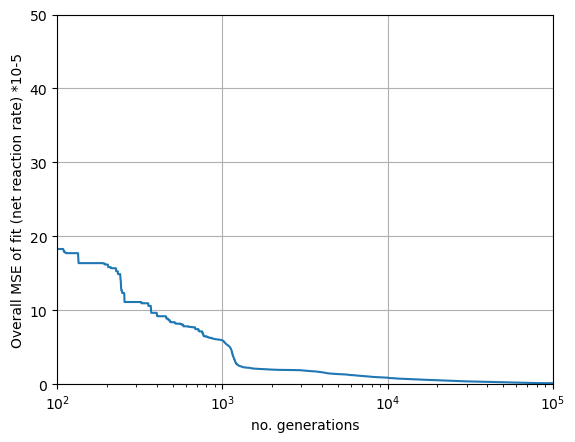

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.327587254558948
1.4924014544633526
0.8052673770130829
-4.298965240016152
0.5006543432016805
0.007973168803244921
0.4013828544941858
-6.779193312016062
0.5664063930094367
6.414598734740044
5.042795383521193
5.092959541078766
0.8193397841997678
0.022187211027307637
3.0852900928570173
5.1407046276280314e-06
0.14216611375517704
-11.666789123428536
1.839791102404034
1.5451459869167528
-11.393547820676545
1.1709215526483594
3.8866825827128495
0.011446068681202995
4.136592123068583
4.669381984947585
1.8567604669576059
10.166716907263543
-11.719368726044403
3.2453368982052293
1.8422926012636225
4.114907889853804
-4.0294674465738884
0.5059442848793867
1.004965810706655
-1.3010293895629679


In [37]:
res.X

array([-1.13275873e+01,  1.49240145e+00,  8.05267377e-01, -4.29896524e+00,
        5.00654343e-01,  7.97316880e-03,  4.01382854e-01, -6.77919331e+00,
        5.66406393e-01,  6.41459873e+00,  5.04279538e+00,  5.09295954e+00,
        8.19339784e-01,  2.21872110e-02,  3.08529009e+00,  5.14070463e-06,
        1.42166114e-01, -1.16667891e+01,  1.83979110e+00,  1.54514599e+00,
       -1.13935478e+01,  1.17092155e+00,  3.88668258e+00,  1.14460687e-02,
        4.13659212e+00,  4.66938198e+00,  1.85676047e+00,  1.01667169e+01,
       -1.17193687e+01,  3.24533690e+00,  1.84229260e+00,  4.11490789e+00,
       -4.02946745e+00,  5.05944285e-01,  1.00496581e+00, -1.30102939e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
#Store to use in other notebook using the same current kernel
resX10sres=res.X
%store resX10sres

Stored 'resX10sres' (ndarray)


In [40]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.327587254558948
1.6: 1.4924014544633526
0.9: 0.8052673770130829
-4.3: -4.298965240016152
0.5: 0.5006543432016805
0.003: 0.007973168803244921
0.4: 0.4013828544941858
-7.9: -6.779193312016062
0.7: 0.5664063930094367
7.2: 6.414598734740044
5.7: 5.042795383521193
5.7: 5.092959541078766
0.8: 0.8193397841997678
0.03: 0.022187211027307637
3.1: 3.0852900928570173
6.000000000000001e-09: 5.1407046276280314e-06
0.1: 0.14216611375517704
-12.0: -11.666789123428536
1.9: 1.839791102404034
1.6: 1.5451459869167528
-11.6: -11.393547820676545
1.2: 1.1709215526483594
4.0: 3.8866825827128495
0.01: 0.011446068681202995
4.2: 4.136592123068583
5.4: 4.669381984947585
2.2: 1.8567604669576059
11.8: 10.166716907263543
-12.0: -11.719368726044403
3.3: 3.2453368982052293
1.8: 1.8422926012636225
4.2: 4.114907889853804
-4.0: -4.0294674465738884
0.5: 0.5059442848793867
1.0: 1.004965810706655
coeff fit: 0.9935123943622474
r: 0.9967509189171824
